# **Installing library**

In [ ]:
!pip install tf2onnx
!pip install mltu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.8/455.8 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 82.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.6/74.6 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 55.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 75.2 MB/s eta 0:00:00
  Created wheel for qqdm: filename=qqdm-0.0.7-py3-none-any.whl size=6466 sha256=e4d509f398185fd12b7a9c3cb7765373f1e1a6f577b26faa0d7ebe6990a83498
  Stored in directory: /root/.cache/pip/wheels/40/1a/56/5dccdea123a172661eb65c8c29fde45

In [ ]:
!pip install opencv-python

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd drive/MyDrive

/content/drive/MyDrive




# **1.   Import Necessary library**




In [ ]:
import os
from datetime import datetime
from mltu.configs import BaseModelConfigs

from tqdm import tqdm
from PIL import Image
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf

from keras import layers
from keras.models import Model
from mltu.tensorflow.model_utils import residual_block

#Image processing
from mltu.tensorflow.dataProvider import DataProvider
from mltu.preprocessors import ImageReader
from mltu.annotations.images import CVImage
from mltu.preprocessors import ImageReader
from mltu.transformers import ImageResizer, LabelIndexer, LabelPadding, ImageShowCV2
from mltu.augmentors import RandomBrightness, RandomRotate, RandomErodeDilate, RandomSharpen, RandomColorMode

#For Callbacks and Checkpoints
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from mltu.tensorflow.callbacks import Model2onnx, TrainLogger

#CTC function
from mltu.tensorflow.losses import CTCloss

#For tracking the progress of Model
from mltu.tensorflow.metrics import CERMetric, WERMetric

#For loading existing Model and retraining it
from keras.models import load_model

# **Check the GPU connection**

In [ ]:
# Set the memory growth of all available GPUs to be dynamic
for gpu in tf.config.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat May  4 01:01:23 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   41C    P0              16W /  72W |    191MiB / 23034MiB |      1%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

**High RAM activation**

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


**Checking Current working Directory**

In [ ]:
!pwd

/content


In [ ]:
%cd drive/MyDrive/

/content/drive/MyDrive


# **(Optional) Configuration for Sharing datasets in Google Colab**

In [ ]:
!sudo add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!sudo apt-get update -qq 2>&1 > /dev/null
!sudo apt -y install -qq google-drive-ocamlfuse 2>&1 > /dev/null
!google-drive-ocamlfuse

In [ ]:
!sudo apt-get install -qq w3m # to act as web browser
!xdg-settings set default-web-browser w3m.desktop # to set default browser
%cd /content
!mkdir drive
%cd drive
!mkdir MyDrive
%cd ..
%cd ..
!google-drive-ocamlfuse /content/drive/MyDrive

# **Extracting Datasets from zip file**

In [ ]:
import os
import tarfile
from zipfile import ZipFile

def extract_zip(zip_file, extract_folder):
  with tarfile.open(zip_file,'r:gz') as myzip:
    if not os.path.exists(extract_folder):
      os.makedirs(extract_folder)
    else:
      print("Already extracted")
      return
    myzip.extractall(extract_folder)
forms1 = 'drive/MyDrive/datasets/formsA-D.tgz'
forms1_extractTo = 'drive/MyDrive/datasets/formsA-D'

forms2 = 'drive/MyDrive/datasets/formsE-H.tgz'
forms2_extractTo = 'drive/MyDrive/datasets/formsE-H'

forms3 = 'drive/MyDrive/datasets/formsI-Z.tgz'
forms3_extractTo = 'drive/MyDrive/datasets/formsI-Z'

lines = 'drive/MyDrive/datasets/lines.tgz'
lines_extractTo = 'drive/MyDrive/datasets/lines'

extract_zip(forms1, forms1_extractTo)
extract_zip(forms2, forms2_extractTo)
extract_zip(forms3, forms3_extractTo)

In [ ]:
os.path.exists('drive/MyDrive/datasets/lines')

In [ ]:
#for lines based segmentation
def extract_tgz(tgz_file, extract_folder):
    try:
        with tarfile.open(tgz_file, 'r:gz') as mytar:
            # Check if the extraction folder exists, if not, create it
            if not os.path.exists(extract_folder):
                os.makedirs(extract_folder)

            # Extract all contents of the tarball into the specified folder
            for member in mytar.getmembers():
                mytar.extract(member, extract_folder)
        print(f"Contents of {tgz_file} have been extracted to {extract_folder}.")
    except tarfile.ReadError:
        print(f"Error: Unable to read {tgz_file}. Please make sure it's a valid tarball.")
    except Exception as e:
        print(f"An error occurred: {e}")

if __name__ == "__main__":
    # Example usage:
    tgz_file_name = 'drive/MyDrive/datasets/lines.tgz'
    extract_folder_name = 'drive/MyDrive/datasets/lines'

    extract_tgz(tgz_file_name, extract_folder_name)


In [ ]:
!pwd

/home/studio-lab-user/sagemaker-studiolab-notebooks


# **Segmenting corresponding text label of line based Images**

In [ ]:
lines_txt_path = os.path.join("datasets","ascii","lines.txt")
lines_folder_path = os.path.join("datasets","lines")

# Read the content of lines.txt
with open(lines_txt_path, "r") as lines_file:
    lines = lines_file.readlines()

dataset, vocab, max_len = [], set(), 0
for line in tqdm(lines):
    if line.startswith('#'):
        continue

    line_split = line.split(" ")

    if line_split[1] == "err":
        continue
    print("Original Line : ",line)

    form_id = line_split[0] #Example: 'a01-000u-00'
    folder1 = form_id[:3] # Example: 'a01'
    file_name_lines = f'{form_id}.png' # Example:'a01-000u-00.png'
    form_id = form_id[0:-3] # from a01-000u-00 to a01-000u
    # file_name_FullImage = f'{form_id}.png'
    label = line_split[-1].rstrip('\n')

    #replace '|' with ' ' in label
    label = label.replace('|',' ')

    #determining the folder structure for full Image
    if 'a'<= folder1[0] <= 'd':
        folder_structure = 'formsA-D'
    elif 'e' <= folder1[0] <= 'h':
        folder_structure = 'formsE-H'
    elif 'i' <=folder1[0] <= 'z':
        folder_structure = 'formsI-Z'
    else:
        print(f"Invalid folder for form: {form_id}")
        continue
    print(f"Segmented Text : {label}")
    # print(f"filename of Full scale Image : {file_name_FullImage}")
    print(f"filename of sentence : {file_name_lines}")
    # Update relative path to point to full-scale images
    # rel_path_full = os.path.join("datasets",folder_structure, file_name_FullImage)


    # if not os.path.exists(rel_path_full):
    #     print(f"File not found : {rel_path_full}")
    #     continue
    # else:
    #     print(f"Full Scale image exist : {rel_path_full}")

    #path for line segmented image
    rel_path_line = os.path.join(lines_folder_path,folder1,form_id,file_name_lines)

    if not os.path.exists(rel_path_line):
        print(f"File not found : {rel_path_line}")
        continue
    else:
        print(f"Line Segmentation exist : {rel_path_line}")
    dataset.append([rel_path_line, label])
    vocab.update(list(label))
    max_len = max(max_len,len(label))

  0%|          | 0/13376 [00:00<?, ?it/s]

Original Line :  a01-000u-00 ok 154 19 408 746 1661 89 A|MOVE|to|stop|Mr.|Gaitskell|from

Segmented Text : A MOVE to stop Mr. Gaitskell from
filename of sentence : a01-000u-00.png


  0%|          | 24/13376 [00:00<02:22, 93.44it/s]

Line Segmentation exist : datasets/lines/a01/a01-000u/a01-000u-00.png
Original Line :  a01-000u-01 ok 156 19 395 932 1850 105 nominating|any|more|Labour|life|Peers

Segmented Text : nominating any more Labour life Peers
filename of sentence : a01-000u-01.png
Line Segmentation exist : datasets/lines/a01/a01-000u/a01-000u-01.png
Original Line :  a01-000u-02 ok 157 16 408 1106 1986 105 is|to|be|made|at|a|meeting|of|Labour

Segmented Text : is to be made at a meeting of Labour
filename of sentence : a01-000u-02.png
Line Segmentation exist : datasets/lines/a01/a01-000u/a01-000u-02.png
Original Line :  a01-000u-04 ok 157 20 395 1474 1830 94 put|down|a|resolution|on|the|subject

Segmented Text : put down a resolution on the subject
filename of sentence : a01-000u-04.png
Line Segmentation exist : datasets/lines/a01/a01-000u/a01-000u-04.png
Original Line :  a01-000u-06 ok 159 20 363 1825 2051 87 Griffiths|,|M P|for|Manchester|Exchange|.

Segmented Text : P for Manchester Exchange .
filename of 

  0%|          | 34/13376 [00:00<03:58, 55.86it/s]

Line Segmentation exist : datasets/lines/a01/a01-000x/a01-000x-00.png
Original Line :  a01-000x-01 ok 181 23 382 924 1595 148 any|more|Labour|life|Peers|is|to|be|made|at|a

Segmented Text : any more Labour life Peers is to be made at a
filename of sentence : a01-000x-01.png
Line Segmentation exist : datasets/lines/a01/a01-000x/a01-000x-01.png
Original Line :  a01-000x-02 ok 181 30 386 1110 1637 140 meeting|of|Labour|0M Ps|tomorrow|.|Mr.|Michael

Segmented Text : Ps tomorrow . Mr. Michael
filename of sentence : a01-000x-02.png
Line Segmentation exist : datasets/lines/a01/a01-000x/a01-000x-02.png
Original Line :  a01-000x-03 ok 179 22 375 1276 1584 154 Foot|has|put|down|a|resolution|on|the|subject

Segmented Text : Foot has put down a resolution on the subject
filename of sentence : a01-000x-03.png
Line Segmentation exist : datasets/lines/a01/a01-000x/a01-000x-03.png
Original Line :  a01-000x-04 ok 173 25 397 1458 1647 148 and|he|is|to|be|backed|by|Mr.|Will|Griffiths|,

Segmented Text : 

  0%|          | 48/13376 [00:00<04:15, 52.20it/s]

Line Segmentation exist : datasets/lines/a01/a01-003u/a01-003u-00.png
Original Line :  a01-003u-01 ok 161 23 366 976 1837 103 support|,|a|large|majority|of|Labour

Segmented Text : support , a large majority of Labour
filename of sentence : a01-003u-01.png
Line Segmentation exist : datasets/lines/a01/a01-003u/a01-003u-01.png
Original Line :  a01-003u-02 ok 161 21 356 1162 1908 96 M Ps|are|likely|to|turn|down|the|Foot-

Segmented Text : Ps are likely to turn down the Foot-
filename of sentence : a01-003u-02.png
Line Segmentation exist : datasets/lines/a01/a01-003u/a01-003u-02.png
Original Line :  a01-003u-04 ok 161 13 351 1515 1869 103 be|that|as|Labour|M Ps|opposed|the

Segmented Text : Ps opposed the
filename of sentence : a01-003u-04.png
Line Segmentation exist : datasets/lines/a01/a01-003u/a01-003u-04.png
Original Line :  a01-003u-05 ok 163 24 335 1693 2000 104 Government|Bill|which|brought|life|peers

Segmented Text : Government Bill which brought life peers
filename of sentence : 

  0%|          | 60/13376 [00:01<04:38, 47.89it/s]

Line Segmentation exist : datasets/lines/a01/a01-003x/a01-003x-01.png
Original Line :  a01-003x-04 ok 169 34 306 1590 1875 158 ment|Bill|which|brought|life|peers|into|existence|,|they

Segmented Text : ment Bill which brought life peers into existence , they
filename of sentence : a01-003x-04.png
Line Segmentation exist : datasets/lines/a01/a01-003x/a01-003x-04.png
Original Line :  a01-003x-05 ok 176 31 304 1767 1885 144 should|not|now|put|forward|nominees|.|He|believes

Segmented Text : should not now put forward nominees . He believes
filename of sentence : a01-003x-05.png
Line Segmentation exist : datasets/lines/a01/a01-003x/a01-003x-05.png
Original Line :  a01-003x-06 ok 176 25 316 1940 1860 138 that|the|House|of|Lords|should|be|abolished|and

Segmented Text : that the House of Lords should be abolished and
filename of sentence : a01-003x-06.png
Line Segmentation exist : datasets/lines/a01/a01-003x/a01-003x-06.png
Original Line :  a01-003x-07 ok 168 24 329 2123 1951 133 that|Labour

  1%|          | 68/13376 [00:01<05:31, 40.13it/s]

Line Segmentation exist : datasets/lines/a01/a01-007/a01-007-00.png
Original Line :  a01-007-01 ok 203 10 335 937 1526 85 Peeresses|have|been|created|.|Most|Labour

Segmented Text : Peeresses have been created . Most Labour
filename of sentence : a01-007-01.png
Line Segmentation exist : datasets/lines/a01/a01-007/a01-007-01.png
Original Line :  a01-007-02 ok 203 17 355 1111 1697 106 sentiment|would|#|still|favour|the|abolition

Segmented Text : sentiment would # still favour the abolition
filename of sentence : a01-007-02.png
Line Segmentation exist : datasets/lines/a01/a01-007/a01-007-02.png
Original Line :  a01-007-03 ok 203 18 363 1284 1711 111 of|the|House|of|Lords|,|but|while|it|remains

Segmented Text : of the House of Lords , but while it remains
filename of sentence : a01-007-03.png
Line Segmentation exist : datasets/lines/a01/a01-007/a01-007-03.png
Original Line :  a01-007-04 ok 203 14 358 1464 1717 133 Labour|has|to|have|an|adequate|number|of

Segmented Text : Labour has to h

  1%|          | 87/13376 [00:01<04:31, 48.94it/s]

Line Segmentation exist : datasets/lines/a01/a01-007x/a01-007x-00.png
Original Line :  a01-007x-01 ok 175 26 346 1051 1922 102 Peeresses|have|been|created|.|Most|Labour|sentiment

Segmented Text : Peeresses have been created . Most Labour sentiment
filename of sentence : a01-007x-01.png
Line Segmentation exist : datasets/lines/a01/a01-007x/a01-007x-01.png
Original Line :  a01-007x-02 ok 178 23 357 1226 1817 173 would|still|favour|the|abolition|of|the|House

Segmented Text : would still favour the abolition of the House
filename of sentence : a01-007x-02.png
Line Segmentation exist : datasets/lines/a01/a01-007x/a01-007x-02.png
Original Line :  a01-007x-03 ok 171 27 368 1393 1823 147 of|Lords|,|but|while|it|remains|Labour|has|to

Segmented Text : of Lords , but while it remains Labour has to
filename of sentence : a01-007x-03.png
Line Segmentation exist : datasets/lines/a01/a01-007x/a01-007x-03.png
Original Line :  a01-007x-04 ok 166 19 337 1587 1801 147 have|an|adequate|number|of|member

  1%|          | 95/13376 [00:02<05:20, 41.49it/s]

Line Segmentation exist : datasets/lines/a01/a01-011/a01-011-00.png
Original Line :  a01-011-02 ok 182 19 300 1077 1800 104 National|Congress|(|400,000|)|will|meet|in|London|today

Segmented Text : National Congress ( 400,000 ) will meet in London today
filename of sentence : a01-011-02.png
Line Segmentation exist : datasets/lines/a01/a01-011/a01-011-02.png
Original Line :  a01-011-03 ok 182 16 303 1253 1723 112 to|discuss|a|common|course|of|action|.|Sir|Roy|is

Segmented Text : to discuss a common course of action . Sir Roy is
filename of sentence : a01-011-03.png
Line Segmentation exist : datasets/lines/a01/a01-011/a01-011-03.png
Original Line :  a01-011-04 ok 182 13 304 1435 1725 108 violently|opposed|to|Africans|getting|an|elected|majority

Segmented Text : violently opposed to Africans getting an elected majority
filename of sentence : a01-011-04.png
Line Segmentation exist : datasets/lines/a01/a01-011/a01-011-04.png
Original Line :  a01-011-05 ok 182 12 304 1614 1660 106 in|North

  1%|          | 120/13376 [00:02<04:16, 51.75it/s]

Line Segmentation exist : datasets/lines/a01/a01-011x/a01-011x-08.png
Original Line :  a01-014-00 ok 182 24 356 717 2009 117 Sir|Roy's|United|Federal|Party|is|boycotting

Segmented Text : Sir Roy's United Federal Party is boycotting
filename of sentence : a01-014-00.png


  1%|          | 126/13376 [00:02<05:11, 42.54it/s]

Line Segmentation exist : datasets/lines/a01/a01-014/a01-014-00.png
Original Line :  a01-014-01 ok 182 18 365 888 1833 83 the|London|talks|on|the|Protectorate's

Segmented Text : the London talks on the Protectorate's
filename of sentence : a01-014-01.png
Line Segmentation exist : datasets/lines/a01/a01-014/a01-014-01.png
Original Line :  a01-014-02 ok 182 14 380 1048 1840 120 future|.|Said|Mr.|Nkumbula|last|night|:

Segmented Text : future . Said Mr. Nkumbula last night :
filename of sentence : a01-014-02.png
Line Segmentation exist : datasets/lines/a01/a01-014/a01-014-02.png
Original Line :  a01-014-03 ok 182 15 384 1224 1745 130 "|We|want|to|discuss|what|to|do|if|the

Segmented Text : " We want to discuss what to do if the
filename of sentence : a01-014-03.png
Line Segmentation exist : datasets/lines/a01/a01-014/a01-014-03.png
Original Line :  a01-014-04 ok 182 19 362 1377 1909 130 British|Government|gives|in|to|Sir|Roy|and

Segmented Text : British Government gives in to Sir Roy an

  1%|          | 131/13376 [00:02<06:18, 35.03it/s]

Line Segmentation exist : datasets/lines/a01/a01-014u/a01-014u-00.png
Original Line :  a01-014u-01 ok 169 14 408 933 1681 112 boycotting|the|London|talks|on|the

Segmented Text : boycotting the London talks on the
filename of sentence : a01-014u-01.png
Line Segmentation exist : datasets/lines/a01/a01-014u/a01-014u-01.png
Original Line :  a01-014u-03 ok 169 23 378 1292 1883 90 last|night|:|"|We|want|to|discuss|what|to

Segmented Text : last night : " We want to discuss what to
filename of sentence : a01-014u-03.png
Line Segmentation exist : datasets/lines/a01/a01-014u/a01-014u-03.png
Original Line :  a01-014u-04 ok 166 23 358 1467 1601 74 do|if|the|British|demonstrations|.|"

Segmented Text : do if the British demonstrations . "
filename of sentence : a01-014u-04.png
Line Segmentation exist : datasets/lines/a01/a01-014u/a01-014u-04.png
Original Line :  a01-014u-05 ok 168 22 363 1644 1885 98 Yesterday|Sir|Roy's|chief|aide|,|Mr.

Segmented Text : Yesterday Sir Roy's chief aide , Mr.
filen

  1%|          | 140/13376 [00:03<06:45, 32.66it/s]

Line Segmentation exist : datasets/lines/a01/a01-014x/a01-014x-00.png
Original Line :  a01-014x-01 ok 193 27 347 1060 1715 97 the|London|talks|on|the|Protectorate's

Segmented Text : the London talks on the Protectorate's
filename of sentence : a01-014x-01.png
Line Segmentation exist : datasets/lines/a01/a01-014x/a01-014x-01.png
Original Line :  a01-014x-02 ok 196 22 342 1230 1805 159 future|.|Said|Mr.|Nkumbula|last|night|:

Segmented Text : future . Said Mr. Nkumbula last night :
filename of sentence : a01-014x-02.png
Line Segmentation exist : datasets/lines/a01/a01-014x/a01-014x-02.png
Original Line :  a01-014x-03 ok 189 23 367 1390 1646 162 "|We|want|to|discuss|what|to|do|if|the

Segmented Text : " We want to discuss what to do if the
filename of sentence : a01-014x-03.png
Line Segmentation exist : datasets/lines/a01/a01-014x/a01-014x-03.png
Original Line :  a01-014x-04 ok 187 26 314 1581 1819 188 British|Government|gives|in|to|Sir|Roy

Segmented Text : British Government gives in t

  1%|          | 150/13376 [00:03<06:35, 33.43it/s]

Line Segmentation exist : datasets/lines/a01/a01-020/a01-020-00.png
Original Line :  a01-020-01 ok 176 30 329 1082 1690 93 Lancaster|House|despite|the|crisis|which|had

Segmented Text : Lancaster House despite the crisis which had
filename of sentence : a01-020-01.png
Line Segmentation exist : datasets/lines/a01/a01-020/a01-020-01.png
Original Line :  a01-020-02 ok 176 27 305 1273 1798 85 blown|up|.|He|has|now|revealed|his|full|plans

Segmented Text : blown up . He has now revealed his full plans
filename of sentence : a01-020-02.png
Line Segmentation exist : datasets/lines/a01/a01-020/a01-020-02.png
Original Line :  a01-020-03 ok 176 27 342 1439 1753 128 to|the|Africans|and|Liberals|attending|.|These

Segmented Text : to the Africans and Liberals attending . These
filename of sentence : a01-020-03.png
Line Segmentation exist : datasets/lines/a01/a01-020/a01-020-03.png
Original Line :  a01-020-04 ok 176 24 334 1629 1614 114 plans|do|not|give|the|Africans|the|overall

Segmented Text : p

  1%|▏         | 178/13376 [00:03<04:26, 49.47it/s]

Line Segmentation exist : datasets/lines/a01/a01-026/a01-026-00.png
Original Line :  a01-026-01 ok 182 32 361 1064 1716 88 in|the|Commons|last|night|that|there|have|been

Segmented Text : in the Commons last night that there have been
filename of sentence : a01-026-01.png
Line Segmentation exist : datasets/lines/a01/a01-026/a01-026-01.png
Original Line :  a01-026-03 ok 182 31 339 1412 1734 92 The|Northern|Rhodesia|conference|in|London|has

Segmented Text : The Northern Rhodesia conference in London has
filename of sentence : a01-026-03.png
Line Segmentation exist : datasets/lines/a01/a01-026/a01-026-03.png
Original Line :  a01-026-04 ok 182 36 349 1590 1747 97 been|boycotted|by|the|two|main|settlers'|parties|-

Segmented Text : been boycotted by the two main settlers' parties -
filename of sentence : a01-026-04.png
Line Segmentation exist : datasets/lines/a01/a01-026/a01-026-04.png
Original Line :  a01-026-05 ok 182 34 342 1767 1777 112 the|United|Federal|Party|and|the|Dominion|Party|.

  1%|▏         | 188/13376 [00:04<05:02, 43.62it/s]

Line Segmentation exist : datasets/lines/a01/a01-026u/a01-026u-00.png
Original Line :  a01-026u-01 ok 169 18 393 991 1861 79 denied|in|the|Commons|last|night|that

Segmented Text : denied in the Commons last night that
filename of sentence : a01-026u-01.png
Line Segmentation exist : datasets/lines/a01/a01-026u/a01-026u-01.png
Original Line :  a01-026u-02 ok 170 19 395 1166 1861 78 there|have|been|secret|negotiations|on

Segmented Text : there have been secret negotiations on
filename of sentence : a01-026u-02.png
Line Segmentation exist : datasets/lines/a01/a01-026u/a01-026u-02.png
Original Line :  a01-026u-03 ok 170 21 358 1336 1892 87 Northern|Rhodesia's|future|.|The|Northern

Segmented Text : Northern Rhodesia's future . The Northern
filename of sentence : a01-026u-03.png
Line Segmentation exist : datasets/lines/a01/a01-026u/a01-026u-03.png
Original Line :  a01-026u-04 ok 171 19 307 1526 1951 81 Rhodesia|conference|in|London|has|been

Segmented Text : Rhodesia conference in London h

  1%|▏         | 199/13376 [00:04<05:22, 40.88it/s]

Line Segmentation exist : datasets/lines/a01/a01-026x/a01-026x-00.png
Original Line :  a01-026x-01 ok 194 22 328 1078 1904 153 in|the|Commons|last|night|that|there|have

Segmented Text : in the Commons last night that there have
filename of sentence : a01-026x-01.png
Line Segmentation exist : datasets/lines/a01/a01-026x/a01-026x-01.png
Original Line :  a01-026x-02 ok 193 28 322 1246 2094 153 been|secret|negotiations|on|the|Northern|Rhodesia's

Segmented Text : been secret negotiations on the Northern Rhodesia's
filename of sentence : a01-026x-02.png
Line Segmentation exist : datasets/lines/a01/a01-026x/a01-026x-02.png
Original Line :  a01-026x-03 ok 187 24 314 1409 1819 159 future|.|The|Northern|Rhodesia|conference|in

Segmented Text : future . The Northern Rhodesia conference in
filename of sentence : a01-026x-03.png
Line Segmentation exist : datasets/lines/a01/a01-026x/a01-026x-03.png
Original Line :  a01-026x-06 ok 191 25 336 1954 1994 170 and|the|Dominion|Party|.|But|representative

  2%|▏         | 209/13376 [00:04<05:42, 38.49it/s]

Line Segmentation exist : datasets/lines/a01/a01-030/a01-030-00.png
Original Line :  a01-030-02 ok 176 20 305 1083 1815 100 M Ps|yesterday|:|"|I|have|no|knowledge|of|secret|negotiations|.|"

Segmented Text : Ps yesterday : " I have no knowledge of secret negotiations . "
filename of sentence : a01-030-02.png
Line Segmentation exist : datasets/lines/a01/a01-030/a01-030-02.png
Original Line :  a01-030-03 ok 176 15 310 1262 1830 96 He|said|Britain|had|an|obligation|to|consult|the|Federal

Segmented Text : He said Britain had an obligation to consult the Federal
filename of sentence : a01-030-03.png
Line Segmentation exist : datasets/lines/a01/a01-030/a01-030-03.png
Original Line :  a01-030-04 ok 176 20 328 1431 1733 94 Government|.|But|the|final|decision|remained|with|the|British

Segmented Text : Government . But the final decision remained with the British
filename of sentence : a01-030-04.png
Line Segmentation exist : datasets/lines/a01/a01-030/a01-030-04.png
Original Line :  a01-030-0

  2%|▏         | 217/13376 [00:05<06:04, 36.07it/s]

Line Segmentation exist : datasets/lines/a01/a01-030u/a01-030u-00.png
Original Line :  a01-030u-01 ok 169 19 325 997 1754 60 Mr.|Macleod|was|not|at|the|week-end

Segmented Text : Mr. Macleod was not at the week-end
filename of sentence : a01-030u-01.png
Line Segmentation exist : datasets/lines/a01/a01-030u/a01-030u-01.png
Original Line :  a01-030u-03 ok 170 23 314 1347 1921 86 have|no|knowledge|of|secret|negotiations|.|"

Segmented Text : have no knowledge of secret negotiations . "
filename of sentence : a01-030u-03.png
Line Segmentation exist : datasets/lines/a01/a01-030u/a01-030u-03.png
Original Line :  a01-030u-04 ok 169 26 323 1522 2029 81 He|said|Britain|had|an|obligation|to|consult

Segmented Text : He said Britain had an obligation to consult
filename of sentence : a01-030u-04.png
Line Segmentation exist : datasets/lines/a01/a01-030u/a01-030u-04.png
Original Line :  a01-030u-05 ok 170 15 327 1697 1788 76 the|Federal|Government|.|But|the|final

Segmented Text : the Federal Gover

  2%|▏         | 250/13376 [00:05<03:49, 57.21it/s]

Line Segmentation exist : datasets/lines/a01/a01-038x/a01-038x-00.png
Original Line :  a01-038x-01 ok 186 41 375 1023 1627 177 had|refused|to|attend|the|talks|because|Sir|Roy

Segmented Text : had refused to attend the talks because Sir Roy
filename of sentence : a01-038x-01.png
Line Segmentation exist : datasets/lines/a01/a01-038x/a01-038x-01.png
Original Line :  a01-038x-02 ok 185 33 394 1210 1662 169 had|found|messages|sent|from|the|Government|were

Segmented Text : had found messages sent from the Government were
filename of sentence : a01-038x-02.png
Line Segmentation exist : datasets/lines/a01/a01-038x/a01-038x-02.png
Original Line :  a01-038x-04 ok 175 36 405 1563 1638 156 called|on|Mr.|Macmillan|to|cease|his|negotiations|with

Segmented Text : called on Mr. Macmillan to cease his negotiations with
filename of sentence : a01-038x-04.png
Line Segmentation exist : datasets/lines/a01/a01-038x/a01-038x-04.png
Original Line :  a01-038x-08 ok 176 43 397 2278 1560 168 interference|by|S

  2%|▏         | 280/13376 [00:05<03:07, 69.93it/s]

Line Segmentation exist : datasets/lines/a01/a01-043x/a01-043x-00.png
Original Line :  a01-043x-01 ok 177 33 394 1017 1583 206 today|.|PRESIDENT|KENNEDY|today|defended

Segmented Text : today . PRESIDENT KENNEDY today defended
filename of sentence : a01-043x-01.png
Line Segmentation exist : datasets/lines/a01/a01-043x/a01-043x-01.png
Original Line :  a01-043x-02 ok 178 38 369 1196 1698 186 the|appointment|of|a|Negro|as|his|Housing|Minister|.

Segmented Text : the appointment of a Negro as his Housing Minister .
filename of sentence : a01-043x-02.png
Line Segmentation exist : datasets/lines/a01/a01-043x/a01-043x-02.png
Original Line :  a01-043x-03 ok 171 36 366 1379 1611 158 It|has|aroused|strong|opposition|from|the|anti-Negro

Segmented Text : It has aroused strong opposition from the anti-Negro
filename of sentence : a01-043x-03.png
Line Segmentation exist : datasets/lines/a01/a01-043x/a01-043x-03.png
Original Line :  a01-043x-04 ok 168 30 399 1557 1625 176 senators|of|the|Deep|South|

  2%|▏         | 288/13376 [00:06<04:57, 44.05it/s]

Line Segmentation exist : datasets/lines/a01/a01-049/a01-049-00.png
Original Line :  a01-049-01 ok 176 27 333 1048 1657 169 off|the|opposition|by|telling|a|television

Segmented Text : off the opposition by telling a television
filename of sentence : a01-049-01.png
Line Segmentation exist : datasets/lines/a01/a01-049/a01-049-01.png
Original Line :  a01-049-02 ok 176 33 324 1216 1840 186 audience|it|was|"|current|Washington|gossip|"

Segmented Text : audience it was " current Washington gossip "
filename of sentence : a01-049-02.png
Line Segmentation exist : datasets/lines/a01/a01-049/a01-049-02.png
Original Line :  a01-049-03 ok 176 33 323 1405 1955 194 that|Weaver|once|had|Communist|affiliations|.

Segmented Text : that Weaver once had Communist affiliations .
filename of sentence : a01-049-03.png
Line Segmentation exist : datasets/lines/a01/a01-049/a01-049-03.png
Original Line :  a01-049-04 ok 176 34 317 1571 1992 168 The|Senate|Banking|Committee|,|which|is|headed

Segmented Text : T

  2%|▏         | 311/13376 [00:06<04:15, 51.10it/s]

Line Segmentation exist : datasets/lines/a01/a01-049x/a01-049x-01.png
Original Line :  a01-049x-02 ok 171 31 359 1160 2014 92 television|audience|it|was|"|current|Washington

Segmented Text : television audience it was " current Washington
filename of sentence : a01-049x-02.png
Line Segmentation exist : datasets/lines/a01/a01-049x/a01-049x-02.png
Original Line :  a01-049x-03 ok 171 33 336 1338 2065 114 gossip|"|that|Weaver|once|had|Communist|affilia-

Segmented Text : gossip " that Weaver once had Communist affilia-
filename of sentence : a01-049x-03.png
Line Segmentation exist : datasets/lines/a01/a01-049x/a01-049x-03.png
Original Line :  a01-049x-04 ok 163 24 330 1530 1989 89 tions|.|The|Senate|Banking|Committee|,|which

Segmented Text : tions . The Senate Banking Committee , which
filename of sentence : a01-049x-04.png
Line Segmentation exist : datasets/lines/a01/a01-049x/a01-049x-04.png
Original Line :  a01-049x-05 ok 165 18 328 1711 2007 91 is|headed|by|another|Southern|Senator|-


  3%|▎         | 362/13376 [00:07<02:44, 79.08it/s]

Line Segmentation exist : datasets/lines/a01/a01-058u/a01-058u-00.png
Original Line :  a01-058u-01 ok 167 19 373 926 1718 85 over|West|Germany's|cash|offer|to|help

Segmented Text : over West Germany's cash offer to help
filename of sentence : a01-058u-01.png
Line Segmentation exist : datasets/lines/a01/a01-058u/a01-058u-01.png
Original Line :  a01-058u-02 ok 167 24 370 1110 1846 75 America's|balance|of|payments|position|.|He

Segmented Text : America's balance of payments position . He
filename of sentence : a01-058u-02.png
Line Segmentation exist : datasets/lines/a01/a01-058u/a01-058u-02.png
Original Line :  a01-058u-03 ok 169 20 394 1286 1850 91 said|bluntly|in|Washington|yesterday|that

Segmented Text : said bluntly in Washington yesterday that
filename of sentence : a01-058u-03.png
Line Segmentation exist : datasets/lines/a01/a01-058u/a01-058u-03.png
Original Line :  a01-058u-04 ok 167 24 352 1459 2019 89 the|offer|-|357million|-|was|not|good|enough|.

Segmented Text : the offer -

  3%|▎         | 381/13376 [00:07<03:02, 71.06it/s]

Line Segmentation exist : datasets/lines/a01/a01-063/a01-063-00.png
Original Line :  a01-063-02 ok 152 17 340 1039 1680 195 useful|.|The|President|will|probably

Segmented Text : useful . The President will probably
filename of sentence : a01-063-02.png
Line Segmentation exist : datasets/lines/a01/a01-063/a01-063-02.png
Original Line :  a01-063-03 ok 152 18 345 1225 1751 172 discuss|the|problem|with|Dr.|Brentano|,

Segmented Text : discuss the problem with Dr. Brentano ,
filename of sentence : a01-063-03.png
Line Segmentation exist : datasets/lines/a01/a01-063/a01-063-03.png
Original Line :  a01-063-04 ok 152 23 318 1404 1834 193 the|West|German|Foreign|Minister|,|who|is

Segmented Text : the West German Foreign Minister , who is
filename of sentence : a01-063-04.png
Line Segmentation exist : datasets/lines/a01/a01-063/a01-063-04.png
Original Line :  a01-063-05 ok 152 16 320 1588 1692 191 due|in|Washington|next|week|.|A|big

Segmented Text : due in Washington next week . A big
filename

  3%|▎         | 402/13376 [00:07<03:03, 70.88it/s]

Line Segmentation exist : datasets/lines/a01/a01-063x/a01-063x-00.png
Original Line :  a01-063x-01 ok 187 24 362 1017 2029 211 level|than|in|the|past|"|might|be|useful|.

Segmented Text : level than in the past " might be useful .
filename of sentence : a01-063x-01.png
Line Segmentation exist : datasets/lines/a01/a01-063x/a01-063x-01.png
Original Line :  a01-063x-04 ok 180 22 395 1568 1929 211 German|Foreign|Minister|,|who|is|due|in

Segmented Text : German Foreign Minister , who is due in
filename of sentence : a01-063x-04.png
Line Segmentation exist : datasets/lines/a01/a01-063x/a01-063x-04.png
Original Line :  a01-063x-05 ok 185 22 397 1756 1767 199 Washington|next|week|.|A|big|slice|of

Segmented Text : Washington next week . A big slice of
filename of sentence : a01-063x-05.png
Line Segmentation exist : datasets/lines/a01/a01-063x/a01-063x-05.png
Original Line :  a01-063x-06 ok 186 21 376 1932 2016 218 Germany's|"|aid|"|is|the|early|payment

Segmented Text : Germany's " aid " is t

  3%|▎         | 431/13376 [00:08<02:55, 73.65it/s]

Line Segmentation exist : datasets/lines/a01/a01-072x/a01-072x-00.png
Original Line :  a01-072x-01 ok 181 25 389 1103 1378 86 dollar|reserves|.|Dr.|Adenauer's|answer|is|the

Segmented Text : dollar reserves . Dr. Adenauer's answer is the
filename of sentence : a01-072x-01.png
Line Segmentation exist : datasets/lines/a01/a01-072x/a01-072x-01.png
Original Line :  a01-072x-02 ok 182 27 388 1271 1556 146 once-and-for-all|cash|offer|of|357million|.|President

Segmented Text : once-and-for-all cash offer of 357million . President
filename of sentence : a01-072x-02.png
Line Segmentation exist : datasets/lines/a01/a01-072x/a01-072x-02.png
Original Line :  a01-072x-03 ok 177 33 396 1462 1501 151 Kennedy's|rejection|of|it|is|a|painful|blow|to|the

Segmented Text : Kennedy's rejection of it is a painful blow to the
filename of sentence : a01-072x-03.png
Line Segmentation exist : datasets/lines/a01/a01-072x/a01-072x-03.png
Original Line :  a01-072x-04 ok 174 17 397 1635 1542 144 West|German|Govern

  3%|▎         | 450/13376 [00:08<03:05, 69.68it/s]

Line Segmentation exist : datasets/lines/a01/a01-077u/a01-077u-01.png
Original Line :  a01-077u-02 ok 171 20 371 1108 1922 94 Joyce|Egginton|cables|:|President|Kennedy

Segmented Text : Joyce Egginton cables : President Kennedy
filename of sentence : a01-077u-02.png
Line Segmentation exist : datasets/lines/a01/a01-077u/a01-077u-02.png
Original Line :  a01-077u-03 ok 172 23 361 1292 1889 86 at|his|Washington|Press|conference|admitted

Segmented Text : at his Washington Press conference admitted
filename of sentence : a01-077u-03.png
Line Segmentation exist : datasets/lines/a01/a01-077u/a01-077u-03.png
Original Line :  a01-077u-04 ok 170 17 377 1472 1782 66 he|did|not|know|whether|America|was

Segmented Text : he did not know whether America was
filename of sentence : a01-077u-04.png
Line Segmentation exist : datasets/lines/a01/a01-077u/a01-077u-04.png
Original Line :  a01-077u-05 ok 170 28 367 1656 1846 80 lagging|behind|Russia|in|missile|power|.

Segmented Text : lagging behind Russia 

  3%|▎         | 468/13376 [00:08<03:11, 67.44it/s]

Line Segmentation exist : datasets/lines/a01/a01-087/a01-087-00.png
Original Line :  a01-087-01 ok 161 16 360 1108 1515 117 Labour's|attack|on|the|higher|health

Segmented Text : Labour's attack on the higher health
filename of sentence : a01-087-01.png
Line Segmentation exist : datasets/lines/a01/a01-087/a01-087-01.png
Original Line :  a01-087-02 ok 161 25 364 1264 1846 142 charges|.|Mr.|Powell|,|white-faced|and|outwardly

Segmented Text : charges . Mr. Powell , white-faced and outwardly
filename of sentence : a01-087-02.png
Line Segmentation exist : datasets/lines/a01/a01-087/a01-087-02.png
Original Line :  a01-087-03 ok 161 23 375 1461 1763 107 unemotional|,|replied|with|a|statistical|state-

Segmented Text : unemotional , replied with a statistical state-
filename of sentence : a01-087-03.png
Line Segmentation exist : datasets/lines/a01/a01-087/a01-087-03.png
Original Line :  a01-087-04 ok 161 17 372 1640 1736 142 ment|-|and|ended|by|inciting|Labour|M Ps

Segmented Text : Ps
filena

  4%|▍         | 507/13376 [00:08<02:36, 82.10it/s]

Line Segmentation exist : datasets/lines/a01/a01-096u/a01-096u-00.png
Original Line :  a01-096u-02 ok 171 23 383 1174 1871 66 this|letter|which|Mr.|Gaitskell|had|received|:

Segmented Text : this letter which Mr. Gaitskell had received :
filename of sentence : a01-096u-02.png
Line Segmentation exist : datasets/lines/a01/a01-096u/a01-096u-02.png
Original Line :  a01-096u-04 ok 169 26 343 1516 1928 90 has|practised|medicine|for|43|years|,|chiefly

Segmented Text : has practised medicine for 43 years , chiefly
filename of sentence : a01-096u-04.png
Line Segmentation exist : datasets/lines/a01/a01-096u/a01-096u-04.png
Original Line :  a01-096u-05 ok 169 19 365 1714 1709 73 as|a|panel|doctor|.|"|I|am|a|lifelong

Segmented Text : as a panel doctor . " I am a lifelong
filename of sentence : a01-096u-05.png
Line Segmentation exist : datasets/lines/a01/a01-096u/a01-096u-05.png
Original Line :  a01-096u-06 ok 171 22 358 1895 1810 65 Conservative|.|I|am|horrified|and|amazed

Segmented Text : Cons

  4%|▍         | 518/13376 [00:09<03:01, 70.72it/s]

Line Segmentation exist : datasets/lines/a01/a01-102/a01-102-00.png
Original Line :  a01-102-01 ok 178 16 383 907 1514 186 healing|the|sick|,|my|considered

Segmented Text : healing the sick , my considered
filename of sentence : a01-102-01.png
Line Segmentation exist : datasets/lines/a01/a01-102/a01-102-01.png
Original Line :  a01-102-05 ok 182 21 332 1631 1727 174 are|dealing|with|a|noble|edifice|which

Segmented Text : are dealing with a noble edifice which
filename of sentence : a01-102-05.png
Line Segmentation exist : datasets/lines/a01/a01-102/a01-102-05.png
Original Line :  a01-102-06 ok 178 21 354 1813 1533 136 needs|an|imaginative|architect|to

Segmented Text : needs an imaginative architect to
filename of sentence : a01-102-06.png
Line Segmentation exist : datasets/lines/a01/a01-102/a01-102-06.png
Original Line :  a01-102-07 ok 182 20 360 1980 1558 162 improve|it|,|but|it|has|got|a

Segmented Text : improve it , but it has got a
filename of sentence : a01-102-07.png
Line Segm

  4%|▍         | 530/13376 [00:09<03:29, 61.39it/s]

Line Segmentation exist : datasets/lines/a01/a01-102u/a01-102u-01.png
Original Line :  a01-102u-02 ok 169 24 374 1103 1772 89 anybody|supporting|the|increased|charges|is|a

Segmented Text : anybody supporting the increased charges is a
filename of sentence : a01-102u-02.png
Line Segmentation exist : datasets/lines/a01/a01-102u/a01-102u-02.png
Original Line :  a01-102u-03 ok 170 25 379 1283 1807 102 wicked|,|old|-|.|"|Mr.|Brown|went|on|:|"|We

Segmented Text : wicked , old - . " Mr. Brown went on : " We
filename of sentence : a01-102u-03.png
Line Segmentation exist : datasets/lines/a01/a01-102u/a01-102u-03.png
Original Line :  a01-102u-04 ok 169 23 363 1462 1788 97 are|dealing|with|a|noble|edifice|which

Segmented Text : are dealing with a noble edifice which
filename of sentence : a01-102u-04.png
Line Segmentation exist : datasets/lines/a01/a01-102u/a01-102u-04.png
Original Line :  a01-102u-05 ok 169 27 348 1638 1876 87 needs|an|imaginative|architect|to|improve

Segmented Text : needs 

  4%|▍         | 538/13376 [00:09<04:06, 52.01it/s]

Line Segmentation exist : datasets/lines/a01/a01-107/a01-107-00.png
Original Line :  a01-107-01 ok 191 35 336 892 1676 132 at|the|point|of|need|and|with|one|standard|for|all|sick

Segmented Text : at the point of need and with one standard for all sick
filename of sentence : a01-107-01.png
Line Segmentation exist : datasets/lines/a01/a01-107/a01-107-01.png
Original Line :  a01-107-04 ok 182 40 329 1428 1887 167 "|The|jackals|bay|when|there|is|nothing|better|they|can|do|.|"

Segmented Text : " The jackals bay when there is nothing better they can do . "
filename of sentence : a01-107-04.png
Line Segmentation exist : datasets/lines/a01/a01-107/a01-107-04.png
Original Line :  a01-107u-00 ok 174 22 329 721 1920 90 "|We|believe|that|a|comprehensive|medical

Segmented Text : " We believe that a comprehensive medical
filename of sentence : a01-107u-00.png


  4%|▍         | 544/13376 [00:10<04:54, 43.58it/s]

Line Segmentation exist : datasets/lines/a01/a01-107u/a01-107u-00.png
Original Line :  a01-107u-02 ok 174 20 366 1083 1811 67 of|need|and|with|one|standard|for|all

Segmented Text : of need and with one standard for all
filename of sentence : a01-107u-02.png
Line Segmentation exist : datasets/lines/a01/a01-107u/a01-107u-02.png
Original Line :  a01-107u-03 ok 174 24 351 1266 1768 78 sick|people|,|is|good|and|attainable|.

Segmented Text : sick people , is good and attainable .
filename of sentence : a01-107u-03.png
Line Segmentation exist : datasets/lines/a01/a01-107u/a01-107u-03.png
Original Line :  a01-107u-04 ok 175 22 354 1426 1783 89 "|We|remain|for|it|.|But|the|Tories

Segmented Text : " We remain for it . But the Tories
filename of sentence : a01-107u-04.png
Line Segmentation exist : datasets/lines/a01/a01-107u/a01-107u-04.png
Original Line :  a01-107u-05 ok 176 22 346 1605 1984 99 never|were|.|"|Interrupted|by|angry|Tories|,

Segmented Text : never were . " Interrupted by angry 

  4%|▍         | 560/13376 [00:10<04:43, 45.21it/s]

Line Segmentation exist : datasets/lines/a01/a01-113u/a01-113u-00.png
Original Line :  a01-113u-01 ok 174 21 340 1012 1834 82 services|was|wholly|different|-|fundamentally

Segmented Text : services was wholly different - fundamentally
filename of sentence : a01-113u-01.png
Line Segmentation exist : datasets/lines/a01/a01-113u/a01-113u-01.png
Original Line :  a01-113u-02 ok 176 17 330 1184 1939 83 different|from|that|of|Labour|.|They|would

Segmented Text : different from that of Labour . They would
filename of sentence : a01-113u-02.png
Line Segmentation exist : datasets/lines/a01/a01-113u/a01-113u-02.png
Original Line :  a01-113u-03 ok 176 26 306 1368 2134 86 provide|an|ambulance|service|for|the|absolutely

Segmented Text : provide an ambulance service for the absolutely
filename of sentence : a01-113u-03.png
Line Segmentation exist : datasets/lines/a01/a01-113u/a01-113u-03.png
Original Line :  a01-113u-04 ok 174 23 316 1543 2115 82 wretched|-|but|it|would|not|be|too|comfortable

Seg

  4%|▍         | 572/13376 [00:10<04:51, 43.92it/s]

Line Segmentation exist : datasets/lines/a01/a01-117/a01-117-01.png
Original Line :  a01-117-02 ok 175 22 378 1115 1552 123 as|a|percentage|of|social|service|expenditure|,

Segmented Text : as a percentage of social service expenditure ,
filename of sentence : a01-117-02.png
Line Segmentation exist : datasets/lines/a01/a01-117/a01-117-02.png
Original Line :  a01-117-03 ok 175 22 375 1287 1492 125 health|had|fallen|from|28.5|to|23.1|per|cent.

Segmented Text : health had fallen from 28.5 to 23.1 per cent.
filename of sentence : a01-117-03.png
Line Segmentation exist : datasets/lines/a01/a01-117/a01-117-03.png
Original Line :  a01-117-04 ok 175 22 363 1450 1649 162 Then|Mr.|Brown|swung|his|attack|directly|to|the

Segmented Text : Then Mr. Brown swung his attack directly to the
filename of sentence : a01-117-04.png
Line Segmentation exist : datasets/lines/a01/a01-117/a01-117-04.png
Original Line :  a01-117-05 ok 160 21 381 1643 1662 138 unsmiling|Mr.|Powell|.|He|demanded|that|instead

Seg

  4%|▍         | 581/13376 [00:11<05:20, 39.96it/s]

Line Segmentation exist : datasets/lines/a01/a01-117u/a01-117u-00.png
Original Line :  a01-117u-01 ok 172 16 395 1008 1840 80 for|the|sick|and|needy|than|Labour|had

Segmented Text : for the sick and needy than Labour had
filename of sentence : a01-117u-01.png
Line Segmentation exist : datasets/lines/a01/a01-117u/a01-117u-01.png
Original Line :  a01-117u-02 ok 170 21 397 1183 1826 72 to|make|it|in|1950|.|And|as|a|percentage

Segmented Text : to make it in 1950 . And as a percentage
filename of sentence : a01-117u-02.png
Line Segmentation exist : datasets/lines/a01/a01-117u/a01-117u-02.png
Original Line :  a01-117u-03 ok 171 23 400 1363 1783 72 of|social|service|expenditure|,|health|had

Segmented Text : of social service expenditure , health had
filename of sentence : a01-117u-03.png
Line Segmentation exist : datasets/lines/a01/a01-117u/a01-117u-03.png
Original Line :  a01-117u-04 ok 170 19 410 1532 1816 90 fallen|from|28.5|to|23.1|per|cent.|Then

Segmented Text : fallen from 28.5 to 2

  4%|▍         | 593/13376 [00:11<05:48, 36.69it/s]

Line Segmentation exist : datasets/lines/a01/a01-122/a01-122-01.png
Original Line :  a01-122-02 ok 161 25 353 1094 1608 131 industry|,|"|Mr.|Brown|commented|icily|.|"|Let|us|have|a

Segmented Text : industry , " Mr. Brown commented icily . " Let us have a
filename of sentence : a01-122-02.png
Line Segmentation exist : datasets/lines/a01/a01-122/a01-122-02.png
Original Line :  a01-122-03 ok 161 22 322 1288 1786 125 full|inquiry|into|the|cost|of|drugs|and|the|pharmaceutical

Segmented Text : full inquiry into the cost of drugs and the pharmaceutical
filename of sentence : a01-122-03.png
Line Segmentation exist : datasets/lines/a01/a01-122/a01-122-03.png
Original Line :  a01-122-04 ok 161 20 339 1471 1622 115 industry|.|"|The|health|of|children|today|owed|much

Segmented Text : industry . " The health of children today owed much
filename of sentence : a01-122-04.png
Line Segmentation exist : datasets/lines/a01/a01-122/a01-122-04.png
Original Line :  a01-122-05 ok 161 15 341 1653 1605 126 

  4%|▍         | 600/13376 [00:11<06:18, 33.72it/s]

Line Segmentation exist : datasets/lines/a01/a01-122u/a01-122u-00.png
Original Line :  a01-122u-01 ok 171 17 364 956 1796 81 of|mothers|,|children|and|sick|people|than

Segmented Text : of mothers , children and sick people than
filename of sentence : a01-122u-01.png
Line Segmentation exist : datasets/lines/a01/a01-122u/a01-122u-01.png
Original Line :  a01-122u-02 ok 169 20 368 1129 1749 95 to|take|on|this|vast|industry|,|"|Mr.

Segmented Text : to take on this vast industry , " Mr.
filename of sentence : a01-122u-02.png
Line Segmentation exist : datasets/lines/a01/a01-122u/a01-122u-02.png
Original Line :  a01-122u-03 ok 173 21 343 1311 1763 76 Brown|commented|icily|.|"|Let|us|have|a

Segmented Text : Brown commented icily . " Let us have a
filename of sentence : a01-122u-03.png
Line Segmentation exist : datasets/lines/a01/a01-122u/a01-122u-03.png
Original Line :  a01-122u-04 ok 170 25 356 1487 1725 94 full|inquiry|into|the|cost|of|drugs|and

Segmented Text : full inquiry into the cost

  5%|▍         | 620/13376 [00:12<04:59, 42.65it/s]

Line Segmentation exist : datasets/lines/a01/a01-128u/a01-128u-00.png
Original Line :  a01-128u-01 ok 175 19 357 990 1824 76 cheered|for|a|full|minute|-|and|even|his

Segmented Text : cheered for a full minute - and even his
filename of sentence : a01-128u-01.png
Line Segmentation exist : datasets/lines/a01/a01-128u/a01-128u-01.png
Original Line :  a01-128u-02 ok 174 24 362 1167 1721 88 bitterest|opponents|on|defence|joined|in|.

Segmented Text : bitterest opponents on defence joined in .
filename of sentence : a01-128u-02.png
Line Segmentation exist : datasets/lines/a01/a01-128u/a01-128u-02.png
Original Line :  a01-128u-03 ok 176 25 357 1334 1989 96 Mr.|Powell|devoted|half|his|speech|to|giving

Segmented Text : Mr. Powell devoted half his speech to giving
filename of sentence : a01-128u-03.png
Line Segmentation exist : datasets/lines/a01/a01-128u/a01-128u-03.png
Original Line :  a01-128u-04 ok 172 28 358 1516 1783 93 details|of|plans|for|improving|the|hospital

Segmented Text : detail

  5%|▍         | 632/13376 [00:12<05:31, 38.45it/s]

Line Segmentation exist : datasets/lines/a01/a01-132/a01-132-01.png
Original Line :  a01-132-02 ok 176 22 352 1122 1705 110 adjustment|being|made|in|financing|.|"

Segmented Text : adjustment being made in financing . "
filename of sentence : a01-132-02.png
Line Segmentation exist : datasets/lines/a01/a01-132/a01-132-02.png
Original Line :  a01-132-03 ok 176 15 338 1298 1673 103 The|Government|decided|to|adjust

Segmented Text : The Government decided to adjust
filename of sentence : a01-132-03.png
Line Segmentation exist : datasets/lines/a01/a01-132/a01-132-03.png
Original Line :  a01-132-04 ok 176 16 346 1476 1524 110 the|financing|-|which|Mr.|Powell

Segmented Text : the financing - which Mr. Powell
filename of sentence : a01-132-04.png
Line Segmentation exist : datasets/lines/a01/a01-132/a01-132-04.png
Original Line :  a01-132-05 ok 176 15 350 1652 1503 117 claimed|was|underpinning|-|not

Segmented Text : claimed was underpinning - not
filename of sentence : a01-132-05.png
Line Seg

  5%|▍         | 643/13376 [00:12<05:37, 37.77it/s]

Line Segmentation exist : datasets/lines/a01/a01-132u/a01-132u-00.png
Original Line :  a01-132u-01 ok 179 24 360 920 1926 90 being|limited|or|an|adjustment|being|made

Segmented Text : being limited or an adjustment being made
filename of sentence : a01-132u-01.png
Line Segmentation exist : datasets/lines/a01/a01-132u/a01-132u-01.png
Original Line :  a01-132u-02 ok 178 20 352 1101 1864 97 in|financing|.|"|The|Government|decided|to

Segmented Text : in financing . " The Government decided to
filename of sentence : a01-132u-02.png
Line Segmentation exist : datasets/lines/a01/a01-132u/a01-132u-02.png
Original Line :  a01-132u-03 ok 177 25 382 1280 1803 85 adjust|the|financing|-|which|Mr.|Powell

Segmented Text : adjust the financing - which Mr. Powell
filename of sentence : a01-132u-03.png
Line Segmentation exist : datasets/lines/a01/a01-132u/a01-132u-03.png
Original Line :  a01-132u-04 ok 175 27 387 1463 1998 79 claimed|was|underpinning|-|not|undermining|-

Segmented Text : claimed was u

  5%|▍         | 662/13376 [00:13<04:37, 45.81it/s]

Line Segmentation exist : datasets/lines/a02/a02-000/a02-000-00.png
Original Line :  a02-000-01 ok 188 41 351 893 1908 116 team|to|negotiate|terms|for|joining|the|Common|Market|.

Segmented Text : team to negotiate terms for joining the Common Market .
filename of sentence : a02-000-01.png
Line Segmentation exist : datasets/lines/a02/a02-000/a02-000-01.png
Original Line :  a02-000-02 ok 189 36 332 1072 1687 106 And|he|has|abandoned|plans|to|visit|President|de

Segmented Text : And he has abandoned plans to visit President de
filename of sentence : a02-000-02.png
Line Segmentation exist : datasets/lines/a02/a02-000/a02-000-02.png
Original Line :  a02-000-03 ok 190 29 345 1254 1792 119 Gaulle|this|month|to|smooth|the|way|.|General

Segmented Text : Gaulle this month to smooth the way . General
filename of sentence : a02-000-03.png
Line Segmentation exist : datasets/lines/a02/a02-000/a02-000-03.png
Original Line :  a02-000-04 ok 181 33 332 1425 1633 113 de|Gaulle's|official|welcome|last|w

  5%|▌         | 670/13376 [00:13<05:36, 37.81it/s]

Line Segmentation exist : datasets/lines/a02/a02-004/a02-004-00.png
Original Line :  a02-004-01 ok 183 39 353 1049 1920 107 the|Prime|Minister|to|Paris|was|dropped

Segmented Text : the Prime Minister to Paris was dropped
filename of sentence : a02-004-01.png
Line Segmentation exist : datasets/lines/a02/a02-004/a02-004-01.png
Original Line :  a02-004-02 ok 182 34 339 1222 1682 141 Instead|Mr.|Macmillan|will|rely|on|a

Segmented Text : Instead Mr. Macmillan will rely on a
filename of sentence : a02-004-02.png
Line Segmentation exist : datasets/lines/a02/a02-004/a02-004-02.png
Original Line :  a02-004-03 ok 177 41 351 1412 1847 121 hand-picked|team|under|the|leadership|of

Segmented Text : hand-picked team under the leadership of
filename of sentence : a02-004-03.png
Line Segmentation exist : datasets/lines/a02/a02-004/a02-004-03.png
Original Line :  a02-004-05 ok 180 38 329 1754 1754 118 France|,|to|back|Mr.|Edward|Heath|,|Lord

Segmented Text : France , to back Mr. Edward Heath , Lord


  5%|▌         | 681/13376 [00:13<05:36, 37.75it/s]

Line Segmentation exist : datasets/lines/a02/a02-008/a02-008-00.png
Original Line :  a02-008-01 ok 182 55 329 901 1799 90 Commonwealth|Relations|Secretary|,|that|they|wish|to|be|kept

Segmented Text : Commonwealth Relations Secretary , that they wish to be kept
filename of sentence : a02-008-01.png
Line Segmentation exist : datasets/lines/a02/a02-008/a02-008-01.png
Original Line :  a02-008-02 ok 183 47 342 1087 1708 70 in|touch|in|London|.|Three|of|them|-|Canada|,|Australia|,

Segmented Text : in touch in London . Three of them - Canada , Australia ,
filename of sentence : a02-008-02.png
Line Segmentation exist : datasets/lines/a02/a02-008/a02-008-02.png
Original Line :  a02-008-03 ok 180 44 344 1260 1725 107 New|Zealand|-|will|have|strong|delegations|at|an|opening

Segmented Text : New Zealand - will have strong delegations at an opening
filename of sentence : a02-008-03.png
Line Segmentation exist : datasets/lines/a02/a02-008/a02-008-03.png
Original Line :  a02-008-04 ok 177 35 322 1

  5%|▌         | 690/13376 [00:13<05:57, 35.47it/s]

Line Segmentation exist : datasets/lines/a02/a02-012/a02-012-00.png
Original Line :  a02-012-01 ok 180 27 336 1073 1823 145 negotiators|in|several|fields|.|Sir|Pier-

Segmented Text : negotiators in several fields . Sir Pier-
filename of sentence : a02-012-01.png
Line Segmentation exist : datasets/lines/a02/a02-012/a02-012-01.png
Original Line :  a02-012-02 ok 177 19 333 1264 1784 99 son|Dixon|has|a|wide|reputation|as

Segmented Text : son Dixon has a wide reputation as
filename of sentence : a02-012-02.png
Line Segmentation exist : datasets/lines/a02/a02-012/a02-012-02.png
Original Line :  a02-012-03 ok 171 16 315 1438 1761 140 a|skilful|backstage|negotiator|since

Segmented Text : a skilful backstage negotiator since
filename of sentence : a02-012-03.png
Line Segmentation exist : datasets/lines/a02/a02-012/a02-012-03.png
Original Line :  a02-012-04 ok 172 22 321 1615 1860 170 his|days|as|Britain's|chief|UN|dele-

Segmented Text : his days as Britain's chief UN dele-
filename of sente

  5%|▌         | 700/13376 [00:14<06:05, 34.72it/s]

Line Segmentation exist : datasets/lines/a02/a02-017/a02-017-00.png
Original Line :  a02-017-01 ok 191 21 352 883 1805 88 the|Commonwealth|Relations|Office|,|Sir|William

Segmented Text : the Commonwealth Relations Office , Sir William
filename of sentence : a02-017-01.png
Line Segmentation exist : datasets/lines/a02/a02-017/a02-017-01.png
Original Line :  a02-017-02 ok 191 20 362 1063 1665 93 Corell-Barnes|(|Colonial|Office|)|,|Mr.|G.|R.|Bell

Segmented Text : Corell-Barnes ( Colonial Office ) , Mr. G. R. Bell
filename of sentence : a02-017-02.png
Line Segmentation exist : datasets/lines/a02/a02-017/a02-017-02.png
Original Line :  a02-017-04 ok 187 16 361 1408 1811 115 They|will|accompany|Mr.|Heath|next|month|when

Segmented Text : They will accompany Mr. Heath next month when
filename of sentence : a02-017-04.png
Line Segmentation exist : datasets/lines/a02/a02-017/a02-017-04.png
Original Line :  a02-017-05 ok 187 12 356 1594 1707 99 he|goes|to|Brussels|,|headquarters|of|the|Common



  5%|▌         | 708/13376 [00:14<06:28, 32.57it/s]

Line Segmentation exist : datasets/lines/a02/a02-020/a02-020-00.png
Original Line :  a02-020-01 ok 189 20 359 880 1840 110 meeting|in|Paris|between|M.|Couve|de|Murville|,|French

Segmented Text : meeting in Paris between M. Couve de Murville , French
filename of sentence : a02-020-01.png
Line Segmentation exist : datasets/lines/a02/a02-020/a02-020-01.png
Original Line :  a02-020-02 ok 187 20 379 1055 1771 104 Foreign|Minister|,|and|Mr.|Heath|.|MR.|Selwyn|Lloyd|-

Segmented Text : Foreign Minister , and Mr. Heath . MR. Selwyn Lloyd -
filename of sentence : a02-020-02.png
Line Segmentation exist : datasets/lines/a02/a02-020/a02-020-02.png
Original Line :  a02-020-03 ok 189 14 373 1238 1718 97 a|man|with|troubles|enough|back|home|-|seems

Segmented Text : a man with troubles enough back home - seems
filename of sentence : a02-020-03.png
Line Segmentation exist : datasets/lines/a02/a02-020/a02-020-03.png
Original Line :  a02-020-04 ok 189 18 377 1425 1739 107 fated|to|fly|into|trouble|abro

  5%|▌         | 733/13376 [00:14<04:22, 48.12it/s]

Line Segmentation exist : datasets/lines/a02/a02-032/a02-032-00.png
Original Line :  a02-032-01 ok 189 17 350 878 1771 94 not|let|him|down|.|The|strong|arm|of|authority|has

Segmented Text : not let him down . The strong arm of authority has
filename of sentence : a02-032-01.png
Line Segmentation exist : datasets/lines/a02/a02-032/a02-032-01.png
Original Line :  a02-032-02 ok 189 18 355 1059 1794 101 been|raised|against|the|strikers|and|is|now|beginning

Segmented Text : been raised against the strikers and is now beginning
filename of sentence : a02-032-02.png
Line Segmentation exist : datasets/lines/a02/a02-032/a02-032-02.png
Original Line :  a02-032-03 ok 190 26 340 1223 1820 105 to|tell|.|Today's|Ghanaian|Times|(|motto|:|"|The|welfare

Segmented Text : to tell . Today's Ghanaian Times ( motto : " The welfare
filename of sentence : a02-032-03.png
Line Segmentation exist : datasets/lines/a02/a02-032/a02-032-03.png
Original Line :  a02-032-04 ok 189 22 354 1399 1755 98 of|the|people|i

  6%|▌         | 751/13376 [00:15<04:06, 51.14it/s]

Line Segmentation exist : datasets/lines/a02/a02-042/a02-042-01.png
Original Line :  a02-042-02 ok 163 26 348 1093 1843 122 had|the|desired|effect|today|at|Kumasi|where|the

Segmented Text : had the desired effect today at Kumasi where the
filename of sentence : a02-042-02.png
Line Segmentation exist : datasets/lines/a02/a02-042/a02-042-02.png
Original Line :  a02-042-05 ok 160 22 330 1630 1705 105 police|and|16|armoured|cars|.|And|how|did|the

Segmented Text : police and 16 armoured cars . And how did the
filename of sentence : a02-042-05.png
Line Segmentation exist : datasets/lines/a02/a02-042/a02-042-05.png
Original Line :  a02-042-06 ok 159 22 348 1804 1749 85 Government|react|when|the|strikers|demonstrated|in

Segmented Text : Government react when the strikers demonstrated in
filename of sentence : a02-042-06.png
Line Segmentation exist : datasets/lines/a02/a02-042/a02-042-06.png
Original Line :  a02-042-07 ok 158 7 352 1981 257 71 Accra|?

Segmented Text : Accra ?
filename of se

  6%|▌         | 759/13376 [00:15<04:40, 44.93it/s]

Line Segmentation exist : datasets/lines/a02/a02-046/a02-046-01.png
Original Line :  a02-046-02 ok 189 39 328 1084 1810 109 drove|up|to|the|Kingsway|Stores|and|faced|the

Segmented Text : drove up to the Kingsway Stores and faced the
filename of sentence : a02-046-02.png
Line Segmentation exist : datasets/lines/a02/a02-046/a02-046-02.png
Original Line :  a02-046-03 ok 189 42 343 1256 1782 112 demonstrators|,|most|of|them|shopgirls|in|overalls|.

Segmented Text : demonstrators , most of them shopgirls in overalls .
filename of sentence : a02-046-03.png
Line Segmentation exist : datasets/lines/a02/a02-046/a02-046-03.png
Original Line :  a02-046-04 ok 182 42 336 1427 1740 119 "|If|you|have|not|dispersed|by|ten|o'clock|,|"|he

Segmented Text : " If you have not dispersed by ten o'clock , " he
filename of sentence : a02-046-04.png
Line Segmentation exist : datasets/lines/a02/a02-046/a02-046-04.png
Original Line :  a02-046-05 ok 182 41 340 1613 1739 121 told|them|,|'|the|police|will|act|.|'|

  6%|▌         | 796/13376 [00:15<03:01, 69.50it/s]

Line Segmentation exist : datasets/lines/a02/a02-062/a02-062-05.png
Original Line :  a02-062-07 ok 182 6 318 2115 358 101 Mr.|Clark|.

Segmented Text : Mr. Clark .
filename of sentence : a02-062-07.png
Line Segmentation exist : datasets/lines/a02/a02-062/a02-062-07.png
Original Line :  a02-067-00 ok 174 23 334 750 1793 142 They|are|required|to|show|why|they

Segmented Text : They are required to show why they
filename of sentence : a02-067-00.png
Line Segmentation exist : datasets/lines/a02/a02-067/a02-067-00.png
Original Line :  a02-067-01 ok 174 21 334 933 1948 128 should|not|be|bound|over|for|disturbing

Segmented Text : should not be bound over for disturbing
filename of sentence : a02-067-01.png
Line Segmentation exist : datasets/lines/a02/a02-067/a02-067-01.png
Original Line :  a02-067-02 ok 172 22 342 1115 1806 126 the|peace|and|for|inciting|a|breach

Segmented Text : the peace and for inciting a breach
filename of sentence : a02-067-02.png
Line Segmentation exist : datasets/lin

  6%|▌         | 809/13376 [00:16<05:12, 40.25it/s]

Line Segmentation exist : datasets/lines/a02/a02-072/a02-072-00.png
Original Line :  a02-072-01 ok 157 52 393 1115 1726 116 probably|mean|jail|and|,|though|frail|,|he|is|very|fit|and

Segmented Text : probably mean jail and , though frail , he is very fit and
filename of sentence : a02-072-01.png
Line Segmentation exist : datasets/lines/a02/a02-072/a02-072-01.png
Original Line :  a02-072-02 ok 158 46 392 1291 1564 106 will|take|the|rigours|of|prison|in|his|stride|.|He

Segmented Text : will take the rigours of prison in his stride . He
filename of sentence : a02-072-02.png
Line Segmentation exist : datasets/lines/a02/a02-072/a02-072-02.png
Original Line :  a02-072-03 ok 153 42 390 1470 1599 105 hopes|to|be|allowed|to|do|some|writing|.|"|Back|at

Segmented Text : hopes to be allowed to do some writing . " Back at
filename of sentence : a02-072-03.png
Line Segmentation exist : datasets/lines/a02/a02-072/a02-072-03.png
Original Line :  a02-072-04 ok 151 46 393 1653 1677 95 the|Press|confe

  6%|▌         | 817/13376 [00:16<05:38, 37.15it/s]

Line Segmentation exist : datasets/lines/a02/a02-078/a02-078-00.png
Original Line :  a02-078-01 ok 194 39 416 994 1856 114 longer|accepted|the|good|faith|of|Mr.|Kenneth

Segmented Text : longer accepted the good faith of Mr. Kenneth
filename of sentence : a02-078-01.png
Line Segmentation exist : datasets/lines/a02/a02-078/a02-078-01.png
Original Line :  a02-078-04 ok 192 38 392 1525 1855 120 Party|was|a|monster|as|vicious|as|the|Zambia

Segmented Text : Party was a monster as vicious as the Zambia
filename of sentence : a02-078-04.png
Line Segmentation exist : datasets/lines/a02/a02-078/a02-078-04.png
Original Line :  a02-078-05 ok 194 35 400 1680 2001 163 National|Congress|,|which|was|led|by|Mr.|Kaunda

Segmented Text : National Congress , which was led by Mr. Kaunda
filename of sentence : a02-078-05.png
Line Segmentation exist : datasets/lines/a02/a02-078/a02-078-05.png
Original Line :  a02-078-06 ok 195 33 411 1882 1900 83 until|he|was|outlawed|in|1959|.|The|record

Segmented Text :

  6%|▌         | 835/13376 [00:17<04:51, 43.08it/s]

Line Segmentation exist : datasets/lines/a02/a02-086/a02-086-00.png
Original Line :  a02-086-01 ok 168 15 409 904 1561 115 Kaunda's|repeated|statements|that|all|he|is

Segmented Text : Kaunda's repeated statements that all he is
filename of sentence : a02-086-01.png
Line Segmentation exist : datasets/lines/a02/a02-086/a02-086-01.png
Original Line :  a02-086-03 ok 172 18 418 1256 1627 134 Sir|Roy|.|"|I|am|now|compelled|to|say|that

Segmented Text : Sir Roy . " I am now compelled to say that
filename of sentence : a02-086-03.png
Line Segmentation exist : datasets/lines/a02/a02-086/a02-086-03.png
Original Line :  a02-086-04 ok 168 26 421 1439 1609 126 I|don't|accept|his|good|faith|.|"|He|said

Segmented Text : I don't accept his good faith . " He said
filename of sentence : a02-086-04.png
Line Segmentation exist : datasets/lines/a02/a02-086/a02-086-04.png
Original Line :  a02-086-05 ok 164 15 418 1617 1653 85 Mr.|Kaunda|must|know|that|his|statements

Segmented Text : Mr. Kaunda must know 

  6%|▋         | 843/13376 [00:17<05:19, 39.27it/s]

Line Segmentation exist : datasets/lines/a02/a02-090/a02-090-00.png
Original Line :  a02-090-01 ok 163 29 320 913 1783 112 from|Northern|Rhodesia|when|his|followers|have

Segmented Text : from Northern Rhodesia when his followers have
filename of sentence : a02-090-01.png
Line Segmentation exist : datasets/lines/a02/a02-090/a02-090-01.png
Original Line :  a02-090-04 ok 162 27 348 1447 1743 127 if|UNIP|did|not|get|its|way|what|would|happen

Segmented Text : if UNIP did not get its way what would happen
filename of sentence : a02-090-04.png
Line Segmentation exist : datasets/lines/a02/a02-090/a02-090-04.png
Original Line :  a02-090-05 ok 160 25 351 1614 1794 135 would|make|the|Mau|Mau|in|Kenya|"|seem|like|a

Segmented Text : would make the Mau Mau in Kenya " seem like a
filename of sentence : a02-090-05.png
Line Segmentation exist : datasets/lines/a02/a02-090/a02-090-05.png
Original Line :  a02-093-00 ok 164 33 332 732 1760 97 JOHN|DICKIE|writes|:|Mr.|Macmillan|gave|top

Segmented Text :

  6%|▋         | 850/13376 [00:17<05:50, 35.76it/s]

Line Segmentation exist : datasets/lines/a02/a02-093/a02-093-00.png
Original Line :  a02-093-01 ok 163 38 320 912 1798 122 priority|to|the|clash|over|Northern|Rhodesia|on|his

Segmented Text : priority to the clash over Northern Rhodesia on his
filename of sentence : a02-093-01.png
Line Segmentation exist : datasets/lines/a02/a02-093/a02-093-01.png
Original Line :  a02-093-02 ok 162 30 322 1089 1748 124 return|from|Scotland|yesterday|.|He|summoned|Mr.

Segmented Text : return from Scotland yesterday . He summoned Mr.
filename of sentence : a02-093-02.png
Line Segmentation exist : datasets/lines/a02/a02-093/a02-093-02.png
Original Line :  a02-093-03 ok 162 36 336 1273 1845 113 Iain|Macleod|,|Colonial|Secretary|,|and|Mr.|Duncan|Sandys|,

Segmented Text : Iain Macleod , Colonial Secretary , and Mr. Duncan Sandys ,
filename of sentence : a02-093-03.png
Line Segmentation exist : datasets/lines/a02/a02-093/a02-093-03.png
Original Line :  a02-093-04 ok 161 30 341 1454 1799 111 Commonwealth|Re

  6%|▋         | 859/13376 [00:18<06:09, 33.85it/s]

Line Segmentation exist : datasets/lines/a02/a02-098/a02-098-00.png
Original Line :  a02-098-02 ok 163 28 334 1094 1644 119 strong|reaction|from|Sir|Roy|Welensky|to|any

Segmented Text : strong reaction from Sir Roy Welensky to any
filename of sentence : a02-098-02.png
Line Segmentation exist : datasets/lines/a02/a02-098/a02-098-02.png
Original Line :  a02-098-03 ok 163 26 313 1265 1829 128 suggestion|that|there|may|be|fresh|concessions|to|the

Segmented Text : suggestion that there may be fresh concessions to the
filename of sentence : a02-098-03.png
Line Segmentation exist : datasets/lines/a02/a02-098/a02-098-03.png
Original Line :  a02-098-05 ok 160 34 321 1627 1827 127 from|talks|with|Sir|John|Moffat|,|Northern|Rhodesian

Segmented Text : from talks with Sir John Moffat , Northern Rhodesian
filename of sentence : a02-098-05.png
Line Segmentation exist : datasets/lines/a02/a02-098/a02-098-05.png
Original Line :  a02-098-06 ok 160 26 307 1804 1769 115 Liberal|leader|,|and|Mr.|Kaunda|

  6%|▋         | 868/13376 [00:18<06:19, 32.99it/s]

Line Segmentation exist : datasets/lines/a02/a02-102/a02-102-00.png
Original Line :  a02-102-01 ok 184 19 392 915 1557 120 Buganda|(|King|Freddie|)|from|Princess

Segmented Text : Buganda ( King Freddie ) from Princess
filename of sentence : a02-102-01.png
Line Segmentation exist : datasets/lines/a02/a02-102/a02-102-01.png
Original Line :  a02-102-02 ok 187 21 374 1088 1743 130 Elizabeth|Bagaya|of|Toro|,|kneeling|at|the

Segmented Text : Elizabeth Bagaya of Toro , kneeling at the
filename of sentence : a02-102-02.png
Line Segmentation exist : datasets/lines/a02/a02-102/a02-102-02.png
Original Line :  a02-102-03 ok 185 25 380 1270 1829 115 foot|of|his|airliner's|steps|at|London|Airport

Segmented Text : foot of his airliner's steps at London Airport
filename of sentence : a02-102-03.png
Line Segmentation exist : datasets/lines/a02/a02-102/a02-102-03.png
Original Line :  a02-102-04 ok 184 20 367 1452 1740 127 yesterday|.|Forty|other|Africans|greeted|him|,

Segmented Text : yesterday . Fo

  7%|▋         | 899/13376 [00:18<03:53, 53.50it/s]

Line Segmentation exist : datasets/lines/a02/a02-116/a02-116-00.png
Original Line :  a02-116-01 ok 182 17 325 876 1537 130 ended|yesterday|in|32|members|of|the

Segmented Text : ended yesterday in 32 members of the
filename of sentence : a02-116-01.png
Line Segmentation exist : datasets/lines/a02/a02-116/a02-116-01.png
Original Line :  a02-116-02 ok 191 34 340 1055 1779 144 Committee|of|100|being|imprisoned|for|inciting

Segmented Text : Committee of 100 being imprisoned for inciting
filename of sentence : a02-116-02.png
Line Segmentation exist : datasets/lines/a02/a02-116/a02-116-02.png
Original Line :  a02-116-03 ok 182 22 332 1231 1565 119 a|breach|of|the|peace|.|The|committee's

Segmented Text : a breach of the peace . The committee's
filename of sentence : a02-116-03.png
Line Segmentation exist : datasets/lines/a02/a02-116/a02-116-03.png
Original Line :  a02-116-04 ok 182 22 329 1402 1738 146 president|89-year-old|Earl|Russell|and

Segmented Text : president 89-year-old Earl Russe

  7%|▋         | 919/13376 [00:18<03:35, 57.75it/s]

Line Segmentation exist : datasets/lines/a02/a02-124/a02-124-00.png
Original Line :  a02-124-01 ok 187 22 412 787 1670 122 call-out|of|police|,|special|constables

Segmented Text : call-out of police , special constables
filename of sentence : a02-124-01.png
Line Segmentation exist : datasets/lines/a02/a02-124/a02-124-01.png
Original Line :  a02-124-02 ok 186 29 401 955 1795 108 and|reserves|,|with|750|policemen|posted

Segmented Text : and reserves , with 750 policemen posted
filename of sentence : a02-124-02.png
Line Segmentation exist : datasets/lines/a02/a02-124/a02-124-02.png
Original Line :  a02-124-03 ok 186 22 411 1147 1681 133 from|outlying|districts|to|stations|in

Segmented Text : from outlying districts to stations in
filename of sentence : a02-124-03.png
Line Segmentation exist : datasets/lines/a02/a02-124/a02-124-03.png
Original Line :  a02-124-04 ok 185 20 394 1328 1810 79 the|area|-|West|End|Central|,|Bow-street|,

Segmented Text : the area - West End Central , Bow-stre

  7%|▋         | 942/13376 [00:19<03:19, 62.45it/s]

Line Segmentation exist : datasets/lines/a03/a03-011/a03-011-00.png
Original Line :  a03-011-01 ok 175 45 364 913 1769 107 situation|and|especially|in|view|of|fresh|problems|facing

Segmented Text : situation and especially in view of fresh problems facing
filename of sentence : a03-011-01.png
Line Segmentation exist : datasets/lines/a03/a03-011/a03-011-01.png
Original Line :  a03-011-02 ok 175 34 363 1103 1732 99 the|new|and|independent|countries|of|Africa|,|that|the

Segmented Text : the new and independent countries of Africa , that the
filename of sentence : a03-011-02.png
Line Segmentation exist : datasets/lines/a03/a03-011/a03-011-02.png
Original Line :  a03-011-03 ok 175 36 355 1269 1764 96 time|is|ripe|to|have|more|frequent|consultations|between

Segmented Text : time is ripe to have more frequent consultations between
filename of sentence : a03-011-03.png
Line Segmentation exist : datasets/lines/a03/a03-011/a03-011-03.png
Original Line :  a03-011-04 ok 175 36 355 1454 1872 82 

  7%|▋         | 961/13376 [00:19<03:23, 60.94it/s]

Line Segmentation exist : datasets/lines/a03/a03-017/a03-017-00.png
Original Line :  a03-017-01 ok 190 41 347 918 1819 103 the|mission|,|but|recent|statements|made|by|him

Segmented Text : the mission , but recent statements made by him
filename of sentence : a03-017-01.png
Line Segmentation exist : datasets/lines/a03/a03-017/a03-017-01.png
Original Line :  a03-017-02 ok 190 32 353 1084 1699 131 in|Phnom|Penh|indicate|that|he|still|regards

Segmented Text : in Phnom Penh indicate that he still regards
filename of sentence : a03-017-02.png
Line Segmentation exist : datasets/lines/a03/a03-017/a03-017-02.png
Original Line :  a03-017-03 ok 190 41 345 1261 1753 132 himself|as|the|only|legal|Prime|Minister|of

Segmented Text : himself as the only legal Prime Minister of
filename of sentence : a03-017-03.png
Line Segmentation exist : datasets/lines/a03/a03-017/a03-017-03.png
Original Line :  a03-017-04 ok 190 38 348 1447 1808 132 Laos|.|His|policy|of|strict|neutrality|from|1951

Segmented Tex

  7%|▋         | 970/13376 [00:19<04:15, 48.52it/s]

Line Segmentation exist : datasets/lines/a03/a03-020/a03-020-00.png
Original Line :  a03-020-03 ok 175 21 343 1399 1826 245 Laos|,|yesterday|addressed|all|officers

Segmented Text : Laos , yesterday addressed all officers
filename of sentence : a03-020-03.png
Line Segmentation exist : datasets/lines/a03/a03-020/a03-020-03.png
Original Line :  a03-020-05 ok 175 17 312 1762 1952 212 occupying|the|province|of|Xieng

Segmented Text : occupying the province of Xieng
filename of sentence : a03-020-05.png
Line Segmentation exist : datasets/lines/a03/a03-020/a03-020-05.png
Original Line :  a03-023-00 ok 175 37 358 737 1714 112 This|emphasis|on|the|legality|of|the|former

Segmented Text : This emphasis on the legality of the former
filename of sentence : a03-023-00.png


  7%|▋         | 981/13376 [00:20<04:30, 45.77it/s]

Line Segmentation exist : datasets/lines/a03/a03-023/a03-023-00.png
Original Line :  a03-023-01 ok 175 33 359 920 1738 114 Government|suggests|that|all|is|not|well

Segmented Text : Government suggests that all is not well
filename of sentence : a03-023-01.png
Line Segmentation exist : datasets/lines/a03/a03-023/a03-023-01.png
Original Line :  a03-023-02 ok 175 45 357 1098 1739 100 with|the|political|and|military|leadership

Segmented Text : with the political and military leadership
filename of sentence : a03-023-02.png
Line Segmentation exist : datasets/lines/a03/a03-023/a03-023-02.png
Original Line :  a03-023-03 ok 182 31 349 1269 1613 128 of|the|pro-communists|.|Most|of|the

Segmented Text : of the pro-communists . Most of the
filename of sentence : a03-023-03.png
Line Segmentation exist : datasets/lines/a03/a03-023/a03-023-03.png
Original Line :  a03-023-04 ok 175 30 368 1457 1638 109 province|of|Xieng|Khouang|and|the

Segmented Text : province of Xieng Khouang and the
filename of

  7%|▋         | 992/13376 [00:20<04:44, 43.58it/s]

Line Segmentation exist : datasets/lines/a03/a03-027/a03-027-00.png
Original Line :  a03-027-01 ok 203 24 369 875 1822 197 a|few|miles|of|Vang|Vieng|was|told|by|officers|that

Segmented Text : a few miles of Vang Vieng was told by officers that
filename of sentence : a03-027-01.png
Line Segmentation exist : datasets/lines/a03/a03-027/a03-027-01.png
Original Line :  a03-027-03 ok 216 26 373 1236 1824 196 With|the|Prime|Minister|sunning|himself|in|Jamaica

Segmented Text : With the Prime Minister sunning himself in Jamaica
filename of sentence : a03-027-03.png
Line Segmentation exist : datasets/lines/a03/a03-027/a03-027-03.png
Original Line :  a03-027-04 ok 203 24 381 1410 1742 191 and|#|his|Cabinet|out|in|the|grass|roots|making

Segmented Text : and # his Cabinet out in the grass roots making
filename of sentence : a03-027-04.png
Line Segmentation exist : datasets/lines/a03/a03-027/a03-027-04.png
Original Line :  a03-027-05 ok 203 27 363 1604 1871 168 160|speeches|in|80|constituencies|i

  8%|▊         | 1044/13376 [00:20<02:38, 78.02it/s]

Line Segmentation exist : datasets/lines/a03/a03-047/a03-047-00.png
Original Line :  a03-047-01 ok 186 19 355 895 1670 122 in|the|role|of|a|popular|orator|at|the

Segmented Text : in the role of a popular orator at the
filename of sentence : a03-047-01.png
Line Segmentation exist : datasets/lines/a03/a03-047/a03-047-01.png
Original Line :  a03-047-02 ok 186 27 358 1076 1775 145 hustings|,|the|spellbinder|that|Mr.|Diefen-

Segmented Text : hustings , the spellbinder that Mr. Diefen-
filename of sentence : a03-047-02.png
Line Segmentation exist : datasets/lines/a03/a03-047/a03-047-02.png
Original Line :  a03-047-03 ok 186 21 361 1266 1782 109 baker|was|in|the|last|two|campaigns|.|The

Segmented Text : baker was in the last two campaigns . The
filename of sentence : a03-047-03.png
Line Segmentation exist : datasets/lines/a03/a03-047/a03-047-03.png
Original Line :  a03-047-04 ok 184 26 365 1439 1869 118 impression|remains|that|the|Liberal|leader

Segmented Text : impression remains that th

  8%|▊         | 1098/13376 [00:21<02:06, 97.34it/s]

Line Segmentation exist : datasets/lines/a03/a03-066/a03-066-00.png
Original Line :  a03-066-01 ok 203 19 345 908 1600 120 remove|these|doubts|,|and|to|persuade|the

Segmented Text : remove these doubts , and to persuade the
filename of sentence : a03-066-01.png
Line Segmentation exist : datasets/lines/a03/a03-066/a03-066-01.png
Original Line :  a03-066-02 ok 203 24 334 1091 1811 127 Federal|Government|that|the|financial|burden

Segmented Text : Federal Government that the financial burden
filename of sentence : a03-066-02.png
Line Segmentation exist : datasets/lines/a03/a03-066/a03-066-02.png
Original Line :  a03-066-03 ok 203 34 349 1259 1827 124 involved|is|really|worth|while|,|at|a|time|when

Segmented Text : involved is really worth while , at a time when
filename of sentence : a03-066-03.png
Line Segmentation exist : datasets/lines/a03/a03-066/a03-066-03.png
Original Line :  a03-066-04 ok 205 23 344 1452 1657 132 any|increase|in|budgetary|commitments

Segmented Text : any increas

  8%|▊         | 1108/13376 [00:21<02:31, 80.84it/s]

Line Segmentation exist : datasets/lines/a03/a03-071/a03-071-00.png
Original Line :  a03-071-01 ok 165 24 369 917 1828 58 believe|that|the|Federal|Government|is|not

Segmented Text : believe that the Federal Government is not
filename of sentence : a03-071-01.png
Line Segmentation exist : datasets/lines/a03/a03-071/a03-071-01.png
Original Line :  a03-071-02 ok 166 26 365 1088 1911 87 convinced|,|on|the|basis|of|the|information

Segmented Text : convinced , on the basis of the information
filename of sentence : a03-071-02.png
Line Segmentation exist : datasets/lines/a03/a03-071/a03-071-02.png
Original Line :  a03-071-03 ok 164 26 348 1274 1875 73 it|has|so|far|,|that|such|a|project|would

Segmented Text : it has so far , that such a project would
filename of sentence : a03-071-03.png
Line Segmentation exist : datasets/lines/a03/a03-071/a03-071-03.png
Original Line :  a03-071-05 ok 165 21 387 1621 1658 87 and|not|merely|constitute|a|"|prestige|"

Segmented Text : and not merely constitut

  8%|▊         | 1116/13376 [00:21<03:12, 63.56it/s]

Line Segmentation exist : datasets/lines/a03/a03-073/a03-073-00.png
Original Line :  a03-073-01 ok 167 22 372 946 1602 86 Streak|,|Mr.|Thorneycroft's|task|will|be

Segmented Text : Streak , Mr. Thorneycroft's task will be
filename of sentence : a03-073-01.png
Line Segmentation exist : datasets/lines/a03/a03-073/a03-073-01.png
Original Line :  a03-073-02 ok 170 21 361 1130 1822 69 easier|.|He|can|point|out|that|this|is|the

Segmented Text : easier . He can point out that this is the
filename of sentence : a03-073-02.png
Line Segmentation exist : datasets/lines/a03/a03-073/a03-073-02.png
Original Line :  a03-073-03 ok 171 16 369 1318 1723 69 only|rocket|and|launcher|in|Europe|to

Segmented Text : only rocket and launcher in Europe to
filename of sentence : a03-073-03.png
Line Segmentation exist : datasets/lines/a03/a03-073/a03-073-03.png
Original Line :  a03-073-04 ok 167 27 359 1484 1961 65 have|reached|a|sufficient|stage|of|development

Segmented Text : have reached a sufficient stage 

  9%|▊         | 1137/13376 [00:22<03:02, 67.17it/s]

Line Segmentation exist : datasets/lines/a03/a03-089/a03-089-00.png
Original Line :  a03-089-02 ok 175 11 375 918 1629 63 the|backbone|of|the|German|Air

Segmented Text : the backbone of the German Air
filename of sentence : a03-089-02.png
Line Segmentation exist : datasets/lines/a03/a03-089/a03-089-02.png
Original Line :  a03-089-03 ok 172 4 331 1107 313 51 Force|.

Segmented Text : Force .
filename of sentence : a03-089-03.png
Line Segmentation exist : datasets/lines/a03/a03-089/a03-089-03.png
Original Line :  a04-000-00 ok 172 25 344 723 1856 140 PRESIDENT|KENNEDY|renewed|his|pressure

Segmented Text : PRESIDENT KENNEDY renewed his pressure
filename of sentence : a04-000-00.png


  9%|▊         | 1144/13376 [00:22<03:39, 55.76it/s]

Line Segmentation exist : datasets/lines/a04/a04-000/a04-000-00.png
Original Line :  a04-000-01 ok 172 20 340 902 1599 147 on|Mr.|Harold|Macmillan|to|join|the

Segmented Text : on Mr. Harold Macmillan to join the
filename of sentence : a04-000-01.png
Line Segmentation exist : datasets/lines/a04/a04-000/a04-000-01.png
Original Line :  a04-000-02 ok 172 25 330 1062 1916 168 Common|Market|during|their|talks|at|Admiralty

Segmented Text : Common Market during their talks at Admiralty
filename of sentence : a04-000-02.png
Line Segmentation exist : datasets/lines/a04/a04-000/a04-000-02.png
Original Line :  a04-000-03 ok 172 25 309 1258 1759 139 House|,|Whitehall|,|yesterday|.|Much|of|their

Segmented Text : House , Whitehall , yesterday . Much of their
filename of sentence : a04-000-03.png
Line Segmentation exist : datasets/lines/a04/a04-000/a04-000-03.png
Original Line :  a04-000-04 ok 165 25 311 1429 1980 129 three|hours|,|20|minutes|of|discussion|is|believed

Segmented Text : three hours 

  9%|▉         | 1176/13376 [00:22<02:57, 68.57it/s]

Line Segmentation exist : datasets/lines/a04/a04-015/a04-015-00.png
Original Line :  a04-015-01 ok 172 43 380 1076 1771 116 third|talks|-|the|first|were|at|Key|West|,|Florida|,|the|second|in

Segmented Text : third talks - the first were at Key West , Florida , the second in
filename of sentence : a04-015-01.png
Line Segmentation exist : datasets/lines/a04/a04-015/a04-015-01.png
Original Line :  a04-015-02 ok 172 50 377 1252 1745 129 Washington|-|said|:|"|Their|discussions|covered|the|major|problems|,

Segmented Text : Washington - said : " Their discussions covered the major problems ,
filename of sentence : a04-015-02.png
Line Segmentation exist : datasets/lines/a04/a04-015/a04-015-02.png
Original Line :  a04-015-03 ok 172 38 367 1429 1712 136 both|economic|and|political|,|and|revealed|once|again|the

Segmented Text : both economic and political , and revealed once again the
filename of sentence : a04-015-03.png
Line Segmentation exist : datasets/lines/a04/a04-015/a04-015-03.png
Orig

  9%|▉         | 1184/13376 [00:23<03:32, 57.33it/s]

Line Segmentation exist : datasets/lines/a04/a04-019/a04-019-00.png
Original Line :  a04-019-01 ok 172 51 379 1067 1703 126 agreement|in|Vienna|on|the|need|for|an|effective|Laos|ceasefire|,

Segmented Text : agreement in Vienna on the need for an effective Laos ceasefire ,
filename of sentence : a04-019-01.png
Line Segmentation exist : datasets/lines/a04/a04-019/a04-019-01.png
Original Line :  a04-019-02 ok 172 43 383 1240 1651 141 which|should|lead|to|progress|toward|a|Laos|agreement|at|the

Segmented Text : which should lead to progress toward a Laos agreement at the
filename of sentence : a04-019-02.png
Line Segmentation exist : datasets/lines/a04/a04-019/a04-019-02.png
Original Line :  a04-019-03 ok 172 48 372 1420 1743 142 Geneva|conference|.|"|Particular|attention|was|also|given|to|the

Segmented Text : Geneva conference . " Particular attention was also given to the
filename of sentence : a04-019-03.png
Line Segmentation exist : datasets/lines/a04/a04-019/a04-019-03.png
Original

  9%|▉         | 1192/13376 [00:23<04:16, 47.51it/s]

Line Segmentation exist : datasets/lines/a04/a04-023/a04-023-00.png
Original Line :  a04-023-01 ok 172 47 377 1073 1838 131 given|by|Lady|Dorothy|Macmillan|with|Mrs.|Kennedy|and|other

Segmented Text : given by Lady Dorothy Macmillan with Mrs. Kennedy and other
filename of sentence : a04-023-01.png
Line Segmentation exist : datasets/lines/a04/a04-023/a04-023-01.png
Original Line :  a04-023-02 ok 172 42 380 1252 1768 136 guests|present|,|Mr.|Kennedy|and|Mr.|Macmillan|met|three|more

Segmented Text : guests present , Mr. Kennedy and Mr. Macmillan met three more
filename of sentence : a04-023-02.png
Line Segmentation exist : datasets/lines/a04/a04-023/a04-023-02.png
Original Line :  a04-023-03 ok 172 44 358 1406 1802 141 times|yesterday|.|In|PARIS|,|Mr.|Dean|Rusk|,|U.S.|Secretary|of

Segmented Text : times yesterday . In PARIS , Mr. Dean Rusk , U.S. Secretary of
filename of sentence : a04-023-03.png
Line Segmentation exist : datasets/lines/a04/a04-023/a04-023-03.png
Original Line :  a04-0

  9%|▉         | 1205/13376 [00:23<04:17, 47.18it/s]

Line Segmentation exist : datasets/lines/a04/a04-031/a04-031-00.png
Original Line :  a04-031-01 ok 186 34 334 1102 1644 119 spirits|,|Mr.|Krushchov|yesterday|returned|to

Segmented Text : spirits , Mr. Krushchov yesterday returned to
filename of sentence : a04-031-01.png
Line Segmentation exist : datasets/lines/a04/a04-031/a04-031-01.png
Original Line :  a04-031-02 ok 189 32 331 1274 1800 105 Moscow|after|his|two|days|of|talks|with|President

Segmented Text : Moscow after his two days of talks with President
filename of sentence : a04-031-02.png
Line Segmentation exist : datasets/lines/a04/a04-031/a04-031-02.png
Original Line :  a04-031-03 ok 188 33 336 1449 1746 118 Kennedy|,|writes|Dennis|Ogden|from|Moscow|.|The

Segmented Text : Kennedy , writes Dennis Ogden from Moscow . The
filename of sentence : a04-031-03.png
Line Segmentation exist : datasets/lines/a04/a04-031/a04-031-03.png
Original Line :  a04-031-04 ok 186 28 337 1646 1653 102 good|beginning|made|at|Vienna|must|be

Segmented

  9%|▉         | 1225/13376 [00:24<04:11, 48.35it/s]

Line Segmentation exist : datasets/lines/a04/a04-039/a04-039-00.png
Original Line :  a04-039-01 ok 186 30 345 1088 1645 110 Mr.|Khrushchov|said|he|hoped|his|weekend

Segmented Text : Mr. Khrushchov said he hoped his weekend
filename of sentence : a04-039-01.png
Line Segmentation exist : datasets/lines/a04/a04-039/a04-039-01.png
Original Line :  a04-039-02 ok 186 34 330 1280 1652 92 talks|with|President|Kennedy|would|#|help|"|to

Segmented Text : talks with President Kennedy would # help " to
filename of sentence : a04-039-02.png
Line Segmentation exist : datasets/lines/a04/a04-039/a04-039-02.png
Original Line :  a04-039-03 ok 186 38 336 1466 1636 100 establish|an|enduring|peace|between|nations|.|"

Segmented Text : establish an enduring peace between nations . "
filename of sentence : a04-039-03.png
Line Segmentation exist : datasets/lines/a04/a04-039/a04-039-03.png
Original Line :  a04-039-04 ok 186 33 348 1637 1817 102 Replying|to|a|farewell|speech|from|Austrian|President

Segmented 

  9%|▉         | 1244/13376 [00:24<03:49, 52.95it/s]

Line Segmentation exist : datasets/lines/a04/a04-047/a04-047-00.png
Original Line :  a04-047-01 ok 172 22 330 1008 1725 156 of|General|and|Municipal|Workers|,|he|said|he|felt

Segmented Text : of General and Municipal Workers , he said he felt
filename of sentence : a04-047-01.png
Line Segmentation exist : datasets/lines/a04/a04-047/a04-047-01.png
Original Line :  a04-047-02 ok 172 19 295 1189 1738 130 sure|the|Labour|movement|was|coming|round|in

Segmented Text : sure the Labour movement was coming round in
filename of sentence : a04-047-02.png
Line Segmentation exist : datasets/lines/a04/a04-047/a04-047-02.png
Original Line :  a04-047-03 ok 172 25 276 1371 1832 142 support|of|his|views|.|Obviously|conscious|of|the|fierce|and

Segmented Text : support of his views . Obviously conscious of the fierce and
filename of sentence : a04-047-03.png
Line Segmentation exist : datasets/lines/a04/a04-047/a04-047-03.png
Original Line :  a04-047-04 ok 172 20 291 1552 1760 121 widespread|resentment|

  9%|▉         | 1253/13376 [00:24<04:14, 47.63it/s]

Line Segmentation exist : datasets/lines/a04/a04-050/a04-050-00.png
Original Line :  a04-050-01 ok 172 27 305 883 1602 155 not|deny|facilities|to|nations|to|which|it|was

Segmented Text : not deny facilities to nations to which it was
filename of sentence : a04-050-01.png
Line Segmentation exist : datasets/lines/a04/a04-050/a04-050-01.png
Original Line :  a04-050-02 ok 172 25 314 1067 1802 157 allied|.|But|governments|should|be|free|to|negotiate

Segmented Text : allied . But governments should be free to negotiate
filename of sentence : a04-050-02.png
Line Segmentation exist : datasets/lines/a04/a04-050/a04-050-02.png
Original Line :  a04-050-03 ok 182 22 325 1250 1708 162 and|refuse|proposals|with|which|they|did|not

Segmented Text : and refuse proposals with which they did not
filename of sentence : a04-050-03.png
Line Segmentation exist : datasets/lines/a04/a04-050/a04-050-03.png
Original Line :  a04-050-04 ok 172 33 313 1427 1918 181 agree|.|The|Labour|Party|opposed|Thor|missiles|

  9%|▉         | 1260/13376 [00:24<04:46, 42.22it/s]

Line Segmentation exist : datasets/lines/a04/a04-054/a04-054-00.png
Original Line :  a04-054-01 ok 172 22 341 903 1660 137 So|long|as|the|Soviet|Union|had|nuclear|weapons|,

Segmented Text : So long as the Soviet Union had nuclear weapons ,
filename of sentence : a04-054-01.png
Line Segmentation exist : datasets/lines/a04/a04-054/a04-054-01.png
Original Line :  a04-054-02 ok 172 21 324 1079 1650 118 the|West|,|somewhere|,|must|have|them|too|.|It

Segmented Text : the West , somewhere , must have them too . It
filename of sentence : a04-054-02.png
Line Segmentation exist : datasets/lines/a04/a04-054/a04-054-02.png
Original Line :  a04-054-03 ok 172 25 330 1256 1640 154 was|far|better|for|a|weapon|used|for|retaliatory

Segmented Text : was far better for a weapon used for retaliatory
filename of sentence : a04-054-03.png
Line Segmentation exist : datasets/lines/a04/a04-054/a04-054-03.png
Original Line :  a04-054-04 ok 172 16 322 1453 1710 148 purposes|to|be|under|the|sea|rather|than|on|l

  9%|▉         | 1267/13376 [00:25<05:28, 36.87it/s]

Line Segmentation exist : datasets/lines/a04/a04-059/a04-059-00.png
Original Line :  a04-059-01 ok 172 24 322 921 1599 143 in|the|Holy|Loch|,|only|30|miles|from|Glasgow|,|a

Segmented Text : in the Holy Loch , only 30 miles from Glasgow , a
filename of sentence : a04-059-01.png
Line Segmentation exist : datasets/lines/a04/a04-059/a04-059-01.png
Original Line :  a04-059-02 ok 172 27 309 1099 1702 156 city|with|two|million|people|.|It|should|be|sited

Segmented Text : city with two million people . It should be sited
filename of sentence : a04-059-02.png
Line Segmentation exist : datasets/lines/a04/a04-059/a04-059-02.png
Original Line :  a04-059-03 ok 172 22 302 1276 1793 96 in|a|more|remote|area|.|Mr.|Gaitskell|added|that

Segmented Text : in a more remote area . Mr. Gaitskell added that
filename of sentence : a04-059-03.png
Line Segmentation exist : datasets/lines/a04/a04-059/a04-059-03.png
Original Line :  a04-059-04 ok 172 29 296 1436 1748 178 the|Scarborough|conference|decisions|did

 10%|▉         | 1275/13376 [00:25<06:30, 31.01it/s]

Line Segmentation exist : datasets/lines/a04/a04-066/a04-066-00.png
Original Line :  a04-066-01 ok 203 20 396 838 1480 174 unilateralists|was|not|possible|,|though

Segmented Text : unilateralists was not possible , though
filename of sentence : a04-066-01.png
Line Segmentation exist : datasets/lines/a04/a04-066/a04-066-01.png
Original Line :  a04-066-02 ok 203 22 386 1043 1712 174 he|respected|their|views|.|He|saw|by|reports

Segmented Text : he respected their views . He saw by reports
filename of sentence : a04-066-02.png
Line Segmentation exist : datasets/lines/a04/a04-066/a04-066-02.png
Original Line :  a04-066-04 ok 203 19 384 1400 1826 145 recommending|the|supporters|of|unilateral|nuclear

Segmented Text : recommending the supporters of unilateral nuclear
filename of sentence : a04-066-04.png
Line Segmentation exist : datasets/lines/a04/a04-066/a04-066-04.png
Original Line :  a04-066-05 ok 203 18 399 1556 1632 172 disarmament|to|shift|the|emphasis|of

Segmented Text : disarmamen

 10%|▉         | 1304/13376 [00:25<04:06, 49.00it/s]

Line Segmentation exist : datasets/lines/a04/a04-081/a04-081-00.png
Original Line :  a04-081-01 ok 182 32 343 1093 1633 114 Congress|should|therefore|consider|the

Segmented Text : Congress should therefore consider the
filename of sentence : a04-081-01.png
Line Segmentation exist : datasets/lines/a04/a04-081/a04-081-01.png
Original Line :  a04-081-02 ok 182 36 355 1270 1768 122 matter|.|Consideration|should|also|be|given

Segmented Text : matter . Consideration should also be given
filename of sentence : a04-081-02.png
Line Segmentation exist : datasets/lines/a04/a04-081/a04-081-02.png
Original Line :  a04-081-03 ok 172 31 339 1455 1629 121 to|the|regrouping|of|unions|and|the

Segmented Text : to the regrouping of unions and the
filename of sentence : a04-081-03.png
Line Segmentation exist : datasets/lines/a04/a04-081/a04-081-03.png
Original Line :  a04-081-04 ok 182 34 341 1628 1612 88 modification|of|their|structures|to

Segmented Text : modification of their structures to
filename 

 10%|▉         | 1314/13376 [00:26<04:30, 44.56it/s]

Line Segmentation exist : datasets/lines/a04/a04-085/a04-085-00.png
Original Line :  a04-085-01 ok 172 41 355 1088 1698 127 membership|of|eight|million|was|a|"|poor

Segmented Text : membership of eight million was a " poor
filename of sentence : a04-085-01.png
Line Segmentation exist : datasets/lines/a04/a04-085/a04-085-01.png
Original Line :  a04-085-02 ok 172 34 362 1266 1707 122 show|"|compared|with|some|countries|,|he

Segmented Text : show " compared with some countries , he
filename of sentence : a04-085-02.png
Line Segmentation exist : datasets/lines/a04/a04-085/a04-085-02.png
Original Line :  a04-085-03 ok 172 48 377 1449 1860 120 argued|that|the|position|needed|examination|.

Segmented Text : argued that the position needed examination .
filename of sentence : a04-085-03.png
Line Segmentation exist : datasets/lines/a04/a04-085/a04-085-03.png
Original Line :  a04-085-04 ok 172 36 348 1621 1559 120 BEFORE|President|Kennedy|met|Mr.

Segmented Text : BEFORE President Kennedy met 

 10%|▉         | 1324/13376 [00:26<04:51, 41.34it/s]

Line Segmentation exist : datasets/lines/a04/a04-089/a04-089-00.png
Original Line :  a04-089-01 ok 172 30 344 1085 1670 129 of|100|,|told|Kennedy|that|he|should

Segmented Text : of 100 , told Kennedy that he should
filename of sentence : a04-089-01.png
Line Segmentation exist : datasets/lines/a04/a04-089/a04-089-01.png
Original Line :  a04-089-02 ok 172 31 341 1261 1691 134 take|notice|of|"|that|very|large|and

Segmented Text : take notice of " that very large and
filename of sentence : a04-089-02.png
Line Segmentation exist : datasets/lines/a04/a04-089/a04-089-02.png
Original Line :  a04-089-03 ok 172 34 349 1448 1586 126 growing|section|which|is|opposed|to

Segmented Text : growing section which is opposed to
filename of sentence : a04-089-03.png
Line Segmentation exist : datasets/lines/a04/a04-089/a04-089-03.png
Original Line :  a04-089-04 ok 172 34 344 1615 1558 116 the|establishment|of|a|Polaris|base|,

Segmented Text : the establishment of a Polaris base ,
filename of sentence :

 10%|▉         | 1334/13376 [00:26<05:10, 38.76it/s]

Line Segmentation exist : datasets/lines/a04/a04-092/a04-092-00.png
Original Line :  a04-092-01 ok 182 41 343 964 1802 136 the|protests|and|these|should|carry|weight|with

Segmented Text : the protests and these should carry weight with
filename of sentence : a04-092-01.png
Line Segmentation exist : datasets/lines/a04/a04-092/a04-092-01.png
Original Line :  a04-092-02 ok 182 45 350 1143 1754 131 the|U.S.|Government|,|Earl|Russell|suggested|.|"|The

Segmented Text : the U.S. Government , Earl Russell suggested . " The
filename of sentence : a04-092-02.png
Line Segmentation exist : datasets/lines/a04/a04-092/a04-092-02.png
Original Line :  a04-092-03 ok 182 43 322 1336 1784 110 first|of|these|reasons|is|the|importance|of|pre-

Segmented Text : first of these reasons is the importance of pre-
filename of sentence : a04-092-03.png
Line Segmentation exist : datasets/lines/a04/a04-092/a04-092-03.png
Original Line :  a04-092-04 ok 182 48 335 1518 1776 115 serving|the|hitherto|cordial|relation

 10%|█         | 1366/13376 [00:27<03:27, 57.98it/s]

Line Segmentation exist : datasets/lines/a04/a04-103/a04-103-00.png
Original Line :  a04-103-01 ok 182 34 385 874 1695 111 interest|for|the|whole|world|-|East|and

Segmented Text : interest for the whole world - East and
filename of sentence : a04-103-01.png
Line Segmentation exist : datasets/lines/a04/a04-103/a04-103-01.png
Original Line :  a04-103-02 ok 182 34 359 1066 1700 95 West|and|uncommitted|nations|-|is|the

Segmented Text : West and uncommitted nations - is the
filename of sentence : a04-103-02.png
Line Segmentation exist : datasets/lines/a04/a04-103/a04-103-02.png
Original Line :  a04-103-03 ok 182 39 352 1239 1662 152 prevention|of|nuclear|war|.|"|A|rapidly

Segmented Text : prevention of nuclear war . " A rapidly
filename of sentence : a04-103-03.png
Line Segmentation exist : datasets/lines/a04/a04-103/a04-103-03.png
Original Line :  a04-103-04 ok 182 40 361 1424 1721 147 growing|body|of|opinion|in|this|country

Segmented Text : growing body of opinion in this country
file

 10%|█         | 1383/13376 [00:27<03:32, 56.45it/s]

Line Segmentation exist : datasets/lines/a05/a05-004/a05-004-00.png
Original Line :  a05-004-01 ok 187 34 359 917 1740 106 not|contemplated|,|the|Navy|,|Army|and|Royal

Segmented Text : not contemplated , the Navy , Army and Royal
filename of sentence : a05-004-01.png
Line Segmentation exist : datasets/lines/a05/a05-004/a05-004-01.png
Original Line :  a05-004-02 ok 187 41 352 1051 1915 104 Air|Force|would|become|,|for|practical|purposes|,

Segmented Text : Air Force would become , for practical purposes ,
filename of sentence : a05-004-02.png
Line Segmentation exist : datasets/lines/a05/a05-004/a05-004-02.png
Original Line :  a05-004-03 ok 187 33 343 1166 1693 108 a|single|defence|force|.|There|would|be

Segmented Text : a single defence force . There would be
filename of sentence : a05-004-03.png
Line Segmentation exist : datasets/lines/a05/a05-004/a05-004-03.png
Original Line :  a05-004-04 ok 183 42 329 1300 1894 118 complete|co-operation|at|all|levels|in|training

Segmented Text : c

 10%|█         | 1393/13376 [00:27<03:54, 51.15it/s]

Line Segmentation exist : datasets/lines/a05/a05-009/a05-009-00.png
Original Line :  a05-009-01 ok 188 34 341 910 1678 66 Ministers|.|He|has|also|had|talks|with|the|Earl

Segmented Text : Ministers . He has also had talks with the Earl
filename of sentence : a05-009-01.png
Line Segmentation exist : datasets/lines/a05/a05-009/a05-009-01.png
Original Line :  a05-009-02 ok 188 40 317 1081 1627 108 of|Home|,|Foreign|Secretary|,|and|with|other

Segmented Text : of Home , Foreign Secretary , and with other
filename of sentence : a05-009-02.png
Line Segmentation exist : datasets/lines/a05/a05-009/a05-009-02.png
Original Line :  a05-009-03 ok 189 36 321 1265 1721 105 Ministers|concerned|with|overseas|aspects

Segmented Text : Ministers concerned with overseas aspects
filename of sentence : a05-009-03.png
Line Segmentation exist : datasets/lines/a05/a05-009/a05-009-03.png
Original Line :  a05-009-04 ok 189 32 321 1435 1716 114 of|defence|policy|.|Details|of|the|scheme

Segmented Text : of defen

 10%|█         | 1402/13376 [00:27<04:28, 44.58it/s]

Line Segmentation exist : datasets/lines/a05/a05-013/a05-013-01.png
Original Line :  a05-013-02 ok 175 25 358 1119 1679 77 vinced|that|the|policy|initiated|in

Segmented Text : vinced that the policy initiated in
filename of sentence : a05-013-02.png
Line Segmentation exist : datasets/lines/a05/a05-013/a05-013-02.png
Original Line :  a05-013-05 ok 173 22 367 1649 1803 72 return|to|the|tradition|of|all-Regular

Segmented Text : return to the tradition of all-Regular
filename of sentence : a05-013-05.png
Line Segmentation exist : datasets/lines/a05/a05-013/a05-013-05.png
Original Line :  a05-013-06 ok 172 25 370 1833 1865 72 voluntary|forces|,|with|the|last|National

Segmented Text : voluntary forces , with the last National
filename of sentence : a05-013-06.png
Line Segmentation exist : datasets/lines/a05/a05-013/a05-013-06.png
Original Line :  a05-013-07 ok 176 21 386 2010 1881 77 Serviceman|out|of|uniform|by|the|end

Segmented Text : Serviceman out of uniform by the end
filename of se

 11%|█         | 1421/13376 [00:28<04:05, 48.71it/s]

Line Segmentation exist : datasets/lines/a05/a05-022/a05-022-00.png
Original Line :  a05-022-01 ok 177 20 409 889 1877 79 necessary|for|the|extended|training|modern

Segmented Text : necessary for the extended training modern
filename of sentence : a05-022-01.png
Line Segmentation exist : datasets/lines/a05/a05-022/a05-022-01.png
Original Line :  a05-022-02 ok 176 20 398 1086 1811 55 arms|require|and|to|enable|each|man|to

Segmented Text : arms require and to enable each man to
filename of sentence : a05-022-02.png
Line Segmentation exist : datasets/lines/a05/a05-022/a05-022-02.png
Original Line :  a05-022-03 ok 176 22 384 1253 1778 71 serve|at|least|a|year|overseas|.|There|is

Segmented Text : serve at least a year overseas . There is
filename of sentence : a05-022-03.png
Line Segmentation exist : datasets/lines/a05/a05-022/a05-022-03.png
Original Line :  a05-022-04 ok 174 23 386 1434 1877 74 no|truth|in|suggestions|that|Mr.|Watkinson

Segmented Text : no truth in suggestions that Mr.

 11%|█         | 1430/13376 [00:28<04:33, 43.68it/s]

Line Segmentation exist : datasets/lines/a05/a05-025/a05-025-00.png
Original Line :  a05-025-01 ok 176 19 388 947 1871 82 to|have|come|mainly|from|retired|officers

Segmented Text : to have come mainly from retired officers
filename of sentence : a05-025-01.png
Line Segmentation exist : datasets/lines/a05/a05-025/a05-025-01.png
Original Line :  a05-025-03 ok 175 29 386 1305 1903 71 are|out|of|touch|with|the|existing|situation|.

Segmented Text : are out of touch with the existing situation .
filename of sentence : a05-025-03.png
Line Segmentation exist : datasets/lines/a05/a05-025/a05-025-03.png
Original Line :  a05-025-04 ok 174 26 374 1492 1883 69 Mr.|Watkinson|has|had|the|utmost|support

Segmented Text : Mr. Watkinson has had the utmost support
filename of sentence : a05-025-04.png
Line Segmentation exist : datasets/lines/a05/a05-025/a05-025-04.png
Original Line :  a05-025-05 ok 174 27 380 1658 1869 95 from|the|C.I.G.S.|,|Field-Marshal|Sir

Segmented Text : from the C.I.G.S. , Field

 11%|█         | 1441/13376 [00:28<04:47, 41.45it/s]

Line Segmentation exist : datasets/lines/a05/a05-029/a05-029-00.png
Original Line :  a05-029-01 ok 177 19 373 931 1814 82 as|from|Nov.|1|.|The|hand-over|,|due|in

Segmented Text : as from Nov. 1 . The hand-over , due in
filename of sentence : a05-029-01.png
Line Segmentation exist : datasets/lines/a05/a05-029/a05-029-01.png
Original Line :  a05-029-02 ok 180 17 379 1117 1712 75 September|,|was|delayed|because|of|the

Segmented Text : September , was delayed because of the
filename of sentence : a05-029-02.png
Line Segmentation exist : datasets/lines/a05/a05-029/a05-029-02.png
Original Line :  a05-029-03 ok 176 30 325 1292 1943 70 Berlin|crisis|.|Mr.|Watkinson|and|his|advisers

Segmented Text : Berlin crisis . Mr. Watkinson and his advisers
filename of sentence : a05-029-03.png
Line Segmentation exist : datasets/lines/a05/a05-029/a05-029-03.png
Original Line :  a05-029-04 ok 178 18 343 1479 1777 67 felt|the|change|would|be|unwise|at|a

Segmented Text : felt the change would be unwise at

 11%|█         | 1452/13376 [00:29<04:55, 40.29it/s]

Line Segmentation exist : datasets/lines/a05/a05-039/a05-039-01.png
Original Line :  a05-039-02 ok 177 23 372 1209 1772 63 the|Prime|Minister|.|This|implies|the|dis-

Segmented Text : the Prime Minister . This implies the dis-
filename of sentence : a05-039-02.png
Line Segmentation exist : datasets/lines/a05/a05-039/a05-039-02.png
Original Line :  a05-039-03 ok 177 20 369 1378 1833 83 appearance|of|the|Progressive|party|from

Segmented Text : appearance of the Progressive party from
filename of sentence : a05-039-03.png
Line Segmentation exist : datasets/lines/a05/a05-039/a05-039-03.png
Original Line :  a05-039-05 ok 178 23 354 1746 1828 68 general|election|showed|Nationalists|being

Segmented Text : general election showed Nationalists being
filename of sentence : a05-039-05.png
Line Segmentation exist : datasets/lines/a05/a05-039/a05-039-05.png
Original Line :  a05-039-06 ok 175 25 345 1922 1882 77 returned|in|their|strongholds|,|like|Bloem-

Segmented Text : returned in their strong

 11%|█         | 1462/13376 [00:29<05:13, 37.96it/s]

Line Segmentation exist : datasets/lines/a05/a05-044/a05-044-00.png
Original Line :  a05-044-01 ok 179 23 317 917 1748 89 Progressive|party|,|Dr.|Steytler|,|in|Port

Segmented Text : Progressive party , Dr. Steytler , in Port
filename of sentence : a05-044-01.png
Line Segmentation exist : datasets/lines/a05/a05-044/a05-044-01.png
Original Line :  a05-044-02 ok 181 22 357 1108 1755 73 Elizabeth|South|,|announced|immediately

Segmented Text : Elizabeth South , announced immediately
filename of sentence : a05-044-02.png
Line Segmentation exist : datasets/lines/a05/a05-044/a05-044-02.png
Original Line :  a05-044-03 ok 181 20 343 1289 1802 84 afterwards|by|the|United|party|candidate|,

Segmented Text : afterwards by the United party candidate ,
filename of sentence : a05-044-03.png
Line Segmentation exist : datasets/lines/a05/a05-044/a05-044-03.png
Original Line :  a05-044-04 ok 177 23 343 1459 1890 78 Mr.|Plewman|,|left|the|Progressives|deprived

Segmented Text : Mr. Plewman , left the Pro

 11%|█         | 1473/13376 [00:29<05:11, 38.27it/s]

Line Segmentation exist : datasets/lines/a05/a05-048/a05-048-00.png
Original Line :  a05-048-01 ok 180 15 371 992 1537 55 evident|that|voters|were|bored|by|the

Segmented Text : evident that voters were bored by the
filename of sentence : a05-048-01.png
Line Segmentation exist : datasets/lines/a05/a05-048/a05-048-01.png
Original Line :  a05-048-02 ok 177 23 364 1160 1902 63 Government's|frequent|appeals|to|the|electorate|.

Segmented Text : Government's frequent appeals to the electorate .
filename of sentence : a05-048-02.png
Line Segmentation exist : datasets/lines/a05/a05-048/a05-048-02.png
Original Line :  a05-048-03 ok 177 18 354 1336 1816 67 The|election|was|the|fourth|in|four|years|.

Segmented Text : The election was the fourth in four years .
filename of sentence : a05-048-03.png
Line Segmentation exist : datasets/lines/a05/a05-048/a05-048-03.png
Original Line :  a05-048-04 ok 173 22 353 1522 1726 65 In|most|constituencies|it|may|go|down|as

Segmented Text : In most constituen

 11%|█         | 1495/13376 [00:30<04:01, 49.19it/s]

Line Segmentation exist : datasets/lines/a05/a05-058/a05-058-00.png
Original Line :  a05-058-01 ok 182 18 402 937 1748 55 but|we|must|not|-|and|I|am|not|-|be

Segmented Text : but we must not - and I am not - be
filename of sentence : a05-058-01.png
Line Segmentation exist : datasets/lines/a05/a05-058/a05-058-01.png
Original Line :  a05-058-02 ok 183 23 403 1096 1652 92 afraid|of|negotiation|.|"|Mr.|Godber|,

Segmented Text : afraid of negotiation . " Mr. Godber ,
filename of sentence : a05-058-02.png
Line Segmentation exist : datasets/lines/a05/a05-058/a05-058-02.png
Original Line :  a05-058-03 ok 183 26 386 1284 1783 80 Minister|of|State|,|Foreign|Office|,|said

Segmented Text : Minister of State , Foreign Office , said
filename of sentence : a05-058-03.png
Line Segmentation exist : datasets/lines/a05/a05-058/a05-058-03.png
Original Line :  a05-058-04 ok 184 16 390 1471 1839 57 earlier|that|the|Government|had|asked

Segmented Text : earlier that the Government had asked
filename of s

 11%|█         | 1504/13376 [00:30<04:42, 41.95it/s]

Line Segmentation exist : datasets/lines/a05/a05-062/a05-062-00.png
Original Line :  a05-062-02 ok 176 23 377 1086 1866 76 the|Earl|of|Avon|,|the|former|Sir|Anthony

Segmented Text : the Earl of Avon , the former Sir Anthony
filename of sentence : a05-062-02.png
Line Segmentation exist : datasets/lines/a05/a05-062/a05-062-02.png
Original Line :  a05-062-05 ok 169 17 400 1621 1783 83 that|#|appeasement|over|Berlin|could

Segmented Text : that # appeasement over Berlin could
filename of sentence : a05-062-05.png
Line Segmentation exist : datasets/lines/a05/a05-062/a05-062-05.png
Original Line :  a05-062-06 ok 169 19 399 1802 1811 79 only|lead|to|war|.|To|stand|firm|,|he

Segmented Text : only lead to war . To stand firm , he
filename of sentence : a05-062-06.png
Line Segmentation exist : datasets/lines/a05/a05-062/a05-062-06.png
Original Line :  a05-062-08 ok 167 15 406 2161 1207 76 the|surest|way|to|avert|it|.

Segmented Text : the surest way to avert it .
filename of sentence : a05-062

 11%|█▏        | 1513/13376 [00:30<05:07, 38.54it/s]

Line Segmentation exist : datasets/lines/a05/a05-069/a05-069-00.png
Original Line :  a05-069-01 ok 173 24 359 946 1792 65 speech|in|which|Mr.|Macmillan|wound|up

Segmented Text : speech in which Mr. Macmillan wound up
filename of sentence : a05-069-01.png
Line Segmentation exist : datasets/lines/a05/a05-069/a05-069-01.png
Original Line :  a05-069-02 ok 174 20 346 1118 1753 70 the|two-day|debate|on|foreign|affairs|.

Segmented Text : the two-day debate on foreign affairs .
filename of sentence : a05-069-02.png
Line Segmentation exist : datasets/lines/a05/a05-069/a05-069-02.png
Original Line :  a05-069-03 ok 175 20 358 1306 1851 67 He|began|in|a|low|,|almost|chatty|mono-

Segmented Text : He began in a low , almost chatty mono-
filename of sentence : a05-069-03.png
Line Segmentation exist : datasets/lines/a05/a05-069/a05-069-03.png
Original Line :  a05-069-04 ok 177 18 356 1478 1693 81 tone|,|and|his|voice|never|rose|to|any

Segmented Text : tone , and his voice never rose to any
filenam

 11%|█▏        | 1535/13376 [00:31<04:06, 48.01it/s]

Line Segmentation exist : datasets/lines/a05/a05-080/a05-080-00.png
Original Line :  a05-080-01 ok 184 18 365 932 1764 78 ately|refrained|during|the|summer|from

Segmented Text : ately refrained during the summer from
filename of sentence : a05-080-01.png
Line Segmentation exist : datasets/lines/a05/a05-080/a05-080-01.png
Original Line :  a05-080-02 ok 183 26 343 1113 1852 79 recalling|Parliament|or|ordering|mobilisation

Segmented Text : recalling Parliament or ordering mobilisation
filename of sentence : a05-080-02.png
Line Segmentation exist : datasets/lines/a05/a05-080/a05-080-02.png
Original Line :  a05-080-03 ok 182 23 352 1305 1571 71 by|proclamation|,|such|as|would|be

Segmented Text : by proclamation , such as would be
filename of sentence : a05-080-03.png
Line Segmentation exist : datasets/lines/a05/a05-080/a05-080-03.png
Original Line :  a05-080-05 ok 175 21 352 1648 1570 74 on|to|a|fully|active|footing|.|That

Segmented Text : on to a fully active footing . That
filename of

 12%|█▏        | 1545/13376 [00:31<04:35, 42.98it/s]

Line Segmentation exist : datasets/lines/a05/a05-084/a05-084-00.png
Original Line :  a05-084-01 ok 184 17 316 946 1905 59 French|doubts|were|more|about|procedure

Segmented Text : French doubts were more about procedure
filename of sentence : a05-084-01.png
Line Segmentation exist : datasets/lines/a05/a05-084/a05-084-01.png
Original Line :  a05-084-02 ok 184 21 337 1108 1918 75 than|about|substance|.|The|Prime|Minister's

Segmented Text : than about substance . The Prime Minister's
filename of sentence : a05-084-02.png
Line Segmentation exist : datasets/lines/a05/a05-084/a05-084-02.png
Original Line :  a05-084-03 ok 182 20 336 1299 1897 70 attitude|of|studied|calm|brought|down|the

Segmented Text : attitude of studied calm brought down the
filename of sentence : a05-084-03.png
Line Segmentation exist : datasets/lines/a05/a05-084/a05-084-03.png
Original Line :  a05-084-04 ok 184 16 343 1483 1820 70 temperature|of|the|debate|,|which|never

Segmented Text : temperature of the debate , whi

 12%|█▏        | 1566/13376 [00:31<03:59, 49.30it/s]

Line Segmentation exist : datasets/lines/a05/a05-094/a05-094-00.png
Original Line :  a05-094-01 ok 185 20 368 987 1865 73 they|range|too|widely|.|They|remind|one|of

Segmented Text : they range too widely . They remind one of
filename of sentence : a05-094-01.png
Line Segmentation exist : datasets/lines/a05/a05-094/a05-094-01.png
Original Line :  a05-094-02 ok 184 26 361 1156 2074 87 the|Rugby|match|in|"|Tom|Brown's|Schooldays|,|"

Segmented Text : the Rugby match in " Tom Brown's Schooldays , "
filename of sentence : a05-094-02.png
Line Segmentation exist : datasets/lines/a05/a05-094/a05-094-02.png
Original Line :  a05-094-03 ok 184 19 340 1353 1751 62 in|which|all|the|boys|were|welcome|to

Segmented Text : in which all the boys were welcome to
filename of sentence : a05-094-03.png
Line Segmentation exist : datasets/lines/a05/a05-094/a05-094-03.png
Original Line :  a05-094-04 ok 183 19 342 1525 1889 80 take|part|,|and|only|those|who|"|really|meant

Segmented Text : take part , and onl

 12%|█▏        | 1577/13376 [00:32<04:37, 42.56it/s]

Line Segmentation exist : datasets/lines/a05/a05-099/a05-099-00.png
Original Line :  a05-099-01 ok 188 21 354 920 1908 83 brought|a|bark|of|"|Start|another|war|!|"

Segmented Text : brought a bark of " Start another war ! "
filename of sentence : a05-099-01.png
Line Segmentation exist : datasets/lines/a05/a05-099/a05-099-01.png
Original Line :  a05-099-02 ok 185 29 365 1096 2071 92 from|Mr.|Ellis|Smith|(|Lab.|,|Stoke|on|Trent|S.|)|.

Segmented Text : from Mr. Ellis Smith ( Lab. , Stoke on Trent S. ) .
filename of sentence : a05-099-02.png
Line Segmentation exist : datasets/lines/a05/a05-099/a05-099-02.png
Original Line :  a05-099-03 ok 187 17 349 1295 1888 89 Then|Mr.|Healey|launched|out|on|his|pet

Segmented Text : Then Mr. Healey launched out on his pet
filename of sentence : a05-099-03.png
Line Segmentation exist : datasets/lines/a05/a05-099/a05-099-03.png
Original Line :  a05-099-04 ok 187 24 358 1467 1969 70 theme|of|limitation|of|armaments|in|Europe|.

Segmented Text : theme of l

 12%|█▏        | 1597/13376 [00:32<03:55, 49.93it/s]

Line Segmentation exist : datasets/lines/a05/a05-108/a05-108-00.png
Original Line :  a05-108-01 ok 185 20 350 928 1813 94 religion|as|had|failed|to|detect|this|cult|.

Segmented Text : religion as had failed to detect this cult .
filename of sentence : a05-108-01.png
Line Segmentation exist : datasets/lines/a05/a05-108/a05-108-01.png
Original Line :  a05-108-02 ok 185 19 320 1118 1674 80 But|Mr.|Healey|had|a|partial|and

Segmented Text : But Mr. Healey had a partial and
filename of sentence : a05-108-02.png
Line Segmentation exist : datasets/lines/a05/a05-108/a05-108-02.png
Original Line :  a05-108-03 ok 184 20 344 1289 1747 71 limited|success|.|He|rallied|behind|him

Segmented Text : limited success . He rallied behind him
filename of sentence : a05-108-03.png
Line Segmentation exist : datasets/lines/a05/a05-108/a05-108-03.png
Original Line :  a05-108-05 ok 182 23 340 1649 1851 83 night|by|his|leader|,|Mr.|Gaitskell|.|Mr.

Segmented Text : night by his leader , Mr. Gaitskell . Mr.
fil

 12%|█▏        | 1615/13376 [00:32<03:49, 51.31it/s]

Line Segmentation exist : datasets/lines/a05/a05-116/a05-116-00.png
Original Line :  a05-116-01 ok 188 21 346 1111 1810 78 and|her|illegitimate|baby|.|For|the|most

Segmented Text : and her illegitimate baby . For the most
filename of sentence : a05-116-01.png
Line Segmentation exist : datasets/lines/a05/a05-116/a05-116-01.png
Original Line :  a05-116-02 ok 186 18 334 1286 1682 87 part|,|Mr.|Godber|muttered|his|way

Segmented Text : part , Mr. Godber muttered his way
filename of sentence : a05-116-02.png
Line Segmentation exist : datasets/lines/a05/a05-116/a05-116-02.png
Original Line :  a05-116-03 ok 186 25 333 1460 1793 90 through|a|cliche-ridden|Foreign|Office

Segmented Text : through a cliche-ridden Foreign Office
filename of sentence : a05-116-03.png
Line Segmentation exist : datasets/lines/a05/a05-116/a05-116-03.png
Original Line :  a05-116-04 ok 186 18 331 1647 1918 72 brief|.|He|resembles|the|elephant|seal|,|an

Segmented Text : brief . He resembles the elephant seal , an
file

 12%|█▏        | 1626/13376 [00:32<04:14, 46.21it/s]

Line Segmentation exist : datasets/lines/a05/a05-121/a05-121-01.png
Original Line :  a05-121-02 ok 173 22 307 1112 1922 77 It|condemned|"|the|pollution|of|the|world's

Segmented Text : It condemned " the pollution of the world's
filename of sentence : a05-121-02.png
Line Segmentation exist : datasets/lines/a05/a05-121/a05-121-02.png
Original Line :  a05-121-03 ok 175 21 339 1282 1826 75 atmosphere|as|a|crime|against|humanity|.|"

Segmented Text : atmosphere as a crime against humanity . "
filename of sentence : a05-121-03.png
Line Segmentation exist : datasets/lines/a05/a05-121/a05-121-03.png
Original Line :  a05-121-04 ok 175 16 353 1465 1862 77 A|personal|letter|of|protest|against|the

Segmented Text : A personal letter of protest against the
filename of sentence : a05-121-04.png
Line Segmentation exist : datasets/lines/a05/a05-121/a05-121-04.png
Original Line :  a05-121-05 ok 174 19 351 1645 1838 85 tests|from|Canon|Collins|,|chairman

Segmented Text : tests from Canon Collins , cha

 13%|█▎        | 1722/13376 [00:33<01:21, 142.30it/s]

Line Segmentation exist : datasets/lines/a05/a05-125/a05-125-00.png
Original Line :  a05-125-01 ok 171 14 349 947 1840 72 bomb|demonstrators|thronged|the|Central

Segmented Text : bomb demonstrators thronged the Central
filename of sentence : a05-125-01.png
Line Segmentation exist : datasets/lines/a05/a05-125/a05-125-01.png
Original Line :  a05-125-02 ok 171 17 363 1112 1722 88 Lobby|of|the|House|of|Commons|last

Segmented Text : Lobby of the House of Commons last
filename of sentence : a05-125-02.png
Line Segmentation exist : datasets/lines/a05/a05-125/a05-125-02.png
Original Line :  a05-125-03 ok 170 19 363 1306 1677 77 night|and|formed|a|queue|stretching

Segmented Text : night and formed a queue stretching
filename of sentence : a05-125-03.png
Line Segmentation exist : datasets/lines/a05/a05-125/a05-125-03.png
Original Line :  a05-125-04 ok 172 15 379 1486 1793 75 for|more|than|200|yards|outside

Segmented Text : for more than 200 yards outside
filename of sentence : a05-125-04.png

 14%|█▍        | 1860/13376 [00:33<00:37, 304.43it/s]

Line Segmentation exist : datasets/lines/a06/a06-100/a06-100-05.png
Original Line :  a06-100-06 ok 182 11 320 1812 880 98 much|shelter|,|"|he|went|on|.

Segmented Text : much shelter , " he went on .
filename of sentence : a06-100-06.png
Line Segmentation exist : datasets/lines/a06/a06-100/a06-100-06.png
Original Line :  a06-110-00 ok 176 4 373 731 1630 126 Conservatives|protested|when

Segmented Text : Conservatives protested when
filename of sentence : a06-110-00.png
Line Segmentation exist : datasets/lines/a06/a06-110/a06-110-00.png
Original Line :  a06-110-01 ok 178 9 360 906 1776 167 Mr.|Gaitskell|said|he|had|been

Segmented Text : Mr. Gaitskell said he had been
filename of sentence : a06-110-01.png
Line Segmentation exist : datasets/lines/a06/a06-110/a06-110-01.png
Original Line :  a06-110-02 ok 176 8 364 1087 1746 154 told|this|"|by|some|#|people

Segmented Text : told this " by some # people
filename of sentence : a06-110-02.png
Line Segmentation exist : datasets/lines/a06/a06-

 14%|█▍        | 1910/13376 [00:34<01:43, 110.37it/s]

Line Segmentation exist : datasets/lines/b01/b01-018/b01-018-00.png
Original Line :  b01-018-01 ok 182 43 334 893 1757 159 policy|of|racial|discrimination|in|any|of|its|countries

Segmented Text : policy of racial discrimination in any of its countries
filename of sentence : b01-018-01.png
Line Segmentation exist : datasets/lines/b01/b01-018/b01-018-01.png
Original Line :  b01-018-03 ok 182 19 327 1240 1591 169 Whatever|statesmen|say|at|the|conference|table|in

Segmented Text : Whatever statesmen say at the conference table in
filename of sentence : b01-018-03.png
Line Segmentation exist : datasets/lines/b01/b01-018/b01-018-03.png
Original Line :  b01-018-04 ok 182 36 318 1421 1733 179 London|,|millions|at|home|would|regard|as|fraudulent

Segmented Text : London , millions at home would regard as fraudulent
filename of sentence : b01-018-04.png
Line Segmentation exist : datasets/lines/b01/b01-018/b01-018-04.png
Original Line :  b01-018-05 ok 172 30 350 1603 1640 100 a|Commonwealth|whic

 15%|█▍        | 1946/13376 [00:35<02:24, 79.04it/s] 

Line Segmentation exist : datasets/lines/b01/b01-038/b01-038-00.png
Original Line :  b01-038-02 ok 189 21 299 1109 1717 138 will|now|grow|brighter|of|further|international

Segmented Text : will now grow brighter of further international
filename of sentence : b01-038-02.png
Line Segmentation exist : datasets/lines/b01/b01-038/b01-038-02.png
Original Line :  b01-038-03 ok 189 22 310 1288 1692 130 co-operation|,|which|is|the|only|way|to|solve|the

Segmented Text : co-operation , which is the only way to solve the
filename of sentence : b01-038-03.png
Line Segmentation exist : datasets/lines/b01/b01-038/b01-038-03.png
Original Line :  b01-038-04 ok 182 26 298 1466 1885 129 payments|difficulties|that|upset|the|Western|world|.

Segmented Text : payments difficulties that upset the Western world .
filename of sentence : b01-038-04.png
Line Segmentation exist : datasets/lines/b01/b01-038/b01-038-04.png
Original Line :  b01-038-05 ok 182 27 316 1640 1770 112 Britain|and|the|U.S.|,|which|have|

 15%|█▍        | 1973/13376 [00:37<03:52, 49.00it/s]

Line Segmentation exist : datasets/lines/b01/b01-057/b01-057-00.png
Original Line :  b01-057-01 ok 162 22 325 1097 1804 139 for|by|that|curious|body|Moral|Re-Armament|.

Segmented Text : for by that curious body Moral Re-Armament .
filename of sentence : b01-057-01.png
Line Segmentation exist : datasets/lines/b01/b01-057/b01-057-01.png
Original Line :  b01-057-02 ok 162 19 331 1264 1730 116 Those|who|lend|their|names|to|this|kind|of

Segmented Text : Those who lend their names to this kind of
filename of sentence : b01-057-02.png
Line Segmentation exist : datasets/lines/b01/b01-057/b01-057-02.png
Original Line :  b01-057-03 ok 152 22 319 1452 1822 134 advertisement|are|worthy|people|,|a|little|innocent

Segmented Text : advertisement are worthy people , a little innocent
filename of sentence : b01-057-03.png
Line Segmentation exist : datasets/lines/b01/b01-057/b01-057-03.png
Original Line :  b01-057-04 ok 152 19 344 1641 1727 130 of|politics|,|perhaps|,|or|carried|away|by|the

Segmente

 15%|█▍        | 1992/13376 [00:37<03:46, 50.18it/s]

Line Segmentation exist : datasets/lines/b01/b01-073/b01-073-00.png
Original Line :  b01-073-01 ok 172 33 351 916 1662 60 Government|was|to|denounce|the|United

Segmented Text : Government was to denounce the United
filename of sentence : b01-073-01.png
Line Segmentation exist : datasets/lines/b01/b01-073/b01-073-01.png
Original Line :  b01-073-03 ok 172 33 358 1269 1698 77 to|say|that|its|400|troops|in|the|Congo

Segmented Text : to say that its 400 troops in the Congo
filename of sentence : b01-073-03.png
Line Segmentation exist : datasets/lines/b01/b01-073/b01-073-03.png
Original Line :  b01-073-04 ok 162 34 358 1446 1802 64 would|be|taken|home|.|The|reaction|can|be

Segmented Text : would be taken home . The reaction can be
filename of sentence : b01-073-04.png
Line Segmentation exist : datasets/lines/b01/b01-073/b01-073-04.png
Original Line :  b01-073-05 ok 162 34 352 1628 1679 61 understood|.|The|Sudan's|concern|for|its

Segmented Text : understood . The Sudan's concern for its
f

 15%|█▌        | 2014/13376 [00:37<03:31, 53.72it/s]

Line Segmentation exist : datasets/lines/b01/b01-084/b01-084-00.png
Original Line :  b01-084-02 ok 172 21 333 1087 2068 96 3,000|men|,|who|must|take|about|a|fortnight|to|arrive|.

Segmented Text : 3,000 men , who must take about a fortnight to arrive .
filename of sentence : b01-084-02.png
Line Segmentation exist : datasets/lines/b01/b01-084/b01-084-02.png
Original Line :  b01-084-03 ok 172 17 351 1261 1980 110 If|the|UN|forces|were|thick|enough|on|the|ground|,

Segmented Text : If the UN forces were thick enough on the ground ,
filename of sentence : b01-084-03.png
Line Segmentation exist : datasets/lines/b01/b01-084/b01-084-03.png
Original Line :  b01-084-05 ok 172 17 338 1617 1967 112 happen|.|THE|UN's|ability|to|keep|peace|depends

Segmented Text : happen . THE UN's ability to keep peace depends
filename of sentence : b01-084-05.png
Line Segmentation exist : datasets/lines/b01/b01-084/b01-084-05.png
Original Line :  b01-084-06 ok 172 13 321 1800 1833 121 simply|on|adequate|support|

 15%|█▌        | 2027/13376 [00:37<03:41, 51.23it/s]

Line Segmentation exist : datasets/lines/b01/b01-089/b01-089-00.png
Original Line :  b01-089-01 ok 172 15 359 885 1867 106 must|of|course|keep|out|.|The|Americans|were

Segmented Text : must of course keep out . The Americans were
filename of sentence : b01-089-01.png
Line Segmentation exist : datasets/lines/b01/b01-089/b01-089-01.png
Original Line :  b01-089-02 ok 172 28 323 1062 1838 132 justified|in|diverting|naval|ships|in|case

Segmented Text : justified in diverting naval ships in case
filename of sentence : b01-089-02.png
Line Segmentation exist : datasets/lines/b01/b01-089/b01-089-02.png
Original Line :  b01-089-04 ok 172 18 318 1432 2002 80 stressed|that|there|was|no|intention|to|intervene

Segmented Text : stressed that there was no intention to intervene
filename of sentence : b01-089-04.png
Line Segmentation exist : datasets/lines/b01/b01-089/b01-089-04.png
Original Line :  b01-089-05 ok 172 21 327 1610 1912 116 in|fighting|.|Yesterday|the|ships|turned|away

Segmented Text 

 15%|█▌        | 2042/13376 [00:38<03:47, 49.74it/s]

Line Segmentation exist : datasets/lines/b01/b01-113/b01-113-00.png
Original Line :  b01-113-01 ok 162 19 302 920 1807 130 as|a|divine|mission|could|have|spoken|of|apartheid|as|"|a

Segmented Text : as a divine mission could have spoken of apartheid as " a
filename of sentence : b01-113-01.png
Line Segmentation exist : datasets/lines/b01/b01-113/b01-113-01.png
Original Line :  b01-113-02 ok 162 17 297 1086 1787 160 policy|of|good|neighbourliness|.|"|We|may|be|sure|that

Segmented Text : policy of good neighbourliness . " We may be sure that
filename of sentence : b01-113-02.png
Line Segmentation exist : datasets/lines/b01/b01-113/b01-113-02.png
Original Line :  b01-113-03 ok 162 17 321 1259 1697 152 he|is|not|being|hypocritical|.|That|is|what|he

Segmented Text : he is not being hypocritical . That is what he
filename of sentence : b01-113-03.png
Line Segmentation exist : datasets/lines/b01/b01-113/b01-113-03.png
Original Line :  b01-113-04 ok 162 13 321 1440 1751 140 really|believes|.

 15%|█▌        | 2051/13376 [00:38<04:17, 43.93it/s]

Line Segmentation exist : datasets/lines/b01/b01-118/b01-118-00.png
Original Line :  b01-118-01 ok 162 13 308 914 1703 118 tinue|to|live|as|hewers|of|wood|and|drawers|of

Segmented Text : tinue to live as hewers of wood and drawers of
filename of sentence : b01-118-01.png
Line Segmentation exist : datasets/lines/b01/b01-118/b01-118-01.png
Original Line :  b01-118-02 ok 162 20 320 1082 1861 136 water|in|the|white|areas|of|South|Africa|,|without|rights

Segmented Text : water in the white areas of South Africa , without rights
filename of sentence : b01-118-02.png
Line Segmentation exist : datasets/lines/b01/b01-118/b01-118-02.png
Original Line :  b01-118-03 ok 162 16 322 1265 1810 141 and|without|hope|.|THE|same|sort|of|good|neighbour

Segmented Text : and without hope . THE same sort of good neighbour
filename of sentence : b01-118-03.png
Line Segmentation exist : datasets/lines/b01/b01-118/b01-118-03.png
Original Line :  b01-118-04 ok 162 11 320 1447 1780 140 that|he|proved|to|be|to|t

 15%|█▌        | 2059/13376 [00:38<04:38, 40.68it/s]

Line Segmentation exist : datasets/lines/b01/b01-122/b01-122-00.png
Original Line :  b01-122-01 ok 162 16 307 913 1787 129 woerd|in|his|nightmare|world|.|It|is|this|that

Segmented Text : woerd in his nightmare world . It is this that
filename of sentence : b01-122-01.png
Line Segmentation exist : datasets/lines/b01/b01-122/b01-122-01.png
Original Line :  b01-122-02 ok 162 15 304 1089 1792 142 makes|illusory|any|hopes|that|he|may|be|in-

Segmented Text : makes illusory any hopes that he may be in-
filename of sentence : b01-122-02.png
Line Segmentation exist : datasets/lines/b01/b01-122/b01-122-02.png
Original Line :  b01-122-03 ok 162 10 316 1269 1684 130 fluenced|to|change|course|.|The|Archbishop|of

Segmented Text : fluenced to change course . The Archbishop of
filename of sentence : b01-122-03.png
Line Segmentation exist : datasets/lines/b01/b01-122/b01-122-03.png
Original Line :  b01-122-04 ok 162 16 322 1446 1850 135 Capetown|,|Dr.|Joost|de|Blank|,|has|pleaded|that

Segmented Tex

 15%|█▌        | 2069/13376 [00:39<04:52, 38.62it/s]

Line Segmentation exist : datasets/lines/b01/b01-127/b01-127-01.png
Original Line :  b01-127-02 ok 182 27 333 1098 1836 145 Christianity|really|means|,|must|carry|weight|.|But

Segmented Text : Christianity really means , must carry weight . But
filename of sentence : b01-127-02.png
Line Segmentation exist : datasets/lines/b01/b01-127/b01-127-02.png
Original Line :  b01-127-03 ok 182 23 330 1265 1901 154 what|,|in|fact|,|can|the|other|Commonwealth|countries

Segmented Text : what , in fact , can the other Commonwealth countries
filename of sentence : b01-127-03.png
Line Segmentation exist : datasets/lines/b01/b01-127/b01-127-03.png
Original Line :  b01-127-04 ok 182 25 322 1433 1823 178 do|to|bring|support|and|comfort|to|this|gallant

Segmented Text : do to bring support and comfort to this gallant
filename of sentence : b01-127-04.png
Line Segmentation exist : datasets/lines/b01/b01-127/b01-127-04.png
Original Line :  b01-127-05 ok 182 20 332 1625 1723 147 minority|?|THERE|is|no|evide

 16%|█▌        | 2078/13376 [00:39<05:13, 36.00it/s]

Line Segmentation exist : datasets/lines/b01/b01-132/b01-132-00.png
Original Line :  b01-132-02 ok 182 20 344 1079 1731 178 way|left|to|try|to|bring|home|to|the|people|of

Segmented Text : way left to try to bring home to the people of
filename of sentence : b01-132-02.png
Line Segmentation exist : datasets/lines/b01/b01-132/b01-132-02.png
Original Line :  b01-132-03 ok 189 21 325 1270 1732 166 South|Africa|that|Dr.|Verwoerd|is|leading|them

Segmented Text : South Africa that Dr. Verwoerd is leading them
filename of sentence : b01-132-03.png
Line Segmentation exist : datasets/lines/b01/b01-132/b01-132-03.png
Original Line :  b01-132-04 ok 182 19 325 1447 1781 171 to|disaster|.|It|may|be|that|the|Commonwealth

Segmented Text : to disaster . It may be that the Commonwealth
filename of sentence : b01-132-04.png
Line Segmentation exist : datasets/lines/b01/b01-132/b01-132-04.png
Original Line :  b01-132-05 ok 182 28 326 1587 1763 201 Prime|Ministers|will|decide|against|this|final

Segmente

 16%|█▌        | 2105/13376 [00:39<03:45, 50.00it/s]

Line Segmentation exist : datasets/lines/b02/b02-035/b02-035-00.png
Original Line :  b02-035-01 ok 172 25 362 905 1666 105 manoeuvring|,|and|what|we|should|call

Segmented Text : manoeuvring , and what we should call
filename of sentence : b02-035-01.png
Line Segmentation exist : datasets/lines/b02/b02-035/b02-035-01.png
Original Line :  b02-035-03 ok 174 26 351 1264 1796 85 a|means|not|to|destruction|but|to|safety|.

Segmented Text : a means not to destruction but to safety .
filename of sentence : b02-035-03.png
Line Segmentation exist : datasets/lines/b02/b02-035/b02-035-03.png
Original Line :  b02-035-04 ok 173 25 342 1449 1838 99 The|Government's|pompous|little|statement

Segmented Text : The Government's pompous little statement
filename of sentence : b02-035-04.png
Line Segmentation exist : datasets/lines/b02/b02-035/b02-035-04.png
Original Line :  b02-035-05 ok 174 27 344 1624 1889 96 on|Northern|Rhodesia|does|not|say|much|,

Segmented Text : on Northern Rhodesia does not say m

 16%|█▌        | 2116/13376 [00:40<03:55, 47.86it/s]

Line Segmentation exist : datasets/lines/b02/b02-045/b02-045-00.png
Original Line :  b02-045-01 ok 174 47 338 899 1873 111 this|likely|;|Formula|Two|,|which|appeared|in|June|,|made|it

Segmented Text : this likely ; Formula Two , which appeared in June , made it
filename of sentence : b02-045-01.png
Line Segmentation exist : datasets/lines/b02/b02-045/b02-045-01.png
Original Line :  b02-045-02 ok 173 41 350 1085 1569 107 very|unlikely|;|if|Formula|Three|restores|the|original

Segmented Text : very unlikely ; if Formula Three restores the original
filename of sentence : b02-045-02.png
Line Segmentation exist : datasets/lines/b02/b02-045/b02-045-02.png
Original Line :  b02-045-03 ok 175 53 343 1254 1913 115 principle|,|that|is|all|that|need|be|required|of|it|.|It|is|a|pity

Segmented Text : principle , that is all that need be required of it . It is a pity
filename of sentence : b02-045-03.png
Line Segmentation exist : datasets/lines/b02/b02-045/b02-045-03.png
Original Line :  b02-045-04

 16%|█▌        | 2125/13376 [00:40<04:21, 43.02it/s]

Line Segmentation exist : datasets/lines/b02/b02-097/b02-097-00.png
Original Line :  b02-097-01 ok 153 24 345 914 1888 87 important|advance|.|We|must|not|be|overconfident

Segmented Text : important advance . We must not be overconfident
filename of sentence : b02-097-01.png
Line Segmentation exist : datasets/lines/b02/b02-097/b02-097-01.png
Original Line :  b02-097-02 ok 157 25 339 1091 1729 89 that|this|#|meeting|will|lead|on|to|further

Segmented Text : that this # meeting will lead on to further
filename of sentence : b02-097-02.png
Line Segmentation exist : datasets/lines/b02/b02-097/b02-097-02.png
Original Line :  b02-097-03 ok 162 24 362 1269 1907 98 and|decisive|ones|;|but|without|it|,|we|could|not

Segmented Text : and decisive ones ; but without it , we could not
filename of sentence : b02-097-03.png
Line Segmentation exist : datasets/lines/b02/b02-097/b02-097-03.png
Original Line :  b02-097-04 ok 159 20 343 1439 1824 103 look|for|them|.|Federal|Germany|votes|tomorrow

Segmen

 16%|█▌        | 2134/13376 [00:40<04:46, 39.19it/s]

Line Segmentation exist : datasets/lines/b02/b02-102/b02-102-00.png
Original Line :  b02-102-01 ok 193 47 347 908 1654 124 millstone|weighing|down|and|almost|paralysing|their

Segmented Text : millstone weighing down and almost paralysing their
filename of sentence : b02-102-01.png
Line Segmentation exist : datasets/lines/b02/b02-102/b02-102-01.png
Original Line :  b02-102-02 ok 192 38 347 1083 1725 122 efforts|to|work|out|sensible|ways|of|dealing|with

Segmented Text : efforts to work out sensible ways of dealing with
filename of sentence : b02-102-02.png
Line Segmentation exist : datasets/lines/b02/b02-102/b02-102-02.png
Original Line :  b02-102-03 ok 193 39 346 1256 1828 79 the|Berlin|crisis|.|It|need|not|have|been|such|a|burden

Segmented Text : the Berlin crisis . It need not have been such a burden
filename of sentence : b02-102-03.png
Line Segmentation exist : datasets/lines/b02/b02-102/b02-102-03.png
Original Line :  b02-102-04 ok 188 39 342 1438 1693 76 if|Western|Governments|

 16%|█▌        | 2141/13376 [00:41<05:44, 32.65it/s]

Line Segmentation exist : datasets/lines/b02/b02-105/b02-105-00.png
Original Line :  b02-105-01 ok 190 24 341 741 1757 89 have|had|to|take|the|consequences|.|Mean-

Segmented Text : have had to take the consequences . Mean-
filename of sentence : b02-105-01.png
Line Segmentation exist : datasets/lines/b02/b02-105/b02-105-01.png
Original Line :  b02-105-02 ok 189 32 331 913 1701 123 while|in|Germany|itself|the|course|of

Segmented Text : while in Germany itself the course of
filename of sentence : b02-105-02.png
Line Segmentation exist : datasets/lines/b02/b02-105/b02-105-02.png
Original Line :  b02-105-03 ok 190 27 328 1090 1681 113 the|campaign|has|dismayed|a|good

Segmented Text : the campaign has dismayed a good
filename of sentence : b02-105-03.png
Line Segmentation exist : datasets/lines/b02/b02-105/b02-105-03.png
Original Line :  b02-105-04 ok 188 23 324 1280 1666 100 many|people|:|they|too|will|be|glad

Segmented Text : many people : they too will be glad
filename of sentence : 

 16%|█▌        | 2147/13376 [00:41<06:52, 27.25it/s]

Line Segmentation exist : datasets/lines/b03/b03-025/b03-025-00.png
Original Line :  b03-025-01 ok 175 29 411 915 1870 127 flict|could|not|go|much|farther|than|,|for|example|,|the

Segmented Text : flict could not go much farther than , for example , the
filename of sentence : b03-025-01.png
Line Segmentation exist : datasets/lines/b03/b03-025/b03-025-01.png
Original Line :  b03-025-02 ok 175 37 406 1093 1936 117 truism|that|policies|of|menace|and|mutual|disarmament

Segmented Text : truism that policies of menace and mutual disarmament
filename of sentence : b03-025-02.png
Line Segmentation exist : datasets/lines/b03/b03-025/b03-025-02.png
Original Line :  b03-025-03 ok 175 34 402 1284 2027 115 cannot|be|followed|together|.|What|the|council|has|done|-

Segmented Text : cannot be followed together . What the council has done -
filename of sentence : b03-025-03.png
Line Segmentation exist : datasets/lines/b03/b03-025/b03-025-03.png
Original Line :  b03-025-04 ok 175 33 381 1464 1905 108

 16%|█▌        | 2160/13376 [00:41<05:49, 32.09it/s]

Line Segmentation exist : datasets/lines/b03/b03-092/b03-092-00.png
Original Line :  b03-092-01 ok 152 39 375 912 1702 89 however|,|disdain|this|opportunity|of|obtaining|a|useful|sample|of

Segmented Text : however , disdain this opportunity of obtaining a useful sample of
filename of sentence : b03-092-01.png
Line Segmentation exist : datasets/lines/b03/b03-092/b03-092-01.png
Original Line :  b03-092-02 ok 152 37 364 1096 1713 87 parliamentary|opinion|by|at|least|allowing|these|Bills|a|fair|run|.

Segmented Text : parliamentary opinion by at least allowing these Bills a fair run .
filename of sentence : b03-092-02.png
Line Segmentation exist : datasets/lines/b03/b03-092/b03-092-02.png
Original Line :  b03-092-03 ok 152 38 368 1273 1739 90 Centigrade|v.|Fahrenheit|.|The|fight|is|on|.|The|challenger|has|behind

Segmented Text : Centigrade v. Fahrenheit . The fight is on . The challenger has behind
filename of sentence : b03-092-03.png
Line Segmentation exist : datasets/lines/b03/b03-092

 16%|█▌        | 2167/13376 [00:42<06:19, 29.51it/s]

Line Segmentation exist : datasets/lines/b03/b03-098/b03-098-00.png
Original Line :  b03-098-01 ok 182 20 376 913 1767 111 asked|to|help|.|To|begin|with|,|both|tempe-

Segmented Text : asked to help . To begin with , both tempe-
filename of sentence : b03-098-01.png
Line Segmentation exist : datasets/lines/b03/b03-098/b03-098-01.png
Original Line :  b03-098-02 ok 182 15 378 1092 1704 121 ratures|will|be|put|in|the|ring|together|.

Segmented Text : ratures will be put in the ring together .
filename of sentence : b03-098-02.png
Line Segmentation exist : datasets/lines/b03/b03-098/b03-098-02.png
Original Line :  b03-098-03 ok 184 23 378 1269 1758 101 SIR|GRAHAM|SUTTON|,|however|,|made|no|bones

Segmented Text : SIR GRAHAM SUTTON , however , made no bones
filename of sentence : b03-098-03.png
Line Segmentation exist : datasets/lines/b03/b03-098/b03-098-03.png
Original Line :  b03-098-04 ok 182 23 368 1445 1750 133 about|it|yesterday|.|The|purpose|is|to|give

Segmented Text : about it yest

 16%|█▋        | 2187/13376 [00:42<04:36, 40.48it/s]

Line Segmentation exist : datasets/lines/b03/b03-109/b03-109-00.png
Original Line :  b03-109-04 ok 191 35 327 1419 1750 203 Even|then|it|might|be|easier|to|persuade|the|British

Segmented Text : Even then it might be easier to persuade the British
filename of sentence : b03-109-04.png
Line Segmentation exist : datasets/lines/b03/b03-109/b03-109-04.png
Original Line :  b03-109-05 ok 191 33 323 1605 1619 188 public|to|go|over|to|decimal|coinage|-|in|certain

Segmented Text : public to go over to decimal coinage - in certain
filename of sentence : b03-109-05.png
Line Segmentation exist : datasets/lines/b03/b03-109/b03-109-05.png
Original Line :  b03-109-06 ok 191 27 342 1770 1766 129 circumstances|the|time|would|come|when|this|would

Segmented Text : circumstances the time would come when this would
filename of sentence : b03-109-06.png
Line Segmentation exist : datasets/lines/b03/b03-109/b03-109-06.png
Original Line :  b03-109-07 ok 191 36 335 1950 1686 193 suit|their|convenience|-|rathe

 16%|█▋        | 2205/13376 [00:42<03:59, 46.71it/s]

Line Segmentation exist : datasets/lines/b04/b04-000/b04-000-00.png
Original Line :  b04-000-01 ok 172 21 337 829 1640 87 stands|at|the|centre|of|an|international

Segmented Text : stands at the centre of an international
filename of sentence : b04-000-01.png
Line Segmentation exist : datasets/lines/b04/b04-000/b04-000-01.png
Original Line :  b04-000-02 ok 182 29 330 1016 1651 78 storm|.|Belgium|is|accused|-|without|a

Segmented Text : storm . Belgium is accused - without a
filename of sentence : b04-000-02.png
Line Segmentation exist : datasets/lines/b04/b04-000/b04-000-02.png
Original Line :  b04-000-03 ok 182 25 333 1195 1635 90 scrap|of|evidence|-|of|being|implicated|in

Segmented Text : scrap of evidence - of being implicated in
filename of sentence : b04-000-03.png
Line Segmentation exist : datasets/lines/b04/b04-000/b04-000-03.png
Original Line :  b04-000-04 ok 172 20 331 1352 1517 90 the|murder|of|Patrice|Lumumba|.|Her

Segmented Text : the murder of Patrice Lumumba . Her
filen

 17%|█▋        | 2212/13376 [00:42<04:46, 38.94it/s]

Line Segmentation exist : datasets/lines/b04/b04-004/b04-004-00.png
Original Line :  b04-004-01 ok 172 21 337 935 1589 102 has|done|more|than|most|to|stir|up

Segmented Text : has done more than most to stir up
filename of sentence : b04-004-01.png
Line Segmentation exist : datasets/lines/b04/b04-004/b04-004-01.png
Original Line :  b04-004-02 ok 172 24 330 1117 1767 105 trouble|in|the|Congo|,|orders|every|Belgian

Segmented Text : trouble in the Congo , orders every Belgian
filename of sentence : b04-004-02.png
Line Segmentation exist : datasets/lines/b04/b04-004/b04-004-02.png
Original Line :  b04-004-03 ok 172 29 323 1298 1651 84 citizen|to|quit|his|country|.|HOUNDING

Segmented Text : citizen to quit his country . HOUNDING
filename of sentence : b04-004-03.png
Line Segmentation exist : datasets/lines/b04/b04-004/b04-004-03.png
Original Line :  b04-004-04 ok 172 26 326 1471 1695 98 Belgium|has|become|an|international

Segmented Text : Belgium has become an international
filename of s

 17%|█▋        | 2233/13376 [00:43<03:56, 47.14it/s]

Line Segmentation exist : datasets/lines/b04/b04-020/b04-020-00.png
Original Line :  b04-020-01 ok 172 34 329 932 1835 101 substantially|higher|last|year|than|in|1959|.

Segmented Text : substantially higher last year than in 1959 .
filename of sentence : b04-020-01.png
Line Segmentation exist : datasets/lines/b04/b04-020/b04-020-01.png
Original Line :  b04-020-02 ok 172 22 278 1080 1849 114 Lucky|,|lucky|housewives|!|To|have|such|a

Segmented Text : Lucky , lucky housewives ! To have such a
filename of sentence : b04-020-02.png
Line Segmentation exist : datasets/lines/b04/b04-020/b04-020-02.png
Original Line :  b04-020-03 ok 172 30 329 1287 1697 102 splendid|variety|of|goods|to|choose|from|.

Segmented Text : splendid variety of goods to choose from .
filename of sentence : b04-020-03.png
Line Segmentation exist : datasets/lines/b04/b04-020/b04-020-03.png
Original Line :  b04-020-04 ok 172 28 336 1468 1825 102 Not|so|long|ago|older|folk|were|reminding

Segmented Text : Not so long ago

 17%|█▋        | 2242/13376 [00:43<04:20, 42.69it/s]

Line Segmentation exist : datasets/lines/b04/b04-026/b04-026-00.png
Original Line :  b04-026-01 ok 162 29 379 911 1716 132 Britain|today|!|"|THIS|is|colour|day|,|"|proclaimed|the|American

Segmented Text : Britain today ! " THIS is colour day , " proclaimed the American
filename of sentence : b04-026-01.png
Line Segmentation exist : datasets/lines/b04/b04-026/b04-026-01.png
Original Line :  b04-026-06 ok 162 18 371 1812 1622 135 commercial|TV|contractors|want|to|delay|it|for|10|years|.

Segmented Text : commercial TV contractors want to delay it for 10 years .
filename of sentence : b04-026-06.png
Line Segmentation exist : datasets/lines/b04/b04-026/b04-026-06.png
Original Line :  b04-034-00 ok 162 14 340 735 1710 120 The|Government|should|settle|this|argument|with|two|words|to

Segmented Text : The Government should settle this argument with two words to
filename of sentence : b04-034-00.png


 17%|█▋        | 2249/13376 [00:43<04:57, 37.45it/s]

Line Segmentation exist : datasets/lines/b04/b04-034/b04-034-00.png
Original Line :  b04-034-01 ok 162 25 367 919 1747 112 the|B.B.C.|:|-|Go|ahead|!|ONE|man|beyond|all|others|is|saddened

Segmented Text : the B.B.C. : - Go ahead ! ONE man beyond all others is saddened
filename of sentence : b04-034-01.png
Line Segmentation exist : datasets/lines/b04/b04-034/b04-034-01.png
Original Line :  b04-034-02 ok 162 14 365 1090 1759 141 by|the|deaths|of|two|elderly|sisters|who|killed|themselves|because

Segmented Text : by the deaths of two elderly sisters who killed themselves because
filename of sentence : b04-034-02.png
Line Segmentation exist : datasets/lines/b04/b04-034/b04-034-02.png
Original Line :  b04-034-03 ok 162 18 383 1273 1605 130 they|had|to|leave|their|cottage|.|Mr.|John|Crabb|,|clerk|to

Segmented Text : they had to leave their cottage . Mr. John Crabb , clerk to
filename of sentence : b04-034-03.png
Line Segmentation exist : datasets/lines/b04/b04-034/b04-034-03.png
Original Li

 17%|█▋        | 2255/13376 [00:44<05:42, 32.46it/s]

Line Segmentation exist : datasets/lines/b04/b04-040/b04-040-00.png
Original Line :  b04-040-01 ok 162 21 331 920 1772 123 sisters|had|to|quit|as|their|home|was|falling|down|.|And|Mr.|Crabb

Segmented Text : sisters had to quit as their home was falling down . And Mr. Crabb
filename of sentence : b04-040-01.png
Line Segmentation exist : datasets/lines/b04/b04-040/b04-040-01.png
Original Line :  b04-040-02 ok 162 21 340 1091 1724 128 did|his|best|for|them|,|even|driving|them|to|a|new|house|.|John

Segmented Text : did his best for them , even driving them to a new house . John
filename of sentence : b04-040-02.png
Line Segmentation exist : datasets/lines/b04/b04-040/b04-040-02.png
Original Line :  b04-040-03 ok 162 18 339 1263 1628 139 Crabb|has|the|qualities|of|sympathy|and|understanding|.|Too

Segmented Text : Crabb has the qualities of sympathy and understanding . Too
filename of sentence : b04-040-03.png
Line Segmentation exist : datasets/lines/b04/b04-040/b04-040-03.png
Original Li

 17%|█▋        | 2261/13376 [00:44<06:13, 29.75it/s]

Line Segmentation exist : datasets/lines/b04/b04-047/b04-047-00.png
Original Line :  b04-047-01 ok 162 20 337 919 1707 117 be|in|England|.|The|first|ruler|of|the|United|Kingdom|was|a

Segmented Text : be in England . The first ruler of the United Kingdom was a
filename of sentence : b04-047-01.png
Line Segmentation exist : datasets/lines/b04/b04-047/b04-047-01.png
Original Line :  b04-047-02 ok 162 27 353 1097 1758 76 Scot|.|The|Lord|Chancellor|is|a|Scot|.|The|Prime|Minister|is|a

Segmented Text : Scot . The Lord Chancellor is a Scot . The Prime Minister is a
filename of sentence : b04-047-02.png
Line Segmentation exist : datasets/lines/b04/b04-047/b04-047-02.png
Original Line :  b04-047-03 ok 162 19 352 1276 1691 130 Scot|-|and|so|were|four|of|his|predecessors|this|#|century|.

Segmented Text : Scot - and so were four of his predecessors this # century .
filename of sentence : b04-047-03.png
Line Segmentation exist : datasets/lines/b04/b04-047/b04-047-03.png
Original Line :  b04-047-0

 17%|█▋        | 2274/13376 [00:44<05:50, 31.66it/s]

Line Segmentation exist : datasets/lines/b04/b04-060/b04-060-00.png
Original Line :  b04-060-01 ok 182 45 325 887 1752 132 will|welcome|them|.|How|splendid|it|would|be|if|,|just

Segmented Text : will welcome them . How splendid it would be if , just
filename of sentence : b04-060-01.png
Line Segmentation exist : datasets/lines/b04/b04-060/b04-060-01.png
Original Line :  b04-060-02 ok 186 36 323 1065 1809 131 for|once|,|the|Government|were|to|voice|the|real|feelings|of

Segmented Text : for once , the Government were to voice the real feelings of
filename of sentence : b04-060-02.png
Line Segmentation exist : datasets/lines/b04/b04-060/b04-060-02.png
Original Line :  b04-060-03 ok 182 40 324 1251 1678 119 the|British|people|.|And|tell|Makarios|they|are|not

Segmented Text : the British people . And tell Makarios they are not
filename of sentence : b04-060-03.png
Line Segmentation exist : datasets/lines/b04/b04-060/b04-060-03.png
Original Line :  b04-060-04 ok 186 32 321 1445 1763 121 p

 17%|█▋        | 2288/13376 [00:45<05:06, 36.13it/s]

Line Segmentation exist : datasets/lines/b04/b04-075/b04-075-00.png
Original Line :  b04-075-01 ok 186 44 344 891 1665 123 their|protest|against|the|H-bomb|.|They|ought|to|have|a

Segmented Text : their protest against the H-bomb . They ought to have a
filename of sentence : b04-075-01.png
Line Segmentation exist : datasets/lines/b04/b04-075/b04-075-01.png
Original Line :  b04-075-02 ok 186 47 330 1088 1786 106 pleasant|time|.|The|weather|forecast|is|good|;|except|for|them|,

Segmented Text : pleasant time . The weather forecast is good ; except for them ,
filename of sentence : b04-075-02.png
Line Segmentation exist : datasets/lines/b04/b04-075/b04-075-02.png
Original Line :  b04-075-03 ok 186 51 310 1261 1837 104 Whitehall|should|be|deserted|.|And|they|will|have|a|fine|view

Segmented Text : Whitehall should be deserted . And they will have a fine view
filename of sentence : b04-075-03.png
Line Segmentation exist : datasets/lines/b04/b04-075/b04-075-03.png
Original Line :  b04-075-04

 17%|█▋        | 2294/13376 [00:45<05:52, 31.47it/s]

Line Segmentation exist : datasets/lines/b04/b04-081/b04-081-00.png
Original Line :  b04-081-02 ok 188 42 335 975 1871 212 a|foolish|cause|,|but|in|a|glorious|one|.|Good|health|!

Segmented Text : a foolish cause , but in a glorious one . Good health !
filename of sentence : b04-081-02.png
Line Segmentation exist : datasets/lines/b04/b04-081/b04-081-02.png
Original Line :  b04-081-05 ok 186 39 332 1539 1905 199 in|an|extra|two|or|three|evenings|.|And|they|never

Segmented Text : in an extra two or three evenings . And they never
filename of sentence : b04-081-05.png
Line Segmentation exist : datasets/lines/b04/b04-081/b04-081-05.png
Original Line :  b04-081-06 ok 186 14 333 1702 545 197 go|on|strike|.

Segmented Text : go on strike .
filename of sentence : b04-081-06.png
Line Segmentation exist : datasets/lines/b04/b04-081/b04-081-06.png
Original Line :  b04-089-02 ok 186 46 320 1025 1875 226 talents|and|responsibilities|could|bring|in|the|open

Segmented Text : talents and responsibil

 17%|█▋        | 2303/13376 [00:45<05:39, 32.57it/s]

Line Segmentation exist : datasets/lines/b04/b04-089/b04-089-02.png
Original Line :  b04-089-03 ok 182 39 266 1223 1858 187 labour|market|.|The|unions|are|fortunate|indeed|to

Segmented Text : labour market . The unions are fortunate indeed to
filename of sentence : b04-089-03.png
Line Segmentation exist : datasets/lines/b04/b04-089/b04-089-03.png
Original Line :  b04-089-04 ok 186 47 334 1406 1860 200 find|dedicated|leaders|at|cut-rate|prices|.|But|it|is

Segmented Text : find dedicated leaders at cut-rate prices . But it is
filename of sentence : b04-089-04.png
Line Segmentation exist : datasets/lines/b04/b04-089/b04-089-04.png
Original Line :  b04-096-00 ok 182 32 346 692 1838 200 Under|the|Labour|Government|18.1|per|cent|of|the

Segmented Text : Under the Labour Government 18.1 per cent of the
filename of sentence : b04-096-00.png
Line Segmentation exist : datasets/lines/b04/b04-096/b04-096-00.png
Original Line :  b04-096-01 ok 186 38 332 866 1830 213 national|income|was|spent|on|s

 17%|█▋        | 2319/13376 [00:46<05:23, 34.20it/s]

Line Segmentation exist : datasets/lines/b04/b04-103/b04-103-02.png
Original Line :  b04-103-03 ok 186 45 340 1231 1895 187 returned|to|the|shed|;|their|books|tidied|;|and|often|,

Segmented Text : returned to the shed ; their books tidied ; and often ,
filename of sentence : b04-103-03.png
Line Segmentation exist : datasets/lines/b04/b04-103/b04-103-03.png
Original Line :  b04-103-04 ok 188 36 341 1402 1768 217 even|their|shoes|cleaned|?|How|wonderful|if|they

Segmented Text : even their shoes cleaned ? How wonderful if they
filename of sentence : b04-103-04.png
Line Segmentation exist : datasets/lines/b04/b04-103/b04-103-04.png
Original Line :  b04-107-00 ok 162 28 349 740 1848 97 HOW|the|Government|must|repent|its|haste|and|folly

Segmented Text : HOW the Government must repent its haste and folly
filename of sentence : b04-107-00.png


 17%|█▋        | 2324/13376 [00:46<06:08, 30.00it/s]

Line Segmentation exist : datasets/lines/b04/b04-107/b04-107-00.png
Original Line :  b04-107-01 ok 162 36 340 921 1793 93 in|Rhodesia|!|Eighteen|months|ago|this|territory

Segmented Text : in Rhodesia ! Eighteen months ago this territory
filename of sentence : b04-107-01.png
Line Segmentation exist : datasets/lines/b04/b04-107/b04-107-01.png
Original Line :  b04-107-02 ok 162 32 330 1107 1916 87 was|peaceful|,|orderly|,|and|thriving|.|Africans|within|the

Segmented Text : was peaceful , orderly , and thriving . Africans within the
filename of sentence : b04-107-02.png
Line Segmentation exist : datasets/lines/b04/b04-107/b04-107-02.png
Original Line :  b04-107-03 ok 162 27 320 1210 1844 154 Federal|Government|were|getting|valuable|experience|in

Segmented Text : Federal Government were getting valuable experience in
filename of sentence : b04-107-03.png
Line Segmentation exist : datasets/lines/b04/b04-107/b04-107-03.png
Original Line :  b04-107-04 ok 162 36 345 1461 1989 74 administrati

 17%|█▋        | 2333/13376 [00:46<06:08, 29.96it/s]

Line Segmentation exist : datasets/lines/b04/b04-116/b04-116-00.png
Original Line :  b04-116-01 ok 162 26 320 919 1895 93 of|change|,|so|the|Africans|stepped|up|their|demands|.

Segmented Text : of change , so the Africans stepped up their demands .
filename of sentence : b04-116-01.png
Line Segmentation exist : datasets/lines/b04/b04-116/b04-116-01.png
Original Line :  b04-116-02 ok 162 34 320 1087 1854 96 TODAY|,|in|London|,|that|rash|and|thoughtless|policy|has

Segmented Text : TODAY , in London , that rash and thoughtless policy has
filename of sentence : b04-116-02.png
Line Segmentation exist : datasets/lines/b04/b04-116/b04-116-02.png
Original Line :  b04-116-03 ok 162 39 327 1279 1903 83 caused|a|crisis|-|a|crisis|that|never|should|have|happened|.

Segmented Text : caused a crisis - a crisis that never should have happened .
filename of sentence : b04-116-03.png
Line Segmentation exist : datasets/lines/b04/b04-116/b04-116-03.png
Original Line :  b04-116-04 ok 162 29 328 1459 181

 18%|█▊        | 2348/13376 [00:46<05:03, 36.29it/s]

Line Segmentation exist : datasets/lines/b04/b04-128/b04-128-00.png
Original Line :  b04-128-01 ok 162 29 338 917 1854 88 Then|comes|engineering|,|followed|by|iron|and|steel|.

Segmented Text : Then comes engineering , followed by iron and steel .
filename of sentence : b04-128-01.png
Line Segmentation exist : datasets/lines/b04/b04-128/b04-128-01.png
Original Line :  b04-128-02 ok 162 33 343 1092 1880 92 Even|the|staid|and|timid|Treasury|is|cheered|by|the

Segmented Text : Even the staid and timid Treasury is cheered by the
filename of sentence : b04-128-02.png
Line Segmentation exist : datasets/lines/b04/b04-128/b04-128-02.png
Original Line :  b04-128-03 ok 162 43 338 1279 1917 76 tremendous|upsurge|in|investment|.|It|reports|that|new

Segmented Text : tremendous upsurge in investment . It reports that new
filename of sentence : b04-128-03.png
Line Segmentation exist : datasets/lines/b04/b04-128/b04-128-03.png
Original Line :  b04-128-04 ok 162 34 344 1435 1866 109 factory|building|t

 18%|█▊        | 2355/13376 [00:47<05:50, 31.46it/s]

Line Segmentation exist : datasets/lines/b04/b04-134/b04-134-00.png
Original Line :  b04-134-01 ok 182 23 337 892 1857 155 prosperity|tomorrow|.|BERTRAND|RUSSELL|,

Segmented Text : prosperity tomorrow . BERTRAND RUSSELL ,
filename of sentence : b04-134-01.png
Line Segmentation exist : datasets/lines/b04/b04-134/b04-134-01.png
Original Line :  b04-134-02 ok 182 14 346 1075 1776 182 the|88-year-old|standard|bearer|of|the|Ban-

Segmented Text : the 88-year-old standard bearer of the Ban-
filename of sentence : b04-134-02.png
Line Segmentation exist : datasets/lines/b04/b04-134/b04-134-02.png
Original Line :  b04-134-03 ok 182 13 343 1268 1615 162 the-Bomb|crusade|,|has|devoted|following|.

Segmented Text : the-Bomb crusade , has devoted following .
filename of sentence : b04-134-03.png
Line Segmentation exist : datasets/lines/b04/b04-134/b04-134-03.png
Original Line :  b04-134-04 ok 182 18 317 1442 1931 113 Thousands|march|with|him|-|and|sit|with|him

Segmented Text : Thousands march wit

 18%|█▊        | 2365/13376 [00:47<05:44, 31.99it/s]

Line Segmentation exist : datasets/lines/b04/b04-140/b04-140-00.png
Original Line :  b04-140-01 ok 182 12 344 902 1603 131 to|welcome|Hitler's|troops|as|tourists|.

Segmented Text : to welcome Hitler's troops as tourists .
filename of sentence : b04-140-01.png
Line Segmentation exist : datasets/lines/b04/b04-140/b04-140-01.png
Original Line :  b04-140-02 ok 182 14 328 1053 1919 227 After|the|war|he|favoured|a|preventive|war|against

Segmented Text : After the war he favoured a preventive war against
filename of sentence : b04-140-02.png
Line Segmentation exist : datasets/lines/b04/b04-140/b04-140-02.png
Original Line :  b04-140-03 ok 182 17 305 1230 1997 126 Russia|.|Now|he|wants|Britain|to|demolish|her

Segmented Text : Russia . Now he wants Britain to demolish her
filename of sentence : b04-140-03.png
Line Segmentation exist : datasets/lines/b04/b04-140/b04-140-03.png
Original Line :  b04-140-04 ok 182 10 317 1434 1834 182 defences|.|Throughout|the|years|Lord|Russell

Segmented Text 

 18%|█▊        | 2374/13376 [00:47<05:45, 31.85it/s]

Line Segmentation exist : datasets/lines/b04/b04-147/b04-147-00.png
Original Line :  b04-147-01 ok 182 18 308 893 1983 164 Board|.|The|board|is|laying|a|cable|along|a|seven-

Segmented Text : Board . The board is laying a cable along a seven-
filename of sentence : b04-147-01.png
Line Segmentation exist : datasets/lines/b04/b04-147/b04-147-01.png
Original Line :  b04-147-02 ok 182 22 325 1074 1923 177 mile|route|in|Surrey|.|A|warden|,|Mr.|Jack|Finlay|,

Segmented Text : mile route in Surrey . A warden , Mr. Jack Finlay ,
filename of sentence : b04-147-02.png
Line Segmentation exist : datasets/lines/b04/b04-147/b04-147-02.png
Original Line :  b04-147-03 ok 182 20 334 1253 1963 158 has|been|appointed|to|smooth|out|difficulties|for

Segmented Text : has been appointed to smooth out difficulties for
filename of sentence : b04-147-03.png
Line Segmentation exist : datasets/lines/b04/b04-147/b04-147-03.png
Original Line :  b04-147-04 ok 182 13 283 1446 1937 157 householders|when|trenches|are|

 18%|█▊        | 2382/13376 [00:48<05:54, 30.97it/s]

Line Segmentation exist : datasets/lines/b04/b04-154/b04-154-00.png
Original Line :  b04-154-01 ok 182 16 342 908 1747 163 resolute|Premier|of|the|Rhodesian|Federation

Segmented Text : resolute Premier of the Rhodesian Federation
filename of sentence : b04-154-01.png
Line Segmentation exist : datasets/lines/b04/b04-154/b04-154-01.png
Original Line :  b04-154-02 ok 182 20 347 1081 1906 159 shakes|the|life|out|of|his|critics|.|He|calls|them

Segmented Text : shakes the life out of his critics . He calls them
filename of sentence : b04-154-02.png
Line Segmentation exist : datasets/lines/b04/b04-154/b04-154-02.png
Original Line :  b04-154-03 ok 182 19 334 1262 2015 141 "|jelly-boned|.|"|He|promises|to|preserve|federation

Segmented Text : " jelly-boned . " He promises to preserve federation
filename of sentence : b04-154-03.png
Line Segmentation exist : datasets/lines/b04/b04-154/b04-154-03.png
Original Line :  b04-154-04 ok 182 17 363 1426 1890 159 against|African|fanatics|and|woolly|min

 18%|█▊        | 2400/13376 [00:48<04:33, 40.13it/s]

Line Segmentation exist : datasets/lines/b04/b04-169/b04-169-01.png
Original Line :  b04-169-02 ok 172 34 341 1073 1798 162 that|teenagers|earn|too|much|and|spend|it|all

Segmented Text : that teenagers earn too much and spend it all
filename of sentence : b04-169-02.png
Line Segmentation exist : datasets/lines/b04/b04-169/b04-169-02.png
Original Line :  b04-169-03 ok 172 28 341 1273 1786 151 when|they|get|it|.|Now|a|survey|of|the|Post

Segmented Text : when they get it . Now a survey of the Post
filename of sentence : b04-169-03.png
Line Segmentation exist : datasets/lines/b04/b04-169/b04-169-03.png
Original Line :  b04-169-04 ok 182 37 347 1443 1768 176 Office|Savings|Bank|shows|how|wrong|that

Segmented Text : Office Savings Bank shows how wrong that
filename of sentence : b04-169-04.png
Line Segmentation exist : datasets/lines/b04/b04-169/b04-169-04.png
Original Line :  b04-169-06 ok 172 46 335 1798 1814 152 the|bank|is|made|of|boys|and|girls|aged|15

Segmented Text : the bank is m

 18%|█▊        | 2407/13376 [00:48<05:12, 35.09it/s]

Line Segmentation exist : datasets/lines/b04/b04-175/b04-175-00.png
Original Line :  b04-175-01 ok 182 26 399 911 1743 147 Certainly|they|spend|more|.|But|how|splendid

Segmented Text : Certainly they spend more . But how splendid
filename of sentence : b04-175-01.png
Line Segmentation exist : datasets/lines/b04/b04-175/b04-175-01.png
Original Line :  b04-175-02 ok 182 21 415 1072 1533 162 that|in|the|most|prosperous|days|in|this

Segmented Text : that in the most prosperous days in this
filename of sentence : b04-175-02.png
Line Segmentation exist : datasets/lines/b04/b04-175/b04-175-02.png
Original Line :  b04-175-03 ok 182 32 366 1260 1833 157 country's|history|the|old-fashioned|virtue|of|thrift

Segmented Text : country's history the old-fashioned virtue of thrift
filename of sentence : b04-175-03.png
Line Segmentation exist : datasets/lines/b04/b04-175/b04-175-03.png
Original Line :  b04-175-04 ok 182 30 389 1454 1795 171 should|still|have|a|powerful|appeal|for|young

Segmented Te

 18%|█▊        | 2416/13376 [00:48<05:18, 34.40it/s]

Line Segmentation exist : datasets/lines/b04/b04-181/b04-181-00.png
Original Line :  b04-181-01 ok 182 25 332 886 1740 179 by|free|trade|.|It|is|that|they|should|be|free

Segmented Text : by free trade . It is that they should be free
filename of sentence : b04-181-01.png
Line Segmentation exist : datasets/lines/b04/b04-181/b04-181-01.png
Original Line :  b04-181-02 ok 182 26 324 1061 1800 181 to|sell|as|much|as|they|like|,|while|buying

Segmented Text : to sell as much as they like , while buying
filename of sentence : b04-181-02.png
Line Segmentation exist : datasets/lines/b04/b04-181/b04-181-02.png
Original Line :  b04-181-03 ok 182 19 321 1265 1861 158 more|and|more|from|our|rivals|.|Germany|has

Segmented Text : more and more from our rivals . Germany has
filename of sentence : b04-181-03.png
Line Segmentation exist : datasets/lines/b04/b04-181/b04-181-03.png
Original Line :  b04-181-04 ok 182 27 340 1453 1589 112 now|supplanted|Britain|as|Denmark's

Segmented Text : now supplante

 18%|█▊        | 2432/13376 [00:49<04:34, 39.86it/s]

Line Segmentation exist : datasets/lines/b04/b04-195/b04-195-00.png
Original Line :  b04-195-01 ok 182 23 354 825 1647 155 the|old|Palace|.|And|Barry|and|Eric|.|DONS|at

Segmented Text : the old Palace . And Barry and Eric . DONS at
filename of sentence : b04-195-01.png
Line Segmentation exist : datasets/lines/b04/b04-195/b04-195-01.png
Original Line :  b04-195-02 ok 182 33 369 993 1774 169 Cambridge|want|the|study|of|agriculture|to|become

Segmented Text : Cambridge want the study of agriculture to become
filename of sentence : b04-195-02.png
Line Segmentation exist : datasets/lines/b04/b04-195/b04-195-02.png
Original Line :  b04-195-03 ok 182 33 362 1166 1689 176 an|honours|degree|course|.|Farming|is|Britain's

Segmented Text : an honours degree course . Farming is Britain's
filename of sentence : b04-195-03.png
Line Segmentation exist : datasets/lines/b04/b04-195/b04-195-03.png
Original Line :  b04-195-04 ok 182 32 343 1353 1728 171 most|vital|industry|.|It|is|increasingly|dependent

 18%|█▊        | 2447/13376 [00:49<04:06, 44.27it/s]

Line Segmentation exist : datasets/lines/b04/b04-208/b04-208-00.png
Original Line :  b04-208-01 ok 182 28 356 718 1730 137 people|believed|that|there|were|no|more|worlds|to

Segmented Text : people believed that there were no more worlds to
filename of sentence : b04-208-01.png
Line Segmentation exist : datasets/lines/b04/b04-208/b04-208-01.png
Original Line :  b04-208-02 ok 182 6 359 929 269 116 conquer|.

Segmented Text : conquer .
filename of sentence : b04-208-02.png
Line Segmentation exist : datasets/lines/b04/b04-208/b04-208-02.png
Original Line :  b05-017-00 ok 163 26 354 765 1698 90 Nobody|'s|going|to|shove|2ole|Uncle|Sam|around|!|"|He|then

Segmented Text : Nobody 's going to shove 2ole Uncle Sam around ! " He then
filename of sentence : b05-017-00.png


 18%|█▊        | 2452/13376 [00:49<05:03, 36.03it/s]

Line Segmentation exist : datasets/lines/b05/b05-017/b05-017-00.png
Original Line :  b05-017-01 ok 168 25 349 943 1718 78 took|out|a|piece|of|paper|,|wrote|his|address|on|it|and|added|:

Segmented Text : took out a piece of paper , wrote his address on it and added :
filename of sentence : b05-017-01.png
Line Segmentation exist : datasets/lines/b05/b05-017/b05-017-01.png
Original Line :  b05-017-02 ok 172 19 351 1122 1738 95 "|Anybody|mucking|the|Yanks|about|had|better|call|on|me

Segmented Text : " Anybody mucking the Yanks about had better call on me
filename of sentence : b05-017-02.png
Line Segmentation exist : datasets/lines/b05/b05-017/b05-017-02.png
Original Line :  b05-017-03 ok 170 29 330 1302 1539 89 first|.|I|won't|stand|for|it|.|"|Exit|a|puzzled|American|.

Segmented Text : first . I won't stand for it . " Exit a puzzled American .
filename of sentence : b05-017-03.png
Line Segmentation exist : datasets/lines/b05/b05-017/b05-017-03.png
Original Line :  b05-017-04 ok 169 27 

 18%|█▊        | 2456/13376 [00:50<06:21, 28.64it/s]

Line Segmentation exist : datasets/lines/b05/b05-032/b05-032-00.png
Original Line :  b05-032-01 ok 150 13 368 1096 1783 132 been|in|Britain|many|times|before|,|were

Segmented Text : been in Britain many times before , were
filename of sentence : b05-032-01.png
Line Segmentation exist : datasets/lines/b05/b05-032/b05-032-01.png
Original Line :  b05-032-02 ok 149 14 368 1272 1865 122 slightly|stunned|.|Afterwards|they|said|:|"|We|thought

Segmented Text : slightly stunned . Afterwards they said : " We thought
filename of sentence : b05-032-02.png
Line Segmentation exist : datasets/lines/b05/b05-032/b05-032-02.png
Original Line :  b05-032-03 ok 149 14 361 1448 1751 121 we|knew|it|all|,|but|you|Britishers|never|run

Segmented Text : we knew it all , but you Britishers never run
filename of sentence : b05-032-03.png
Line Segmentation exist : datasets/lines/b05/b05-032/b05-032-03.png
Original Line :  b05-032-04 ok 147 6 356 1629 925 95 out|of|unturned|stones|.|"

Segmented Text : out of unt

 18%|█▊        | 2467/13376 [00:50<05:49, 31.19it/s]

Line Segmentation exist : datasets/lines/b05/b05-038/b05-038-00.png
Original Line :  b05-038-01 ok 151 15 329 879 1681 134 the|stop-watch|manufacturing|methods|that

Segmented Text : the stop-watch manufacturing methods that
filename of sentence : b05-038-01.png
Line Segmentation exist : datasets/lines/b05/b05-038/b05-038-01.png
Original Line :  b05-038-03 ok 150 17 312 1230 1655 101 threat|to|those|who|toil|and|spin|has|been

Segmented Text : threat to those who toil and spin has been
filename of sentence : b05-038-03.png
Line Segmentation exist : datasets/lines/b05/b05-038/b05-038-03.png
Original Line :  b05-038-04 ok 150 27 325 1408 1735 135 developed|by|a|firm|specialising|in|electronics

Segmented Text : developed by a firm specialising in electronics
filename of sentence : b05-038-04.png
Line Segmentation exist : datasets/lines/b05/b05-038/b05-038-04.png
Original Line :  b05-038-05 ok 148 17 329 1593 1796 104 in|Los|Angeles|.|They|have|developed|a|new

Segmented Text : in Los Ang

 19%|█▊        | 2499/13376 [00:50<03:21, 53.97it/s]

Line Segmentation exist : datasets/lines/b05/b05-050/b05-050-02.png
Original Line :  b05-050-03 ok 162 14 358 1231 1776 121 of|the|village|stalwarts|of|Hambledon|who

Segmented Text : of the village stalwarts of Hambledon who
filename of sentence : b05-050-03.png
Line Segmentation exist : datasets/lines/b05/b05-050/b05-050-03.png
Original Line :  b05-050-04 ok 152 13 367 1405 1593 112 are|now|the|patron|saints|of|the|game|!

Segmented Text : are now the patron saints of the game !
filename of sentence : b05-050-04.png
Line Segmentation exist : datasets/lines/b05/b05-050/b05-050-04.png
Original Line :  b05-050-05 ok 152 11 391 1565 1678 154 What|would|THEY|have|thought|of

Segmented Text : What would THEY have thought of
filename of sentence : b05-050-05.png
Line Segmentation exist : datasets/lines/b05/b05-050/b05-050-05.png
Original Line :  b05-050-06 ok 162 20 347 1753 1692 140 these|civil|engineers|creeping|about

Segmented Text : these civil engineers creeping about
filename of sent

 19%|█▊        | 2506/13376 [00:51<04:01, 45.06it/s]

Line Segmentation exist : datasets/lines/b05/b05-055/b05-055-00.png
Original Line :  b05-055-01 ok 186 21 355 916 1810 86 on|a|pitch|have|no|terrors|for|a|good|batsman|with|a|stout

Segmented Text : on a pitch have no terrors for a good batsman with a stout
filename of sentence : b05-055-01.png
Line Segmentation exist : datasets/lines/b05/b05-055/b05-055-01.png
Original Line :  b05-055-02 ok 186 22 347 1091 1775 96 heart|,|a|firm|grip|on|the|willow|and|a|hefty|contempt|for

Segmented Text : heart , a firm grip on the willow and a hefty contempt for
filename of sentence : b05-055-02.png
Line Segmentation exist : datasets/lines/b05/b05-055/b05-055-02.png
Original Line :  b05-055-03 ok 186 22 355 1276 1781 90 batting|averages|and|all|the|statistical|blight|that|makes|a

Segmented Text : batting averages and all the statistical blight that makes a
filename of sentence : b05-055-03.png
Line Segmentation exist : datasets/lines/b05/b05-055/b05-055-03.png
Original Line :  b05-055-04 ok 186 17 

 19%|█▉        | 2511/13376 [00:51<04:53, 37.03it/s]

Line Segmentation exist : datasets/lines/b05/b05-058/b05-058-00.png
Original Line :  b05-058-01 ok 182 27 355 913 1829 105 EICHMANN|continues|#|to|reveal|the|extraordinary|divisions|of|the

Segmented Text : EICHMANN continues # to reveal the extraordinary divisions of the
filename of sentence : b05-058-01.png
Line Segmentation exist : datasets/lines/b05/b05-058/b05-058-01.png
Original Line :  b05-058-02 ok 186 15 352 1106 1742 97 German|mind|.|Not|content|with|arguing|that|he|was|only|an

Segmented Text : German mind . Not content with arguing that he was only an
filename of sentence : b05-058-02.png
Line Segmentation exist : datasets/lines/b05/b05-058/b05-058-02.png
Original Line :  b05-058-03 ok 186 22 365 1278 1716 94 efficient|cog|in|the|machine|,|he|now|claims|that|part|of|the

Segmented Text : efficient cog in the machine , he now claims that part of the
filename of sentence : b05-058-03.png
Line Segmentation exist : datasets/lines/b05/b05-058/b05-058-03.png
Original Line :  b05-

 19%|█▉        | 2517/13376 [00:51<05:27, 33.17it/s]

Line Segmentation exist : datasets/lines/b05/b05-062/b05-062-00.png
Original Line :  b05-062-01 ok 186 18 355 909 1687 99 tested|and|weighed|and|not|found|wanting|.|"|He|feels|like

Segmented Text : tested and weighed and not found wanting . " He feels like
filename of sentence : b05-062-01.png
Line Segmentation exist : datasets/lines/b05/b05-062/b05-062-01.png
Original Line :  b05-062-02 ok 182 18 356 1088 1709 76 Pontius|Pilate|who|washed|his|hands|before|the|multitude

Segmented Text : Pontius Pilate who washed his hands before the multitude
filename of sentence : b05-062-02.png
Line Segmentation exist : datasets/lines/b05/b05-062/b05-062-02.png
Original Line :  b05-062-03 ok 186 24 373 1263 1676 93 saying|:|"|I|am|innocent|of|the|blood|of|this|just|person|.|"

Segmented Text : saying : " I am innocent of the blood of this just person . "
filename of sentence : b05-062-03.png
Line Segmentation exist : datasets/lines/b05/b05-062/b05-062-03.png
Original Line :  b05-062-04 ok 186 21 37

 19%|█▉        | 2523/13376 [00:51<06:01, 30.01it/s]

Line Segmentation exist : datasets/lines/b05/b05-067/b05-067-00.png
Original Line :  b05-067-02 ok 186 17 372 1095 1675 95 when|he|pleads|that|he|was|only|a|small|unit|on|the|base

Segmented Text : when he pleads that he was only a small unit on the base
filename of sentence : b05-067-02.png
Line Segmentation exist : datasets/lines/b05/b05-067/b05-067-02.png
Original Line :  b05-067-03 ok 186 18 377 1263 1647 110 of|the|triangle|that|led|to|Hitler|,|Himmler|,|Hess|and|Goering

Segmented Text : of the triangle that led to Hitler , Himmler , Hess and Goering
filename of sentence : b05-067-03.png
Line Segmentation exist : datasets/lines/b05/b05-067/b05-067-03.png
Original Line :  b05-067-04 ok 182 16 381 1451 1629 93 at|the|apex|.|In|examination|he|betrayed|an|expert|and

Segmented Text : at the apex . In examination he betrayed an expert and
filename of sentence : b05-067-04.png
Line Segmentation exist : datasets/lines/b05/b05-067/b05-067-04.png
Original Line :  b05-067-05 ok 182 18 369 

 19%|█▉        | 2530/13376 [00:52<06:14, 28.96it/s]

Line Segmentation exist : datasets/lines/b05/b05-071/b05-071-00.png
Original Line :  b05-071-02 ok 186 23 371 1090 1774 92 who|used|the|system|-|and|used|it|with|power|and|authority|.

Segmented Text : who used the system - and used it with power and authority .
filename of sentence : b05-071-02.png
Line Segmentation exist : datasets/lines/b05/b05-071/b05-071-02.png
Original Line :  b05-071-03 ok 186 21 375 1276 1772 105 The|appalling|thing|about|the|Germans|is|that|they|can|kid|them-

Segmented Text : The appalling thing about the Germans is that they can kid them-
filename of sentence : b05-071-03.png
Line Segmentation exist : datasets/lines/b05/b05-071/b05-071-03.png
Original Line :  b05-071-04 ok 182 25 366 1454 1751 90 selves|and|feel|a|sense|of|righteousness|when|their|hands|are

Segmented Text : selves and feel a sense of righteousness when their hands are
filename of sentence : b05-071-04.png
Line Segmentation exist : datasets/lines/b05/b05-071/b05-071-04.png
Original Line :  b

 19%|█▉        | 2547/13376 [00:52<05:03, 35.63it/s]

Line Segmentation exist : datasets/lines/b05/b05-079/b05-079-00.png
Original Line :  b05-079-01 ok 172 31 310 877 1856 152 General|Brauchitsch|signed|a|directive

Segmented Text : General Brauchitsch signed a directive
filename of sentence : b05-079-01.png
Line Segmentation exist : datasets/lines/b05/b05-079/b05-079-01.png
Original Line :  b05-079-02 ok 172 23 350 1049 1617 173 ordering|that|after|the|successful

Segmented Text : ordering that after the successful
filename of sentence : b05-079-02.png
Line Segmentation exist : datasets/lines/b05/b05-079/b05-079-02.png
Original Line :  b05-079-03 ok 172 40 344 1227 1795 158 invasion|of|our|islands|all|the|"|able-bodied

Segmented Text : invasion of our islands all the " able-bodied
filename of sentence : b05-079-03.png
Line Segmentation exist : datasets/lines/b05/b05-079/b05-079-03.png
Original Line :  b05-079-04 ok 172 25 347 1403 1630 170 male|population|between|the|ages|of

Segmented Text : male population between the ages of
filenam

 19%|█▉        | 2566/13376 [00:52<04:03, 44.45it/s]

Line Segmentation exist : datasets/lines/b05/b05-088/b05-088-00.png
Original Line :  b05-088-01 ok 172 31 331 871 1808 138 hectoring|,|out-of-date|language|,|but|in|spite|of|all

Segmented Text : hectoring , out-of-date language , but in spite of all
filename of sentence : b05-088-01.png
Line Segmentation exist : datasets/lines/b05/b05-088/b05-088-01.png
Original Line :  b05-088-02 ok 172 23 326 1042 1796 156 their|bluster|,|they|let|many|a|big|fish|through|the

Segmented Text : their bluster , they let many a big fish through the
filename of sentence : b05-088-02.png
Line Segmentation exist : datasets/lines/b05/b05-088/b05-088-02.png
Original Line :  b05-088-03 ok 172 31 336 1220 1835 155 net|while|they|are|bullying|the|minnows|.|I|have|just

Segmented Text : net while they are bullying the minnows . I have just
filename of sentence : b05-088-03.png
Line Segmentation exist : datasets/lines/b05/b05-088/b05-088-03.png
Original Line :  b05-088-06 ok 172 25 341 1754 1771 164 is|paid|month

 19%|█▉        | 2574/13376 [00:53<04:37, 38.90it/s]

Line Segmentation exist : datasets/lines/b05/b05-098/b05-098-00.png
Original Line :  b05-098-01 ok 172 23 358 877 1657 145 Angel|.|"|I|don't|know|why|I|was|so

Segmented Text : Angel . " I don't know why I was so
filename of sentence : b05-098-01.png
Line Segmentation exist : datasets/lines/b05/b05-098/b05-098-01.png
Original Line :  b05-098-02 ok 172 24 352 1062 1807 128 impressed|with|this|poem|but|,|on|re-

Segmented Text : impressed with this poem but , on re-
filename of sentence : b05-098-02.png
Line Segmentation exist : datasets/lines/b05/b05-098/b05-098-02.png
Original Line :  b05-098-03 ok 172 25 353 1218 1661 161 flection|,|it|might|be|that|I|took|a

Segmented Text : flection , it might be that I took a
filename of sentence : b05-098-03.png
Line Segmentation exist : datasets/lines/b05/b05-098/b05-098-03.png
Original Line :  b05-098-04 ok 172 30 343 1412 1818 148 guilty|interest|in|the|devilment|busi-

Segmented Text : guilty interest in the devilment busi-
filename of sentenc

 19%|█▉        | 2584/13376 [00:53<04:47, 37.59it/s]

Line Segmentation exist : datasets/lines/b06/b06-000/b06-000-00.png
Original Line :  b06-000-01 ok 172 16 315 921 1799 88 the|German|ambassador|in|London|was|dictating

Segmented Text : the German ambassador in London was dictating
filename of sentence : b06-000-01.png
Line Segmentation exist : datasets/lines/b06/b06-000/b06-000-01.png
Original Line :  b06-000-02 ok 172 21 323 1100 1725 78 a|secret|report|to|his|chief|von|Papen|,|in|Berlin|.

Segmented Text : a secret report to his chief von Papen , in Berlin .
filename of sentence : b06-000-02.png
Line Segmentation exist : datasets/lines/b06/b06-000/b06-000-02.png
Original Line :  b06-000-03 ok 172 25 311 1259 1794 101 "|Britain|is|uncomfortable|in|her|role|of|champion

Segmented Text : " Britain is uncomfortable in her role of champion
filename of sentence : b06-000-03.png
Line Segmentation exist : datasets/lines/b06/b06-000/b06-000-03.png
Original Line :  b06-000-04 ok 172 25 345 1462 1796 80 of|German|rearmament|,|in|opposition|,|t

 19%|█▉        | 2592/13376 [00:53<05:13, 34.40it/s]

Line Segmentation exist : datasets/lines/b06/b06-004/b06-004-00.png
Original Line :  b06-004-01 ok 190 33 368 896 1809 122 ment|in|the|air|would|be|jeopardised|.|"|When

Segmented Text : ment in the air would be jeopardised . " When
filename of sentence : b06-004-01.png
Line Segmentation exist : datasets/lines/b06/b06-004/b06-004-01.png
Original Line :  b06-004-02 ok 189 35 361 1071 1991 140 Hoesch's|reports|,|along|with|other|nazi|documents|,

Segmented Text : Hoesch's reports , along with other nazi documents ,
filename of sentence : b06-004-02.png
Line Segmentation exist : datasets/lines/b06/b06-004/b06-004-02.png
Original Line :  b06-004-03 ok 190 35 331 1254 1871 114 were|captured|and|published|after|the|war|the

Segmented Text : were captured and published after the war the
filename of sentence : b06-004-03.png
Line Segmentation exist : datasets/lines/b06/b06-004/b06-004-03.png
Original Line :  b06-004-04 ok 188 36 329 1438 2023 112 pattern|of|British|Government|connivance|became

 19%|█▉        | 2600/13376 [00:53<05:34, 32.25it/s]

Line Segmentation exist : datasets/lines/b06/b06-008/b06-008-00.png
Original Line :  b06-008-01 ok 182 20 347 866 1759 126 Herr|Strauss|,|started|talks|with|the|British

Segmented Text : Herr Strauss , started talks with the British
filename of sentence : b06-008-01.png
Line Segmentation exist : datasets/lines/b06/b06-008/b06-008-01.png
Original Line :  b06-008-02 ok 182 21 332 1044 1845 152 Defence|Minister|,|Mr.|Watkinson|.|Their|talks

Segmented Text : Defence Minister , Mr. Watkinson . Their talks
filename of sentence : b06-008-02.png
Line Segmentation exist : datasets/lines/b06/b06-008/b06-008-02.png
Original Line :  b06-008-03 ok 182 17 341 1228 1757 171 are|another|stage|in|the|cloak|operation|,

Segmented Text : are another stage in the cloak operation ,
filename of sentence : b06-008-03.png
Line Segmentation exist : datasets/lines/b06/b06-008/b06-008-03.png
Original Line :  b06-008-04 ok 172 23 318 1411 1814 171 1961|variety|,|by|which|the|West|German

Segmented Text : 1961 va

 20%|█▉        | 2610/13376 [00:54<05:18, 33.85it/s]

Line Segmentation exist : datasets/lines/b06/b06-012/b06-012-00.png
Original Line :  b06-012-01 ok 177 37 362 886 1733 133 will|back|West|Germany's|economic|domination|of|Western

Segmented Text : will back West Germany's economic domination of Western
filename of sentence : b06-012-01.png
Line Segmentation exist : datasets/lines/b06/b06-012/b06-012-01.png
Original Line :  b06-012-02 ok 176 33 346 1071 1765 121 Europe|through|the|Common|Market|.|He|continued|this|week

Segmented Text : Europe through the Common Market . He continued this week
filename of sentence : b06-012-02.png
Line Segmentation exist : datasets/lines/b06/b06-012/b06-012-02.png
Original Line :  b06-012-03 ok 173 46 338 1241 1802 123 the|argument|with|Mr.|Watkinson|which|he|had|in|public|at|a

Segmented Text : the argument with Mr. Watkinson which he had in public at a
filename of sentence : b06-012-03.png
Line Segmentation exist : datasets/lines/b06/b06-012/b06-012-03.png
Original Line :  b06-012-04 ok 178 34 344 142

 20%|█▉        | 2627/13376 [00:54<04:23, 40.85it/s]

Line Segmentation exist : datasets/lines/b06/b06-019/b06-019-00.png
Original Line :  b06-019-01 ok 186 20 313 886 1634 101 Strauss|and|last|month|he|attacked

Segmented Text : Strauss and last month he attacked
filename of sentence : b06-019-01.png
Line Segmentation exist : datasets/lines/b06/b06-019/b06-019-01.png
Original Line :  b06-019-03 ok 186 29 319 1239 1796 163 plans|for|a|"|unified|supply|apparatus|"

Segmented Text : plans for a " unified supply apparatus "
filename of sentence : b06-019-03.png
Line Segmentation exist : datasets/lines/b06/b06-019/b06-019-03.png
Original Line :  b06-019-04 ok 188 28 311 1411 1839 174 in|Nato|.|(|A|supply|apparatus|which|would

Segmented Text : in Nato . ( A supply apparatus which would
filename of sentence : b06-019-04.png
Line Segmentation exist : datasets/lines/b06/b06-019/b06-019-04.png
Original Line :  b06-019-05 ok 188 22 322 1593 1723 199 link|together|the|various|West|German

Segmented Text : link together the various West German
filen

 20%|█▉        | 2645/13376 [00:54<03:58, 45.09it/s]

Line Segmentation exist : datasets/lines/b06/b06-027/b06-027-00.png
Original Line :  b06-027-01 ok 184 16 344 1020 1815 191 reported|to|be|halfway|toward

Segmented Text : reported to be halfway toward
filename of sentence : b06-027-01.png
Line Segmentation exist : datasets/lines/b06/b06-027/b06-027-01.png
Original Line :  b06-027-05 ok 181 13 375 1729 1672 228 Herr|Strauss|and|his|fellows

Segmented Text : Herr Strauss and his fellows
filename of sentence : b06-027-05.png
Line Segmentation exist : datasets/lines/b06/b06-027/b06-027-05.png
Original Line :  b06-027-08 ok 180 15 355 2280 1798 208 Heusinger|,|the|man|who|caused

Segmented Text : Heusinger , the man who caused
filename of sentence : b06-027-08.png
Line Segmentation exist : datasets/lines/b06/b06-027/b06-027-08.png
Original Line :  b06-027-09 ok 182 21 372 2442 2051 267 a|great|disturbance|last|autumn

Segmented Text : a great disturbance last autumn
filename of sentence : b06-027-09.png
Line Segmentation exist : datasets/l

 20%|█▉        | 2662/13376 [00:55<03:39, 48.86it/s]

Line Segmentation exist : datasets/lines/b06/b06-036/b06-036-00.png
Original Line :  b06-036-01 ok 174 32 359 880 1729 138 and|Britain|must|stay|in|it|to|keep|the|Germans|in

Segmented Text : and Britain must stay in it to keep the Germans in
filename of sentence : b06-036-01.png
Line Segmentation exist : datasets/lines/b06/b06-036/b06-036-01.png
Original Line :  b06-036-02 ok 175 34 367 1054 1733 148 control|.|Nato|,|far|from|being|a|means|of|controlling

Segmented Text : control . Nato , far from being a means of controlling
filename of sentence : b06-036-02.png
Line Segmentation exist : datasets/lines/b06/b06-036/b06-036-02.png
Original Line :  b06-036-03 ok 177 42 364 1215 1628 150 the|German|militarists|,|is|,|in|fact|,|the|cover|for

Segmented Text : the German militarists , is , in fact , the cover for
filename of sentence : b06-036-03.png
Line Segmentation exist : datasets/lines/b06/b06-036/b06-036-03.png
Original Line :  b06-036-04 ok 173 35 365 1425 1764 151 building|up|their

 20%|██        | 2681/13376 [00:55<03:20, 53.47it/s]

Line Segmentation exist : datasets/lines/b06/b06-045/b06-045-00.png
Original Line :  b06-045-01 ok 175 13 358 861 1812 175 to|the|two|major|conferences|of|the|movement|and

Segmented Text : to the two major conferences of the movement and
filename of sentence : b06-045-01.png
Line Segmentation exist : datasets/lines/b06/b06-045/b06-045-01.png
Original Line :  b06-045-02 ok 174 26 357 1044 1682 186 take|a|licking|.|For|us|,|unity|meant|accepting

Segmented Text : take a licking . For us , unity meant accepting
filename of sentence : b06-045-02.png
Line Segmentation exist : datasets/lines/b06/b06-045/b06-045-02.png
Original Line :  b06-045-03 ok 175 25 346 1224 1805 196 unpalatable|majority|decisions|as|binding|on|the

Segmented Text : unpalatable majority decisions as binding on the
filename of sentence : b06-045-03.png
Line Segmentation exist : datasets/lines/b06/b06-045/b06-045-03.png
Original Line :  b06-045-04 ok 175 19 330 1396 1779 206 movement|and|having|a|go|next|time|.|Alongsid

 20%|██        | 2690/13376 [00:55<03:46, 47.10it/s]

Line Segmentation exist : datasets/lines/b06/b06-049/b06-049-00.png
Original Line :  b06-049-01 ok 189 33 336 1074 1877 122 we|were|naturally|delighted|,|more|so|because

Segmented Text : we were naturally delighted , more so because
filename of sentence : b06-049-01.png
Line Segmentation exist : datasets/lines/b06/b06-049/b06-049-01.png
Original Line :  b06-049-02 ok 189 30 322 1242 1810 127 the|alternatives|had|been|put|clearly|to|the

Segmented Text : the alternatives had been put clearly to the
filename of sentence : b06-049-02.png
Line Segmentation exist : datasets/lines/b06/b06-049/b06-049-02.png
Original Line :  b06-049-03 ok 188 26 335 1433 1824 122 movement|,|which|had|then|chosen|a|vigorous

Segmented Text : movement , which had then chosen a vigorous
filename of sentence : b06-049-03.png
Line Segmentation exist : datasets/lines/b06/b06-049/b06-049-03.png
Original Line :  b06-049-04 ok 186 44 331 1612 1945 136 anti-Nato|,|anti-Tory|,|anti-bomb|and|anti-German

Segmented Text 

 20%|██        | 2700/13376 [00:56<04:12, 42.31it/s]

Line Segmentation exist : datasets/lines/b06/b06-053/b06-053-00.png
Original Line :  b06-053-01 ok 184 16 347 909 1739 101 if|we|have|then|by|our|practice

Segmented Text : if we have then by our practice
filename of sentence : b06-053-01.png
Line Segmentation exist : datasets/lines/b06/b06-053/b06-053-01.png
Original Line :  b06-053-02 ok 184 16 334 1081 1575 115 ignored|it|,|the|inconsistency

Segmented Text : ignored it , the inconsistency
filename of sentence : b06-053-02.png
Line Segmentation exist : datasets/lines/b06/b06-053/b06-053-02.png
Original Line :  b06-053-03 ok 185 9 332 1269 1580 94 between|support|for|the|war

Segmented Text : between support for the war
filename of sentence : b06-053-03.png
Line Segmentation exist : datasets/lines/b06/b06-053/b06-053-03.png
Original Line :  b06-053-05 ok 184 13 331 1628 1821 105 spending|on|armaments|,|and|our

Segmented Text : spending on armaments , and our
filename of sentence : b06-053-05.png
Line Segmentation exist : datasets/li

 20%|██        | 2711/13376 [00:56<04:13, 42.00it/s]

Line Segmentation exist : datasets/lines/b06/b06-056/b06-056-00.png
Original Line :  b06-056-01 ok 182 19 357 865 1769 203 Scarborough|decisions|,|while|#|scratching

Segmented Text : Scarborough decisions , while # scratching
filename of sentence : b06-056-01.png
Line Segmentation exist : datasets/lines/b06/b06-056/b06-056-01.png
Original Line :  b06-056-02 ok 182 7 371 1043 1791 170 around|frantically|to|overturn|them|next

Segmented Text : around frantically to overturn them next
filename of sentence : b06-056-02.png
Line Segmentation exist : datasets/lines/b06/b06-056/b06-056-02.png
Original Line :  b06-056-03 ok 182 20 356 1198 1697 221 time|.|Confusion|of|the|original|issue

Segmented Text : time . Confusion of the original issue
filename of sentence : b06-056-03.png
Line Segmentation exist : datasets/lines/b06/b06-056/b06-056-03.png
Original Line :  b06-056-04 ok 182 17 365 1397 1664 179 by|misrepresentation|of|the|decisions|,

Segmented Text : by misrepresentation of the decisi

 20%|██        | 2733/13376 [00:56<03:25, 51.73it/s]

Line Segmentation exist : datasets/lines/b06/b06-064/b06-064-00.png
Original Line :  b06-064-01 ok 175 21 364 902 1806 83 In|unions|where|the|central|issues

Segmented Text : In unions where the central issues
filename of sentence : b06-064-01.png
Line Segmentation exist : datasets/lines/b06/b06-064/b06-064-01.png
Original Line :  b06-064-02 ok 174 22 363 1088 1778 87 were|confused|,|clear|policy|details|-

Segmented Text : were confused , clear policy details -
filename of sentence : b06-064-02.png
Line Segmentation exist : datasets/lines/b06/b06-064/b06-064-02.png
Original Line :  b06-064-03 ok 176 19 349 1271 1905 93 as|on|bases|-|were|decisively|carried|.

Segmented Text : as on bases - were decisively carried .
filename of sentence : b06-064-03.png
Line Segmentation exist : datasets/lines/b06/b06-064/b06-064-03.png
Original Line :  b06-064-04 ok 172 22 328 1445 1759 81 This|,|and|the|numbers|of|active

Segmented Text : This , and the numbers of active
filename of sentence : b06-06

 21%|██        | 2755/13376 [00:56<03:05, 57.14it/s]

Line Segmentation exist : datasets/lines/b06/b06-071/b06-071-00.png
Original Line :  b06-071-01 ok 191 21 356 1080 1646 150 rally|to|defend|a|policy|founded|on

Segmented Text : rally to defend a policy founded on
filename of sentence : b06-071-01.png
Line Segmentation exist : datasets/lines/b06/b06-071/b06-071-01.png
Original Line :  b06-071-02 ok 190 21 356 1257 1743 139 political|chicanery|or|elect|a|Labour

Segmented Text : political chicanery or elect a Labour
filename of sentence : b06-071-02.png
Line Segmentation exist : datasets/lines/b06/b06-071/b06-071-02.png
Original Line :  b06-071-03 ok 191 27 363 1442 1837 173 Government|to|carry|through|Tory|policy|-

Segmented Text : Government to carry through Tory policy -
filename of sentence : b06-071-03.png
Line Segmentation exist : datasets/lines/b06/b06-071/b06-071-03.png
Original Line :  b06-071-05 ok 190 24 358 1797 1719 124 that|enormous|inroads|could|already

Segmented Text : that enormous inroads could already
filename of se

 21%|██        | 2765/13376 [00:57<03:31, 50.12it/s]

Line Segmentation exist : datasets/lines/b06/b06-075/b06-075-00.png
Original Line :  b06-075-01 ok 190 30 363 929 1809 117 established|on|a|false|basis|,|or|by|creating

Segmented Text : established on a false basis , or by creating
filename of sentence : b06-075-01.png
Line Segmentation exist : datasets/lines/b06/b06-075/b06-075-01.png
Original Line :  b06-075-02 ok 188 37 370 1108 1861 119 further|confusion|within|the|movement|.|Unity

Segmented Text : further confusion within the movement . Unity
filename of sentence : b06-075-02.png
Line Segmentation exist : datasets/lines/b06/b06-075/b06-075-02.png
Original Line :  b06-075-03 ok 190 34 375 1284 1953 107 will|never|be|established|on|the|basis|of|leaders

Segmented Text : will never be established on the basis of leaders
filename of sentence : b06-075-03.png
Line Segmentation exist : datasets/lines/b06/b06-075/b06-075-03.png
Original Line :  b06-075-04 ok 189 30 376 1465 1773 136 being|a|law|unto|themselves|and|opposing

Segmented T

 21%|██        | 2786/13376 [00:57<03:10, 55.69it/s]

Line Segmentation exist : datasets/lines/b06/b06-082/b06-082-00.png
Original Line :  b06-082-01 ok 174 20 337 854 1845 159 different|in|principle|to|the|new|defence|statement|.

Segmented Text : different in principle to the new defence statement .
filename of sentence : b06-082-01.png
Line Segmentation exist : datasets/lines/b06/b06-082/b06-082-01.png
Original Line :  b06-082-02 ok 177 18 345 1050 1770 173 They|accept|American|nuclear|bases|,|and|also

Segmented Text : They accept American nuclear bases , and also
filename of sentence : b06-082-02.png
Line Segmentation exist : datasets/lines/b06/b06-082/b06-082-02.png
Original Line :  b06-082-03 ok 176 13 361 1234 1743 154 the|use|of|nuclear|weapons|and|nuclear|strategy

Segmented Text : the use of nuclear weapons and nuclear strategy
filename of sentence : b06-082-03.png
Line Segmentation exist : datasets/lines/b06/b06-082/b06-082-03.png
Original Line :  b06-082-04 ok 174 17 350 1400 1811 193 until|some|future|date|.|They|deceive|the

 21%|██        | 2796/13376 [00:57<03:38, 48.42it/s]

Line Segmentation exist : datasets/lines/b06/b06-087/b06-087-00.png
Original Line :  b06-087-01 ok 190 34 397 906 1607 144 at|the|same|time|defend|Britain|.|This

Segmented Text : at the same time defend Britain . This
filename of sentence : b06-087-01.png
Line Segmentation exist : datasets/lines/b06/b06-087/b06-087-01.png
Original Line :  b06-087-02 ok 188 31 383 1097 1662 78 was|shown|at|the|Scottish|Trades|Union

Segmented Text : was shown at the Scottish Trades Union
filename of sentence : b06-087-02.png
Line Segmentation exist : datasets/lines/b06/b06-087/b06-087-02.png
Original Line :  b06-087-03 ok 188 26 397 1284 1561 114 Congress|,|representing|800,000|organised

Segmented Text : Congress , representing 800,000 organised
filename of sentence : b06-087-03.png
Line Segmentation exist : datasets/lines/b06/b06-087/b06-087-03.png
Original Line :  b06-087-04 ok 186 37 390 1461 1765 130 trade|unionists|,|when|it|decided|by|overwhelming

Segmented Text : trade unionists , when it deci

 21%|██        | 2805/13376 [00:58<04:01, 43.76it/s]

Line Segmentation exist : datasets/lines/b06/b06-090/b06-090-00.png
Original Line :  b06-090-01 ok 189 24 357 924 1607 113 and|lay|the|basis|for|the|defeat|of|the

Segmented Text : and lay the basis for the defeat of the
filename of sentence : b06-090-01.png
Line Segmentation exist : datasets/lines/b06/b06-090/b06-090-01.png
Original Line :  b06-090-02 ok 190 31 367 1091 1749 135 present|Tory|Government|,|which|has|become|a

Segmented Text : present Tory Government , which has become a
filename of sentence : b06-090-02.png
Line Segmentation exist : datasets/lines/b06/b06-090/b06-090-02.png
Original Line :  b06-090-03 ok 189 30 364 1272 1601 97 real|menace|to|the|British|people|both|in

Segmented Text : real menace to the British people both in
filename of sentence : b06-090-03.png
Line Segmentation exist : datasets/lines/b06/b06-090/b06-090-03.png
Original Line :  b06-090-04 ok 190 37 366 1460 1778 131 home|and|foreign|policy|.|It|is|quite|evident

Segmented Text : home and foreign pol

 21%|██        | 2813/13376 [00:58<04:36, 38.24it/s]

Line Segmentation exist : datasets/lines/b06/b06-093/b06-093-00.png
Original Line :  b06-093-01 ok 182 7 353 850 1551 173 end|the|manufacture|and|use|of

Segmented Text : end the manufacture and use of
filename of sentence : b06-093-01.png
Line Segmentation exist : datasets/lines/b06/b06-093/b06-093-01.png
Original Line :  b06-093-02 ok 182 16 361 1045 1791 162 nuclear|weapons|in|Britain|.|Britain|then

Segmented Text : nuclear weapons in Britain . Britain then
filename of sentence : b06-093-02.png
Line Segmentation exist : datasets/lines/b06/b06-093/b06-093-02.png
Original Line :  b06-093-03 ok 182 11 348 1222 1764 202 could|play|a|leading|and|independent

Segmented Text : could play a leading and independent
filename of sentence : b06-093-03.png
Line Segmentation exist : datasets/lines/b06/b06-093/b06-093-03.png
Original Line :  b06-093-04 ok 182 17 350 1402 1800 194 role|for|an|international|agreement|to|ban

Segmented Text : role for an international agreement to ban
filename of se

 21%|██        | 2824/13376 [00:58<04:50, 36.37it/s]

Line Segmentation exist : datasets/lines/b06/b06-097/b06-097-00.png
Original Line :  b06-097-01 ok 172 29 347 922 1680 86 most|of|the|hopeful|15-year-olds|leaving|school

Segmented Text : most of the hopeful 15-year-olds leaving school
filename of sentence : b06-097-01.png
Line Segmentation exist : datasets/lines/b06/b06-097/b06-097-01.png
Original Line :  b06-097-02 ok 172 19 340 1098 1769 92 in|six|weeks|time|from|ending|up|in|blind|alley

Segmented Text : in six weeks time from ending up in blind alley
filename of sentence : b06-097-02.png
Line Segmentation exist : datasets/lines/b06/b06-097/b06-097-02.png
Original Line :  b06-097-03 ok 172 21 312 1274 1675 82 jobs|.|It|needs|more|than|10,000|church|parades

Segmented Text : jobs . It needs more than 10,000 church parades
filename of sentence : b06-097-03.png
Line Segmentation exist : datasets/lines/b06/b06-097/b06-097-03.png
Original Line :  b06-097-04 ok 172 18 321 1462 1752 78 and|open|days|at|techs|,|more|than|descents|into

Seg

 21%|██        | 2832/13376 [00:59<05:13, 33.67it/s]

Line Segmentation exist : datasets/lines/b06/b06-100/b06-100-00.png
Original Line :  b06-100-01 ok 173 34 346 1091 2038 110 opening|a|few|technical|college|extensions|,

Segmented Text : opening a few technical college extensions ,
filename of sentence : b06-100-01.png
Line Segmentation exist : datasets/lines/b06/b06-100/b06-100-01.png
Original Line :  b06-100-02 ok 176 29 358 1268 1683 104 will|not|keep|us|abreast|of|the

Segmented Text : will not keep us abreast of the
filename of sentence : b06-100-02.png
Line Segmentation exist : datasets/lines/b06/b06-100/b06-100-02.png
Original Line :  b06-100-03 ok 175 27 340 1437 1939 110 scientific|revolution|.|Out|of|the|550,000

Segmented Text : scientific revolution . Out of the 550,000
filename of sentence : b06-100-03.png
Line Segmentation exist : datasets/lines/b06/b06-100/b06-100-03.png
Original Line :  b06-100-04 ok 172 19 335 1633 1699 111 young|people|aged|15-17|starting

Segmented Text : young people aged 15-17 starting
filename of 

 21%|██▏       | 2850/13376 [00:59<04:19, 40.57it/s]

Line Segmentation exist : datasets/lines/c01/c01-009/c01-009-00.png
Original Line :  c01-009-01 ok 189 45 326 1084 1798 163 compressed|a|long|and|sometimes|rambling

Segmented Text : compressed a long and sometimes rambling
filename of sentence : c01-009-01.png
Line Segmentation exist : datasets/lines/c01/c01-009/c01-009-01.png
Original Line :  c01-009-02 ok 189 39 307 1258 1727 158 story|into|a|concentrated|comprehensive

Segmented Text : story into a concentrated comprehensive
filename of sentence : c01-009-02.png
Line Segmentation exist : datasets/lines/c01/c01-009/c01-009-02.png
Original Line :  c01-009-04 ok 189 50 307 1604 1855 191 HENZE'S|"|Elegy|for|Young|Lovers|"|is|the|first

Segmented Text : HENZE'S " Elegy for Young Lovers " is the first
filename of sentence : c01-009-04.png
Line Segmentation exist : datasets/lines/c01/c01-009/c01-009-04.png
Original Line :  c01-009-05 ok 189 45 317 1779 1729 168 unambiguously|"|contemporary|"|work|to|be

Segmented Text : unambiguously " co

 22%|██▏       | 2882/13376 [00:59<03:02, 57.49it/s]

Line Segmentation exist : datasets/lines/c02/c02-000/c02-000-00.png
Original Line :  c02-000-01 ok 162 11 337 1082 1796 95 ennui|,|the|eleventh|Berlin|International

Segmented Text : ennui , the eleventh Berlin International
filename of sentence : c02-000-01.png
Line Segmentation exist : datasets/lines/c02/c02-000/c02-000-01.png
Original Line :  c02-000-02 ok 166 11 350 1267 1826 98 Film|Festival|was|suddenly|jolted|back|to

Segmented Text : Film Festival was suddenly jolted back to
filename of sentence : c02-000-02.png
Line Segmentation exist : datasets/lines/c02/c02-000/c02-000-02.png
Original Line :  c02-000-03 ok 166 11 343 1442 1722 104 life|by|two|extraordinary|films|,|Bernhard

Segmented Text : life by two extraordinary films , Bernhard
filename of sentence : c02-000-03.png
Line Segmentation exist : datasets/lines/c02/c02-000/c02-000-03.png
Original Line :  c02-000-04 ok 172 20 345 1615 1754 82 Wicki's|"|Das|Wunder|des|Malachias|"|(|"|The

Segmented Text : Wicki's " Das Wunder d

 22%|██▏       | 2893/13376 [01:00<03:24, 51.31it/s]

Line Segmentation exist : datasets/lines/c02/c02-003/c02-003-01.png
Original Line :  c02-003-02 ok 191 35 342 1112 1883 94 may|well|be|a|landmark|in|the|revitali-

Segmented Text : may well be a landmark in the revitali-
filename of sentence : c02-003-02.png
Line Segmentation exist : datasets/lines/c02/c02-003/c02-003-02.png
Original Line :  c02-003-03 ok 188 35 323 1283 1752 99 sation|of|the|German|cinema|.|Wicki|is

Segmented Text : sation of the German cinema . Wicki is
filename of sentence : c02-003-03.png
Line Segmentation exist : datasets/lines/c02/c02-003/c02-003-03.png
Original Line :  c02-003-04 ok 187 35 333 1468 1900 133 not|only|a|director|.|He|began|his|career

Segmented Text : not only a director . He began his career
filename of sentence : c02-003-04.png
Line Segmentation exist : datasets/lines/c02/c02-003/c02-003-04.png
Original Line :  c02-003-05 ok 186 32 329 1640 1674 94 as|an|actor|,|had|his|first|important

Segmented Text : as an actor , had his first important
fil

 22%|██▏       | 2901/13376 [01:00<04:06, 42.46it/s]

Line Segmentation exist : datasets/lines/c02/c02-007/c02-007-00.png
Original Line :  c02-007-01 ok 191 29 354 938 1610 134 only|in|Germany|but|also|in|Africa|and

Segmented Text : only in Germany but also in Africa and
filename of sentence : c02-007-01.png
Line Segmentation exist : datasets/lines/c02/c02-007/c02-007-01.png
Original Line :  c02-007-02 ok 189 32 362 1112 1760 82 America|.|An|exhibition|of|these|works|which

Segmented Text : America . An exhibition of these works which
filename of sentence : c02-007-02.png
Line Segmentation exist : datasets/lines/c02/c02-007/c02-007-02.png
Original Line :  c02-007-03 ok 192 36 361 1297 1767 114 is|now|on|view|in|a|Berlin|gallery|is|most|im-

Segmented Text : is now on view in a Berlin gallery is most im-
filename of sentence : c02-007-03.png
Line Segmentation exist : datasets/lines/c02/c02-007/c02-007-03.png
Original Line :  c02-007-05 ok 187 42 354 1659 1774 107 playwright|and|author|,|wrote|:|"|Wicki's|blacks

Segmented Text : playwrigh

 22%|██▏       | 2920/13376 [01:00<03:31, 49.44it/s]

Line Segmentation exist : datasets/lines/c02/c02-017/c02-017-00.png
Original Line :  c02-017-01 ok 193 33 349 1105 1753 133 considerable|fidelity|,|the|film|tells|the|story

Segmented Text : considerable fidelity , the film tells the story
filename of sentence : c02-017-01.png
Line Segmentation exist : datasets/lines/c02/c02-017/c02-017-01.png
Original Line :  c02-017-02 ok 192 30 347 1278 1758 127 of|a|little|monk|who|prays|that|a|disrepu-

Segmented Text : of a little monk who prays that a disrepu-
filename of sentence : c02-017-02.png
Line Segmentation exist : datasets/lines/c02/c02-017/c02-017-02.png
Original Line :  c02-017-03 ok 188 27 342 1453 1755 111 table|night|club|near|his|church|be|re-

Segmented Text : table night club near his church be re-
filename of sentence : c02-017-03.png
Line Segmentation exist : datasets/lines/c02/c02-017/c02-017-03.png
Original Line :  c02-017-04 ok 189 29 357 1645 1696 125 moved|.|One|night|his|prayer|is|answered

Segmented Text : moved . One n

 22%|██▏       | 2957/13376 [01:00<02:25, 71.67it/s]

Line Segmentation exist : datasets/lines/c02/c02-035/c02-035-00.png
Original Line :  c02-035-01 ok 180 41 375 945 1814 102 "|Dolce|Vita|,|"|for|it|is|far|more|intimate|and|deeply

Segmented Text : " Dolce Vita , " for it is far more intimate and deeply
filename of sentence : c02-035-01.png
Line Segmentation exist : datasets/lines/c02/c02-035/c02-035-01.png
Original Line :  c02-035-02 ok 179 33 428 1123 1789 107 felt|.|In|1944|Herbert|Selpin|tried|a|similar|feat

Segmented Text : felt . In 1944 Herbert Selpin tried a similar feat
filename of sentence : c02-035-02.png
Line Segmentation exist : datasets/lines/c02/c02-035/c02-035-02.png
Original Line :  c02-035-04 ok 177 39 394 1485 1853 112 Third|Reich|with|the|sinking|of|the|great|ocean|liner|,

Segmented Text : Third Reich with the sinking of the great ocean liner ,
filename of sentence : c02-035-04.png
Line Segmentation exist : datasets/lines/c02/c02-035/c02-035-04.png
Original Line :  c02-035-05 ok 178 33 400 1664 1579 100 and|paid|fo

 22%|██▏       | 2965/13376 [01:01<02:55, 59.44it/s]

Line Segmentation exist : datasets/lines/c02/c02-049/c02-049-00.png
Original Line :  c02-049-01 ok 172 33 364 971 1935 138 the|film|with|extreme|coolness|,|much|preferring

Segmented Text : the film with extreme coolness , much preferring
filename of sentence : c02-049-01.png
Line Segmentation exist : datasets/lines/c02/c02-049/c02-049-01.png
Original Line :  c02-049-02 ok 173 33 351 1146 1868 140 Jean-Luc|Godard's|disappointing|"|Une|Femme

Segmented Text : Jean-Luc Godard's disappointing " Une Femme
filename of sentence : c02-049-02.png
Line Segmentation exist : datasets/lines/c02/c02-049/c02-049-02.png
Original Line :  c02-049-05 ok 170 32 351 1683 1907 125 worst|aspects|of|the|American|cinema|.|From

Segmented Text : worst aspects of the American cinema . From
filename of sentence : c02-049-05.png
Line Segmentation exist : datasets/lines/c02/c02-049/c02-049-05.png
Original Line :  c02-049-06 ok 171 36 348 1868 1837 124 a|brilliantly|funny|start|,|the|work|fizzles

Segmented Text : 

 22%|██▏       | 2994/13376 [01:01<02:29, 69.57it/s]

Line Segmentation exist : datasets/lines/c02/c02-078/c02-078-00.png
Original Line :  c02-078-01 ok 174 40 316 1084 1739 106 about|it|,|of|enormous|cinematic|enjoyment|,|and

Segmented Text : about it , of enormous cinematic enjoyment , and
filename of sentence : c02-078-01.png
Line Segmentation exist : datasets/lines/c02/c02-078/c02-078-01.png
Original Line :  c02-078-02 ok 172 38 316 1268 1635 87 above|all|of|cinematic|sense|.|Much|of|it|has

Segmented Text : above all of cinematic sense . Much of it has
filename of sentence : c02-078-02.png
Line Segmentation exist : datasets/lines/c02/c02-078/c02-078-02.png
Original Line :  c02-078-03 ok 166 37 319 1443 1730 101 that|air|of|improvisation|,|as|of|off-the-cuff

Segmented Text : that air of improvisation , as of off-the-cuff
filename of sentence : c02-078-03.png
Line Segmentation exist : datasets/lines/c02/c02-078/c02-078-03.png
Original Line :  c02-078-04 ok 168 27 317 1625 1549 82 living|,|that|once|seemed|so|new|and|so

Segmented Tex

 23%|██▎       | 3014/13376 [01:01<02:24, 71.47it/s]

Line Segmentation exist : datasets/lines/c02/c02-089/c02-089-00.png
Original Line :  c02-089-01 ok 167 33 372 891 1629 116 dazzling|dumbness|called|Troy

Segmented Text : dazzling dumbness called Troy
filename of sentence : c02-089-01.png
Line Segmentation exist : datasets/lines/c02/c02-089/c02-089-01.png
Original Line :  c02-089-05 ok 163 34 375 1605 1802 118 all|rolling|eyeballs|like|a|villain

Segmented Text : all rolling eyeballs like a villain
filename of sentence : c02-089-05.png
Line Segmentation exist : datasets/lines/c02/c02-089/c02-089-05.png
Original Line :  c02-089-06 ok 166 16 378 1781 983 105 from|East|Lynne|.

Segmented Text : from East Lynne .
filename of sentence : c02-089-06.png
Line Segmentation exist : datasets/lines/c02/c02-089/c02-089-06.png
Original Line :  c03-000a-01 ok 184 32 348 950 1879 129 play|A|Taste|of|Honey|opens|at|the|Leicester

Segmented Text : play A Taste of Honey opens at the Leicester
filename of sentence : c03-000a-01.png


 23%|██▎       | 3022/13376 [01:02<03:01, 57.15it/s]

Line Segmentation exist : datasets/lines/c03/c03-000a/c03-000a-01.png
Original Line :  c03-000a-02 ok 183 35 366 1119 1932 137 Square|Theatre|tomorrow|.|It|has|been|produced

Segmented Text : Square Theatre tomorrow . It has been produced
filename of sentence : c03-000a-02.png
Line Segmentation exist : datasets/lines/c03/c03-000a/c03-000a-02.png
Original Line :  c03-000a-03 ok 184 41 360 1306 1868 121 an|directed|by|Mr.|Tony|Richardson|,|who|is|also

Segmented Text : an directed by Mr. Tony Richardson , who is also
filename of sentence : c03-000a-03.png
Line Segmentation exist : datasets/lines/c03/c03-000a/c03-000a-03.png
Original Line :  c03-000a-04 ok 182 38 359 1475 1923 138 part-author|with|Miss|Delaney|of|the|script|,

Segmented Text : part-author with Miss Delaney of the script ,
filename of sentence : c03-000a-04.png
Line Segmentation exist : datasets/lines/c03/c03-000a/c03-000a-04.png
Original Line :  c03-000a-05 ok 180 25 352 1668 1840 130 and|the|great|advantages|to|be|derive

 23%|██▎       | 3044/13376 [01:02<02:43, 63.02it/s]

Line Segmentation exist : datasets/lines/c03/c03-000d/c03-000d-00.png
Original Line :  c03-000d-01 ok 165 12 361 950 1708 109 play|A|Taste|of|Honey|opens|at|the|Leicester

Segmented Text : play A Taste of Honey opens at the Leicester
filename of sentence : c03-000d-01.png
Line Segmentation exist : datasets/lines/c03/c03-000d/c03-000d-01.png
Original Line :  c03-000d-02 ok 164 10 362 1134 1750 107 Square|Theatre|tomorrow|.|It|has|been|pro-

Segmented Text : Square Theatre tomorrow . It has been pro-
filename of sentence : c03-000d-02.png
Line Segmentation exist : datasets/lines/c03/c03-000d/c03-000d-02.png
Original Line :  c03-000d-03 ok 164 14 359 1314 1800 105 duced|and|directed|by|Mr.|Tony|Richardson|,

Segmented Text : duced and directed by Mr. Tony Richardson ,
filename of sentence : c03-000d-03.png
Line Segmentation exist : datasets/lines/c03/c03-000d/c03-000d-03.png
Original Line :  c03-000d-04 ok 162 15 348 1487 1757 115 who|is|also|part-author|with|Miss|Delaney

Segmented Text 

 23%|██▎       | 3069/13376 [01:02<02:29, 68.73it/s]

Line Segmentation exist : datasets/lines/c03/c03-003a/c03-003a-00.png
Original Line :  c03-003a-01 ok 186 37 356 928 1799 133 conceived|throughout|in|terms|of|the|cinema|,

Segmented Text : conceived throughout in terms of the cinema ,
filename of sentence : c03-003a-01.png
Line Segmentation exist : datasets/lines/c03/c03-003a/c03-003a-01.png
Original Line :  c03-003a-02 ok 184 44 354 1118 1757 128 and|again|and|again|it|is|the|visual|qualities

Segmented Text : and again and again it is the visual qualities
filename of sentence : c03-003a-02.png
Line Segmentation exist : datasets/lines/c03/c03-003a/c03-003a-02.png
Original Line :  c03-003a-03 ok 185 31 349 1292 1688 135 of|the|story|,|and|the|marriage|of|the|central

Segmented Text : of the story , and the marriage of the central
filename of sentence : c03-003a-03.png
Line Segmentation exist : datasets/lines/c03/c03-003a/c03-003a-03.png
Original Line :  c03-003a-05 ok 184 39 353 1653 1800 121 the|film|so|vividly|to|life|.|In|Fanny|,|w

 23%|██▎       | 3078/13376 [01:02<03:00, 57.19it/s]

Line Segmentation exist : datasets/lines/c03/c03-003b/c03-003b-00.png
Original Line :  c03-003b-02 ok 154 17 322 1119 1732 133 again|it|is|the|visual|qualities|of|the|story|,|and

Segmented Text : again it is the visual qualities of the story , and
filename of sentence : c03-003b-02.png
Line Segmentation exist : datasets/lines/c03/c03-003b/c03-003b-02.png
Original Line :  c03-003b-03 ok 151 10 324 1311 1600 111 the|marriage|of|the|central|characters|to|their

Segmented Text : the marriage of the central characters to their
filename of sentence : c03-003b-03.png
Line Segmentation exist : datasets/lines/c03/c03-003b/c03-003b-03.png
Original Line :  c03-003b-04 ok 149 17 339 1476 1834 126 background|,|which|bring|the|film|so|vividly|to|life|.

Segmented Text : background , which bring the film so vividly to life .
filename of sentence : c03-003b-04.png
Line Segmentation exist : datasets/lines/c03/c03-003b/c03-003b-04.png
Original Line :  c03-003b-05 ok 150 13 350 1662 1679 115 In|Fanny|,|

 23%|██▎       | 3086/13376 [01:03<03:34, 47.91it/s]

Line Segmentation exist : datasets/lines/c03/c03-007/c03-007-00.png
Original Line :  c03-007-01 ok 141 31 371 955 1793 121 a|town|in|the|industrial|North|of|England

Segmented Text : a town in the industrial North of England
filename of sentence : c03-007-01.png
Line Segmentation exist : datasets/lines/c03/c03-007/c03-007-01.png
Original Line :  c03-007-02 ok 141 28 360 1142 1767 109 and|has|made|it|live|.|The|shabby|streets

Segmented Text : and has made it live . The shabby streets
filename of sentence : c03-007-02.png
Line Segmentation exist : datasets/lines/c03/c03-007/c03-007-02.png
Original Line :  c03-007-03 ok 140 29 370 1323 1912 111 and|wet|pavements|,|the|school|play-grounds|,

Segmented Text : and wet pavements , the school play-grounds ,
filename of sentence : c03-007-03.png
Line Segmentation exist : datasets/lines/c03/c03-007/c03-007-03.png
Original Line :  c03-007-04 ok 135 30 372 1501 1646 101 the|public|monuments|and|the|rubbish

Segmented Text : the public monuments a

 23%|██▎       | 3094/13376 [01:03<04:05, 41.94it/s]

Line Segmentation exist : datasets/lines/c03/c03-003c/c03-003c-00.png
Original Line :  c03-003c-01 ok 186 23 298 926 1926 152 ceived|throughout|in|terms|of|the|cinema|,|and

Segmented Text : ceived throughout in terms of the cinema , and
filename of sentence : c03-003c-01.png
Line Segmentation exist : datasets/lines/c03/c03-003c/c03-003c-01.png
Original Line :  c03-003c-02 ok 186 30 284 1114 1986 141 again|and|again|it|is|the|visual|qualities|of

Segmented Text : again and again it is the visual qualities of
filename of sentence : c03-003c-02.png
Line Segmentation exist : datasets/lines/c03/c03-003c/c03-003c-02.png
Original Line :  c03-003c-03 ok 183 19 273 1284 1888 152 the|story|,|and|the|marriage|of|the|central

Segmented Text : the story , and the marriage of the central
filename of sentence : c03-003c-03.png
Line Segmentation exist : datasets/lines/c03/c03-003c/c03-003c-03.png
Original Line :  c03-003c-04 ok 182 30 265 1463 2072 147 characters|to|their|background|,|which|bring|the

 23%|██▎       | 3103/13376 [01:03<04:29, 38.18it/s]

Line Segmentation exist : datasets/lines/c03/c03-003d/c03-003d-00.png
Original Line :  c03-003d-01 ok 164 13 335 951 1804 112 throughout|in|terms|of|the|cinema|,|and|again

Segmented Text : throughout in terms of the cinema , and again
filename of sentence : c03-003d-01.png
Line Segmentation exist : datasets/lines/c03/c03-003d/c03-003d-01.png
Original Line :  c03-003d-02 ok 164 17 336 1138 1666 105 and|again|it|is|the|visual|qualities|of|the

Segmented Text : and again it is the visual qualities of the
filename of sentence : c03-003d-02.png
Line Segmentation exist : datasets/lines/c03/c03-003d/c03-003d-02.png
Original Line :  c03-003d-03 ok 163 10 355 1307 1826 115 story|,|and|the|marriage|of|the|central|charac-

Segmented Text : story , and the marriage of the central charac-
filename of sentence : c03-003d-03.png
Line Segmentation exist : datasets/lines/c03/c03-003d/c03-003d-03.png
Original Line :  c03-003d-04 ok 159 11 345 1488 1650 115 ters|to|their|background|,|which|bring|the

Se

 23%|██▎       | 3112/13376 [01:04<04:45, 35.95it/s]

Line Segmentation exist : datasets/lines/c03/c03-003e/c03-003e-00.png
Original Line :  c03-003e-01 ok 176 22 317 935 1932 137 ceived|throughout|in|terms|of|the|cinema|,

Segmented Text : ceived throughout in terms of the cinema ,
filename of sentence : c03-003e-01.png
Line Segmentation exist : datasets/lines/c03/c03-003e/c03-003e-01.png
Original Line :  c03-003e-02 ok 177 26 297 1113 2079 156 and|again|and|again|it|is|the|visual|qualities

Segmented Text : and again and again it is the visual qualities
filename of sentence : c03-003e-02.png
Line Segmentation exist : datasets/lines/c03/c03-003e/c03-003e-02.png
Original Line :  c03-003e-03 ok 177 19 303 1286 2095 153 of|the|story|,|and|the|marriage|of|the|central

Segmented Text : of the story , and the marriage of the central
filename of sentence : c03-003e-03.png
Line Segmentation exist : datasets/lines/c03/c03-003e/c03-003e-03.png
Original Line :  c03-003e-04 ok 175 19 294 1464 1974 144 characters|to|their|background|,|which|bring

Se

 23%|██▎       | 3121/13376 [01:04<05:07, 33.30it/s]

Line Segmentation exist : datasets/lines/c03/c03-003f/c03-003f-00.png
Original Line :  c03-003f-01 ok 172 20 356 1050 1732 128 ved|throughout|in|terms|of|the|cinema|,

Segmented Text : ved throughout in terms of the cinema ,
filename of sentence : c03-003f-01.png
Line Segmentation exist : datasets/lines/c03/c03-003f/c03-003f-01.png
Original Line :  c03-003f-02 ok 173 38 346 1241 1919 113 and|again|and|again|it|is|the|visual|qualities

Segmented Text : and again and again it is the visual qualities
filename of sentence : c03-003f-02.png
Line Segmentation exist : datasets/lines/c03/c03-003f/c03-003f-02.png
Original Line :  c03-003f-03 ok 171 14 336 1407 1674 125 of|the|story|,|and|the|marriage|of|the

Segmented Text : of the story , and the marriage of the
filename of sentence : c03-003f-03.png
Line Segmentation exist : datasets/lines/c03/c03-003f/c03-003f-03.png
Original Line :  c03-003f-04 ok 170 23 334 1594 1688 115 central|characters|to|their|background|,

Segmented Text : central ch

 23%|██▎       | 3131/13376 [01:04<05:09, 33.12it/s]

Line Segmentation exist : datasets/lines/c03/c03-007a/c03-007a-00.png
Original Line :  c03-007a-01 ok 188 38 349 952 1865 124 taken|a|town|in|the|industrial|North|of|England

Segmented Text : taken a town in the industrial North of England
filename of sentence : c03-007a-01.png
Line Segmentation exist : datasets/lines/c03/c03-007a/c03-007a-01.png
Original Line :  c03-007a-02 ok 189 39 347 1135 1829 116 and|has|made|it|live|.|The|shabby|streets|and

Segmented Text : and has made it live . The shabby streets and
filename of sentence : c03-007a-02.png
Line Segmentation exist : datasets/lines/c03/c03-007a/c03-007a-02.png
Original Line :  c03-007a-03 ok 186 32 340 1321 1746 115 wet|pavements|,|the|school|play-grounds|,|the

Segmented Text : wet pavements , the school play-grounds , the
filename of sentence : c03-007a-03.png
Line Segmentation exist : datasets/lines/c03/c03-007a/c03-007a-03.png
Original Line :  c03-007a-04 ok 184 39 332 1491 1999 140 public|monuments|and|the|rubbish|strewn|ca

 24%|██▎       | 3156/13376 [01:05<03:34, 47.70it/s]

Line Segmentation exist : datasets/lines/c03/c03-007d/c03-007d-00.png
Original Line :  c03-007d-01 ok 152 13 354 949 1686 82 taken|a|town|in|the|industrial|North|of

Segmented Text : taken a town in the industrial North of
filename of sentence : c03-007d-01.png
Line Segmentation exist : datasets/lines/c03/c03-007d/c03-007d-01.png
Original Line :  c03-007d-02 ok 155 14 353 1122 1785 119 England|and|has|made|it|live|.|The|shabby

Segmented Text : England and has made it live . The shabby
filename of sentence : c03-007d-02.png
Line Segmentation exist : datasets/lines/c03/c03-007d/c03-007d-02.png
Original Line :  c03-007d-03 ok 153 8 353 1300 1608 102 streets|and|wet|pavements|,|the|school

Segmented Text : streets and wet pavements , the school
filename of sentence : c03-007d-03.png
Line Segmentation exist : datasets/lines/c03/c03-007d/c03-007d-03.png
Original Line :  c03-007d-04 ok 152 11 348 1482 1760 117 play-grounds|,|the|public|monuments|and

Segmented Text : play-grounds , the publi

 24%|██▎       | 3165/13376 [01:05<04:20, 39.20it/s]

Line Segmentation exist : datasets/lines/c03/c03-007e/c03-007e-00.png
Original Line :  c03-007e-01 ok 178 19 314 929 1927 133 taken|a|town|in|the|industrial|North|of

Segmented Text : taken a town in the industrial North of
filename of sentence : c03-007e-01.png
Line Segmentation exist : datasets/lines/c03/c03-007e/c03-007e-01.png
Original Line :  c03-007e-02 ok 179 26 311 1111 1987 158 England|and|has|made|it|live|.|The|shabby

Segmented Text : England and has made it live . The shabby
filename of sentence : c03-007e-02.png
Line Segmentation exist : datasets/lines/c03/c03-007e/c03-007e-02.png
Original Line :  c03-007e-03 ok 177 21 295 1290 1978 156 streets|and|wet|pavements|,|the|school|play-

Segmented Text : streets and wet pavements , the school play-
filename of sentence : c03-007e-03.png
Line Segmentation exist : datasets/lines/c03/c03-007e/c03-007e-03.png
Original Line :  c03-007e-04 ok 176 18 289 1478 1914 143 grounds|,|the|public|monuments|and|the

Segmented Text : grounds , t

 24%|██▎       | 3174/13376 [01:05<04:30, 37.72it/s]

Line Segmentation exist : datasets/lines/c03/c03-007f/c03-007f-00.png
Original Line :  c03-007f-01 ok 172 25 336 1049 1683 93 taken|a|town|in|the|industrial|North|of

Segmented Text : taken a town in the industrial North of
filename of sentence : c03-007f-01.png
Line Segmentation exist : datasets/lines/c03/c03-007f/c03-007f-01.png
Original Line :  c03-007f-02 ok 172 21 325 1229 1835 129 England|and|has|made|it|live|.|The|shabby

Segmented Text : England and has made it live . The shabby
filename of sentence : c03-007f-02.png
Line Segmentation exist : datasets/lines/c03/c03-007f/c03-007f-02.png
Original Line :  c03-007f-03 ok 170 16 321 1415 1759 106 streets|and|wet|pavements|,|the|school

Segmented Text : streets and wet pavements , the school
filename of sentence : c03-007f-03.png
Line Segmentation exist : datasets/lines/c03/c03-007f/c03-007f-03.png
Original Line :  c03-007f-04 ok 168 30 314 1591 1845 116 play-grounds|,|the|public|monuments|and

Segmented Text : play-grounds , the pub

 24%|██▍       | 3194/13376 [01:06<03:40, 46.26it/s]

Line Segmentation exist : datasets/lines/c03/c03-016b/c03-016b-01.png
Original Line :  c03-016b-03 ok 151 9 321 1488 1797 127 promiscuous|mother|.|In|such|surroundings|she

Segmented Text : promiscuous mother . In such surroundings she
filename of sentence : c03-016b-03.png
Line Segmentation exist : datasets/lines/c03/c03-016b/c03-016b-03.png
Original Line :  c03-016b-04 ok 151 12 339 1653 1722 135 learns|sex|is|something|sordid|,|and|when|she

Segmented Text : learns sex is something sordid , and when she
filename of sentence : c03-016b-04.png
Line Segmentation exist : datasets/lines/c03/c03-016b/c03-016b-04.png
Original Line :  c03-016b-06 ok 153 12 350 2008 1830 141 is|incoherently|,|clumsily|,|but|half|shyly|and

Segmented Text : is incoherently , clumsily , but half shyly and
filename of sentence : c03-016b-06.png
Line Segmentation exist : datasets/lines/c03/c03-016b/c03-016b-06.png
Original Line :  c03-016b-07 ok 150 16 357 2194 1802 140 half|inquisitively|.|As|is|the|case|in|Fan

 24%|██▍       | 3213/13376 [01:06<03:15, 51.90it/s]

Line Segmentation exist : datasets/lines/c03/c03-016d/c03-016d-00.png
Original Line :  c03-016d-01 ok 165 16 353 954 1674 114 intense|realism|in|the|situation|.|A|young

Segmented Text : intense realism in the situation . A young
filename of sentence : c03-016d-01.png
Line Segmentation exist : datasets/lines/c03/c03-016d/c03-016d-01.png
Original Line :  c03-016d-02 ok 166 14 341 1135 1656 113 girl|lives|in|a|single|dingy|room|with

Segmented Text : girl lives in a single dingy room with
filename of sentence : c03-016d-02.png
Line Segmentation exist : datasets/lines/c03/c03-016d/c03-016d-02.png
Original Line :  c03-016d-03 ok 165 10 356 1311 1665 110 her|slatternly|,|promiscuous|mother|.|In|such

Segmented Text : her slatternly , promiscuous mother . In such
filename of sentence : c03-016d-03.png
Line Segmentation exist : datasets/lines/c03/c03-016d/c03-016d-03.png
Original Line :  c03-016d-04 ok 161 9 344 1495 1596 109 surroundings|she|learns|sex|is|something

Segmented Text : surround

 24%|██▍       | 3235/13376 [01:06<02:54, 58.14it/s]

Line Segmentation exist : datasets/lines/c03/c03-021a/c03-021a-00.png
Original Line :  c03-021a-02 ok 191 35 355 1177 1753 130 estranged|from|women|but|yet|moved|by|a

Segmented Text : estranged from women but yet moved by a
filename of sentence : c03-021a-02.png
Line Segmentation exist : datasets/lines/c03/c03-021a/c03-021a-02.png
Original Line :  c03-021a-03 ok 185 37 358 1355 1841 125 strong|maternal|instinct|to|the|unborn|child

Segmented Text : strong maternal instinct to the unborn child
filename of sentence : c03-021a-03.png
Line Segmentation exist : datasets/lines/c03/c03-021a/c03-021a-03.png
Original Line :  c03-021a-04 ok 184 34 359 1519 1872 160 as|much|as|to|the|expectant|mother|,|who|acts

Segmented Text : as much as to the expectant mother , who acts
filename of sentence : c03-021a-04.png
Line Segmentation exist : datasets/lines/c03/c03-021a/c03-021a-04.png
Original Line :  c03-021a-05 ok 184 28 358 1709 1710 135 as|a|protector|and|comforter|to|her|in|her

Segmented Text 

 24%|██▍       | 3254/13376 [01:06<02:52, 58.80it/s]

Line Segmentation exist : datasets/lines/c03/c03-021c/c03-021c-00.png
Original Line :  c03-021c-01 ok 186 31 317 931 2124 159 old|man|.|Here|it|is|a|young|homosexual|,|estranged

Segmented Text : old man . Here it is a young homosexual , estranged
filename of sentence : c03-021c-01.png
Line Segmentation exist : datasets/lines/c03/c03-021c/c03-021c-01.png
Original Line :  c03-021c-02 ok 186 28 261 1110 2184 146 from|women|but|yet|moved|by|a|strong|maternal

Segmented Text : from women but yet moved by a strong maternal
filename of sentence : c03-021c-02.png
Line Segmentation exist : datasets/lines/c03/c03-021c/c03-021c-02.png
Original Line :  c03-021c-03 ok 185 25 241 1292 2158 87 instinct|to|the|unborn|child|as|much|as|to|the

Segmented Text : instinct to the unborn child as much as to the
filename of sentence : c03-021c-03.png
Line Segmentation exist : datasets/lines/c03/c03-021c/c03-021c-03.png
Original Line :  c03-021c-04 ok 182 20 225 1463 2048 117 expectant|mother|,|who|acts|as|a|

 25%|██▍       | 3305/13376 [01:07<01:51, 90.10it/s]

Line Segmentation exist : datasets/lines/c03/c03-081b/c03-081b-00.png
Original Line :  c03-081b-01 ok 155 11 323 934 1726 130 technical|error|in|allowing|Irene|to|speak|for

Segmented Text : technical error in allowing Irene to speak for
filename of sentence : c03-081b-01.png
Line Segmentation exist : datasets/lines/c03/c03-081b/c03-081b-01.png
Original Line :  c03-081b-02 ok 154 11 337 1117 1723 114 herself|;|we|would|be|altogether|clearer|in|our

Segmented Text : herself ; we would be altogether clearer in our
filename of sentence : c03-081b-02.png
Line Segmentation exist : datasets/lines/c03/c03-081b/c03-081b-02.png
Original Line :  c03-081b-03 ok 153 12 329 1287 1852 114 minds|about|her|if|she|remained|a|flawed|but

Segmented Text : minds about her if she remained a flawed but
filename of sentence : c03-081b-03.png
Line Segmentation exist : datasets/lines/c03/c03-081b/c03-081b-03.png
Original Line :  c03-081b-04 ok 150 12 334 1479 1803 115 beautiful|enigma|,|seen|but|not|heard|.|Ho

 25%|██▍       | 3315/13376 [01:07<02:14, 74.57it/s]

Line Segmentation exist : datasets/lines/c03/c03-081c/c03-081c-00.png
Original Line :  c03-081c-01 ok 189 22 298 928 2006 157 error|in|allowing|Irene|to|speak|for|herself|;

Segmented Text : error in allowing Irene to speak for herself ;
filename of sentence : c03-081c-01.png
Line Segmentation exist : datasets/lines/c03/c03-081c/c03-081c-01.png
Original Line :  c03-081c-02 ok 187 25 295 1114 2047 129 we|would|be|altogether|clearer|in|our|minds

Segmented Text : we would be altogether clearer in our minds
filename of sentence : c03-081c-02.png
Line Segmentation exist : datasets/lines/c03/c03-081c/c03-081c-02.png
Original Line :  c03-081c-03 ok 187 23 308 1283 2163 117 about|her|if|she|remained|a|flawed|but|beautiful

Segmented Text : about her if she remained a flawed but beautiful
filename of sentence : c03-081c-03.png
Line Segmentation exist : datasets/lines/c03/c03-081c/c03-081c-03.png
Original Line :  c03-081c-04 ok 185 30 264 1465 2107 139 enigma|,|seen|but|not|heard|.|However|,|Mi

 25%|██▍       | 3324/13376 [01:07<02:43, 61.66it/s]

Line Segmentation exist : datasets/lines/c03/c03-081d/c03-081d-00.png
Original Line :  c03-081d-01 ok 152 13 350 951 1837 108 technical|error|in|allowing|Irene|to|speak

Segmented Text : technical error in allowing Irene to speak
filename of sentence : c03-081d-01.png
Line Segmentation exist : datasets/lines/c03/c03-081d/c03-081d-01.png
Original Line :  c03-081d-02 ok 152 11 360 1124 1829 109 for|herself|;|we|would|be|altogether|clearer

Segmented Text : for herself ; we would be altogether clearer
filename of sentence : c03-081d-02.png
Line Segmentation exist : datasets/lines/c03/c03-081d/c03-081d-02.png
Original Line :  c03-081d-03 ok 151 12 358 1314 1883 85 in|our|minds|about|her|if|she|remained

Segmented Text : in our minds about her if she remained
filename of sentence : c03-081d-03.png
Line Segmentation exist : datasets/lines/c03/c03-081d/c03-081d-03.png
Original Line :  c03-081d-04 ok 148 11 347 1486 1806 113 a|flawed|but|beautiful|enigma|,|seen|but

Segmented Text : a flawed b

 25%|██▍       | 3335/13376 [01:08<03:26, 48.62it/s]

Line Segmentation exist : datasets/lines/c03/c03-081e/c03-081e-00.png
Original Line :  c03-081e-01 ok 184 22 334 935 1788 146 technical|error|in|allowing|Irene|to|speak

Segmented Text : technical error in allowing Irene to speak
filename of sentence : c03-081e-01.png
Line Segmentation exist : datasets/lines/c03/c03-081e/c03-081e-01.png
Original Line :  c03-081e-02 ok 183 22 343 1108 1961 159 for|herself|;|we|would|be|altogether|clearer

Segmented Text : for herself ; we would be altogether clearer
filename of sentence : c03-081e-02.png
Line Segmentation exist : datasets/lines/c03/c03-081e/c03-081e-02.png
Original Line :  c03-081e-03 ok 180 19 347 1288 1945 120 in|our|minds|about|her|if|she|remained

Segmented Text : in our minds about her if she remained
filename of sentence : c03-081e-03.png
Line Segmentation exist : datasets/lines/c03/c03-081e/c03-081e-03.png
Original Line :  c03-081e-04 ok 178 21 326 1463 1994 161 a|flawed|but|beautiful|enigma|,|seen|but

Segmented Text : a flawed 

 25%|██▌       | 3346/13376 [01:08<03:46, 44.21it/s]

Line Segmentation exist : datasets/lines/c03/c03-081f/c03-081f-00.png
Original Line :  c03-081f-01 ok 174 20 348 1063 1747 114 technical|error|in|allowing|Irene|to|speak

Segmented Text : technical error in allowing Irene to speak
filename of sentence : c03-081f-01.png
Line Segmentation exist : datasets/lines/c03/c03-081f/c03-081f-01.png
Original Line :  c03-081f-02 ok 175 19 364 1245 1853 120 for|herself|;|we|would|be|altogether|clearer

Segmented Text : for herself ; we would be altogether clearer
filename of sentence : c03-081f-02.png
Line Segmentation exist : datasets/lines/c03/c03-081f/c03-081f-02.png
Original Line :  c03-081f-03 ok 170 18 372 1412 1795 104 in|our|minds|about|her|if|she|remained|a

Segmented Text : in our minds about her if she remained a
filename of sentence : c03-081f-03.png
Line Segmentation exist : datasets/lines/c03/c03-081f/c03-081f-03.png
Original Line :  c03-081f-04 ok 169 25 358 1594 1839 130 flawed|but|beautiful|enigma|,|seen|but|not

Segmented Text : fl

 25%|██▌       | 3356/13376 [01:09<04:37, 36.05it/s]

Line Segmentation exist : datasets/lines/c03/c03-084a/c03-084a-00.png
Original Line :  c03-084a-01 ok 185 39 353 942 1866 113 effective|,|giving|full|value|to|the|formal|elements

Segmented Text : effective , giving full value to the formal elements
filename of sentence : c03-084a-01.png
Line Segmentation exist : datasets/lines/c03/c03-084a/c03-084a-01.png
Original Line :  c03-084a-02 ok 187 42 364 1116 1776 122 of|Betti's|writing|without|over-emphasizing

Segmented Text : of Betti's writing without over-emphasizing
filename of sentence : c03-084a-02.png
Line Segmentation exist : datasets/lines/c03/c03-084a/c03-084a-02.png
Original Line :  c03-084a-03 ok 183 32 359 1301 1755 121 them|.|Last|night's|play|in|the|"|Play|of|the

Segmented Text : them . Last night's play in the " Play of the
filename of sentence : c03-084a-03.png
Line Segmentation exist : datasets/lines/c03/c03-084a/c03-084a-03.png
Original Line :  c03-084a-04 ok 182 39 359 1476 1741 119 Week|"|series|on|independent|televis

 25%|██▌       | 3364/13376 [01:09<05:02, 33.12it/s]

Line Segmentation exist : datasets/lines/c03/c03-084b/c03-084b-00.png
Original Line :  c03-084b-03 ok 152 16 310 1292 1655 128 them|.|Last|night's|play|in|the|"|Play|of|the

Segmented Text : them . Last night's play in the " Play of the
filename of sentence : c03-084b-03.png
Line Segmentation exist : datasets/lines/c03/c03-084b/c03-084b-03.png
Original Line :  c03-084b-06 ok 152 11 319 1840 1772 92 on|the|not|unfamiliar|theme|of|the|destructive

Segmented Text : on the not unfamiliar theme of the destructive
filename of sentence : c03-084b-06.png
Line Segmentation exist : datasets/lines/c03/c03-084b/c03-084b-06.png
Original Line :  c03-084b-07 ok 151 8 326 2017 1271 106 power|of|unbridled|ambition|.

Segmented Text : power of unbridled ambition .
filename of sentence : c03-084b-07.png
Line Segmentation exist : datasets/lines/c03/c03-084b/c03-084b-07.png
Original Line :  c03-084c-00 ok 186 34 294 751 2085 133 Mr.|Bryan|Stonehouse's|production|is|quietly|effective|,

Segmented Text : Mr.

 25%|██▌       | 3372/13376 [01:09<05:12, 31.98it/s]

Line Segmentation exist : datasets/lines/c03/c03-084c/c03-084c-00.png
Original Line :  c03-084c-05 ok 184 26 252 1657 2095 141 was|a|morality|on|the|not|unfamiliar|theme|of

Segmented Text : was a morality on the not unfamiliar theme of
filename of sentence : c03-084c-05.png
Line Segmentation exist : datasets/lines/c03/c03-084c/c03-084c-05.png
Original Line :  c03-084c-06 ok 184 25 247 1820 1988 136 the|destructive|power|of|unbridled|ambition|.

Segmented Text : the destructive power of unbridled ambition .
filename of sentence : c03-084c-06.png
Line Segmentation exist : datasets/lines/c03/c03-084c/c03-084c-06.png
Original Line :  c03-084d-00 ok 153 15 341 767 1852 115 Mr.|Bryan|Stonehouse's|production|is|quietly

Segmented Text : Mr. Bryan Stonehouse's production is quietly
filename of sentence : c03-084d-00.png
Line Segmentation exist : datasets/lines/c03/c03-084d/c03-084d-00.png
Original Line :  c03-084d-01 ok 157 11 350 949 1789 122 effective|,|giving|full|value|to|the|formal

Segm

 25%|██▌       | 3388/13376 [01:09<04:20, 38.40it/s]

Line Segmentation exist : datasets/lines/c03/c03-084e/c03-084e-00.png
Original Line :  c03-084e-01 ok 180 21 339 929 2031 177 effective|,|giving|full|value|to|the|formal|elements

Segmented Text : effective , giving full value to the formal elements
filename of sentence : c03-084e-01.png
Line Segmentation exist : datasets/lines/c03/c03-084e/c03-084e-01.png
Original Line :  c03-084e-02 ok 179 32 335 1110 1917 178 of|Betti's|writing|without|over-emphasizing

Segmented Text : of Betti's writing without over-emphasizing
filename of sentence : c03-084e-02.png
Line Segmentation exist : datasets/lines/c03/c03-084e/c03-084e-02.png
Original Line :  c03-084e-03 ok 179 20 313 1282 1919 167 them|.|Last|night's|play|in|the|"|Play|of|the

Segmented Text : them . Last night's play in the " Play of the
filename of sentence : c03-084e-03.png
Line Segmentation exist : datasets/lines/c03/c03-084e/c03-084e-03.png
Original Line :  c03-084e-05 ok 179 25 336 1645 2004 162 Fall|,|by|Mr.|Paul|Ferris|,|was|a|mo

 25%|██▌       | 3396/13376 [01:10<04:45, 34.96it/s]

Line Segmentation exist : datasets/lines/c03/c03-084f/c03-084f-00.png
Original Line :  c03-084f-02 ok 175 32 361 1229 1849 120 formal|elements|of|Betti's|writing|without

Segmented Text : formal elements of Betti's writing without
filename of sentence : c03-084f-02.png
Line Segmentation exist : datasets/lines/c03/c03-084f/c03-084f-02.png
Original Line :  c03-084f-03 ok 171 28 358 1415 1800 128 over-emphasizing|them|.|Last|night's|play

Segmented Text : over-emphasizing them . Last night's play
filename of sentence : c03-084f-03.png
Line Segmentation exist : datasets/lines/c03/c03-084f/c03-084f-03.png
Original Line :  c03-084f-04 ok 171 21 360 1589 1576 117 in|the|"|Play|of|the|Week|"|series|on

Segmented Text : in the " Play of the Week " series on
filename of sentence : c03-084f-04.png
Line Segmentation exist : datasets/lines/c03/c03-084f/c03-084f-04.png
Original Line :  c03-084f-05 ok 173 21 357 1773 1813 127 independent|television|,|Then|We|Fall|,|by

Segmented Text : independent te

 25%|██▌       | 3405/13376 [01:10<05:02, 32.98it/s]

Line Segmentation exist : datasets/lines/c03/c03-087a/c03-087a-00.png
Original Line :  c03-087a-01 ok 185 32 338 939 1728 119 treatments|of|its|subject|by|attempting|to

Segmented Text : treatments of its subject by attempting to
filename of sentence : c03-087a-01.png
Line Segmentation exist : datasets/lines/c03/c03-087a/c03-087a-01.png
Original Line :  c03-087a-02 ok 186 41 344 1117 1780 128 generate|a|melodramatic|inevitability|which

Segmented Text : generate a melodramatic inevitability which
filename of sentence : c03-087a-02.png
Line Segmentation exist : datasets/lines/c03/c03-087a/c03-087a-02.png
Original Line :  c03-087a-03 ok 186 26 350 1297 1590 92 left|its|central|character|and|the|world

Segmented Text : left its central character and the world
filename of sentence : c03-087a-03.png
Line Segmentation exist : datasets/lines/c03/c03-087a/c03-087a-03.png
Original Line :  c03-087a-04 ok 183 40 331 1479 1830 113 around|him|in|complete|,|unredeemable|desolation|.

Segmented Text 

 26%|██▌       | 3423/13376 [01:10<04:03, 40.91it/s]

Line Segmentation exist : datasets/lines/c03/c03-087c/c03-087c-00.png
Original Line :  c03-087c-01 ok 187 27 282 927 2132 153 of|its|subject|by|attempting|to|generate|a|melo-

Segmented Text : of its subject by attempting to generate a melo-
filename of sentence : c03-087c-01.png
Line Segmentation exist : datasets/lines/c03/c03-087c/c03-087c-01.png
Original Line :  c03-087c-02 ok 185 34 278 1117 2195 136 dramatic|inevitability|which|left|its|central|character

Segmented Text : dramatic inevitability which left its central character
filename of sentence : c03-087c-02.png
Line Segmentation exist : datasets/lines/c03/c03-087c/c03-087c-02.png
Original Line :  c03-087c-03 ok 184 24 289 1295 2115 111 and|the|world|around|him|in|complete|,|unredee-

Segmented Text : and the world around him in complete , unredee-
filename of sentence : c03-087c-03.png
Line Segmentation exist : datasets/lines/c03/c03-087c/c03-087c-03.png
Original Line :  c03-087c-04 ok 184 28 275 1476 2167 118 mable|desolation

 26%|██▌       | 3431/13376 [01:11<04:28, 36.98it/s]

Line Segmentation exist : datasets/lines/c03/c03-087d/c03-087d-00.png
Original Line :  c03-087d-01 ok 153 8 332 947 1465 118 most|treatments|of|its|subject|by

Segmented Text : most treatments of its subject by
filename of sentence : c03-087d-01.png
Line Segmentation exist : datasets/lines/c03/c03-087d/c03-087d-01.png
Original Line :  c03-087d-02 ok 153 7 350 1123 1598 123 attempting|to|generate|a|melodramatic

Segmented Text : attempting to generate a melodramatic
filename of sentence : c03-087d-02.png
Line Segmentation exist : datasets/lines/c03/c03-087d/c03-087d-02.png
Original Line :  c03-087d-03 ok 155 14 341 1301 1828 126 inevitability|which|left|its|central|character

Segmented Text : inevitability which left its central character
filename of sentence : c03-087d-03.png
Line Segmentation exist : datasets/lines/c03/c03-087d/c03-087d-03.png
Original Line :  c03-087d-04 ok 153 11 350 1483 1702 104 and|the|world|around|him|in|complete|,

Segmented Text : and the world around him in c

 26%|██▌       | 3441/13376 [01:11<04:41, 35.33it/s]

Line Segmentation exist : datasets/lines/c03/c03-087e/c03-087e-00.png
Original Line :  c03-087e-01 ok 179 20 320 930 1800 162 treatments|of|its|subject|by|attempting|to

Segmented Text : treatments of its subject by attempting to
filename of sentence : c03-087e-01.png
Line Segmentation exist : datasets/lines/c03/c03-087e/c03-087e-01.png
Original Line :  c03-087e-02 ok 181 17 348 1123 1910 142 generate|a|melodramatic|inevitability

Segmented Text : generate a melodramatic inevitability
filename of sentence : c03-087e-02.png
Line Segmentation exist : datasets/lines/c03/c03-087e/c03-087e-02.png
Original Line :  c03-087e-03 ok 180 21 315 1286 1897 108 which|left|its|central|character|and|the|world

Segmented Text : which left its central character and the world
filename of sentence : c03-087e-03.png
Line Segmentation exist : datasets/lines/c03/c03-087e/c03-087e-03.png
Original Line :  c03-087e-04 ok 177 19 303 1474 2036 126 around|him|in|complete|,|unredeemable|de-

Segmented Text : around

 26%|██▌       | 3450/13376 [01:11<04:57, 33.34it/s]

Line Segmentation exist : datasets/lines/c03/c03-087f/c03-087f-00.png
Original Line :  c03-087f-01 ok 172 23 345 1054 1879 139 most|treatments|of|its|subject|by|attempting

Segmented Text : most treatments of its subject by attempting
filename of sentence : c03-087f-01.png
Line Segmentation exist : datasets/lines/c03/c03-087f/c03-087f-01.png
Original Line :  c03-087f-02 ok 173 27 342 1231 1698 135 to|generate|a|melodramatic|inevitability

Segmented Text : to generate a melodramatic inevitability
filename of sentence : c03-087f-02.png
Line Segmentation exist : datasets/lines/c03/c03-087f/c03-087f-02.png
Original Line :  c03-087f-03 ok 170 22 353 1408 1730 95 which|left|its|central|character|and|the

Segmented Text : which left its central character and the
filename of sentence : c03-087f-03.png
Line Segmentation exist : datasets/lines/c03/c03-087f/c03-087f-03.png
Original Line :  c03-087f-05 ok 173 19 345 1774 1851 117 desolation|.|We|could|,|perhaps|,|say|whether

Segmented Text : deso

 26%|██▌       | 3500/13376 [01:12<02:20, 70.49it/s]

Line Segmentation exist : datasets/lines/c03/c03-094e/c03-094e-01.png
Original Line :  c03-094e-02 ok 180 22 315 1106 1951 160 always|palely|appealing|,|Mr.|James|Maxwell|,

Segmented Text : always palely appealing , Mr. James Maxwell ,
filename of sentence : c03-094e-02.png
Line Segmentation exist : datasets/lines/c03/c03-094e/c03-094e-02.png
Original Line :  c03-094e-03 ok 180 18 292 1292 1915 152 the|editor|,|always|comically|abashed|by

Segmented Text : the editor , always comically abashed by
filename of sentence : c03-094e-03.png
Line Segmentation exist : datasets/lines/c03/c03-094e/c03-094e-03.png
Original Line :  c03-094e-06 ok 180 15 302 1830 1835 118 they|were|not|asked|to|modulate|from

Segmented Text : they were not asked to modulate from
filename of sentence : c03-094e-06.png
Line Segmentation exist : datasets/lines/c03/c03-094e/c03-094e-06.png
Original Line :  c03-094e-07 ok 182 19 303 2007 1943 148 their|set|moods|but|played|with|proper

Segmented Text : their set moods 

 26%|██▌       | 3509/13376 [01:12<02:45, 59.58it/s]

Line Segmentation exist : datasets/lines/c03/c03-094f/c03-094f-00.png
Original Line :  c03-094f-01 ok 173 33 347 1055 1707 133 tively|pushing|,|Miss|Sheila|Allen|his|wife|,

Segmented Text : tively pushing , Miss Sheila Allen his wife ,
filename of sentence : c03-094f-01.png
Line Segmentation exist : datasets/lines/c03/c03-094f/c03-094f-01.png
Original Line :  c03-094f-02 ok 171 21 344 1244 1840 111 always|palely|appealing|,|Mr.|James|Maxwell|,

Segmented Text : always palely appealing , Mr. James Maxwell ,
filename of sentence : c03-094f-02.png
Line Segmentation exist : datasets/lines/c03/c03-094f/c03-094f-02.png
Original Line :  c03-094f-03 ok 170 25 356 1424 1741 111 the|editor|,|always|comically|abashed|by

Segmented Text : the editor , always comically abashed by
filename of sentence : c03-094f-03.png
Line Segmentation exist : datasets/lines/c03/c03-094f/c03-094f-03.png
Original Line :  c03-094f-05 ok 172 36 380 1780 1773 111 father-in-law|,|always|comically|grotesque|;

Segmented

 26%|██▋       | 3519/13376 [01:12<03:10, 51.74it/s]

Line Segmentation exist : datasets/lines/c03/c03-096a/c03-096a-00.png
Original Line :  c03-096a-01 ok 187 38 358 886 1784 130 explicably|from|appreciable|motives|.|The|rest|,

Segmented Text : explicably from appreciable motives . The rest ,
filename of sentence : c03-096a-01.png
Line Segmentation exist : datasets/lines/c03/c03-096a/c03-096a-01.png
Original Line :  c03-096a-02 ok 185 36 373 1066 1747 129 one|feels|,|were|driven|to|effective|action|by

Segmented Text : one feels , were driven to effective action by
filename of sentence : c03-096a-02.png
Line Segmentation exist : datasets/lines/c03/c03-096a/c03-096a-02.png
Original Line :  c03-096a-03 ok 187 32 353 1246 1731 131 the|author|in|spite|of|the|ineffectuality

Segmented Text : the author in spite of the ineffectuality
filename of sentence : c03-096a-03.png
Line Segmentation exist : datasets/lines/c03/c03-096a/c03-096a-03.png
Original Line :  c03-096a-04 ok 185 30 355 1408 1657 114 with|which|he|had|endowed|them|.|One

Segmente

 26%|██▋       | 3528/13376 [01:12<03:34, 45.86it/s]

Line Segmentation exist : datasets/lines/c03/c03-096b/c03-096b-00.png
Original Line :  c03-096b-02 ok 155 14 338 1117 1796 114 rest|,|one|feels|,|were|driven|to|effective|action

Segmented Text : rest , one feels , were driven to effective action
filename of sentence : c03-096b-02.png
Line Segmentation exist : datasets/lines/c03/c03-096b/c03-096b-02.png
Original Line :  c03-096b-03 ok 153 12 350 1297 1647 138 by|the|author|in|spite|of|the|ineffectuality

Segmented Text : by the author in spite of the ineffectuality
filename of sentence : c03-096b-03.png
Line Segmentation exist : datasets/lines/c03/c03-096b/c03-096b-03.png
Original Line :  c03-096b-04 ok 151 12 342 1473 1718 123 with|which|he|had|endowed|them|.|One|hopes

Segmented Text : with which he had endowed them . One hopes
filename of sentence : c03-096b-04.png
Line Segmentation exist : datasets/lines/c03/c03-096b/c03-096b-04.png
Original Line :  c03-096b-05 ok 151 13 353 1662 1662 122 that|he|is|not|asking|us|to|believe|that|,


 26%|██▋       | 3536/13376 [01:13<04:03, 40.42it/s]

Line Segmentation exist : datasets/lines/c03/c03-096c/c03-096c-00.png
Original Line :  c03-096c-01 ok 187 30 273 929 2017 122 from|appreciable|motives|.|The|rest|,|one|feels|,|were

Segmented Text : from appreciable motives . The rest , one feels , were
filename of sentence : c03-096c-01.png
Line Segmentation exist : datasets/lines/c03/c03-096c/c03-096c-01.png
Original Line :  c03-096c-02 ok 187 28 287 1111 2069 174 driven|to|effective|action|by|the|author|in|spite

Segmented Text : driven to effective action by the author in spite
filename of sentence : c03-096c-02.png
Line Segmentation exist : datasets/lines/c03/c03-096c/c03-096c-02.png
Original Line :  c03-096c-03 ok 187 22 284 1289 1882 134 of|the|ineffectuality|with|which|he|had

Segmented Text : of the ineffectuality with which he had
filename of sentence : c03-096c-03.png
Line Segmentation exist : datasets/lines/c03/c03-096c/c03-096c-03.png
Original Line :  c03-096c-04 ok 185 23 269 1473 1898 112 endowed|them|.|One|hopes|that|he

 26%|██▋       | 3544/13376 [01:13<04:37, 35.47it/s]

Line Segmentation exist : datasets/lines/c03/c03-096d/c03-096d-00.png
Original Line :  c03-096d-01 ok 164 11 365 951 1676 109 explicably|from|appreciable|motives|.|The

Segmented Text : explicably from appreciable motives . The
filename of sentence : c03-096d-01.png
Line Segmentation exist : datasets/lines/c03/c03-096d/c03-096d-01.png
Original Line :  c03-096d-02 ok 165 12 360 1132 1641 93 rest|,|one|feels|,|were|driven|to|effective

Segmented Text : rest , one feels , were driven to effective
filename of sentence : c03-096d-02.png
Line Segmentation exist : datasets/lines/c03/c03-096d/c03-096d-02.png
Original Line :  c03-096d-03 ok 165 13 353 1306 1592 122 action|by|the|author|in|spite|of|the

Segmented Text : action by the author in spite of the
filename of sentence : c03-096d-03.png
Line Segmentation exist : datasets/lines/c03/c03-096d/c03-096d-03.png
Original Line :  c03-096d-04 ok 163 13 338 1490 1843 111 ineffectuality|with|which|he|had|endowed

Segmented Text : ineffectuality wit

 27%|██▋       | 3561/13376 [01:13<03:49, 42.82it/s]

Line Segmentation exist : datasets/lines/c03/c03-096f/c03-096f-00.png
Original Line :  c03-096f-01 ok 173 36 349 861 1776 125 explicably|from|appreciable|motives|.|The

Segmented Text : explicably from appreciable motives . The
filename of sentence : c03-096f-01.png
Line Segmentation exist : datasets/lines/c03/c03-096f/c03-096f-01.png
Original Line :  c03-096f-02 ok 174 19 348 1047 1749 108 rest|,|one|feels|,|were|driven|to|effective

Segmented Text : rest , one feels , were driven to effective
filename of sentence : c03-096f-02.png
Line Segmentation exist : datasets/lines/c03/c03-096f/c03-096f-02.png
Original Line :  c03-096f-03 ok 172 21 349 1226 1586 109 action|by|the|author|in|spite|of|the

Segmented Text : action by the author in spite of the
filename of sentence : c03-096f-03.png
Line Segmentation exist : datasets/lines/c03/c03-096f/c03-096f-03.png
Original Line :  c03-096f-04 ok 169 25 343 1411 1826 119 ineffectuality|with|which|he|had|endowed

Segmented Text : ineffectuality wi

 27%|██▋       | 3570/13376 [01:14<04:08, 39.44it/s]

Line Segmentation exist : datasets/lines/c04/c04-000/c04-000-00.png
Original Line :  c04-000-01 ok 182 40 341 910 1780 109 Vaughan|will|burst|on|to|the|London|Palladium|stage

Segmented Text : Vaughan will burst on to the London Palladium stage
filename of sentence : c04-000-01.png
Line Segmentation exist : datasets/lines/c04/c04-000/c04-000-01.png
Original Line :  c04-000-02 ok 183 42 365 1096 1659 97 in|a|new|show|.|To|paraphrase|his|well-known|ditty|:

Segmented Text : in a new show . To paraphrase his well-known ditty :
filename of sentence : c04-000-02.png
Line Segmentation exist : datasets/lines/c04/c04-000/c04-000-02.png
Original Line :  c04-000-03 ok 183 41 341 1275 1712 104 "|He|'ll|have|the|limelight|,|they|'ll|give|him|the|girls|-

Segmented Text : " He 'll have the limelight , they 'll give him the girls -
filename of sentence : c04-000-03.png
Line Segmentation exist : datasets/lines/c04/c04-000/c04-000-03.png
Original Line :  c04-000-04 ok 181 18 345 1450 898 63 and|leave|

 27%|██▋       | 3584/13376 [01:14<03:53, 41.88it/s]

Line Segmentation exist : datasets/lines/c04/c04-008/c04-008-01.png
Original Line :  c04-008-02 ok 186 44 347 1295 1780 102 and|Yves|Montand|.|Against|this|couple|Frankie|,|in

Segmented Text : and Yves Montand . Against this couple Frankie , in
filename of sentence : c04-008-02.png
Line Segmentation exist : datasets/lines/c04/c04-008/c04-008-02.png
Original Line :  c04-008-03 ok 185 38 348 1472 1770 86 a|cardboard|role|,|didn't|stand|a|chance|.|Now|comes

Segmented Text : a cardboard role , didn't stand a chance . Now comes
filename of sentence : c04-008-03.png
Line Segmentation exist : datasets/lines/c04/c04-008/c04-008-03.png
Original Line :  c04-008-06 ok 186 51 335 2003 1823 112 selfish|,|arrogant|,|brash|,|ambitious|,|unscrupulous|heel|-

Segmented Text : selfish , arrogant , brash , ambitious , unscrupulous heel -
filename of sentence : c04-008-06.png
Line Segmentation exist : datasets/lines/c04/c04-008/c04-008-06.png
Original Line :  c04-008-07 ok 185 44 338 2192 1863 111 who|w

 27%|██▋       | 3592/13376 [01:14<04:23, 37.15it/s]

Line Segmentation exist : datasets/lines/c04/c04-013/c04-013-00.png
Original Line :  c04-013-02 ok 162 38 346 1120 1629 95 a|magazine|editress|(|Martha|Hyer|)|to|get|ahead|.

Segmented Text : a magazine editress ( Martha Hyer ) to get ahead .
filename of sentence : c04-013-02.png
Line Segmentation exist : datasets/lines/c04/c04-013/c04-013-02.png
Original Line :  c04-013-03 ok 162 43 348 1305 1725 100 Frankie|Vaughan|is|too|nice|a|chap|to|ring|quite

Segmented Text : Frankie Vaughan is too nice a chap to ring quite
filename of sentence : c04-013-03.png
Line Segmentation exist : datasets/lines/c04/c04-013/c04-013-03.png
Original Line :  c04-013-05 ok 160 39 351 1664 1738 89 best|moments|are|when|he|swings|breezily|into|the

Segmented Text : best moments are when he swings breezily into the
filename of sentence : c04-013-05.png
Line Segmentation exist : datasets/lines/c04/c04-013/c04-013-05.png
Original Line :  c04-013-06 ok 159 10 359 1846 339 98 title|song|.

Segmented Text : title son

 27%|██▋       | 3599/13376 [01:15<04:50, 33.63it/s]

Line Segmentation exist : datasets/lines/c04/c04-017/c04-017-00.png
Original Line :  c04-017-01 ok 178 23 344 907 1692 155 for|a|new|hit|song|.|He|might|be|well|advised|to

Segmented Text : for a new hit song . He might be well advised to
filename of sentence : c04-017-01.png
Line Segmentation exist : datasets/lines/c04/c04-017/c04-017-01.png
Original Line :  c04-017-02 ok 179 33 339 1089 1783 157 think|hard|and|long|before|his|next|jump|into|the

Segmented Text : think hard and long before his next jump into the
filename of sentence : c04-017-02.png
Line Segmentation exist : datasets/lines/c04/c04-017/c04-017-02.png
Original Line :  c04-017-03 ok 177 10 349 1272 472 159 Hollywood|arena|.

Segmented Text : Hollywood arena .
filename of sentence : c04-017-03.png
Line Segmentation exist : datasets/lines/c04/c04-017/c04-017-03.png
Original Line :  c04-017-04 ok 174 39 366 1462 1728 150 VERDICT|:|Vaughan|should|have|by-passed|this|approach|.

Segmented Text : VERDICT : Vaughan should have 

 27%|██▋       | 3613/13376 [01:15<04:28, 36.42it/s]

Line Segmentation exist : datasets/lines/c04/c04-028/c04-028-00.png
Original Line :  c04-028-01 ok 170 42 308 905 1818 169 also|effectively|around|.|They|provide|some|chilly|red

Segmented Text : also effectively around . They provide some chilly red
filename of sentence : c04-028-01.png
Line Segmentation exist : datasets/lines/c04/c04-028/c04-028-01.png
Original Line :  c04-028-02 ok 168 47 316 1092 1846 148 herrings|in|this|"|Find-the-body|"|thriller|.|VERDICT|:

Segmented Text : herrings in this " Find-the-body " thriller . VERDICT :
filename of sentence : c04-028-02.png
Line Segmentation exist : datasets/lines/c04/c04-028/c04-028-02.png
Original Line :  c04-028-04 ok 169 38 327 1443 1786 192 NOT|for|the|first|time|the|homely|mug|of|Sidney

Segmented Text : NOT for the first time the homely mug of Sidney
filename of sentence : c04-028-04.png
Line Segmentation exist : datasets/lines/c04/c04-028/c04-028-04.png
Original Line :  c04-028-05 ok 166 35 316 1622 1661 145 James|has|pumped|li

 27%|██▋       | 3621/13376 [01:15<04:43, 34.36it/s]

Line Segmentation exist : datasets/lines/c04/c04-035/c04-035-00.png
Original Line :  c04-035-01 ok 175 26 364 911 1711 137 newly-weds|Ian|Carmichael|and|Janette|Scott|let

Segmented Text : newly-weds Ian Carmichael and Janette Scott let
filename of sentence : c04-035-01.png
Line Segmentation exist : datasets/lines/c04/c04-035/c04-035-01.png
Original Line :  c04-035-02 ok 177 28 354 1066 1857 159 loose|their|ancient|houseboat|on|a|honeymoon|trip|down

Segmented Text : loose their ancient houseboat on a honeymoon trip down
filename of sentence : c04-035-02.png
Line Segmentation exist : datasets/lines/c04/c04-035/c04-035-02.png
Original Line :  c04-035-03 ok 177 29 336 1259 1755 171 the|river|.|The|film|starts|off|brightly|enough|but|,

Segmented Text : the river . The film starts off brightly enough but ,
filename of sentence : c04-035-03.png
Line Segmentation exist : datasets/lines/c04/c04-035/c04-035-03.png
Original Line :  c04-035-06 ok 174 28 345 1804 1790 170 repertory|team|of|comed

 27%|██▋       | 3638/13376 [01:15<03:55, 41.27it/s]

Line Segmentation exist : datasets/lines/c04/c04-044/c04-044-00.png
Original Line :  c04-044-05 ok 187 16 281 1450 1872 231 Holloway's|act|too|long|and|not|particularly

Segmented Text : Holloway's act too long and not particularly
filename of sentence : c04-044-05.png
Line Segmentation exist : datasets/lines/c04/c04-044/c04-044-05.png
Original Line :  c04-044-07 ok 191 29 270 1779 1978 199 re-book|Gene|Detroy|and|his|performing|chimpanzees

Segmented Text : re-book Gene Detroy and his performing chimpanzees
filename of sentence : c04-044-07.png
Line Segmentation exist : datasets/lines/c04/c04-044/c04-044-07.png
Original Line :  c04-044-08 ok 191 21 277 1908 1593 196 so|soon|after|their|previous|appearance|.

Segmented Text : so soon after their previous appearance .
filename of sentence : c04-044-08.png
Line Segmentation exist : datasets/lines/c04/c04-044/c04-044-08.png
Original Line :  c04-050-00 ok 169 36 382 728 1788 150 Their|offering|last|night|differed|little

Segmented Text : T

 27%|██▋       | 3647/13376 [01:16<04:25, 36.68it/s]

Line Segmentation exist : datasets/lines/c04/c04-050/c04-050-00.png
Original Line :  c04-050-01 ok 167 33 326 909 1926 123 from|their|earlier|act|on|this|show|a|week

Segmented Text : from their earlier act on this show a week
filename of sentence : c04-050-01.png
Line Segmentation exist : datasets/lines/c04/c04-050/c04-050-01.png
Original Line :  c04-050-02 ok 168 38 317 1097 2094 148 or|so|ago|.|But|the|Mudlarks|,|with|Jeff|Mudd

Segmented Text : or so ago . But the Mudlarks , with Jeff Mudd
filename of sentence : c04-050-02.png
Line Segmentation exist : datasets/lines/c04/c04-050/c04-050-02.png
Original Line :  c04-050-03 ok 169 32 312 1278 2086 135 out|of|the|Army|and|back|with|sister|Mary

Segmented Text : out of the Army and back with sister Mary
filename of sentence : c04-050-03.png
Line Segmentation exist : datasets/lines/c04/c04-050/c04-050-03.png
Original Line :  c04-050-04 ok 167 36 321 1439 1965 163 and|brother|Fred|,|were|in|bright|,|zestful

Segmented Text : and brother F

 27%|██▋       | 3657/13376 [01:16<04:28, 36.14it/s]

Line Segmentation exist : datasets/lines/c04/c04-056/c04-056-01.png
Original Line :  c04-056-02 ok 169 33 361 1081 1806 150 The|jokes|were|a|reshuffle|of|the|same|old

Segmented Text : The jokes were a reshuffle of the same old
filename of sentence : c04-056-02.png
Line Segmentation exist : datasets/lines/c04/c04-056/c04-056-02.png
Original Line :  c04-056-03 ok 167 52 354 1274 1980 108 lot|-|this|time|Brian|Rix|lost|his|skirt|instead

Segmented Text : lot - this time Brian Rix lost his skirt instead
filename of sentence : c04-056-03.png
Line Segmentation exist : datasets/lines/c04/c04-056/c04-056-03.png
Original Line :  c04-056-04 ok 169 41 340 1460 2058 106 of|his|trousers|.|The|action|moved|at|tremendous

Segmented Text : of his trousers . The action moved at tremendous
filename of sentence : c04-056-04.png
Line Segmentation exist : datasets/lines/c04/c04-056/c04-056-04.png
Original Line :  c04-056-05 ok 170 33 351 1628 1993 148 speed|,|backed|by|some|wonderful|timing|by

Segmented 

 27%|██▋       | 3672/13376 [01:16<03:55, 41.15it/s]

Line Segmentation exist : datasets/lines/c04/c04-066/c04-066-00.png
Original Line :  c04-066-01 ok 172 42 340 935 1782 125 to|have|something|different|.|Sing|slightly|flat|.

Segmented Text : to have something different . Sing slightly flat .
filename of sentence : c04-066-01.png
Line Segmentation exist : datasets/lines/c04/c04-066/c04-066-01.png
Original Line :  c04-066-02 ok 166 39 327 1116 1864 129 All|the|good|singers|sing|in|tune|.|Twang|a|guitar

Segmented Text : All the good singers sing in tune . Twang a guitar
filename of sentence : c04-066-02.png
Line Segmentation exist : datasets/lines/c04/c04-066/c04-066-02.png
Original Line :  c04-066-03 ok 165 40 339 1296 1783 114 slightly|off|key|.|Everybody|'s|fed|up|with|the

Segmented Text : slightly off key . Everybody 's fed up with the
filename of sentence : c04-066-03.png
Line Segmentation exist : datasets/lines/c04/c04-066/c04-066-03.png
Original Line :  c04-066-04 ok 163 40 329 1471 1821 117 right|way|-|so|the|best-seller|charts

 28%|██▊       | 3682/13376 [01:17<04:00, 40.36it/s]

Line Segmentation exist : datasets/lines/c04/c04-075/c04-075-01.png
Original Line :  c04-075-04 ok 173 44 316 1638 1854 113 "|press|a|thumb-tack|into|the|nose|of|the|hammers|that|strike

Segmented Text : " press a thumb-tack into the nose of the hammers that strike
filename of sentence : c04-075-04.png
Line Segmentation exist : datasets/lines/c04/c04-075/c04-075-04.png
Original Line :  c04-075-05 ok 174 54 337 1831 1917 119 the|piano|strings|?|"|He|did|,|on|his|piano|at|home|.|There|weren't

Segmented Text : the piano strings ? " He did , on his piano at home . There weren't
filename of sentence : c04-075-05.png
Line Segmentation exist : datasets/lines/c04/c04-075/c04-075-05.png
Original Line :  c04-075-06 ok 175 39 333 2024 1879 116 enough|tacks|and|he|got|only|the|middle|hammers|done|.

Segmented Text : enough tacks and he got only the middle hammers done .
filename of sentence : c04-075-06.png
Line Segmentation exist : datasets/lines/c04/c04-075/c04-075-06.png
Original Line :  c04-0

 28%|██▊       | 3703/13376 [01:17<03:11, 50.38it/s]

Line Segmentation exist : datasets/lines/c04/c04-098/c04-098-00.png
Original Line :  c04-098-01 ok 160 44 339 956 1675 79 Conway|is|a|pianist|who|calls|himself|CRAZY|OTTO|.|But

Segmented Text : Conway is a pianist who calls himself CRAZY OTTO . But
filename of sentence : c04-098-01.png
Line Segmentation exist : datasets/lines/c04/c04-098/c04-098-01.png
Original Line :  c04-098-02 ok 160 54 354 1135 1719 81 nothing|crazy|about|his|pianistics|.|He|pounds|merrily|away

Segmented Text : nothing crazy about his pianistics . He pounds merrily away
filename of sentence : c04-098-02.png
Line Segmentation exist : datasets/lines/c04/c04-098/c04-098-02.png
Original Line :  c04-098-03 ok 161 53 346 1300 1616 100 at|a|piece|called|"|Piccadilly|"|(|Polydor|)|.|I|find|it|cute|.

Segmented Text : at a piece called " Piccadilly " ( Polydor ) . I find it cute .
filename of sentence : c04-098-03.png
Line Segmentation exist : datasets/lines/c04/c04-098/c04-098-03.png
Original Line :  c04-098-04 ok 159 48

 28%|██▊       | 3719/13376 [01:17<03:01, 53.22it/s]

Line Segmentation exist : datasets/lines/c04/c04-110/c04-110-01.png
Original Line :  c04-110-03 ok 168 54 330 1323 1585 57 CHRIS|CHARLES|,|39|,|who|lives|in|Stockton-on-Tees|,|is|an|accountant|.

Segmented Text : CHRIS CHARLES , 39 , who lives in Stockton-on-Tees , is an accountant .
filename of sentence : c04-110-03.png
Line Segmentation exist : datasets/lines/c04/c04-110/c04-110-03.png
Original Line :  c04-116-00 ok 169 62 346 784 1792 70 He|is|also|a|director|of|a|couple|of|garages|.|And|he|finds|time|as|well|to|be|a|lyric

Segmented Text : He is also a director of a couple of garages . And he finds time as well to be a lyric
filename of sentence : c04-116-00.png
Line Segmentation exist : datasets/lines/c04/c04-116/c04-116-00.png
Original Line :  c04-116-01 ok 169 70 338 967 1792 69 writer|.|He|writes|with|Tolchard|Evans|,|composer|of|"|Lady|of|Spain|"|and|other|big|hits|.

Segmented Text : writer . He writes with Tolchard Evans , composer of " Lady of Spain " and other big hits .
f

 28%|██▊       | 3728/13376 [01:17<03:23, 47.32it/s]

Line Segmentation exist : datasets/lines/c04/c04-122/c04-122-02.png
Original Line :  c04-122-05 ok 174 49 317 1828 1972 118 with|the|Corporation|,|during|which|he|started|"|Juke|Box|Jury|"|and

Segmented Text : with the Corporation , during which he started " Juke Box Jury " and
filename of sentence : c04-122-05.png
Line Segmentation exist : datasets/lines/c04/c04-122/c04-122-05.png
Original Line :  c04-122-06 ok 178 59 305 2001 1933 132 directed|"|Six-Five|Special|,|"|Turner|is|aiming|to|go|into|free-lance

Segmented Text : directed " Six-Five Special , " Turner is aiming to go into free-lance
filename of sentence : c04-122-06.png
Line Segmentation exist : datasets/lines/c04/c04-122/c04-122-06.png
Original Line :  c04-122-07 ok 173 26 323 2180 1086 132 T V|,|film|and|stage|production|work|.

Segmented Text : V , film and stage production work .
filename of sentence : c04-122-07.png
Line Segmentation exist : datasets/lines/c04/c04-122/c04-122-07.png
Original Line :  c04-128-00 ok 177 2

 28%|██▊       | 3734/13376 [01:18<04:09, 38.71it/s]

Line Segmentation exist : datasets/lines/c04/c04-128/c04-128-00.png
Original Line :  c04-128-01 ok 175 24 307 906 1571 153 told|me|.|"|We|mutually|agreed|to|part|.|"

Segmented Text : told me . " We mutually agreed to part . "
filename of sentence : c04-128-01.png
Line Segmentation exist : datasets/lines/c04/c04-128/c04-128-01.png
Original Line :  c04-128-03 ok 179 34 305 1260 1853 156 show|tonight|.|Boxing|fans|can|see|an|eight-round

Segmented Text : show tonight . Boxing fans can see an eight-round
filename of sentence : c04-128-03.png
Line Segmentation exist : datasets/lines/c04/c04-128/c04-128-03.png
Original Line :  c04-128-04 ok 175 29 316 1442 1864 154 feather-weight|contest|between|Chris|Elliot|and

Segmented Text : feather-weight contest between Chris Elliot and
filename of sentence : c04-128-04.png
Line Segmentation exist : datasets/lines/c04/c04-128/c04-128-04.png
Original Line :  c04-128-06 ok 177 29 335 1806 1752 161 SONGS-OF-BRITAIN|medley|is|sung|by|David

Segmented Tex

 28%|██▊       | 3745/13376 [01:18<04:21, 36.84it/s]

Line Segmentation exist : datasets/lines/c04/c04-134/c04-134-03.png
Original Line :  c04-134-04 ok 188 15 331 1472 651 86 round|a|doll's|house|.

Segmented Text : round a doll's house .
filename of sentence : c04-134-04.png
Line Segmentation exist : datasets/lines/c04/c04-134/c04-134-04.png
Original Line :  c04-134-06 ok 186 13 335 1820 462 112 (|B B C|,|10.15|)|.

Segmented Text : C , 10.15 ) .
filename of sentence : c04-134-06.png
Line Segmentation exist : datasets/lines/c04/c04-134/c04-134-06.png
Original Line :  c04-139-00 ok 190 36 335 765 1802 119 They|will|be|asked|to|comment|on|the|design|of|everyday|articles

Segmented Text : They will be asked to comment on the design of everyday articles
filename of sentence : c04-139-00.png


 28%|██▊       | 3749/13376 [01:18<05:12, 30.78it/s]

Line Segmentation exist : datasets/lines/c04/c04-139/c04-139-00.png
Original Line :  c04-139-01 ok 187 40 321 939 1898 109 such|as|a|chair|and|a|motor-car|.|The|idea|is|to|see|what|happens|when

Segmented Text : such as a chair and a motor-car . The idea is to see what happens when
filename of sentence : c04-139-01.png
Line Segmentation exist : datasets/lines/c04/c04-139/c04-139-01.png
Original Line :  c04-139-02 ok 188 47 296 1125 2008 103 parts|of|the|mind|not|normally|available|without|hypnosis|are|used|.

Segmented Text : parts of the mind not normally available without hypnosis are used .
filename of sentence : c04-139-02.png
Line Segmentation exist : datasets/lines/c04/c04-139/c04-139-02.png
Original Line :  c04-139-03 ok 189 45 275 1290 1838 133 I T V|have|postponed|Malcolm|Muggeridge's|"|Appointment|with

Segmented Text : V have postponed Malcolm Muggeridge's " Appointment with
filename of sentence : c04-139-03.png
Line Segmentation exist : datasets/lines/c04/c04-139/c04-139-03

 28%|██▊       | 3757/13376 [01:19<05:28, 29.30it/s]

Line Segmentation exist : datasets/lines/c04/c04-144/c04-144-01.png
Original Line :  c04-144-02 ok 181 35 249 1072 2180 101 affairs|.|The|Wesker|interview|will|be|seen|at|a|later

Segmented Text : affairs . The Wesker interview will be seen at a later
filename of sentence : c04-144-02.png
Line Segmentation exist : datasets/lines/c04/c04-144/c04-144-02.png
Original Line :  c04-144-03 ok 185 27 257 1222 2051 182 date|.|"|ACTOR|Tom|Courtenay|was|an|outstanding

Segmented Text : date . " ACTOR Tom Courtenay was an outstanding
filename of sentence : c04-144-03.png
Line Segmentation exist : datasets/lines/c04/c04-144/c04-144-03.png
Original Line :  c04-144-05 ok 181 29 303 1600 2145 163 first|big|T V|part|.|The|play|was|a|brilliantly-written

Segmented Text : V part . The play was a brilliantly-written
filename of sentence : c04-144-05.png
Line Segmentation exist : datasets/lines/c04/c04-144/c04-144-05.png
Original Line :  c04-144-06 ok 182 30 317 1766 2036 185 essay|on|soldiering|which|stat

 28%|██▊       | 3764/13376 [01:19<05:54, 27.09it/s]

Line Segmentation exist : datasets/lines/c04/c04-150/c04-150-00.png
Original Line :  c04-150-01 ok 185 42 293 888 2032 105 claimed|he|had|seen|a|vision|of|God|-|only|the|padre|and|his

Segmented Text : claimed he had seen a vision of God - only the padre and his
filename of sentence : c04-150-01.png
Line Segmentation exist : datasets/lines/c04/c04-150/c04-150-01.png
Original Line :  c04-150-02 ok 182 32 292 1063 2117 135 C O|believed|him|.|Courtenay|played|the|part|with|a|gawky|,

Segmented Text : O believed him . Courtenay played the part with a gawky ,
filename of sentence : c04-150-02.png
Line Segmentation exist : datasets/lines/c04/c04-150/c04-150-02.png
Original Line :  c04-150-03 ok 182 33 304 1241 2079 120 Northern|defiance|.|The|cameras|played|continuously|on|his

Segmented Text : Northern defiance . The cameras played continuously on his
filename of sentence : c04-150-03.png
Line Segmentation exist : datasets/lines/c04/c04-150/c04-150-03.png
Original Line :  c04-150-04 ok 182 

 28%|██▊       | 3772/13376 [01:19<05:47, 27.61it/s]

Line Segmentation exist : datasets/lines/c04/c04-156/c04-156-00.png
Original Line :  c04-156-01 ok 175 16 336 908 1781 172 part|.|The|rest|of|the|cast|were|well|chosen|,

Segmented Text : part . The rest of the cast were well chosen ,
filename of sentence : c04-156-01.png
Line Segmentation exist : datasets/lines/c04/c04-156/c04-156-01.png
Original Line :  c04-156-02 ok 175 22 330 1080 1789 168 with|James|Maxwell|making|a|fine|job|of|the

Segmented Text : with James Maxwell making a fine job of the
filename of sentence : c04-156-02.png
Line Segmentation exist : datasets/lines/c04/c04-156/c04-156-02.png
Original Line :  c04-156-03 ok 177 16 329 1251 1693 186 sympathetic|C O|.|Paul|Daneman|gave|another

Segmented Text : O . Paul Daneman gave another
filename of sentence : c04-156-03.png
Line Segmentation exist : datasets/lines/c04/c04-156/c04-156-03.png
Original Line :  c04-156-04 ok 173 21 328 1440 1565 163 first-class|performance|last|night|as|a

Segmented Text : first-class performance

 28%|██▊       | 3779/13376 [01:20<06:03, 26.40it/s]

Line Segmentation exist : datasets/lines/c04/c04-160/c04-160-00.png
Original Line :  c04-160-01 ok 173 27 327 909 1646 167 the|imagination|which|asked|the|viewer|to

Segmented Text : the imagination which asked the viewer to
filename of sentence : c04-160-01.png
Line Segmentation exist : datasets/lines/c04/c04-160/c04-160-01.png
Original Line :  c04-160-02 ok 174 23 347 1091 1825 155 believe|in|a|beautiful|ghost|.|It|would|have|been

Segmented Text : believe in a beautiful ghost . It would have been
filename of sentence : c04-160-02.png
Line Segmentation exist : datasets/lines/c04/c04-160/c04-160-02.png
Original Line :  c04-160-04 ok 172 23 325 1443 1798 186 production|by|Michael|Hayes|.|He|captured

Segmented Text : production by Michael Hayes . He captured
filename of sentence : c04-160-04.png
Line Segmentation exist : datasets/lines/c04/c04-160/c04-160-04.png
Original Line :  c04-160-05 ok 172 22 313 1617 1787 190 the|atmosphere|of|fog|and|mystery|to|great

Segmented Text : the atmo

 28%|██▊       | 3791/13376 [01:20<05:06, 31.30it/s]

Line Segmentation exist : datasets/lines/c04/c04-165/c04-165-02.png
Original Line :  c04-165-03 ok 183 43 334 1405 1698 98 of|an|American|T V|reporter|,|Eric|Sevareid|,|and

Segmented Text : V reporter , Eric Sevareid , and
filename of sentence : c04-165-03.png
Line Segmentation exist : datasets/lines/c04/c04-165/c04-165-03.png
Original Line :  c04-165-04 ok 182 42 325 1590 1668 106 British|personalities|.|Among|them|-|Professor

Segmented Text : British personalities . Among them - Professor
filename of sentence : c04-165-04.png
Line Segmentation exist : datasets/lines/c04/c04-165/c04-165-04.png
Original Line :  c04-165-06 ok 185 41 331 1942 1723 113 The|film|covered|a|wide|aspect|of|the|British

Segmented Text : The film covered a wide aspect of the British
filename of sentence : c04-165-06.png
Line Segmentation exist : datasets/lines/c04/c04-165/c04-165-06.png
Original Line :  c04-165-08 ok 184 22 351 2300 1401 116 to|the|European|Common|Market|.

Segmented Text : to the European Co

 28%|██▊       | 3798/13376 [01:20<05:10, 30.81it/s]

Line Segmentation exist : datasets/lines/c04/c04-170/c04-170-00.png
Original Line :  c04-170-01 ok 184 28 358 827 1702 118 education|.|It|was|left|to|reporter|Sevareid

Segmented Text : education . It was left to reporter Sevareid
filename of sentence : c04-170-01.png
Line Segmentation exist : datasets/lines/c04/c04-170/c04-170-01.png
Original Line :  c04-170-02 ok 184 40 367 1008 1619 129 to|make|the|strongest|criticisms|.|He|said

Segmented Text : to make the strongest criticisms . He said
filename of sentence : c04-170-02.png
Line Segmentation exist : datasets/lines/c04/c04-170/c04-170-02.png
Original Line :  c04-170-03 ok 184 29 348 1197 1613 99 that|in|the|race|of|the|modern|nations|,

Segmented Text : that in the race of the modern nations ,
filename of sentence : c04-170-03.png
Line Segmentation exist : datasets/lines/c04/c04-170/c04-170-03.png
Original Line :  c04-170-04 ok 185 30 338 1356 1360 136 Britain|was|slipping|behind|...|.

Segmented Text : Britain was slipping behind 

 28%|██▊       | 3810/13376 [01:20<04:50, 32.99it/s]

Line Segmentation exist : datasets/lines/c06/c06-005/c06-005-00.png
Original Line :  c06-005-01 ok 186 11 328 851 1808 196 the|empties|;|through|the|door|hearts|are

Segmented Text : the empties ; through the door hearts are
filename of sentence : c06-005-01.png
Line Segmentation exist : datasets/lines/c06/c06-005/c06-005-01.png
Original Line :  c06-005-02 ok 186 14 325 1020 1790 208 full|,|hopes|are|high|.|There|are|still|a|few

Segmented Text : full , hopes are high . There are still a few
filename of sentence : c06-005-02.png
Line Segmentation exist : datasets/lines/c06/c06-005/c06-005-02.png
Original Line :  c06-005-03 ok 186 19 322 1223 1873 116 amber|inches|in|the|bottle|.|Present|are|some

Segmented Text : amber inches in the bottle . Present are some
filename of sentence : c06-005-03.png
Line Segmentation exist : datasets/lines/c06/c06-005/c06-005-03.png
Original Line :  c06-005-04 ok 186 15 316 1397 1843 163 hard-core|Friends|of|Brendan|.|They|listen

Segmented Text : hard-cor

 29%|██▊       | 3819/13376 [01:21<04:55, 32.40it/s]

Line Segmentation exist : datasets/lines/c06/c06-011/c06-011-00.png
Original Line :  c06-011-01 ok 148 21 365 961 1921 91 arrived|two|hours|earlier|by|appointment

Segmented Text : arrived two hours earlier by appointment
filename of sentence : c06-011-01.png
Line Segmentation exist : datasets/lines/c06/c06-011/c06-011-01.png
Original Line :  c06-011-02 ok 149 18 348 1139 1802 101 to|talk|to|the|author|of|Borstal|Boy|and

Segmented Text : to talk to the author of Borstal Boy and
filename of sentence : c06-011-02.png
Line Segmentation exist : datasets/lines/c06/c06-011/c06-011-02.png
Original Line :  c06-011-03 ok 150 23 335 1318 1877 103 The|Hostage|about|his|new|work|,|if|any|,

Segmented Text : The Hostage about his new work , if any ,
filename of sentence : c06-011-03.png
Line Segmentation exist : datasets/lines/c06/c06-011/c06-011-03.png
Original Line :  c06-011-04 ok 148 24 338 1504 1816 104 and|who|is|now|being|pluckily|convivial

Segmented Text : and who is now being pluckily co

 29%|██▊       | 3829/13376 [01:21<04:52, 32.69it/s]

Line Segmentation exist : datasets/lines/c06/c06-014/c06-014-01.png
Original Line :  c06-020-02 ok 182 22 319 1058 1816 171 flower|in|a|cultural|desert|.|"|Now|,|me|-|I|'m

Segmented Text : flower in a cultural desert . " Now , me - I 'm
filename of sentence : c06-020-02.png


 29%|██▊       | 3840/13376 [01:21<04:31, 35.06it/s]

Line Segmentation exist : datasets/lines/c06/c06-020/c06-020-02.png
Original Line :  c06-020-03 ok 182 20 337 1227 1672 148 a|journalist|,|I|write|to|entertain|rather

Segmented Text : a journalist , I write to entertain rather
filename of sentence : c06-020-03.png
Line Segmentation exist : datasets/lines/c06/c06-020/c06-020-03.png
Original Line :  c06-020-04 ok 182 19 322 1407 1708 112 than|educate|.|And|I|don't|write|at|all

Segmented Text : than educate . And I don't write at all
filename of sentence : c06-020-04.png
Line Segmentation exist : datasets/lines/c06/c06-020/c06-020-04.png
Original Line :  c06-020-05 ok 182 23 333 1597 1654 174 unless|I|'m|exceedingly|2skint|.|"|But|I|'ll

Segmented Text : unless I 'm exceedingly 2skint . " But I 'll
filename of sentence : c06-020-05.png
Line Segmentation exist : datasets/lines/c06/c06-020/c06-020-05.png
Original Line :  c06-020-06 ok 182 20 330 1767 1685 127 say|this|.|I|'d|like|to|live|in|America

Segmented Text : say this . I 'd like t

 29%|██▉       | 3846/13376 [01:22<05:10, 30.73it/s]

Line Segmentation exist : datasets/lines/c06/c06-027/c06-027-00.png
Original Line :  c06-027-01 ok 198 21 357 903 1744 170 the|advantage|that|no|one|knows|what

Segmented Text : the advantage that no one knows what
filename of sentence : c06-027-01.png
Line Segmentation exist : datasets/lines/c06/c06-027/c06-027-01.png
Original Line :  c06-027-03 ok 196 22 357 1253 1916 139 much|when|I|was|over|this|past|two|times|,

Segmented Text : much when I was over this past two times ,
filename of sentence : c06-027-03.png
Line Segmentation exist : datasets/lines/c06/c06-027/c06-027-03.png
Original Line :  c06-027-04 ok 196 24 357 1438 1690 173 not|with|that|great|little|Irish|bar|on

Segmented Text : not with that great little Irish bar on
filename of sentence : c06-027-04.png
Line Segmentation exist : datasets/lines/c06/c06-027/c06-027-04.png
Original Line :  c06-027-05 ok 197 25 356 1617 1844 177 Seventh|Avenue|,|The|Pigsty|,|always|open|.

Segmented Text : Seventh Avenue , The Pigsty , alway

 29%|██▉       | 3855/13376 [01:22<05:01, 31.57it/s]

Line Segmentation exist : datasets/lines/c06/c06-031/c06-031-01.png
Original Line :  c06-031-02 ok 182 19 290 1055 1814 137 preserve|that|distinction|.|"|I|already|know|about

Segmented Text : preserve that distinction . " I already know about
filename of sentence : c06-031-02.png
Line Segmentation exist : datasets/lines/c06/c06-031/c06-031-02.png
Original Line :  c06-031-03 ok 182 12 304 1233 1855 156 Shepard|and|that|Salvation|Army|chap|Gagarin|-

Segmented Text : Shepard and that Salvation Army chap Gagarin -
filename of sentence : c06-031-03.png
Line Segmentation exist : datasets/lines/c06/c06-031/c06-031-03.png
Original Line :  c06-031-04 ok 182 14 324 1417 1780 129 the|two|biggest|bores|since|Cardinal|Newman|.

Segmented Text : the two biggest bores since Cardinal Newman .
filename of sentence : c06-031-04.png
Line Segmentation exist : datasets/lines/c06/c06-031/c06-031-04.png
Original Line :  c06-031-06 ok 182 17 322 1768 1714 128 on|into|reminiscences|of|his|trips|.|There|is

S

 29%|██▉       | 3862/13376 [01:22<05:28, 28.93it/s]

Line Segmentation exist : datasets/lines/c06/c06-039/c06-039-00.png
Original Line :  c06-039-01 ok 172 24 353 917 1701 83 York's|St.|Patrick's|Day|parade|as|a|"|disorderly

Segmented Text : York's St. Patrick's Day parade as a " disorderly
filename of sentence : c06-039-01.png
Line Segmentation exist : datasets/lines/c06/c06-039/c06-039-01.png
Original Line :  c06-039-02 ok 172 17 323 1096 1481 85 person|.|"|He|was|in|a|fight|after|telling|a

Segmented Text : person . " He was in a fight after telling a
filename of sentence : c06-039-02.png
Line Segmentation exist : datasets/lines/c06/c06-039/c06-039-02.png
Original Line :  c06-039-03 ok 172 22 349 1270 1724 90 Canadian|,|during|a|chat|about|space-flight|:

Segmented Text : Canadian , during a chat about space-flight :
filename of sentence : c06-039-03.png
Line Segmentation exist : datasets/lines/c06/c06-039/c06-039-03.png
Original Line :  c06-039-04 ok 172 23 321 1443 1707 90 "|Ireland|will|put|a|shillelagh|into|orbit|,|Israel

Segmen

 29%|██▉       | 3870/13376 [01:22<05:33, 28.52it/s]

Line Segmentation exist : datasets/lines/c06/c06-043/c06-043-00.png
Original Line :  c06-043-01 ok 176 23 355 915 1717 101 seizure|and|was|gravely|ill|in

Segmented Text : seizure and was gravely ill in
filename of sentence : c06-043-01.png
Line Segmentation exist : datasets/lines/c06/c06-043/c06-043-01.png
Original Line :  c06-043-02 ok 176 27 341 1087 1786 97 hospital|with|a|diabetic|and|heart

Segmented Text : hospital with a diabetic and heart
filename of sentence : c06-043-02.png
Line Segmentation exist : datasets/lines/c06/c06-043/c06-043-02.png
Original Line :  c06-043-03 ok 178 26 325 1266 1781 99 condition|.|His|return|to|Dublin|was

Segmented Text : condition . His return to Dublin was
filename of sentence : c06-043-03.png
Line Segmentation exist : datasets/lines/c06/c06-043/c06-043-03.png
Original Line :  c06-043-04 ok 173 18 314 1448 1819 115 heralded|by|the|announcement|that

Segmented Text : heralded by the announcement that
filename of sentence : c06-043-04.png
Line Segm

 29%|██▉       | 3880/13376 [01:23<05:12, 30.35it/s]

Line Segmentation exist : datasets/lines/c06/c06-047/c06-047-00.png
Original Line :  c06-047-02 ok 176 19 315 1044 1920 179 produced|,|three|years|since|Borstal|Boy|was|published

Segmented Text : produced , three years since Borstal Boy was published
filename of sentence : c06-047-02.png
Line Segmentation exist : datasets/lines/c06/c06-047/c06-047-02.png
Original Line :  c06-047-03 ok 177 23 343 1231 1864 168 and|The|Hostage|was|put|on|.|What|has|happened|to

Segmented Text : and The Hostage was put on . What has happened to
filename of sentence : c06-047-03.png
Line Segmentation exist : datasets/lines/c06/c06-047/c06-047-03.png
Original Line :  c06-047-05 ok 175 18 326 1591 1723 152 and|due|for|presentation|at|the|Theatre|Royal|,

Segmented Text : and due for presentation at the Theatre Royal ,
filename of sentence : c06-047-05.png
Line Segmentation exist : datasets/lines/c06/c06-047/c06-047-05.png
Original Line :  c06-047-06 ok 176 26 296 1757 1685 175 Stratford|,|last|spring|?|It|w

 29%|██▉       | 3887/13376 [01:23<05:24, 29.25it/s]

Line Segmentation exist : datasets/lines/c06/c06-052/c06-052-00.png
Original Line :  c06-052-01 ok 174 42 322 880 1824 122 by|his|publishers|in|March|of|last|year|?|Still|a|skeleton|.|Yet

Segmented Text : by his publishers in March of last year ? Still a skeleton . Yet
filename of sentence : c06-052-01.png
Line Segmentation exist : datasets/lines/c06/c06-052/c06-052-01.png
Original Line :  c06-052-03 ok 175 27 302 1235 1714 133 a|book|planned|to|be|called|Confessions|of|an|Irish

Segmented Text : a book planned to be called Confessions of an Irish
filename of sentence : c06-052-03.png
Line Segmentation exist : datasets/lines/c06/c06-052/c06-052-03.png
Original Line :  c06-052-04 ok 174 37 302 1432 1798 129 Rebel|which|was|delivered|to|his|agents|in|June|.|IT

Segmented Text : Rebel which was delivered to his agents in June . IT
filename of sentence : c06-052-04.png
Line Segmentation exist : datasets/lines/c06/c06-052/c06-052-04.png
Original Line :  c06-058-00 ok 203 39 361 740 1689 12

 29%|██▉       | 3894/13376 [01:23<05:38, 28.00it/s]

Line Segmentation exist : datasets/lines/c06/c06-058/c06-058-00.png
Original Line :  c06-058-01 ok 203 31 346 911 1753 124 of|character|,|and|authentic|as|a|glass

Segmented Text : of character , and authentic as a glass
filename of sentence : c06-058-01.png
Line Segmentation exist : datasets/lines/c06/c06-058/c06-058-01.png
Original Line :  c06-058-02 ok 203 31 328 1094 1696 124 of|draught|porter|.|But|will|we|see|its

Segmented Text : of draught porter . But will we see its
filename of sentence : c06-058-02.png
Line Segmentation exist : datasets/lines/c06/c06-058/c06-058-02.png
Original Line :  c06-058-03 ok 203 32 325 1256 1779 144 end|?|The|last|scene|of|this|fragment

Segmented Text : end ? The last scene of this fragment
filename of sentence : c06-058-03.png
Line Segmentation exist : datasets/lines/c06/c06-058/c06-058-03.png
Original Line :  c06-058-04 ok 203 30 343 1459 1703 100 is|in|a|pub|where|the|author|throws|a

Segmented Text : is in a pub where the author throws a
filenam

 29%|██▉       | 3901/13376 [01:23<05:54, 26.76it/s]

Line Segmentation exist : datasets/lines/c06/c06-076/c06-076-00.png
Original Line :  c06-076-01 ok 196 25 340 1078 1969 136 thing|this|week|I|have|never|before|witnessed|,

Segmented Text : thing this week I have never before witnessed ,
filename of sentence : c06-076-01.png
Line Segmentation exist : datasets/lines/c06/c06-076/c06-076-01.png
Original Line :  c06-076-02 ok 195 30 332 1253 1950 191 either|in|pictures|or|outside|-|a|budgerigar

Segmented Text : either in pictures or outside - a budgerigar
filename of sentence : c06-076-02.png
Line Segmentation exist : datasets/lines/c06/c06-076/c06-076-02.png
Original Line :  c06-076-03 ok 195 30 349 1440 1865 183 playing|a|drunk|scene|,|and|playing|it|with

Segmented Text : playing a drunk scene , and playing it with
filename of sentence : c06-076-03.png
Line Segmentation exist : datasets/lines/c06/c06-076/c06-076-03.png
Original Line :  c06-076-04 ok 194 30 332 1618 1918 167 perfect|timing|and|technique|.|It|gives|one|loud|,

Segmented 

 29%|██▉       | 3911/13376 [01:24<05:25, 29.04it/s]

Line Segmentation exist : datasets/lines/c06/c06-080/c06-080-00.png
Original Line :  c06-080-01 ok 173 21 336 1109 1862 89 feathered|friend|is|not|the|only

Segmented Text : feathered friend is not the only
filename of sentence : c06-080-01.png
Line Segmentation exist : datasets/lines/c06/c06-080/c06-080-01.png
Original Line :  c06-080-02 ok 175 30 321 1277 1878 129 good|thing|(|although|the|one|original

Segmented Text : good thing ( although the one original
filename of sentence : c06-080-02.png
Line Segmentation exist : datasets/lines/c06/c06-080/c06-080-02.png
Original Line :  c06-080-03 ok 173 26 321 1462 1844 91 touch|)|in|the|film|,|which|is|better-

Segmented Text : touch ) in the film , which is better-
filename of sentence : c06-080-03.png
Line Segmentation exist : datasets/lines/c06/c06-080/c06-080-03.png
Original Line :  c06-080-04 ok 173 28 296 1647 2140 119 than-average|glossy|comedy|,|Hollywood-

Segmented Text : than-average glossy comedy , Hollywood-
filename of senten

 29%|██▉       | 3938/13376 [01:24<03:13, 48.73it/s]

Line Segmentation exist : datasets/lines/c06/c06-091/c06-091-00.png
Original Line :  c06-091-01 ok 182 29 339 869 1913 161 don't|think|it|was|through|boredom|.|The|film|is|funny|enough

Segmented Text : don't think it was through boredom . The film is funny enough
filename of sentence : c06-091-01.png
Line Segmentation exist : datasets/lines/c06/c06-091/c06-091-01.png
Original Line :  c06-091-02 ok 181 24 331 1048 1839 142 in|places|and|has|a|line|or|two|of|painful|home|truths

Segmented Text : in places and has a line or two of painful home truths
filename of sentence : c06-091-02.png
Line Segmentation exist : datasets/lines/c06/c06-091/c06-091-02.png
Original Line :  c06-091-03 ok 180 27 357 1230 1827 150 thrown|in|.|"|I|don't|want|to|talk|like|an|adult|,|"|screams

Segmented Text : thrown in . " I don't want to talk like an adult , " screams
filename of sentence : c06-091-03.png
Line Segmentation exist : datasets/lines/c06/c06-091/c06-091-03.png
Original Line :  c06-095-00 ok 203 34

 29%|██▉       | 3944/13376 [01:24<03:48, 41.20it/s]

Line Segmentation exist : datasets/lines/c06/c06-095/c06-095-00.png
Original Line :  c06-095-01 ok 203 28 340 914 1688 127 "|He|'s|got|to|be|35|,|"|says|Bobby|Darin|,

Segmented Text : " He 's got to be 35 , " says Bobby Darin ,
filename of sentence : c06-095-01.png
Line Segmentation exist : datasets/lines/c06/c06-095/c06-095-01.png
Original Line :  c06-095-02 ok 203 31 360 1099 1772 118 the|chief|spokesman|of|the|jeans-and-

Segmented Text : the chief spokesman of the jeans-and-
filename of sentence : c06-095-02.png
Line Segmentation exist : datasets/lines/c06/c06-095/c06-095-02.png
Original Line :  c06-095-03 ok 203 34 324 1290 1736 115 Jeep|brigadiers|as|they|'re|scheming|to

Segmented Text : Jeep brigadiers as they 're scheming to
filename of sentence : c06-095-03.png
Line Segmentation exist : datasets/lines/c06/c06-095/c06-095-03.png
Original Line :  c06-095-04 ok 203 29 336 1459 1629 108 get|rid|of|old|man|,|solid|Rock|.|"|How

Segmented Text : get rid of old man , solid Rock . "

 30%|██▉       | 3952/13376 [01:25<04:15, 36.89it/s]

Line Segmentation exist : datasets/lines/c06/c06-100/c06-100-00.png
Original Line :  c06-100-01 ok 182 15 343 1096 1699 80 middle-aged|romancers|respectably|wed|and

Segmented Text : middle-aged romancers respectably wed and
filename of sentence : c06-100-01.png
Line Segmentation exist : datasets/lines/c06/c06-100/c06-100-01.png
Original Line :  c06-100-03 ok 182 20 348 1455 1702 69 Sandra|Dee|(|to|whom|,|I|believe|,|he|is|married

Segmented Text : Sandra Dee ( to whom , I believe , he is married
filename of sentence : c06-100-03.png
Line Segmentation exist : datasets/lines/c06/c06-100/c06-100-03.png
Original Line :  c06-100-04 ok 182 24 334 1627 1722 89 in|real|life|)|.|Miss|Dee|,|incidentally|,|who|keeps

Segmented Text : in real life ) . Miss Dee , incidentally , who keeps
filename of sentence : c06-100-04.png
Line Segmentation exist : datasets/lines/c06/c06-100/c06-100-04.png
Original Line :  c06-100-05 ok 182 17 334 1811 1633 84 turning|up|as|the|typical|teenager|in|all|the

Segme

 30%|██▉       | 3960/13376 [01:25<04:33, 34.37it/s]

Line Segmentation exist : datasets/lines/c06/c06-103/c06-103-00.png
Original Line :  c06-103-03 ok 180 18 347 1375 1786 192 certificate|have|to|keep|a|sharp

Segmented Text : certificate have to keep a sharp
filename of sentence : c06-103-03.png
Line Segmentation exist : datasets/lines/c06/c06-103/c06-103-03.png
Original Line :  c06-103-04 ok 180 18 347 1553 1907 200 look-out|that|the|jokes|about

Segmented Text : look-out that the jokes about
filename of sentence : c06-103-04.png
Line Segmentation exist : datasets/lines/c06/c06-103/c06-103-04.png
Original Line :  c06-103-05 ok 181 19 323 1739 1722 197 sex|(|what|else|would|they|joke

Segmented Text : sex ( what else would they joke
filename of sentence : c06-103-05.png
Line Segmentation exist : datasets/lines/c06/c06-103/c06-103-05.png
Original Line :  c06-103-07 ok 180 21 323 2107 1853 198 verbal|variety|and|not|the|visual

Segmented Text : verbal variety and not the visual
filename of sentence : c06-103-07.png
Line Segmentation exis

 30%|██▉       | 3970/13376 [01:25<04:37, 33.94it/s]

Line Segmentation exist : datasets/lines/c06/c06-106/c06-106-00.png
Original Line :  c06-106-01 ok 186 13 347 907 1699 95 ture|of|Julie|Newmar|for|con-

Segmented Text : ture of Julie Newmar for con-
filename of sentence : c06-106-01.png
Line Segmentation exist : datasets/lines/c06/c06-106/c06-106-01.png
Original Line :  c06-106-03 ok 188 21 356 1271 1714 102 mission|in|mind|.|She|,|"|younger|,

Segmented Text : mission in mind . She , " younger ,
filename of sentence : c06-106-03.png
Line Segmentation exist : datasets/lines/c06/c06-106/c06-106-03.png
Original Line :  c06-106-05 ok 186 14 345 1620 1718 117 intelligent|"|than|the|wife|(|as|she

Segmented Text : intelligent " than the wife ( as she
filename of sentence : c06-106-05.png
Line Segmentation exist : datasets/lines/c06/c06-106/c06-106-05.png
Original Line :  c06-106-06 ok 188 15 348 1794 1778 114 soon|tells|her|)|,|wants|to|have|the

Segmented Text : soon tells her ) , wants to have the
filename of sentence : c06-106-06.png
Li

 30%|██▉       | 3981/13376 [01:26<04:37, 33.80it/s]

Line Segmentation exist : datasets/lines/c06/c06-111/c06-111-00.png
Original Line :  c06-111-01 ok 191 40 370 937 1786 149 slightly|sardonic|handling|.|It|doesn't|get|it|.|But

Segmented Text : slightly sardonic handling . It doesn't get it . But
filename of sentence : c06-111-01.png
Line Segmentation exist : datasets/lines/c06/c06-111/c06-111-01.png
Original Line :  c06-111-02 ok 190 35 369 1116 1846 135 The|Marriage-Go-Round|is|not|entirely|a|waste|of

Segmented Text : The Marriage-Go-Round is not entirely a waste of
filename of sentence : c06-111-02.png
Line Segmentation exist : datasets/lines/c06/c06-111/c06-111-02.png
Original Line :  c06-111-03 ok 191 39 361 1290 2055 112 time|.|I|learned|from|it|that|in|the|Institutes|of|Advanced

Segmented Text : time . I learned from it that in the Institutes of Advanced
filename of sentence : c06-111-03.png
Line Segmentation exist : datasets/lines/c06/c06-111/c06-111-03.png
Original Line :  c06-111-04 ok 190 31 360 1480 1849 86 Studies|attach

 30%|██▉       | 3989/13376 [01:26<04:54, 31.90it/s]

Line Segmentation exist : datasets/lines/c06/c06-116/c06-116-00.png
Original Line :  c06-116-02 ok 176 22 376 1089 1762 106 a|glower|.|And|Miss|Newmar|is|a

Segmented Text : a glower . And Miss Newmar is a
filename of sentence : c06-116-02.png
Line Segmentation exist : datasets/lines/c06/c06-116/c06-116-02.png
Original Line :  c06-116-03 ok 175 24 353 1256 1970 103 stunner|in|every|sense|of|the|word|.

Segmented Text : stunner in every sense of the word .
filename of sentence : c06-116-03.png
Line Segmentation exist : datasets/lines/c06/c06-116/c06-116-03.png
Original Line :  c06-116-04 ok 175 27 341 1446 1890 108 According|to|the|script|she|was|once

Segmented Text : According to the script she was once
filename of sentence : c06-116-04.png
Line Segmentation exist : datasets/lines/c06/c06-116/c06-116-04.png
Original Line :  c06-116-05 ok 173 26 353 1621 1842 102 captain|of|the|junior|hockey|team|at

Segmented Text : captain of the junior hockey team at
filename of sentence : c06-116-0

 30%|██▉       | 4012/13376 [01:26<03:35, 43.37it/s]

Line Segmentation exist : datasets/lines/c06/c06-138/c06-138-03.png
Original Line :  c06-138-04 ok 183 22 374 1383 1935 213 floundered|on|to|the|electrocution

Segmented Text : floundered on to the electrocution
filename of sentence : c06-138-04.png
Line Segmentation exist : datasets/lines/c06/c06-138/c06-138-04.png
Original Line :  c06-138-07 ok 183 18 381 1911 1922 237 Bruno|Richard|Hauptmann|,|but

Segmented Text : Bruno Richard Hauptmann , but
filename of sentence : c06-138-07.png
Line Segmentation exist : datasets/lines/c06/c06-138/c06-138-07.png
Original Line :  c06-138-08 ok 181 22 391 2110 1896 142 to|the|raree-show|emotionalism

Segmented Text : to the raree-show emotionalism
filename of sentence : c06-138-08.png
Line Segmentation exist : datasets/lines/c06/c06-138/c06-138-08.png
Original Line :  c06-138-09 ok 181 18 411 2289 1827 195 and|sensation-hunger|of|that

Segmented Text : and sensation-hunger of that
filename of sentence : c06-138-09.png
Line Segmentation exist : data

 30%|███       | 4020/13376 [01:26<03:50, 40.66it/s]

Line Segmentation exist : datasets/lines/d01/d01-016/d01-016-00.png
Original Line :  d01-016-01 ok 189 49 325 921 1840 120 the|Synoptics|can|be|reasonably|solved|by|paying|due|regard|to|the|time|and

Segmented Text : the Synoptics can be reasonably solved by paying due regard to the time and
filename of sentence : d01-016-01.png
Line Segmentation exist : datasets/lines/d01/d01-016/d01-016-01.png
Original Line :  d01-016-02 ok 189 57 308 1101 1835 133 plan|and|to|the|different|public|for|which|,|or|against|which|,|the|author|wrote|.

Segmented Text : plan and to the different public for which , or against which , the author wrote .
filename of sentence : d01-016-02.png
Line Segmentation exist : datasets/lines/d01/d01-016/d01-016-02.png
Original Line :  d01-016-03 ok 189 51 312 1288 1646 111 The|third|article|excluded|any|allegorical|interpretation|of|the|Gospel|.

Segmented Text : The third article excluded any allegorical interpretation of the Gospel .
filename of sentence : d01-016-03

 30%|███       | 4024/13376 [01:27<04:32, 34.36it/s]

Line Segmentation exist : datasets/lines/d01/d01-019/d01-019-00.png
Original Line :  d01-019-01 ok 189 49 350 942 1800 90 Fourth|Gospel|by|explanations|based|on|assumed|textual|dislocations|.|The

Segmented Text : Fourth Gospel by explanations based on assumed textual dislocations . The
filename of sentence : d01-019-01.png
Line Segmentation exist : datasets/lines/d01/d01-019/d01-019-01.png
Original Line :  d01-019-02 ok 189 40 334 1104 1746 120 present|state|of|the|Gospel|is|the|result|of|an|accident-prone|history|.|The

Segmented Text : present state of the Gospel is the result of an accident-prone history . The
filename of sentence : d01-019-02.png
Line Segmentation exist : datasets/lines/d01/d01-019/d01-019-02.png
Original Line :  d01-019-03 ok 189 47 348 1288 1777 104 original|was|written|on|a|roll|,|or|codex|,|which|fell|into|disorder|or|was

Segmented Text : original was written on a roll , or codex , which fell into disorder or was
filename of sentence : d01-019-03.png
Line Seg

 30%|███       | 4030/13376 [01:27<05:27, 28.53it/s]

Line Segmentation exist : datasets/lines/d01/d01-024/d01-024-00.png
Original Line :  d01-024-01 ok 162 33 377 945 1715 88 dislocation|take|it|for|granted|that|the|Gospel|was

Segmented Text : dislocation take it for granted that the Gospel was
filename of sentence : d01-024-01.png
Line Segmentation exist : datasets/lines/d01/d01-024/d01-024-01.png
Original Line :  d01-024-02 ok 162 20 382 1112 1445 101 written|entirely|by|one|author|before|the

Segmented Text : written entirely by one author before the
filename of sentence : d01-024-02.png
Line Segmentation exist : datasets/lines/d01/d01-024/d01-024-02.png
Original Line :  d01-024-03 ok 162 30 369 1303 1690 83 disturbance|took|place|but|a|few|leave|it|open

Segmented Text : disturbance took place but a few leave it open
filename of sentence : d01-024-03.png
Line Segmentation exist : datasets/lines/d01/d01-024/d01-024-03.png
Original Line :  d01-024-04 ok 162 23 392 1484 1550 79 to|suppose|that|the|original|book|had|been

Segmented Text

 30%|███       | 4040/13376 [01:27<05:01, 30.93it/s]

Line Segmentation exist : datasets/lines/d01/d01-049/d01-049-01.png
Original Line :  d01-049-02 ok 172 36 357 1248 1696 110 he|has|not|,|until|now|,|been|able|to|exhibit|exactly

Segmented Text : he has not , until now , been able to exhibit exactly
filename of sentence : d01-049-02.png
Line Segmentation exist : datasets/lines/d01/d01-049/d01-049-02.png
Original Line :  d01-049-03 ok 172 24 347 1422 1633 125 how|this|enlargement|was|effected|nor|has|he

Segmented Text : how this enlargement was effected nor has he
filename of sentence : d01-049-03.png
Line Segmentation exist : datasets/lines/d01/d01-049/d01-049-03.png
Original Line :  d01-049-04 ok 172 27 342 1611 1628 112 been|able|to|explain|the|textual|movements|by

Segmented Text : been able to explain the textual movements by
filename of sentence : d01-049-04.png
Line Segmentation exist : datasets/lines/d01/d01-049/d01-049-04.png
Original Line :  d01-049-05 ok 182 29 337 1782 1566 128 showing|that|such|changes|are|part|of|a

Segme

 30%|███       | 4048/13376 [01:28<05:12, 29.81it/s]

Line Segmentation exist : datasets/lines/d01/d01-052/d01-052-00.png
Original Line :  d01-052-01 ok 182 25 334 892 1452 110 written|in|Greek|.|A|modern|text|of|the

Segmented Text : written in Greek . A modern text of the
filename of sentence : d01-052-01.png
Line Segmentation exist : datasets/lines/d01/d01-052/d01-052-01.png
Original Line :  d01-052-02 ok 182 28 321 1059 1739 134 Gospel|represents|the|work|of|generations|of

Segmented Text : Gospel represents the work of generations of
filename of sentence : d01-052-02.png
Line Segmentation exist : datasets/lines/d01/d01-052/d01-052-02.png
Original Line :  d01-052-03 ok 182 25 321 1245 1776 121 scholars|who|have|compared|the|many|manu-

Segmented Text : scholars who have compared the many manu-
filename of sentence : d01-052-03.png
Line Segmentation exist : datasets/lines/d01/d01-052/d01-052-03.png
Original Line :  d01-052-04 ok 182 31 323 1422 1719 119 scripts|of|John|and|worked|out|the|version

Segmented Text : scripts of John and wo

 30%|███       | 4056/13376 [01:28<05:23, 28.82it/s]

Line Segmentation exist : datasets/lines/d01/d01-056/d01-056-00.png
Original Line :  d01-056-01 ok 187 25 415 880 1686 87 has|been|the|text|of|A.|Souter|.|In|this

Segmented Text : has been the text of A. Souter . In this
filename of sentence : d01-056-01.png
Line Segmentation exist : datasets/lines/d01/d01-056/d01-056-01.png
Original Line :  d01-056-02 ok 188 26 408 1049 1745 125 version|of|the|text|the|Fourth|Gospel|is

Segmented Text : version of the text the Fourth Gospel is
filename of sentence : d01-056-02.png
Line Segmentation exist : datasets/lines/d01/d01-056/d01-056-02.png
Original Line :  d01-056-03 ok 189 29 414 1237 1752 117 printed|as|just|over|1,000|different|nouns|,

Segmented Text : printed as just over 1,000 different nouns ,
filename of sentence : d01-056-03.png
Line Segmentation exist : datasets/lines/d01/d01-056/d01-056-03.png
Original Line :  d01-056-04 ok 186 31 407 1423 1608 122 verbs|,|and|other|parts|of|speech|occurring

Segmented Text : verbs , and other part

 30%|███       | 4066/13376 [01:28<05:14, 29.58it/s]

Line Segmentation exist : datasets/lines/d01/d01-060/d01-060-00.png
Original Line :  d01-060-01 ok 191 22 467 1054 1783 89 Souter|and|the|other|texts|is|rather

Segmented Text : Souter and the other texts is rather
filename of sentence : d01-060-01.png
Line Segmentation exist : datasets/lines/d01/d01-060/d01-060-01.png
Original Line :  d01-060-02 ok 190 31 474 1234 1708 99 large|.|But|the|British|text|includes

Segmented Text : large . But the British text includes
filename of sentence : d01-060-02.png
Line Segmentation exist : datasets/lines/d01/d01-060/d01-060-02.png
Original Line :  d01-060-03 ok 188 29 468 1414 1856 120 the|paragraph|7.53-8.11|,|the|Woman

Segmented Text : the paragraph 7.53-8.11 , the Woman
filename of sentence : d01-060-03.png
Line Segmentation exist : datasets/lines/d01/d01-060/d01-060-03.png
Original Line :  d01-060-04 ok 187 27 473 1594 1655 123 taken|in|Adultery|,|and|this|accounts

Segmented Text : taken in Adultery , and this accounts
filename of sentence :

 31%|███       | 4085/13376 [01:28<03:53, 39.71it/s]

Line Segmentation exist : datasets/lines/d01/d01-085/d01-085-01.png
Original Line :  d01-085-02 ok 155 28 392 1249 1832 120 original|of|the|Gospel|,|whether|written|on|a|roll|or|codex|,

Segmented Text : original of the Gospel , whether written on a roll or codex ,
filename of sentence : d01-085-02.png
Line Segmentation exist : datasets/lines/d01/d01-085/d01-085-02.png
Original Line :  d01-085-03 ok 152 22 392 1437 1732 103 whether|paragraphed|or|not|,|would|be|laid|out|in

Segmented Text : whether paragraphed or not , would be laid out in
filename of sentence : d01-085-03.png
Line Segmentation exist : datasets/lines/d01/d01-085/d01-085-03.png
Original Line :  d01-085-04 ok 152 30 404 1615 1713 89 columns|.|This|is|the|invariable|practice|of|ancient

Segmented Text : columns . This is the invariable practice of ancient
filename of sentence : d01-085-04.png
Line Segmentation exist : datasets/lines/d01/d01-085/d01-085-04.png
Original Line :  d01-085-05 ok 155 23 398 1793 1709 109 manuscr

 31%|███       | 4091/13376 [01:29<04:35, 33.72it/s]

Line Segmentation exist : datasets/lines/d01/d01-098/d01-098-00.png
Original Line :  d01-098-02 ok 180 34 392 1079 1774 90 a|simple|and|serviceable|book|.|It|was|robust|-|the|number

Segmented Text : a simple and serviceable book . It was robust - the number
filename of sentence : d01-098-02.png
Line Segmentation exist : datasets/lines/d01/d01-098/d01-098-02.png
Original Line :  d01-098-03 ok 180 32 401 1257 1707 80 which|have|survived|the|centuries|is|ample|evidence|of

Segmented Text : which have survived the centuries is ample evidence of
filename of sentence : d01-098-03.png
Line Segmentation exist : datasets/lines/d01/d01-098/d01-098-03.png
Original Line :  d01-098-04 ok 178 40 380 1437 1798 90 this|-|and|it|was|easily|stored|.|It|had|two|disadvantages|.|It

Segmented Text : this - and it was easily stored . It had two disadvantages . It
filename of sentence : d01-098-04.png
Line Segmentation exist : datasets/lines/d01/d01-098/d01-098-04.png
Original Line :  d01-098-05 ok 178 36 3

 31%|███       | 4108/13376 [01:29<03:45, 41.13it/s]

Line Segmentation exist : datasets/lines/d01/d01-118/d01-118-00.png
Original Line :  d01-118-01 ok 157 19 400 871 1856 148 might|be|bulky|.|It|is|sometimes|possible|to|tell

Segmented Text : might be bulky . It is sometimes possible to tell
filename of sentence : d01-118-01.png
Line Segmentation exist : datasets/lines/d01/d01-118/d01-118-01.png
Original Line :  d01-118-02 ok 156 17 403 1056 1818 129 whether|or|not|a|particular|text|was|written|on

Segmented Text : whether or not a particular text was written on
filename of sentence : d01-118-02.png
Line Segmentation exist : datasets/lines/d01/d01-118/d01-118-02.png
Original Line :  d01-118-03 ok 157 15 417 1240 1641 118 a|roll|or|a|codex|.|Rolls|were|prepared|for

Segmented Text : a roll or a codex . Rolls were prepared for
filename of sentence : d01-118-03.png
Line Segmentation exist : datasets/lines/d01/d01-118/d01-118-03.png
Original Line :  d01-118-04 ok 154 18 397 1406 1802 151 writing|,|but|any|papyrus|left|unused|at|the

Segment

 31%|███       | 4115/13376 [01:29<04:15, 36.26it/s]

Line Segmentation exist : datasets/lines/d01/d01-123/d01-123-00.png
Original Line :  d01-123-01 ok 189 21 437 875 1711 119 cannot|think|of|an|author|,|Mark|for|example|,

Segmented Text : cannot think of an author , Mark for example ,
filename of sentence : d01-123-01.png
Line Segmentation exist : datasets/lines/d01/d01-123/d01-123-01.png
Original Line :  d01-123-02 ok 189 33 444 1037 1648 152 sending|out|his|Gospel|lacking|the|ending|,

Segmented Text : sending out his Gospel lacking the ending ,
filename of sentence : d01-123-02.png
Line Segmentation exist : datasets/lines/d01/d01-123/d01-123-02.png
Original Line :  d01-123-03 ok 190 20 430 1222 1841 124 while|one|whole|side|of|his|roll|was|unused|.

Segmented Text : while one whole side of his roll was unused .
filename of sentence : d01-123-03.png
Line Segmentation exist : datasets/lines/d01/d01-123/d01-123-03.png
Original Line :  d01-123-04 ok 161 30 438 1405 1852 137 The|codex|form|was|not|so|accommodating|.|Even

Segmented Text 

 31%|███       | 4132/13376 [01:30<03:41, 41.81it/s]

Line Segmentation exist : datasets/lines/d03/d03-117/d03-117-00.png
Original Line :  d03-117-01 ok 199 37 373 899 1573 143 orchards|to|the|vital|question|of|water

Segmented Text : orchards to the vital question of water
filename of sentence : d03-117-01.png
Line Segmentation exist : datasets/lines/d03/d03-117/d03-117-01.png
Original Line :  d03-117-02 ok 196 39 368 1080 1796 146 supply|.|The|pools|are|probably|natural|springs

Segmented Text : supply . The pools are probably natural springs
filename of sentence : d03-117-02.png
Line Segmentation exist : datasets/lines/d03/d03-117/d03-117-02.png
Original Line :  d03-117-03 ok 200 33 379 1263 1706 139 enlarged|to|become|reservoirs|or|cisterns|in

Segmented Text : enlarged to become reservoirs or cisterns in
filename of sentence : d03-117-03.png
Line Segmentation exist : datasets/lines/d03/d03-117/d03-117-03.png
Original Line :  d03-117-05 ok 196 41 362 1610 1861 152 construction|in|lines|9|,|23-25|of|the|Moabite|Stone|,

Segmented Text 

 31%|███       | 4141/13376 [01:30<03:57, 38.85it/s]

Line Segmentation exist : datasets/lines/d04/d04-005/d04-005-00.png
Original Line :  d04-005-02 ok 193 36 326 1110 1732 97 the|Shamir|and|Ashmodeus|told|him|that|the

Segmented Text : the Shamir and Ashmodeus told him that the
filename of sentence : d04-005-02.png
Line Segmentation exist : datasets/lines/d04/d04-005/d04-005-02.png
Original Line :  d04-005-03 ok 195 33 346 1295 1789 114 Shamir|had|not|been|placed|under|his|charge|,|as

Segmented Text : Shamir had not been placed under his charge , as
filename of sentence : d04-005-03.png
Line Segmentation exist : datasets/lines/d04/d04-005/d04-005-03.png
Original Line :  d04-005-05 ok 192 29 335 1653 1792 110 brought|the|Shamir|to|Solomon|from|Eden|,

Segmented Text : brought the Shamir to Solomon from Eden ,
filename of sentence : d04-005-05.png
Line Segmentation exist : datasets/lines/d04/d04-005/d04-005-05.png
Original Line :  d04-005-06 ok 189 34 327 1826 1820 119 the|Paradise|,|the|only|place|where|the|Shamir

Segmented Text : the 

 31%|███       | 4149/13376 [01:30<04:13, 36.35it/s]

Line Segmentation exist : datasets/lines/d04/d04-008/d04-008-00.png
Original Line :  d04-008-01 ok 201 33 337 947 1725 92 a|sanctuary|,|and|only|some|rare|birds|know

Segmented Text : a sanctuary , and only some rare birds know
filename of sentence : d04-008-01.png
Line Segmentation exist : datasets/lines/d04/d04-008/d04-008-01.png
Original Line :  d04-008-02 ok 197 49 328 1119 1779 80 the|existence|of|it|.|These|birds|are|,|the|Cherubim

Segmented Text : the existence of it . These birds are , the Cherubim
filename of sentence : d04-008-02.png
Line Segmentation exist : datasets/lines/d04/d04-008/d04-008-02.png
Original Line :  d04-008-03 ok 199 39 334 1293 1794 95 and|the|Seraphim|.|We|are|also|told|that|the|Shamir

Segmented Text : and the Seraphim . We are also told that the Shamir
filename of sentence : d04-008-03.png
Line Segmentation exist : datasets/lines/d04/d04-008/d04-008-03.png
Original Line :  d04-008-04 ok 199 49 340 1468 1777 125 is|the|stylus|used|by|Moses|,|and|this|sty

 31%|███       | 4155/13376 [01:31<05:06, 30.07it/s]

Line Segmentation exist : datasets/lines/d04/d04-012/d04-012-00.png
Original Line :  d04-012-01 ok 184 34 372 909 1726 132 personal|name|(|Git.|68a|)|.|The|Hebrew

Segmented Text : personal name ( Git. 68a ) . The Hebrew
filename of sentence : d04-012-01.png
Line Segmentation exist : datasets/lines/d04/d04-012/d04-012-01.png
Original Line :  d04-012-02 ok 187 34 377 1084 1731 179 word|"|SHAMIR|"|means|guarded|or|preser-

Segmented Text : word " SHAMIR " means guarded or preser-
filename of sentence : d04-012-02.png
Line Segmentation exist : datasets/lines/d04/d04-012/d04-012-02.png
Original Line :  d04-012-03 ok 186 29 369 1288 1523 121 ved|.|Therefore|,|the|real|man|,|who

Segmented Text : ved . Therefore , the real man , who
filename of sentence : d04-012-03.png
Line Segmentation exist : datasets/lines/d04/d04-012/d04-012-03.png
Original Line :  d04-012-04 ok 183 39 379 1465 1700 164 regards|himself|as|insignificant|,|as|the

Segmented Text : regards himself as insignificant , as the

 31%|███       | 4168/13376 [01:31<04:30, 34.05it/s]

Line Segmentation exist : datasets/lines/d04/d04-016/d04-016-02.png
Original Line :  d04-016-03 ok 181 34 356 1272 1723 167 self|against|all|the|irrelevant|pleasures|.

Segmented Text : self against all the irrelevant pleasures .
filename of sentence : d04-016-03.png
Line Segmentation exist : datasets/lines/d04/d04-016/d04-016-03.png
Original Line :  d04-016-04 ok 185 29 365 1463 1707 111 Such|a|Shamir|possesses|the|real|acid

Segmented Text : Such a Shamir possesses the real acid
filename of sentence : d04-016-04.png
Line Segmentation exist : datasets/lines/d04/d04-016/d04-016-04.png
Original Line :  d04-016-07 ok 182 29 371 2012 1712 110 us|earthly|creatures|to|build|an|Altar

Segmented Text : us earthly creatures to build an Altar
filename of sentence : d04-016-07.png
Line Segmentation exist : datasets/lines/d04/d04-016/d04-016-07.png
Original Line :  d04-016-08 ok 178 23 362 2178 1489 90 for|God|to|come|nearer|to|God|.

Segmented Text : for God to come nearer to God .
filename of s

 31%|███       | 4175/13376 [01:31<04:53, 31.36it/s]

Line Segmentation exist : datasets/lines/d04/d04-021/d04-021-00.png
Original Line :  d04-021-01 ok 182 41 322 946 1729 68 books|are|readable|.|This|Shamir|is|indeed|a|rare

Segmented Text : books are readable . This Shamir is indeed a rare
filename of sentence : d04-021-01.png
Line Segmentation exist : datasets/lines/d04/d04-021/d04-021-01.png
Original Line :  d04-021-02 ok 185 45 327 1129 1843 85 diamond|that|incises|the|hardest|rock|,|the|hardest

Segmented Text : diamond that incises the hardest rock , the hardest
filename of sentence : d04-021-02.png
Line Segmentation exist : datasets/lines/d04/d04-021/d04-021-02.png
Original Line :  d04-021-03 ok 184 37 321 1302 1673 73 facts|.|And|these|creatures|existed|from|the

Segmented Text : facts . And these creatures existed from the
filename of sentence : d04-021-03.png
Line Segmentation exist : datasets/lines/d04/d04-021/d04-021-03.png
Original Line :  d04-021-04 ok 188 40 338 1479 1732 115 beginning|.|It|is|"|the|stone|,|which|the|buil

 31%|███▏      | 4190/13376 [01:31<04:06, 37.20it/s]

Line Segmentation exist : datasets/lines/d04/d04-032/d04-032-00.png
Original Line :  d04-032-01 ok 185 39 350 884 1794 160 which|is|written|on|two|plates|,|the|hard|facts

Segmented Text : which is written on two plates , the hard facts
filename of sentence : d04-032-01.png
Line Segmentation exist : datasets/lines/d04/d04-032/d04-032-01.png
Original Line :  d04-032-04 ok 182 31 367 1434 1739 169 a|deep|impression|on|our|feelings|and|senses|.

Segmented Text : a deep impression on our feelings and senses .
filename of sentence : d04-032-04.png
Line Segmentation exist : datasets/lines/d04/d04-032/d04-032-04.png
Original Line :  d04-032-05 ok 179 25 345 1608 1718 180 They|make|us|the|Altar|for|God|to|emit

Segmented Text : They make us the Altar for God to emit
filename of sentence : d04-032-05.png
Line Segmentation exist : datasets/lines/d04/d04-032/d04-032-05.png
Original Line :  d04-032-06 ok 178 25 361 1788 1597 159 the|Light|which|can|be|read|in|every

Segmented Text : the Light whic

 31%|███▏      | 4208/13376 [01:32<03:23, 45.11it/s]

Line Segmentation exist : datasets/lines/d04/d04-047/d04-047-00.png
Original Line :  d04-047-01 ok 170 32 361 906 1592 73 mind|together|we|cannot|solve|the|further

Segmented Text : mind together we cannot solve the further
filename of sentence : d04-047-01.png
Line Segmentation exist : datasets/lines/d04/d04-047/d04-047-01.png
Original Line :  d04-047-02 ok 170 34 364 1090 1595 71 summons|of|destiny|,|to|solve|the|economic

Segmented Text : summons of destiny , to solve the economic
filename of sentence : d04-047-02.png
Line Segmentation exist : datasets/lines/d04/d04-047/d04-047-02.png
Original Line :  d04-047-03 ok 170 31 379 1264 1522 78 problems|.|Hence|says|Rabbi|Simeon|ben

Segmented Text : problems . Hence says Rabbi Simeon ben
filename of sentence : d04-047-03.png
Line Segmentation exist : datasets/lines/d04/d04-047/d04-047-03.png
Original Line :  d04-047-04 ok 170 42 370 1450 1764 71 Jochai|(|Tanis|6a|)|"|if|Israel|does|not|fulfil

Segmented Text : Jochai ( Tanis 6a ) " if Is

 32%|███▏      | 4225/13376 [01:32<03:05, 49.35it/s]

Line Segmentation exist : datasets/lines/d04/d04-053/d04-053-02.png
Original Line :  d04-053-03 ok 168 34 337 1271 1594 78 coming|for|the|people|in|need|.|They|will

Segmented Text : coming for the people in need . They will
filename of sentence : d04-053-03.png
Line Segmentation exist : datasets/lines/d04/d04-053/d04-053-03.png
Original Line :  d04-053-04 ok 166 43 333 1452 1821 64 think|of|the|animals|first|(|which|is|of|course

Segmented Text : think of the animals first ( which is of course
filename of sentence : d04-053-04.png
Line Segmentation exist : datasets/lines/d04/d04-053/d04-053-04.png
Original Line :  d04-053-05 ok 164 39 372 1628 1635 78 our|duty|)|.|Of|course|the|individual|will

Segmented Text : our duty ) . Of course the individual will
filename of sentence : d04-053-05.png
Line Segmentation exist : datasets/lines/d04/d04-053/d04-053-05.png
Original Line :  d04-053-06 ok 166 36 340 1796 1805 88 eat|and|be|full|but|:|"|Take|heed|to|yourself|,

Segmented Text : eat and 

 32%|███▏      | 4234/13376 [01:32<03:32, 42.94it/s]

Line Segmentation exist : datasets/lines/d04/d04-058/d04-058-00.png
Original Line :  d04-058-05 ok 190 46 388 1634 1843 83 yield|not|her|fruit|and|lest|1ye|perish|quickly|from|off|the

Segmented Text : yield not her fruit and lest 1ye perish quickly from off the
filename of sentence : d04-058-05.png
Line Segmentation exist : datasets/lines/d04/d04-058/d04-058-05.png
Original Line :  d04-062-00 ok 192 51 398 734 1744 94 For|without|the|vision|to|serve|the|Lord|your|God|with|all

Segmented Text : For without the vision to serve the Lord your God with all
filename of sentence : d04-062-00.png


 32%|███▏      | 4241/13376 [01:33<03:51, 39.39it/s]

Line Segmentation exist : datasets/lines/d04/d04-062/d04-062-00.png
Original Line :  d04-062-01 ok 192 40 374 913 1807 103 your|heart|and|with|all|your|soul|and|with|all|your|might

Segmented Text : your heart and with all your soul and with all your might
filename of sentence : d04-062-01.png
Line Segmentation exist : datasets/lines/d04/d04-062/d04-062-01.png
Original Line :  d04-062-02 ok 192 47 373 1096 1827 87 the|problem|of|life|cannot|be|solved|.|"|Therefore|shall|1ye|lay

Segmented Text : the problem of life cannot be solved . " Therefore shall 1ye lay
filename of sentence : d04-062-02.png
Line Segmentation exist : datasets/lines/d04/d04-062/d04-062-02.png
Original Line :  d04-066-00 ok 171 36 350 768 1912 166 And|the|sequence|in|the|text|is|different|than

Segmented Text : And the sequence in the text is different than
filename of sentence : d04-066-00.png


 32%|███▏      | 4246/13376 [01:33<04:37, 32.85it/s]

Line Segmentation exist : datasets/lines/d04/d04-066/d04-066-00.png
Original Line :  d04-066-04 ok 170 37 341 1494 1849 149 bind|them|to|have|the|vision|and|then|"|And|1ye

Segmented Text : bind them to have the vision and then " And 1ye
filename of sentence : d04-066-04.png
Line Segmentation exist : datasets/lines/d04/d04-066/d04-066-04.png
Original Line :  d04-066-06 ok 170 29 335 1867 1823 169 ne|through|the|mill|,|we|need|not|teach|them

Segmented Text : ne through the mill , we need not teach them
filename of sentence : d04-066-06.png
Line Segmentation exist : datasets/lines/d04/d04-066/d04-066-06.png
Original Line :  d04-066-07 ok 170 28 348 2041 1735 167 to|the|children|any|more|diligently|and|the

Segmented Text : to the children any more diligently and the
filename of sentence : d04-066-07.png
Line Segmentation exist : datasets/lines/d04/d04-066/d04-066-07.png
Original Line :  d04-066-08 ok 169 28 353 2222 1806 171 children|will|grasp|now|what|will|befall

Segmented Text : chi

 32%|███▏      | 4256/13376 [01:33<04:35, 33.11it/s]

Line Segmentation exist : datasets/lines/d04/d04-071/d04-071-00.png
Original Line :  d04-071-01 ok 187 26 351 859 1844 169 door|posts|of|the|house|and|upon|the|gates|.

Segmented Text : door posts of the house and upon the gates .
filename of sentence : d04-071-01.png
Line Segmentation exist : datasets/lines/d04/d04-071/d04-071-01.png
Original Line :  d04-071-02 ok 189 27 337 1042 1760 144 "|That|your|days|may|be|multiplied|and|the

Segmented Text : " That your days may be multiplied and the
filename of sentence : d04-071-02.png
Line Segmentation exist : datasets/lines/d04/d04-071/d04-071-02.png
Original Line :  d04-071-03 ok 191 31 349 1224 1783 158 days|of|your|children|in|the|land|,|which

Segmented Text : days of your children in the land , which
filename of sentence : d04-071-03.png
Line Segmentation exist : datasets/lines/d04/d04-071/d04-071-03.png
Original Line :  d04-071-04 ok 188 24 351 1376 1822 171 the|Lord|swear|unto|your|father|to|give|them|,

Segmented Text : the Lord swe

 32%|███▏      | 4274/13376 [01:33<03:42, 40.94it/s]

Line Segmentation exist : datasets/lines/d04/d04-081/d04-081-00.png
Original Line :  d04-081-01 ok 168 16 394 929 1575 121 means|in|the|day-time|;|all|the|days|of

Segmented Text : means in the day-time ; all the days of
filename of sentence : d04-081-01.png
Line Segmentation exist : datasets/lines/d04/d04-081/d04-081-01.png
Original Line :  d04-081-02 ok 176 16 386 1093 1634 127 1thy|life|means|even|at|night-time|.|"

Segmented Text : 1thy life means even at night-time . "
filename of sentence : d04-081-02.png
Line Segmentation exist : datasets/lines/d04/d04-081/d04-081-02.png
Original Line :  d04-081-03 ok 173 8 413 1274 1562 132 (|Berochoth|.|)|And|the|Rabbis|thought

Segmented Text : ( Berochoth . ) And the Rabbis thought
filename of sentence : d04-081-03.png
Line Segmentation exist : datasets/lines/d04/d04-081/d04-081-03.png
Original Line :  d04-081-05 ok 174 14 408 1640 1483 123 Shmah|"|to|be|willing|to|hear|,|"|we

Segmented Text : Shmah " to be willing to hear , " we
filename o

 32%|███▏      | 4291/13376 [01:34<03:13, 47.06it/s]

Line Segmentation exist : datasets/lines/d04/d04-089/d04-089-01.png
Original Line :  d04-089-02 ok 183 37 350 1098 1763 91 cure|our|mental|incapacity|we|should|be|willing

Segmented Text : cure our mental incapacity we should be willing
filename of sentence : d04-089-02.png
Line Segmentation exist : datasets/lines/d04/d04-089/d04-089-02.png
Original Line :  d04-089-03 ok 182 41 360 1272 1822 79 to|learn|.|Education|is|always|the|most|important|task|.

Segmented Text : to learn . Education is always the most important task .
filename of sentence : d04-089-03.png
Line Segmentation exist : datasets/lines/d04/d04-089/d04-089-03.png
Original Line :  d04-089-05 ok 181 40 355 1630 1787 115 symbolises|the|bitterness|that|is|hurled|against|us|.

Segmented Text : symbolises the bitterness that is hurled against us .
filename of sentence : d04-089-05.png
Line Segmentation exist : datasets/lines/d04/d04-089/d04-089-05.png
Original Line :  d04-089-07 ok 190 35 364 1990 1221 70 and|that|God|dwells|w

 32%|███▏      | 4301/13376 [01:34<03:22, 44.74it/s]

Line Segmentation exist : datasets/lines/d04/d04-096/d04-096-03.png
Original Line :  d04-096-04 ok 178 32 340 1532 1710 86 ourselves|and|have|peace|with|one-another|.|And|the|sweet

Segmented Text : ourselves and have peace with one-another . And the sweet
filename of sentence : d04-096-04.png
Line Segmentation exist : datasets/lines/d04/d04-096/d04-096-04.png
Original Line :  d04-096-05 ok 175 46 341 1709 1725 86 Mortar|(|the|CHARAUSES|in|Hebrew|)|that|binds|all|the|"|hard-

Segmented Text : Mortar ( the CHARAUSES in Hebrew ) that binds all the " hard-
filename of sentence : d04-096-05.png
Line Segmentation exist : datasets/lines/d04/d04-096/d04-096-05.png
Original Line :  d04-096-06 ok 176 32 340 1877 1628 103 facts|"|together|and|explains|them|,|represents|the|Oral

Segmented Text : facts " together and explains them , represents the Oral
filename of sentence : d04-096-06.png
Line Segmentation exist : datasets/lines/d04/d04-096/d04-096-06.png
Original Line :  d04-096-07 ok 175 9 338

 32%|███▏      | 4314/13376 [01:34<03:26, 43.86it/s]

Line Segmentation exist : datasets/lines/d04/d04-111/d04-111-02.png
Original Line :  d04-111-04 ok 162 32 304 1579 1886 111 the|literal|meaning|of|Pesach|which

Segmented Text : the literal meaning of Pesach which
filename of sentence : d04-111-04.png
Line Segmentation exist : datasets/lines/d04/d04-111/d04-111-04.png
Original Line :  d04-111-05 ok 164 31 356 1737 1823 84 is|called|:|The|Feast|of|Matzos|.|The

Segmented Text : is called : The Feast of Matzos . The
filename of sentence : d04-111-05.png
Line Segmentation exist : datasets/lines/d04/d04-111/d04-111-05.png
Original Line :  d04-111-06 ok 170 35 375 1904 1930 105 Bitter-Herbs|represent|the|spiritual

Segmented Text : Bitter-Herbs represent the spiritual
filename of sentence : d04-111-06.png
Line Segmentation exist : datasets/lines/d04/d04-111/d04-111-06.png
Original Line :  d04-111-07 ok 170 44 374 2093 2042 110 principle|and|this|gives|us|"|a|wink|"|(|Remez|)

Segmented Text : principle and this gives us " a wink " ( Remez )

 32%|███▏      | 4324/13376 [01:35<03:50, 39.22it/s]

Line Segmentation exist : datasets/lines/d04/d04-117/d04-117-00.png
Original Line :  d04-117-03 ok 176 58 349 1272 1884 75 were|eating|in|Mitzrajim|,|to|show|they|were|willing|to|learn|;

Segmented Text : were eating in Mitzrajim , to show they were willing to learn ;
filename of sentence : d04-117-03.png
Line Segmentation exist : datasets/lines/d04/d04-117/d04-117-03.png
Original Line :  d04-117-04 ok 178 46 346 1444 1780 80 and|we|invite|anybody|who|wishes|to|partake|in|our

Segmented Text : and we invite anybody who wishes to partake in our
filename of sentence : d04-117-04.png
Line Segmentation exist : datasets/lines/d04/d04-117/d04-117-04.png
Original Line :  d04-117-05 ok 176 55 346 1623 1890 88 discussions|,|saying|:|"|Anybody|who|is|hungry|,|let|him|come

Segmented Text : discussions , saying : " Anybody who is hungry , let him come
filename of sentence : d04-117-05.png
Line Segmentation exist : datasets/lines/d04/d04-117/d04-117-05.png
Original Line :  d04-117-06 ok 180 42 339

 32%|███▏      | 4332/13376 [01:35<04:05, 36.88it/s]

Line Segmentation exist : datasets/lines/d04/d04-121/d04-121-00.png
Original Line :  d04-121-02 ok 180 58 331 1097 1827 74 really|interrogations|to|examine|into|the|principles|of|the|four|re-

Segmented Text : really interrogations to examine into the principles of the four re-
filename of sentence : d04-121-02.png
Line Segmentation exist : datasets/lines/d04/d04-121/d04-121-02.png
Original Line :  d04-121-05 ok 179 48 337 1626 1716 75 questions|is|seeking|the|opinion|of|the|one|who|is

Segmented Text : questions is seeking the opinion of the one who is
filename of sentence : d04-121-05.png
Line Segmentation exist : datasets/lines/d04/d04-121/d04-121-05.png
Original Line :  d04-121-06 ok 175 24 333 1817 667 69 conducting|the|Seder|.

Segmented Text : conducting the Seder .
filename of sentence : d04-121-06.png
Line Segmentation exist : datasets/lines/d04/d04-121/d04-121-06.png
Original Line :  d04-125-00 ok 167 35 359 724 1812 106 And|we|answer|,|that|the|Lord|our|God|gave|us|"|four|fr

 32%|███▏      | 4339/13376 [01:35<04:30, 33.42it/s]

Line Segmentation exist : datasets/lines/d04/d04-125/d04-125-00.png
Original Line :  d04-125-01 ok 167 42 318 896 1790 119 without|which|Society|cannot|make|progress|.|And|we|drink

Segmented Text : without which Society cannot make progress . And we drink
filename of sentence : d04-125-01.png
Line Segmentation exist : datasets/lines/d04/d04-125/d04-125-01.png
Original Line :  d04-125-02 ok 170 36 331 1072 1805 104 "|four|cups|"|to|thank|the|Lord|our|God|for|the|"|four

Segmented Text : " four cups " to thank the Lord our God for the " four
filename of sentence : d04-125-02.png
Line Segmentation exist : datasets/lines/d04/d04-125/d04-125-02.png
Original Line :  d04-125-03 ok 169 42 356 1263 1756 92 freedoms|"|which|are|Divine|.|There|are|four|ways|of

Segmented Text : freedoms " which are Divine . There are four ways of
filename of sentence : d04-125-03.png
Line Segmentation exist : datasets/lines/d04/d04-125/d04-125-03.png
Original Line :  d04-125-04 ok 168 43 347 1438 1820 119 redemp

 32%|███▏      | 4346/13376 [01:35<04:48, 31.32it/s]

Line Segmentation exist : datasets/lines/d04/d04-131/d04-131-01.png
Original Line :  d04-131-02 ok 165 35 350 1075 1629 122 burdens|of|Egypt|:|How|was|it|that|Israel|was

Segmented Text : burdens of Egypt : How was it that Israel was
filename of sentence : d04-131-02.png
Line Segmentation exist : datasets/lines/d04/d04-131/d04-131-02.png
Original Line :  d04-131-03 ok 165 38 346 1259 1711 124 brought|out|from|under|the|burdens|of|Egypt|?

Segmented Text : brought out from under the burdens of Egypt ?
filename of sentence : d04-131-03.png
Line Segmentation exist : datasets/lines/d04/d04-131/d04-131-03.png
Original Line :  d04-131-04 ok 166 30 345 1437 1665 118 Because|,|they|kept|the|Passover|and|they|were

Segmented Text : Because , they kept the Passover and they were
filename of sentence : d04-131-04.png
Line Segmentation exist : datasets/lines/d04/d04-131/d04-131-04.png
Original Line :  d04-131-05 ok 164 41 343 1611 1863 128 eating|Matzos|in|Egypt|and|the|"|Feast|of|Matzos|"

Segmen

 33%|███▎      | 4352/13376 [01:36<05:19, 28.21it/s]

Line Segmentation exist : datasets/lines/d05/d05-008/d05-008-00.png
Original Line :  d05-008-01 ok 168 17 343 930 1577 108 the|throne|.|He|was|quite|prepared|to|be

Segmented Text : the throne . He was quite prepared to be
filename of sentence : d05-008-01.png
Line Segmentation exist : datasets/lines/d05/d05-008/d05-008-01.png
Original Line :  d05-008-02 ok 167 24 356 1103 1787 109 tolerant|towards|Rome|though|the|Gunpowder|Plot

Segmented Text : tolerant towards Rome though the Gunpowder Plot
filename of sentence : d05-008-02.png
Line Segmentation exist : datasets/lines/d05/d05-008/d05-008-02.png
Original Line :  d05-008-03 ok 168 34 373 1273 1738 120 spoiled|that|.|The|Puritans|had|high|hopes|,|for

Segmented Text : spoiled that . The Puritans had high hopes , for
filename of sentence : d05-008-03.png
Line Segmentation exist : datasets/lines/d05/d05-008/d05-008-03.png
Original Line :  d05-008-04 ok 165 20 365 1459 1740 108 James|had|grown|up|in|Presbyterian|Scotland|,

Segmented Text

 33%|███▎      | 4369/13376 [01:36<04:09, 36.07it/s]

Line Segmentation exist : datasets/lines/d05/d05-021/d05-021-00.png
Original Line :  d05-021-01 ok 165 18 316 931 1794 99 been|the|mood|which|produced|the|Black|Rubric|,|for

Segmented Text : been the mood which produced the Black Rubric , for
filename of sentence : d05-021-01.png
Line Segmentation exist : datasets/lines/d05/d05-021/d05-021-01.png
Original Line :  d05-021-02 ok 168 23 325 1121 1864 99 it|says|that|'|the|Body|and|Blood|of|Christ|,|which|are

Segmented Text : it says that ' the Body and Blood of Christ , which are
filename of sentence : d05-021-02.png
Line Segmentation exist : datasets/lines/d05/d05-021/d05-021-02.png
Original Line :  d05-021-05 ok 172 27 322 1645 1878 115 definite|.|It|was|at|this|time|,|too|,|that|King|James|made

Segmented Text : definite . It was at this time , too , that King James made
filename of sentence : d05-021-05.png
Line Segmentation exist : datasets/lines/d05/d05-021/d05-021-05.png
Original Line :  d05-021-07 ok 176 16 326 2011 1684 100 a|B

 33%|███▎      | 4378/13376 [01:36<04:11, 35.71it/s]

Line Segmentation exist : datasets/lines/d05/d05-025/d05-025-00.png
Original Line :  d05-025-01 ok 167 11 321 916 1613 143 forty|and|had|written|Hamlet|two|years

Segmented Text : forty and had written Hamlet two years
filename of sentence : d05-025-01.png
Line Segmentation exist : datasets/lines/d05/d05-025/d05-025-01.png
Original Line :  d05-025-02 ok 167 12 306 1092 1701 112 before|.|Bacon|was|at|work|and|Milton|was

Segmented Text : before . Bacon was at work and Milton was
filename of sentence : d05-025-02.png
Line Segmentation exist : datasets/lines/d05/d05-025/d05-025-02.png
Original Line :  d05-025-03 ok 167 16 331 1285 1710 124 just|learning|to|read|.|James|was|followed|by

Segmented Text : just learning to read . James was followed by
filename of sentence : d05-025-03.png
Line Segmentation exist : datasets/lines/d05/d05-025/d05-025-03.png
Original Line :  d05-025-04 ok 167 15 332 1434 1725 146 Charles|,|in|whose|reign|came|the|Scottish

Segmented Text : Charles , in whose rei

 33%|███▎      | 4388/13376 [01:37<04:21, 34.43it/s]

Line Segmentation exist : datasets/lines/d05/d05-030/d05-030-00.png
Original Line :  d05-030-01 ok 168 26 340 928 1865 104 now|so|much|nobler|a|figure|than|former|historians

Segmented Text : now so much nobler a figure than former historians
filename of sentence : d05-030-01.png
Line Segmentation exist : datasets/lines/d05/d05-030/d05-030-01.png
Original Line :  d05-030-02 ok 168 24 332 1097 1960 119 led|us|to|believe|.|Laud|was|enthusiastically|hated

Segmented Text : led us to believe . Laud was enthusiastically hated
filename of sentence : d05-030-02.png
Line Segmentation exist : datasets/lines/d05/d05-030/d05-030-02.png
Original Line :  d05-030-03 ok 168 23 335 1262 1841 132 by|Calvinists|and|Puritans|,|and|the|sentiment|was

Segmented Text : by Calvinists and Puritans , and the sentiment was
filename of sentence : d05-030-03.png
Line Segmentation exist : datasets/lines/d05/d05-030/d05-030-03.png
Original Line :  d05-030-04 ok 166 22 328 1457 1859 113 mutual|.|But|Laud|was|no|Roma

 33%|███▎      | 4398/13376 [01:37<04:19, 34.55it/s]

Line Segmentation exist : datasets/lines/d05/d05-040/d05-040-01.png
Original Line :  d05-040-02 ok 185 20 372 1085 1834 118 a|sense|of|reverence|.|The|Prayer|Book|was|to|be|respected

Segmented Text : a sense of reverence . The Prayer Book was to be respected
filename of sentence : d05-040-02.png
Line Segmentation exist : datasets/lines/d05/d05-040/d05-040-02.png
Original Line :  d05-040-03 ok 188 20 372 1263 1764 116 and|so|was|the|office|of|a|bishop|.|Altars|should|be

Segmented Text : and so was the office of a bishop . Altars should be
filename of sentence : d05-040-03.png
Line Segmentation exist : datasets/lines/d05/d05-040/d05-040-03.png
Original Line :  d05-040-04 ok 188 14 366 1448 1670 129 altars|and|not|any|broken|down|,|transportable

Segmented Text : altars and not any broken down , transportable
filename of sentence : d05-040-04.png
Line Segmentation exist : datasets/lines/d05/d05-040/d05-040-04.png
Original Line :  d05-040-05 ok 185 20 355 1625 1707 121 table|which|was|ha

 33%|███▎      | 4403/13376 [01:37<05:02, 29.70it/s]

Line Segmentation exist : datasets/lines/d06/d06-000/d06-000-00.png
Original Line :  d06-000-01 ok 182 34 348 1022 1678 89 of|use|telling|even|children|,|as|I|have

Segmented Text : of use telling even children , as I have
filename of sentence : d06-000-01.png
Line Segmentation exist : datasets/lines/d06/d06-000/d06-000-01.png
Original Line :  d06-000-02 ok 186 28 359 1206 1689 83 already|suggested|,|not|to|be|silly|or

Segmented Text : already suggested , not to be silly or
filename of sentence : d06-000-02.png
Line Segmentation exist : datasets/lines/d06/d06-000/d06-000-02.png
Original Line :  d06-000-03 ok 182 29 354 1375 1764 95 to|pull|themselves|together|.|Far|better

Segmented Text : to pull themselves together . Far better
filename of sentence : d06-000-03.png
Line Segmentation exist : datasets/lines/d06/d06-000/d06-000-03.png
Original Line :  d06-000-04 ok 182 30 356 1561 1821 80 to|help|them|to|face|whatever|it|is|that

Segmented Text : to help them to face whatever it is tha

 33%|███▎      | 4413/13376 [01:38<04:54, 30.41it/s]

Line Segmentation exist : datasets/lines/d06/d06-003/d06-003-00.png
Original Line :  d06-003-01 ok 156 39 328 906 1701 165 by|laughing|at|what|are|very|real|fears|.|As|adults|,|we|know

Segmented Text : by laughing at what are very real fears . As adults , we know
filename of sentence : d06-003-01.png
Line Segmentation exist : datasets/lines/d06/d06-003/d06-003-01.png
Original Line :  d06-003-02 ok 155 39 310 1081 1823 145 that|their|fears|are|groundless|,|indeed|to|us|they|appear|laughable|,

Segmented Text : that their fears are groundless , indeed to us they appear laughable ,
filename of sentence : d06-003-02.png
Line Segmentation exist : datasets/lines/d06/d06-003/d06-003-02.png
Original Line :  d06-003-03 ok 155 35 321 1266 1753 145 but|to|a|child|they|are|very|real|.|Not|that|I|am|suggesting

Segmented Text : but to a child they are very real . Not that I am suggesting
filename of sentence : d06-003-03.png
Line Segmentation exist : datasets/lines/d06/d06-003/d06-003-03.png
Origi

 33%|███▎      | 4430/13376 [01:38<03:48, 39.08it/s]

Line Segmentation exist : datasets/lines/d06/d06-011/d06-011-00.png
Original Line :  d06-011-01 ok 182 11 336 1069 1914 148 all|the|elements|of|fear|can|arise|suddenly|,

Segmented Text : all the elements of fear can arise suddenly ,
filename of sentence : d06-011-01.png
Line Segmentation exist : datasets/lines/d06/d06-011/d06-011-01.png
Original Line :  d06-011-02 ok 180 18 322 1236 1848 190 it|is|a|good|idea|to|condition|a|child

Segmented Text : it is a good idea to condition a child
filename of sentence : d06-011-02.png
Line Segmentation exist : datasets/lines/d06/d06-011/d06-011-02.png
Original Line :  d06-011-03 ok 179 16 336 1426 1892 175 to|some|extent|against|it|.|To|keep|a|child

Segmented Text : to some extent against it . To keep a child
filename of sentence : d06-011-03.png
Line Segmentation exist : datasets/lines/d06/d06-011/d06-011-03.png
Original Line :  d06-011-04 ok 178 10 349 1601 1655 124 of|twelve|or|thirteen|under|the

Segmented Text : of twelve or thirteen under 

 33%|███▎      | 4440/13376 [01:38<03:56, 37.80it/s]

Line Segmentation exist : datasets/lines/d06/d06-015/d06-015-00.png
Original Line :  d06-015-01 ok 187 32 334 901 1791 119 too|many|details|,|would|help|many|a|child|to|make|a

Segmented Text : too many details , would help many a child to make a
filename of sentence : d06-015-01.png
Line Segmentation exist : datasets/lines/d06/d06-015/d06-015-01.png
Original Line :  d06-015-02 ok 187 28 339 1070 1808 144 proper|adjustment|to|life|as|it|grows|up|.|Let|us|look

Segmented Text : proper adjustment to life as it grows up . Let us look
filename of sentence : d06-015-02.png
Line Segmentation exist : datasets/lines/d06/d06-015/d06-015-02.png
Original Line :  d06-015-03 ok 186 32 338 1251 1905 141 at|Jesus|.|We|do|not|,|I|think|,|see|there|a|life|without|fear|.

Segmented Text : at Jesus . We do not , I think , see there a life without fear .
filename of sentence : d06-015-03.png
Line Segmentation exist : datasets/lines/d06/d06-015/d06-015-03.png
Original Line :  d06-015-04 ok 185 20 352 1417 

 33%|███▎      | 4446/13376 [01:38<04:30, 32.98it/s]

Line Segmentation exist : datasets/lines/d06/d06-020/d06-020-00.png
Original Line :  d06-020-01 ok 149 20 372 957 1713 94 should|pass|from|Him|.|Jesus|shows|us

Segmented Text : should pass from Him . Jesus shows us
filename of sentence : d06-020-01.png
Line Segmentation exist : datasets/lines/d06/d06-020/d06-020-01.png
Original Line :  d06-020-02 ok 150 23 363 1137 1841 117 the|way|to|face|life|.|To|see|all|the|latent

Segmented Text : the way to face life . To see all the latent
filename of sentence : d06-020-02.png
Line Segmentation exist : datasets/lines/d06/d06-020/d06-020-02.png
Original Line :  d06-020-03 ok 149 30 329 1309 1823 124 frightening|possibilities|and|yet|by|facing

Segmented Text : frightening possibilities and yet by facing
filename of sentence : d06-020-03.png
Line Segmentation exist : datasets/lines/d06/d06-020/d06-020-03.png
Original Line :  d06-020-04 ok 149 20 346 1497 1792 107 them|and|knowing|God|is|with|us|and

Segmented Text : them and knowing God is with u

 33%|███▎      | 4458/13376 [01:39<04:05, 36.26it/s]

Line Segmentation exist : datasets/lines/d06/d06-025/d06-025-02.png
Original Line :  d06-025-04 ok 174 23 368 1436 1768 168 Because|of|the|plan|That|God|,|Who

Segmented Text : Because of the plan That God , Who
filename of sentence : d06-025-04.png
Line Segmentation exist : datasets/lines/d06/d06-025/d06-025-04.png
Original Line :  d06-025-05 ok 174 20 384 1613 1692 155 dwells|in|my|hand|,|Knows|this

Segmented Text : dwells in my hand , Knows this
filename of sentence : d06-025-05.png
Line Segmentation exist : datasets/lines/d06/d06-025/d06-025-05.png
Original Line :  d06-025-06 ok 175 18 396 1787 1678 169 secret|plan|,|Of|the|things|He|will

Segmented Text : secret plan , Of the things He will
filename of sentence : d06-025-06.png
Line Segmentation exist : datasets/lines/d06/d06-025/d06-025-06.png
Original Line :  d06-025-07 ok 174 17 379 1969 1706 172 do|for|the|world|Using|my|hand|.

Segmented Text : do for the world Using my hand .
filename of sentence : d06-025-07.png
Line Segme

 33%|███▎      | 4464/13376 [01:39<04:34, 32.43it/s]

Line Segmentation exist : datasets/lines/d06/d06-027/d06-027-00.png
Original Line :  d06-027-01 ok 193 25 373 925 1780 86 all|human|emotion|,|and|whose|sensitive

Segmented Text : all human emotion , and whose sensitive
filename of sentence : d06-027-01.png
Line Segmentation exist : datasets/lines/d06/d06-027/d06-027-01.png
Original Line :  d06-027-02 ok 190 26 338 1095 1896 102 nature|knows|better|than|we|do|,|what|it|is|to

Segmented Text : nature knows better than we do , what it is to
filename of sentence : d06-027-02.png
Line Segmentation exist : datasets/lines/d06/d06-027/d06-027-02.png
Original Line :  d06-027-03 ok 191 20 323 1256 1915 130 be|really|afraid|,|help|us|to|know|that|when

Segmented Text : be really afraid , help us to know that when
filename of sentence : d06-027-03.png
Line Segmentation exist : datasets/lines/d06/d06-027/d06-027-03.png
Original Line :  d06-027-04 ok 190 23 340 1429 1911 156 we|face|life|boldly|,|many|of|the|shadows|are

Segmented Text : we face li

 33%|███▎      | 4472/13376 [01:39<04:42, 31.48it/s]

Line Segmentation exist : datasets/lines/d06/d06-030/d06-030-00.png
Original Line :  d06-030-01 ok 187 35 364 906 1921 130 purely|physical|thing|.|The|cure|for|which|is|sleep|.|This|is|only

Segmented Text : purely physical thing . The cure for which is sleep . This is only
filename of sentence : d06-030-01.png
Line Segmentation exist : datasets/lines/d06/d06-030/d06-030-01.png
Original Line :  d06-030-02 ok 186 28 367 1085 1854 141 partly|true|.|Many|people|wake|up|tired|of|a|morning|and|no

Segmented Text : partly true . Many people wake up tired of a morning and no
filename of sentence : d06-030-02.png
Line Segmentation exist : datasets/lines/d06/d06-030/d06-030-02.png
Original Line :  d06-030-03 ok 187 23 365 1253 1754 132 amount|of|rest|seems|to|make|any|difference|.|Sleep|,|to|be

Segmented Text : amount of rest seems to make any difference . Sleep , to be
filename of sentence : d06-030-03.png
Line Segmentation exist : datasets/lines/d06/d06-030/d06-030-03.png
Original Line :  d0

 33%|███▎      | 4478/13376 [01:39<05:31, 26.83it/s]

Line Segmentation exist : datasets/lines/d06/d06-037/d06-037-00.png
Original Line :  d06-037-01 ok 181 22 350 912 1602 135 only|a|disturbed|tossing|and|turning

Segmented Text : only a disturbed tossing and turning
filename of sentence : d06-037-01.png
Line Segmentation exist : datasets/lines/d06/d06-037/d06-037-01.png
Original Line :  d06-037-02 ok 180 20 343 1071 1825 169 which|causes|them|to|wake|feeling|worse

Segmented Text : which causes them to wake feeling worse
filename of sentence : d06-037-02.png
Line Segmentation exist : datasets/lines/d06/d06-037/d06-037-02.png
Original Line :  d06-037-03 ok 179 17 333 1261 1911 158 than|when|they|went|to|bed|.|We|may|begin

Segmented Text : than when they went to bed . We may begin
filename of sentence : d06-037-03.png
Line Segmentation exist : datasets/lines/d06/d06-037/d06-037-03.png
Original Line :  d06-037-04 ok 178 20 335 1440 1898 99 to|understand|this|a|little|better|when|we

Segmented Text : to understand this a little better when

 34%|███▎      | 4486/13376 [01:40<05:22, 27.53it/s]

Line Segmentation exist : datasets/lines/d06/d06-041/d06-041-00.png
Original Line :  d06-041-01 ok 166 41 341 886 1757 130 of|tiredness|to|the|body|.|This|can|be|proved|by

Segmented Text : of tiredness to the body . This can be proved by
filename of sentence : d06-041-01.png
Line Segmentation exist : datasets/lines/d06/d06-041/d06-041-01.png
Original Line :  d06-041-02 ok 165 42 329 1067 1791 133 noting|the|effect|of|a|new|stimulus|on|some-

Segmented Text : noting the effect of a new stimulus on some-
filename of sentence : d06-041-02.png
Line Segmentation exist : datasets/lines/d06/d06-041/d06-041-02.png
Original Line :  d06-041-03 ok 166 35 337 1234 1805 141 body|who|feels|thoroughly|tired|.|Suppose

Segmented Text : body who feels thoroughly tired . Suppose
filename of sentence : d06-041-03.png
Line Segmentation exist : datasets/lines/d06/d06-041/d06-041-03.png
Original Line :  d06-041-04 ok 163 34 331 1419 1694 139 a|mother|has|news|late|at|night|that|her

Segmented Text : a moth

 34%|███▎      | 4512/13376 [01:40<03:17, 44.99it/s]

Line Segmentation exist : datasets/lines/d06/d06-056/d06-056-01.png
Original Line :  d06-056-02 ok 191 21 355 1088 1889 114 Any|mental|confusion|can|cause|this|and

Segmented Text : Any mental confusion can cause this and
filename of sentence : d06-056-02.png
Line Segmentation exist : datasets/lines/d06/d06-056/d06-056-02.png
Original Line :  d06-056-03 ok 191 26 370 1245 1773 170 the|best|way|is|probably|to|seek|advice|.

Segmented Text : the best way is probably to seek advice .
filename of sentence : d06-056-03.png
Line Segmentation exist : datasets/lines/d06/d06-056/d06-056-03.png
Original Line :  d06-056-04 ok 192 23 366 1448 1861 106 As|we|are|unable|to|cure|our|own|bodies

Segmented Text : As we are unable to cure our own bodies
filename of sentence : d06-056-04.png
Line Segmentation exist : datasets/lines/d06/d06-056/d06-056-04.png
Original Line :  d06-056-05 ok 191 25 357 1598 1941 183 if|the|cause|of|our|pain|is|too|deep|seated|,

Segmented Text : if the cause of our pain is 

 34%|███▍      | 4520/13376 [01:40<03:41, 39.96it/s]

Line Segmentation exist : datasets/lines/d06/d06-060/d06-060-00.png
Original Line :  d06-060-01 ok 161 46 354 916 1770 134 made|this|century|is|the|way|in|which|illness

Segmented Text : made this century is the way in which illness
filename of sentence : d06-060-01.png
Line Segmentation exist : datasets/lines/d06/d06-060/d06-060-01.png
Original Line :  d06-060-02 ok 164 42 367 1100 1747 151 of|the|mind|is|no|longer|feared|or|shunned|,

Segmented Text : of the mind is no longer feared or shunned ,
filename of sentence : d06-060-02.png
Line Segmentation exist : datasets/lines/d06/d06-060/d06-060-02.png
Original Line :  d06-060-03 ok 163 43 361 1279 1848 148 and|is|in|fact|no|differently|regarded|than

Segmented Text : and is in fact no differently regarded than
filename of sentence : d06-060-03.png
Line Segmentation exist : datasets/lines/d06/d06-060/d06-060-03.png
Original Line :  d06-060-04 ok 162 41 313 1455 1813 162 physical|illness|.|There|is|,|nevertheless|,|a

Segmented Text : ph

 34%|███▍      | 4542/13376 [01:41<02:57, 49.64it/s]

Line Segmentation exist : datasets/lines/d06/d06-067/d06-067-01.png
Original Line :  d06-067-02 ok 174 18 391 1068 1999 117 that|it|taxes|the|mind|.|Two|hundred

Segmented Text : that it taxes the mind . Two hundred
filename of sentence : d06-067-02.png
Line Segmentation exist : datasets/lines/d06/d06-067/d06-067-02.png
Original Line :  d06-067-05 ok 173 27 372 1627 1879 175 piece|.|Now|a|man|may|live|twenty|,

Segmented Text : piece . Now a man may live twenty ,
filename of sentence : d06-067-05.png
Line Segmentation exist : datasets/lines/d06/d06-067/d06-067-05.png
Original Line :  d06-067-06 ok 174 22 383 1780 1727 196 thirty|even|sixty|miles|from|his

Segmented Text : thirty even sixty miles from his
filename of sentence : d06-067-06.png
Line Segmentation exist : datasets/lines/d06/d06-067/d06-067-06.png
Original Line :  d06-067-07 ok 174 21 361 1977 1596 166 work|.|The|only|connexion|is|the

Segmented Text : work . The only connexion is the
filename of sentence : d06-067-07.png
Li

 34%|███▍      | 4562/13376 [01:41<02:48, 52.42it/s]

Line Segmentation exist : datasets/lines/d06/d06-076/d06-076-00.png
Original Line :  d06-076-01 ok 155 42 319 900 1777 157 as|fully|as|possible|,|without|having|our|energy|sapped|by|un-

Segmented Text : as fully as possible , without having our energy sapped by un-
filename of sentence : d06-076-01.png
Line Segmentation exist : datasets/lines/d06/d06-076/d06-076-01.png
Original Line :  d06-076-03 ok 156 37 327 1262 1735 161 We|have|a|saying|'|My|head|will|never|save|my|feet|'|.|Time

Segmented Text : We have a saying ' My head will never save my feet ' . Time
filename of sentence : d06-076-03.png
Line Segmentation exist : datasets/lines/d06/d06-076/d06-076-03.png
Original Line :  d06-076-04 ok 156 32 332 1435 1684 152 after|time|we|forget|something|and|have|to|go|back

Segmented Text : after time we forget something and have to go back
filename of sentence : d06-076-04.png
Line Segmentation exist : datasets/lines/d06/d06-076/d06-076-04.png
Original Line :  d06-076-05 ok 153 22 327 163

 34%|███▍      | 4568/13376 [01:41<03:23, 43.38it/s]

Line Segmentation exist : datasets/lines/d06/d06-082/d06-082-00.png
Original Line :  d06-082-01 ok 183 20 348 913 1601 111 we|lose|this|way|in|the|course|of|a|day|we|would|be

Segmented Text : we lose this way in the course of a day we would be
filename of sentence : d06-082-01.png
Line Segmentation exist : datasets/lines/d06/d06-082/d06-082-01.png
Original Line :  d06-082-03 ok 185 26 357 1267 1767 111 become|too|pernickety|.|Nevertheless|,|we|could|all|probably

Segmented Text : become too pernickety . Nevertheless , we could all probably
filename of sentence : d06-082-03.png
Line Segmentation exist : datasets/lines/d06/d06-082/d06-082-03.png
Original Line :  d06-082-04 ok 184 24 346 1432 1758 140 be|a|little|more|orderly|for|we|so|frequently|just|muddle

Segmented Text : be a little more orderly for we so frequently just muddle
filename of sentence : d06-082-04.png
Line Segmentation exist : datasets/lines/d06/d06-082/d06-082-04.png
Original Line :  d06-082-05 ok 181 4 351 1614 230 1

 34%|███▍      | 4585/13376 [01:42<03:05, 47.51it/s]

Line Segmentation exist : datasets/lines/d06/d06-091/d06-091-00.png
Original Line :  d06-091-01 ok 181 31 359 1004 1827 77 routine|destroys|the|soul|.|It|is|so|easy|,

Segmented Text : routine destroys the soul . It is so easy ,
filename of sentence : d06-091-01.png
Line Segmentation exist : datasets/lines/d06/d06-091/d06-091-01.png
Original Line :  d06-091-02 ok 182 29 352 1186 1776 91 they|say|,|to|get|into|a|rut|.|Save|us

Segmented Text : they say , to get into a rut . Save us
filename of sentence : d06-091-02.png
Line Segmentation exist : datasets/lines/d06/d06-091/d06-091-02.png
Original Line :  d06-091-03 ok 179 29 359 1362 1766 75 from|the|school|curriculum|and|even

Segmented Text : from the school curriculum and even
filename of sentence : d06-091-03.png
Line Segmentation exist : datasets/lines/d06/d06-091/d06-091-03.png
Original Line :  d06-091-04 ok 177 27 370 1543 1701 81 worse|the|school|system|whereby|for

Segmented Text : worse the school system whereby for
filename of 

 34%|███▍      | 4605/13376 [01:42<02:42, 53.98it/s]

Line Segmentation exist : datasets/lines/d06/d06-100/d06-100-00.png
Original Line :  d06-100-01 ok 178 18 354 907 1638 133 in|a|predetermined|groove|,|I|would

Segmented Text : in a predetermined groove , I would
filename of sentence : d06-100-01.png
Line Segmentation exist : datasets/lines/d06/d06-100/d06-100-01.png
Original Line :  d06-100-02 ok 180 17 342 1069 1813 174 hardly|like|to|add|further|to|the|dullness

Segmented Text : hardly like to add further to the dullness
filename of sentence : d06-100-02.png
Line Segmentation exist : datasets/lines/d06/d06-100/d06-100-02.png
Original Line :  d06-100-04 ok 179 23 340 1432 1906 160 for|this|.|I|know|how|much|of|a|drag|it|can|be

Segmented Text : for this . I know how much of a drag it can be
filename of sentence : d06-100-04.png
Line Segmentation exist : datasets/lines/d06/d06-100/d06-100-04.png
Original Line :  d06-100-05 ok 177 21 342 1623 1818 97 and|I|was|interested|some|little|while

Segmented Text : and I was interested some lit

 34%|███▍      | 4613/13376 [01:42<03:08, 46.45it/s]

Line Segmentation exist : datasets/lines/d06/d06-104/d06-104-00.png
Original Line :  d06-104-01 ok 173 19 360 897 1752 185 day|week|so|that|in|the|first|week

Segmented Text : day week so that in the first week
filename of sentence : d06-104-01.png
Line Segmentation exist : datasets/lines/d06/d06-104/d06-104-01.png
Original Line :  d06-104-02 ok 175 20 365 1079 1767 190 Monday|to|Friday|were|days|one

Segmented Text : Monday to Friday were days one
filename of sentence : d06-104-02.png
Line Segmentation exist : datasets/lines/d06/d06-104/d06-104-02.png
Original Line :  d06-104-03 ok 174 25 352 1242 1867 205 to|five|of|the|timetable|,|the|following

Segmented Text : to five of the timetable , the following
filename of sentence : d06-104-03.png
Line Segmentation exist : datasets/lines/d06/d06-104/d06-104-03.png
Original Line :  d06-104-04 ok 174 19 342 1432 1795 205 Monday|was|day|six|and|Tuesday

Segmented Text : Monday was day six and Tuesday
filename of sentence : d06-104-04.png
Line 

 35%|███▍      | 4624/13376 [01:43<03:28, 42.07it/s]

Line Segmentation exist : datasets/lines/d06/d06-107/d06-107-00.png
Original Line :  d06-107-02 ok 177 15 345 1060 1851 178 notice|in|the|entrance|saying|which

Segmented Text : notice in the entrance saying which
filename of sentence : d06-107-02.png
Line Segmentation exist : datasets/lines/d06/d06-107/d06-107-02.png
Original Line :  d06-107-03 ok 178 12 350 1232 1949 183 day|of|the|timetable|it|was|-|but

Segmented Text : day of the timetable it was - but
filename of sentence : d06-107-03.png
Line Segmentation exist : datasets/lines/d06/d06-107/d06-107-03.png
Original Line :  d06-107-05 ok 179 13 335 1600 1764 162 and|kept|everybody|on|their|toes|.

Segmented Text : and kept everybody on their toes .
filename of sentence : d06-107-05.png
Line Segmentation exist : datasets/lines/d06/d06-107/d06-107-05.png
Original Line :  d06-107-06 ok 179 12 367 1782 1769 172 To|have|order|does|not|mean|getting

Segmented Text : To have order does not mean getting
filename of sentence : d06-107-06.pn

 35%|███▍      | 4642/13376 [01:43<03:00, 48.52it/s]

Line Segmentation exist : datasets/lines/d06/d06-113/d06-113-00.png
Original Line :  d06-113-03 ok 161 35 313 1190 1688 144 put|all|our|energies|into|the|particular

Segmented Text : put all our energies into the particular
filename of sentence : d06-113-03.png
Line Segmentation exist : datasets/lines/d06/d06-113/d06-113-03.png
Original Line :  d06-113-04 ok 160 11 336 1363 750 106 matter|on|hand|.

Segmented Text : matter on hand .
filename of sentence : d06-113-04.png
Line Segmentation exist : datasets/lines/d06/d06-113/d06-113-04.png
Original Line :  d07-082-00 ok 173 23 350 701 1824 158 (|Actually|,|the|Mishnah|quotes|two|further|proof

Segmented Text : ( Actually , the Mishnah quotes two further proof
filename of sentence : d07-082-00.png
Line Segmentation exist : datasets/lines/d07/d07-082/d07-082-00.png
Original Line :  d07-082-01 ok 174 21 355 894 1782 153 texts|and|the|Gemara|explains|why|these|,

Segmented Text : texts and the Gemara explains why these ,
filename of sentence 

 35%|███▍      | 4665/13376 [01:43<02:32, 57.15it/s]

Line Segmentation exist : datasets/lines/d07/d07-089/d07-089-01.png
Original Line :  d07-089-02 ok 173 19 314 1062 1751 147 Samuel|in|support|of|his|thesis|and|quoted

Segmented Text : Samuel in support of his thesis and quoted
filename of sentence : d07-089-02.png
Line Segmentation exist : datasets/lines/d07/d07-089/d07-089-02.png
Original Line :  d07-089-03 ok 173 15 328 1239 1694 153 by|the|Gemara|in|support|of|R.|Joshua|b.

Segmented Text : by the Gemara in support of R. Joshua b.
filename of sentence : d07-089-03.png
Line Segmentation exist : datasets/lines/d07/d07-089/d07-089-03.png
Original Line :  d07-089-04 ok 171 23 316 1409 1749 195 Levi's|thesis|!|)|The|proof|text|of|greeting|by

Segmented Text : Levi's thesis ! ) The proof text of greeting by
filename of sentence : d07-089-04.png
Line Segmentation exist : datasets/lines/d07/d07-089/d07-089-04.png
Original Line :  d07-089-05 ok 170 20 321 1601 1797 119 the|divine|Name|is|taken|from|the|Mishnah|.

Segmented Text : the divine

 35%|███▍      | 4675/13376 [01:43<02:49, 51.36it/s]

Line Segmentation exist : datasets/lines/d07/d07-093/d07-093-00.png
Original Line :  d07-093-01 ok 175 17 319 887 1717 162 need|for|the|text|of|the|angel|are|quoted

Segmented Text : need for the text of the angel are quoted
filename of sentence : d07-093-01.png
Line Segmentation exist : datasets/lines/d07/d07-093/d07-093-01.png
Original Line :  d07-093-02 ok 173 17 324 1071 1638 138 here|in|the|same|words|in|which|they|are

Segmented Text : here in the same words in which they are
filename of sentence : d07-093-02.png
Line Segmentation exist : datasets/lines/d07/d07-093/d07-093-02.png
Original Line :  d07-093-03 ok 174 25 335 1245 1739 133 quoted|in|the|discussion|on|the|Mishnah|.

Segmented Text : quoted in the discussion on the Mishnah .
filename of sentence : d07-093-03.png
Line Segmentation exist : datasets/lines/d07/d07-093/d07-093-03.png
Original Line :  d07-093-04 ok 171 19 321 1447 1797 140 This|can|either|mean|that|both|sugyas|are

Segmented Text : This can either mean that b

 35%|███▌      | 4684/13376 [01:44<03:09, 45.76it/s]

Line Segmentation exist : datasets/lines/d07/d07-096/d07-096-00.png
Original Line :  d07-096-01 ok 176 23 322 895 1800 138 original|question|and|answer|and|this|is|quoted

Segmented Text : original question and answer and this is quoted
filename of sentence : d07-096-01.png
Line Segmentation exist : datasets/lines/d07/d07-096/d07-096-01.png
Original Line :  d07-096-02 ok 173 23 323 1081 1817 137 in|the|other|sugya|.|(|This|can|be|supported|by|the

Segmented Text : in the other sugya . ( This can be supported by the
filename of sentence : d07-096-02.png
Line Segmentation exist : datasets/lines/d07/d07-096/d07-096-02.png
Original Line :  d07-096-04 ok 174 19 351 1422 1788 142 accord|but|there|was|no|approval|of|his|action

Segmented Text : accord but there was no approval of his action
filename of sentence : d07-096-04.png
Line Segmentation exist : datasets/lines/d07/d07-096/d07-096-04.png
Original Line :  d07-096-06 ok 173 14 351 1775 1661 150 expression|appears|to|have|been|framed|in



 35%|███▌      | 4694/13376 [01:44<03:22, 42.83it/s]

Line Segmentation exist : datasets/lines/d07/d07-100/d07-100-00.png
Original Line :  d07-100-01 ok 171 20 326 897 1762 127 is|then|quoted|and|the|interpretation|of|the

Segmented Text : is then quoted and the interpretation of the
filename of sentence : d07-100-01.png
Line Segmentation exist : datasets/lines/d07/d07-100/d07-100-01.png
Original Line :  d07-100-02 ok 172 15 313 1076 1747 134 latter|part|of|the|verse|by|Rami|bar|Rabh

Segmented Text : latter part of the verse by Rami bar Rabh
filename of sentence : d07-100-02.png
Line Segmentation exist : datasets/lines/d07/d07-100/d07-100-02.png
Original Line :  d07-100-03 ok 174 21 324 1254 1730 102 is|added|,|not|because|this|is|at|all|relevant

Segmented Text : is added , not because this is at all relevant
filename of sentence : d07-100-03.png
Line Segmentation exist : datasets/lines/d07/d07-100/d07-100-03.png
Original Line :  d07-100-05 ok 172 21 281 1606 1627 135 a|familiar|interpretation|which|had

Segmented Text : a familiar inte

 35%|███▌      | 4704/13376 [01:44<03:37, 39.81it/s]

Line Segmentation exist : datasets/lines/d07/d07-102/d07-102-00.png
Original Line :  d07-102-01 ok 173 24 314 891 1781 131 Palestinian|teacher|,|R.|Eleazar|(|3rd|Cent.|)|:

Segmented Text : Palestinian teacher , R. Eleazar ( 3rd Cent. ) :
filename of sentence : d07-102-01.png
Line Segmentation exist : datasets/lines/d07/d07-102/d07-102-01.png
Original Line :  d07-102-02 ok 171 25 339 1070 1869 132 '|The|Holy|Spirit|manifested|itself|in|three|places|:

Segmented Text : ' The Holy Spirit manifested itself in three places :
filename of sentence : d07-102-02.png
Line Segmentation exist : datasets/lines/d07/d07-102/d07-102-02.png
Original Line :  d07-102-03 ok 172 16 333 1254 1915 128 the|court|of|Shem|,|the|court|of|Samuel|of|Ramah|,

Segmented Text : the court of Shem , the court of Samuel of Ramah ,
filename of sentence : d07-102-03.png
Line Segmentation exist : datasets/lines/d07/d07-102/d07-102-03.png
Original Line :  d07-102-04 ok 174 19 318 1424 1810 150 and|the|court|of|Solomon|.|'|

 35%|███▌      | 4720/13376 [01:45<03:17, 43.76it/s]

Line Segmentation exist : datasets/lines/e01/e01-018/e01-018-01.png
Original Line :  e01-018-02 ok 191 29 351 1080 1651 74 kercher|with|a|broad|hem|laced|round|with

Segmented Text : kercher with a broad hem laced round with
filename of sentence : e01-018-02.png
Line Segmentation exist : datasets/lines/e01/e01-018/e01-018-02.png
Original Line :  e01-018-03 ok 192 35 345 1247 1691 123 fine|Point|lace|about|four|fingers|broad|'|and

Segmented Text : fine Point lace about four fingers broad ' and
filename of sentence : e01-018-03.png
Line Segmentation exist : datasets/lines/e01/e01-018/e01-018-03.png
Original Line :  e01-018-04 ok 191 30 345 1424 1634 124 among|the|effects|left|by|Nell|Gwyn|is|an

Segmented Text : among the effects left by Nell Gwyn is an
filename of sentence : e01-018-04.png
Line Segmentation exist : datasets/lines/e01/e01-018/e01-018-04.png
Original Line :  e01-018-05 ok 187 35 347 1600 1530 118 unpaid|bill|for|'|scarlet|satin|shoes|with

Segmented Text : unpaid bill fo

 35%|███▌      | 4728/13376 [01:45<03:37, 39.82it/s]

Line Segmentation exist : datasets/lines/e01/e01-022/e01-022-00.png
Original Line :  e01-022-01 ok 151 18 327 880 1541 151 possess|a|heritage|of|lace|.|A|lace

Segmented Text : possess a heritage of lace . A lace
filename of sentence : e01-022-01.png
Line Segmentation exist : datasets/lines/e01/e01-022/e01-022-01.png
Original Line :  e01-022-02 ok 151 14 333 1051 1693 143 bridal|veil|handed|down|from|mother

Segmented Text : bridal veil handed down from mother
filename of sentence : e01-022-02.png
Line Segmentation exist : datasets/lines/e01/e01-022/e01-022-02.png
Original Line :  e01-022-03 ok 151 18 350 1235 1744 157 to|daughters|,|a|lace-trimmed|Christening

Segmented Text : to daughters , a lace-trimmed Christening
filename of sentence : e01-022-03.png
Line Segmentation exist : datasets/lines/e01/e01-022/e01-022-03.png
Original Line :  e01-022-04 ok 146 12 348 1413 1806 144 robe|that|each|generation|wears|in|turn|-

Segmented Text : robe that each generation wears in turn -
filenam

 35%|███▌      | 4735/13376 [01:45<04:11, 34.40it/s]

Line Segmentation exist : datasets/lines/e01/e01-025/e01-025-00.png
Original Line :  e01-025-01 ok 155 20 386 879 1676 136 art|.|It|suffered|a|decline|and|fell|into

Segmented Text : art . It suffered a decline and fell into
filename of sentence : e01-025-01.png
Line Segmentation exist : datasets/lines/e01/e01-025/e01-025-01.png
Original Line :  e01-025-02 ok 155 12 386 1046 1645 176 lamentably|low|standards|in|the|fussy

Segmented Text : lamentably low standards in the fussy
filename of sentence : e01-025-02.png
Line Segmentation exist : datasets/lines/e01/e01-025/e01-025-02.png
Original Line :  e01-025-03 ok 155 17 399 1223 1598 172 over-furnishing|of|the|Victorian|age

Segmented Text : over-furnishing of the Victorian age
filename of sentence : e01-025-03.png
Line Segmentation exist : datasets/lines/e01/e01-025/e01-025-03.png
Original Line :  e01-025-04 ok 155 14 371 1396 1707 176 but|it|would|take|more|than|a|temporary

Segmented Text : but it would take more than a temporary
filen

 36%|███▌      | 4766/13376 [01:45<02:38, 54.18it/s]

Line Segmentation exist : datasets/lines/e01/e01-035/e01-035-00.png
Original Line :  e01-035-01 ok 183 14 348 912 1579 59 and|worked|lace|as|well|as|women|and

Segmented Text : and worked lace as well as women and
filename of sentence : e01-035-01.png
Line Segmentation exist : datasets/lines/e01/e01-035/e01-035-01.png
Original Line :  e01-035-02 ok 181 17 348 1080 1657 96 special|schools|were|set|up|to|teach|lace-

Segmented Text : special schools were set up to teach lace-
filename of sentence : e01-035-02.png
Line Segmentation exist : datasets/lines/e01/e01-035/e01-035-02.png
Original Line :  e01-035-03 ok 180 22 360 1258 1795 114 making|not|only|to|young|girls|,|but|to|little

Segmented Text : making not only to young girls , but to little
filename of sentence : e01-035-03.png
Line Segmentation exist : datasets/lines/e01/e01-035/e01-035-03.png
Original Line :  e01-035-05 ok 172 19 360 1617 1763 103 livelihood|by|lace-making|and|consequently

Segmented Text : livelihood by lace-makin

 36%|███▌      | 4774/13376 [01:46<03:06, 46.22it/s]

Line Segmentation exist : datasets/lines/e01/e01-050/e01-050-00.png
Original Line :  e01-050-01 ok 180 28 353 946 1520 105 amount|of|crochet|was|produced|in|the

Segmented Text : amount of crochet was produced in the
filename of sentence : e01-050-01.png
Line Segmentation exist : datasets/lines/e01/e01-050/e01-050-01.png
Original Line :  e01-050-02 ok 179 35 366 1127 1672 104 convents|of|Europe|.|Without|doubt|it|was|the

Segmented Text : convents of Europe . Without doubt it was the
filename of sentence : e01-050-02.png
Line Segmentation exist : datasets/lines/e01/e01-050/e01-050-02.png
Original Line :  e01-050-03 ok 180 34 361 1291 1743 119 nuns|who|carried|the|craft|to|Ireland|.|There|it

Segmented Text : nuns who carried the craft to Ireland . There it
filename of sentence : e01-050-03.png
Line Segmentation exist : datasets/lines/e01/e01-050/e01-050-03.png
Original Line :  e01-050-04 ok 179 45 349 1471 1830 107 was|developed|into|quite|an|elaborate|and|distinctive

Segmented Text :

 36%|███▌      | 4782/13376 [01:46<03:33, 40.20it/s]

Line Segmentation exist : datasets/lines/e01/e01-055/e01-055-00.png
Original Line :  e01-055-01 ok 157 18 511 912 1769 130 overcrowded|and|over-embellished|drawing-rooms

Segmented Text : overcrowded and over-embellished drawing-rooms
filename of sentence : e01-055-01.png
Line Segmentation exist : datasets/lines/e01/e01-055/e01-055-01.png
Original Line :  e01-055-02 ok 157 19 526 1087 1822 145 complete|with|heavy|crochet|antimacassars|,|mantel-

Segmented Text : complete with heavy crochet antimacassars , mantel-
filename of sentence : e01-055-02.png
Line Segmentation exist : datasets/lines/e01/e01-055/e01-055-02.png
Original Line :  e01-055-03 ok 158 19 508 1268 1861 145 piece|covers|with|a|fringing|of|clumsy|bobbles|and

Segmented Text : piece covers with a fringing of clumsy bobbles and
filename of sentence : e01-055-03.png
Line Segmentation exist : datasets/lines/e01/e01-055/e01-055-03.png
Original Line :  e01-055-04 ok 155 18 513 1453 1855 121 numerous|other|crocheted|pieces|.|It|

 36%|███▌      | 4792/13376 [01:46<03:44, 38.19it/s]

Line Segmentation exist : datasets/lines/e01/e01-059/e01-059-00.png
Original Line :  e01-059-01 ok 179 28 389 926 1538 122 hand-crocheted|blouses|,|gossamer|fine|in

Segmented Text : hand-crocheted blouses , gossamer fine in
filename of sentence : e01-059-01.png
Line Segmentation exist : datasets/lines/e01/e01-059/e01-059-01.png
Original Line :  e01-059-02 ok 178 30 369 1109 1701 124 texture|,|are|sold|at|a|very|high|price|.|With|a

Segmented Text : texture , are sold at a very high price . With a
filename of sentence : e01-059-02.png
Line Segmentation exist : datasets/lines/e01/e01-059/e01-059-02.png
Original Line :  e01-059-03 ok 179 37 381 1284 1802 84 little|time|and|concentration|the|woman|at|home|can

Segmented Text : little time and concentration the woman at home can
filename of sentence : e01-059-03.png
Line Segmentation exist : datasets/lines/e01/e01-059/e01-059-03.png
Original Line :  e01-059-04 ok 175 36 387 1476 1773 113 produce|fashion|articles|as|elegant|as|those|of

Seg

 36%|███▌      | 4799/13376 [01:47<04:13, 33.86it/s]

Line Segmentation exist : datasets/lines/e01/e01-062/e01-062-00.png
Original Line :  e01-062-01 ok 181 38 344 941 1669 114 tablecloths|,|traycloths|and|runners|,|and|edgings

Segmented Text : tablecloths , traycloths and runners , and edgings
filename of sentence : e01-062-01.png
Line Segmentation exist : datasets/lines/e01/e01-062/e01-062-01.png
Original Line :  e01-062-02 ok 179 25 346 1115 1596 115 from|heavy|to|fine|can|fulfil|a|variety|of

Segmented Text : from heavy to fine can fulfil a variety of
filename of sentence : e01-062-02.png
Line Segmentation exist : datasets/lines/e01/e01-062/e01-062-02.png
Original Line :  e01-062-03 ok 179 42 345 1282 1813 106 functions|.|The|art|of|crochet|is|not|difficult|and

Segmented Text : functions . The art of crochet is not difficult and
filename of sentence : e01-062-03.png
Line Segmentation exist : datasets/lines/e01/e01-062/e01-062-03.png
Original Line :  e01-062-04 ok 175 39 352 1469 1646 138 it|is|reasonably|quick|to|work|.|In|the|follo

 36%|███▌      | 4807/13376 [01:47<04:21, 32.83it/s]

Line Segmentation exist : datasets/lines/e01/e01-081/e01-081-00.png
Original Line :  e01-081-02 ok 160 44 397 1018 1750 90 accurate|.|Place|crochet|in|correct|position|on|linen|and

Segmented Text : accurate . Place crochet in correct position on linen and
filename of sentence : e01-081-02.png
Line Segmentation exist : datasets/lines/e01/e01-081/e01-081-02.png
Original Line :  e01-081-03 ok 160 33 394 1178 1552 142 secure|with|pins|.|Run|a|line|of|basting|stitches

Segmented Text : secure with pins . Run a line of basting stitches
filename of sentence : e01-081-03.png
Line Segmentation exist : datasets/lines/e01/e01-081/e01-081-03.png
Original Line :  e01-081-04 ok 159 39 386 1350 1752 149 on|the|linen|following|the|outline|of|the|crochet|edges

Segmented Text : on the linen following the outline of the crochet edges
filename of sentence : e01-081-04.png
Line Segmentation exist : datasets/lines/e01/e01-081/e01-081-04.png
Original Line :  e01-081-05 ok 156 39 399 1545 1770 81 which|are|

 36%|███▌      | 4813/13376 [01:47<04:47, 29.74it/s]

Line Segmentation exist : datasets/lines/e01/e01-086/e01-086-00.png
Original Line :  e01-086-02 ok 159 30 465 1067 1595 127 the|knotted|part|of|the|button|stitch|lying|on|the

Segmented Text : the knotted part of the button stitch lying on the
filename of sentence : e01-086-02.png
Line Segmentation exist : datasets/lines/e01/e01-086/e01-086-02.png
Original Line :  e01-086-03 ok 160 30 455 1243 1593 105 outside|edge|.|Oversew|crochet|to|button|stitch|.

Segmented Text : outside edge . Oversew crochet to button stitch .
filename of sentence : e01-086-03.png
Line Segmentation exist : datasets/lines/e01/e01-086/e01-086-03.png
Original Line :  e01-092-00 ok 180 26 358 727 1742 90 Oversew|crochet|to|the|dc.|A|household|word|,

Segmented Text : Oversew crochet to the dc. A household word ,
filename of sentence : e01-092-00.png
Line Segmentation exist : datasets/lines/e01/e01-092/e01-092-00.png
Original Line :  e01-092-01 ok 179 26 349 904 1745 97 Coats|Mercer-Crochet|possesses|qualities|which

 36%|███▌      | 4837/13376 [01:47<03:07, 45.53it/s]

Line Segmentation exist : datasets/lines/e01/e01-107/e01-107-00.png
Original Line :  e01-107-01 ok 165 24 388 884 1675 86 size|of|thread|.|To|ensure|the|correct|results|,

Segmented Text : size of thread . To ensure the correct results ,
filename of sentence : e01-107-01.png
Line Segmentation exist : datasets/lines/e01/e01-107/e01-107-01.png
Original Line :  e01-107-02 ok 165 26 396 1057 1713 97 it|is|important|that|you|use|the|size|of|hook

Segmented Text : it is important that you use the size of hook
filename of sentence : e01-107-02.png
Line Segmentation exist : datasets/lines/e01/e01-107/e01-107-02.png
Original Line :  e01-107-03 ok 168 20 389 1224 1640 105 specified|in|the|directions|.|These|are|the

Segmented Text : specified in the directions . These are the
filename of sentence : e01-107-03.png
Line Segmentation exist : datasets/lines/e01/e01-107/e01-107-03.png
Original Line :  e01-107-04 ok 165 23 386 1392 1728 93 correct|numbers|to|use|with|Mercer-Crochet|:

Segmented Text :

 36%|███▌      | 4847/13376 [01:48<03:20, 42.50it/s]

Line Segmentation exist : datasets/lines/e01/e01-113/e01-113-00.png
Original Line :  e01-113-01 ok 168 18 367 872 1470 108 and|forefinger|.|2|.|Make|a|loop|by

Segmented Text : and forefinger . 2 . Make a loop by
filename of sentence : e01-113-01.png
Line Segmentation exist : datasets/lines/e01/e01-113/e01-113-01.png
Original Line :  e01-113-02 ok 168 23 375 1053 1687 114 lapping|long|thread|over|short|thread|.

Segmented Text : lapping long thread over short thread .
filename of sentence : e01-113-02.png
Line Segmentation exist : datasets/lines/e01/e01-113/e01-113-02.png
Original Line :  e01-113-03 ok 168 19 369 1216 1631 118 3|.|Hold|loop|in|place|between|thumb

Segmented Text : 3 . Hold loop in place between thumb
filename of sentence : e01-113-03.png
Line Segmentation exist : datasets/lines/e01/e01-113/e01-113-03.png
Original Line :  e01-113-04 ok 169 27 374 1393 1670 136 and|forefinger|(|Fig.|1|)|.|1|.|Take|hold

Segmented Text : and forefinger ( Fig. 1 ) . 1 . Take hold
filename 

 36%|███▋      | 4863/13376 [01:48<03:04, 46.04it/s]

Line Segmentation exist : datasets/lines/e02/e02-000/e02-000-00.png
Original Line :  e02-000-01 ok 189 24 369 865 1696 128 legs|,|and|in|reproduction|period|pieces|they

Segmented Text : legs , and in reproduction period pieces they
filename of sentence : e02-000-01.png
Line Segmentation exist : datasets/lines/e02/e02-000/e02-000-01.png
Original Line :  e02-000-02 ok 189 21 370 1041 1737 139 are|frequently|used|.|The|simpler|varieties|are

Segmented Text : are frequently used . The simpler varieties are
filename of sentence : e02-000-02.png
Line Segmentation exist : datasets/lines/e02/e02-000/e02-000-02.png
Original Line :  e02-000-03 ok 191 18 362 1209 1741 138 extremely|easy|to|work|,|the|four|sides|being

Segmented Text : extremely easy to work , the four sides being
filename of sentence : e02-000-03.png
Line Segmentation exist : datasets/lines/e02/e02-000/e02-000-03.png
Original Line :  e02-000-05 ok 182 21 393 1573 1691 116 the|more|elaborate|varieties|,|however|,|a|toe|is

Segmen

 36%|███▋      | 4871/13376 [01:48<03:30, 40.45it/s]

Line Segmentation exist : datasets/lines/e02/e02-014/e02-014-00.png
Original Line :  e02-014-01 ok 195 29 302 903 1857 106 The|gauge|can|now|be|used|to|nick|in|the|tapers

Segmented Text : The gauge can now be used to nick in the tapers
filename of sentence : e02-014-01.png
Line Segmentation exist : datasets/lines/e02/e02-014/e02-014-01.png
Original Line :  e02-014-02 ok 195 26 316 1072 1820 121 on|the|newly|planed|surfaces|,|and|these|treated

Segmented Text : on the newly planed surfaces , and these treated
filename of sentence : e02-014-02.png
Line Segmentation exist : datasets/lines/e02/e02-014/e02-014-02.png
Original Line :  e02-014-03 ok 196 26 305 1255 1873 105 as|before|.|It|is|unnecessary|to|mark|the|taper|with

Segmented Text : as before . It is unnecessary to mark the taper with
filename of sentence : e02-014-03.png
Line Segmentation exist : datasets/lines/e02/e02-014/e02-014-03.png
Original Line :  e02-014-05 ok 191 25 297 1596 1812 124 of|the|plane|sole|to|make|the|tapered

 36%|███▋      | 4878/13376 [01:49<03:55, 36.04it/s]

Line Segmentation exist : datasets/lines/e02/e02-018/e02-018-00.png
Original Line :  e02-018-01 ok 160 13 322 896 1854 99 end|reveals|when|the|required|amount

Segmented Text : end reveals when the required amount
filename of sentence : e02-018-01.png
Line Segmentation exist : datasets/lines/e02/e02-018/e02-018-01.png
Original Line :  e02-018-02 ok 159 18 324 1073 1883 99 has|been|removed|,|and|if|care|is|taken

Segmented Text : has been removed , and if care is taken
filename of sentence : e02-018-02.png
Line Segmentation exist : datasets/lines/e02/e02-018/e02-018-02.png
Original Line :  e02-018-03 ok 160 13 315 1244 1997 125 to|stop|the|plane|short|of|the|squared

Segmented Text : to stop the plane short of the squared
filename of sentence : e02-018-03.png
Line Segmentation exist : datasets/lines/e02/e02-018/e02-018-03.png
Original Line :  e02-018-04 ok 157 18 334 1423 1929 109 pencil|line|at|the|top|,|the|work|will|be

Segmented Text : pencil line at the top , the work will be
filen

 37%|███▋      | 4885/13376 [01:49<04:22, 32.29it/s]

Line Segmentation exist : datasets/lines/e02/e02-021/e02-021-00.png
Original Line :  e02-021-05 ok 191 27 301 1567 2002 181 the|outer|surfaces|being|vertical|as

Segmented Text : the outer surfaces being vertical as
filename of sentence : e02-021-05.png
Line Segmentation exist : datasets/lines/e02/e02-021/e02-021-05.png
Original Line :  e02-021-06 ok 194 29 326 1729 2131 234 at|(|B|)|,|Fig.|1|.|To|make|a|leg|such|as

Segmented Text : at ( B ) , Fig. 1 . To make a leg such as
filename of sentence : e02-021-06.png
Line Segmentation exist : datasets/lines/e02/e02-021/e02-021-06.png
Original Line :  e02-025-00 ok 179 20 327 715 1863 180 Note|that|squared|lines|marking

Segmented Text : Note that squared lines marking
filename of sentence : e02-025-00.png


 37%|███▋      | 4894/13376 [01:49<04:23, 32.22it/s]

Line Segmentation exist : datasets/lines/e02/e02-025/e02-025-00.png
Original Line :  e02-025-01 ok 178 10 312 894 1841 132 the|top|member|of|the|toe|are

Segmented Text : the top member of the toe are
filename of sentence : e02-025-01.png
Line Segmentation exist : datasets/lines/e02/e02-025/e02-025-01.png
Original Line :  e02-025-02 ok 180 12 328 1085 1867 119 needed|as|well|as|the|upper|ex-

Segmented Text : needed as well as the upper ex-
filename of sentence : e02-025-02.png
Line Segmentation exist : datasets/lines/e02/e02-025/e02-025-02.png
Original Line :  e02-025-03 ok 180 17 313 1259 1695 134 tent|of|the|taper|,|and|in

Segmented Text : tent of the taper , and in
filename of sentence : e02-025-03.png
Line Segmentation exist : datasets/lines/e02/e02-025/e02-025-03.png
Original Line :  e02-025-04 ok 172 15 295 1440 1789 184 this|case|it|is|necessary|to

Segmented Text : this case it is necessary to
filename of sentence : e02-025-04.png
Line Segmentation exist : datasets/lines/e02/

 37%|███▋      | 4906/13376 [01:49<04:00, 35.23it/s]

Line Segmentation exist : datasets/lines/e02/e02-074/e02-074-01.png
Original Line :  e02-074-02 ok 190 30 345 1103 1751 103 common|supply|;|it|lends|itself|to|making

Segmented Text : common supply ; it lends itself to making
filename of sentence : e02-074-02.png
Line Segmentation exist : datasets/lines/e02/e02-074/e02-074-02.png
Original Line :  e02-074-03 ok 191 22 344 1264 1620 101 innumerable|useful|household|items|-

Segmented Text : innumerable useful household items -
filename of sentence : e02-074-03.png
Line Segmentation exist : datasets/lines/e02/e02-074/e02-074-03.png
Original Line :  e02-074-04 ok 184 29 345 1454 1830 109 furniture|,|fitments|,|garden|items|,|toys|,|etc.|;

Segmented Text : furniture , fitments , garden items , toys , etc. ;
filename of sentence : e02-074-04.png
Line Segmentation exist : datasets/lines/e02/e02-074/e02-074-04.png
Original Line :  e02-074-05 ok 184 24 329 1638 1770 118 it|enables|results|to|be|obtained|fairly

Segmented Text : it enables resu

 37%|███▋      | 4916/13376 [01:50<04:01, 34.99it/s]

Line Segmentation exist : datasets/lines/e02/e02-082/e02-082-00.png
Original Line :  e02-082-02 ok 171 19 309 1061 1818 146 are|not|only|an|economic|necessity|,|but|that|a

Segmented Text : are not only an economic necessity , but that a
filename of sentence : e02-082-02.png
Line Segmentation exist : datasets/lines/e02/e02-082/e02-082-02.png
Original Line :  e02-082-03 ok 170 17 341 1230 1683 189 great|deal|of|drudgery|can|be|avoided|by|the

Segmented Text : great deal of drudgery can be avoided by the
filename of sentence : e02-082-03.png
Line Segmentation exist : datasets/lines/e02/e02-082/e02-082-03.png
Original Line :  e02-082-06 ok 172 12 308 1765 1799 210 ripping|out|parts|from|hardwood|.|Most|men

Segmented Text : ripping out parts from hardwood . Most men
filename of sentence : e02-082-06.png
Line Segmentation exist : datasets/lines/e02/e02-082/e02-082-06.png
Original Line :  e02-082-07 ok 171 24 413 1935 1764 221 would|unhesitatingly|use|a|machine|if|it

Segmented Text : would

 37%|███▋      | 4925/13376 [01:50<04:10, 33.68it/s]

Line Segmentation exist : datasets/lines/e02/e02-086/e02-086-00.png
Original Line :  e02-086-01 ok 173 49 359 918 1641 78 with|what|we|have|called|a|bare|minimum|kit|.|Probably

Segmented Text : with what we have called a bare minimum kit . Probably
filename of sentence : e02-086-01.png
Line Segmentation exist : datasets/lines/e02/e02-086/e02-086-01.png
Original Line :  e02-086-02 ok 174 42 360 1101 1702 80 most|men|have|some|of|the|tools|already|.|It|will|enable

Segmented Text : most men have some of the tools already . It will enable
filename of sentence : e02-086-02.png
Line Segmentation exist : datasets/lines/e02/e02-086/e02-086-02.png
Original Line :  e02-086-03 ok 174 46 357 1277 1644 81 a|man|to|make|simple|,|straight-forward|things|,|and|in

Segmented Text : a man to make simple , straight-forward things , and in
filename of sentence : e02-086-03.png
Line Segmentation exist : datasets/lines/e02/e02-086/e02-086-03.png
Original Line :  e02-086-04 ok 168 39 354 1456 1600 88 any|c

 37%|███▋      | 4935/13376 [01:50<04:14, 33.19it/s]

Line Segmentation exist : datasets/lines/e02/e02-091/e02-091-00.png
Original Line :  e02-091-01 ok 152 22 291 889 1908 122 with|a|good|basic|kit|,|which|includes

Segmented Text : with a good basic kit , which includes
filename of sentence : e02-091-01.png
Line Segmentation exist : datasets/lines/e02/e02-091/e02-091-01.png
Original Line :  e02-091-04 ok 145 19 295 1431 1812 139 With|this|the|vast|majority|of|jobs

Segmented Text : With this the vast majority of jobs
filename of sentence : e02-091-04.png
Line Segmentation exist : datasets/lines/e02/e02-091/e02-091-04.png
Original Line :  e02-091-05 ok 143 12 336 1621 1740 124 can|be|done|,|though|for|advanced

Segmented Text : can be done , though for advanced
filename of sentence : e02-091-05.png
Line Segmentation exist : datasets/lines/e02/e02-091/e02-091-05.png
Original Line :  e02-091-06 ok 151 14 314 1804 1643 132 cabinet|work|the|necessity|for

Segmented Text : cabinet work the necessity for
filename of sentence : e02-091-06.png
L

 37%|███▋      | 4944/13376 [01:51<04:15, 33.05it/s]

Line Segmentation exist : datasets/lines/e02/e02-094/e02-094-00.png
Original Line :  e02-094-01 ok 159 21 341 1081 1576 91 machines|,|the|choice|of|which|will

Segmented Text : machines , the choice of which will
filename of sentence : e02-094-01.png
Line Segmentation exist : datasets/lines/e02/e02-094/e02-094-01.png
Original Line :  e02-094-02 ok 159 23 354 1254 1872 113 depend|partly|upon|the|space|available

Segmented Text : depend partly upon the space available
filename of sentence : e02-094-02.png
Line Segmentation exist : datasets/lines/e02/e02-094/e02-094-02.png
Original Line :  e02-094-03 ok 155 18 349 1439 1755 100 in|the|workshop|,|the|amount|one

Segmented Text : in the workshop , the amount one
filename of sentence : e02-094-03.png
Line Segmentation exist : datasets/lines/e02/e02-094/e02-094-03.png
Original Line :  e02-094-04 ok 155 19 315 1615 1885 124 is|prepared|to|pay|,|and|the|type|of

Segmented Text : is prepared to pay , and the type of
filename of sentence : e02-09

 37%|███▋      | 4954/13376 [01:51<04:06, 34.12it/s]

Line Segmentation exist : datasets/lines/e02/e02-100/e02-100-00.png
Original Line :  e02-100-01 ok 179 43 375 748 1725 90 in|design|or|quality|soon|become|apparent|.|It|is|far

Segmented Text : in design or quality soon become apparent . It is far
filename of sentence : e02-100-01.png
Line Segmentation exist : datasets/lines/e02/e02-100/e02-100-01.png
Original Line :  e02-100-02 ok 177 28 351 930 1591 89 better|to|pay|the|fair|price|for|a|tool|of|good

Segmented Text : better to pay the fair price for a tool of good
filename of sentence : e02-100-02.png
Line Segmentation exist : datasets/lines/e02/e02-100/e02-100-02.png
Original Line :  e02-100-04 ok 174 41 366 1284 1683 85 To|put|it|in|a|slightly|different|way|,|do|not|allow

Segmented Text : To put it in a slightly different way , do not allow
filename of sentence : e02-100-04.png
Line Segmentation exist : datasets/lines/e02/e02-100/e02-100-04.png
Original Line :  e02-100-05 ok 166 35 340 1465 1605 82 yourself|to|blame|the|tools|when

 37%|███▋      | 4961/13376 [01:51<04:31, 30.97it/s]

Line Segmentation exist : datasets/lines/e02/e02-117/e02-117-00.png
Original Line :  e02-117-01 ok 186 25 357 903 1806 78 have|to|do|their|woodwork|on|the|kitchen|table|.

Segmented Text : have to do their woodwork on the kitchen table .
filename of sentence : e02-117-01.png
Line Segmentation exist : datasets/lines/e02/e02-117/e02-117-01.png
Original Line :  e02-117-02 ok 189 27 367 1079 1671 154 Providing|this|is|sound|,|some|perfectly|good

Segmented Text : Providing this is sound , some perfectly good
filename of sentence : e02-117-02.png
Line Segmentation exist : datasets/lines/e02/e02-117/e02-117-02.png
Original Line :  e02-117-03 ok 190 28 369 1265 1792 89 work|can|be|done|on|it|,|but|the|usual|problems

Segmented Text : work can be done on it , but the usual problems
filename of sentence : e02-117-03.png
Line Segmentation exist : datasets/lines/e02/e02-117/e02-117-03.png
Original Line :  e02-117-05 ok 189 25 371 1614 1649 119 place|for|tools|.|The|combined|bench|top|and

Segment

 37%|███▋      | 4978/13376 [01:52<03:38, 38.41it/s]

Line Segmentation exist : datasets/lines/e04/e04-004/e04-004-00.png
Original Line :  e04-004-01 ok 157 46 369 886 1918 120 timber|as|shown|in|Fig.|1|.|Although|the|timber|will|have|already

Segmented Text : timber as shown in Fig. 1 . Although the timber will have already
filename of sentence : e04-004-01.png
Line Segmentation exist : datasets/lines/e04/e04-004/e04-004-01.png
Original Line :  e04-004-02 ok 157 34 379 1064 1837 131 been|machine|planed|,|remember|to|go|over|each|piece|with

Segmented Text : been machine planed , remember to go over each piece with
filename of sentence : e04-004-02.png
Line Segmentation exist : datasets/lines/e04/e04-004/e04-004-02.png
Original Line :  e04-004-03 ok 159 32 385 1236 1823 134 a|smoothing|plane|,|otherwise|the|marks|left|by|the|cutters

Segmented Text : a smoothing plane , otherwise the marks left by the cutters
filename of sentence : e04-004-03.png
Line Segmentation exist : datasets/lines/e04/e04-004/e04-004-03.png
Original Line :  e04-004-

 37%|███▋      | 4985/13376 [01:52<03:59, 35.02it/s]

Line Segmentation exist : datasets/lines/e04/e04-008/e04-008-00.png
Original Line :  e04-008-01 ok 155 31 398 892 1809 74 which|should|nevertheless|be|cut|with|care|to|ensure|a|neat

Segmented Text : which should nevertheless be cut with care to ensure a neat
filename of sentence : e04-008-01.png
Line Segmentation exist : datasets/lines/e04/e04-008/e04-008-01.png
Original Line :  e04-008-04 ok 153 10 357 1424 509 111 cut|to|fit|them|.

Segmented Text : cut to fit them .
filename of sentence : e04-008-04.png
Line Segmentation exist : datasets/lines/e04/e04-008/e04-008-04.png
Original Line :  e04-011-00 ok 166 30 354 729 1651 148 See|Fig.|2|.|These|are|then|glued|and

Segmented Text : See Fig. 2 . These are then glued and
filename of sentence : e04-011-00.png
Line Segmentation exist : datasets/lines/e04/e04-011/e04-011-00.png
Original Line :  e04-011-01 ok 167 42 361 904 1841 125 pinned|into|place|.|A|similar|piece|of|1|in.

Segmented Text : pinned into place . A similar piece of 1 in.
f

 37%|███▋      | 4999/13376 [01:52<03:34, 39.06it/s]

Line Segmentation exist : datasets/lines/e04/e04-015/e04-015-00.png
Original Line :  e04-015-01 ok 169 32 362 917 1628 146 fits|up|against|the|front|legs|of|the

Segmented Text : fits up against the front legs of the
filename of sentence : e04-015-01.png
Line Segmentation exist : datasets/lines/e04/e04-015/e04-015-01.png
Original Line :  e04-015-02 ok 170 37 368 1102 1722 119 chair|.|The|seat|rests|across|the|upper|two

Segmented Text : chair . The seat rests across the upper two
filename of sentence : e04-015-02.png
Line Segmentation exist : datasets/lines/e04/e04-015/e04-015-02.png
Original Line :  e04-015-03 ok 168 40 367 1279 1843 128 cross|pieces|and|is|made|of|1/2|in.|plywood

Segmented Text : cross pieces and is made of 1/2 in. plywood
filename of sentence : e04-015-03.png
Line Segmentation exist : datasets/lines/e04/e04-015/e04-015-03.png
Original Line :  e04-015-04 ok 168 47 351 1467 2016 116 glued|and|panel|pinned|in|position|,|measurements

Segmented Text : glued and panel p

 38%|███▊      | 5016/13376 [01:52<03:09, 44.17it/s]

Line Segmentation exist : datasets/lines/e04/e04-022/e04-022-00.png
Original Line :  e04-022-01 ok 174 28 356 927 1803 173 keeping|B|flat|on|the|chair|seat|,|and|mark

Segmented Text : keeping B flat on the chair seat , and mark
filename of sentence : e04-022-01.png
Line Segmentation exist : datasets/lines/e04/e04-022/e04-022-01.png
Original Line :  e04-022-02 ok 173 36 341 1096 1750 144 off|the|exact|position|of|B|on|the|side

Segmented Text : off the exact position of B on the side
filename of sentence : e04-022-02.png
Line Segmentation exist : datasets/lines/e04/e04-022/e04-022-02.png
Original Line :  e04-022-03 ok 173 29 348 1283 1781 111 pieces|.|These|can|then|be|cut|at|the|correct

Segmented Text : pieces . These can then be cut at the correct
filename of sentence : e04-022-03.png
Line Segmentation exist : datasets/lines/e04/e04-022/e04-022-03.png
Original Line :  e04-022-05 ok 170 27 344 1642 1844 123 A|piece|of|hardboard|is|then|cut|and|pinned

Segmented Text : A piece of hard

 38%|███▊      | 5024/13376 [01:53<03:59, 34.87it/s]

Line Segmentation exist : datasets/lines/e04/e04-026/e04-026-00.png
Original Line :  e04-026-01 ok 172 38 368 895 1758 126 screws|driven|from|the|inside|.|The|footrest|is|a

Segmented Text : screws driven from the inside . The footrest is a
filename of sentence : e04-026-01.png
Line Segmentation exist : datasets/lines/e04/e04-026/e04-026-01.png
Original Line :  e04-026-03 ok 171 34 356 1271 1816 165 by|4|in.|attached|to|the|front|legs|with|a|pair

Segmented Text : by 4 in. attached to the front legs with a pair
filename of sentence : e04-026-03.png
Line Segmentation exist : datasets/lines/e04/e04-026/e04-026-03.png
Original Line :  e04-026-04 ok 169 45 348 1466 1913 157 of|angle|irons|as|shown|in|Fig.|5|.|When|determining

Segmented Text : of angle irons as shown in Fig. 5 . When determining
filename of sentence : e04-026-04.png
Line Segmentation exist : datasets/lines/e04/e04-026/e04-026-04.png
Original Line :  e04-030-00 ok 171 37 360 726 1713 163 To|complete|the|job|,|screw|two|fitt

 38%|███▊      | 5039/13376 [01:53<03:29, 39.77it/s]

Line Segmentation exist : datasets/lines/e04/e04-034/e04-034-01.png
Original Line :  e04-034-04 ok 191 36 359 1447 1780 119 woodfiller|in|the|usual|way|and|paint|the|frame|in

Segmented Text : woodfiller in the usual way and paint the frame in
filename of sentence : e04-034-04.png
Line Segmentation exist : datasets/lines/e04/e04-034/e04-034-04.png
Original Line :  e04-034-05 ok 188 36 373 1620 1780 142 a|suitable|pastel|shade|,|using|a|contrasting|colour

Segmented Text : a suitable pastel shade , using a contrasting colour
filename of sentence : e04-034-05.png
Line Segmentation exist : datasets/lines/e04/e04-034/e04-034-05.png
Original Line :  e04-034-06 ok 191 32 349 1788 1751 138 for|the|seat|and|the|back|which|can|be|decorated|with

Segmented Text : for the seat and the back which can be decorated with
filename of sentence : e04-034-06.png
Line Segmentation exist : datasets/lines/e04/e04-034/e04-034-06.png
Original Line :  e04-034-07 ok 192 22 364 1981 1060 126 a|suitable|nursery|t

 38%|███▊      | 5046/13376 [01:53<03:47, 36.60it/s]

Line Segmentation exist : datasets/lines/e04/e04-038/e04-038-00.png
Original Line :  e04-038-01 ok 192 47 346 899 1873 131 if|junior|decides|to|bite|the|chair|.|Finally|,|it|is|as|well

Segmented Text : if junior decides to bite the chair . Finally , it is as well
filename of sentence : e04-038-01.png
Line Segmentation exist : datasets/lines/e04/e04-038/e04-038-01.png
Original Line :  e04-038-02 ok 192 38 342 1078 1830 120 to|cover|the|footrest|with|rubber|or|any|such|protective

Segmented Text : to cover the footrest with rubber or any such protective
filename of sentence : e04-038-02.png
Line Segmentation exist : datasets/lines/e04/e04-038/e04-038-02.png
Original Line :  e04-038-03 ok 189 38 353 1265 1801 107 material|that|might|be|available|as|otherwise|the

Segmented Text : material that might be available as otherwise the
filename of sentence : e04-038-03.png
Line Segmentation exist : datasets/lines/e04/e04-038/e04-038-03.png
Original Line :  e04-038-04 ok 190 24 344 1443 1176 116

 38%|███▊      | 5053/13376 [01:54<04:09, 33.34it/s]

Line Segmentation exist : datasets/lines/e04/e04-043/e04-043-00.png
Original Line :  e04-043-01 ok 159 34 337 885 1782 128 rowing|dinghy|many|of|which|I|have|built|and

Segmented Text : rowing dinghy many of which I have built and
filename of sentence : e04-043-01.png
Line Segmentation exist : datasets/lines/e04/e04-043/e04-043-01.png
Original Line :  e04-043-02 ok 160 42 330 1073 1747 107 sold|.|It|is|especially|designed|for|simplicity|in

Segmented Text : sold . It is especially designed for simplicity in
filename of sentence : e04-043-02.png
Line Segmentation exist : datasets/lines/e04/e04-043/e04-043-02.png
Original Line :  e04-043-03 ok 160 36 325 1258 1807 108 construction|,|cheapness|and|lightness|of|weight|,

Segmented Text : construction , cheapness and lightness of weight ,
filename of sentence : e04-043-03.png
Line Segmentation exist : datasets/lines/e04/e04-043/e04-043-03.png
Original Line :  e04-043-04 ok 157 34 330 1441 1795 97 and|measures|approximately|8|ft.|by|4|ft.|Sh

 38%|███▊      | 5076/13376 [01:54<03:17, 41.93it/s]

Line Segmentation exist : datasets/lines/e04/e04-062/e04-062-00.png
Original Line :  e04-062-01 ok 168 39 296 947 1898 108 a|permanently|water|proof|glue|line|.|Be|sure|to

Segmented Text : a permanently water proof glue line . Be sure to
filename of sentence : e04-062-01.png
Line Segmentation exist : datasets/lines/e04/e04-062/e04-062-01.png
Original Line :  e04-062-07 ok 166 35 266 2018 2122 112 mahogany|table|which|I|bought|at|a|sale|for|one

Segmented Text : mahogany table which I bought at a sale for one
filename of sentence : e04-062-07.png
Line Segmentation exist : datasets/lines/e04/e04-062/e04-062-07.png
Original Line :  e04-062-08 ok 160 11 264 2191 366 121 shilling|.

Segmented Text : shilling .
filename of sentence : e04-062-08.png
Line Segmentation exist : datasets/lines/e04/e04-062/e04-062-08.png
Original Line :  e04-068-00 ok 171 38 344 773 1796 77 I|have|also|included|a|sketch|of|paddles|I|make|for

Segmented Text : I have also included a sketch of paddles I make for
fi

 38%|███▊      | 5085/13376 [01:54<03:33, 38.75it/s]

Line Segmentation exist : datasets/lines/e04/e04-068/e04-068-00.png
Original Line :  e04-068-02 ok 168 41 336 1122 1751 95 and|easy|to|make|.|As|will|be|seen|from|the|plan

Segmented Text : and easy to make . As will be seen from the plan
filename of sentence : e04-068-02.png
Line Segmentation exist : datasets/lines/e04/e04-068/e04-068-02.png
Original Line :  e04-068-03 ok 168 44 342 1303 1783 100 there|is|only|a|single|gunwale|on|the|outside|.

Segmented Text : there is only a single gunwale on the outside .
filename of sentence : e04-068-03.png
Line Segmentation exist : datasets/lines/e04/e04-068/e04-068-03.png
Original Line :  e04-068-04 ok 167 36 349 1462 1918 119 I|find|that|the|type|of|rowlock|we|use|in|Canada

Segmented Text : I find that the type of rowlock we use in Canada
filename of sentence : e04-068-04.png
Line Segmentation exist : datasets/lines/e04/e04-068/e04-068-04.png
Original Line :  e04-079-00 ok 147 6 410 680 1466 103 Cut|the|moulds|and|the

Segmented Text : Cut th

 38%|███▊      | 5092/13376 [01:55<04:07, 33.51it/s]

Line Segmentation exist : datasets/lines/e04/e04-079/e04-079-00.png
Original Line :  e04-079-01 ok 149 13 392 854 1619 127 transoms|to|shape|as|in|the

Segmented Text : transoms to shape as in the
filename of sentence : e04-079-01.png
Line Segmentation exist : datasets/lines/e04/e04-079/e04-079-01.png
Original Line :  e04-079-02 ok 148 11 402 1029 1655 182 detailed|drawings|.|If|you|have

Segmented Text : detailed drawings . If you have
filename of sentence : e04-079-02.png
Line Segmentation exist : datasets/lines/e04/e04-079/e04-079-02.png
Original Line :  e04-079-03 ok 148 12 389 1227 1556 144 a|wooden|floor|you|can|use

Segmented Text : a wooden floor you can use
filename of sentence : e04-079-03.png
Line Segmentation exist : datasets/lines/e04/e04-079/e04-079-03.png
Original Line :  e04-079-05 ok 145 15 362 1574 1702 144 if|not|,|use|a|strong|horizontal

Segmented Text : if not , use a strong horizontal
filename of sentence : e04-079-05.png
Line Segmentation exist : datasets/lines/

 38%|███▊      | 5102/13376 [01:55<04:03, 33.95it/s]

Line Segmentation exist : datasets/lines/e04/e04-083/e04-083-00.png
Original Line :  e04-083-01 ok 182 17 323 887 1733 127 correspond|to|the|sides|and|bottom|of|the|boat|.

Segmented Text : correspond to the sides and bottom of the boat .
filename of sentence : e04-083-01.png
Line Segmentation exist : datasets/lines/e04/e04-083/e04-083-01.png
Original Line :  e04-083-02 ok 181 22 334 1057 1769 137 Don't|forget|to|cut|out|on|each|side|of|each|mould

Segmented Text : Don't forget to cut out on each side of each mould
filename of sentence : e04-083-02.png
Line Segmentation exist : datasets/lines/e04/e04-083/e04-083-02.png
Original Line :  e04-083-03 ok 183 14 321 1234 1557 128 to|allow|for|the|chines|to|rest|in|these

Segmented Text : to allow for the chines to rest in these
filename of sentence : e04-083-03.png
Line Segmentation exist : datasets/lines/e04/e04-083/e04-083-03.png
Original Line :  e04-083-04 ok 179 12 354 1416 1613 127 notches|,|as|they|are|not|fastened|to|the

Segmented Te

 38%|███▊      | 5109/13376 [01:55<04:22, 31.55it/s]

Line Segmentation exist : datasets/lines/e04/e04-086/e04-086-00.png
Original Line :  e04-086-03 ok 166 29 337 1261 1772 111 ash|,|spruce|or|any|long|grained|flexible|wood|.|I

Segmented Text : ash , spruce or any long grained flexible wood . I
filename of sentence : e04-086-03.png
Line Segmentation exist : datasets/lines/e04/e04-086/e04-086-03.png
Original Line :  e04-086-04 ok 164 24 347 1427 1747 131 prefer|spruce|when|available|.|As|will|be|seen

Segmented Text : prefer spruce when available . As will be seen
filename of sentence : e04-086-04.png
Line Segmentation exist : datasets/lines/e04/e04-086/e04-086-04.png
Original Line :  e04-086-06 ok 165 11 359 1798 604 74 on|each|side|.

Segmented Text : on each side .
filename of sentence : e04-086-06.png
Line Segmentation exist : datasets/lines/e04/e04-086/e04-086-06.png
Original Line :  e04-091-00 ok 177 31 361 711 1736 134 The|chines|are|morticed|into|this|and|butt|up

Segmented Text : The chines are morticed into this and butt up
fil

 38%|███▊      | 5116/13376 [01:55<04:37, 29.81it/s]

Line Segmentation exist : datasets/lines/e04/e04-091/e04-091-00.png
Original Line :  e04-091-01 ok 176 24 395 916 1618 109 against|the|transom|.|Start|at|the|bow|and

Segmented Text : against the transom . Start at the bow and
filename of sentence : e04-091-01.png
Line Segmentation exist : datasets/lines/e04/e04-091/e04-091-01.png
Original Line :  e04-091-02 ok 176 25 413 1097 1673 106 spring|them|both|at|the|same|time|over|the

Segmented Text : spring them both at the same time over the
filename of sentence : e04-091-02.png
Line Segmentation exist : datasets/lines/e04/e04-091/e04-091-02.png
Original Line :  e04-091-03 ok 175 27 410 1269 1701 74 slots|cut|in|the|moulds|and|into|the|notches

Segmented Text : slots cut in the moulds and into the notches
filename of sentence : e04-091-03.png
Line Segmentation exist : datasets/lines/e04/e04-091/e04-091-03.png
Original Line :  e04-091-04 ok 175 24 403 1444 1609 122 cut|for|this|purpose|in|the|stern|or|after

Segmented Text : cut for this pu

 38%|███▊      | 5122/13376 [01:56<05:02, 27.32it/s]

Line Segmentation exist : datasets/lines/e04/e04-095/e04-095-00.png
Original Line :  e04-095-01 ok 174 29 379 906 1751 123 and|this|is|the|time|to|check|before|making|fast

Segmented Text : and this is the time to check before making fast
filename of sentence : e04-095-01.png
Line Segmentation exist : datasets/lines/e04/e04-095/e04-095-01.png
Original Line :  e04-095-02 ok 174 27 390 1085 1681 113 to|see|that|nothing|is|distorted|.|Ensure|that

Segmented Text : to see that nothing is distorted . Ensure that
filename of sentence : e04-095-02.png
Line Segmentation exist : datasets/lines/e04/e04-095/e04-095-02.png
Original Line :  e04-095-03 ok 174 28 394 1262 1749 109 the|outside|measurements|from|transom|to|transom

Segmented Text : the outside measurements from transom to transom
filename of sentence : e04-095-03.png
Line Segmentation exist : datasets/lines/e04/e04-095/e04-095-03.png
Original Line :  e04-095-04 ok 174 23 410 1451 1751 123 are|equal|on|each|side|and|that|the|transoms

S

 38%|███▊      | 5129/13376 [01:56<05:08, 26.75it/s]

Line Segmentation exist : datasets/lines/e04/e04-099/e04-099-00.png
Original Line :  e04-099-01 ok 174 29 375 902 1770 126 plan|measurements|but|leave|sufficient|margin|for

Segmented Text : plan measurements but leave sufficient margin for
filename of sentence : e04-099-01.png
Line Segmentation exist : datasets/lines/e04/e04-099/e04-099-01.png
Original Line :  e04-099-02 ok 174 29 383 1085 1736 126 planing|after|fixing|to|the|boat|.|Use|your|two

Segmented Text : planing after fixing to the boat . Use your two
filename of sentence : e04-099-02.png
Line Segmentation exist : datasets/lines/e04/e04-099/e04-099-02.png
Original Line :  e04-099-03 ok 173 24 391 1241 1581 143 lengths|of|8|ft.|by|4|ft.|ply|for|this

Segmented Text : lengths of 8 ft. by 4 ft. ply for this
filename of sentence : e04-099-03.png
Line Segmentation exist : datasets/lines/e04/e04-099/e04-099-03.png
Original Line :  e04-099-04 ok 174 29 354 1429 1787 131 purpose|,|the|sides|from|one|,|and|the|bottom|from

Segmented T

 38%|███▊      | 5136/13376 [01:56<05:10, 26.51it/s]

Line Segmentation exist : datasets/lines/e04/e04-103/e04-103-00.png
Original Line :  e04-103-01 ok 174 29 342 900 1715 151 to|plank|the|sides|.|Start|again|at|the|bows|,

Segmented Text : to plank the sides . Start again at the bows ,
filename of sentence : e04-103-01.png
Line Segmentation exist : datasets/lines/e04/e04-103/e04-103-01.png
Original Line :  e04-103-03 ok 175 35 343 1244 1812 153 round|the|frame|to|the|stern|and|clamp|there|.|If

Segmented Text : round the frame to the stern and clamp there . If
filename of sentence : e04-103-03.png
Line Segmentation exist : datasets/lines/e04/e04-103/e04-103-03.png
Original Line :  e04-103-04 ok 175 44 345 1431 1797 153 you|have|a|third|clamp|use|it|in|the|centre|as

Segmented Text : you have a third clamp use it in the centre as
filename of sentence : e04-103-04.png
Line Segmentation exist : datasets/lines/e04/e04-103/e04-103-04.png
Original Line :  e04-103-05 ok 174 35 344 1615 1772 154 well|.|After|generously|covering|with|glue|,|scre

 38%|███▊      | 5143/13376 [01:57<05:30, 24.95it/s]

Line Segmentation exist : datasets/lines/e04/e04-109/e04-109-00.png
Original Line :  e04-109-01 ok 176 44 359 900 1716 164 with|inch|and|a|quarter|galvanized|nails|,|if

Segmented Text : with inch and a quarter galvanized nails , if
filename of sentence : e04-109-01.png
Line Segmentation exist : datasets/lines/e04/e04-109/e04-109-01.png
Original Line :  e04-109-02 ok 179 43 371 1079 1761 173 you|are|doing|it|that|way|.|Use|flat|head|screws

Segmented Text : you are doing it that way . Use flat head screws
filename of sentence : e04-109-02.png
Line Segmentation exist : datasets/lines/e04/e04-109/e04-109-02.png
Original Line :  e04-109-04 ok 180 45 368 1424 1743 184 the|1/4|in.|ply|.|Make|a|very|small|hole|for

Segmented Text : the 1/4 in. ply . Make a very small hole for
filename of sentence : e04-109-04.png
Line Segmentation exist : datasets/lines/e04/e04-109/e04-109-04.png
Original Line :  e04-109-05 ok 176 63 353 1606 1767 175 the|screw|to|allow|for|a|good|grip|.|Remember

Segmented 

 39%|███▊      | 5150/13376 [01:57<05:28, 25.06it/s]

Line Segmentation exist : datasets/lines/e04/e04-114/e04-114-00.png
Original Line :  e04-114-02 ok 180 55 336 1115 1722 179 trifle|;|this|can|be|cleaned|up|later|.|As|you|are

Segmented Text : trifle ; this can be cleaned up later . As you are
filename of sentence : e04-114-02.png
Line Segmentation exist : datasets/lines/e04/e04-114/e04-114-02.png
Original Line :  e04-114-03 ok 181 61 321 1295 1776 166 screwing|and|gluing|this|piece|to|the|chines|it|is

Segmented Text : screwing and gluing this piece to the chines it is
filename of sentence : e04-114-03.png
Line Segmentation exist : datasets/lines/e04/e04-114/e04-114-03.png
Original Line :  e04-114-04 ok 177 57 328 1459 1727 164 necessary|to|be|careful|not|to|miss|the|chine|with

Segmented Text : necessary to be careful not to miss the chine with
filename of sentence : e04-114-04.png
Line Segmentation exist : datasets/lines/e04/e04-114/e04-114-04.png
Original Line :  e04-114-05 ok 178 52 314 1645 1778 174 the|screws|.|I|prefer|spacing|

 39%|███▊      | 5159/13376 [01:57<05:02, 27.17it/s]

Line Segmentation exist : datasets/lines/e04/e04-119/e04-119-01.png
Original Line :  e04-119-02 ok 179 37 335 1087 1858 129 the|moulds|.|You|won't|want|them|again|for|this|boat|,|so

Segmented Text : the moulds . You won't want them again for this boat , so
filename of sentence : e04-119-02.png
Line Segmentation exist : datasets/lines/e04/e04-119/e04-119-02.png
Original Line :  e04-119-03 ok 179 37 339 1264 1860 139 shift|them|right|out|of|the|way|.|Place|the|boat|right|side

Segmented Text : shift them right out of the way . Place the boat right side
filename of sentence : e04-119-03.png
Line Segmentation exist : datasets/lines/e04/e04-119/e04-119-03.png
Original Line :  e04-119-04 ok 180 36 342 1422 1711 184 up|on|two|boxes|or|trestles|of|convenient|height|for

Segmented Text : up on two boxes or trestles of convenient height for
filename of sentence : e04-119-04.png
Line Segmentation exist : datasets/lines/e04/e04-119/e04-119-04.png
Original Line :  e04-124-01 ok 182 38 339 920 1758

 39%|███▊      | 5165/13376 [01:57<05:15, 26.04it/s]

Line Segmentation exist : datasets/lines/e04/e04-124/e04-124-01.png
Original Line :  e04-124-02 ok 181 38 310 1089 1689 111 with|vertical|members|as|shown|in|the|plans|.|Make|the

Segmented Text : with vertical members as shown in the plans . Make the
filename of sentence : e04-124-02.png
Line Segmentation exist : datasets/lines/e04/e04-124/e04-124-02.png
Original Line :  e04-124-04 ok 183 36 320 1455 1775 145 before|riveting|on|the|gunwales|so|that|you|do|not|put

Segmented Text : before riveting on the gunwales so that you do not put
filename of sentence : e04-124-04.png
Line Segmentation exist : datasets/lines/e04/e04-124/e04-124-04.png
Original Line :  e04-124-06 ok 179 17 339 1803 690 145 one|to|fit|the|block|.

Segmented Text : one to fit the block .
filename of sentence : e04-124-06.png
Line Segmentation exist : datasets/lines/e04/e04-124/e04-124-06.png
Original Line :  e04-127-00 ok 178 40 347 722 1782 167 I|rivet|my|gunwales|together|through|the|side|of|the|hull

Segmented Tex

 39%|███▊      | 5171/13376 [01:58<05:39, 24.15it/s]

Line Segmentation exist : datasets/lines/e04/e04-127/e04-127-00.png
Original Line :  e04-127-01 ok 177 36 344 919 1585 115 with|copper|nails|and|roves|.|It|greatly|improves|the

Segmented Text : with copper nails and roves . It greatly improves the
filename of sentence : e04-127-01.png
Line Segmentation exist : datasets/lines/e04/e04-127/e04-127-01.png
Original Line :  e04-127-03 ok 179 40 339 1247 1655 176 undercoat|and|at|least|one|coat|of|finishing|paint|.

Segmented Text : undercoat and at least one coat of finishing paint .
filename of sentence : e04-127-03.png
Line Segmentation exist : datasets/lines/e04/e04-127/e04-127-03.png
Original Line :  e04-127-04 ok 175 48 352 1443 1864 163 WHEN|an|assortment|of|differently|coloured|materials|are|cut

Segmented Text : WHEN an assortment of differently coloured materials are cut
filename of sentence : e04-127-04.png
Line Segmentation exist : datasets/lines/e04/e04-127/e04-127-04.png
Original Line :  e04-127-05 ok 173 38 358 1620 1770 146 i

 39%|███▊      | 5178/13376 [01:58<05:41, 24.00it/s]

Line Segmentation exist : datasets/lines/e04/e04-132/e04-132-00.png
Original Line :  e04-132-01 ok 174 27 358 898 1708 139 for|framing|and|hanging|on|a|wall|,|they|may

Segmented Text : for framing and hanging on a wall , they may
filename of sentence : e04-132-01.png
Line Segmentation exist : datasets/lines/e04/e04-132/e04-132-01.png
Original Line :  e04-132-02 ok 174 23 379 1094 1636 103 also|be|arranged|into|a|design|,|and|the

Segmented Text : also be arranged into a design , and the
filename of sentence : e04-132-02.png
Line Segmentation exist : datasets/lines/e04/e04-132/e04-132-02.png
Original Line :  e04-132-03 ok 174 31 328 1259 1693 137 resulting|panel|utilized|for|decorating|a|useful

Segmented Text : resulting panel utilized for decorating a useful
filename of sentence : e04-132-03.png
Line Segmentation exist : datasets/lines/e04/e04-132/e04-132-03.png
Original Line :  e04-132-04 ok 170 6 365 1457 238 60 article|.

Segmented Text : article .
filename of sentence : e04-132-0

 39%|███▊      | 5183/13376 [01:58<06:16, 21.77it/s]

Line Segmentation exist : datasets/lines/e06/e06-000/e06-000-00.png
Original Line :  e06-000-01 ok 191 25 384 899 1705 135 herring|having|some|orientation|with|the

Segmented Text : herring having some orientation with the
filename of sentence : e06-000-01.png
Line Segmentation exist : datasets/lines/e06/e06-000/e06-000-01.png
Original Line :  e06-000-02 ok 190 23 369 1091 1808 115 sea|bottom|.|It|means|that|the|crowding

Segmented Text : sea bottom . It means that the crowding
filename of sentence : e06-000-02.png
Line Segmentation exist : datasets/lines/e06/e06-000/e06-000-02.png
Original Line :  e06-000-03 ok 192 25 365 1276 1812 139 is|caused|during|the|daytime|,|and|that

Segmented Text : is caused during the daytime , and that
filename of sentence : e06-000-03.png
Line Segmentation exist : datasets/lines/e06/e06-000/e06-000-03.png
Original Line :  e06-000-04 ok 191 26 398 1439 1839 137 the|herring|must|continue|to|migrate|over

Segmented Text : the herring must continue to migrat

 39%|███▉      | 5191/13376 [01:59<05:59, 22.74it/s]

Line Segmentation exist : datasets/lines/e06/e06-003/e06-003-00.png
Original Line :  e06-003-01 ok 179 11 364 875 1499 173 movements|,|although|primarily

Segmented Text : movements , although primarily
filename of sentence : e06-003-01.png
Line Segmentation exist : datasets/lines/e06/e06-003/e06-003-01.png
Original Line :  e06-003-04 ok 178 14 355 1414 1917 180 are|also|closely|related|to|the|sea-bed

Segmented Text : are also closely related to the sea-bed
filename of sentence : e06-003-04.png
Line Segmentation exist : datasets/lines/e06/e06-003/e06-003-04.png
Original Line :  e06-003-05 ok 177 10 368 1597 1774 192 geography|.|Geography|,|too|,|names|the

Segmented Text : geography . Geography , too , names the
filename of sentence : e06-003-05.png
Line Segmentation exist : datasets/lines/e06/e06-003/e06-003-05.png
Original Line :  e06-003-06 ok 176 14 372 1781 1806 197 great|fisheries|that|depend|on|them|:

Segmented Text : great fisheries that depend on them :
filename of sentence 

 39%|███▉      | 5213/13376 [01:59<03:38, 37.37it/s]

Line Segmentation exist : datasets/lines/e06/e06-010/e06-010-00.png
Original Line :  e06-010-01 ok 155 38 323 912 1718 137 Their|descent|stops|at|the|end|of|the|light|pressure|.|But

Segmented Text : Their descent stops at the end of the light pressure . But
filename of sentence : e06-010-01.png
Line Segmentation exist : datasets/lines/e06/e06-010/e06-010-01.png
Original Line :  e06-010-02 ok 155 41 329 1091 1742 151 they|migrate|easterly|to|the|Norwegian|side|,|or|westerly|,|until

Segmented Text : they migrate easterly to the Norwegian side , or westerly , until
filename of sentence : e06-010-02.png
Line Segmentation exist : datasets/lines/e06/e06-010/e06-010-02.png
Original Line :  e06-010-03 ok 154 40 319 1266 1787 154 in|the|shallower|water|the|mile|wide|layers|disappear|from|the

Segmented Text : in the shallower water the mile wide layers disappear from the
filename of sentence : e06-010-03.png
Line Segmentation exist : datasets/lines/e06/e06-010/e06-010-03.png
Original Line :  

 39%|███▉      | 5222/13376 [02:00<04:45, 28.54it/s]

Line Segmentation exist : datasets/lines/e06/e06-015/e06-015-01.png
Original Line :  e06-015-02 ok 178 11 357 1225 1580 188 though|somewhat|dim|picture|.

Segmented Text : though somewhat dim picture .
filename of sentence : e06-015-02.png
Line Segmentation exist : datasets/lines/e06/e06-015/e06-015-02.png
Original Line :  e06-015-03 ok 176 13 353 1422 1720 114 The|details|are|harder|still|to|see|.

Segmented Text : The details are harder still to see .
filename of sentence : e06-015-03.png
Line Segmentation exist : datasets/lines/e06/e06-015/e06-015-03.png
Original Line :  e06-015-05 ok 177 10 309 1781 1775 189 shoals|that|gather|at|the|Knoll|or

Segmented Text : shoals that gather at the Knoll or
filename of sentence : e06-015-05.png
Line Segmentation exist : datasets/lines/e06/e06-015/e06-015-05.png
Original Line :  e06-015-06 ok 175 7 336 1949 1631 123 other|banks|are|most|of|them

Segmented Text : other banks are most of them
filename of sentence : e06-015-06.png
Line Segmentation

 39%|███▉      | 5243/13376 [02:00<03:32, 38.35it/s]

Line Segmentation exist : datasets/lines/e06/e06-026/e06-026-01.png
Original Line :  e06-026-02 ok 174 18 348 1079 1637 159 are|biased|to|east|or|west|by|the

Segmented Text : are biased to east or west by the
filename of sentence : e06-026-02.png
Line Segmentation exist : datasets/lines/e06/e06-026/e06-026-02.png
Original Line :  e06-026-03 ok 174 22 345 1245 1707 194 different|winds|.|Strong|westerlies

Segmented Text : different winds . Strong westerlies
filename of sentence : e06-026-03.png
Line Segmentation exist : datasets/lines/e06/e06-026/e06-026-03.png
Original Line :  e06-026-04 ok 174 16 362 1443 1595 174 are|well|known|to|bring|good

Segmented Text : are well known to bring good
filename of sentence : e06-026-04.png
Line Segmentation exist : datasets/lines/e06/e06-026/e06-026-04.png
Original Line :  e06-026-05 ok 174 24 369 1607 1609 191 longshore|fishings|.|The|surface

Segmented Text : longshore fishings . The surface
filename of sentence : e06-026-05.png
Line Segmentatio

 39%|███▉      | 5263/13376 [02:00<02:59, 45.31it/s]

Line Segmentation exist : datasets/lines/e06/e06-033/e06-033-00.png
Original Line :  e06-033-01 ok 178 26 344 897 1829 144 is|strongest|at|spring|tides|,|when|without

Segmented Text : is strongest at spring tides , when without
filename of sentence : e06-033-01.png
Line Segmentation exist : datasets/lines/e06/e06-033/e06-033-01.png
Original Line :  e06-033-02 ok 179 29 333 1073 1867 135 wind|you|will|"|set|"|out|-|or|drift|to|the|east-

Segmented Text : wind you will " set " out - or drift to the east-
filename of sentence : e06-033-02.png
Line Segmentation exist : datasets/lines/e06/e06-033/e06-033-02.png
Original Line :  e06-033-03 ok 179 21 326 1242 1769 157 ward|,|the|length|of|half|a|fleet|of|nets|-

Segmented Text : ward , the length of half a fleet of nets -
filename of sentence : e06-033-03.png
Line Segmentation exist : datasets/lines/e06/e06-033/e06-033-03.png
Original Line :  e06-033-04 ok 177 27 329 1429 1813 134 almost|a|mile|on|every|tide|at|the|Smith's

Segmented Text : 

 39%|███▉      | 5273/13376 [02:00<03:12, 42.06it/s]

Line Segmentation exist : datasets/lines/e06/e06-037/e06-037-00.png
Original Line :  e06-037-01 ok 179 29 336 929 1699 77 has|always|differed|from|that|of|the

Segmented Text : has always differed from that of the
filename of sentence : e06-037-01.png
Line Segmentation exist : datasets/lines/e06/e06-037/e06-037-01.png
Original Line :  e06-037-02 ok 179 34 336 1101 1730 76 summer|fisheries|.|There|is|the|"|swim|"

Segmented Text : summer fisheries . There is the " swim "
filename of sentence : e06-037-02.png
Line Segmentation exist : datasets/lines/e06/e06-037/e06-037-02.png
Original Line :  e06-037-03 ok 180 27 333 1287 1546 96 at|slack|waters|,|even|in|daylight

Segmented Text : at slack waters , even in daylight
filename of sentence : e06-037-03.png
Line Segmentation exist : datasets/lines/e06/e06-037/e06-037-03.png
Original Line :  e06-037-04 ok 181 31 331 1468 1725 96 sometimes|;|and|the|high|swimming|,

Segmented Text : sometimes ; and the high swimming ,
filename of sentence : e0

 40%|███▉      | 5284/13376 [02:01<03:13, 41.84it/s]

Line Segmentation exist : datasets/lines/e06/e06-041/e06-041-00.png
Original Line :  e06-041-01 ok 179 30 358 944 1602 92 that|all|fishing|gear|,|when|moving|,

Segmented Text : that all fishing gear , when moving ,
filename of sentence : e06-041-01.png
Line Segmentation exist : datasets/lines/e06/e06-041/e06-041-01.png
Original Line :  e06-041-02 ok 179 34 361 1125 1834 88 sends|before|it|a|kind|of|scaring|effect|,

Segmented Text : sends before it a kind of scaring effect ,
filename of sentence : e06-041-02.png
Line Segmentation exist : datasets/lines/e06/e06-041/e06-041-02.png
Original Line :  e06-041-03 ok 180 34 363 1304 1762 92 probably|through|waves|or|vibrations|in

Segmented Text : probably through waves or vibrations in
filename of sentence : e06-041-03.png
Line Segmentation exist : datasets/lines/e06/e06-041/e06-041-03.png
Original Line :  e06-041-04 ok 179 24 350 1485 1512 91 the|water|or|along|the|ground|.

Segmented Text : the water or along the ground .
filename of sente

 40%|███▉      | 5296/13376 [02:01<03:17, 40.97it/s]

Line Segmentation exist : datasets/lines/e06/e06-046/e06-046-02.png
Original Line :  e06-046-03 ok 157 33 319 1268 1630 139 through|or|along|the|bottom|.|)|But|given|such|a|bow

Segmented Text : through or along the bottom . ) But given such a bow
filename of sentence : e06-046-03.png
Line Segmentation exist : datasets/lines/e06/e06-046/e06-046-03.png
Original Line :  e06-046-04 ok 157 46 313 1433 1785 157 wave|of|disturbance|,|it|is|obvious|that|without|something

Segmented Text : wave of disturbance , it is obvious that without something
filename of sentence : e06-046-04.png
Line Segmentation exist : datasets/lines/e06/e06-046/e06-046-04.png
Original Line :  e06-049-00 ok 174 19 386 708 1757 163 Let|us|consider|first|what|would

Segmented Text : Let us consider first what would
filename of sentence : e06-049-00.png


 40%|███▉      | 5301/13376 [02:01<04:12, 31.94it/s]

Line Segmentation exist : datasets/lines/e06/e06-049/e06-049-00.png
Original Line :  e06-049-01 ok 175 19 397 900 1663 144 appear|to|be|the|simplest|case|-

Segmented Text : appear to be the simplest case -
filename of sentence : e06-049-01.png
Line Segmentation exist : datasets/lines/e06/e06-049/e06-049-01.png
Original Line :  e06-049-02 ok 174 18 382 1071 1653 147 that|of|flat|fish|on|the|bottom|.

Segmented Text : that of flat fish on the bottom .
filename of sentence : e06-049-02.png
Line Segmentation exist : datasets/lines/e06/e06-049/e06-049-02.png
Original Line :  e06-049-03 ok 174 21 391 1256 1820 170 The|evidence|suggest|that|the|fish|are

Segmented Text : The evidence suggest that the fish are
filename of sentence : e06-049-03.png
Line Segmentation exist : datasets/lines/e06/e06-049/e06-049-03.png
Original Line :  e06-049-04 ok 175 24 373 1445 1859 185 aware|of|the|moving|footrope|before

Segmented Text : aware of the moving footrope before
filename of sentence : e06-049-04.p

 40%|███▉      | 5310/13376 [02:02<04:14, 31.68it/s]

Line Segmentation exist : datasets/lines/e06/e06-053/e06-053-00.png
Original Line :  e06-053-01 ok 162 42 351 881 1639 143 the|seine-net|film|this|usually|seemed|to

Segmented Text : the seine-net film this usually seemed to
filename of sentence : e06-053-01.png
Line Segmentation exist : datasets/lines/e06/e06-053/e06-053-01.png
Original Line :  e06-053-02 ok 162 43 342 1055 1747 149 happen|just|after|the|fish|had|risen|above

Segmented Text : happen just after the fish had risen above
filename of sentence : e06-053-02.png
Line Segmentation exist : datasets/lines/e06/e06-053/e06-053-02.png
Original Line :  e06-053-03 ok 162 36 338 1237 1692 142 the|footrope|,|and|presumably|out|of|its

Segmented Text : the footrope , and presumably out of its
filename of sentence : e06-053-03.png
Line Segmentation exist : datasets/lines/e06/e06-053/e06-053-03.png
Original Line :  e06-053-04 ok 162 46 298 1406 1945 172 field|of|disturbance|,|or|bow|wave|.|This|suggests

Segmented Text : field of disturb

 40%|███▉      | 5319/13376 [02:02<04:20, 30.88it/s]

Line Segmentation exist : datasets/lines/e06/e06-070/e06-070-00.png
Original Line :  e06-070-01 ok 182 23 364 894 1793 124 And|in|this|film|the|rise|of|the|fish|was

Segmented Text : And in this film the rise of the fish was
filename of sentence : e06-070-01.png
Line Segmentation exist : datasets/lines/e06/e06-070/e06-070-01.png
Original Line :  e06-070-02 ok 180 25 342 1078 1947 124 small|,|a|matter|of|a|foot|or|two|.|With|round

Segmented Text : small , a matter of a foot or two . With round
filename of sentence : e06-070-02.png
Line Segmentation exist : datasets/lines/e06/e06-070/e06-070-02.png
Original Line :  e06-070-03 ok 180 22 353 1234 1902 183 fish|like|haddock|,|which|would|hardly

Segmented Text : fish like haddock , which would hardly
filename of sentence : e06-070-03.png
Line Segmentation exist : datasets/lines/e06/e06-070/e06-070-03.png
Original Line :  e06-070-05 ok 179 17 351 1622 1875 110 would|seem|to|be|even|more|essential|;

Segmented Text : would seem to be even mo

 40%|███▉      | 5329/13376 [02:02<04:16, 31.40it/s]

Line Segmentation exist : datasets/lines/e07/e07-000/e07-000-00.png
Original Line :  e07-000-02 ok 186 36 392 1121 1586 68 of|DDT|and|fuel|oil|over|3|million|acres|or|when

Segmented Text : of DDT and fuel oil over 3 million acres or when
filename of sentence : e07-000-02.png
Line Segmentation exist : datasets/lines/e07/e07-000/e07-000-02.png
Original Line :  e07-000-03 ok 186 41 376 1301 1793 73 20|million|acres|are|sprayed|with|dieldrin|.|An|eye-

Segmented Text : 20 million acres are sprayed with dieldrin . An eye-
filename of sentence : e07-000-03.png
Line Segmentation exist : datasets/lines/e07/e07-000/e07-000-03.png
Original Line :  e07-000-04 ok 186 39 360 1478 1842 82 witness|described|one|sprayed|area|as|literally|rank|with

Segmented Text : witness described one sprayed area as literally rank with
filename of sentence : e07-000-04.png
Line Segmentation exist : datasets/lines/e07/e07-000/e07-000-04.png
Original Line :  e07-000-05 ok 186 42 366 1652 1799 88 the|stench|of|small|

 40%|███▉      | 5337/13376 [02:03<04:27, 30.08it/s]

Line Segmentation exist : datasets/lines/e07/e07-003/e07-003-01.png
Original Line :  e07-003-02 ok 194 29 345 1122 1643 98 and|predators|,|is|viewed|with|concern|by|a

Segmented Text : and predators , is viewed with concern by a
filename of sentence : e07-003-02.png
Line Segmentation exist : datasets/lines/e07/e07-003/e07-003-02.png
Original Line :  e07-003-03 ok 191 29 344 1294 1777 91 number|of|American|State|Research|Stations|.|Not

Segmented Text : number of American State Research Stations . Not
filename of sentence : e07-003-03.png
Line Segmentation exist : datasets/lines/e07/e07-003/e07-003-03.png
Original Line :  e07-003-04 ok 191 25 343 1474 1748 112 content|with|issuing|bulletins|on|the|dangers

Segmented Text : content with issuing bulletins on the dangers
filename of sentence : e07-003-04.png
Line Segmentation exist : datasets/lines/e07/e07-003/e07-003-04.png
Original Line :  e07-003-06 ok 187 29 351 1834 1820 110 some|stations|are|carrying|out|useful|research|on

Segmented

 40%|███▉      | 5346/13376 [02:03<04:21, 30.68it/s]

Line Segmentation exist : datasets/lines/e07/e07-007/e07-007-00.png
Original Line :  e07-007-01 ok 179 12 390 897 1703 128 is|not|new|to|the|American|gardener|.|Lady-

Segmented Text : is not new to the American gardener . Lady-
filename of sentence : e07-007-01.png
Line Segmentation exist : datasets/lines/e07/e07-007/e07-007-01.png
Original Line :  e07-007-02 ok 176 15 385 1072 1603 136 birds|figure|in|press|advertisements|,|their

Segmented Text : birds figure in press advertisements , their
filename of sentence : e07-007-02.png
Line Segmentation exist : datasets/lines/e07/e07-007/e07-007-02.png
Original Line :  e07-007-03 ok 176 14 391 1249 1754 141 sale|being|by|the|gallon|.|Praying|mantis|(|Mantis

Segmented Text : sale being by the gallon . Praying mantis ( Mantis
filename of sentence : e07-007-03.png
Line Segmentation exist : datasets/lines/e07/e07-007/e07-007-03.png
Original Line :  e07-007-04 ok 179 19 381 1416 1795 149 religiosa|)|,|both|native|and|"|immigrant|"|varieties|,



 40%|████      | 5354/13376 [02:03<04:37, 28.88it/s]

Line Segmentation exist : datasets/lines/e07/e07-012/e07-012-00.png
Original Line :  e07-012-01 ok 156 33 370 905 1669 89 until|it|dies|in|the|late|autumn|,|the

Segmented Text : until it dies in the late autumn , the
filename of sentence : e07-012-01.png
Line Segmentation exist : datasets/lines/e07/e07-012/e07-012-01.png
Original Line :  e07-012-02 ok 159 40 375 1088 1720 119 praying|mantis|satisfies|its|voracity|by

Segmented Text : praying mantis satisfies its voracity by
filename of sentence : e07-012-02.png
Line Segmentation exist : datasets/lines/e07/e07-012/e07-012-02.png
Original Line :  e07-012-03 ok 159 38 375 1265 1632 114 eating|other|insects|.|Nine|blowflies

Segmented Text : eating other insects . Nine blowflies
filename of sentence : e07-012-03.png
Line Segmentation exist : datasets/lines/e07/e07-012/e07-012-03.png
Original Line :  e07-012-04 ok 153 31 383 1457 1661 120 may|be|consumed|at|one|sitting|and

Segmented Text : may be consumed at one sitting and
filename of se

 40%|████      | 5366/13376 [02:04<04:25, 30.13it/s]

Line Segmentation exist : datasets/lines/e07/e07-061/e07-061-00.png
Original Line :  e07-061-01 ok 162 36 372 913 1569 106 egg-case|of|the|Chinese|mantis|.|The

Segmented Text : egg-case of the Chinese mantis . The
filename of sentence : e07-061-01.png
Line Segmentation exist : datasets/lines/e07/e07-061/e07-061-01.png
Original Line :  e07-061-02 ok 159 34 371 1092 1811 104 first|mantis|had|hatched|from|the|very|large

Segmented Text : first mantis had hatched from the very large
filename of sentence : e07-061-02.png
Line Segmentation exist : datasets/lines/e07/e07-061/e07-061-02.png
Original Line :  e07-061-03 ok 160 37 383 1270 1698 109 egg-case|on|June|6|.|Both|the|Chinese

Segmented Text : egg-case on June 6 . Both the Chinese
filename of sentence : e07-061-03.png
Line Segmentation exist : datasets/lines/e07/e07-061/e07-061-03.png
Original Line :  e07-061-04 ok 157 30 375 1440 1686 120 and|Spanish|mantis|,|in|the|young|stage

Segmented Text : and Spanish mantis , in the young stage

 40%|████      | 5377/13376 [02:04<04:29, 29.67it/s]

Line Segmentation exist : datasets/lines/e07/e07-066/e07-066-00.png
Original Line :  e07-066-01 ok 161 27 365 910 1545 108 Grantham|,|Lincs|,|kindly|offered|to

Segmented Text : Grantham , Lincs , kindly offered to
filename of sentence : e07-066-01.png
Line Segmentation exist : datasets/lines/e07/e07-066/e07-066-01.png
Original Line :  e07-066-02 ok 160 37 365 1084 1758 119 cooperate|with|me|in|studying|praying

Segmented Text : cooperate with me in studying praying
filename of sentence : e07-066-02.png
Line Segmentation exist : datasets/lines/e07/e07-066/e07-066-02.png
Original Line :  e07-066-03 ok 160 28 366 1267 1654 116 mantis|as|a|pest|control|in|the|cold

Segmented Text : mantis as a pest control in the cold
filename of sentence : e07-066-03.png
Line Segmentation exist : datasets/lines/e07/e07-066/e07-066-03.png
Original Line :  e07-066-04 ok 156 36 370 1449 1795 107 greenhouse|.|Of|the|dozen|Spanish|mantis

Segmented Text : greenhouse . Of the dozen Spanish mantis
filename of s

 41%|████      | 5440/13376 [02:04<01:47, 73.82it/s]

Line Segmentation exist : datasets/lines/e07/e07-090/e07-090-00.png
Original Line :  e07-090-02 ok 141 12 362 1092 1719 111 wash|.|The|deep|rims|make|for|neater|and

Segmented Text : wash . The deep rims make for neater and
filename of sentence : e07-090-02.png
Line Segmentation exist : datasets/lines/e07/e07-090/e07-090-02.png
Original Line :  e07-090-03 ok 142 12 370 1266 1585 135 safer|stacking|,|though|they|are|still

Segmented Text : safer stacking , though they are still
filename of sentence : e07-090-03.png
Line Segmentation exist : datasets/lines/e07/e07-090/e07-090-03.png
Original Line :  e07-090-04 ok 140 14 363 1450 1665 116 expensive|and|still|get|broken|.|On|the

Segmented Text : expensive and still get broken . On the
filename of sentence : e07-090-04.png
Line Segmentation exist : datasets/lines/e07/e07-090/e07-090-04.png
Original Line :  e07-090-05 ok 137 9 369 1633 1787 117 other|hand|,|there|is|really|no|replacement

Segmented Text : other hand , there is really no rep

 41%|████      | 5450/13376 [02:05<02:09, 61.02it/s]

Line Segmentation exist : datasets/lines/e07/e07-094/e07-094-00.png
Original Line :  e07-094-01 ok 152 49 370 911 1736 91 pots|for|plant|raising|.|These|are|compressed|blocks|of

Segmented Text : pots for plant raising . These are compressed blocks of
filename of sentence : e07-094-01.png
Line Segmentation exist : datasets/lines/e07/e07-094/e07-094-01.png
Original Line :  e07-094-02 ok 151 41 374 1091 1518 83 compost|,|made|in|a|specially|devised|press|to

Segmented Text : compost , made in a specially devised press to
filename of sentence : e07-094-02.png
Line Segmentation exist : datasets/lines/e07/e07-094/e07-094-02.png
Original Line :  e07-094-03 ok 153 39 376 1264 1577 85 simulate|roughly|the|shape|and|size|of|a|pot|.

Segmented Text : simulate roughly the shape and size of a pot .
filename of sentence : e07-094-03.png
Line Segmentation exist : datasets/lines/e07/e07-094/e07-094-03.png
Original Line :  e07-094-04 ok 150 46 382 1452 1673 93 Usually|cylindrical|or|hexagonal|in|shape

 41%|████      | 5459/13376 [02:05<02:30, 52.77it/s]

Line Segmentation exist : datasets/lines/e07/e07-098/e07-098-00.png
Original Line :  e07-098-01 ok 152 36 381 905 1540 72 in|the|normal|way|,|the|only|real|difference

Segmented Text : in the normal way , the only real difference
filename of sentence : e07-098-01.png
Line Segmentation exist : datasets/lines/e07/e07-098/e07-098-01.png
Original Line :  e07-098-02 ok 153 40 385 1075 1755 97 being|that|more|of|the|watering|is|done|through|a

Segmented Text : being that more of the watering is done through a
filename of sentence : e07-098-02.png
Line Segmentation exist : datasets/lines/e07/e07-098/e07-098-02.png
Original Line :  e07-098-03 ok 152 43 393 1257 1694 87 rose|to|avoid|breaking|the|blocks|with|a|spout

Segmented Text : rose to avoid breaking the blocks with a spout
filename of sentence : e07-098-03.png
Line Segmentation exist : datasets/lines/e07/e07-098/e07-098-03.png
Original Line :  e07-098-04 ok 151 34 386 1424 1522 96 of|water|.|First-class|plants|of|tomatoes|,

Segmented Te

 41%|████      | 5469/13376 [02:05<02:43, 48.34it/s]

Line Segmentation exist : datasets/lines/e07/e07-101/e07-101-00.png
Original Line :  e07-101-01 ok 152 43 382 923 1775 86 one|:|the|cost|of|a|pot|of|any|description|is|saved

Segmented Text : one : the cost of a pot of any description is saved
filename of sentence : e07-101-01.png
Line Segmentation exist : datasets/lines/e07/e07-101/e07-101-01.png
Original Line :  e07-101-02 ok 151 43 380 1105 1713 93 completely|.|Manufacturing|the|block|and|planting

Segmented Text : completely . Manufacturing the block and planting
filename of sentence : e07-101-02.png
Line Segmentation exist : datasets/lines/e07/e07-101/e07-101-02.png
Original Line :  e07-101-03 ok 152 45 388 1271 1664 102 it|is|very|little|more|trouble|than|normal|potting|,

Segmented Text : it is very little more trouble than normal potting ,
filename of sentence : e07-101-03.png
Line Segmentation exist : datasets/lines/e07/e07-101/e07-101-03.png
Original Line :  e07-101-04 ok 148 41 394 1467 1666 87 and|a|superior|plant|,|which|t

 41%|████      | 5480/13376 [02:06<02:54, 45.25it/s]

Line Segmentation exist : datasets/lines/e07/e07-105/e07-105-00.png
Original Line :  e07-105-01 ok 152 43 372 921 1682 89 results|by|buying|a|small|hand-operated|soil

Segmented Text : results by buying a small hand-operated soil
filename of sentence : e07-105-01.png
Line Segmentation exist : datasets/lines/e07/e07-105/e07-105-01.png
Original Line :  e07-105-02 ok 153 36 407 1106 1551 78 block|maker|and|use|the|money|saved|on

Segmented Text : block maker and use the money saved on
filename of sentence : e07-105-02.png
Line Segmentation exist : datasets/lines/e07/e07-105/e07-105-02.png
Original Line :  e07-105-03 ok 153 45 414 1286 1639 83 buying|small|pots|to|improve|their|composts|.

Segmented Text : buying small pots to improve their composts .
filename of sentence : e07-105-03.png
Line Segmentation exist : datasets/lines/e07/e07-105/e07-105-03.png
Original Line :  e07-105-04 ok 148 44 405 1464 1682 86 The|various|types|of|small|paper|pots|are|very

Segmented Text : The various type

 41%|████      | 5488/13376 [02:06<03:18, 39.73it/s]

Line Segmentation exist : datasets/lines/e07/e07-108/e07-108-00.png
Original Line :  e07-108-01 ok 154 43 392 927 1648 78 despatched|to|market|or|direct|to|customers|,

Segmented Text : despatched to market or direct to customers ,
filename of sentence : e07-108-01.png
Line Segmentation exist : datasets/lines/e07/e07-108/e07-108-01.png
Original Line :  e07-108-02 ok 153 39 394 1096 1697 95 their|cheapness|making|them|attractive|to|the

Segmented Text : their cheapness making them attractive to the
filename of sentence : e07-108-02.png
Line Segmentation exist : datasets/lines/e07/e07-108/e07-108-02.png
Original Line :  e07-108-04 ok 151 44 407 1454 1612 91 in|carriage|costs|because|of|their|lightness|.

Segmented Text : in carriage costs because of their lightness .
filename of sentence : e07-108-04.png
Line Segmentation exist : datasets/lines/e07/e07-108/e07-108-04.png
Original Line :  e07-108-05 ok 147 45 398 1636 1733 98 There|are|many|types|of|plastic|pots|available|;

Segmented Tex

 41%|████      | 5506/13376 [02:06<02:48, 46.64it/s]

Line Segmentation exist : datasets/lines/f01/f01-053/f01-053-01.png
Original Line :  f01-053-02 ok 161 18 430 1072 1623 124 so|as|to|make|it|grow|.|He|does|not

Segmented Text : so as to make it grow . He does not
filename of sentence : f01-053-02.png
Line Segmentation exist : datasets/lines/f01/f01-053/f01-053-02.png
Original Line :  f01-053-04 ok 161 18 448 1407 1555 144 The|solitary|learner|has|to|find|out

Segmented Text : The solitary learner has to find out
filename of sentence : f01-053-04.png
Line Segmentation exist : datasets/lines/f01/f01-053/f01-053-04.png
Original Line :  f01-053-05 ok 160 24 446 1590 1689 134 how|to|do|this|for|himself|,|with|the|help

Segmented Text : how to do this for himself , with the help
filename of sentence : f01-053-05.png
Line Segmentation exist : datasets/lines/f01/f01-053/f01-053-05.png
Original Line :  f01-053-06 ok 162 23 444 1770 1586 135 of|books|.|He|uses|his|vocabulary|to

Segmented Text : of books . He uses his vocabulary to
filename of 

 41%|████▏     | 5526/13376 [02:06<02:35, 50.37it/s]

Line Segmentation exist : datasets/lines/f01/f01-066/f01-066-02.png
Original Line :  f01-066-05 ok 141 34 380 1785 2042 169 word|"|soul|"|to|stand|for|what|many|believe|to|be|the|imperishable

Segmented Text : word " soul " to stand for what many believe to be the imperishable
filename of sentence : f01-066-05.png
Line Segmentation exist : datasets/lines/f01/f01-066/f01-066-05.png
Original Line :  f01-066-07 ok 140 28 388 2157 1866 148 the|body|,|and|to|reserve|the|more|prosaic|word|"|mind|"|for

Segmented Text : the body , and to reserve the more prosaic word " mind " for
filename of sentence : f01-066-07.png
Line Segmentation exist : datasets/lines/f01/f01-066/f01-066-07.png
Original Line :  f01-066-08 ok 139 19 388 2332 1853 149 the|basis|of|all|those|experiences|and|phenomena|which

Segmented Text : the basis of all those experiences and phenomena which
filename of sentence : f01-066-08.png
Line Segmentation exist : datasets/lines/f01/f01-066/f01-066-08.png
Original Line :  f01-066

 41%|████▏     | 5534/13376 [02:07<02:58, 43.98it/s]

Line Segmentation exist : datasets/lines/f01/f01-070/f01-070-00.png
Original Line :  f01-070-03 ok 162 20 366 1284 2043 128 with|the|atomic|theory|,|in|giving|a|clear|and|detailed

Segmented Text : with the atomic theory , in giving a clear and detailed
filename of sentence : f01-070-03.png
Line Segmentation exist : datasets/lines/f01/f01-070/f01-070-03.png
Original Line :  f01-070-04 ok 158 13 369 1457 1988 114 picture|of|the|basis|of|such|material|phenomena

Segmented Text : picture of the basis of such material phenomena
filename of sentence : f01-070-04.png
Line Segmentation exist : datasets/lines/f01/f01-070/f01-070-04.png
Original Line :  f01-070-05 ok 159 14 372 1636 1990 138 as|chemical|action|,|magnetism|,|the|behaviour|of

Segmented Text : as chemical action , magnetism , the behaviour of
filename of sentence : f01-070-05.png
Line Segmentation exist : datasets/lines/f01/f01-070/f01-070-05.png
Original Line :  f01-070-06 ok 161 16 369 1813 1954 137 gases|and|so|on|.|Where|has|

 42%|████▏     | 5556/13376 [02:07<02:31, 51.70it/s]

Line Segmentation exist : datasets/lines/f01/f01-081/f01-081-02.png
Original Line :  f01-081-03 ok 157 33 453 1170 1683 158 in|physics|might|lead|us|to|suppose|that|the|ultimate

Segmented Text : in physics might lead us to suppose that the ultimate
filename of sentence : f01-081-03.png
Line Segmentation exist : datasets/lines/f01/f01-081/f01-081-03.png
Original Line :  f01-085-00 ok 157 30 350 648 1652 212 There|have|been|many|conflicting|tendencies|in

Segmented Text : There have been many conflicting tendencies in
filename of sentence : f01-085-00.png


 42%|████▏     | 5562/13376 [02:07<03:04, 42.42it/s]

Line Segmentation exist : datasets/lines/f01/f01-085/f01-085-00.png
Original Line :  f01-085-01 ok 156 30 292 836 1791 227 psychology|in|its|search|for|ultimate|units|and|here

Segmented Text : psychology in its search for ultimate units and here
filename of sentence : f01-085-01.png
Line Segmentation exist : datasets/lines/f01/f01-085/f01-085-01.png
Original Line :  f01-085-02 ok 155 35 378 1060 1755 170 we|can|only|indicate|what|seems|to|be|the|most|promising

Segmented Text : we can only indicate what seems to be the most promising
filename of sentence : f01-085-02.png
Line Segmentation exist : datasets/lines/f01/f01-085/f01-085-02.png
Original Line :  f01-085-05 ok 152 37 359 1561 1658 165 concrete|it|will|be|at|the|cost|of|over-simplification

Segmented Text : concrete it will be at the cost of over-simplification
filename of sentence : f01-085-05.png
Line Segmentation exist : datasets/lines/f01/f01-085/f01-085-05.png
Original Line :  f01-135-00 ok 162 13 341 692 1729 175 It|is|th

 42%|████▏     | 5579/13376 [02:08<02:49, 45.99it/s]

Line Segmentation exist : datasets/lines/f01/f01-139/f01-139-00.png
Original Line :  f01-139-02 ok 161 21 358 1085 1707 130 his|own|mind|works|by|looking|at|other|people's|.

Segmented Text : his own mind works by looking at other people's .
filename of sentence : f01-139-02.png
Line Segmentation exist : datasets/lines/f01/f01-139/f01-139-02.png
Original Line :  f01-139-03 ok 161 23 373 1263 1696 111 For|although|looking|inwards|(|or|"|introspecting|"

Segmented Text : For although looking inwards ( or " introspecting "
filename of sentence : f01-139-03.png
Line Segmentation exist : datasets/lines/f01/f01-139/f01-139-03.png
Original Line :  f01-139-04 ok 159 24 368 1438 1572 116 as|it|is|called|)|,|is|not|entirely|ruled|out|,

Segmented Text : as it is called ) , is not entirely ruled out ,
filename of sentence : f01-139-04.png
Line Segmentation exist : datasets/lines/f01/f01-139/f01-139-04.png
Original Line :  f01-139-05 ok 158 25 372 1620 1714 122 nowadays|most|psychologists|would|ag

 42%|████▏     | 5588/13376 [02:08<03:02, 42.67it/s]

Line Segmentation exist : datasets/lines/f01/f01-143/f01-143-01.png
Original Line :  f01-143-02 ok 173 29 385 1052 1728 113 person|they|observe|his|visible|behaviour|and|then|try

Segmented Text : person they observe his visible behaviour and then try
filename of sentence : f01-143-02.png
Line Segmentation exist : datasets/lines/f01/f01-143/f01-143-02.png
Original Line :  f01-143-03 ok 175 27 377 1231 1680 121 to|give|theoretical|interpretations|of|what|lies|behind

Segmented Text : to give theoretical interpretations of what lies behind
filename of sentence : f01-143-03.png
Line Segmentation exist : datasets/lines/f01/f01-143/f01-143-03.png
Original Line :  f01-143-04 ok 174 30 353 1412 1831 111 this|behaviour|.|This|is|no|more|queer|than|the|method

Segmented Text : this behaviour . This is no more queer than the method
filename of sentence : f01-143-04.png
Line Segmentation exist : datasets/lines/f01/f01-143/f01-143-04.png
Original Line :  f01-143-05 ok 172 27 359 1596 1763 114 of|t

 42%|████▏     | 5612/13376 [02:08<02:24, 53.87it/s]

Line Segmentation exist : datasets/lines/f02/f02-003/f02-003-00.png
Original Line :  f02-003-01 ok 194 52 347 922 1888 70 basis|but|rather|of|energetic|and|concerned|individuals|,

Segmented Text : basis but rather of energetic and concerned individuals ,
filename of sentence : f02-003-01.png
Line Segmentation exist : datasets/lines/f02/f02-003/f02-003-01.png
Original Line :  f02-003-02 ok 195 38 350 1104 1732 54 from|various|levels|in|the|firm|.|In|due|course

Segmented Text : from various levels in the firm . In due course
filename of sentence : f02-003-02.png
Line Segmentation exist : datasets/lines/f02/f02-003/f02-003-02.png
Original Line :  f02-003-03 ok 194 44 347 1282 1813 78 the|panel|decided|to|seek|further|insight|into|the

Segmented Text : the panel decided to seek further insight into the
filename of sentence : f02-003-03.png
Line Segmentation exist : datasets/lines/f02/f02-003/f02-003-03.png
Original Line :  f02-003-04 ok 190 40 332 1461 1886 84 problems|faced|by|older|wor

 42%|████▏     | 5627/13376 [02:09<02:45, 46.73it/s]

Line Segmentation exist : datasets/lines/f02/f02-020/f02-020-00.png
Original Line :  f02-020-01 ok 189 44 304 916 1803 91 which|takes|place|at|company|expense|in|a|country|or

Segmented Text : which takes place at company expense in a country or
filename of sentence : f02-020-01.png
Line Segmentation exist : datasets/lines/f02/f02-020/f02-020-01.png
Original Line :  f02-020-02 ok 189 49 298 1094 1896 82 resort|hotel|,|includes|an|address|on|'|The|Woman's|Point

Segmented Text : resort hotel , includes an address on ' The Woman's Point
filename of sentence : f02-020-02.png
Line Segmentation exist : datasets/lines/f02/f02-020/f02-020-02.png
Original Line :  f02-020-03 ok 189 47 291 1264 1917 110 of|View|'|and|one|on|'|Making|the|Most|of|Health|'|.|Separate

Segmented Text : of View ' and one on ' Making the Most of Health ' . Separate
filename of sentence : f02-020-03.png
Line Segmentation exist : datasets/lines/f02/f02-020/f02-020-03.png
Original Line :  f02-020-04 ok 189 49 276 1451 19

 42%|████▏     | 5635/13376 [02:09<03:08, 40.98it/s]

Line Segmentation exist : datasets/lines/f02/f02-030/f02-030-00.png
Original Line :  f02-030-01 ok 182 29 367 917 1692 108 fresher|courses|at|the|ages|of|fifty-five|and|sixty|:

Segmented Text : fresher courses at the ages of fifty-five and sixty :
filename of sentence : f02-030-01.png
Line Segmentation exist : datasets/lines/f02/f02-030/f02-030-01.png
Original Line :  f02-030-04 ok 182 29 367 1450 1778 122 working|out|his|ideas|,|either|through|the|company's

Segmented Text : working out his ideas , either through the company's
filename of sentence : f02-030-04.png
Line Segmentation exist : datasets/lines/f02/f02-030/f02-030-04.png
Original Line :  f02-030-05 ok 182 20 358 1632 1593 104 personnel|department|or|by|an|approach|to

Segmented Text : personnel department or by an approach to
filename of sentence : f02-030-05.png
Line Segmentation exist : datasets/lines/f02/f02-030/f02-030-05.png
Original Line :  f02-030-06 ok 182 24 358 1809 1778 96 members|of|the|panel|responsible|for|the

 42%|████▏     | 5674/13376 [02:09<02:03, 62.28it/s]

Line Segmentation exist : datasets/lines/f02/f02-040/f02-040-00.png
Original Line :  f02-040-01 ok 224 37 406 1046 1680 149 into|being|in|April|,|1958|,|with|Dr.|Andrew|Hood|as

Segmented Text : into being in April , 1958 , with Dr. Andrew Hood as
filename of sentence : f02-040-01.png
Line Segmentation exist : datasets/lines/f02/f02-040/f02-040-01.png
Original Line :  f02-040-03 ok 203 25 414 1411 1649 101 Council|has|active|committees|on|Education|and

Segmented Text : Council has active committees on Education and
filename of sentence : f02-040-03.png
Line Segmentation exist : datasets/lines/f02/f02-040/f02-040-03.png
Original Line :  f02-040-04 ok 203 27 405 1583 1641 149 Preparation|for|Retirement|,|and|on|Occupational

Segmented Text : Preparation for Retirement , and on Occupational
filename of sentence : f02-040-04.png
Line Segmentation exist : datasets/lines/f02/f02-040/f02-040-04.png
Original Line :  f02-040-05 ok 224 24 404 1760 1742 143 Centres|.|The|former|consists|of|repre

 43%|████▎     | 5712/13376 [02:10<01:40, 76.46it/s]

Line Segmentation exist : datasets/lines/f03/f03-174/f03-174-00.png
Original Line :  f03-174-01 ok 182 31 349 865 1771 135 But|there|is|no|need|to|be|frightened|.|The|audience

Segmented Text : But there is no need to be frightened . The audience
filename of sentence : f03-174-01.png
Line Segmentation exist : datasets/lines/f03/f03-174/f03-174-01.png
Original Line :  f03-174-02 ok 182 29 345 1054 1721 126 will|eat|out|of|your|hand|-|if|they|like|what

Segmented Text : will eat out of your hand - if they like what
filename of sentence : f03-174-02.png
Line Segmentation exist : datasets/lines/f03/f03-174/f03-174-02.png
Original Line :  f03-174-03 ok 191 30 314 1230 1727 144 you|offer|them|.|A|good|start|will|put|them|in|a

Segmented Text : you offer them . A good start will put them in a
filename of sentence : f03-174-03.png
Line Segmentation exist : datasets/lines/f03/f03-174/f03-174-03.png
Original Line :  f03-174-04 ok 191 26 303 1404 1886 145 good|humour|.|Ladies|and|gentlemen|!|I|'m

 43%|████▎     | 5720/13376 [02:10<02:01, 63.04it/s]

Line Segmentation exist : datasets/lines/f03/f03-182/f03-182-00.png
Original Line :  f03-182-01 ok 203 50 426 904 1695 97 are|a|novice|?|It|'s|their|interest|you|want|-|not|their

Segmented Text : are a novice ? It 's their interest you want - not their
filename of sentence : f03-182-01.png
Line Segmentation exist : datasets/lines/f03/f03-182/f03-182-01.png
Original Line :  f03-182-02 ok 203 37 436 1091 1600 106 sympathy|.|And|you|want|to|get|it|from|the|word

Segmented Text : sympathy . And you want to get it from the word
filename of sentence : f03-182-02.png
Line Segmentation exist : datasets/lines/f03/f03-182/f03-182-02.png
Original Line :  f03-182-04 ok 203 37 421 1438 1669 114 vision|keeps|people|at|home|.|But|you|,|at|any

Segmented Text : vision keeps people at home . But you , at any
filename of sentence : f03-182-04.png
Line Segmentation exist : datasets/lines/f03/f03-182/f03-182-04.png
Original Line :  f03-182-05 ok 203 41 399 1620 1746 121 rate|,|have|proved|that|wrong|.|An

 43%|████▎     | 5741/13376 [02:10<01:59, 63.96it/s]

Line Segmentation exist : datasets/lines/f04/f04-007/f04-007-00.png
Original Line :  f04-007-01 ok 166 35 379 873 1775 115 instrument|,|and|her|head|was|smashed|in|.

Segmented Text : instrument , and her head was smashed in .
filename of sentence : f04-007-01.png
Line Segmentation exist : datasets/lines/f04/f04-007/f04-007-01.png
Original Line :  f04-007-02 ok 166 42 363 1069 1836 148 There|were|signs|of|a|violent|struggle|,|blood

Segmented Text : There were signs of a violent struggle , blood
filename of sentence : f04-007-02.png
Line Segmentation exist : datasets/lines/f04/f04-007/f04-007-02.png
Original Line :  f04-007-04 ok 166 34 389 1430 1819 140 of|her|broken|umbrella|.|But|a|pair|of|bone

Segmented Text : of her broken umbrella . But a pair of bone
filename of sentence : f04-007-04.png
Line Segmentation exist : datasets/lines/f04/f04-007/f04-007-04.png
Original Line :  f04-007-05 ok 164 39 405 1605 1830 149 cuff-links|found|in|the|compartment|seemed

Segmented Text : cuff-lin

 43%|████▎     | 5748/13376 [02:11<02:26, 51.93it/s]

Line Segmentation exist : datasets/lines/f04/f04-011/f04-011-00.png
Original Line :  f04-011-01 ok 148 36 354 848 1850 195 established|that|no|sexual|assault|had|taken|place|.

Segmented Text : established that no sexual assault had taken place .
filename of sentence : f04-011-01.png
Line Segmentation exist : datasets/lines/f04/f04-011/f04-011-01.png
Original Line :  f04-011-02 ok 147 28 348 1032 1653 175 It|seemed|probable|that|the|motive|had|been

Segmented Text : It seemed probable that the motive had been
filename of sentence : f04-011-02.png
Line Segmentation exist : datasets/lines/f04/f04-011/f04-011-02.png
Original Line :  f04-011-03 ok 147 30 347 1204 1792 176 robbery|,|and|this|was|further|confirmed|when|a

Segmented Text : robbery , and this was further confirmed when a
filename of sentence : f04-011-03.png
Line Segmentation exist : datasets/lines/f04/f04-011/f04-011-03.png
Original Line :  f04-011-04 ok 146 33 342 1390 1712 133 check|was|made|with|the|woman's|relations|in

S

 43%|████▎     | 5759/13376 [02:11<02:40, 47.40it/s]

Line Segmentation exist : datasets/lines/f04/f04-016/f04-016-00.png
Original Line :  f04-016-02 ok 147 24 334 1026 1813 158 she|had|tea|with|her|other|sister|,|and|then

Segmented Text : she had tea with her other sister , and then
filename of sentence : f04-016-02.png
Line Segmentation exist : datasets/lines/f04/f04-016/f04-016-02.png
Original Line :  f04-016-03 ok 148 25 340 1204 1796 141 went|to|catch|the|7.42|.|Her|sister|saw|her

Segmented Text : went to catch the 7.42 . Her sister saw her
filename of sentence : f04-016-03.png
Line Segmentation exist : datasets/lines/f04/f04-016/f04-016-03.png
Original Line :  f04-016-04 ok 147 27 325 1383 1798 194 to|the|station|,|helping|her|with|some|of

Segmented Text : to the station , helping her with some of
filename of sentence : f04-016-04.png
Line Segmentation exist : datasets/lines/f04/f04-016/f04-016-04.png
Original Line :  f04-016-05 ok 145 25 333 1563 1839 205 her|packages|.|This|sister|was|able|to|establish

Segmented Text : her pac

 43%|████▎     | 5781/13376 [02:11<02:22, 53.30it/s]

Line Segmentation exist : datasets/lines/f04/f04-028/f04-028-00.png
Original Line :  f04-028-01 ok 185 43 309 1103 1834 153 no|experts|to|check|and|photograph|any|'|dabs|'|it

Segmented Text : no experts to check and photograph any ' dabs ' it
filename of sentence : f04-028-01.png
Line Segmentation exist : datasets/lines/f04/f04-028/f04-028-01.png
Original Line :  f04-028-03 ok 183 49 318 1440 1940 143 tackle|,|and|Superintendent|Robinson|,|of|the|L.S.W.R.

Segmented Text : tackle , and Superintendent Robinson , of the L.S.W.R.
filename of sentence : f04-028-03.png
Line Segmentation exist : datasets/lines/f04/f04-028/f04-028-03.png
Original Line :  f04-028-04 ok 182 47 317 1611 1852 138 Police|,|and|Chief|Inspector|Marshall|,|of|Scotland

Segmented Text : Police , and Chief Inspector Marshall , of Scotland
filename of sentence : f04-028-04.png
Line Segmentation exist : datasets/lines/f04/f04-028/f04-028-04.png
Original Line :  f04-028-06 ok 183 48 317 1946 1907 154 accepting|the|likeli

 43%|████▎     | 5802/13376 [02:12<02:07, 59.39it/s]

Line Segmentation exist : datasets/lines/f04/f04-035/f04-035-00.png
Original Line :  f04-035-01 ok 187 50 352 1081 1840 74 trails|.|It|was|learned|that|Elizabeth|Camp|had|been|lending

Segmented Text : trails . It was learned that Elizabeth Camp had been lending
filename of sentence : f04-035-01.png
Line Segmentation exist : datasets/lines/f04/f04-035/f04-035-01.png
Original Line :  f04-035-02 ok 187 50 357 1255 1856 78 money|to|her|relatives|,|and|her|brother-in-law|was|asked|for

Segmented Text : money to her relatives , and her brother-in-law was asked for
filename of sentence : f04-035-02.png
Line Segmentation exist : datasets/lines/f04/f04-035/f04-035-02.png
Original Line :  f04-035-04 ok 185 36 352 1623 1818 74 woman|had|been|engaged|once|before|-|to|a|barman

Segmented Text : woman had been engaged once before - to a barman
filename of sentence : f04-035-04.png
Line Segmentation exist : datasets/lines/f04/f04-035/f04-035-04.png
Original Line :  f04-035-05 ok 182 9 364 1803 513 5

 43%|████▎     | 5817/13376 [02:12<02:09, 58.29it/s]

Line Segmentation exist : datasets/lines/f04/f04-043/f04-043-00.png
Original Line :  f04-043-02 ok 179 35 355 1213 1843 124 Perhaps|the|news|of|their|search|got|around|,

Segmented Text : Perhaps the news of their search got around ,
filename of sentence : f04-043-02.png
Line Segmentation exist : datasets/lines/f04/f04-043/f04-043-02.png
Original Line :  f04-043-03 ok 177 39 342 1406 1820 106 for|a|man|did|obligingly|present|himself

Segmented Text : for a man did obligingly present himself
filename of sentence : f04-043-03.png
Line Segmentation exist : datasets/lines/f04/f04-043/f04-043-03.png
Original Line :  f04-043-05 ok 177 35 334 1757 1821 108 committed|the|murder|-|but|he|was|mentally

Segmented Text : committed the murder - but he was mentally
filename of sentence : f04-043-05.png
Line Segmentation exist : datasets/lines/f04/f04-043/f04-043-05.png
Original Line :  f04-043-07 ok 177 36 329 2096 1922 125 had|been|nowhere|near|the|7.42|that|evening|.

Segmented Text : had been now

 44%|████▎     | 5831/13376 [02:12<02:15, 55.63it/s]

Line Segmentation exist : datasets/lines/f04/f04-049/f04-049-00.png
Original Line :  f04-049-01 ok 156 51 341 950 1799 93 to|have|been|away|for|four|days|.|Not|in|itself|a|crime|,|but|,|added|to

Segmented Text : to have been away for four days . Not in itself a crime , but , added to
filename of sentence : f04-049-01.png
Line Segmentation exist : datasets/lines/f04/f04-049/f04-049-01.png
Original Line :  f04-049-02 ok 156 49 352 1116 1833 101 the|knowledge|that|he|had|gone|shopping|in|the|town|of|Guil-

Segmented Text : the knowledge that he had gone shopping in the town of Guil-
filename of sentence : f04-049-02.png
Line Segmentation exist : datasets/lines/f04/f04-049/f04-049-02.png
Original Line :  f04-049-03 ok 155 44 351 1297 1711 82 dford|for|a|false|moustache|,|it|left|him|with|something|to

Segmented Text : dford for a false moustache , it left him with something to
filename of sentence : f04-049-03.png
Line Segmentation exist : datasets/lines/f04/f04-049/f04-049-03.png
Origina

 44%|████▎     | 5838/13376 [02:12<02:49, 44.57it/s]

Line Segmentation exist : datasets/lines/f04/f04-053/f04-053-00.png
Original Line :  f04-053-01 ok 173 58 352 880 1770 125 adjournments|,|until|April|7|,|finally|had|to|be|content|to|return

Segmented Text : adjournments , until April 7 , finally had to be content to return
filename of sentence : f04-053-01.png
Line Segmentation exist : datasets/lines/f04/f04-053/f04-053-01.png
Original Line :  f04-053-02 ok 171 47 348 1058 1708 120 a|verdict|of|"|wilful|murder|against|some|person|or

Segmented Text : a verdict of " wilful murder against some person or
filename of sentence : f04-053-02.png
Line Segmentation exist : datasets/lines/f04/f04-053/f04-053-02.png
Original Line :  f04-053-03 ok 169 43 359 1245 1776 113 persons|unknown|.|"|The|most|vital|clue|of|the|Wedgwood

Segmented Text : persons unknown . " The most vital clue of the Wedgwood
filename of sentence : f04-053-03.png
Line Segmentation exist : datasets/lines/f04/f04-053/f04-053-03.png
Original Line :  f04-053-05 ok 169 33 369 1

 44%|████▎     | 5845/13376 [02:13<03:18, 37.85it/s]

Line Segmentation exist : datasets/lines/f04/f04-057/f04-057-00.png
Original Line :  f04-057-01 ok 166 43 370 873 1757 130 yet|so|strange|were|the|circumstances|that|it|was

Segmented Text : yet so strange were the circumstances that it was
filename of sentence : f04-057-01.png
Line Segmentation exist : datasets/lines/f04/f04-057/f04-057-01.png
Original Line :  f04-057-02 ok 167 35 362 1052 1755 141 a|further|seven|years|before|even|a|ghost|of|a

Segmented Text : a further seven years before even a ghost of a
filename of sentence : f04-057-02.png
Line Segmentation exist : datasets/lines/f04/f04-057/f04-057-02.png
Original Line :  f04-057-03 ok 165 47 360 1232 1760 146 solution|emerged|.|There|has|always|been|something

Segmented Text : solution emerged . There has always been something
filename of sentence : f04-057-03.png
Line Segmentation exist : datasets/lines/f04/f04-057/f04-057-03.png
Original Line :  f04-057-04 ok 164 47 367 1413 1708 130 sinister|in|the|idea|of|tunnels|.|The|bui

 44%|████▍     | 5855/13376 [02:13<03:19, 37.70it/s]

Line Segmentation exist : datasets/lines/f04/f04-061/f04-061-00.png
Original Line :  f04-061-01 ok 170 37 334 912 1774 90 sorts|of|horrible|illnesses|brought|on|by|the

Segmented Text : sorts of horrible illnesses brought on by the
filename of sentence : f04-061-01.png
Line Segmentation exist : datasets/lines/f04/f04-061/f04-061-01.png
Original Line :  f04-061-02 ok 168 43 337 1076 1806 87 confined|atmosphere|.|"|The|shareholders|who|travel

Segmented Text : confined atmosphere . " The shareholders who travel
filename of sentence : f04-061-02.png
Line Segmentation exist : datasets/lines/f04/f04-061/f04-061-02.png
Original Line :  f04-061-03 ok 169 39 357 1267 1743 89 by|it|will|be|so|heartily|sick|,|what|with|the

Segmented Text : by it will be so heartily sick , what with the
filename of sentence : f04-061-03.png
Line Segmentation exist : datasets/lines/f04/f04-061/f04-061-03.png
Original Line :  f04-061-04 ok 171 39 325 1437 1835 96 foul|air|,|smoke|and|sulphur|,|that|the|mention

Se

 44%|████▍     | 5872/13376 [02:13<02:52, 43.48it/s]

Line Segmentation exist : datasets/lines/f04/f04-068/f04-068-00.png
Original Line :  f04-068-01 ok 184 20 365 885 1708 70 there|have|been|only|two|occasions|on

Segmented Text : there have been only two occasions on
filename of sentence : f04-068-01.png
Line Segmentation exist : datasets/lines/f04/f04-068/f04-068-01.png
Original Line :  f04-068-02 ok 186 28 358 1054 1763 78 which|a|body|has|been|found|in|a|tunnel

Segmented Text : which a body has been found in a tunnel
filename of sentence : f04-068-02.png
Line Segmentation exist : datasets/lines/f04/f04-068/f04-068-02.png
Original Line :  f04-068-06 ok 182 30 393 1757 1776 91 occurred|on|the|same|line|,|although|this|time|the

Segmented Text : occurred on the same line , although this time the
filename of sentence : f04-068-06.png
Line Segmentation exist : datasets/lines/f04/f04-068/f04-068-06.png
Original Line :  f04-068-07 ok 183 17 385 1968 725 45 victim|was|a|woman|.

Segmented Text : victim was a woman .
filename of sentence : f

 44%|████▍     | 5890/13376 [02:14<02:30, 49.86it/s]

Line Segmentation exist : datasets/lines/f04/f04-074/f04-074-00.png
Original Line :  f04-074-01 ok 169 31 335 861 1831 136 He|sent|word|straight|away|to|near-by|Merstham

Segmented Text : He sent word straight away to near-by Merstham
filename of sentence : f04-074-01.png
Line Segmentation exist : datasets/lines/f04/f04-074/f04-074-01.png
Original Line :  f04-074-02 ok 167 34 316 1024 1848 139 Station|,|and|a|stretcher|party|took|the|body|to

Segmented Text : Station , and a stretcher party took the body to
filename of sentence : f04-074-02.png
Line Segmentation exist : datasets/lines/f04/f04-074/f04-074-02.png
Original Line :  f04-074-03 ok 168 39 318 1207 1803 109 the|Feathers|Hotel|to|await|identification|.

Segmented Text : the Feathers Hotel to await identification .
filename of sentence : f04-074-03.png
Line Segmentation exist : datasets/lines/f04/f04-074/f04-074-03.png
Original Line :  f04-074-04 ok 169 35 326 1385 1868 148 Was|it|a|case|of|suicide|,|where|some|unhappy|soul

Seg

 44%|████▍     | 5939/13376 [02:14<01:33, 79.41it/s]

Line Segmentation exist : datasets/lines/f04/f04-096/f04-096-00.png
Original Line :  f04-096-01 ok 182 8 401 991 1637 95 he|had|seen|what|was|accepted|as|the

Segmented Text : he had seen what was accepted as the
filename of sentence : f04-096-01.png
Line Segmentation exist : datasets/lines/f04/f04-096/f04-096-01.png
Original Line :  f04-096-02 ok 178 9 408 1165 1606 127 same|couple|sitting|close|together|in

Segmented Text : same couple sitting close together in
filename of sentence : f04-096-02.png
Line Segmentation exist : datasets/lines/f04/f04-096/f04-096-02.png
Original Line :  f04-096-03 ok 177 8 396 1347 1478 102 a|first-class|compartment|of|the

Segmented Text : a first-class compartment of the
filename of sentence : f04-096-03.png
Line Segmentation exist : datasets/lines/f04/f04-096/f04-096-03.png
Original Line :  f04-096-04 ok 174 10 405 1523 1618 124 train|from|London|Bridge|of|which

Segmented Text : train from London Bridge of which
filename of sentence : f04-096-04.png
L

 44%|████▍     | 5950/13376 [02:14<01:52, 66.27it/s]

Line Segmentation exist : datasets/lines/f04/f04-100/f04-100-00.png
Original Line :  f04-100-01 ok 173 9 391 938 1574 97 Money|had|been|dead|for|about|an

Segmented Text : Money had been dead for about an
filename of sentence : f04-100-01.png
Line Segmentation exist : datasets/lines/f04/f04-100/f04-100-01.png
Original Line :  f04-100-02 ok 174 11 388 1110 1656 113 hour|before|her|body|was|discovered|,

Segmented Text : hour before her body was discovered ,
filename of sentence : f04-100-02.png
Line Segmentation exist : datasets/lines/f04/f04-100/f04-100-02.png
Original Line :  f04-100-03 ok 176 9 385 1273 1750 128 and|this|matched|reasonably|well|with

Segmented Text : and this matched reasonably well with
filename of sentence : f04-100-03.png
Line Segmentation exist : datasets/lines/f04/f04-100/f04-100-03.png
Original Line :  f04-100-04 ok 174 14 380 1471 1654 116 the|timetable|of|the|train|in|question|.

Segmented Text : the timetable of the train in question .
filename of sentence :

 45%|████▍     | 5961/13376 [02:15<02:10, 56.76it/s]

Line Segmentation exist : datasets/lines/f07/f07-000/f07-000-00.png
Original Line :  f07-000-01 ok 193 23 347 825 1909 120 told|us|that|there|was|nothing|an|En-

Segmented Text : told us that there was nothing an En-
filename of sentence : f07-000-01.png
Line Segmentation exist : datasets/lines/f07/f07-000/f07-000-01.png
Original Line :  f07-000-03 ok 191 20 372 1197 1701 132 rican|would|not|say|;|nothing|an

Segmented Text : rican would not say ; nothing an
filename of sentence : f07-000-03.png
Line Segmentation exist : datasets/lines/f07/f07-000/f07-000-03.png
Original Line :  f07-000-04 ok 190 20 344 1364 1800 116 Italian|would|not|sing|;|no|music

Segmented Text : Italian would not sing ; no music
filename of sentence : f07-000-04.png
Line Segmentation exist : datasets/lines/f07/f07-000/f07-000-04.png
Original Line :  f07-000-06 ok 188 20 356 1724 1813 140 dance|;|nothing|the|German|would

Segmented Text : dance ; nothing the German would
filename of sentence : f07-000-06.png
Line 

 45%|████▍     | 5970/13376 [02:15<02:34, 47.94it/s]

Line Segmentation exist : datasets/lines/f07/f07-000b/f07-000b-00.png
Original Line :  f07-000b-01 ok 147 30 356 882 1803 177 told|us|that|there|was|nothing|an|Englishman

Segmented Text : told us that there was nothing an Englishman
filename of sentence : f07-000b-01.png
Line Segmentation exist : datasets/lines/f07/f07-000b/f07-000b-01.png
Original Line :  f07-000b-02 ok 147 34 373 1074 1908 141 would|not|do|;|nothing|an|American|would|not

Segmented Text : would not do ; nothing an American would not
filename of sentence : f07-000b-02.png
Line Segmentation exist : datasets/lines/f07/f07-000b/f07-000b-02.png
Original Line :  f07-000b-03 ok 149 34 366 1252 1742 154 say|;|nothing|an|Italian|would|not|sing|;|no

Segmented Text : say ; nothing an Italian would not sing ; no
filename of sentence : f07-000b-03.png
Line Segmentation exist : datasets/lines/f07/f07-000b/f07-000b-03.png
Original Line :  f07-000b-04 ok 144 33 375 1430 1991 109 music|to|which|the|Frenchman|would|not|dance|;

Segm

 45%|████▍     | 5977/13376 [02:15<03:08, 39.17it/s]

Line Segmentation exist : datasets/lines/f07/f07-002/f07-002-00.png
Original Line :  f07-002-01 ok 147 31 361 883 1906 186 Suffice|to|say|that|few|of|us|stop|to|marvel|at

Segmented Text : Suffice to say that few of us stop to marvel at
filename of sentence : f07-002-01.png
Line Segmentation exist : datasets/lines/f07/f07-002/f07-002-01.png
Original Line :  f07-002-02 ok 147 31 356 1070 1883 153 the|progress|of|civilisation|which|allows|a|dish

Segmented Text : the progress of civilisation which allows a dish
filename of sentence : f07-002-02.png
Line Segmentation exist : datasets/lines/f07/f07-002/f07-002-02.png
Original Line :  f07-002-03 ok 147 25 356 1233 1802 210 borrowed|straight|from|the|prehistoric|.|How

Segmented Text : borrowed straight from the prehistoric . How
filename of sentence : f07-002-03.png
Line Segmentation exist : datasets/lines/f07/f07-002/f07-002-03.png
Original Line :  f07-002-04 ok 143 32 380 1425 1776 150 many|centuries|ago|,|in|some|cave|or|hilly

Segmented

 45%|████▍     | 5986/13376 [02:16<03:36, 34.11it/s]

Line Segmentation exist : datasets/lines/f07/f07-006/f07-006-00.png
Original Line :  f07-006-01 ok 148 32 346 891 1920 158 the|Roman|wars|thus|impale|on|pike|or|lance|his

Segmented Text : the Roman wars thus impale on pike or lance his
filename of sentence : f07-006-01.png
Line Segmentation exist : datasets/lines/f07/f07-006/f07-006-01.png
Original Line :  f07-006-02 ok 146 32 327 1064 1983 166 evening|meal|.|Later|came|the|thrifty|peasant|,

Segmented Text : evening meal . Later came the thrifty peasant ,
filename of sentence : f07-006-02.png
Line Segmentation exist : datasets/lines/f07/f07-006/f07-006-02.png
Original Line :  f07-006-03 ok 146 30 338 1255 1945 178 later|still|the|young|Victorian|buck|adventuring

Segmented Text : later still the young Victorian buck adventuring
filename of sentence : f07-006-03.png
Line Segmentation exist : datasets/lines/f07/f07-006/f07-006-03.png
Original Line :  f07-006-04 ok 145 31 328 1422 1861 198 in|Paris|,|and|even|later|our|attractive|young


 45%|████▍     | 6014/13376 [02:16<02:27, 50.03it/s]

Line Segmentation exist : datasets/lines/f07/f07-016/f07-016-00.png
Original Line :  f07-016-01 ok 157 50 341 880 1825 142 in|those|Roman|feasts|,|for|instance|,|with

Segmented Text : in those Roman feasts , for instance , with
filename of sentence : f07-016-01.png
Line Segmentation exist : datasets/lines/f07/f07-016/f07-016-01.png
Original Line :  f07-016-02 ok 157 44 317 1066 1738 132 all|their|peacocks|and|nightingales'

Segmented Text : all their peacocks and nightingales'
filename of sentence : f07-016-02.png
Line Segmentation exist : datasets/lines/f07/f07-016/f07-016-02.png
Original Line :  f07-016-05 ok 151 46 338 1600 1830 141 out|of|Italy|into|France|,|we|are|told|,

Segmented Text : out of Italy into France , we are told ,
filename of sentence : f07-016-05.png
Line Segmentation exist : datasets/lines/f07/f07-016/f07-016-05.png
Original Line :  f07-016-06 ok 155 50 353 1780 1842 128 by|Catherine|de|Medici|.|The|peasant|in

Segmented Text : by Catherine de Medici . The peasan

 45%|████▌     | 6026/13376 [02:16<02:30, 48.75it/s]

Line Segmentation exist : datasets/lines/f07/f07-019a/f07-019a-01.png
Original Line :  f07-019a-02 ok 177 34 384 1050 1498 72 of|the|18th|century|-|that|amazing|epoch|of

Segmented Text : of the 18th century - that amazing epoch of
filename of sentence : f07-019a-02.png
Line Segmentation exist : datasets/lines/f07/f07-019a/f07-019a-02.png
Original Line :  f07-019a-03 ok 178 47 382 1241 1799 78 grossness|and|delicacy|-|sought|inspiration|at|last|from

Segmented Text : grossness and delicacy - sought inspiration at last from
filename of sentence : f07-019a-03.png
Line Segmentation exist : datasets/lines/f07/f07-019a/f07-019a-03.png
Original Line :  f07-019a-05 ok 174 39 388 1599 1756 80 eye|with|magnitude|,|began|to|understand|the|value|of

Segmented Text : eye with magnitude , began to understand the value of
filename of sentence : f07-019a-05.png
Line Segmentation exist : datasets/lines/f07/f07-019a/f07-019a-05.png
Original Line :  f07-019a-07 ok 174 42 378 1948 1735 85 nowadays|their|

 45%|████▌     | 6034/13376 [02:16<02:51, 42.79it/s]

Line Segmentation exist : datasets/lines/f07/f07-019b/f07-019b-00.png
Original Line :  f07-019b-01 ok 160 61 319 887 1894 148 unending|procession|of|dishes|from|those

Segmented Text : unending procession of dishes from those
filename of sentence : f07-019b-01.png
Line Segmentation exist : datasets/lines/f07/f07-019b/f07-019b-01.png
Original Line :  f07-019b-02 ok 160 53 340 1066 1844 140 mammoth|kitchens|of|the|18th|century|-

Segmented Text : mammoth kitchens of the 18th century -
filename of sentence : f07-019b-02.png
Line Segmentation exist : datasets/lines/f07/f07-019b/f07-019b-02.png
Original Line :  f07-019b-03 ok 162 63 316 1245 1862 139 that|amazing|epoch|of|grossness|and

Segmented Text : that amazing epoch of grossness and
filename of sentence : f07-019b-03.png
Line Segmentation exist : datasets/lines/f07/f07-019b/f07-019b-03.png
Original Line :  f07-019b-04 ok 156 57 325 1428 1927 131 delicacy|-|sought|inspiration|at|last|from

Segmented Text : delicacy - sought inspiration

 45%|████▌     | 6073/13376 [02:17<01:55, 63.20it/s]

Line Segmentation exist : datasets/lines/f07/f07-024b/f07-024b-01.png
Original Line :  f07-024b-02 ok 161 58 307 1063 1848 141 except|by|roasting|and|boiling|.|When

Segmented Text : except by roasting and boiling . When
filename of sentence : f07-024b-02.png
Line Segmentation exist : datasets/lines/f07/f07-024b/f07-024b-02.png
Original Line :  f07-024b-03 ok 164 59 300 1231 1957 156 Achilles|gave|a|royal|feast|the|principal

Segmented Text : Achilles gave a royal feast the principal
filename of sentence : f07-024b-03.png
Line Segmentation exist : datasets/lines/f07/f07-024b/f07-024b-03.png
Original Line :  f07-024b-04 ok 159 57 310 1420 1987 143 dish|was|a|grill|,|which|he|cooked|himself|,

Segmented Text : dish was a grill , which he cooked himself ,
filename of sentence : f07-024b-04.png
Line Segmentation exist : datasets/lines/f07/f07-024b/f07-024b-04.png
Original Line :  f07-024b-07 ok 158 55 318 1953 1861 146 throws|a|bed|of|glowing|embers|wide|;

Segmented Text : throws a bed of

 45%|████▌     | 6084/13376 [02:17<02:10, 55.94it/s]

Line Segmentation exist : datasets/lines/f07/f07-028a/f07-028a-01.png
Original Line :  f07-028a-02 ok 176 37 373 1044 1673 85 made|rapid|progress|,|because|they|were|men|of|taste

Segmented Text : made rapid progress , because they were men of taste
filename of sentence : f07-028a-02.png
Line Segmentation exist : datasets/lines/f07/f07-028a/f07-028a-02.png
Original Line :  f07-028a-03 ok 173 50 374 1222 1695 98 and|intellect|.|A|remarkable|peculiarity|in|the|banquets

Segmented Text : and intellect . A remarkable peculiarity in the banquets
filename of sentence : f07-028a-03.png
Line Segmentation exist : datasets/lines/f07/f07-028a/f07-028a-03.png
Original Line :  f07-028a-04 ok 171 38 366 1411 1735 83 of|the|ancient|world|was|the|fact|that|they|did|not

Segmented Text : of the ancient world was the fact that they did not
filename of sentence : f07-028a-04.png
Line Segmentation exist : datasets/lines/f07/f07-028a/f07-028a-04.png
Original Line :  f07-028a-05 ok 170 43 363 1585 1782 96 c

 46%|████▌     | 6107/13376 [02:17<01:58, 61.49it/s]

Line Segmentation exist : datasets/lines/f07/f07-032a/f07-032a-02.png
Original Line :  f07-032a-03 ok 176 33 372 1229 1773 95 ethereal|enjoyment|to|the|grosser|pleasures|of|the

Segmented Text : ethereal enjoyment to the grosser pleasures of the
filename of sentence : f07-032a-03.png
Line Segmentation exist : datasets/lines/f07/f07-032a/f07-032a-03.png
Original Line :  f07-032a-05 ok 173 39 385 1591 1727 76 was|a|subject|of|no|little|importance|to|the|Romans|.

Segmented Text : was a subject of no little importance to the Romans .
filename of sentence : f07-032a-05.png
Line Segmentation exist : datasets/lines/f07/f07-032a/f07-032a-05.png
Original Line :  f07-032a-06 ok 174 41 379 1748 1763 93 They|considered|flowers|as|forming|a|very|essential

Segmented Text : They considered flowers as forming a very essential
filename of sentence : f07-032a-06.png
Line Segmentation exist : datasets/lines/f07/f07-032a/f07-032a-06.png
Original Line :  f07-032a-08 ok 172 37 401 2118 1534 77 opinion|of|

 46%|████▌     | 6116/13376 [02:18<02:18, 52.37it/s]

Line Segmentation exist : datasets/lines/f07/f07-032b/f07-032b-00.png
Original Line :  f07-032b-01 ok 149 31 344 905 1967 110 distilled|perfumes|,|these|refined|voluptuaries

Segmented Text : distilled perfumes , these refined voluptuaries
filename of sentence : f07-032b-01.png
Line Segmentation exist : datasets/lines/f07/f07-032b/f07-032b-01.png
Original Line :  f07-032b-02 ok 150 27 332 1060 2010 128 aroused|the|fainting|appetite|and|added|a

Segmented Text : aroused the fainting appetite and added a
filename of sentence : f07-032b-02.png
Line Segmentation exist : datasets/lines/f07/f07-032b/f07-032b-02.png
Original Line :  f07-032b-03 ok 149 32 329 1258 2003 110 more|exquisite|and|ethereal|enjoyment|to

Segmented Text : more exquisite and ethereal enjoyment to
filename of sentence : f07-032b-03.png
Line Segmentation exist : datasets/lines/f07/f07-032b/f07-032b-03.png
Original Line :  f07-032b-04 ok 148 24 333 1426 2083 132 the|grosser|pleasures|of|the|board|.|The|grati-

Segmented T

 46%|████▌     | 6128/13376 [02:18<02:28, 48.86it/s]

Line Segmentation exist : datasets/lines/f07/f07-036/f07-036-00.png
Original Line :  f07-036-01 ok 150 29 378 908 1971 106 a|mingled|shower|of|flowers|and|odorous

Segmented Text : a mingled shower of flowers and odorous
filename of sentence : f07-036-01.png
Line Segmentation exist : datasets/lines/f07/f07-036/f07-036-01.png
Original Line :  f07-036-02 ok 149 18 378 1080 1882 102 essences|fell|upon|him|;|and|one|of|the

Segmented Text : essences fell upon him ; and one of the
filename of sentence : f07-036-02.png
Line Segmentation exist : datasets/lines/f07/f07-036/f07-036-02.png
Original Line :  f07-036-03 ok 150 25 384 1252 1675 111 recreations|of|Heliogabalus|was|to

Segmented Text : recreations of Heliogabalus was to
filename of sentence : f07-036-03.png
Line Segmentation exist : datasets/lines/f07/f07-036/f07-036-03.png
Original Line :  f07-036-04 ok 148 28 367 1443 1924 83 smother|his|courtiers|with|flowers|.|Nor|was

Segmented Text : smother his courtiers with flowers . Nor was


 46%|████▌     | 6138/13376 [02:18<02:54, 41.42it/s]

Line Segmentation exist : datasets/lines/f07/f07-039a/f07-039a-01.png
Original Line :  f07-039a-02 ok 187 26 362 1015 1909 156 clarifying|the|functions|of|the|brain|.|It

Segmented Text : clarifying the functions of the brain . It
filename of sentence : f07-039a-02.png
Line Segmentation exist : datasets/lines/f07/f07-039a/f07-039a-02.png
Original Line :  f07-039a-03 ok 188 25 355 1184 1920 128 is|said|that|there|is|nothing|new|under

Segmented Text : is said that there is nothing new under
filename of sentence : f07-039a-03.png
Line Segmentation exist : datasets/lines/f07/f07-039a/f07-039a-03.png
Original Line :  f07-039a-04 ok 187 23 321 1379 1826 136 the|sun|,|but|regarding|foodstuffs|the

Segmented Text : the sun , but regarding foodstuffs the
filename of sentence : f07-039a-04.png
Line Segmentation exist : datasets/lines/f07/f07-039a/f07-039a-04.png
Original Line :  f07-039a-05 ok 184 23 268 1558 2084 116 traveller|occasionally|encounters|a|certain

Segmented Text : traveller occas

 46%|████▌     | 6154/13376 [02:19<02:45, 43.59it/s]

Line Segmentation exist : datasets/lines/f07/f07-042a/f07-042a-01.png
Original Line :  f07-042a-02 ok 189 19 277 1010 1976 188 they|restore|the|hair|of|the|bald|and|that

Segmented Text : they restore the hair of the bald and that
filename of sentence : f07-042a-02.png
Line Segmentation exist : datasets/lines/f07/f07-042a/f07-042a-02.png
Original Line :  f07-042a-03 ok 190 27 303 1196 1991 131 a|stewed|black|rat|will|ward|off|a|fever|.

Segmented Text : a stewed black rat will ward off a fever .
filename of sentence : f07-042a-03.png
Line Segmentation exist : datasets/lines/f07/f07-042a/f07-042a-03.png
Original Line :  f07-042a-04 ok 188 28 271 1372 2003 145 A|number|of|newly-born|white|mice|served

Segmented Text : A number of newly-born white mice served
filename of sentence : f07-042a-04.png
Line Segmentation exist : datasets/lines/f07/f07-042a/f07-042a-04.png
Original Line :  f07-042a-05 ok 187 25 281 1559 1892 151 alive|,|dipped|in|treacle|and|swallowed

Segmented Text : alive , d

 46%|████▌     | 6179/13376 [02:19<02:19, 51.59it/s]

Line Segmentation exist : datasets/lines/f07/f07-046b/f07-046b-00.png
Original Line :  f07-046b-01 ok 153 32 375 883 1781 110 roasted|on|the|point|of|a|spear|are|definitely

Segmented Text : roasted on the point of a spear are definitely
filename of sentence : f07-046b-01.png
Line Segmentation exist : datasets/lines/f07/f07-046b/f07-046b-01.png
Original Line :  f07-046b-02 ok 152 38 370 1074 1766 99 a|delicacy|while|Mediterranean|peoples|have|a

Segmented Text : a delicacy while Mediterranean peoples have a
filename of sentence : f07-046b-02.png
Line Segmentation exist : datasets/lines/f07/f07-046b/f07-046b-02.png
Original Line :  f07-046b-03 ok 152 44 370 1245 1863 123 high|opinion|of|the|octopus|as|an|article|of|diet|.

Segmented Text : high opinion of the octopus as an article of diet .
filename of sentence : f07-046b-03.png
Line Segmentation exist : datasets/lines/f07/f07-046b/f07-046b-03.png
Original Line :  f07-046b-04 ok 153 28 385 1414 1611 119 So|have|the|Japanese|and|the|Chin

 46%|████▋     | 6198/13376 [02:19<02:10, 54.90it/s]

Line Segmentation exist : datasets/lines/f07/f07-073/f07-073-00.png
Original Line :  f07-073-01 ok 169 32 354 1095 1670 85 Schnitzel|as|well|as|dishes|and|stews|heightened|with

Segmented Text : Schnitzel as well as dishes and stews heightened with
filename of sentence : f07-073-01.png
Line Segmentation exist : datasets/lines/f07/f07-073/f07-073-01.png
Original Line :  f07-073-02 ok 170 39 351 1278 1761 82 aromatics|where|the|paprika|insinuates|its|perfidious

Segmented Text : aromatics where the paprika insinuates its perfidious
filename of sentence : f07-073-02.png
Line Segmentation exist : datasets/lines/f07/f07-073/f07-073-02.png
Original Line :  f07-073-03 ok 167 23 359 1458 1505 85 fire|,|aerian|creams|,|ingenious|pastries|and|a

Segmented Text : fire , aerian creams , ingenious pastries and a
filename of sentence : f07-073-03.png
Line Segmentation exist : datasets/lines/f07/f07-073/f07-073-03.png
Original Line :  f07-073-04 ok 164 26 353 1635 1791 88 crescent-shaped|breakfast|ro

 46%|████▋     | 6208/13376 [02:20<02:27, 48.70it/s]

Line Segmentation exist : datasets/lines/f07/f07-076a/f07-076a-00.png
Original Line :  f07-076a-01 ok 171 26 328 1038 1724 89 so|languorous|,|so|passionate|,|and

Segmented Text : so languorous , so passionate , and
filename of sentence : f07-076a-01.png
Line Segmentation exist : datasets/lines/f07/f07-076a/f07-076a-01.png
Original Line :  f07-076a-02 ok 171 30 321 1217 2003 81 possibly|comparable|alone|to|a|gypsy

Segmented Text : possibly comparable alone to a gypsy
filename of sentence : f07-076a-02.png
Line Segmentation exist : datasets/lines/f07/f07-076a/f07-076a-02.png
Original Line :  f07-076a-03 ok 169 30 329 1398 2085 92 melody|.|The|paprika|and|caraway|perfume

Segmented Text : melody . The paprika and caraway perfume
filename of sentence : f07-076a-03.png
Line Segmentation exist : datasets/lines/f07/f07-076a/f07-076a-03.png
Original Line :  f07-076a-04 ok 168 33 306 1564 1968 82 the|meats|with|their|antithesis|.|The

Segmented Text : the meats with their antithesis . The
fil

 46%|████▋     | 6219/13376 [02:20<02:36, 45.79it/s]

Line Segmentation exist : datasets/lines/f07/f07-081a/f07-081a-00.png
Original Line :  f07-081a-01 ok 173 23 340 842 1966 96 of|good|food|and|the|gusto|which|they

Segmented Text : of good food and the gusto which they
filename of sentence : f07-081a-01.png
Line Segmentation exist : datasets/lines/f07/f07-081a/f07-081a-01.png
Original Line :  f07-081a-02 ok 171 35 317 1023 1937 104 derive|from|gastronomy|is|intellectual

Segmented Text : derive from gastronomy is intellectual
filename of sentence : f07-081a-02.png
Line Segmentation exist : datasets/lines/f07/f07-081a/f07-081a-02.png
Original Line :  f07-081a-03 ok 171 28 311 1199 1837 90 and|aesthetic|as|well|as|physical|.

Segmented Text : and aesthetic as well as physical .
filename of sentence : f07-081a-03.png
Line Segmentation exist : datasets/lines/f07/f07-081a/f07-081a-03.png
Original Line :  f07-081a-04 ok 168 28 298 1384 1932 92 There|is|the|same|finesse|about|their

Segmented Text : There is the same finesse about their
filen

 47%|████▋     | 6230/13376 [02:20<02:43, 43.80it/s]

Line Segmentation exist : datasets/lines/f07/f07-096/f07-096-00.png
Original Line :  f07-096-01 ok 176 29 384 886 1696 160 placing|his|food|in|his|mouth|and|gulping|it|down|as

Segmented Text : placing his food in his mouth and gulping it down as
filename of sentence : f07-096-01.png
Line Segmentation exist : datasets/lines/f07/f07-096/f07-096-01.png
Original Line :  f07-096-02 ok 174 30 374 1064 1645 148 he|talked|.|Brigham|Young|would|make|a|dinner|on|tripe

Segmented Text : he talked . Brigham Young would make a dinner on tripe
filename of sentence : f07-096-02.png
Line Segmentation exist : datasets/lines/f07/f07-096/f07-096-02.png
Original Line :  f07-096-03 ok 174 36 378 1239 1724 110 which|he|washed|down|with|beer|.|A|writer|who|had|dinner

Segmented Text : which he washed down with beer . A writer who had dinner
filename of sentence : f07-096-03.png
Line Segmentation exist : datasets/lines/f07/f07-096/f07-096-03.png
Original Line :  f07-096-04 ok 171 41 369 1419 1733 150 with|Di

 47%|████▋     | 6244/13376 [02:21<02:38, 45.11it/s]

Line Segmentation exist : datasets/lines/f07/f07-084a/f07-084a-00.png
Original Line :  f07-084a-01 ok 169 43 380 1012 1971 87 institution|in|France|as|is|tea|drinking

Segmented Text : institution in France as is tea drinking
filename of sentence : f07-084a-01.png
Line Segmentation exist : datasets/lines/f07/f07-084a/f07-084a-01.png
Original Line :  f07-084a-02 ok 169 33 353 1193 1960 94 among|ourselves|and|it|is|prepared|at

Segmented Text : among ourselves and it is prepared at
filename of sentence : f07-084a-02.png
Line Segmentation exist : datasets/lines/f07/f07-084a/f07-084a-02.png
Original Line :  f07-084a-03 ok 167 29 364 1382 2070 80 least|once|a|week|in|every|bourgeois

Segmented Text : least once a week in every bourgeois
filename of sentence : f07-084a-03.png
Line Segmentation exist : datasets/lines/f07/f07-084a/f07-084a-03.png
Original Line :  f07-084a-04 ok 165 27 347 1541 1840 88 household|.|Thackeray|,|of|course|,

Segmented Text : household . Thackeray , of course ,
fil

 47%|████▋     | 6264/13376 [02:21<02:21, 50.21it/s]

Line Segmentation exist : datasets/lines/f07/f07-088a/f07-088a-00.png
Original Line :  f07-088a-01 ok 171 33 326 821 2066 82 the|dietary|welcomed|by|men|of|genius

Segmented Text : the dietary welcomed by men of genius
filename of sentence : f07-088a-01.png
Line Segmentation exist : datasets/lines/f07/f07-088a/f07-088a-01.png
Original Line :  f07-088a-02 ok 170 27 324 1015 2077 98 as|well|as|the|foods|for|which|they|have

Segmented Text : as well as the foods for which they have
filename of sentence : f07-088a-02.png
Line Segmentation exist : datasets/lines/f07/f07-088a/f07-088a-02.png
Original Line :  f07-088a-03 ok 172 39 331 1203 2029 92 had|an|aversion|.|Shelley|,|for|example|,

Segmented Text : had an aversion . Shelley , for example ,
filename of sentence : f07-088a-03.png
Line Segmentation exist : datasets/lines/f07/f07-088a/f07-088a-03.png
Original Line :  f07-088a-04 ok 174 30 333 1368 1808 99 had|a|great|contempt|for|animal

Segmented Text : had a great contempt for animal
fi

 47%|████▋     | 6281/13376 [02:21<02:20, 50.58it/s]

Line Segmentation exist : datasets/lines/f07/f07-092a/f07-092a-00.png
Original Line :  f07-092a-01 ok 172 32 333 829 1979 77 in|food|.|At|one|dinner|he|is|said|to|have

Segmented Text : in food . At one dinner he is said to have
filename of sentence : f07-092a-01.png
Line Segmentation exist : datasets/lines/f07/f07-092a/f07-092a-01.png
Original Line :  f07-092a-02 ok 169 29 344 1007 1950 75 been|blind|to|the|charms|of|turbot|and

Segmented Text : been blind to the charms of turbot and
filename of sentence : f07-092a-02.png
Line Segmentation exist : datasets/lines/f07/f07-092a/f07-092a-02.png
Original Line :  f07-092a-03 ok 169 29 330 1189 1981 75 to|have|been|much|more|interested

Segmented Text : to have been much more interested
filename of sentence : f07-092a-03.png
Line Segmentation exist : datasets/lines/f07/f07-092a/f07-092a-03.png
Original Line :  f07-092a-04 ok 169 35 346 1362 2035 88 in|the|dish|in|which|it|was|served|.|He

Segmented Text : in the dish in which it was served .

 47%|████▋     | 6290/13376 [02:22<02:36, 45.14it/s]

Line Segmentation exist : datasets/lines/f07/f07-092b/f07-092b-00.png
Original Line :  f07-092b-01 ok 175 30 364 881 1700 145 dinner|he|is|said|to|have|been|blind|to|the|charms|of

Segmented Text : dinner he is said to have been blind to the charms of
filename of sentence : f07-092b-01.png
Line Segmentation exist : datasets/lines/f07/f07-092b/f07-092b-01.png
Original Line :  f07-092b-02 ok 173 27 371 1055 1656 120 turbot|and|to|have|been|much|more|interested|in|the

Segmented Text : turbot and to have been much more interested in the
filename of sentence : f07-092b-02.png
Line Segmentation exist : datasets/lines/f07/f07-092b/f07-092b-02.png
Original Line :  f07-092b-04 ok 171 30 378 1409 1628 118 on|the|table|cloth|to|examine|the|marks|on|the|back

Segmented Text : on the table cloth to examine the marks on the back
filename of sentence : f07-092b-04.png
Line Segmentation exist : datasets/lines/f07/f07-092b/f07-092b-04.png
Original Line :  f07-092b-05 ok 168 32 361 1585 1810 162 withou

 47%|████▋     | 6297/13376 [02:22<03:06, 37.86it/s]

Line Segmentation exist : datasets/lines/f07/f07-101a/f07-101a-00.png
Original Line :  f07-101a-01 ok 150 33 360 857 1717 72 AFTER|MENTIONING|THAT|HE|HAD|DINED|WITH

Segmented Text : AFTER MENTIONING THAT HE HAD DINED WITH
filename of sentence : f07-101a-01.png
Line Segmentation exist : datasets/lines/f07/f07-101a/f07-101a-01.png
Original Line :  f07-101a-02 ok 149 20 369 1068 1553 55 LONGFELLOW|TOLD|THE|SAGE|A|VERY

Segmented Text : LONGFELLOW TOLD THE SAGE A VERY
filename of sentence : f07-101a-02.png
Line Segmentation exist : datasets/lines/f07/f07-101a/f07-101a-02.png
Original Line :  f07-101a-03 ok 150 25 365 1235 1493 70 FUNNY|STORY|WHICH|MADE|CARLYLE

Segmented Text : FUNNY STORY WHICH MADE CARLYLE
filename of sentence : f07-101a-03.png
Line Segmentation exist : datasets/lines/f07/f07-101a/f07-101a-03.png
Original Line :  f07-101a-04 ok 149 24 375 1427 1462 73 ABSOLUTELY|LAUGH|;|BUT|ALL|THE

Segmented Text : ABSOLUTELY LAUGH ; BUT ALL THE
filename of sentence : f07-101a-04.png
L

 47%|████▋     | 6305/13376 [02:22<03:16, 35.91it/s]

Line Segmentation exist : datasets/lines/f07/f07-101b/f07-101b-00.png
Original Line :  f07-101b-01 ok 173 28 389 873 1674 153 that|he|had|dined|with|Longfellow|told|the|sage|a

Segmented Text : that he had dined with Longfellow told the sage a
filename of sentence : f07-101b-01.png
Line Segmentation exist : datasets/lines/f07/f07-101b/f07-101b-01.png
Original Line :  f07-101b-02 ok 174 22 403 1051 1621 202 very|funny|story|which|made|Carlyle|absolutely|laugh|;

Segmented Text : very funny story which made Carlyle absolutely laugh ;
filename of sentence : f07-101b-02.png
Line Segmentation exist : datasets/lines/f07/f07-101b/f07-101b-02.png
Original Line :  f07-101b-03 ok 177 29 386 1226 1631 177 but|all|the|Chelsea|philosopher|did|in|return|was|to

Segmented Text : but all the Chelsea philosopher did in return was to
filename of sentence : f07-101b-03.png
Line Segmentation exist : datasets/lines/f07/f07-101b/f07-101b-03.png
Original Line :  f07-101b-04 ok 172 27 392 1423 1324 166 ask|if

 47%|████▋     | 6325/13376 [02:22<02:34, 45.68it/s]

Line Segmentation exist : datasets/lines/g01/g01-008/g01-008-00.png
Original Line :  g01-008-01 ok 146 35 339 1102 1729 87 trouble|at|sea|as|cleverly|as|Du|Guesclin|avoided|it

Segmented Text : trouble at sea as cleverly as Du Guesclin avoided it
filename of sentence : g01-008-01.png
Line Segmentation exist : datasets/lines/g01/g01-008/g01-008-01.png
Original Line :  g01-008-02 ok 144 34 350 1275 1784 100 on|land|.|Gaunt|was|compelled|to|give|up|his|search|for

Segmented Text : on land . Gaunt was compelled to give up his search for
filename of sentence : g01-008-02.png
Line Segmentation exist : datasets/lines/g01/g01-008/g01-008-02.png
Original Line :  g01-008-03 ok 140 35 354 1455 1754 74 an|elusive|foe|,|and|,|afraid|to|return|home|without

Segmented Text : an elusive foe , and , afraid to return home without
filename of sentence : g01-008-03.png
Line Segmentation exist : datasets/lines/g01/g01-008/g01-008-03.png
Original Line :  g01-008-04 ok 140 37 338 1635 1765 97 something|to|sh

 47%|████▋     | 6341/13376 [02:23<02:23, 48.89it/s]

Line Segmentation exist : datasets/lines/g01/g01-016/g01-016-00.png
Original Line :  g01-016-01 ok 159 26 362 936 1932 152 obvious|morals|for|those|who|are|judges|long

Segmented Text : obvious morals for those who are judges long
filename of sentence : g01-016-01.png
Line Segmentation exist : datasets/lines/g01/g01-016/g01-016-01.png
Original Line :  g01-016-02 ok 157 24 359 1117 1861 172 after|the|event|.|It|seems|obvious|that|,|though

Segmented Text : after the event . It seems obvious that , though
filename of sentence : g01-016-02.png
Line Segmentation exist : datasets/lines/g01/g01-016/g01-016-02.png
Original Line :  g01-016-03 ok 154 19 363 1289 1934 180 the|longbows|of|yeomen|could|pierce|the

Segmented Text : the longbows of yeomen could pierce the
filename of sentence : g01-016-03.png
Line Segmentation exist : datasets/lines/g01/g01-016/g01-016-03.png
Original Line :  g01-016-04 ok 151 23 356 1470 1976 154 plate|and|mail|of|French|knights|,|a|brilliant

Segmented Text : plat

 48%|████▊     | 6359/13376 [02:23<02:15, 51.61it/s]

Line Segmentation exist : datasets/lines/g01/g01-022/g01-022-00.png
Original Line :  g01-022-01 ok 153 30 349 1090 1799 78 DRAWN|AT|THE|TIME|,|BECAUSE|LARGE-

Segmented Text : DRAWN AT THE TIME , BECAUSE LARGE-
filename of sentence : g01-022-01.png
Line Segmentation exist : datasets/lines/g01/g01-022/g01-022-01.png
Original Line :  g01-022-02 ok 153 26 353 1276 1728 81 SCALE|WAR|REQUIRED|MONEY|,|AND

Segmented Text : SCALE WAR REQUIRED MONEY , AND
filename of sentence : g01-022-02.png
Line Segmentation exist : datasets/lines/g01/g01-022/g01-022-02.png
Original Line :  g01-022-03 ok 149 28 348 1448 1741 70 THE|CITIZENS|WHO|HAD|THE|MONEY

Segmented Text : THE CITIZENS WHO HAD THE MONEY
filename of sentence : g01-022-03.png
Line Segmentation exist : datasets/lines/g01/g01-022/g01-022-03.png
Original Line :  g01-022-04 ok 151 25 350 1636 1654 68 WERE|NOT|YET|SUFFICIENTLY|AT

Segmented Text : WERE NOT YET SUFFICIENTLY AT
filename of sentence : g01-022-04.png
Line Segmentation exist : datase

 48%|████▊     | 6379/13376 [02:23<02:07, 54.78it/s]

Line Segmentation exist : datasets/lines/g01/g01-027/g01-027-00.png
Original Line :  g01-027-01 ok 152 36 349 1078 1774 103 ceptions|of|governmental|duties|must|be

Segmented Text : ceptions of governmental duties must be
filename of sentence : g01-027-01.png
Line Segmentation exist : datasets/lines/g01/g01-027/g01-027-01.png
Original Line :  g01-027-02 ok 151 33 350 1251 1762 110 set|aside|.|A|modern|government|needs

Segmented Text : set aside . A modern government needs
filename of sentence : g01-027-02.png
Line Segmentation exist : datasets/lines/g01/g01-027/g01-027-02.png
Original Line :  g01-027-03 ok 147 30 343 1431 1771 103 taxation|not|merely|for|defence|and

Segmented Text : taxation not merely for defence and
filename of sentence : g01-027-03.png
Line Segmentation exist : datasets/lines/g01/g01-027/g01-027-03.png
Original Line :  g01-027-04 ok 147 28 342 1615 1738 111 offence|but|for|a|very|wide|range|of

Segmented Text : offence but for a very wide range of
filename of sent

 48%|████▊     | 6389/13376 [02:24<02:25, 48.14it/s]

Line Segmentation exist : datasets/lines/g01/g01-031/g01-031-00.png
Original Line :  g01-031-01 ok 152 39 368 961 1646 75 was|quite|alien|to|mediaeval|thought|-|its

Segmented Text : was quite alien to mediaeval thought - its
filename of sentence : g01-031-01.png
Line Segmentation exist : datasets/lines/g01/g01-031/g01-031-01.png
Original Line :  g01-031-03 ok 152 41 351 1319 1627 63 communities|,|whether|those|communities|were

Segmented Text : communities , whether those communities were
filename of sentence : g01-031-03.png
Line Segmentation exist : datasets/lines/g01/g01-031/g01-031-03.png
Original Line :  g01-031-04 ok 147 38 350 1500 1670 63 monasteries|,|manors|,|townships|,|or|wards|and

Segmented Text : monasteries , manors , townships , or wards and
filename of sentence : g01-031-04.png
Line Segmentation exist : datasets/lines/g01/g01-031/g01-031-04.png
Original Line :  g01-031-05 ok 149 33 360 1674 1517 68 guilds|of|a|city|.|A|mediaeval|tax|was

Segmented Text : guilds of a 

 48%|████▊     | 6419/13376 [02:24<02:10, 53.33it/s]

Line Segmentation exist : datasets/lines/g01/g01-039/g01-039-00.png
Original Line :  g01-039-01 ok 152 17 335 1073 1784 179 expected|to|pay|direct|taxes|.|During|the|four-

Segmented Text : expected to pay direct taxes . During the four-
filename of sentence : g01-039-01.png
Line Segmentation exist : datasets/lines/g01/g01-039/g01-039-01.png
Original Line :  g01-039-02 ok 149 18 341 1257 1763 156 teenth|century|,|the|traditional|methods|of

Segmented Text : teenth century , the traditional methods of
filename of sentence : g01-039-02.png
Line Segmentation exist : datasets/lines/g01/g01-039/g01-039-02.png
Original Line :  g01-039-03 ok 145 24 354 1429 1852 165 financing|the|Exchequer|had|become|stabilized|.

Segmented Text : financing the Exchequer had become stabilized .
filename of sentence : g01-039-03.png
Line Segmentation exist : datasets/lines/g01/g01-039/g01-039-03.png
Original Line :  g01-039-04 ok 147 28 352 1608 1983 188 When|the|King|and|his|Council|required|additio-

Segment

 48%|████▊     | 6439/13376 [02:24<02:01, 56.94it/s]

Line Segmentation exist : datasets/lines/g01/g01-045/g01-045-00.png
Original Line :  g01-045-01 ok 146 21 330 1073 1855 117 financial|benefits|of|his|position|at|the|head

Segmented Text : financial benefits of his position at the head
filename of sentence : g01-045-01.png
Line Segmentation exist : datasets/lines/g01/g01-045/g01-045-01.png
Original Line :  g01-045-02 ok 147 20 336 1247 1835 165 of|the|feudal|system|,|as|its|chief|landowner

Segmented Text : of the feudal system , as its chief landowner
filename of sentence : g01-045-02.png
Line Segmentation exist : datasets/lines/g01/g01-045/g01-045-02.png
Original Line :  g01-045-03 ok 141 25 332 1428 1909 160 and|the|recipient|of|the|fines|of|royal|justice|.

Segmented Text : and the recipient of the fines of royal justice .
filename of sentence : g01-045-03.png
Line Segmentation exist : datasets/lines/g01/g01-045/g01-045-03.png
Original Line :  g01-045-04 ok 139 22 325 1613 1900 130 It|was|,|therefore|,|a|complicated|and|not|very

S

 48%|████▊     | 6449/13376 [02:25<02:22, 48.61it/s]

Line Segmentation exist : datasets/lines/g01/g01-067/g01-067-00.png
Original Line :  g01-067-01 ok 154 21 313 948 1770 120 attempt|to|apply|a|sliding|scale|to|the

Segmented Text : attempt to apply a sliding scale to the
filename of sentence : g01-067-01.png
Line Segmentation exist : datasets/lines/g01/g01-067/g01-067-01.png
Original Line :  g01-067-02 ok 153 22 312 1132 1832 116 payments|demanded|.|The|definition|of|an

Segmented Text : payments demanded . The definition of an
filename of sentence : g01-067-02.png
Line Segmentation exist : datasets/lines/g01/g01-067/g01-067-02.png
Original Line :  g01-067-03 ok 152 21 298 1304 1799 116 adult|was|altered|to|read|'|over|sixteen|'|,

Segmented Text : adult was altered to read ' over sixteen ' ,
filename of sentence : g01-067-03.png
Line Segmentation exist : datasets/lines/g01/g01-067/g01-067-03.png
Original Line :  g01-067-04 ok 147 14 298 1482 1844 115 and|,|where|the|poorest|were|to|pay|a|groat|,

Segmented Text : and , where the poore

 48%|████▊     | 6469/13376 [02:25<02:15, 50.93it/s]

Line Segmentation exist : datasets/lines/g01/g01-074/g01-074-00.png
Original Line :  g01-074-01 ok 144 31 322 1054 1808 104 over|a|question|of|trade|rivalry|.|A|rich|mer-

Segmented Text : over a question of trade rivalry . A rich mer-
filename of sentence : g01-074-01.png
Line Segmentation exist : datasets/lines/g01/g01-074/g01-074-01.png
Original Line :  g01-074-02 ok 146 24 314 1224 1802 88 chant|from|Genoa|had|been|murdered|,|and

Segmented Text : chant from Genoa had been murdered , and
filename of sentence : g01-074-02.png
Line Segmentation exist : datasets/lines/g01/g01-074/g01-074-02.png
Original Line :  g01-074-03 ok 140 26 324 1412 1790 100 John|de|Kyrkby|,|a|Londoner|,|was|one|of

Segmented Text : John de Kyrkby , a Londoner , was one of
filename of sentence : g01-074-03.png
Line Segmentation exist : datasets/lines/g01/g01-074/g01-074-03.png
Original Line :  g01-074-04 ok 139 23 318 1581 1837 120 those|charged|with|the|crime|.|It|is|clear

Segmented Text : those charged with

 49%|████▊     | 6490/13376 [02:25<02:11, 52.28it/s]

Line Segmentation exist : datasets/lines/g01/g01-088/g01-088-00.png
Original Line :  g01-088-04 ok 147 11 338 1646 1678 132 The|only|concession|made|in|view|of|the

Segmented Text : The only concession made in view of the
filename of sentence : g01-088-04.png
Line Segmentation exist : datasets/lines/g01/g01-088/g01-088-04.png
Original Line :  g01-088-05 ok 147 13 366 1825 1679 121 objections|to|the|first|two|poll-taxes|was

Segmented Text : objections to the first two poll-taxes was
filename of sentence : g01-088-05.png
Line Segmentation exist : datasets/lines/g01/g01-088/g01-088-05.png
Original Line :  g01-088-06 ok 145 9 344 2007 1737 126 the|suggestion|that|the|rich|should|help

Segmented Text : the suggestion that the rich should help
filename of sentence : g01-088-06.png
Line Segmentation exist : datasets/lines/g01/g01-088/g01-088-06.png
Original Line :  g01-088-07 ok 143 12 364 2181 1700 182 the|poor|-|but|this|was|only|a|pious|hope

Segmented Text : the poor - but this was only 

 49%|████▊     | 6500/13376 [02:26<02:23, 47.80it/s]

Line Segmentation exist : datasets/lines/g02/g02-059/g02-059-00.png
Original Line :  g02-059-01 ok 182 35 377 992 1731 154 from|the|dissection|of|living|animals|,|showing|how|these|move-

Segmented Text : from the dissection of living animals , showing how these move-
filename of sentence : g02-059-01.png
Line Segmentation exist : datasets/lines/g02/g02-059/g02-059-01.png
Original Line :  g02-059-02 ok 191 25 385 1179 1706 75 ments|alternate|with|rests|and|are|seen|best|in|cold|animals

Segmented Text : ments alternate with rests and are seen best in cold animals
filename of sentence : g02-059-02.png
Line Segmentation exist : datasets/lines/g02/g02-059/g02-059-02.png
Original Line :  g02-059-03 ok 191 28 385 1354 1691 139 or|in|flagging|warmer|ones|.|At|the|time|of|its|movement

Segmented Text : or in flagging warmer ones . At the time of its movement
filename of sentence : g02-059-03.png
Line Segmentation exist : datasets/lines/g02/g02-059/g02-059-03.png
Original Line :  g02-059-04 ok

 49%|████▊     | 6518/13376 [02:26<02:14, 50.85it/s]

Line Segmentation exist : datasets/lines/g02/g02-065/g02-065-00.png
Original Line :  g02-065-01 ok 182 40 336 1094 1807 132 ventricular|contraction|.|During|cutting|or|puncture|of

Segmented Text : ventricular contraction . During cutting or puncture of
filename of sentence : g02-065-01.png
Line Segmentation exist : datasets/lines/g02/g02-065/g02-065-01.png
Original Line :  g02-065-02 ok 182 37 328 1277 1817 121 the|ventricles|,|there|is|often|forcible|expulsion

Segmented Text : the ventricles , there is often forcible expulsion
filename of sentence : g02-065-02.png
Line Segmentation exist : datasets/lines/g02/g02-065/g02-065-02.png
Original Line :  g02-065-03 ok 182 31 329 1460 1770 131 of|blood|from|the|wound|.|Arterial|diastole|is

Segmented Text : of blood from the wound . Arterial diastole is
filename of sentence : g02-065-03.png
Line Segmentation exist : datasets/lines/g02/g02-065/g02-065-03.png
Original Line :  g02-065-04 ok 182 36 329 1645 1762 116 thus|synchronous|with|cardia

 49%|████▉     | 6528/13376 [02:26<02:24, 47.51it/s]

Line Segmentation exist : datasets/lines/g02/g02-073/g02-073-00.png
Original Line :  g02-073-03 ok 182 37 368 1276 1738 132 three|auricular|beats|,|produce|a|single

Segmented Text : three auricular beats , produce a single
filename of sentence : g02-073-03.png
Line Segmentation exist : datasets/lines/g02/g02-073/g02-073-03.png
Original Line :  g03-000-00 ok 150 14 359 716 689 86 Sentence|Database

Segmented Text : Sentence Database
filename of sentence : g03-000-00.png


 49%|████▉     | 6534/13376 [02:27<02:53, 39.47it/s]

Line Segmentation exist : datasets/lines/g03/g03-000/g03-000-00.png
Original Line :  g03-000-01 ok 152 37 358 898 1838 127 Yet|in|spite|of|the|fact|that|his|ideas|did|his

Segmented Text : Yet in spite of the fact that his ideas did his
filename of sentence : g03-000-01.png
Line Segmentation exist : datasets/lines/g03/g03-000/g03-000-01.png
Original Line :  g03-000-02 ok 152 33 367 1076 1844 120 business|no|good|George|would|never|conceal|them|.

Segmented Text : business no good George would never conceal them .
filename of sentence : g03-000-02.png
Line Segmentation exist : datasets/lines/g03/g03-000/g03-000-02.png
Original Line :  g03-000-06 ok 152 36 362 1786 1935 132 George|won|many|prizes|,|and|though|some|people

Segmented Text : George won many prizes , and though some people
filename of sentence : g03-000-06.png
Line Segmentation exist : datasets/lines/g03/g03-000/g03-000-06.png
Original Line :  g03-000-08 ok 150 29 372 2148 1813 129 would|,|and|the|comrades|helped|in|many

Se

 49%|████▉     | 6544/13376 [02:27<03:07, 36.52it/s]

Line Segmentation exist : datasets/lines/g03/g03-004/g03-004-00.png
Original Line :  g03-016-01 ok 145 18 310 870 1718 188 Guardian|in|March|of|that|year|,|1,000,000

Segmented Text : Guardian in March of that year , 1,000,000
filename of sentence : g03-016-01.png


 49%|████▉     | 6551/13376 [02:27<03:32, 32.10it/s]

Line Segmentation exist : datasets/lines/g03/g03-016/g03-016-01.png
Original Line :  g03-016-02 ok 145 21 316 1052 1836 165 men|were|out|a|fortnight|,|disciplined|and|solid|,

Segmented Text : men were out a fortnight , disciplined and solid ,
filename of sentence : g03-016-02.png
Line Segmentation exist : datasets/lines/g03/g03-016/g03-016-02.png
Original Line :  g03-016-03 ok 148 14 321 1226 1907 185 when|only|20|per|cent|of|them|stood|to|gain

Segmented Text : when only 20 per cent of them stood to gain
filename of sentence : g03-016-03.png
Line Segmentation exist : datasets/lines/g03/g03-016/g03-016-03.png
Original Line :  g03-016-04 ok 146 19 330 1409 1883 186 anything|from|the|strike|and|the|other|80|per

Segmented Text : anything from the strike and the other 80 per
filename of sentence : g03-016-04.png
Line Segmentation exist : datasets/lines/g03/g03-016/g03-016-04.png
Original Line :  g03-016-05 ok 145 19 333 1586 1769 146 cent|made|sacrifices|for|their|fellow|men|;

Segmented

 49%|████▉     | 6559/13376 [02:28<03:37, 31.29it/s]

Line Segmentation exist : datasets/lines/g03/g03-032/g03-032-00.png
Original Line :  g03-032-01 ok 189 19 339 905 1791 96 One|of|the|helpful|by-products|was|that

Segmented Text : One of the helpful by-products was that
filename of sentence : g03-032-01.png
Line Segmentation exist : datasets/lines/g03/g03-032/g03-032-01.png
Original Line :  g03-032-02 ok 190 18 332 1079 1654 95 they|were|able|to|obtain|some|respectable

Segmented Text : they were able to obtain some respectable
filename of sentence : g03-032-02.png
Line Segmentation exist : datasets/lines/g03/g03-032/g03-032-02.png
Original Line :  g03-032-04 ok 190 36 319 1439 1777 108 and|Red|Flag|badge|,|thus|presenting|a|much

Segmented Text : and Red Flag badge , thus presenting a much
filename of sentence : g03-032-04.png
Line Segmentation exist : datasets/lines/g03/g03-032/g03-032-04.png
Original Line :  g03-032-05 ok 187 28 320 1615 1971 123 better|appearance|.|Later|,|on|many|a|sunny|Sunday

Segmented Text : better appearance 

 49%|████▉     | 6567/13376 [02:28<03:52, 29.35it/s]

Line Segmentation exist : datasets/lines/g03/g03-040/g03-040-00.png
Original Line :  g03-040-04 ok 159 13 340 1485 1836 177 day|evenings|to|the|Corner|Pin|Hotel|,|to|rally

Segmented Text : day evenings to the Corner Pin Hotel , to rally
filename of sentence : g03-040-04.png
Line Segmentation exist : datasets/lines/g03/g03-040/g03-040-04.png
Original Line :  g03-040-05 ok 167 14 364 1650 1787 161 the|members|.|The|B.S.P.|also|rented|pleasant|rooms

Segmented Text : the members . The B.S.P. also rented pleasant rooms
filename of sentence : g03-040-05.png
Line Segmentation exist : datasets/lines/g03/g03-040/g03-040-05.png
Original Line :  g03-040-06 ok 168 8 420 1821 1562 206 on|West|Street|,|where|a|successful|Sunday

Segmented Text : on West Street , where a successful Sunday
filename of sentence : g03-040-06.png
Line Segmentation exist : datasets/lines/g03/g03-040/g03-040-06.png
Original Line :  g03-040-07 ok 167 6 493 2006 688 120 school|was|held|.

Segmented Text : school was held .

 49%|████▉     | 6575/13376 [02:28<03:47, 29.86it/s]

Line Segmentation exist : datasets/lines/g03/g03-043/g03-043-00.png
Original Line :  g03-043-01 ok 169 9 252 932 2100 204 George|,|and|another|the|dark-haired

Segmented Text : George , and another the dark-haired
filename of sentence : g03-043-01.png
Line Segmentation exist : datasets/lines/g03/g03-043/g03-043-01.png
Original Line :  g03-043-03 ok 169 8 319 1325 1948 192 George|often|spoke|at|the|Sunday|school|.

Segmented Text : George often spoke at the Sunday school .
filename of sentence : g03-043-03.png
Line Segmentation exist : datasets/lines/g03/g03-043/g03-043-03.png
Original Line :  g03-043-04 ok 158 11 340 1505 1769 173 He|christened|the|babies|.|Also|,|when

Segmented Text : He christened the babies . Also , when
filename of sentence : g03-043-04.png
Line Segmentation exist : datasets/lines/g03/g03-043/g03-043-04.png
Original Line :  g03-043-06 ok 173 12 245 1872 2161 201 at|funerals|.|Religion|was|one|of|his|pet

Segmented Text : at funerals . Religion was one of his pet
f

 49%|████▉     | 6613/13376 [02:28<01:55, 58.52it/s]

Line Segmentation exist : datasets/lines/g03/g03-064/g03-064-00.png
Original Line :  g03-064-01 ok 191 18 403 839 1812 145 with|a|book|on|the|life|of|Marx|,

Segmented Text : with a book on the life of Marx ,
filename of sentence : g03-064-01.png
Line Segmentation exist : datasets/lines/g03/g03-064/g03-064-01.png
Original Line :  g03-064-02 ok 191 23 396 1027 1797 147 and|a|gold|purse|in|recognition|of|his

Segmented Text : and a gold purse in recognition of his
filename of sentence : g03-064-02.png
Line Segmentation exist : datasets/lines/g03/g03-064/g03-064-02.png
Original Line :  g03-064-03 ok 182 16 409 1200 1689 136 work|for|the|movement|,|was|later

Segmented Text : work for the movement , was later
filename of sentence : g03-064-03.png
Line Segmentation exist : datasets/lines/g03/g03-064/g03-064-03.png
Original Line :  g03-064-05 ok 182 21 422 1545 1789 136 cessary|to|understand|Marxism|in|order|to

Segmented Text : cessary to understand Marxism in order to
filename of sentence 

 50%|████▉     | 6622/13376 [02:29<02:19, 48.30it/s]

Line Segmentation exist : datasets/lines/g04/g04-003/g04-003-01.png
Original Line :  g04-003-02 ok 183 12 366 1066 1636 157 to|our|business|.|To|my|amusement|,

Segmented Text : to our business . To my amusement ,
filename of sentence : g04-003-02.png
Line Segmentation exist : datasets/lines/g04/g04-003/g04-003-02.png
Original Line :  g04-003-03 ok 184 14 387 1249 1663 152 when|we|met|at|tea|at|the|rectory

Segmented Text : when we met at tea at the rectory
filename of sentence : g04-003-03.png
Line Segmentation exist : datasets/lines/g04/g04-003/g04-003-03.png
Original Line :  g04-003-04 ok 182 18 397 1439 1630 167 after|the|Dedication|,|the|Archbishop

Segmented Text : after the Dedication , the Archbishop
filename of sentence : g04-003-04.png
Line Segmentation exist : datasets/lines/g04/g04-003/g04-003-04.png
Original Line :  g04-003-05 ok 178 15 399 1621 1520 125 said|he|had|been|stopped|by

Segmented Text : said he had been stopped by
filename of sentence : g04-003-05.png
Line Seg

 50%|████▉     | 6630/13376 [02:29<02:37, 42.84it/s]

Line Segmentation exist : datasets/lines/g04/g04-007/g04-007-00.png
Original Line :  g04-007-01 ok 165 32 336 1046 1970 182 when|the|distance|to|the|church|deterred|many|from

Segmented Text : when the distance to the church deterred many from
filename of sentence : g04-007-01.png
Line Segmentation exist : datasets/lines/g04/g04-007/g04-007-01.png
Original Line :  g04-007-02 ok 165 40 355 1230 1978 176 coming|to|Sunday|Evensong|.|We|managed|to|furnish

Segmented Text : coming to Sunday Evensong . We managed to furnish
filename of sentence : g04-007-02.png
Line Segmentation exist : datasets/lines/g04/g04-007/g04-007-02.png
Original Line :  g04-007-03 ok 165 28 367 1418 1752 122 a|table|with|cross|and|candles|,|and|the|people

Segmented Text : a table with cross and candles , and the people
filename of sentence : g04-007-03.png
Line Segmentation exist : datasets/lines/g04/g04-007/g04-007-03.png
Original Line :  g04-007-04 ok 164 29 359 1592 1932 164 appreciated|the|Church|Hall|for|worshi

 50%|████▉     | 6638/13376 [02:29<02:56, 38.10it/s]

Line Segmentation exist : datasets/lines/g04/g04-011/g04-011-00.png
Original Line :  g04-011-01 ok 168 48 360 1064 1846 163 work|in|connection|with|Higher|Religious|Education|,|and

Segmented Text : work in connection with Higher Religious Education , and
filename of sentence : g04-011-01.png
Line Segmentation exist : datasets/lines/g04/g04-011/g04-011-01.png
Original Line :  g04-011-02 ok 168 33 349 1240 1935 157 to|become|the|Southwark|Secretary|of|the|Church|Reading

Segmented Text : to become the Southwark Secretary of the Church Reading
filename of sentence : g04-011-02.png
Line Segmentation exist : datasets/lines/g04/g04-011/g04-011-02.png
Original Line :  g04-011-03 ok 166 40 349 1424 1868 179 Union|.|This|meant|organizing|lectures|and|courses|of

Segmented Text : Union . This meant organizing lectures and courses of
filename of sentence : g04-011-03.png
Line Segmentation exist : datasets/lines/g04/g04-011/g04-011-03.png
Original Line :  g04-011-04 ok 165 37 348 1598 1790 162 re

 50%|████▉     | 6647/13376 [02:30<03:05, 36.36it/s]

Line Segmentation exist : datasets/lines/g04/g04-014/g04-014-00.png
Original Line :  g04-014-01 ok 166 39 355 1059 1794 154 some|quarters|,|until|I|explained|that|my|church

Segmented Text : some quarters , until I explained that my church
filename of sentence : g04-014-01.png
Line Segmentation exist : datasets/lines/g04/g04-014/g04-014-01.png
Original Line :  g04-014-02 ok 168 30 364 1220 1785 195 was|800|feet|high|above|the|sea|level|!|The

Segmented Text : was 800 feet high above the sea level ! The
filename of sentence : g04-014-02.png
Line Segmentation exist : datasets/lines/g04/g04-014/g04-014-02.png
Original Line :  g04-014-03 ok 164 35 345 1416 1798 148 work|was|growing|pretty|heavy|,|and|we|managed

Segmented Text : work was growing pretty heavy , and we managed
filename of sentence : g04-014-03.png
Line Segmentation exist : datasets/lines/g04/g04-014/g04-014-03.png
Original Line :  g04-014-04 ok 159 36 352 1593 1730 181 to|get|a|stipendiary|layman|who|could|help

Segmented Te

 50%|████▉     | 6653/13376 [02:30<03:36, 31.05it/s]

Line Segmentation exist : datasets/lines/g04/g04-017/g04-017-00.png
Original Line :  g04-017-01 ok 170 35 345 1051 1809 143 in|Bavaria|to|witness|the|Passion|Play|.|The|place|and|its|people|were

Segmented Text : in Bavaria to witness the Passion Play . The place and its people were
filename of sentence : g04-017-01.png
Line Segmentation exist : datasets/lines/g04/g04-017/g04-017-01.png
Original Line :  g04-017-02 ok 171 42 327 1240 1766 137 to|play|an|important|part|in|my|life|.|For|five|years|in|succession|till

Segmented Text : to play an important part in my life . For five years in succession till
filename of sentence : g04-017-02.png
Line Segmentation exist : datasets/lines/g04/g04-017/g04-017-02.png
Original Line :  g04-017-03 ok 170 29 318 1417 1827 139 war|broke|out|in|1914|,|I|spent|my|summer|holidays|there|and|became

Segmented Text : war broke out in 1914 , I spent my summer holidays there and became
filename of sentence : g04-017-03.png
Line Segmentation exist : datasets/l

 50%|████▉     | 6669/13376 [02:30<03:11, 35.08it/s]

Line Segmentation exist : datasets/lines/g04/g04-026/g04-026-00.png
Original Line :  g04-026-01 ok 174 32 329 1044 1799 149 any|idea|of|reading|music|.|This|was|the|village|doctor|who|was|an

Segmented Text : any idea of reading music . This was the village doctor who was an
filename of sentence : g04-026-01.png
Line Segmentation exist : datasets/lines/g04/g04-026/g04-026-01.png
Original Line :  g04-026-02 ok 172 32 324 1234 1790 128 old|school|friend|at|Clifton|.|He|could|sustain|the|tenor|part|quite|well

Segmented Text : old school friend at Clifton . He could sustain the tenor part quite well
filename of sentence : g04-026-02.png
Line Segmentation exist : datasets/lines/g04/g04-026/g04-026-02.png
Original Line :  g04-026-03 ok 170 31 333 1422 1747 135 and|lead|the|others|.|As|for|basses|and|altos|the|conductor|had|to

Segmented Text : and lead the others . As for basses and altos the conductor had to
filename of sentence : g04-026-03.png
Line Segmentation exist : datasets/lines/g04

 50%|████▉     | 6676/13376 [02:31<03:22, 33.11it/s]

Line Segmentation exist : datasets/lines/g04/g04-032/g04-032-00.png
Original Line :  g04-032-01 ok 168 31 365 878 1739 140 Wedding|Feast|.|'|Enthusiasm|grew|,|and|in|a|few|more|months|we

Segmented Text : Wedding Feast . ' Enthusiasm grew , and in a few more months we
filename of sentence : g04-032-01.png
Line Segmentation exist : datasets/lines/g04/g04-032/g04-032-01.png
Original Line :  g04-032-02 ok 171 32 359 1061 1785 127 gave|a|concert|at|which|the|accompanist|was|the|village|schoolmaster|,

Segmented Text : gave a concert at which the accompanist was the village schoolmaster ,
filename of sentence : g04-032-02.png
Line Segmentation exist : datasets/lines/g04/g04-032/g04-032-02.png
Original Line :  g04-032-03 ok 171 23 360 1239 1669 129 and|the|tenor|solo|'|Onaway|awake|'|was|sung|by|the|Rector|.

Segmented Text : and the tenor solo ' Onaway awake ' was sung by the Rector .
filename of sentence : g04-032-03.png
Line Segmentation exist : datasets/lines/g04/g04-032/g04-032-03.png
O

 50%|████▉     | 6682/13376 [02:31<03:58, 28.03it/s]

Line Segmentation exist : datasets/lines/g04/g04-036/g04-036-00.png
Original Line :  g04-036-03 ok 152 43 345 1290 1755 126 who|was|to|become|a|very|intimate|friend|,|and|I|was

Segmented Text : who was to become a very intimate friend , and I was
filename of sentence : g04-036-03.png
Line Segmentation exist : datasets/lines/g04/g04-036/g04-036-03.png
Original Line :  g04-036-05 ok 149 47 357 1654 1811 112 solicitor|cousin|.|As|Bishop|Talbot|had|told|me|that|I

Segmented Text : solicitor cousin . As Bishop Talbot had told me that I
filename of sentence : g04-036-05.png
Line Segmentation exist : datasets/lines/g04/g04-036/g04-036-05.png
Original Line :  g04-036-06 ok 150 42 356 1835 1826 118 ought|not|to|spend|many|years|in|Tatsfield|,|we|held

Segmented Text : ought not to spend many years in Tatsfield , we held
filename of sentence : g04-036-06.png
Line Segmentation exist : datasets/lines/g04/g04-036/g04-036-06.png
Original Line :  g04-036-07 ok 152 26 355 2005 916 128 great|family|co

 50%|█████     | 6690/13376 [02:31<04:03, 27.49it/s]

Line Segmentation exist : datasets/lines/g04/g04-039/g04-039-00.png
Original Line :  g04-039-01 ok 152 45 334 932 1737 125 his|family|,|and|found|a|very|suitable|house|nearby

Segmented Text : his family , and found a very suitable house nearby
filename of sentence : g04-039-01.png
Line Segmentation exist : datasets/lines/g04/g04-039/g04-039-01.png
Original Line :  g04-039-02 ok 151 43 342 1113 1823 119 where|my|mother|settled|,|and|eventually|died|in|1926

Segmented Text : where my mother settled , and eventually died in 1926
filename of sentence : g04-039-02.png
Line Segmentation exist : datasets/lines/g04/g04-039/g04-039-02.png
Original Line :  g04-039-04 ok 149 52 343 1476 1857 85 at|the|Institution|and|Induction|Service|in|St.|Mark's|.

Segmented Text : at the Institution and Induction Service in St. Mark's .
filename of sentence : g04-039-04.png
Line Segmentation exist : datasets/lines/g04/g04-039/g04-039-04.png
Original Line :  g04-039-05 ok 150 44 358 1635 1852 138 This|was|tak

 50%|█████     | 6698/13376 [02:32<04:12, 26.41it/s]

Line Segmentation exist : datasets/lines/g04/g04-043/g04-043-00.png
Original Line :  g04-043-01 ok 184 37 336 943 1892 86 at|Tatsfield|to|the|great|modern|church|of|St.|Mark's

Segmented Text : at Tatsfield to the great modern church of St. Mark's
filename of sentence : g04-043-01.png
Line Segmentation exist : datasets/lines/g04/g04-043/g04-043-01.png
Original Line :  g04-043-02 ok 182 36 331 1117 1833 98 at|Purley|.|One|felt|at|Tatsfield|that|,|small|as|the

Segmented Text : at Purley . One felt at Tatsfield that , small as the
filename of sentence : g04-043-02.png
Line Segmentation exist : datasets/lines/g04/g04-043/g04-043-02.png
Original Line :  g04-043-04 ok 182 35 324 1467 1900 108 had|been|a|House|of|Prayer|.|I|could|not|but|feel|the

Segmented Text : had been a House of Prayer . I could not but feel the
filename of sentence : g04-043-04.png
Line Segmentation exist : datasets/lines/g04/g04-043/g04-043-04.png
Original Line :  g04-043-05 ok 184 47 337 1664 1899 77 chilliness|of|th

 50%|█████     | 6707/13376 [02:32<04:23, 25.32it/s]

Line Segmentation exist : datasets/lines/g04/g04-048/g04-048-00.png
Original Line :  g04-048-01 ok 178 41 344 953 1815 86 warming|up|by|constant|prayer|and|worship|,|and|we

Segmented Text : warming up by constant prayer and worship , and we
filename of sentence : g04-048-01.png
Line Segmentation exist : datasets/lines/g04/g04-048/g04-048-01.png
Original Line :  g04-048-02 ok 182 36 344 1123 1693 87 found|many|to|help|.|Gifts|of|candlesticks|and

Segmented Text : found many to help . Gifts of candlesticks and
filename of sentence : g04-048-02.png
Line Segmentation exist : datasets/lines/g04/g04-048/g04-048-02.png
Original Line :  g04-048-03 ok 179 43 350 1307 1789 84 stained-glass|lancet|windows|-|finally|a|new|altar|-

Segmented Text : stained-glass lancet windows - finally a new altar -
filename of sentence : g04-048-03.png
Line Segmentation exist : datasets/lines/g04/g04-048/g04-048-03.png
Original Line :  g04-048-04 ok 178 39 343 1484 1852 96 helped|to|furnish|the|chapel|as|a|littl

 50%|█████     | 6715/13376 [02:32<04:21, 25.50it/s]

Line Segmentation exist : datasets/lines/g04/g04-052/g04-052-00.png
Original Line :  g04-052-01 ok 182 44 343 900 1832 101 such|a|beautiful|building|with|suitable|fittings|;|I|made

Segmented Text : such a beautiful building with suitable fittings ; I made
filename of sentence : g04-052-01.png
Line Segmentation exist : datasets/lines/g04/g04-052/g04-052-01.png
Original Line :  g04-052-03 ok 183 41 333 1245 1982 116 the|architect|,|himself|a|fine|artist|.|It|is|quite|possible

Segmented Text : the architect , himself a fine artist . It is quite possible
filename of sentence : g04-052-03.png
Line Segmentation exist : datasets/lines/g04/g04-052/g04-052-03.png
Original Line :  g04-052-04 ok 182 28 330 1436 1822 109 to|put|beautiful|things|into|a|beautiful|church

Segmented Text : to put beautiful things into a beautiful church
filename of sentence : g04-052-04.png
Line Segmentation exist : datasets/lines/g04/g04-052/g04-052-04.png
Original Line :  g04-052-05 ok 183 34 347 1601 1861 131 and

 50%|█████     | 6739/13376 [02:33<02:48, 39.29it/s]

Line Segmentation exist : datasets/lines/g04/g04-063/g04-063-00.png
Original Line :  g04-063-02 ok 178 42 337 1092 1830 97 the|Forces|were|urgently|needed|,|and|I|felt|clearly

Segmented Text : the Forces were urgently needed , and I felt clearly
filename of sentence : g04-063-02.png
Line Segmentation exist : datasets/lines/g04/g04-063/g04-063-02.png
Original Line :  g04-063-03 ok 181 48 329 1263 1824 99 that|one|of|us|must|volunteer|.|The|Bishop|,|Dr.|Burge|,|did

Segmented Text : that one of us must volunteer . The Bishop , Dr. Burge , did
filename of sentence : g04-063-03.png
Line Segmentation exist : datasets/lines/g04/g04-063/g04-063-03.png
Original Line :  g04-063-04 ok 178 42 324 1448 1869 102 not|wish|me|to|go|then|,|as|I|had|barely|been|in|the|parish

Segmented Text : not wish me to go then , as I had barely been in the parish
filename of sentence : g04-063-04.png
Line Segmentation exist : datasets/lines/g04/g04-063/g04-063-04.png
Original Line :  g04-063-07 ok 178 37 342 1982

 50%|█████     | 6749/13376 [02:33<02:51, 38.72it/s]

Line Segmentation exist : datasets/lines/g04/g04-068/g04-068-00.png
Original Line :  g04-068-02 ok 187 44 311 1115 1919 111 At|a|large|public|meeting|we|launched|the|project|known|as|the

Segmented Text : At a large public meeting we launched the project known as the
filename of sentence : g04-068-02.png
Line Segmentation exist : datasets/lines/g04/g04-068/g04-068-02.png
Original Line :  g04-068-05 ok 183 38 334 1647 1820 121 wives|and|relations|of|the|soldiers|to|get|their|'|Separation|'

Segmented Text : wives and relations of the soldiers to get their ' Separation '
filename of sentence : g04-068-05.png
Line Segmentation exist : datasets/lines/g04/g04-068/g04-068-05.png
Original Line :  g04-068-07 ok 185 40 348 1981 1865 113 in|the|winter|of|1914|and|1915|the|matter|of|War|Pensions

Segmented Text : in the winter of 1914 and 1915 the matter of War Pensions
filename of sentence : g04-068-07.png
Line Segmentation exist : datasets/lines/g04/g04-068/g04-068-07.png
Original Line :  g04-0

 51%|█████     | 6760/13376 [02:33<02:49, 39.12it/s]

Line Segmentation exist : datasets/lines/g04/g04-072/g04-072-01.png
Original Line :  g04-072-03 ok 182 33 341 1306 1813 117 task|involved|a|very|great|deal|of|detailed|work|for

Segmented Text : task involved a very great deal of detailed work for
filename of sentence : g04-072-03.png
Line Segmentation exist : datasets/lines/g04/g04-072/g04-072-03.png
Original Line :  g04-072-04 ok 184 42 335 1463 1889 153 the|Committee|.|We|had|a|splendid|body|of|local|residents|,

Segmented Text : the Committee . We had a splendid body of local residents ,
filename of sentence : g04-072-04.png
Line Segmentation exist : datasets/lines/g04/g04-072/g04-072-04.png
Original Line :  g04-072-06 ok 184 34 353 1812 1696 167 Committee|met|once|a|week|in|the|evenings|,|and

Segmented Text : Committee met once a week in the evenings , and
filename of sentence : g04-072-06.png
Line Segmentation exist : datasets/lines/g04/g04-072/g04-072-06.png
Original Line :  g04-072-07 ok 182 28 357 2012 1652 123 included|profe

 51%|█████     | 6775/13376 [02:33<02:31, 43.60it/s]

Line Segmentation exist : datasets/lines/g04/g04-081/g04-081-00.png
Original Line :  g04-081-01 ok 186 34 371 902 1779 94 Purley|she|offered|to|come|and|look|after|me|.|She|was

Segmented Text : Purley she offered to come and look after me . She was
filename of sentence : g04-081-01.png
Line Segmentation exist : datasets/lines/g04/g04-081/g04-081-01.png
Original Line :  g04-081-02 ok 181 45 362 1091 1747 66 a|real|treasure|,|of|yeoman|stock|and|clever|in|all|domestic

Segmented Text : a real treasure , of yeoman stock and clever in all domestic
filename of sentence : g04-081-02.png
Line Segmentation exist : datasets/lines/g04/g04-081/g04-081-02.png
Original Line :  g04-081-03 ok 182 40 364 1252 1726 89 things|,|a|widow|who|knew|how|to|look|after|the|'|boy|,|'

Segmented Text : things , a widow who knew how to look after the ' boy , '
filename of sentence : g04-081-03.png
Line Segmentation exist : datasets/lines/g04/g04-081/g04-081-03.png
Original Line :  g04-081-04 ok 184 44 360 1434 1

 51%|█████     | 6781/13376 [02:34<03:06, 35.42it/s]

Line Segmentation exist : datasets/lines/g04/g04-088/g04-088-00.png
Original Line :  g04-088-02 ok 179 37 346 1081 1854 97 being|given|a|number|which|,|as|they|came|into

Segmented Text : being given a number which , as they came into
filename of sentence : g04-088-02.png
Line Segmentation exist : datasets/lines/g04/g04-088/g04-088-02.png
Original Line :  g04-088-04 ok 176 35 362 1440 1886 80 the|superintendent|who|filled|in|the|regi-

Segmented Text : the superintendent who filled in the regi-
filename of sentence : g04-088-04.png
Line Segmentation exist : datasets/lines/g04/g04-088/g04-088-04.png
Original Line :  g04-088-05 ok 172 30 368 1624 1746 67 ster|at|her|own|home|.|Each|child|had|a

Segmented Text : ster at her own home . Each child had a
filename of sentence : g04-088-05.png
Line Segmentation exist : datasets/lines/g04/g04-088/g04-088-05.png
Original Line :  g04-088-06 ok 175 32 384 1806 1706 71 picture|given|them|and|the|lesson|was

Segmented Text : picture given them and t

 51%|█████     | 6793/13376 [02:34<03:08, 34.86it/s]

Line Segmentation exist : datasets/lines/g04/g04-092/g04-092-00.png
Original Line :  g04-092-02 ok 181 36 342 1279 1822 66 of|parents|or|faithful|nurses|threaten|any

Segmented Text : of parents or faithful nurses threaten any
filename of sentence : g04-092-02.png
Line Segmentation exist : datasets/lines/g04/g04-092/g04-092-02.png
Original Line :  g04-092-08 ok 179 26 341 2365 1658 63 it|is|a|great|joy|to|meet|them|now

Segmented Text : it is a great joy to meet them now
filename of sentence : g04-092-08.png
Line Segmentation exist : datasets/lines/g04/g04-092/g04-092-08.png
Original Line :  g04-092-09 ok 177 30 355 2531 1644 74 fifty|years|afterwards|when|so|many

Segmented Text : fifty years afterwards when so many
filename of sentence : g04-092-09.png
Line Segmentation exist : datasets/lines/g04/g04-092/g04-092-09.png
Original Line :  g04-095-00 ok 167 30 381 864 1778 192 Speaking|of|churchwardens|and|children|leads

Segmented Text : Speaking of churchwardens and children leads
file

 51%|█████     | 6804/13376 [02:34<03:06, 35.22it/s]

Line Segmentation exist : datasets/lines/g04/g04-095/g04-095-00.png
Original Line :  g04-095-01 ok 166 28 373 1055 1726 91 me|at|once|to|chronicle|a|most|intimate|and

Segmented Text : me at once to chronicle a most intimate and
filename of sentence : g04-095-01.png
Line Segmentation exist : datasets/lines/g04/g04-095/g04-095-01.png
Original Line :  g04-095-02 ok 167 40 383 1238 1728 168 lasting|friendship|begun|in|1913|in|Purley|and

Segmented Text : lasting friendship begun in 1913 in Purley and
filename of sentence : g04-095-02.png
Line Segmentation exist : datasets/lines/g04/g04-095/g04-095-02.png
Original Line :  g04-095-03 ok 167 33 391 1423 1792 156 continuing|till|old|age|to-day|.|When|I|went

Segmented Text : continuing till old age to-day . When I went
filename of sentence : g04-095-03.png
Line Segmentation exist : datasets/lines/g04/g04-095/g04-095-03.png
Original Line :  g04-095-04 ok 164 28 400 1592 1820 143 to|St.|Mark's|,|the|first|contact|I|made|was

Segmented Text : to

 51%|█████     | 6813/13376 [02:35<03:07, 35.03it/s]

Line Segmentation exist : datasets/lines/g04/g04-098/g04-098-00.png
Original Line :  g04-098-01 ok 165 34 365 889 1925 131 deep|friendship|which|I|have|taken|with|me|through

Segmented Text : deep friendship which I have taken with me through
filename of sentence : g04-098-01.png
Line Segmentation exist : datasets/lines/g04/g04-098/g04-098-01.png
Original Line :  g04-098-03 ok 162 31 377 1246 1802 131 Mrs.|Charlton|have|been|from|the|first|difficult

Segmented Text : Mrs. Charlton have been from the first difficult
filename of sentence : g04-098-03.png
Line Segmentation exist : datasets/lines/g04/g04-098/g04-098-03.png
Original Line :  g04-098-04 ok 160 19 406 1415 1766 166 years|of|war|,|when|most|lives|were|upset|and

Segmented Text : years of war , when most lives were upset and
filename of sentence : g04-098-04.png
Line Segmentation exist : datasets/lines/g04/g04-098/g04-098-04.png
Original Line :  g04-098-05 ok 159 19 419 1598 1724 157 some|tempers|were|easily|frayed|,|the|most

S

 51%|█████     | 6820/13376 [02:35<03:20, 32.62it/s]

Line Segmentation exist : datasets/lines/g04/g04-101/g04-101-00.png
Original Line :  g04-101-01 ok 165 22 433 877 1585 170 lived|on|in|Purley|-|have|always|been

Segmented Text : lived on in Purley - have always been
filename of sentence : g04-101-01.png
Line Segmentation exist : datasets/lines/g04/g04-101/g04-101-01.png
Original Line :  g04-101-02 ok 163 18 428 1058 1735 131 havens|of|rest|,|and|the|welcome|has|never

Segmented Text : havens of rest , and the welcome has never
filename of sentence : g04-101-02.png
Line Segmentation exist : datasets/lines/g04/g04-101/g04-101-02.png
Original Line :  g04-101-03 ok 163 28 399 1214 1817 169 failed|.|Their|three|boys|,|now|successful|men|,

Segmented Text : failed . Their three boys , now successful men ,
filename of sentence : g04-101-03.png
Line Segmentation exist : datasets/lines/g04/g04-101/g04-101-03.png
Original Line :  g04-101-05 ok 160 16 435 1586 1541 119 outset|,|and|when|we|don't|see|one

Segmented Text : outset , and when we don

 51%|█████     | 6827/13376 [02:35<03:48, 28.71it/s]

Line Segmentation exist : datasets/lines/g04/g04-104/g04-104-00.png
Original Line :  g04-104-01 ok 149 30 361 1082 1664 89 both|in|the|parish|and|in|the|wider|war|activities|.

Segmented Text : both in the parish and in the wider war activities .
filename of sentence : g04-104-01.png
Line Segmentation exist : datasets/lines/g04/g04-104/g04-104-01.png
Original Line :  g04-104-02 ok 149 28 356 1259 1618 128 The|Bishop|,|knowing|that|I|spent|my|holidays|in

Segmented Text : The Bishop , knowing that I spent my holidays in
filename of sentence : g04-104-02.png
Line Segmentation exist : datasets/lines/g04/g04-104/g04-104-02.png
Original Line :  g04-104-03 ok 149 33 360 1443 1787 102 Bavaria|,|asked|me|if|I|would|do|something|for|two|wards

Segmented Text : Bavaria , asked me if I would do something for two wards
filename of sentence : g04-104-03.png
Line Segmentation exist : datasets/lines/g04/g04-104/g04-104-03.png
Original Line :  g04-104-04 ok 147 27 367 1624 1711 92 at|the|Royal|Herbert

 51%|█████     | 6836/13376 [02:36<03:43, 29.24it/s]

Line Segmentation exist : datasets/lines/g04/g04-108/g04-108-00.png
Original Line :  g04-108-01 ok 150 26 382 904 1806 106 between|the|Bavarians|and|the|Prussians|who|openly

Segmented Text : between the Bavarians and the Prussians who openly
filename of sentence : g04-108-01.png
Line Segmentation exist : datasets/lines/g04/g04-108/g04-108-01.png
Original Line :  g04-108-02 ok 149 21 380 1091 1349 94 scorned|these|more|simple|country|folk|.

Segmented Text : scorned these more simple country folk .
filename of sentence : g04-108-02.png
Line Segmentation exist : datasets/lines/g04/g04-108/g04-108-02.png
Original Line :  g05-087-00 ok 162 24 380 713 1719 103 Less|than|no|response|from|the|Russian|side|led

Segmented Text : Less than no response from the Russian side led
filename of sentence : g05-087-00.png


 51%|█████     | 6839/13376 [02:36<04:37, 23.54it/s]

Line Segmentation exist : datasets/lines/g05/g05-087/g05-087-00.png
Original Line :  g05-087-01 ok 162 23 385 886 1761 112 one|to|fear|that|the|event|might|well|have|the

Segmented Text : one to fear that the event might well have the
filename of sentence : g05-087-01.png
Line Segmentation exist : datasets/lines/g05/g05-087/g05-087-01.png
Original Line :  g05-087-02 ok 162 26 389 1070 1646 120 outcome|that|the|Nazis|evidently|hoped|might

Segmented Text : outcome that the Nazis evidently hoped might
filename of sentence : g05-087-02.png
Line Segmentation exist : datasets/lines/g05/g05-087/g05-087-02.png
Original Line :  g05-087-04 ok 162 23 371 1417 1670 138 the|setting|up|among|the|German|population|of|a

Segmented Text : the setting up among the German population of a
filename of sentence : g05-087-04.png
Line Segmentation exist : datasets/lines/g05/g05-087/g05-087-04.png
Original Line :  g05-087-05 ok 162 25 368 1604 1626 122 general|system|of|"|francs-tireurs|"|,|to|be|named

Segme

 52%|█████▏    | 6949/13376 [02:36<00:44, 143.28it/s]

Line Segmentation exist : datasets/lines/g05/g05-098/g05-098-00.png
Original Line :  g05-098-01 ok 181 22 357 1097 1607 89 "|Werewolves|"|that|we|had|contemplated|the|necessity|of|very

Segmented Text : " Werewolves " that we had contemplated the necessity of very
filename of sentence : g05-098-01.png
Line Segmentation exist : datasets/lines/g05/g05-098/g05-098-01.png
Original Line :  g05-098-02 ok 181 24 361 1274 1725 80 special|precautions|to|guard|the|lives|of|our|airmen|.|Particular

Segmented Text : special precautions to guard the lives of our airmen . Particular
filename of sentence : g05-098-02.png
Line Segmentation exist : datasets/lines/g05/g05-098/g05-098-02.png
Original Line :  g05-098-03 ok 182 22 360 1457 1726 79 hatred|,|we|felt|,|was|bound|to|be|aimed|at|the|representatives|of

Segmented Text : hatred , we felt , was bound to be aimed at the representatives of
filename of sentence : g05-098-03.png
Line Segmentation exist : datasets/lines/g05/g05-098/g05-098-03.png
Origi

 54%|█████▎    | 7167/13376 [02:36<00:14, 426.98it/s]

filename of sentence : g06-018e-00.png
Line Segmentation exist : datasets/lines/g06/g06-018e/g06-018e-00.png
Original Line :  g06-018e-01 ok 162 23 369 909 1618 117 England|,|and|returned|to|Rome|for|the|winter|.|In|late

Segmented Text : England , and returned to Rome for the winter . In late
filename of sentence : g06-018e-01.png
Line Segmentation exist : datasets/lines/g06/g06-018e/g06-018e-01.png
Original Line :  g06-018e-02 ok 162 25 368 1089 1644 107 November|,|he|was|'|suffering|as|usual|'|,|but|hoped|,|he

Segmented Text : November , he was ' suffering as usual ' , but hoped , he
filename of sentence : g06-018e-02.png
Line Segmentation exist : datasets/lines/g06/g06-018e/g06-018e-02.png
Original Line :  g06-018e-03 ok 162 25 365 1267 1743 113 told|Arthur|,|'|to|find|this|place|agree|with|me|better|than

Segmented Text : told Arthur , ' to find this place agree with me better than
filename of sentence : g06-018e-03.png
Line Segmentation exist : datasets/lines/g06/g06-018e/g06-01

 55%|█████▌    | 7364/13376 [02:37<00:09, 638.70it/s]

filename of sentence : g06-026p-05.png
Line Segmentation exist : datasets/lines/g06/g06-026p/g06-026p-05.png
Original Line :  g06-026r-00 ok 182 29 361 593 1711 88 A|pleasant|life|truly|!|...|It|so|happens|that|I|have|an

Segmented Text : A pleasant life truly ! ... It so happens that I have an
filename of sentence : g06-026r-00.png
Line Segmentation exist : datasets/lines/g06/g06-026r/g06-026r-00.png
Original Line :  g06-026r-01 ok 182 30 338 775 1798 81 Italian|who|is|perhaps|the|best|Valet|de|Chambre|that

Segmented Text : Italian who is perhaps the best Valet de Chambre that
filename of sentence : g06-026r-01.png
Line Segmentation exist : datasets/lines/g06/g06-026r/g06-026r-01.png
Original Line :  g06-026r-02 ok 182 33 341 942 1804 99 ever|was|.|But|he|has|not|one|word|of|English|.|'|While

Segmented Text : ever was . But he has not one word of English . ' While
filename of sentence : g06-026r-02.png
Line Segmentation exist : datasets/lines/g06/g06-026r/g06-026r-02.png
Original Li

 57%|█████▋    | 7560/13376 [02:37<00:07, 780.67it/s]

Line Segmentation exist : datasets/lines/g06/g06-037g/g06-037g-06.png
Original Line :  g06-037g-07 ok 182 12 350 1985 1561 94 ever|since|the|symptoms|had|first|shown|themselves

Segmented Text : ever since the symptoms had first shown themselves
filename of sentence : g06-037g-07.png
Line Segmentation exist : datasets/lines/g06/g06-037g/g06-037g-07.png
Original Line :  g06-037g-08 ok 182 14 357 2164 1522 104 seventeen|years|before|had|had|the|slightest|effect|.

Segmented Text : seventeen years before had had the slightest effect .
filename of sentence : g06-037g-08.png
Line Segmentation exist : datasets/lines/g06/g06-037g/g06-037g-08.png
Original Line :  g06-037h-00 ok 182 37 348 753 1796 105 God|grant|,|however|,|that|I|may|be|a|false|prophet

Segmented Text : God grant , however , that I may be a false prophet
filename of sentence : g06-037h-00.png
Line Segmentation exist : datasets/lines/g06/g06-037h/g06-037h-00.png
Original Line :  g06-037h-01 ok 182 31 362 932 1676 87 &|that|all|

 58%|█████▊    | 7765/13376 [02:37<00:06, 861.26it/s]

Line Segmentation exist : datasets/lines/g06/g06-042i/g06-042i-02.png
Original Line :  g06-042i-03 ok 162 34 353 1255 1774 81 the|point|of|death|,|the|new|German|curative|method|known

Segmented Text : the point of death , the new German curative method known
filename of sentence : g06-042i-03.png
Line Segmentation exist : datasets/lines/g06/g06-042i/g06-042i-03.png
Original Line :  g06-042i-04 ok 162 37 360 1427 1553 94 as|homoeopathy|had|been|brought|to|his|notice|.

Segmented Text : as homoeopathy had been brought to his notice .
filename of sentence : g06-042i-04.png
Line Segmentation exist : datasets/lines/g06/g06-042i/g06-042i-04.png
Original Line :  g06-042j-00 ok 182 34 350 697 1858 123 Nor|is|this|to|be|wondered|at|,|for|even|today|,

Segmented Text : Nor is this to be wondered at , for even today ,
filename of sentence : g06-042j-00.png
Line Segmentation exist : datasets/lines/g06/g06-042j/g06-042j-00.png
Original Line :  g06-042j-01 ok 182 39 352 865 1784 125 in|the|1960s|,|

 60%|█████▉    | 7979/13376 [02:37<00:05, 962.93it/s]

Line Segmentation exist : datasets/lines/g06/g06-047d/g06-047d-03.png
Original Line :  g06-047d-04 ok 182 32 388 1429 1704 118 medical|men|in|the|cities|of|Europe|.|One|of|these

Segmented Text : medical men in the cities of Europe . One of these
filename of sentence : g06-047d-04.png
Line Segmentation exist : datasets/lines/g06/g06-047d/g06-047d-04.png
Original Line :  g06-047d-05 ok 182 34 398 1598 1758 129 was|the|Neapolitan|,|Dr|Giuseppe|Mauro|,|whom|Anglesey

Segmented Text : was the Neapolitan , Dr Giuseppe Mauro , whom Anglesey
filename of sentence : g06-047d-05.png
Line Segmentation exist : datasets/lines/g06/g06-047d/g06-047d-05.png
Original Line :  g06-047d-06 ok 182 17 390 1785 778 97 consulted|in|May|1834|.

Segmented Text : consulted in May 1834 .
filename of sentence : g06-047d-06.png
Line Segmentation exist : datasets/lines/g06/g06-047d/g06-047d-06.png
Original Line :  g06-047e-00 ok 162 26 355 723 1850 113 This|remarkable|man|of|medicine|,|whom|Sir|Francis|Burdett

Segm

 61%|██████▏   | 8198/13376 [02:38<00:05, 1029.90it/s]

Line Segmentation exist : datasets/lines/g06/g06-050m/g06-050m-07.png
Original Line :  g06-050m-08 ok 182 10 350 2124 1716 118 persevering|,|'|but|he|appears|to|despair

Segmented Text : persevering , ' but he appears to despair
filename of sentence : g06-050m-08.png
Line Segmentation exist : datasets/lines/g06/g06-050m/g06-050m-08.png
Original Line :  g06-050m-09 ok 182 7 359 2296 957 127 of|ever|being|cured|.|'

Segmented Text : of ever being cured . '
filename of sentence : g06-050m-09.png
Line Segmentation exist : datasets/lines/g06/g06-050m/g06-050m-09.png
Original Line :  g06-050n-01 ok 191 30 396 864 1565 127 revered|master|at|Ko"then|,|near

Segmented Text : revered master at Ko"then , near
filename of sentence : g06-050n-01.png
Line Segmentation exist : datasets/lines/g06/g06-050n/g06-050n-01.png
Original Line :  g06-050n-02 ok 191 33 392 1042 1763 167 Leipzig|,|asking|for|advice|.|In|doing

Segmented Text : Leipzig , asking for advice . In doing
filename of sentence : g06-050

 63%|██████▎   | 8418/13376 [02:38<00:04, 1054.76it/s]

Line Segmentation exist : datasets/lines/g07/g07-030/g07-030-03.png
Original Line :  g07-030-04 ok 158 39 325 1446 1787 121 foreseen|...|that|he|#|should|come|back|not

Segmented Text : foreseen ... that he # should come back not
filename of sentence : g07-030-04.png
Line Segmentation exist : datasets/lines/g07/g07-030/g07-030-04.png
Original Line :  g07-030-05 ok 154 43 331 1627 1814 101 voluble|but|silent|,|not|beautiful|but|defaced|,

Segmented Text : voluble but silent , not beautiful but defaced ,
filename of sentence : g07-030-05.png
Line Segmentation exist : datasets/lines/g07/g07-030/g07-030-05.png
Original Line :  g07-030-06 ok 157 47 319 1798 1736 147 not|in|obloquy|but|with|his|praises|ringing|!

Segmented Text : not in obloquy but with his praises ringing !
filename of sentence : g07-030-06.png
Line Segmentation exist : datasets/lines/g07/g07-030/g07-030-06.png
Original Line :  g07-030-07 ok 157 39 321 1978 1799 136 She|could|remember|now|his|exciting|laughter|,

Segmented 

 64%|██████▎   | 8525/13376 [02:40<00:28, 167.90it/s] 

Line Segmentation exist : datasets/lines/h02/h02-008/h02-008-01.png
Original Line :  h02-008-02 ok 203 39 338 1090 1745 145 1|gives|a|list|of|the|bodies|and|persons|consulted|.|The

Segmented Text : 1 gives a list of the bodies and persons consulted . The
filename of sentence : h02-008-02.png
Line Segmentation exist : datasets/lines/h02/h02-008/h02-008-02.png
Original Line :  h02-008-03 ok 203 37 333 1265 1851 188 Department|of|Health|for|Scotland|,|the|Home|Office|and

Segmented Text : Department of Health for Scotland , the Home Office and
filename of sentence : h02-008-03.png
Line Segmentation exist : datasets/lines/h02/h02-008/h02-008-03.png
Original Line :  h02-008-05 ok 190 30 333 1636 1876 167 officers|of|these|Departments|attended|our|meetings

Segmented Text : officers of these Departments attended our meetings
filename of sentence : h02-008-05.png
Line Segmentation exist : datasets/lines/h02/h02-008/h02-008-05.png
Original Line :  h02-008-06 ok 203 29 335 1810 1608 162 and|ha

 64%|██████▍   | 8602/13376 [02:42<00:49, 96.81it/s] 

Line Segmentation exist : datasets/lines/h02/h02-040/h02-040-00.png
Original Line :  h02-040-01 ok 182 27 339 1122 1859 134 dangerous|drugs|were|being|supplied|in

Segmented Text : dangerous drugs were being supplied in
filename of sentence : h02-040-01.png
Line Segmentation exist : datasets/lines/h02/h02-040/h02-040-01.png
Original Line :  h02-040-03 ok 182 27 360 1472 2083 106 that|a|doctor|should|be|authorised|to|supply

Segmented Text : that a doctor should be authorised to supply
filename of sentence : h02-040-03.png
Line Segmentation exist : datasets/lines/h02/h02-040/h02-040-03.png
Original Line :  h02-040-04 ok 176 23 339 1646 2072 129 drugs|only|so|far|as|was|necessary|for|the

Segmented Text : drugs only so far as was necessary for the
filename of sentence : h02-040-04.png
Line Segmentation exist : datasets/lines/h02/h02-040/h02-040-04.png
Original Line :  h02-040-05 ok 182 38 341 1828 2016 144 practice|of|his|profession|.|Before|deciding|on

Segmented Text : practice of his 

 65%|██████▍   | 8657/13376 [02:43<01:06, 70.53it/s]

Line Segmentation exist : datasets/lines/h04/h04-025/h04-025-00.png
Original Line :  h04-025-01 ok 171 35 340 1069 1844 133 in|younger|two-adult|households|to|4.8|per|cent|below|in|families|with

Segmented Text : in younger two-adult households to 4.8 per cent below in families with
filename of sentence : h04-025-01.png
Line Segmentation exist : datasets/lines/h04/h04-025/h04-025-01.png
Original Line :  h04-025-02 ok 172 36 351 1235 1804 143 four|or|more|children|,|compared|with|+3.6|to|-5.4|per|cent|in|1958

Segmented Text : four or more children , compared with +3.6 to -5.4 per cent in 1958
filename of sentence : h04-025-02.png
Line Segmentation exist : datasets/lines/h04/h04-025/h04-025-02.png
Original Line :  h04-025-03 ok 171 38 335 1430 1867 132 and|+2.8|to|-2.6|per|cent|in|1957|.|As|with|the|price|of|energy|index|,

Segmented Text : and +2.8 to -2.6 per cent in 1957 . As with the price of energy index ,
filename of sentence : h04-025-03.png
Line Segmentation exist : datasets/lin

 65%|██████▌   | 8697/13376 [02:44<01:13, 63.40it/s]

Line Segmentation exist : datasets/lines/h04/h04-055/h04-055-00.png
Original Line :  h04-055-01 ok 182 44 361 1193 1781 86 quantities|per|head|of|canned|vegetables|and|canned|and

Segmented Text : quantities per head of canned vegetables and canned and
filename of sentence : h04-055-01.png
Line Segmentation exist : datasets/lines/h04/h04-055/h04-055-01.png
Original Line :  h04-055-02 ok 182 42 368 1367 1772 109 bottled|tomatoes|than|any|other|group|,|and|much|smaller

Segmented Text : bottled tomatoes than any other group , and much smaller
filename of sentence : h04-055-02.png
Line Segmentation exist : datasets/lines/h04/h04-055/h04-055-02.png
Original Line :  h04-055-03 ok 182 40 371 1536 1664 118 quantities|of|canned|and|bottled|fruit|than|younger

Segmented Text : quantities of canned and bottled fruit than younger
filename of sentence : h04-055-03.png
Line Segmentation exist : datasets/lines/h04/h04-055/h04-055-03.png
Original Line :  h04-055-05 ok 182 41 337 1912 1566 112 consump

 65%|██████▌   | 8726/13376 [02:45<01:16, 60.82it/s]

Line Segmentation exist : datasets/lines/h04/h04-071/h04-071-00.png
Original Line :  h04-071-02 ok 163 36 315 1067 1780 139 milk|was|reduced|;|since|1957|it|has|again|declined|.|Most|of|the

Segmented Text : milk was reduced ; since 1957 it has again declined . Most of the
filename of sentence : h04-071-02.png
Line Segmentation exist : datasets/lines/h04/h04-071/h04-071-02.png
Original Line :  h04-071-03 ok 163 35 312 1247 1849 138 average|expenditure|associated|with|a|child|was|on|cereal|foods|,

Segmented Text : average expenditure associated with a child was on cereal foods ,
filename of sentence : h04-071-03.png
Line Segmentation exist : datasets/lines/h04/h04-071/h04-071-03.png
Original Line :  h04-071-04 ok 163 37 301 1420 1899 150 potatoes|and|milk|;|for|fresh|green|vegetables|,|fruit|,|cheese|,|fish|and

Segmented Text : potatoes and milk ; for fresh green vegetables , fruit , cheese , fish and
filename of sentence : h04-071-04.png
Line Segmentation exist : datasets/lines/h04/h

 65%|██████▌   | 8748/13376 [02:46<01:29, 51.91it/s]

Line Segmentation exist : datasets/lines/h04/h04-082/h04-082-01.png
Original Line :  h04-082-02 ok 178 50 394 1125 1812 61 defined|number|of|children|.|In|1959|the|households|in

Segmented Text : defined number of children . In 1959 the households in
filename of sentence : h04-082-02.png
Line Segmentation exist : datasets/lines/h04/h04-082/h04-082-02.png
Original Line :  h04-082-05 ok 179 46 402 1469 1765 101 expenditure|increased|less|than|that|in|other|groups|,

Segmented Text : expenditure increased less than that in other groups ,
filename of sentence : h04-082-05.png
Line Segmentation exist : datasets/lines/h04/h04-082/h04-082-05.png
Original Line :  h04-082-06 ok 179 44 405 1560 1855 83 and|they|purchased|more|of|certain|foods|such|as|fish|,

Segmented Text : and they purchased more of certain foods such as fish ,
filename of sentence : h04-082-06.png
Line Segmentation exist : datasets/lines/h04/h04-082/h04-082-06.png
Original Line :  h04-082-08 ok 178 51 377 1772 1842 88 biscuit

 66%|██████▌   | 8764/13376 [02:46<01:39, 46.47it/s]

Line Segmentation exist : datasets/lines/h06/h06-000/h06-000-00.png
Original Line :  h06-000-01 ok 191 48 420 958 1732 69 dangerous|occurrence|,|Section|65|of|the|Factories|Act|,

Segmented Text : dangerous occurrence , Section 65 of the Factories Act ,
filename of sentence : h06-000-01.png
Line Segmentation exist : datasets/lines/h06/h06-000/h06-000-01.png
Original Line :  h06-000-02 ok 190 46 426 1135 1519 73 1937|,|requires|notification|of|certain|specified

Segmented Text : 1937 , requires notification of certain specified
filename of sentence : h06-000-02.png
Line Segmentation exist : datasets/lines/h06/h06-000/h06-000-02.png
Original Line :  h06-000-03 ok 191 50 400 1314 1608 74 occurrences|to|H.M.|District|Inspectors|of|Factories|,

Segmented Text : occurrences to H.M. District Inspectors of Factories ,
filename of sentence : h06-000-03.png
Line Segmentation exist : datasets/lines/h06/h06-000/h06-000-03.png
Original Line :  h06-000-04 ok 188 44 399 1491 1739 76 whether|or|not|th

 66%|██████▌   | 8776/13376 [02:47<01:58, 38.77it/s]

Line Segmentation exist : datasets/lines/h06/h06-003/h06-003-00.png
Original Line :  h06-003-01 ok 190 40 398 956 1692 68 during|the|year|was|1,409|,|an|increase|of|111|over

Segmented Text : during the year was 1,409 , an increase of 111 over
filename of sentence : h06-003-01.png
Line Segmentation exist : datasets/lines/h06/h06-003/h06-003-01.png
Original Line :  h06-003-02 ok 190 33 396 1134 1514 72 the|total|for|1959|.|However|,|the|number|of

Segmented Text : the total for 1959 . However , the number of
filename of sentence : h06-003-02.png
Line Segmentation exist : datasets/lines/h06/h06-003/h06-003-02.png
Original Line :  h06-003-03 ok 192 46 392 1309 1658 64 notifiable|accidents|associated|with|occurrences|fell

Segmented Text : notifiable accidents associated with occurrences fell
filename of sentence : h06-003-03.png
Line Segmentation exist : datasets/lines/h06/h06-003/h06-003-03.png
Original Line :  h06-003-04 ok 190 30 396 1492 1572 69 from|252|(|31|of|them|fatal|)|in|1959|t

 66%|██████▌   | 8792/13376 [02:47<01:52, 40.92it/s]

Line Segmentation exist : datasets/lines/h06/h06-082/h06-082-00.png
Original Line :  h06-082-01 ok 191 28 343 907 1859 145 will|rely|too|much|on|fixed|devices|because

Segmented Text : will rely too much on fixed devices because
filename of sentence : h06-082-01.png
Line Segmentation exist : datasets/lines/h06/h06-082/h06-082-01.png
Original Line :  h06-082-02 ok 191 34 343 1085 1766 159 they|fail|to|recognise|their|limitations|.

Segmented Text : they fail to recognise their limitations .
filename of sentence : h06-082-02.png
Line Segmentation exist : datasets/lines/h06/h06-082/h06-082-02.png
Original Line :  h06-082-03 ok 192 34 358 1265 1828 169 It|is|therefore|safer|both|in|principle|and

Segmented Text : It is therefore safer both in principle and
filename of sentence : h06-082-03.png
Line Segmentation exist : datasets/lines/h06/h06-082/h06-082-03.png
Original Line :  h06-082-04 ok 192 29 358 1434 1804 163 practice|to|keep|the|worker|away|from

Segmented Text : practice to keep th

 66%|██████▌   | 8803/13376 [02:47<01:55, 39.62it/s]

Line Segmentation exist : datasets/lines/h06/h06-085/h06-085-00.png
Original Line :  h06-085-01 ok 193 32 355 845 1840 200 lines|carrying|the|higher|voltages|flashover

Segmented Text : lines carrying the higher voltages flashover
filename of sentence : h06-085-01.png
Line Segmentation exist : datasets/lines/h06/h06-085/h06-085-01.png
Original Line :  h06-085-02 ok 193 27 367 1035 1783 172 from|the|line|may|take|place|without

Segmented Text : from the line may take place without
filename of sentence : h06-085-02.png
Line Segmentation exist : datasets/lines/h06/h06-085/h06-085-02.png
Original Line :  h06-085-04 ok 193 28 337 1411 1831 161 machine|has|recently|been|developed|for

Segmented Text : machine has recently been developed for
filename of sentence : h06-085-04.png
Line Segmentation exist : datasets/lines/h06/h06-085/h06-085-04.png
Original Line :  h06-085-05 ok 194 23 345 1575 1775 182 the|automatic|rolling|of|sole|leather

Segmented Text : the automatic rolling of sole leather

 66%|██████▌   | 8814/13376 [02:48<02:13, 34.30it/s]

Line Segmentation exist : datasets/lines/h06/h06-089/h06-089-00.png
Original Line :  h06-089-01 ok 192 32 346 854 1762 184 leather|,|is|raised|hydraulically|to|bring

Segmented Text : leather , is raised hydraulically to bring
filename of sentence : h06-089-01.png
Line Segmentation exist : datasets/lines/h06/h06-089/h06-089-01.png
Original Line :  h06-089-02 ok 191 30 358 1036 1889 154 it|into|contact|with|the|rollers|on|the|upper

Segmented Text : it into contact with the rollers on the upper
filename of sentence : h06-089-02.png
Line Segmentation exist : datasets/lines/h06/h06-089/h06-089-02.png
Original Line :  h06-089-03 ok 191 25 350 1224 1721 131 platen|,|which|is|then|caused|to|make

Segmented Text : platen , which is then caused to make
filename of sentence : h06-089-03.png
Line Segmentation exist : datasets/lines/h06/h06-089/h06-089-03.png
Original Line :  h06-089-04 ok 192 30 327 1390 1830 117 several|horizontal|oscillations|so|that|the

Segmented Text : several horizontal os

 66%|██████▌   | 8826/13376 [02:48<02:06, 36.07it/s]

Line Segmentation exist : datasets/lines/h06/h06-092/h06-092-00.png
Original Line :  h06-092-01 ok 191 27 390 851 1795 183 faces|of|green|bricks|has|recently|been

Segmented Text : faces of green bricks has recently been
filename of sentence : h06-092-01.png
Line Segmentation exist : datasets/lines/h06/h06-092/h06-092-01.png
Original Line :  h06-092-03 ok 191 27 378 1211 1768 171 the|column|of|clay|from|the|pug-mill|is

Segmented Text : the column of clay from the pug-mill is
filename of sentence : h06-092-03.png
Line Segmentation exist : datasets/lines/h06/h06-092/h06-092-03.png
Original Line :  h06-092-04 ok 191 24 385 1396 1600 154 carried|by|a|short|length|of|belt

Segmented Text : carried by a short length of belt
filename of sentence : h06-092-04.png
Line Segmentation exist : datasets/lines/h06/h06-092/h06-092-04.png
Original Line :  h06-092-05 ok 190 28 382 1575 1572 174 conveyor|to|the|sanding|plant|.

Segmented Text : conveyor to the sanding plant .
filename of sentence : h06-

 66%|██████▌   | 8836/13376 [02:49<02:06, 35.76it/s]

Line Segmentation exist : datasets/lines/h06/h06-096/h06-096-00.png
Original Line :  h06-096-01 ok 191 23 365 869 1715 150 enable|the|sand|to|be|applied|to

Segmented Text : enable the sand to be applied to
filename of sentence : h06-096-01.png
Line Segmentation exist : datasets/lines/h06/h06-096/h06-096-01.png
Original Line :  h06-096-02 ok 190 28 342 1034 1886 138 the|under|surface|of|the|column|,|which

Segmented Text : the under surface of the column , which
filename of sentence : h06-096-02.png
Line Segmentation exist : datasets/lines/h06/h06-096/h06-096-02.png
Original Line :  h06-096-03 ok 190 26 360 1228 1542 152 passes|on|through|two|pairs|of

Segmented Text : passes on through two pairs of
filename of sentence : h06-096-03.png
Line Segmentation exist : datasets/lines/h06/h06-096/h06-096-03.png
Original Line :  h06-096-04 ok 190 32 387 1396 1831 209 vibrating|rollers|which|embed|the|sand

Segmented Text : vibrating rollers which embed the sand
filename of sentence : h06-096-04

 66%|██████▌   | 8844/13376 [02:49<02:21, 31.92it/s]

Line Segmentation exist : datasets/lines/h07/h07-000/h07-000-00.png
Original Line :  h07-000-01 ok 151 10 353 939 1761 61 development|corporations|,|about|20|per|cent|represents

Segmented Text : development corporations , about 20 per cent represents
filename of sentence : h07-000-01.png
Line Segmentation exist : datasets/lines/h07/h07-000/h07-000-01.png
Original Line :  h07-000-02 ok 150 13 335 1099 1796 74 extensions|built|after|the|firms|had|become|established|.

Segmented Text : extensions built after the firms had become established .
filename of sentence : h07-000-02.png
Line Segmentation exist : datasets/lines/h07/h07-000/h07-000-02.png
Original Line :  h07-000-03 ok 151 16 349 1295 1770 68 It|is|the|policy|of|the|corporations|to|charge|full|rack-

Segmented Text : It is the policy of the corporations to charge full rack-
filename of sentence : h07-000-03.png
Line Segmentation exist : datasets/lines/h07/h07-000/h07-000-03.png
Original Line :  h07-000-04 ok 146 16 348 1464 1812 

 66%|██████▌   | 8861/13376 [02:49<02:17, 32.88it/s]

Line Segmentation exist : datasets/lines/h07/h07-007/h07-007-00.png
Original Line :  h07-007-01 ok 148 15 342 928 1864 80 Crawley|.|The|development|corporations|have|aimed|at|a|varied

Segmented Text : Crawley . The development corporations have aimed at a varied
filename of sentence : h07-007-01.png
Line Segmentation exist : datasets/lines/h07/h07-007/h07-007-01.png
Original Line :  h07-007-02 ok 148 14 349 1113 1653 79 pattern|of|industry|,|offering|a|reasonable|choice|of

Segmented Text : pattern of industry , offering a reasonable choice of
filename of sentence : h07-007-02.png
Line Segmentation exist : datasets/lines/h07/h07-007/h07-007-02.png
Original Line :  h07-007-03 ok 149 15 340 1292 1888 82 employer|as|well|as|choice|of|occupation|for|men|,|women|and

Segmented Text : employer as well as choice of occupation for men , women and
filename of sentence : h07-007-03.png
Line Segmentation exist : datasets/lines/h07/h07-007/h07-007-03.png
Original Line :  h07-007-04 ok 146 14 350 

 66%|██████▋   | 8871/13376 [02:50<02:17, 32.70it/s]

Line Segmentation exist : datasets/lines/h07/h07-011/h07-011-00.png
Original Line :  h07-011-01 ok 151 15 352 928 1716 82 in|the|eight|London|new|towns|about|40|per|cent|are

Segmented Text : in the eight London new towns about 40 per cent are
filename of sentence : h07-011-01.png
Line Segmentation exist : datasets/lines/h07/h07-011/h07-011-01.png
Original Line :  h07-011-02 ok 149 12 350 1109 1963 93 employed|in|engineering|and|electrical|goods|manufacture|-

Segmented Text : employed in engineering and electrical goods manufacture -
filename of sentence : h07-011-02.png
Line Segmentation exist : datasets/lines/h07/h07-011/h07-011-02.png
Original Line :  h07-011-03 ok 150 11 343 1286 1890 83 the|proportion|employed|in|both|these|groups|combined

Segmented Text : the proportion employed in both these groups combined
filename of sentence : h07-011-03.png
Line Segmentation exist : datasets/lines/h07/h07-011/h07-011-03.png
Original Line :  h07-011-04 ok 147 19 346 1471 1871 83 varies|from

 66%|██████▋   | 8877/13376 [02:50<02:41, 27.92it/s]

Line Segmentation exist : datasets/lines/h07/h07-013/h07-013-00.png
Original Line :  h07-013-01 ok 147 27 358 884 1735 147 averages|,|and|may|be|thought|to|indicate|a

Segmented Text : averages , and may be thought to indicate a
filename of sentence : h07-013-01.png
Line Segmentation exist : datasets/lines/h07/h07-013/h07-013-01.png
Original Line :  h07-013-02 ok 147 29 342 1078 1767 106 lack|of|balance|in|some|of|the|towns|.|On|the|other

Segmented Text : lack of balance in some of the towns . On the other
filename of sentence : h07-013-02.png
Line Segmentation exist : datasets/lines/h07/h07-013/h07-013-02.png
Original Line :  h07-013-04 ok 143 26 345 1427 1721 132 skilled|employment|and|are|highly|diversified

Segmented Text : skilled employment and are highly diversified
filename of sentence : h07-013-04.png
Line Segmentation exist : datasets/lines/h07/h07-013/h07-013-04.png
Original Line :  h07-013-05 ok 137 26 346 1610 1586 133 as|regards|products|,|markets|and|methods|of

Segment

 66%|██████▋   | 8888/13376 [02:50<02:36, 28.67it/s]

Line Segmentation exist : datasets/lines/h07/h07-017/h07-017-00.png
Original Line :  h07-017-01 ok 146 30 359 1058 1731 158 firms|,|some|of|them|occupying|more|than

Segmented Text : firms , some of them occupying more than
filename of sentence : h07-017-01.png
Line Segmentation exist : datasets/lines/h07/h07-017/h07-017-01.png
Original Line :  h07-017-02 ok 147 26 337 1253 1511 130 one|factory|,|introduced|or|sponsored|by

Segmented Text : one factory , introduced or sponsored by
filename of sentence : h07-017-02.png
Line Segmentation exist : datasets/lines/h07/h07-017/h07-017-02.png
Original Line :  h07-017-03 ok 142 32 327 1407 1820 142 development|corporations|in|the|new|towns|:|The

Segmented Text : development corporations in the new towns : The
filename of sentence : h07-017-03.png
Line Segmentation exist : datasets/lines/h07/h07-017/h07-017-03.png
Original Line :  h07-017-04 ok 138 22 339 1602 1650 127 overall|average|for|the|factories|sponsored|by

Segmented Text : overall ave

 67%|██████▋   | 8898/13376 [02:51<02:46, 26.82it/s]

Line Segmentation exist : datasets/lines/h07/h07-020/h07-020-00.png
Original Line :  h07-020-03 ok 148 35 320 1244 1807 119 About|32|per|cent|of|all|the|workers|employed

Segmented Text : About 32 per cent of all the workers employed
filename of sentence : h07-020-03.png
Line Segmentation exist : datasets/lines/h07/h07-020/h07-020-03.png
Original Line :  h07-020-04 ok 143 23 339 1432 1605 129 in|factories|sponsored|by|the|development

Segmented Text : in factories sponsored by the development
filename of sentence : h07-020-04.png
Line Segmentation exist : datasets/lines/h07/h07-020/h07-020-04.png
Original Line :  h07-020-05 ok 141 23 341 1595 1599 136 corporations|are|employed|by|the|eleven

Segmented Text : corporations are employed by the eleven
filename of sentence : h07-020-05.png
Line Segmentation exist : datasets/lines/h07/h07-020/h07-020-05.png
Original Line :  h07-020-06 ok 146 30 329 1782 1721 135 largest|firms|and|about|23|per|cent|by|the|next

Segmented Text : largest firms 

 67%|██████▋   | 8907/13376 [02:51<02:47, 26.64it/s]

Line Segmentation exist : datasets/lines/h07/h07-023/h07-023-00.png
Original Line :  h07-023-01 ok 146 29 347 885 1711 124 development|corporations|the|proportion|of

Segmented Text : development corporations the proportion of
filename of sentence : h07-023-01.png
Line Segmentation exist : datasets/lines/h07/h07-023/h07-023-01.png
Original Line :  h07-023-02 ok 147 36 342 1069 1770 131 female|employees|,|expressed|as|a|percentage

Segmented Text : female employees , expressed as a percentage
filename of sentence : h07-023-02.png
Line Segmentation exist : datasets/lines/h07/h07-023/h07-023-02.png
Original Line :  h07-023-03 ok 147 27 348 1243 1726 136 of|all|employees|,|varies|from|23|per|cent|in

Segmented Text : of all employees , varies from 23 per cent in
filename of sentence : h07-023-03.png
Line Segmentation exist : datasets/lines/h07/h07-023/h07-023-03.png
Original Line :  h07-023-04 ok 145 35 364 1425 1650 137 Welwyn|Garden|City|and|24|per|cent|in

Segmented Text : Welwyn Garden

 67%|██████▋   | 8916/13376 [02:52<02:54, 25.51it/s]

Line Segmentation exist : datasets/lines/h07/h07-025/h07-025-00.png
Original Line :  h07-025-01 ok 180 19 461 872 1474 120 (|where|the|prime|need|so|far|has

Segmented Text : ( where the prime need so far has
filename of sentence : h07-025-01.png
Line Segmentation exist : datasets/lines/h07/h07-025/h07-025-01.png
Original Line :  h07-025-02 ok 180 19 448 1044 1573 133 been|to|provide|employment|for

Segmented Text : been to provide employment for
filename of sentence : h07-025-02.png
Line Segmentation exist : datasets/lines/h07/h07-025/h07-025-02.png
Original Line :  h07-025-03 ok 181 21 440 1234 1726 137 women|and|girls|)|are|82|per|cent

Segmented Text : women and girls ) are 82 per cent
filename of sentence : h07-025-03.png
Line Segmentation exist : datasets/lines/h07/h07-025/h07-025-03.png
Original Line :  h07-025-04 ok 181 21 462 1413 1504 147 and|74|per|cent|respectively|.

Segmented Text : and 74 per cent respectively .
filename of sentence : h07-025-04.png
Line Segmentation exi

 67%|██████▋   | 8927/13376 [02:52<02:40, 27.78it/s]

Line Segmentation exist : datasets/lines/h07/h07-025a/h07-025a-00.png
Original Line :  h07-025a-01 ok 142 24 332 892 1849 119 prime|need|so|far|has|been|to|provide|employment

Segmented Text : prime need so far has been to provide employment
filename of sentence : h07-025a-01.png
Line Segmentation exist : datasets/lines/h07/h07-025a/h07-025a-01.png
Original Line :  h07-025a-02 ok 148 16 345 1052 1679 147 for|women|and|girls|)|are|82|per|cent|and

Segmented Text : for women and girls ) are 82 per cent and
filename of sentence : h07-025a-02.png
Line Segmentation exist : datasets/lines/h07/h07-025a/h07-025a-02.png
Original Line :  h07-025a-03 ok 150 29 340 1253 1786 121 74|per|cent|respectively|.|Shopping|provision|in

Segmented Text : 74 per cent respectively . Shopping provision in
filename of sentence : h07-025a-03.png
Line Segmentation exist : datasets/lines/h07/h07-025a/h07-025a-03.png
Original Line :  h07-025a-04 ok 144 20 356 1434 1647 129 the|new|towns|has|generally|been|based|on|

 67%|██████▋   | 8937/13376 [02:52<02:41, 27.42it/s]

Line Segmentation exist : datasets/lines/h07/h07-028/h07-028-00.png
Original Line :  h07-028-01 ok 182 20 448 891 1479 116 a|whole|varies|,|the|smaller

Segmented Text : a whole varies , the smaller
filename of sentence : h07-028-01.png
Line Segmentation exist : datasets/lines/h07/h07-028/h07-028-01.png
Original Line :  h07-028-02 ok 181 22 472 1074 1606 110 towns|tending|to|rely|mainly

Segmented Text : towns tending to rely mainly
filename of sentence : h07-028-02.png
Line Segmentation exist : datasets/lines/h07/h07-028/h07-028-02.png
Original Line :  h07-028-03 ok 182 20 464 1249 1403 83 on|the|town|centres|with|a

Segmented Text : on the town centres with a
filename of sentence : h07-028-03.png
Line Segmentation exist : datasets/lines/h07/h07-028/h07-028-03.png
Original Line :  h07-028-04 ok 180 22 448 1409 1339 126 few|"|pantry|"|shops|in|the

Segmented Text : few " pantry " shops in the
filename of sentence : h07-028-04.png
Line Segmentation exist : datasets/lines/h07/h07-028/h07

 67%|██████▋   | 8957/13376 [02:53<02:00, 36.59it/s]

Line Segmentation exist : datasets/lines/h07/h07-030/h07-030-00.png
Original Line :  h07-030-01 ok 182 22 442 1070 1514 110 have|sought|to|attract|private

Segmented Text : have sought to attract private
filename of sentence : h07-030-01.png
Line Segmentation exist : datasets/lines/h07/h07-030/h07-030-01.png
Original Line :  h07-030-02 ok 181 26 469 1243 1533 112 investors|by|leasing|part|of|the

Segmented Text : investors by leasing part of the
filename of sentence : h07-030-02.png
Line Segmentation exist : datasets/lines/h07/h07-030/h07-030-02.png
Original Line :  h07-030-03 ok 177 20 452 1425 1332 113 shopping|area|to|companies

Segmented Text : shopping area to companies
filename of sentence : h07-030-03.png
Line Segmentation exist : datasets/lines/h07/h07-030/h07-030-03.png
Original Line :  h07-030-04 ok 173 23 481 1616 1327 96 experienced|in|commercial

Segmented Text : experienced in commercial
filename of sentence : h07-030-04.png
Line Segmentation exist : datasets/lines/h07/h0

 67%|██████▋   | 8967/13376 [02:53<02:02, 35.93it/s]

Line Segmentation exist : datasets/lines/h07/h07-030a/h07-030a-00.png
Original Line :  h07-030a-01 ok 153 31 374 896 1795 121 to|attract|private|investors|by|leasing|part

Segmented Text : to attract private investors by leasing part
filename of sentence : h07-030a-01.png
Line Segmentation exist : datasets/lines/h07/h07-030a/h07-030a-01.png
Original Line :  h07-030a-02 ok 154 33 369 1087 1829 113 of|the|shopping|area|to|companies|experienced

Segmented Text : of the shopping area to companies experienced
filename of sentence : h07-030a-02.png
Line Segmentation exist : datasets/lines/h07/h07-030a/h07-030a-02.png
Original Line :  h07-030a-03 ok 149 24 363 1261 1780 96 in|commercial|development|who|have|#

Segmented Text : in commercial development who have #
filename of sentence : h07-030a-03.png
Line Segmentation exist : datasets/lines/h07/h07-030a/h07-030a-03.png
Original Line :  h07-030a-04 ok 148 26 352 1443 1720 106 undertaken|the|building|and|letting|of|the

Segmented Text : undert

 67%|██████▋   | 8977/13376 [02:53<02:28, 29.66it/s]

Line Segmentation exist : datasets/lines/h07/h07-033/h07-033-00.png
Original Line :  h07-033-01 ok 180 25 436 1074 1748 78 secures|a|balanced|distribution

Segmented Text : secures a balanced distribution
filename of sentence : h07-033-01.png
Line Segmentation exist : datasets/lines/h07/h07-033/h07-033-01.png
Original Line :  h07-033-02 ok 180 23 461 1248 1642 114 of|the|type|of|shop|,|to|meet|the

Segmented Text : of the type of shop , to meet the
filename of sentence : h07-033-02.png
Line Segmentation exist : datasets/lines/h07/h07-033/h07-033-02.png
Original Line :  h07-033-03 ok 178 25 477 1432 1589 107 convenience|of|shoppers|,|and|a

Segmented Text : convenience of shoppers , and a
filename of sentence : h07-033-03.png
Line Segmentation exist : datasets/lines/h07/h07-033/h07-033-03.png
Original Line :  h07-033-04 ok 176 22 474 1613 1508 139 reasonable|degree|of|economic

Segmented Text : reasonable degree of economic
filename of sentence : h07-033-04.png
Line Segmentation exist :

 67%|██████▋   | 8987/13376 [02:54<02:25, 30.21it/s]

Line Segmentation exist : datasets/lines/h07/h07-033a/h07-033a-00.png
Original Line :  h07-033a-01 ok 153 24 342 902 1723 110 balanced|distribution|of|the|type|of|shop|,|to

Segmented Text : balanced distribution of the type of shop , to
filename of sentence : h07-033a-01.png
Line Segmentation exist : datasets/lines/h07/h07-033a/h07-033a-01.png
Original Line :  h07-033a-02 ok 153 26 347 1091 1880 86 meet|the|convenience|of|shoppers|,|and|a|reasonable

Segmented Text : meet the convenience of shoppers , and a reasonable
filename of sentence : h07-033a-02.png
Line Segmentation exist : datasets/lines/h07/h07-033a/h07-033a-02.png
Original Line :  h07-033a-03 ok 153 20 352 1264 1783 102 degree|of|economic|security|#|for

Segmented Text : degree of economic security # for
filename of sentence : h07-033a-03.png
Line Segmentation exist : datasets/lines/h07/h07-033a/h07-033a-03.png
Original Line :  h07-033a-04 ok 151 34 363 1438 1807 108 the|individual|shopkeeper|.|Timing|has|proved|an

Segment

 67%|██████▋   | 8998/13376 [02:54<02:27, 29.72it/s]

Line Segmentation exist : datasets/lines/h07/h07-037/h07-037-00.png
Original Line :  h07-037-01 ok 180 21 448 895 1616 99 in|the|town|centres|has|helped|to

Segmented Text : in the town centres has helped to
filename of sentence : h07-037-01.png
Line Segmentation exist : datasets/lines/h07/h07-037/h07-037-01.png
Original Line :  h07-037-02 ok 180 26 477 1075 1676 108 bring|custom|to|the|shops|and|the

Segmented Text : bring custom to the shops and the
filename of sentence : h07-037-02.png
Line Segmentation exist : datasets/lines/h07/h07-037/h07-037-02.png
Original Line :  h07-037-03 ok 181 20 488 1253 1374 113 initial|fears|of|some|of|the

Segmented Text : initial fears of some of the
filename of sentence : h07-037-03.png
Line Segmentation exist : datasets/lines/h07/h07-037/h07-037-03.png
Original Line :  h07-037-04 ok 178 20 494 1436 1446 102 shopkeepers|that|their|trade

Segmented Text : shopkeepers that their trade
filename of sentence : h07-037-04.png
Line Segmentation exist : data

 67%|██████▋   | 9008/13376 [02:54<02:24, 30.15it/s]

Line Segmentation exist : datasets/lines/h07/h07-037a/h07-037a-00.png
Original Line :  h07-037a-01 ok 152 23 371 899 1710 100 town|centres|has|helped|to|bring|custom

Segmented Text : town centres has helped to bring custom
filename of sentence : h07-037a-01.png
Line Segmentation exist : datasets/lines/h07/h07-037a/h07-037a-01.png
Original Line :  h07-037a-02 ok 151 26 361 1080 1701 104 to|the|shops|and|the|initial|fears|of|some

Segmented Text : to the shops and the initial fears of some
filename of sentence : h07-037a-02.png
Line Segmentation exist : datasets/lines/h07/h07-037a/h07-037a-02.png
Original Line :  h07-037a-03 ok 150 23 358 1264 1673 94 of|the|shopkeepers|that|their|trade|would

Segmented Text : of the shopkeepers that their trade would
filename of sentence : h07-037a-03.png
Line Segmentation exist : datasets/lines/h07/h07-037a/h07-037a-03.png
Original Line :  h07-037a-04 ok 147 21 365 1433 1649 109 suffer|have|proved|unfounded|.|Shopping|on

Segmented Text : suffer have 

 67%|██████▋   | 9016/13376 [02:55<02:30, 29.02it/s]

Line Segmentation exist : datasets/lines/h07/h07-040/h07-040-00.png
Original Line :  h07-040-01 ok 186 27 364 882 1714 109 from|the|large|departmental|store|to|the

Segmented Text : from the large departmental store to the
filename of sentence : h07-040-01.png
Line Segmentation exist : datasets/lines/h07/h07-040/h07-040-01.png
Original Line :  h07-040-03 ok 186 27 381 1250 1739 80 sited|on|corners|or|in|separate|courts

Segmented Text : sited on corners or in separate courts
filename of sentence : h07-040-03.png
Line Segmentation exist : datasets/lines/h07/h07-040/h07-040-03.png
Original Line :  h07-040-04 ok 184 33 387 1414 1836 131 to|avoid|breaking|into|the|shopping|frontage|.

Segmented Text : to avoid breaking into the shopping frontage .
filename of sentence : h07-040-04.png
Line Segmentation exist : datasets/lines/h07/h07-040/h07-040-04.png
Original Line :  h07-040-05 ok 180 33 383 1599 1888 102 As|in|the|case|of|factories|and|industrial

Segmented Text : As in the case of facto

 68%|██████▊   | 9047/13376 [02:55<01:29, 48.41it/s]

Line Segmentation exist : datasets/lines/h07/h07-051b/h07-051b-00.png
Original Line :  h07-051b-01 ok 186 20 358 883 1664 89 in|response|to|local|demand|,|however|,

Segmented Text : in response to local demand , however ,
filename of sentence : h07-051b-01.png
Line Segmentation exist : datasets/lines/h07/h07-051b/h07-051b-01.png
Original Line :  h07-051b-02 ok 185 34 356 1052 1814 85 and|little|can|be|done|to|stimulate|them|.

Segmented Text : and little can be done to stimulate them .
filename of sentence : h07-051b-02.png
Line Segmentation exist : datasets/lines/h07/h07-051b/h07-051b-02.png
Original Line :  h07-051b-03 ok 187 34 359 1241 1654 107 In|practice|it|has|not|proved|possible

Segmented Text : In practice it has not proved possible
filename of sentence : h07-051b-03.png
Line Segmentation exist : datasets/lines/h07/h07-051b/h07-051b-03.png
Original Line :  h07-051b-04 ok 183 24 359 1423 1667 114 as|yet|to|attract|"|head|offices|and

Segmented Text : as yet to attract " head 

 68%|██████▊   | 9058/13376 [02:55<01:33, 46.03it/s]

Line Segmentation exist : datasets/lines/h07/h07-054a/h07-054a-00.png
Original Line :  h07-054a-01 ok 168 38 364 836 1658 114 organisations|have|until|quite|recently|shown

Segmented Text : organisations have until quite recently shown
filename of sentence : h07-054a-01.png
Line Segmentation exist : datasets/lines/h07/h07-054a/h07-054a-01.png
Original Line :  h07-054a-02 ok 166 40 369 1008 1780 118 little|interest|in|the|new|towns|,|probably|because|of

Segmented Text : little interest in the new towns , probably because of
filename of sentence : h07-054a-02.png
Line Segmentation exist : datasets/lines/h07/h07-054a/h07-054a-02.png
Original Line :  h07-054a-04 ok 168 33 383 1360 1797 133 suitable|staff|,|especially|junior|staff|,|locally|.

Segmented Text : suitable staff , especially junior staff , locally .
filename of sentence : h07-054a-04.png
Line Segmentation exist : datasets/lines/h07/h07-054a/h07-054a-04.png
Original Line :  h07-054a-06 ok 163 29 401 1718 1718 129 with|nearly|ha

 68%|██████▊   | 9075/13376 [02:56<01:29, 48.31it/s]

Line Segmentation exist : datasets/lines/h07/h07-060a/h07-060a-00.png
Original Line :  h07-060a-01 ok 166 39 364 846 1716 106 accommodation|(|in|addition|to|that|included|in|factory

Segmented Text : accommodation ( in addition to that included in factory
filename of sentence : h07-060a-01.png
Line Segmentation exist : datasets/lines/h07/h07-060a/h07-060a-01.png
Original Line :  h07-060a-02 ok 167 32 359 1022 1776 111 premises|)|in|the|form|of|buildings|specially|designed|to|meet

Segmented Text : premises ) in the form of buildings specially designed to meet
filename of sentence : h07-060a-02.png
Line Segmentation exist : datasets/lines/h07/h07-060a/h07-060a-02.png
Original Line :  h07-060a-03 ok 166 33 364 1208 1704 115 the|needs|of|particular|organisations|,|and|have|also

Segmented Text : the needs of particular organisations , and have also
filename of sentence : h07-060a-03.png
Line Segmentation exist : datasets/lines/h07/h07-060a/h07-060a-03.png
Original Line :  h07-060a-04 ok 1

 68%|██████▊   | 9084/13376 [02:56<01:45, 40.86it/s]

Line Segmentation exist : datasets/lines/h07/h07-060b/h07-060b-00.png
Original Line :  h07-060b-02 ok 161 33 339 1070 1740 139 factory|premises|)|in|the|form|of|buildings|specially

Segmented Text : factory premises ) in the form of buildings specially
filename of sentence : h07-060b-02.png
Line Segmentation exist : datasets/lines/h07/h07-060b/h07-060b-02.png
Original Line :  h07-060b-03 ok 162 26 345 1247 1814 156 designed|to|meet|the|needs|of|particular|organisations|,

Segmented Text : designed to meet the needs of particular organisations ,
filename of sentence : h07-060b-03.png
Line Segmentation exist : datasets/lines/h07/h07-060b/h07-060b-03.png
Original Line :  h07-060b-04 ok 161 22 347 1431 1582 134 and|have|also|erected|some|buildings|as|a

Segmented Text : and have also erected some buildings as a
filename of sentence : h07-060b-04.png
Line Segmentation exist : datasets/lines/h07/h07-060b/h07-060b-04.png
Original Line :  h07-060b-05 ok 158 32 349 1610 1775 146 speculative|ven

 68%|██████▊   | 9103/13376 [02:56<01:32, 46.44it/s]

Line Segmentation exist : datasets/lines/h07/h07-063b/h07-063b-00.png
Original Line :  h07-063b-01 ok 163 28 349 1063 1829 139 floors|over|shops|in|some|of|the|town|centres|for

Segmented Text : floors over shops in some of the town centres for
filename of sentence : h07-063b-01.png
Line Segmentation exist : datasets/lines/h07/h07-063b/h07-063b-01.png
Original Line :  h07-063b-02 ok 164 28 348 1250 1762 166 the|small|type|of|office|organisation|.|Government

Segmented Text : the small type of office organisation . Government
filename of sentence : h07-063b-02.png
Line Segmentation exist : datasets/lines/h07/h07-063b/h07-063b-02.png
Original Line :  h07-063b-03 ok 160 32 348 1436 1681 132 departments|with|branches|established|or|about

Segmented Text : departments with branches established or about
filename of sentence : h07-063b-03.png
Line Segmentation exist : datasets/lines/h07/h07-063b/h07-063b-03.png
Original Line :  h07-063b-04 ok 155 27 347 1604 1658 106 to|be|established|in|the|

 68%|██████▊   | 9113/13376 [02:57<01:37, 43.67it/s]

Line Segmentation exist : datasets/lines/h07/h07-066a/h07-066a-00.png
Original Line :  h07-066a-01 ok 166 38 344 877 1787 91 Insurance|and|Inland|Revenue|are|of|course|established|or

Segmented Text : Insurance and Inland Revenue are of course established or
filename of sentence : h07-066a-01.png
Line Segmentation exist : datasets/lines/h07/h07-066a/h07-066a-01.png
Original Line :  h07-066a-02 ok 169 38 323 1046 1791 108 proposed|in|all|the|towns|.|Because|of|the|abnormal|age|structure

Segmented Text : proposed in all the towns . Because of the abnormal age structure
filename of sentence : h07-066a-02.png
Line Segmentation exist : datasets/lines/h07/h07-066a/h07-066a-02.png
Original Line :  h07-066a-03 ok 168 30 342 1227 1841 129 of|the|new|town|populations|the|number|of|children|reaching

Segmented Text : of the new town populations the number of children reaching
filename of sentence : h07-066a-03.png
Line Segmentation exist : datasets/lines/h07/h07-066a/h07-066a-03.png
Original Lin

 68%|██████▊   | 9128/13376 [02:57<01:33, 45.20it/s]

Line Segmentation exist : datasets/lines/h07/h07-069/h07-069-00.png
Original Line :  h07-069-01 ok 173 26 386 861 1652 83 settle|down|at|something|like|1.4|per

Segmented Text : settle down at something like 1.4 per
filename of sentence : h07-069-01.png
Line Segmentation exist : datasets/lines/h07/h07-069/h07-069-01.png
Original Line :  h07-069-02 ok 171 26 389 1039 1626 91 cent|after|the|"|bulge|"|has|passed|,|in|the

Segmented Text : cent after the " bulge " has passed , in the
filename of sentence : h07-069-02.png
Line Segmentation exist : datasets/lines/h07/h07-069/h07-069-02.png
Original Line :  h07-069-03 ok 172 24 394 1217 1675 91 new|towns|the|percentage|will|generally|go

Segmented Text : new towns the percentage will generally go
filename of sentence : h07-069-03.png
Line Segmentation exist : datasets/lines/h07/h07-069/h07-069-03.png
Original Line :  h07-069-04 ok 173 32 394 1397 1735 108 on|rising|(|in|some|towns|into|the|middle

Segmented Text : on rising ( in some towns in

 68%|██████▊   | 9136/13376 [02:57<01:43, 41.02it/s]

Line Segmentation exist : datasets/lines/h07/h07-069a/h07-069a-00.png
Original Line :  h07-069a-01 ok 163 28 334 873 1679 154 down|at|something|like|1.4|per|cent|after|the

Segmented Text : down at something like 1.4 per cent after the
filename of sentence : h07-069a-01.png
Line Segmentation exist : datasets/lines/h07/h07-069a/h07-069a-01.png
Original Line :  h07-069a-02 ok 163 31 338 1055 1857 152 "|bulge|"|has|passed|,|in|the|new|towns|the|percentage

Segmented Text : " bulge " has passed , in the new towns the percentage
filename of sentence : h07-069a-02.png
Line Segmentation exist : datasets/lines/h07/h07-069a/h07-069a-02.png
Original Line :  h07-071-01 ok 169 28 396 1024 1651 97 leavers|will|be|looking|for|jobs|,|there

Segmented Text : leavers will be looking for jobs , there
filename of sentence : h07-071-01.png


 68%|██████▊   | 9143/13376 [02:57<01:54, 36.83it/s]

Line Segmentation exist : datasets/lines/h07/h07-071/h07-071-01.png
Original Line :  h07-071-02 ok 171 32 403 1205 1747 95 will|be|relatively|few|retirements|.|For|the|most

Segmented Text : will be relatively few retirements . For the most
filename of sentence : h07-071-02.png
Line Segmentation exist : datasets/lines/h07/h07-071/h07-071-02.png
Original Line :  h07-071-03 ok 171 19 427 1383 1681 93 part|therefore|local|employment|can

Segmented Text : part therefore local employment can
filename of sentence : h07-071-03.png
Line Segmentation exist : datasets/lines/h07/h07-071/h07-071-03.png
Original Line :  h07-071-04 ok 167 32 345 1548 1730 119 be|provided|only|by|the|expansion|of|existing

Segmented Text : be provided only by the expansion of existing
filename of sentence : h07-071-04.png
Line Segmentation exist : datasets/lines/h07/h07-071/h07-071-04.png
Original Line :  h07-071-05 ok 169 35 372 1736 1814 117 industry|and|the|introduction|of|new|factories|,

Segmented Text : industr

 68%|██████▊   | 9162/13376 [02:58<01:32, 45.45it/s]

Line Segmentation exist : datasets/lines/h07/h07-075/h07-075-00.png
Original Line :  h07-075-01 ok 171 30 363 850 1658 107 of|the|movement|of|employing|firms|with|the

Segmented Text : of the movement of employing firms with the
filename of sentence : h07-075-01.png
Line Segmentation exist : datasets/lines/h07/h07-075/h07-075-01.png
Original Line :  h07-075-03 ok 172 26 356 1220 1713 94 For|short|periods|over|the|years|some|of|the

Segmented Text : For short periods over the years some of the
filename of sentence : h07-075-03.png
Line Segmentation exist : datasets/lines/h07/h07-075/h07-075-03.png
Original Line :  h07-075-04 ok 167 21 342 1399 1769 97 London|new|town|corporations|have|been|able|to

Segmented Text : London new town corporations have been able to
filename of sentence : h07-075-04.png
Line Segmentation exist : datasets/lines/h07/h07-075/h07-075-04.png
Original Line :  h07-075-05 ok 163 22 363 1571 1591 105 offer|a|house|or|a|flat|at|once|to|anyone

Segmented Text : offer a

 69%|██████▊   | 9170/13376 [02:58<01:43, 40.49it/s]

Line Segmentation exist : datasets/lines/h07/h07-075a/h07-075a-00.png
Original Line :  h07-075a-01 ok 137 33 182 858 2097 149 nisation|of|the|movement|of|employing|firms|with|the

Segmented Text : nisation of the movement of employing firms with the
filename of sentence : h07-075a-01.png
Line Segmentation exist : datasets/lines/h07/h07-075a/h07-075a-01.png
Original Line :  h07-075a-07 ok 138 10 150 1949 955 98 behind|the|demand|.

Segmented Text : behind the demand .
filename of sentence : h07-075a-07.png
Line Segmentation exist : datasets/lines/h07/h07-075a/h07-075a-07.png
Original Line :  h07-078-00 ok 170 27 342 676 1653 90 At|the|present|time|in|most|of|the|towns

Segmented Text : At the present time in most of the towns
filename of sentence : h07-078-00.png


 69%|██████▊   | 9178/13376 [02:58<01:56, 36.06it/s]

Line Segmentation exist : datasets/lines/h07/h07-078/h07-078-00.png
Original Line :  h07-078-01 ok 172 26 347 855 1652 126 the|waiting|period|has|tended|to|grow|,|partly

Segmented Text : the waiting period has tended to grow , partly
filename of sentence : h07-078-01.png
Line Segmentation exist : datasets/lines/h07/h07-078/h07-078-01.png
Original Line :  h07-078-02 ok 172 25 344 1049 1662 106 because|the|buoyancy|of|industry|generates

Segmented Text : because the buoyancy of industry generates
filename of sentence : h07-078-02.png
Line Segmentation exist : datasets/lines/h07/h07-078/h07-078-02.png
Original Line :  h07-078-03 ok 174 30 353 1217 1547 106 increasing|demands|,|partly|because|in

Segmented Text : increasing demands , partly because in
filename of sentence : h07-078-03.png
Line Segmentation exist : datasets/lines/h07/h07-078/h07-078-03.png
Original Line :  h07-078-04 ok 167 23 344 1400 1539 100 recent|years|the|pressure|on|the|building

Segmented Text : recent years the pr

 69%|██████▊   | 9195/13376 [02:59<01:38, 42.48it/s]

Line Segmentation exist : datasets/lines/h07/h07-078a/h07-078a-07.png
Original Line :  h07-078a-08 ok 136 11 193 2117 855 146 their|full|programme|.

Segmented Text : their full programme .
filename of sentence : h07-078a-08.png
Line Segmentation exist : datasets/lines/h07/h07-078a/h07-078a-08.png
Original Line :  h07-080-00 ok 171 25 344 839 1722 110 It|is|believed|that|about|60|per|cent|of|the

Segmented Text : It is believed that about 60 per cent of the
filename of sentence : h07-080-00.png


 69%|██████▉   | 9200/13376 [02:59<02:03, 33.85it/s]

Line Segmentation exist : datasets/lines/h07/h07-080/h07-080-00.png
Original Line :  h07-080-01 ok 168 24 333 1038 1624 106 employees|of|London|firms|transferring|their

Segmented Text : employees of London firms transferring their
filename of sentence : h07-080-01.png
Line Segmentation exist : datasets/lines/h07/h07-080/h07-080-01.png
Original Line :  h07-080-02 ok 170 28 332 1207 1825 98 business|to|the|new|towns|moved|with|them|and

Segmented Text : business to the new towns moved with them and
filename of sentence : h07-080-02.png
Line Segmentation exist : datasets/lines/h07/h07-080/h07-080-02.png
Original Line :  h07-080-03 ok 167 27 348 1378 1800 104 were|thus|eligible|to|rent|a|corporation|house|.

Segmented Text : were thus eligible to rent a corporation house .
filename of sentence : h07-080-03.png
Line Segmentation exist : datasets/lines/h07/h07-080/h07-080-03.png
Original Line :  h07-080-04 ok 160 24 326 1564 1770 110 Additional|workers|are|recruited|through|the

Segmented T

 69%|██████▉   | 9214/13376 [02:59<01:50, 37.61it/s]

Line Segmentation exist : datasets/lines/h07/h07-080a/h07-080a-07.png
Original Line :  h07-080a-09 ok 137 30 102 2459 2018 120 become|entitled|to|rent|a|house|in|the|new|town|.

Segmented Text : become entitled to rent a house in the new town .
filename of sentence : h07-080a-09.png
Line Segmentation exist : datasets/lines/h07/h07-080a/h07-080a-09.png
Original Line :  h07-084-03 ok 144 34 109 1207 2252 138 the|industrial|#|selection|scheme|,|and|only|as|a|last

Segmented Text : the industrial # selection scheme , and only as a last
filename of sentence : h07-084-03.png


 69%|██████▉   | 9220/13376 [03:00<02:09, 32.19it/s]

Line Segmentation exist : datasets/lines/h07/h07-084/h07-084-03.png
Original Line :  h07-087-00 ok 136 35 368 573 1604 82 Tables|C|,|D|and|E|of|Appendix|16|give|details|of

Segmented Text : Tables C , D and E of Appendix 16 give details of
filename of sentence : h07-087-00.png


 69%|██████▉   | 9227/13376 [03:00<02:16, 30.30it/s]

Line Segmentation exist : datasets/lines/h07/h07-087/h07-087-00.png
Original Line :  h07-087-01 ok 135 39 373 747 1644 89 factories|,|shops|and|offices|completed|and|under

Segmented Text : factories , shops and offices completed and under
filename of sentence : h07-087-01.png
Line Segmentation exist : datasets/lines/h07/h07-087/h07-087-01.png
Original Line :  h07-087-02 ok 136 25 386 932 1172 67 construction|at|the|end|of|the|year|.

Segmented Text : construction at the end of the year .
filename of sentence : h07-087-02.png
Line Segmentation exist : datasets/lines/h07/h07-087/h07-087-02.png
Original Line :  j01-042-00 ok 178 35 402 778 1645 91 Unless|it|is|known|at|what|oxygen|potential|a|given

Segmented Text : Unless it is known at what oxygen potential a given
filename of sentence : j01-042-00.png
Line Segmentation exist : datasets/lines/j01/j01-042/j01-042-00.png
Original Line :  j01-042-01 ok 177 34 395 955 1668 55 material|in|the|sodium|coolant|circuit|will|start|to

Segmented 

 69%|██████▉   | 9250/13376 [03:00<01:32, 44.82it/s]

Line Segmentation exist : datasets/lines/j01/j01-049/j01-049-00.png
Original Line :  j01-049-01 ok 192 23 359 747 1651 112 electrolyte|,|which|can|be|fabricated|into

Segmented Text : electrolyte , which can be fabricated into
filename of sentence : j01-049-01.png
Line Segmentation exist : datasets/lines/j01/j01-049/j01-049-01.png
Original Line :  j01-049-02 ok 195 31 352 925 1706 121 suitable|shapes|impervious|to|gases|and

Segmented Text : suitable shapes impervious to gases and
filename of sentence : j01-049-02.png
Line Segmentation exist : datasets/lines/j01/j01-049/j01-049-02.png
Original Line :  j01-049-03 ok 194 21 346 1103 1423 117 liquid|sodium|and|which|is|neither

Segmented Text : liquid sodium and which is neither
filename of sentence : j01-049-03.png
Line Segmentation exist : datasets/lines/j01/j01-049/j01-049-03.png
Original Line :  j01-049-04 ok 191 23 355 1298 1472 105 corroded|by|sodium|nor|by|sodium

Segmented Text : corroded by sodium nor by sodium
filename of senten

 69%|██████▉   | 9258/13376 [03:00<01:47, 38.35it/s]

Line Segmentation exist : datasets/lines/j01/j01-059/j01-059-00.png
Original Line :  j01-059-01 ok 187 32 334 830 1752 68 the|same|,|thermoelectric|contributions|to|the

Segmented Text : the same , thermoelectric contributions to the
filename of sentence : j01-059-01.png
Line Segmentation exist : datasets/lines/j01/j01-059/j01-059-01.png
Original Line :  j01-059-02 ok 189 25 339 936 1787 75 voltage|should|be|zero|.|The|probe|extends

Segmented Text : voltage should be zero . The probe extends
filename of sentence : j01-059-02.png
Line Segmentation exist : datasets/lines/j01/j01-059/j01-059-02.png
Original Line :  j01-059-03 ok 189 22 340 1042 1710 67 out|of|the|sodium|stream|through|a|close

Segmented Text : out of the sodium stream through a close
filename of sentence : j01-059-03.png
Line Segmentation exist : datasets/lines/j01/j01-059/j01-059-03.png
Original Line :  j01-059-04 ok 190 30 334 1151 1746 76 fitting|thin|walled|T-Junction|F|and|passes

Segmented Text : fitting thin walle

 69%|██████▉   | 9270/13376 [03:01<01:45, 39.04it/s]

Line Segmentation exist : datasets/lines/j01/j01-063/j01-063-01.png
Original Line :  j01-063-02 ok 152 29 377 1018 1819 127 block|of|electrolyte|J|attached|to|the|+ve|nickel

Segmented Text : block of electrolyte J attached to the +ve nickel
filename of sentence : j01-063-02.png
Line Segmentation exist : datasets/lines/j01/j01-063/j01-063-02.png
Original Line :  j01-063-03 ok 154 36 396 1212 1671 114 conductor|by|nickel|circlips|.|Fixing|and

Segmented Text : conductor by nickel circlips . Fixing and
filename of sentence : j01-063-03.png
Line Segmentation exist : datasets/lines/j01/j01-063/j01-063-03.png
Original Line :  j01-063-04 ok 152 30 381 1380 1899 137 positioning|of|the|probe|relative|to|the|coolant

Segmented Text : positioning of the probe relative to the coolant
filename of sentence : j01-063-04.png
Line Segmentation exist : datasets/lines/j01/j01-063/j01-063-04.png
Original Line :  j01-063-06 ok 153 38 378 1740 1920 120 material|K|joining|the|vacuum|coupling|H|to|the

Segme

 69%|██████▉   | 9277/13376 [03:01<02:03, 33.17it/s]

Line Segmentation exist : datasets/lines/j01/j01-066/j01-066-00.png
Original Line :  j01-066-01 ok 187 30 363 941 1704 118 via|the|tube|L|which|must|of|course|be|electrically

Segmented Text : via the tube L which must of course be electrically
filename of sentence : j01-066-01.png
Line Segmentation exist : datasets/lines/j01/j01-066/j01-066-01.png
Original Line :  j01-066-02 ok 189 37 374 1123 1724 96 isolated|after|this|has|been|carried|out|.|It|is|not

Segmented Text : isolated after this has been carried out . It is not
filename of sentence : j01-066-02.png
Line Segmentation exist : datasets/lines/j01/j01-066/j01-066-02.png
Original Line :  j01-066-05 ok 187 24 366 1662 1651 112 the|inadequacy|of|some|simpler|method|of

Segmented Text : the inadequacy of some simpler method of
filename of sentence : j01-066-05.png
Line Segmentation exist : datasets/lines/j01/j01-066/j01-066-05.png
Original Line :  j01-066-06 ok 186 32 367 1835 1777 120 monitoring|the|oxygen|in|a|sodium|circuit|.|Th

 69%|██████▉   | 9289/13376 [03:01<01:55, 35.37it/s]

Line Segmentation exist : datasets/lines/j01/j01-070/j01-070-00.png
Original Line :  j01-070-01 ok 202 29 369 937 1887 132 -ve|electrode|and|reduction|of|the|+ve

Segmented Text : -ve electrode and reduction of the +ve
filename of sentence : j01-070-01.png
Line Segmentation exist : datasets/lines/j01/j01-070/j01-070-01.png
Original Line :  j01-070-02 ok 208 31 388 1113 1827 141 electrode|which|of|course|led|to|a|loss|in

Segmented Text : electrode which of course led to a loss in
filename of sentence : j01-070-02.png
Line Segmentation exist : datasets/lines/j01/j01-070/j01-070-02.png
Original Line :  j01-070-03 ok 205 37 370 1291 2048 122 E.M.F.|from|the|cell|.|In|the|above|design|the|two

Segmented Text : E.M.F. from the cell . In the above design the two
filename of sentence : j01-070-03.png
Line Segmentation exist : datasets/lines/j01/j01-070/j01-070-03.png
Original Line :  j01-070-04 ok 200 29 361 1469 1996 143 electrodes|are|completely|separated|from|one

Segmented Text : electrod

 69%|██████▉   | 9296/13376 [03:02<02:17, 29.77it/s]

Line Segmentation exist : datasets/lines/j04/j04-008/j04-008-00.png
Original Line :  j04-008-02 ok 184 21 322 1054 1729 152 after|a|further|forty|days|,|the|bismuth|daughter

Segmented Text : after a further forty days , the bismuth daughter
filename of sentence : j04-008-02.png
Line Segmentation exist : datasets/lines/j04/j04-008/j04-008-02.png
Original Line :  j04-008-04 ok 184 20 308 1414 1707 152 than|forty|or|fifty|days|after|preparation|,|the

Segmented Text : than forty or fifty days after preparation , the
filename of sentence : j04-008-04.png
Line Segmentation exist : datasets/lines/j04/j04-008/j04-008-04.png
Original Line :  j04-008-05 ok 180 20 319 1588 1753 158 lead-210|together|with|added|lead|carrier|must

Segmented Text : lead-210 together with added lead carrier must
filename of sentence : j04-008-05.png
Line Segmentation exist : datasets/lines/j04/j04-008/j04-008-05.png
Original Line :  j04-008-06 ok 186 20 320 1776 1809 147 be|separated|from|the|bismuth-210|daughter|b

 70%|██████▉   | 9305/13376 [03:02<02:17, 29.66it/s]

Line Segmentation exist : datasets/lines/j04/j04-012/j04-012-00.png
Original Line :  j04-012-03 ok 198 43 352 1283 1874 76 absolute|activity|of|the|reference|standards

Segmented Text : absolute activity of the reference standards
filename of sentence : j04-012-03.png
Line Segmentation exist : datasets/lines/j04/j04-012/j04-012-03.png
Original Line :  j04-012-04 ok 195 32 351 1457 1848 74 can|be|calculated|from|the|known|activity

Segmented Text : can be calculated from the known activity
filename of sentence : j04-012-04.png
Line Segmentation exist : datasets/lines/j04/j04-012/j04-012-04.png
Original Line :  j04-012-05 ok 194 38 345 1631 1821 65 of|the|lead-210|solution|and|the|chemical

Segmented Text : of the lead-210 solution and the chemical
filename of sentence : j04-012-05.png
Line Segmentation exist : datasets/lines/j04/j04-012/j04-012-05.png
Original Line :  j04-012-06 ok 193 39 363 1817 1829 94 yield|,|but|this|calculation|is|unnecessary

Segmented Text : yield , but this cal

 70%|██████▉   | 9315/13376 [03:02<02:08, 31.55it/s]

Line Segmentation exist : datasets/lines/j04/j04-015/j04-015-00.png
Original Line :  j04-015-01 ok 172 23 360 895 1733 99 precipitates|need|be|known|because|the|concentration

Segmented Text : precipitates need be known because the concentration
filename of sentence : j04-015-01.png
Line Segmentation exist : datasets/lines/j04/j04-015/j04-015-01.png
Original Line :  j04-015-02 ok 173 21 352 1071 1676 90 of|the|lead|carrier|solution|cancels|out|of|the

Segmented Text : of the lead carrier solution cancels out of the
filename of sentence : j04-015-02.png
Line Segmentation exist : datasets/lines/j04/j04-015/j04-015-02.png
Original Line :  j04-015-03 ok 174 22 363 1253 1613 101 algebraic|equations|.|An|effort|was|made|to

Segmented Text : algebraic equations . An effort was made to
filename of sentence : j04-015-03.png
Line Segmentation exist : datasets/lines/j04/j04-015/j04-015-03.png
Original Line :  j04-015-04 ok 174 39 356 1424 1795 118 detect|the|presence|of|any|radioactive|impurities

 70%|██████▉   | 9324/13376 [03:03<02:15, 30.00it/s]

Line Segmentation exist : datasets/lines/j04/j04-019/j04-019-00.png
Original Line :  j04-019-01 ok 173 38 320 926 1730 122 for|ten|days|and|showed|no|abnormalities|.

Segmented Text : for ten days and showed no abnormalities .
filename of sentence : j04-019-01.png
Line Segmentation exist : datasets/lines/j04/j04-019/j04-019-01.png
Original Line :  j04-019-02 ok 171 40 312 1112 1860 104 Any|impurity|in|the|lead|fraction|must|ha-

Segmented Text : Any impurity in the lead fraction must ha-
filename of sentence : j04-019-02.png
Line Segmentation exist : datasets/lines/j04/j04-019/j04-019-02.png
Original Line :  j04-019-03 ok 173 38 309 1291 1890 95 ve|been|well|below|one|percent|.|Some|separa-

Segmented Text : ve been well below one percent . Some separa-
filename of sentence : j04-019-03.png
Line Segmentation exist : datasets/lines/j04/j04-019/j04-019-03.png
Original Line :  j04-019-05 ok 170 42 306 1641 1834 115 dards|and|as|a|tracer|in|recovery|experiments|.

Segmented Text : dards an

 70%|██████▉   | 9345/13376 [03:03<01:35, 42.02it/s]

Line Segmentation exist : datasets/lines/j04/j04-035/j04-035-00.png
Original Line :  j04-035-01 ok 172 30 341 944 1683 87 minimum|but|the|accuracy|and|precision|of

Segmented Text : minimum but the accuracy and precision of
filename of sentence : j04-035-01.png
Line Segmentation exist : datasets/lines/j04/j04-035/j04-035-01.png
Original Line :  j04-035-02 ok 172 34 334 1124 1753 97 weighing|the|precipitated|sources|suffers|.|All

Segmented Text : weighing the precipitated sources suffers . All
filename of sentence : j04-035-02.png
Line Segmentation exist : datasets/lines/j04/j04-035/j04-035-02.png
Original Line :  j04-035-03 ok 174 28 335 1302 1799 96 precipitates|were|weighed|on|a|semi-micro|balance

Segmented Text : precipitates were weighed on a semi-micro balance
filename of sentence : j04-035-03.png
Line Segmentation exist : datasets/lines/j04/j04-035/j04-035-03.png
Original Line :  j04-035-04 ok 170 31 327 1483 1927 83 which|had|been|calibrated|with|a|set|of|certificated

Segment

 70%|██████▉   | 9355/13376 [03:03<01:49, 36.73it/s]

Line Segmentation exist : datasets/lines/j04/j04-039/j04-039-00.png
Original Line :  j04-039-01 ok 173 30 355 933 1715 99 liter|of|effluent|and|immediately|coprecipitated|with

Segmented Text : liter of effluent and immediately coprecipitated with
filename of sentence : j04-039-01.png
Line Segmentation exist : datasets/lines/j04/j04-039/j04-039-01.png
Original Line :  j04-039-02 ok 173 36 359 1115 1819 94 strontium|sulphate|from|hot|solution|.|Chemical|exchange

Segmented Text : strontium sulphate from hot solution . Chemical exchange
filename of sentence : j04-039-02.png
Line Segmentation exist : datasets/lines/j04/j04-039/j04-039-02.png
Original Line :  j04-039-04 ok 170 22 339 1473 1728 71 was|added|to|alkaline|effluent|and|allowed|to

Segmented Text : was added to alkaline effluent and allowed to
filename of sentence : j04-039-04.png
Line Segmentation exist : datasets/lines/j04/j04-039/j04-039-04.png
Original Line :  j04-039-05 ok 171 20 349 1649 1872 92 stand|for|several|days|befo

 70%|███████   | 9364/13376 [03:04<01:56, 34.32it/s]

Line Segmentation exist : datasets/lines/j04/j04-046/j04-046-00.png
Original Line :  j04-046-01 ok 174 23 346 948 1593 85 alkaline|effluent|does|not|prevent|the

Segmented Text : alkaline effluent does not prevent the
filename of sentence : j04-046-01.png
Line Segmentation exist : datasets/lines/j04/j04-046/j04-046-01.png
Original Line :  j04-046-02 ok 174 23 350 1116 1805 97 recovery|of|radio-lead|under|the|prescribed

Segmented Text : recovery of radio-lead under the prescribed
filename of sentence : j04-046-02.png
Line Segmentation exist : datasets/lines/j04/j04-046/j04-046-02.png
Original Line :  j04-046-03 ok 177 37 343 1304 1854 97 conditions|although|some|radioactivity|remains

Segmented Text : conditions although some radioactivity remains
filename of sentence : j04-046-03.png
Line Segmentation exist : datasets/lines/j04/j04-046/j04-046-03.png
Original Line :  j04-046-04 ok 176 26 343 1488 1784 93 on|the|algae|until|the|metathesis|has|been

Segmented Text : on the algae until t

 70%|███████   | 9375/13376 [03:04<01:52, 35.44it/s]

Line Segmentation exist : datasets/lines/j04/j04-053/j04-053-00.png
Original Line :  j04-053-01 ok 186 41 345 923 1668 56 cannot|be|ground|with|a|mortar|and|pestle|.|The

Segmented Text : cannot be ground with a mortar and pestle . The
filename of sentence : j04-053-01.png
Line Segmentation exist : datasets/lines/j04/j04-053/j04-053-01.png
Original Line :  j04-053-02 ok 183 48 348 1092 1823 62 sieved|resin|is|washed|repeatedly|with|distilled|water

Segmented Text : sieved resin is washed repeatedly with distilled water
filename of sentence : j04-053-02.png
Line Segmentation exist : datasets/lines/j04/j04-053/j04-053-02.png
Original Line :  j04-053-03 ok 187 47 351 1276 1735 58 to|remove|fines|and|then|with|hydrochloric|acid|to

Segmented Text : to remove fines and then with hydrochloric acid to
filename of sentence : j04-053-03.png
Line Segmentation exist : datasets/lines/j04/j04-053/j04-053-03.png
Original Line :  j04-053-04 ok 190 46 350 1456 1757 61 convert|the|resin|completely|to|t

 70%|███████   | 9382/13376 [03:04<02:08, 31.19it/s]

Line Segmentation exist : datasets/lines/j04/j04-061/j04-061-00.png
Original Line :  j04-061-01 ok 181 45 343 903 1729 77 diameter|.|One|end|of|the|tube|is|drawn|down|to|a|fine

Segmented Text : diameter . One end of the tube is drawn down to a fine
filename of sentence : j04-061-01.png
Line Segmentation exist : datasets/lines/j04/j04-061/j04-061-01.png
Original Line :  j04-061-02 ok 180 42 337 1098 1763 76 tip|and|a|B14|conical|glass|socket|is|fitted|to|the

Segmented Text : tip and a B14 conical glass socket is fitted to the
filename of sentence : j04-061-02.png
Line Segmentation exist : datasets/lines/j04/j04-061/j04-061-02.png
Original Line :  j04-061-03 ok 178 56 354 1275 1780 83 other|end|as|shown|in|Figure|1|.|The|reservoir|is|a|50|ml

Segmented Text : other end as shown in Figure 1 . The reservoir is a 50 ml
filename of sentence : j04-061-03.png
Line Segmentation exist : datasets/lines/j04/j04-061/j04-061-03.png
Original Line :  j04-061-04 ok 177 44 361 1440 1611 98 cylindrical

 70%|███████   | 9389/13376 [03:05<02:38, 25.10it/s]

Line Segmentation exist : datasets/lines/j04/j04-065/j04-065-00.png
Original Line :  j04-065-01 ok 178 53 348 926 1756 75 experiment|for|each|batch|of|resin|using|radioactive|tracer

Segmented Text : experiment for each batch of resin using radioactive tracer
filename of sentence : j04-065-01.png
Line Segmentation exist : datasets/lines/j04/j04-065/j04-065-01.png
Original Line :  j04-065-03 ok 178 62 362 1280 1812 90 Figure|3|.|Once|these|volumes|have|been|established|,|the|weight

Segmented Text : Figure 3 . Once these volumes have been established , the weight
filename of sentence : j04-065-03.png
Line Segmentation exist : datasets/lines/j04/j04-065/j04-065-03.png
Original Line :  j04-065-04 ok 175 55 336 1453 1785 75 of|resin|used|is|also|fixed|.|All|available|evidence|indicates

Segmented Text : of resin used is also fixed . All available evidence indicates
filename of sentence : j04-065-04.png
Line Segmentation exist : datasets/lines/j04/j04-065/j04-065-04.png
Original Line :  j04

 70%|███████   | 9409/13376 [03:05<01:50, 35.81it/s]

Line Segmentation exist : datasets/lines/j04/j04-076/j04-076-00.png
Original Line :  j04-076-01 ok 172 41 378 1007 1685 120 reached|one-half|of|its|equilibrium|value|and

Segmented Text : reached one-half of its equilibrium value and
filename of sentence : j04-076-01.png
Line Segmentation exist : datasets/lines/j04/j04-076/j04-076-01.png
Original Line :  j04-076-02 ok 174 38 413 1196 1656 115 can|be|counted|through|an|aluminium|absorber

Segmented Text : can be counted through an aluminium absorber
filename of sentence : j04-076-02.png
Line Segmentation exist : datasets/lines/j04/j04-076/j04-076-02.png
Original Line :  j04-076-03 ok 173 43 357 1363 1731 119 sufficiently|thick|to|stop|the|beta|particles

Segmented Text : sufficiently thick to stop the beta particles
filename of sentence : j04-076-03.png
Line Segmentation exist : datasets/lines/j04/j04-076/j04-076-03.png
Original Line :  j04-076-04 ok 172 37 353 1546 1689 113 from|lead-210|and|the|alpha|particles|from

Segmented Text : f

 70%|███████   | 9416/13376 [03:05<02:02, 32.32it/s]

Line Segmentation exist : datasets/lines/j04/j04-080/j04-080-01.png
Original Line :  j04-080-02 ok 187 40 375 946 1712 108 210|is|present|.|These|bismuth|nuclides|may

Segmented Text : 210 is present . These bismuth nuclides may
filename of sentence : j04-080-02.png
Line Segmentation exist : datasets/lines/j04/j04-080/j04-080-02.png
Original Line :  j04-080-03 ok 186 43 371 1120 1725 106 include|:|together|with|their|lead|parents|.

Segmented Text : include : together with their lead parents .
filename of sentence : j04-080-03.png
Line Segmentation exist : datasets/lines/j04/j04-080/j04-080-03.png
Original Line :  j04-080-04 ok 189 35 355 1291 1728 124 All|but|lead-212|will|decay|completely

Segmented Text : All but lead-212 will decay completely
filename of sentence : j04-080-04.png
Line Segmentation exist : datasets/lines/j04/j04-080/j04-080-04.png
Original Line :  j04-080-05 ok 185 41 371 1474 1739 106 within|six|hours|.|The|decay|of|lead-212

Segmented Text : within six hours . The

 70%|███████   | 9424/13376 [03:06<02:09, 30.43it/s]

Line Segmentation exist : datasets/lines/j04/j04-094/j04-094-00.png
Original Line :  j04-094-02 ok 183 40 361 1043 1650 117 by|observing|the|decay|curve|.|The|removal|of|lead

Segmented Text : by observing the decay curve . The removal of lead
filename of sentence : j04-094-02.png
Line Segmentation exist : datasets/lines/j04/j04-094/j04-094-02.png
Original Line :  j04-094-03 ok 181 43 334 1251 1792 89 chromate|from|the|aluminium|counting|tray|together

Segmented Text : chromate from the aluminium counting tray together
filename of sentence : j04-094-03.png
Line Segmentation exist : datasets/lines/j04/j04-094/j04-094-03.png
Original Line :  j04-094-04 ok 185 38 355 1419 1688 88 with|the|bismuth-210|prior|to|the|second|ion

Segmented Text : with the bismuth-210 prior to the second ion
filename of sentence : j04-094-04.png
Line Segmentation exist : datasets/lines/j04/j04-094/j04-094-04.png
Original Line :  j04-094-05 ok 181 36 363 1611 1574 98 exchange|separation|has|been|checked|by

Segm

 71%|███████   | 9444/13376 [03:06<01:43, 37.84it/s]

Line Segmentation exist : datasets/lines/j04/j04-103/j04-103-00.png
Original Line :  j04-103-01 ok 182 37 327 906 1828 75 phosphate|.|Results|did|not|differ|from|those|obtained|by|the|more

Segmented Text : phosphate . Results did not differ from those obtained by the more
filename of sentence : j04-103-01.png
Line Segmentation exist : datasets/lines/j04/j04-103/j04-103-01.png
Original Line :  j04-103-02 ok 184 29 339 1100 1419 83 convenient|method|of|heating|the|dissolved|chro-

Segmented Text : convenient method of heating the dissolved chro-
filename of sentence : j04-103-02.png
Line Segmentation exist : datasets/lines/j04/j04-103/j04-103-02.png
Original Line :  j04-103-03 ok 185 39 312 1275 1839 75 mates|in|2|N|hydrochloric|acid|for|fifteen|minutes|.|The|more

Segmented Text : mates in 2 N hydrochloric acid for fifteen minutes . The more
filename of sentence : j04-103-03.png
Line Segmentation exist : datasets/lines/j04/j04-103/j04-103-03.png
Original Line :  j04-103-04 ok 187 39 33

 71%|███████   | 9451/13376 [03:06<02:06, 30.93it/s]

Line Segmentation exist : datasets/lines/j04/j04-111/j04-111-00.png
Original Line :  j04-111-01 ok 166 42 358 954 1740 92 obtained|experimentally|for|ten|radionuclides|,

Segmented Text : obtained experimentally for ten radionuclides ,
filename of sentence : j04-111-01.png
Line Segmentation exist : datasets/lines/j04/j04-111/j04-111-01.png
Original Line :  j04-111-02 ok 165 42 348 1141 1798 89 accompanied|in|two|instances|by|radioactive|dau-

Segmented Text : accompanied in two instances by radioactive dau-
filename of sentence : j04-111-02.png
Line Segmentation exist : datasets/lines/j04/j04-111/j04-111-02.png
Original Line :  j04-111-03 ok 163 39 348 1307 1810 89 ghters|.|The|decontamination|factor|falls|below

Segmented Text : ghters . The decontamination factor falls below
filename of sentence : j04-111-03.png
Line Segmentation exist : datasets/lines/j04/j04-111/j04-111-03.png
Original Line :  j04-111-04 ok 163 35 357 1488 1816 99 104|only|for|Ruthenium-106|and|zirconium-95

Segmen

 71%|███████   | 9480/13376 [03:07<01:21, 47.99it/s]

Line Segmentation exist : datasets/lines/j06/j06-005/j06-005-00.png
Original Line :  j06-005-01 ok 189 29 331 857 1785 152 meters|,|and|the|time|of|their|arrival|at

Segmented Text : meters , and the time of their arrival at
filename of sentence : j06-005-01.png
Line Segmentation exist : datasets/lines/j06/j06-005/j06-005-01.png
Original Line :  j06-005-02 ok 190 29 351 1028 1760 155 the|surface|is|directly|related|to|their

Segmented Text : the surface is directly related to their
filename of sentence : j06-005-02.png
Line Segmentation exist : datasets/lines/j06/j06-005/j06-005-02.png
Original Line :  j06-005-03 ok 191 29 351 1219 1524 159 swimming|capacity|:|3rd|(|oldest|)

Segmented Text : swimming capacity : 3rd ( oldest )
filename of sentence : j06-005-03.png
Line Segmentation exist : datasets/lines/j06/j06-005/j06-005-03.png
Original Line :  j06-005-04 ok 193 29 355 1389 1660 155 calyptopis|from|1800-2200|hr|;|2nd|,

Segmented Text : calyptopis from 1800-2200 hr ; 2nd ,
filename 

 71%|███████   | 9490/13376 [03:07<01:29, 43.21it/s]

Line Segmentation exist : datasets/lines/j06/j06-008/j06-008-00.png
Original Line :  j06-008-01 ok 189 27 344 863 1845 110 could|of|course|be|considered|the|extreme

Segmented Text : could of course be considered the extreme
filename of sentence : j06-008-01.png
Line Segmentation exist : datasets/lines/j06/j06-008/j06-008-01.png
Original Line :  j06-008-02 ok 190 25 352 1040 1753 154 of|a|variable|day|depth|.|The|effect|of

Segmented Text : of a variable day depth . The effect of
filename of sentence : j06-008-02.png
Line Segmentation exist : datasets/lines/j06/j06-008/j06-008-02.png
Original Line :  j06-008-03 ok 191 28 365 1217 1840 163 day|depths|upon|the|surfacing|of|various

Segmented Text : day depths upon the surfacing of various
filename of sentence : j06-008-03.png
Line Segmentation exist : datasets/lines/j06/j06-008/j06-008-03.png
Original Line :  j06-008-04 ok 192 29 374 1396 1893 117 animals|has|been|reviewed|elsewhere|.|c|.

Segmented Text : animals has been reviewed elsew

 71%|███████   | 9513/13376 [03:07<01:15, 51.46it/s]

Line Segmentation exist : datasets/lines/j06/j06-018/j06-018-00.png
Original Line :  j06-018-01 ok 186 16 352 873 1709 132 reported|also|for|the|same|species|in

Segmented Text : reported also for the same species in
filename of sentence : j06-018-01.png
Line Segmentation exist : datasets/lines/j06/j06-018/j06-018-01.png
Original Line :  j06-018-02 ok 187 17 360 1029 1785 179 the|case|of|five|of|these|examples

Segmented Text : the case of five of these examples
filename of sentence : j06-018-02.png
Line Segmentation exist : datasets/lines/j06/j06-018/j06-018-02.png
Original Line :  j06-018-03 ok 186 14 347 1227 1872 160 and|for|other|species|in|the|same

Segmented Text : and for other species in the same
filename of sentence : j06-018-03.png
Line Segmentation exist : datasets/lines/j06/j06-018/j06-018-03.png
Original Line :  j06-018-04 ok 187 15 346 1410 1861 216 genera|for|the|remaining|Evadne|,

Segmented Text : genera for the remaining Evadne ,
filename of sentence : j06-018-04.png

 71%|███████   | 9524/13376 [03:08<01:21, 47.20it/s]

Line Segmentation exist : datasets/lines/j06/j06-022/j06-022-00.png
Original Line :  j06-022-01 ok 184 12 350 842 1672 149 is|that|of|the|copepod|Anomalocera

Segmented Text : is that of the copepod Anomalocera
filename of sentence : j06-022-01.png
Line Segmentation exist : datasets/lines/j06/j06-022/j06-022-01.png
Original Line :  j06-022-03 ok 184 12 338 1206 1753 195 at|the|surface|.|Among|other|copepods

Segmented Text : at the surface . Among other copepods
filename of sentence : j06-022-03.png
Line Segmentation exist : datasets/lines/j06/j06-022/j06-022-03.png
Original Line :  j06-022-04 ok 185 14 329 1376 1683 197 Rhincalanus|gigas|,|Calanoides|acutus|,

Segmented Text : Rhincalanus gigas , Calanoides acutus ,
filename of sentence : j06-022-04.png
Line Segmentation exist : datasets/lines/j06/j06-022/j06-022-04.png
Original Line :  j06-022-07 ok 185 13 381 1944 1722 197 reported|as|showing|no|migration|.

Segmented Text : reported as showing no migration .
filename of sentence : 

 71%|███████▏  | 9545/13376 [03:08<01:09, 55.44it/s]

Line Segmentation exist : datasets/lines/j06/j06-030/j06-030-00.png
Original Line :  j06-030-01 ok 185 12 379 844 1708 194 interchange|was|taking|place|between

Segmented Text : interchange was taking place between
filename of sentence : j06-030-01.png
Line Segmentation exist : datasets/lines/j06/j06-030/j06-030-01.png
Original Line :  j06-030-02 ok 185 10 344 1036 1744 136 the|population|at|the|surface|and

Segmented Text : the population at the surface and
filename of sentence : j06-030-02.png
Line Segmentation exist : datasets/lines/j06/j06-030/j06-030-02.png
Original Line :  j06-030-03 ok 184 12 370 1199 1694 166 that|in|deeper|water|.|A|second

Segmented Text : that in deeper water . A second
filename of sentence : j06-030-03.png
Line Segmentation exist : datasets/lines/j06/j06-030/j06-030-03.png
Original Line :  j06-030-04 ok 187 8 381 1394 1618 150 group|whose|normal|vertical

Segmented Text : group whose normal vertical
filename of sentence : j06-030-04.png
Line Segmentation ex

 71%|███████▏  | 9556/13376 [03:08<01:15, 50.70it/s]

Line Segmentation exist : datasets/lines/j06/j06-034/j06-034-00.png
Original Line :  j06-034-01 ok 186 15 351 863 1567 208 vertical|migrations|undoubtedly

Segmented Text : vertical migrations undoubtedly
filename of sentence : j06-034-01.png
Line Segmentation exist : datasets/lines/j06/j06-034/j06-034-01.png
Original Line :  j06-034-02 ok 188 18 343 1055 1490 187 result|from|active|swimming

Segmented Text : result from active swimming
filename of sentence : j06-034-02.png
Line Segmentation exist : datasets/lines/j06/j06-034/j06-034-02.png
Original Line :  j06-034-04 ok 186 8 344 1386 1798 191 the|water|has|been|suggested|on

Segmented Text : the water has been suggested on
filename of sentence : j06-034-04.png
Line Segmentation exist : datasets/lines/j06/j06-034/j06-034-04.png
Original Line :  j06-034-05 ok 183 16 378 1597 1676 139 various|grounds|.|For|example|,

Segmented Text : various grounds . For example ,
filename of sentence : j06-034-05.png
Line Segmentation exist : datasets

 72%|███████▏  | 9567/13376 [03:09<01:24, 45.09it/s]

Line Segmentation exist : datasets/lines/j06/j06-051/j06-051-00.png
Original Line :  j06-051-01 ok 186 34 366 849 1930 211 start|as|a|passive|sinking|,|especially

Segmented Text : start as a passive sinking , especially
filename of sentence : j06-051-01.png
Line Segmentation exist : datasets/lines/j06/j06-051/j06-051-01.png
Original Line :  j06-051-02 ok 185 21 406 1032 1745 146 when|it|occurs|before|dawn|;|but|this

Segmented Text : when it occurs before dawn ; but this
filename of sentence : j06-051-02.png
Line Segmentation exist : datasets/lines/j06/j06-051/j06-051-02.png
Original Line :  j06-051-03 ok 185 18 392 1212 1816 174 must|almost|certainly|be|replaced

Segmented Text : must almost certainly be replaced
filename of sentence : j06-051-03.png
Line Segmentation exist : datasets/lines/j06/j06-051/j06-051-03.png
Original Line :  j06-051-04 ok 187 15 395 1395 1908 200 by|the|headfirst|downward|swimming

Segmented Text : by the headfirst downward swimming
filename of sentence : j0

 72%|███████▏  | 9578/13376 [03:09<01:29, 42.67it/s]

Line Segmentation exist : datasets/lines/j06/j06-056/j06-056-00.png
Original Line :  j06-056-01 ok 188 17 359 836 1794 248 of|light|as|the|governing|factor

Segmented Text : of light as the governing factor
filename of sentence : j06-056-01.png
Line Segmentation exist : datasets/lines/j06/j06-056/j06-056-01.png
Original Line :  j06-056-02 ok 186 27 359 1024 1871 160 but|combined|its|influence|with|that

Segmented Text : but combined its influence with that
filename of sentence : j06-056-02.png
Line Segmentation exist : datasets/lines/j06/j06-056/j06-056-02.png
Original Line :  j06-056-03 ok 185 23 348 1193 1855 184 of|gravity|.|Later|authors|,|in|particular

Segmented Text : of gravity . Later authors , in particular
filename of sentence : j06-056-03.png
Line Segmentation exist : datasets/lines/j06/j06-056/j06-056-03.png
Original Line :  j06-056-04 ok 185 14 366 1375 1735 166 Rose|,|have|proposed|that|light

Segmented Text : Rose , have proposed that light
filename of sentence : j06-05

 72%|███████▏  | 9589/13376 [03:09<01:34, 40.04it/s]

Line Segmentation exist : datasets/lines/j07/j07-000/j07-000-00.png
Original Line :  j07-000-01 ok 136 45 340 926 1698 77 obtained|with|tubular|constructions|.|The|growth|of|the

Segmented Text : obtained with tubular constructions . The growth of the
filename of sentence : j07-000-01.png
Line Segmentation exist : datasets/lines/j07/j07-000/j07-000-01.png
Original Line :  j07-000-02 ok 135 46 340 1112 1866 86 aircraft|industry|brought|even|greater|emphasis|to|the|need

Segmented Text : aircraft industry brought even greater emphasis to the need
filename of sentence : j07-000-02.png
Line Segmentation exist : datasets/lines/j07/j07-000/j07-000-02.png
Original Line :  j07-000-03 ok 136 46 356 1279 1919 93 for|lightweight|compact|heat|exchangers|.|During|the|1930's|,

Segmented Text : for lightweight compact heat exchangers . During the 1930's ,
filename of sentence : j07-000-03.png
Line Segmentation exist : datasets/lines/j07/j07-000/j07-000-03.png
Original Line :  j07-000-04 ok 130 44 35

 72%|███████▏  | 9597/13376 [03:09<01:46, 35.50it/s]

Line Segmentation exist : datasets/lines/j07/j07-005/j07-005-00.png
Original Line :  j07-005-02 ok 137 24 367 1086 1702 111 provide|the|necessary|surface|area|for|heat|transfer|.

Segmented Text : provide the necessary surface area for heat transfer .
filename of sentence : j07-005-02.png
Line Segmentation exist : datasets/lines/j07/j07-005/j07-005-02.png
Original Line :  j07-005-03 ok 137 29 365 1250 1839 131 The|narrower|coolant|passages|were|also|packed|with|foil|,

Segmented Text : The narrower coolant passages were also packed with foil ,
filename of sentence : j07-005-03.png
Line Segmentation exist : datasets/lines/j07/j07-005/j07-005-03.png
Original Line :  j07-009-00 ok 135 46 343 741 1617 80 This|development|coincided|with|the|introduction|of

Segmented Text : This development coincided with the introduction of
filename of sentence : j07-009-00.png


 72%|███████▏  | 9606/13376 [03:10<02:23, 26.34it/s]

Line Segmentation exist : datasets/lines/j07/j07-009/j07-009-00.png
Original Line :  j07-009-01 ok 134 50 358 925 1827 76 pressurized|aircraft|cabins|and|the|demand|for|air-to-air

Segmented Text : pressurized aircraft cabins and the demand for air-to-air
filename of sentence : j07-009-01.png
Line Segmentation exist : datasets/lines/j07/j07-009/j07-009-01.png
Original Line :  j07-009-02 ok 135 45 370 1106 1797 79 cabin|coolers|.|Although|in|this|case|the|heat|transfer

Segmented Text : cabin coolers . Although in this case the heat transfer
filename of sentence : j07-009-02.png
Line Segmentation exist : datasets/lines/j07/j07-009/j07-009-02.png
Original Line :  j07-009-03 ok 136 41 373 1275 1725 85 coefficients|on|the|two|sides|of|the|heat|exchanger

Segmented Text : coefficients on the two sides of the heat exchanger
filename of sentence : j07-009-03.png
Line Segmentation exist : datasets/lines/j07/j07-009/j07-009-03.png
Original Line :  j07-009-04 ok 133 31 384 1464 1588 89 were|of|c

 72%|███████▏  | 9615/13376 [03:10<02:16, 27.61it/s]

Line Segmentation exist : datasets/lines/j07/j07-012/j07-012-01.png
Original Line :  j07-012-02 ok 136 37 362 1102 1813 85 surface|area|required|as|compared|with|the|use|of

Segmented Text : surface area required as compared with the use of
filename of sentence : j07-012-02.png
Line Segmentation exist : datasets/lines/j07/j07-012/j07-012-02.png
Original Line :  j07-012-03 ok 136 35 379 1270 1783 96 smooth|continuous|passages|for|the|same|thermal

Segmented Text : smooth continuous passages for the same thermal
filename of sentence : j07-012-03.png
Line Segmentation exist : datasets/lines/j07/j07-012/j07-012-03.png
Original Line :  j07-012-04 ok 133 33 370 1454 1673 107 duty|and|pressure|losses|.|The|properties|of

Segmented Text : duty and pressure losses . The properties of
filename of sentence : j07-012-04.png
Line Segmentation exist : datasets/lines/j07/j07-012/j07-012-04.png
Original Line :  j07-012-05 ok 131 45 358 1636 1844 98 compact|form|,|low|weight|,|and|design|flexibility

S

 72%|███████▏  | 9623/13376 [03:11<02:18, 27.17it/s]

Line Segmentation exist : datasets/lines/j07/j07-015/j07-015-00.png
Original Line :  j07-015-01 ok 135 36 356 938 1581 94 extremely|flexible|.|Figure|3|illustrates|the

Segmented Text : extremely flexible . Figure 3 illustrates the
filename of sentence : j07-015-01.png
Line Segmentation exist : datasets/lines/j07/j07-015/j07-015-01.png
Original Line :  j07-015-02 ok 135 38 364 1125 1644 79 arrangement|of|a|single|passage|.|This|can|be

Segmented Text : arrangement of a single passage . This can be
filename of sentence : j07-015-02.png
Line Segmentation exist : datasets/lines/j07/j07-015/j07-015-02.png
Original Line :  j07-015-04 ok 131 44 367 1478 1842 94 manufacturing|equipment|available|.|The|corrugation

Segmented Text : manufacturing equipment available . The corrugation
filename of sentence : j07-015-04.png
Line Segmentation exist : datasets/lines/j07/j07-015/j07-015-04.png
Original Line :  j07-015-06 ok 134 32 356 1831 1410 98 of|uniformity|in|height|and|fin|pitch|.

Segmented Te

 72%|███████▏  | 9630/13376 [03:11<02:20, 26.66it/s]

Line Segmentation exist : datasets/lines/k01/k01-051/k01-051-00.png
Original Line :  k01-051-01 ok 177 25 407 1138 1662 80 if|he|could|succeed|Sir|Charles|he|would|,|as

Segmented Text : if he could succeed Sir Charles he would , as
filename of sentence : k01-051-01.png
Line Segmentation exist : datasets/lines/k01/k01-051/k01-051-01.png
Original Line :  k01-051-02 ok 179 27 404 1316 1679 102 an|executive|,|be|eternally|differentiated|from

Segmented Text : an executive , be eternally differentiated from
filename of sentence : k01-051-02.png
Line Segmentation exist : datasets/lines/k01/k01-051/k01-051-02.png
Original Line :  k01-051-03 ok 175 30 400 1495 1798 106 the|Governors|.|Fairbanks|managed|the|Governors

Segmented Text : the Governors . Fairbanks managed the Governors
filename of sentence : k01-051-03.png
Line Segmentation exist : datasets/lines/k01/k01-051/k01-051-03.png
Original Line :  k01-051-04 ok 180 23 398 1673 1716 102 beautifully|,|he|knew|more|than|they|,|he|was

Segmen

 72%|███████▏  | 9640/13376 [03:11<02:07, 29.39it/s]

Line Segmentation exist : datasets/lines/k02/k02-018/k02-018-00.png
Original Line :  k02-018-01 ok 162 23 342 903 1729 98 curry|,|had|their|desired|effect|on|us|;

Segmented Text : curry , had their desired effect on us ;
filename of sentence : k02-018-01.png
Line Segmentation exist : datasets/lines/k02/k02-018/k02-018-01.png
Original Line :  k02-018-02 ok 152 26 335 1083 1773 105 or|rather|,|on|Nigel|and|myself|.|Lee|,|I

Segmented Text : or rather , on Nigel and myself . Lee , I
filename of sentence : k02-018-02.png
Line Segmentation exist : datasets/lines/k02/k02-018/k02-018-02.png
Original Line :  k02-018-03 ok 162 25 324 1258 1755 85 noticed|,|had|asked|for|Coca-Cola|.|This

Segmented Text : noticed , had asked for Coca-Cola . This
filename of sentence : k02-018-03.png
Line Segmentation exist : datasets/lines/k02/k02-018/k02-018-03.png
Original Line :  k02-018-04 ok 172 20 328 1437 1789 111 rather|surprised|me|from|a|young|man

Segmented Text : rather surprised me from a young man

 72%|███████▏  | 9648/13376 [03:12<02:14, 27.64it/s]

Line Segmentation exist : datasets/lines/k02/k02-023/k02-023-00.png
Original Line :  k02-023-01 ok 182 18 336 873 1795 136 much|more|polite|.|I|thought|to|myself|:|'|A|few|years|in|the

Segmented Text : much more polite . I thought to myself : ' A few years in the
filename of sentence : k02-023-01.png
Line Segmentation exist : datasets/lines/k02/k02-023/k02-023-01.png
Original Line :  k02-023-02 ok 182 21 329 1057 1740 126 East|,|my|boy|,|and|you|'ll|drink|-|I|'ve|seen|your|kind|be-

Segmented Text : East , my boy , and you 'll drink - I 've seen your kind be-
filename of sentence : k02-023-02.png
Line Segmentation exist : datasets/lines/k02/k02-023/k02-023-02.png
Original Line :  k02-023-03 ok 182 16 335 1223 1709 144 fore|!|'|After|the|curry|,|I|wanted|only|to|go|upstairs|to

Segmented Text : fore ! ' After the curry , I wanted only to go upstairs to
filename of sentence : k02-023-03.png
Line Segmentation exist : datasets/lines/k02/k02-023/k02-023-03.png
Original Line :  k02-023-04 o

 72%|███████▏  | 9662/13376 [03:12<01:57, 31.64it/s]

Line Segmentation exist : datasets/lines/k02/k02-036/k02-036-01.png
Original Line :  k02-036-02 ok 189 33 365 1065 1780 124 '|That|'s|not|necessary|if|you|want|to|rest|,|sir|.

Segmented Text : ' That 's not necessary if you want to rest , sir .
filename of sentence : k02-036-02.png
Line Segmentation exist : datasets/lines/k02/k02-036/k02-036-02.png
Original Line :  k02-036-03 ok 189 30 369 1241 1630 125 I|'m|sure|I|won't|do|any|harm|.|'|Nigel

Segmented Text : I 'm sure I won't do any harm . ' Nigel
filename of sentence : k02-036-03.png
Line Segmentation exist : datasets/lines/k02/k02-036/k02-036-03.png
Original Line :  k02-036-04 ok 182 25 360 1430 1733 117 laughed|.|I|had|not|known|he|was|so

Segmented Text : laughed . I had not known he was so
filename of sentence : k02-036-04.png
Line Segmentation exist : datasets/lines/k02/k02-036/k02-036-04.png
Original Line :  k02-036-05 ok 182 27 349 1609 1757 116 good-natured|.|But|then|,|I|suppose|I|had

Segmented Text : good-natured . But t

 72%|███████▏  | 9669/13376 [03:12<02:09, 28.67it/s]

Line Segmentation exist : datasets/lines/k02/k02-053/k02-053-00.png
Original Line :  k02-053-03 ok 189 24 341 1237 1688 117 Downstairs|I|could|hear|the|murmur|of|voices|,

Segmented Text : Downstairs I could hear the murmur of voices ,
filename of sentence : k02-053-03.png
Line Segmentation exist : datasets/lines/k02/k02-053/k02-053-03.png
Original Line :  k02-053-04 ok 182 20 350 1413 1582 155 and|knew|they|were|back|.|I|wondered|,|as|I

Segmented Text : and knew they were back . I wondered , as I
filename of sentence : k02-053-04.png
Line Segmentation exist : datasets/lines/k02/k02-053/k02-053-04.png
Original Line :  k02-053-05 ok 182 28 369 1597 1502 132 wrapped|a|6sarong|around|my|waist|,|if

Segmented Text : wrapped a 6sarong around my waist , if
filename of sentence : k02-053-05.png
Line Segmentation exist : datasets/lines/k02/k02-053/k02-053-05.png
Original Line :  k02-053-06 ok 189 26 379 1778 1567 150 Nigel|at|all|resented|being|deprived|of|his

Segmented Text : Nigel at all r

 72%|███████▏  | 9677/13376 [03:12<02:07, 28.99it/s]

Line Segmentation exist : datasets/lines/k02/k02-062/k02-062-00.png
Original Line :  k02-062-01 ok 162 33 328 1054 1718 177 boy|ever|relax|!|He|turned|his|gaze|away

Segmented Text : boy ever relax ! He turned his gaze away
filename of sentence : k02-062-01.png
Line Segmentation exist : datasets/lines/k02/k02-062/k02-062-01.png
Original Line :  k02-062-02 ok 162 30 321 1234 1713 182 from|me|almost|instantly|,|but|it|had

Segmented Text : from me almost instantly , but it had
filename of sentence : k02-062-02.png
Line Segmentation exist : datasets/lines/k02/k02-062/k02-062-02.png
Original Line :  k02-062-03 ok 162 27 312 1402 1797 196 been|enough|to|make|me|conscious|of|the

Segmented Text : been enough to make me conscious of the
filename of sentence : k02-062-03.png
Line Segmentation exist : datasets/lines/k02/k02-062/k02-062-03.png
Original Line :  k02-062-06 ok 162 33 305 1965 2047 171 probably|thought|my|appearance|quite|a|breach

Segmented Text : probably thought my appearance qui

 72%|███████▏  | 9686/13376 [03:13<02:07, 29.01it/s]

Line Segmentation exist : datasets/lines/k02/k02-067/k02-067-00.png
Original Line :  k02-067-01 ok 195 19 325 872 1767 141 the|cookie|to|make|you|a|fresh|lot|?|'|'|I|'d|rather

Segmented Text : the cookie to make you a fresh lot ? ' ' I 'd rather
filename of sentence : k02-067-01.png
Line Segmentation exist : datasets/lines/k02/k02-067/k02-067-01.png
Original Line :  k02-067-02 ok 199 19 319 1057 1737 150 have|whisky|,|'|I|told|him|.|'|Thought|as|much|.

Segmented Text : have whisky , ' I told him . ' Thought as much .
filename of sentence : k02-067-02.png
Line Segmentation exist : datasets/lines/k02/k02-067/k02-067-02.png
Original Line :  k02-067-04 ok 195 16 314 1421 1730 136 Wouldn't|mind|a|stengah|myself|.|How|about

Segmented Text : Wouldn't mind a stengah myself . How about
filename of sentence : k02-067-04.png
Line Segmentation exist : datasets/lines/k02/k02-067/k02-067-04.png
Original Line :  k02-067-05 ok 195 16 318 1589 1710 159 you|,|Harry|?|'|So|they|had|managed|to|come

Se

 72%|███████▏  | 9694/13376 [03:13<02:13, 27.67it/s]

Line Segmentation exist : datasets/lines/k02/k02-076/k02-076-00.png
Original Line :  k02-076-01 ok 189 12 322 888 1705 133 reserved|as|I|thought|.|'|Thanks|,

Segmented Text : reserved as I thought . ' Thanks ,
filename of sentence : k02-076-01.png
Line Segmentation exist : datasets/lines/k02/k02-076/k02-076-01.png
Original Line :  k02-076-03 ok 189 12 311 1240 1414 147 Although|I|'d|like|to|have

Segmented Text : Although I 'd like to have
filename of sentence : k02-076-03.png
Line Segmentation exist : datasets/lines/k02/k02-076/k02-076-03.png
Original Line :  k02-076-04 ok 182 16 336 1419 1714 122 whatever|you|have|.|I|want|to

Segmented Text : whatever you have . I want to
filename of sentence : k02-076-04.png
Line Segmentation exist : datasets/lines/k02/k02-076/k02-076-04.png
Original Line :  k02-076-05 ok 182 12 323 1593 1692 141 get|to|know|the|kind|of|life

Segmented Text : get to know the kind of life
filename of sentence : k02-076-05.png
Line Segmentation exist : datasets/line

 73%|███████▎  | 9710/13376 [03:13<01:43, 35.55it/s]

Line Segmentation exist : datasets/lines/k02/k02-097/k02-097-00.png
Original Line :  k02-097-01 ok 182 21 348 898 1612 110 to|decide|about|that|for|himself|,|I

Segmented Text : to decide about that for himself , I
filename of sentence : k02-097-01.png
Line Segmentation exist : datasets/lines/k02/k02-097/k02-097-01.png
Original Line :  k02-097-02 ok 182 28 349 1066 1722 134 thought|,|and|noticed|that|although|he

Segmented Text : thought , and noticed that although he
filename of sentence : k02-097-02.png
Line Segmentation exist : datasets/lines/k02/k02-097/k02-097-02.png
Original Line :  k02-097-03 ok 182 24 342 1250 1721 134 was|looking|at|the|other|girl|,|he|did

Segmented Text : was looking at the other girl , he did
filename of sentence : k02-097-03.png
Line Segmentation exist : datasets/lines/k02/k02-097/k02-097-03.png
Original Line :  k02-097-04 ok 172 34 320 1434 1836 132 so|quite|dispassionately|,|almost|as|though

Segmented Text : so quite dispassionately , almost as though
f

 73%|███████▎  | 9720/13376 [03:14<01:42, 35.53it/s]

Line Segmentation exist : datasets/lines/k02/k02-102/k02-102-00.png
Original Line :  k02-102-01 ok 189 43 364 914 1676 93 scope|was|restricted|.|I|felt|that|I|could|hardly|make|the

Segmented Text : scope was restricted . I felt that I could hardly make the
filename of sentence : k02-102-01.png
Line Segmentation exist : datasets/lines/k02/k02-102/k02-102-01.png
Original Line :  k02-102-02 ok 189 50 360 1092 1785 89 usual|enquiries|and|comments|about|Nigel's|various|mistresses

Segmented Text : usual enquiries and comments about Nigel's various mistresses
filename of sentence : k02-102-02.png
Line Segmentation exist : datasets/lines/k02/k02-102/k02-102-02.png
Original Line :  k02-102-04 ok 182 49 358 1450 1800 92 wondered|which|of|his|girls|was|in|favour|at|the|moment|.

Segmented Text : wondered which of his girls was in favour at the moment .
filename of sentence : k02-102-04.png
Line Segmentation exist : datasets/lines/k02/k02-102/k02-102-04.png
Original Line :  k02-102-05 ok 182 43 

 73%|███████▎  | 9728/13376 [03:14<01:51, 32.63it/s]

Line Segmentation exist : datasets/lines/k02/k02-112/k02-112-00.png
Original Line :  k02-112-01 ok 172 27 343 897 1722 99 the|floor|.|His|pictures|and|curtains|,|indeed|I

Segmented Text : the floor . His pictures and curtains , indeed I
filename of sentence : k02-112-01.png
Line Segmentation exist : datasets/lines/k02/k02-112/k02-112-01.png
Original Line :  k02-112-02 ok 172 23 345 1093 1750 103 suppose|the|entire|furnishings|,|had|been|se-

Segmented Text : suppose the entire furnishings , had been se-
filename of sentence : k02-112-02.png
Line Segmentation exist : datasets/lines/k02/k02-112/k02-112-02.png
Original Line :  k02-112-03 ok 172 17 361 1268 1524 106 lected|personally|.|The|house|was|,|as|he

Segmented Text : lected personally . The house was , as he
filename of sentence : k02-112-03.png
Line Segmentation exist : datasets/lines/k02/k02-112/k02-112-03.png
Original Line :  k02-112-04 ok 162 22 343 1449 1774 105 occasionally|proclaimed|,|his|home|-|and|he|had

Segmented Text 

 73%|███████▎  | 9745/13376 [03:14<01:30, 40.22it/s]

Line Segmentation exist : datasets/lines/k03/k03-117/k03-117-00.png
Original Line :  k03-117-01 ok 176 46 329 895 1875 139 grandchildren|who|had|sat|,|rather|intimidated

Segmented Text : grandchildren who had sat , rather intimidated
filename of sentence : k03-117-01.png
Line Segmentation exist : datasets/lines/k03/k03-117/k03-117-01.png
Original Line :  k03-117-02 ok 174 34 371 1091 1670 127 by|Ormston|and|staring|at|the|Grinling

Segmented Text : by Ormston and staring at the Grinling
filename of sentence : k03-117-02.png
Line Segmentation exist : datasets/lines/k03/k03-117/k03-117-02.png
Original Line :  k03-117-03 ok 175 31 362 1272 1753 110 Gibbons|carving|around|the|fireplace|,|rose

Segmented Text : Gibbons carving around the fireplace , rose
filename of sentence : k03-117-03.png
Line Segmentation exist : datasets/lines/k03/k03-117/k03-117-03.png
Original Line :  k03-117-04 ok 175 27 346 1445 1768 129 gratefully|from|the|table|,|leaving|the|two

Segmented Text : gratefully from

 73%|███████▎  | 9754/13376 [03:15<01:34, 38.39it/s]

Line Segmentation exist : datasets/lines/k03/k03-138/k03-138-00.png
Original Line :  k03-138-01 ok 188 41 407 1064 1709 153 thinking|of|the|African|Boycott|which|is|already|working|up|.

Segmented Text : thinking of the African Boycott which is already working up .
filename of sentence : k03-138-01.png
Line Segmentation exist : datasets/lines/k03/k03-138/k03-138-01.png
Original Line :  k03-138-02 ok 188 42 389 1255 1624 140 I|'m|afraid|,|Prime|Minister|,|you|'re|not|going|to|like|the

Segmented Text : I 'm afraid , Prime Minister , you 're not going to like the
filename of sentence : k03-138-02.png
Line Segmentation exist : datasets/lines/k03/k03-138/k03-138-02.png
Original Line :  k03-138-04 ok 184 33 388 1608 1599 122 Prime|Minister|commented|wearily|.|The|Chancellor

Segmented Text : Prime Minister commented wearily . The Chancellor
filename of sentence : k03-138-04.png
Line Segmentation exist : datasets/lines/k03/k03-138/k03-138-04.png
Original Line :  k03-138-05 ok 184 25 383 1793

 73%|███████▎  | 9761/13376 [03:15<01:44, 34.53it/s]

Line Segmentation exist : datasets/lines/k03/k03-144/k03-144-00.png
Original Line :  k03-144-01 ok 192 34 356 888 1893 131 Ormston|.|'|A|singularly|bad|time|.|The

Segmented Text : Ormston . ' A singularly bad time . The
filename of sentence : k03-144-01.png
Line Segmentation exist : datasets/lines/k03/k03-144/k03-144-01.png
Original Line :  k03-144-03 ok 192 38 359 1219 1970 168 is|a|sign|of|life|-|very|encouraging|!|'

Segmented Text : is a sign of life - very encouraging ! '
filename of sentence : k03-144-03.png
Line Segmentation exist : datasets/lines/k03/k03-144/k03-144-03.png
Original Line :  k03-144-04 ok 191 25 367 1425 1995 120 '|The|younger|men|-|'|'|Which|ones|?|'

Segmented Text : ' The younger men - ' ' Which ones ? '
filename of sentence : k03-144-04.png
Line Segmentation exist : datasets/lines/k03/k03-144/k03-144-04.png
Original Line :  k03-144-06 ok 190 27 359 1782 1820 123 Hadley|,|Prebble|,|Lambert-Price|-|the

Segmented Text : Hadley , Prebble , Lambert-Price - the
f

 73%|███████▎  | 9778/13376 [03:15<01:25, 42.08it/s]

Line Segmentation exist : datasets/lines/k03/k03-157/k03-157-00.png
Original Line :  k03-157-01 ok 196 39 270 857 1973 87 '|They|'ve|found|their|own|toy|,|'|said|Ormston|,

Segmented Text : ' They 've found their own toy , ' said Ormston ,
filename of sentence : k03-157-01.png
Line Segmentation exist : datasets/lines/k03/k03-157/k03-157-01.png
Original Line :  k03-157-03 ok 194 46 289 1131 1914 83 The|Prime|Minister|continued|in|his|flippant

Segmented Text : The Prime Minister continued in his flippant
filename of sentence : k03-157-03.png
Line Segmentation exist : datasets/lines/k03/k03-157/k03-157-03.png
Original Line :  k03-157-04 ok 195 32 286 1269 1768 100 tone|,|'|Tell|the|Chief|to|give|them|a

Segmented Text : tone , ' Tell the Chief to give them a
filename of sentence : k03-157-04.png
Line Segmentation exist : datasets/lines/k03/k03-157/k03-157-04.png
Original Line :  k03-164-01 ok 197 46 312 944 2028 91 They|feel|pretty|strongly|about|Africa|.|They|are|greatly

Segmented Text

 73%|███████▎  | 9786/13376 [03:15<01:38, 36.37it/s]

Line Segmentation exist : datasets/lines/k03/k03-164/k03-164-01.png
Original Line :  k03-164-04 ok 195 36 349 1478 1746 75 On|the|whole|,|the|country|is|still|in|favour

Segmented Text : On the whole , the country is still in favour
filename of sentence : k03-164-04.png
Line Segmentation exist : datasets/lines/k03/k03-164/k03-164-04.png
Original Line :  k03-164-05 ok 196 40 355 1658 1886 54 of|moderation|and|common|sense|.|Melville|has

Segmented Text : of moderation and common sense . Melville has
filename of sentence : k03-164-05.png
Line Segmentation exist : datasets/lines/k03/k03-164/k03-164-05.png
Original Line :  k03-164-07 ok 196 33 335 2017 1632 85 -|extravagant|-|nineteenth|centuryish|-

Segmented Text : - extravagant - nineteenth centuryish -
filename of sentence : k03-164-07.png
Line Segmentation exist : datasets/lines/k03/k03-164/k03-164-07.png
Original Line :  k03-164-08 ok 191 13 368 2188 662 93 almost|cranky|.|'

Segmented Text : almost cranky . '
filename of sentence : 

 73%|███████▎  | 9796/13376 [03:16<01:40, 35.47it/s]

Line Segmentation exist : datasets/lines/k03/k03-180/k03-180-02.png
Original Line :  k03-180-03 ok 184 58 363 1267 1980 94 indiscretion|to|Julia|Drayford|in|Mrs.|M'landa's|presence|.

Segmented Text : indiscretion to Julia Drayford in Mrs. M'landa's presence .
filename of sentence : k03-180-03.png
Line Segmentation exist : datasets/lines/k03/k03-180/k03-180-03.png
Original Line :  k03-180-05 ok 174 5 363 1625 166 65 what|.

Segmented Text : what .
filename of sentence : k03-180-05.png
Line Segmentation exist : datasets/lines/k03/k03-180/k03-180-05.png
Original Line :  k04-000-00 ok 179 36 403 723 1707 113 As|he|turned|aside|his|head|,|since|he|could|not

Segmented Text : As he turned aside his head , since he could not
filename of sentence : k04-000-00.png


 73%|███████▎  | 9800/13376 [03:16<02:06, 28.28it/s]

Line Segmentation exist : datasets/lines/k04/k04-000/k04-000-00.png
Original Line :  k04-000-01 ok 178 37 393 903 1737 126 bear|to|look|at|her|beautiful|,|pleading|face|,|he|was

Segmented Text : bear to look at her beautiful , pleading face , he was
filename of sentence : k04-000-01.png
Line Segmentation exist : datasets/lines/k04/k04-000/k04-000-01.png
Original Line :  k04-000-02 ok 179 37 388 1087 1625 111 suddenly|attacked|by|suspicion|.|'|You|wish|to|marry

Segmented Text : suddenly attacked by suspicion . ' You wish to marry
filename of sentence : k04-000-02.png
Line Segmentation exist : datasets/lines/k04/k04-000/k04-000-02.png
Original Line :  k04-000-04 ok 177 41 418 1425 1769 147 jealousy|.|She|sighed|deeply|,|and|looked|away|.|'|Do|you|?

Segmented Text : jealousy . She sighed deeply , and looked away . ' Do you ?
filename of sentence : k04-000-04.png
Line Segmentation exist : datasets/lines/k04/k04-000/k04-000-04.png
Original Line :  k04-005-03 ok 189 39 308 1236 2006 116 h

 73%|███████▎  | 9809/13376 [03:16<01:58, 30.05it/s]

Line Segmentation exist : datasets/lines/k04/k04-005/k04-005-03.png
Original Line :  k04-005-04 ok 190 39 306 1415 1956 96 and|confusion|at|the|end|of|the|room|.|Prince|Doria|had

Segmented Text : and confusion at the end of the room . Prince Doria had
filename of sentence : k04-005-04.png
Line Segmentation exist : datasets/lines/k04/k04-005/k04-005-04.png
Original Line :  k04-005-05 ok 190 42 300 1590 1958 128 wearied|of|his|toy|and|was|packing|it|away|in|its|painted

Segmented Text : wearied of his toy and was packing it away in its painted
filename of sentence : k04-005-05.png
Line Segmentation exist : datasets/lines/k04/k04-005/k04-005-05.png
Original Line :  k04-005-06 ok 188 5 325 1804 200 55 coffer|.

Segmented Text : coffer .
filename of sentence : k04-005-06.png
Line Segmentation exist : datasets/lines/k04/k04-005/k04-005-06.png
Original Line :  k04-010-00 ok 148 13 344 864 1772 146 The|party|was|now|preparing|to|see

Segmented Text : The party was now preparing to see
filenam

 73%|███████▎  | 9824/13376 [03:17<01:42, 34.81it/s]

Line Segmentation exist : datasets/lines/k04/k04-014/k04-014-00.png
Original Line :  k04-014-01 ok 165 31 342 893 1802 120 assiduity|of|a|lover|,|but|the|girl|appeared|to|be|more

Segmented Text : assiduity of a lover , but the girl appeared to be more
filename of sentence : k04-014-01.png
Line Segmentation exist : datasets/lines/k04/k04-014/k04-014-01.png
Original Line :  k04-014-03 ok 165 37 345 1245 1753 126 through|half-closed|eyes|.|This|was|a|slight|shock|to

Segmented Text : through half-closed eyes . This was a slight shock to
filename of sentence : k04-014-03.png
Line Segmentation exist : datasets/lines/k04/k04-014/k04-014-03.png
Original Line :  k04-014-06 ok 163 22 328 1795 1350 135 young|man's|presence|at|the|palazzo|.

Segmented Text : young man's presence at the palazzo .
filename of sentence : k04-014-06.png
Line Segmentation exist : datasets/lines/k04/k04-014/k04-014-06.png
Original Line :  k04-017-00 ok 179 24 397 740 1579 155 '|Are|you|enjoying|yourself|,|Olimpia|?|'|

 74%|███████▎  | 9842/13376 [03:17<01:26, 40.65it/s]

Line Segmentation exist : datasets/lines/k04/k04-022/k04-022-01.png
Original Line :  k04-022-02 ok 163 37 358 1067 1711 157 eyes|!|'|she|thought|,|bitterly|.|Doria|was|continually

Segmented Text : eyes ! ' she thought , bitterly . Doria was continually
filename of sentence : k04-022-02.png
Line Segmentation exist : datasets/lines/k04/k04-022/k04-022-02.png
Original Line :  k04-022-04 ok 164 32 352 1434 1756 124 objects|of|beauty|or|interest|.|Vittoria|,|on|the

Segmented Text : objects of beauty or interest . Vittoria , on the
filename of sentence : k04-022-04.png
Line Segmentation exist : datasets/lines/k04/k04-022/k04-022-04.png
Original Line :  k04-022-06 ok 165 27 347 1793 1690 136 information|,|which|held|no|interest|for|her|:

Segmented Text : information , which held no interest for her :
filename of sentence : k04-022-06.png
Line Segmentation exist : datasets/lines/k04/k04-022/k04-022-06.png
Original Line :  k04-022-07 ok 162 23 336 1970 1043 128 '|...|now|this|sapphire|...

S

 74%|███████▎  | 9850/13376 [03:17<01:36, 36.60it/s]

Line Segmentation exist : datasets/lines/k04/k04-028/k04-028-01.png
Original Line :  k04-028-04 ok 184 36 367 1451 1553 93 Farnese|,|with|a|snigger|.|'|The|old|cuckold

Segmented Text : Farnese , with a snigger . ' The old cuckold
filename of sentence : k04-028-04.png
Line Segmentation exist : datasets/lines/k04/k04-028/k04-028-04.png
Original Line :  k04-028-05 ok 183 33 373 1630 1599 68 Claudius|had|the|last|word|,|after|all|.|He

Segmented Text : Claudius had the last word , after all . He
filename of sentence : k04-028-05.png
Line Segmentation exist : datasets/lines/k04/k04-028/k04-028-05.png
Original Line :  k04-028-06 ok 183 34 381 1809 1674 61 knew|how|to|deal|with|an|adulterous|wife|,

Segmented Text : knew how to deal with an adulterous wife ,
filename of sentence : k04-028-06.png
Line Segmentation exist : datasets/lines/k04/k04-028/k04-028-06.png
Original Line :  k04-028-07 ok 178 14 366 1988 389 63 eh|,|Orsini|?|'

Segmented Text : eh , Orsini ? '
filename of sentence : k04-

 74%|███████▍  | 9867/13376 [03:18<01:27, 40.06it/s]

Line Segmentation exist : datasets/lines/k04/k04-039/k04-039-01.png
Original Line :  k04-039-02 ok 179 47 409 1082 1608 131 Orlando|Cavalcanti|,|Francesco's|friend|.|'|Orsini

Segmented Text : Orlando Cavalcanti , Francesco's friend . ' Orsini
filename of sentence : k04-039-02.png
Line Segmentation exist : datasets/lines/k04/k04-039/k04-039-02.png
Original Line :  k04-039-03 ok 181 41 386 1261 1782 132 shot|an|impatient|glance|at|the|couple|.|'|The|young|man

Segmented Text : shot an impatient glance at the couple . ' The young man
filename of sentence : k04-039-03.png
Line Segmentation exist : datasets/lines/k04/k04-039/k04-039-03.png
Original Line :  k04-039-05 ok 176 38 398 1619 1669 134 looking|at|us|.|Now|I|must|know|,|'|he|whispered|,|'|what

Segmented Text : looking at us . Now I must know , ' he whispered , ' what
filename of sentence : k04-039-05.png
Line Segmentation exist : datasets/lines/k04/k04-039/k04-039-05.png
Original Line :  k04-039-06 ok 179 42 365 1810 1839 120 you|

 74%|███████▍  | 9876/13376 [03:18<01:33, 37.37it/s]

Line Segmentation exist : datasets/lines/k04/k04-050/k04-050-02.png
Original Line :  k04-050-03 ok 154 41 332 1264 1873 98 any|man's|mistress|.|As|to|marrying|again|...

Segmented Text : any man's mistress . As to marrying again ...
filename of sentence : k04-050-03.png
Line Segmentation exist : datasets/lines/k04/k04-050/k04-050-03.png
Original Line :  k04-050-04 ok 155 38 360 1440 1921 88 if|I|were|free|...|there|is|only|one|man|I|would

Segmented Text : if I were free ... there is only one man I would
filename of sentence : k04-050-04.png
Line Segmentation exist : datasets/lines/k04/k04-050/k04-050-04.png
Original Line :  k04-050-05 ok 154 42 389 1622 1882 84 wish|to|marry|...|but|...|he|,|like|myself|,|is|now

Segmented Text : wish to marry ... but ... he , like myself , is now
filename of sentence : k04-050-05.png
Line Segmentation exist : datasets/lines/k04/k04-050/k04-050-05.png
Original Line :  k04-050-06 ok 154 6 401 1781 241 88 bound|.|'

Segmented Text : bound . '
filename o

 74%|███████▍  | 9891/13376 [03:18<01:26, 40.30it/s]

Line Segmentation exist : datasets/lines/k04/k04-057/k04-057-00.png
Original Line :  k04-057-04 ok 183 50 374 1642 1822 110 debts|.|Lucia|was|thinking|how|beautiful|her|mistress

Segmented Text : debts . Lucia was thinking how beautiful her mistress
filename of sentence : k04-057-04.png
Line Segmentation exist : datasets/lines/k04/k04-057/k04-057-04.png
Original Line :  k04-057-06 ok 187 45 389 2016 1838 82 with|its|underskirt|of|rose-brocade|fitted|her

Segmented Text : with its underskirt of rose-brocade fitted her
filename of sentence : k04-057-06.png
Line Segmentation exist : datasets/lines/k04/k04-057/k04-057-06.png
Original Line :  k04-061-00 ok 187 59 363 929 1805 100 The|sparkling|society|of|the|Doria|Palace|,|the|flattery

Segmented Text : The sparkling society of the Doria Palace , the flattery
filename of sentence : k04-061-00.png
Line Segmentation exist : datasets/lines/k04/k04-061/k04-061-00.png
Original Line :  k04-061-02 ok 188 53 382 1283 1951 97 restless|spirit|,|all|t

 74%|███████▍  | 9931/13376 [03:19<00:52, 65.94it/s]

Line Segmentation exist : datasets/lines/k04/k04-079/k04-079-00.png
Original Line :  k04-079-01 ok 181 32 382 942 1877 170 held|instinct|in|check|,|and|they|must

Segmented Text : held instinct in check , and they must
filename of sentence : k04-079-01.png
Line Segmentation exist : datasets/lines/k04/k04-079/k04-079-01.png
Original Line :  k04-079-03 ok 182 30 372 1306 1807 152 compromise|.|For|a|brief|interval

Segmented Text : compromise . For a brief interval
filename of sentence : k04-079-03.png
Line Segmentation exist : datasets/lines/k04/k04-079/k04-079-03.png
Original Line :  k04-079-04 ok 180 26 349 1487 1840 151 she|allowed|herself|the|luxury|of

Segmented Text : she allowed herself the luxury of
filename of sentence : k04-079-04.png
Line Segmentation exist : datasets/lines/k04/k04-079/k04-079-04.png
Original Line :  k04-079-05 ok 179 30 355 1656 1822 191 dreams|.|She|began|to|imagine|life|at

Segmented Text : dreams . She began to imagine life at
filename of sentence : k04-07

 74%|███████▍  | 9950/13376 [03:19<00:52, 65.18it/s]

Line Segmentation exist : datasets/lines/k04/k04-093/k04-093-00.png
Original Line :  k04-093-02 ok 193 39 285 1120 1670 128 crouching|in|the|doorway|of|the|church|and|exhibiting

Segmented Text : crouching in the doorway of the church and exhibiting
filename of sentence : k04-093-02.png
Line Segmentation exist : datasets/lines/k04/k04-093/k04-093-02.png
Original Line :  k04-093-04 ok 191 39 326 1493 1744 114 Lucia|,|'|said|Vittoria|,|pointing|to|the|badge|on|the|man's

Segmented Text : Lucia , ' said Vittoria , pointing to the badge on the man's
filename of sentence : k04-093-04.png
Line Segmentation exist : datasets/lines/k04/k04-093/k04-093-04.png
Original Line :  k04-093-06 ok 190 38 328 1821 1816 146 stared|speechlessly|at|the|golden|bear|;|Vittoria|swiftly

Segmented Text : stared speechlessly at the golden bear ; Vittoria swiftly
filename of sentence : k04-093-06.png
Line Segmentation exist : datasets/lines/k04/k04-093/k04-093-06.png
Original Line :  k04-093-07 ok 189 32 336 2040

 74%|███████▍  | 9959/13376 [03:19<01:00, 56.87it/s]

Line Segmentation exist : datasets/lines/k04/k04-099/k04-099-00.png
Original Line :  k04-099-01 ok 179 42 365 917 1672 73 coach|now|turned|in|another|direction|,|towards

Segmented Text : coach now turned in another direction , towards
filename of sentence : k04-099-01.png
Line Segmentation exist : datasets/lines/k04/k04-099/k04-099-01.png
Original Line :  k04-099-02 ok 179 42 375 1102 1651 93 the|wild|and|desolate|region|behind|the|baths|.

Segmented Text : the wild and desolate region behind the baths .
filename of sentence : k04-099-02.png
Line Segmentation exist : datasets/lines/k04/k04-099/k04-099-02.png
Original Line :  k04-099-03 ok 179 49 377 1271 1784 104 It|was|sparsely|inhabited|,|dotted|with|fallow|fields

Segmented Text : It was sparsely inhabited , dotted with fallow fields
filename of sentence : k04-099-03.png
Line Segmentation exist : datasets/lines/k04/k04-099/k04-099-03.png
Original Line :  k04-099-04 ok 179 43 369 1453 1745 94 and|terraced|vineyards|,|and|here|and|th

 75%|███████▍  | 9966/13376 [03:19<01:14, 45.95it/s]

Line Segmentation exist : datasets/lines/k04/k04-103/k04-103-00.png
Original Line :  k04-103-01 ok 180 42 415 975 1779 79 had|been|built|in|the|time|of|the|Caesars|,|but|with|the

Segmented Text : had been built in the time of the Caesars , but with the
filename of sentence : k04-103-01.png
Line Segmentation exist : datasets/lines/k04/k04-103/k04-103-01.png
Original Line :  k04-103-02 ok 179 52 412 1150 1790 95 breaking|of|the|aqueducts|during|the|barbarian|invasions

Segmented Text : breaking of the aqueducts during the barbarian invasions
filename of sentence : k04-103-02.png
Line Segmentation exist : datasets/lines/k04/k04-103/k04-103-02.png
Original Line :  k04-103-03 ok 180 43 405 1337 1709 84 the|baths|had|lost|their|purpose|;|they|had|become

Segmented Text : the baths had lost their purpose ; they had become
filename of sentence : k04-103-03.png
Line Segmentation exist : datasets/lines/k04/k04-103/k04-103-03.png
Original Line :  k04-103-06 ok 176 45 389 1871 1799 92 used|these|

 75%|███████▍  | 9974/13376 [03:20<01:24, 40.34it/s]

Line Segmentation exist : datasets/lines/k04/k04-106/k04-106-00.png
Original Line :  k04-106-01 ok 192 44 357 951 1906 130 could|see|a|wisp|of|smoke|curling|above|the|fire|of|a

Segmented Text : could see a wisp of smoke curling above the fire of a
filename of sentence : k04-106-01.png
Line Segmentation exist : datasets/lines/k04/k04-106/k04-106-01.png
Original Line :  k04-106-02 ok 192 42 313 1131 1891 123 gypsy|encampment|and|a|few|tatterdemalion|creatures

Segmented Text : gypsy encampment and a few tatterdemalion creatures
filename of sentence : k04-106-02.png
Line Segmentation exist : datasets/lines/k04/k04-106/k04-106-02.png
Original Line :  k04-106-03 ok 192 53 292 1303 1844 149 gathered|about|it|,|cooking|their|frugal|meal|.|These

Segmented Text : gathered about it , cooking their frugal meal . These
filename of sentence : k04-106-03.png
Line Segmentation exist : datasets/lines/k04/k04-106/k04-106-03.png
Original Line :  k04-106-04 ok 187 39 305 1484 1899 137 were|left|far|beh

 75%|███████▍  | 9992/13376 [03:20<01:12, 46.85it/s]

Line Segmentation exist : datasets/lines/k04/k04-115/k04-115-00.png
Original Line :  k04-115-01 ok 184 32 350 873 1783 132 Whilst|she|automatically|patted|the|hand|of

Segmented Text : Whilst she automatically patted the hand of
filename of sentence : k04-115-01.png
Line Segmentation exist : datasets/lines/k04/k04-115/k04-115-01.png
Original Line :  k04-115-02 ok 181 27 360 1073 1709 120 the|agitated|Lucia|,|her|brain|was|working

Segmented Text : the agitated Lucia , her brain was working
filename of sentence : k04-115-02.png
Line Segmentation exist : datasets/lines/k04/k04-115/k04-115-02.png
Original Line :  k04-115-03 ok 178 29 367 1253 1715 104 rapidly|,|and|she|decided|that|she|must|be

Segmented Text : rapidly , and she decided that she must be
filename of sentence : k04-115-03.png
Line Segmentation exist : datasets/lines/k04/k04-115/k04-115-03.png
Original Line :  k04-115-05 ok 179 30 361 1580 1845 154 difficult|though|that|would|be|.|She|became

Segmented Text : difficult thoug

 75%|███████▍  | 10000/13376 [03:20<01:19, 42.45it/s]

Line Segmentation exist : datasets/lines/k04/k04-119/k04-119-00.png
Original Line :  k04-119-02 ok 190 36 355 1196 1802 137 her|heart|was|beating|fast|,|and|the|palms|of|her

Segmented Text : her heart was beating fast , and the palms of her
filename of sentence : k04-119-02.png
Line Segmentation exist : datasets/lines/k04/k04-119/k04-119-02.png
Original Line :  k04-119-03 ok 190 47 362 1387 1806 123 hands|were|damp|.|Orsini's|high-crowned|hat|with

Segmented Text : hands were damp . Orsini's high-crowned hat with
filename of sentence : k04-119-03.png
Line Segmentation exist : datasets/lines/k04/k04-119/k04-119-03.png
Original Line :  k04-119-04 ok 187 45 359 1564 1819 129 its|jaunty|plume|blotted|out|the|light|;|his|hand

Segmented Text : its jaunty plume blotted out the light ; his hand
filename of sentence : k04-119-04.png
Line Segmentation exist : datasets/lines/k04/k04-119/k04-119-04.png
Original Line :  k04-126-01 ok 175 32 373 910 1708 204 language|:|'|Yes|.|But|make|it|worth|he

 75%|███████▍  | 10008/13376 [03:21<01:25, 39.33it/s]

Line Segmentation exist : datasets/lines/k04/k04-126/k04-126-01.png
Original Line :  k04-126-02 ok 174 34 394 1084 1722 120 '|I|see|.|I|know|how|to|deal|with|people|like|that|,|'

Segmented Text : ' I see . I know how to deal with people like that , '
filename of sentence : k04-126-02.png
Line Segmentation exist : datasets/lines/k04/k04-126/k04-126-02.png
Original Line :  k04-126-03 ok 176 36 358 1273 1749 199 and|turning|to|the|cowering|Lucia|,|he|spoke|in|her

Segmented Text : and turning to the cowering Lucia , he spoke in her
filename of sentence : k04-126-03.png
Line Segmentation exist : datasets/lines/k04/k04-126/k04-126-03.png
Original Line :  k04-136-00 ok 175 39 360 734 1778 200 Lucia|was|regarding|him|as|a|rabbit|looks|at|a|stoat|.

Segmented Text : Lucia was regarding him as a rabbit looks at a stoat .
filename of sentence : k04-136-00.png


 75%|███████▍  | 10014/13376 [03:21<01:45, 31.84it/s]

Line Segmentation exist : datasets/lines/k04/k04-136/k04-136-00.png
Original Line :  k04-136-01 ok 176 31 349 902 1674 184 Thrusting|his|head|farther|into|the|coach|,|he|said

Segmented Text : Thrusting his head farther into the coach , he said
filename of sentence : k04-136-01.png
Line Segmentation exist : datasets/lines/k04/k04-136/k04-136-01.png
Original Line :  k04-136-02 ok 175 36 352 1079 1807 214 sombrely|:|'|Have|you|ever|heard|of|a|punishment|called

Segmented Text : sombrely : ' Have you ever heard of a punishment called
filename of sentence : k04-136-02.png
Line Segmentation exist : datasets/lines/k04/k04-136/k04-136-02.png
Original Line :  k04-136-08 ok 171 10 349 2160 437 100 heard|of|it|?

Segmented Text : heard of it ?
filename of sentence : k04-136-08.png
Line Segmentation exist : datasets/lines/k04/k04-136/k04-136-08.png
Original Line :  k04-142-00 ok 175 53 361 744 1848 115 The|Orsini|give|that|to|traitors|.|There|is

Segmented Text : The Orsini give that to traitors 

 75%|███████▍  | 10031/13376 [03:21<01:29, 37.52it/s]

Line Segmentation exist : datasets/lines/k04/k04-149/k04-149-01.png
Original Line :  k04-149-02 ok 164 53 329 1117 1848 101 with|flushed|cheeks|and|eyes|sparkling|with

Segmented Text : with flushed cheeks and eyes sparkling with
filename of sentence : k04-149-02.png
Line Segmentation exist : datasets/lines/k04/k04-149/k04-149-02.png
Original Line :  k04-156-05 ok 180 32 325 1823 2093 134 be|so|good|as|to|order|your|men|not|to|molest|my

Segmented Text : be so good as to order your men not to molest my
filename of sentence : k04-156-05.png


 75%|███████▌  | 10042/13376 [03:22<01:30, 37.00it/s]

Line Segmentation exist : datasets/lines/k04/k04-156/k04-156-05.png
Original Line :  k04-163-01 ok 179 41 348 1038 2001 119 nevertheless|,|to|the|man|who|had|peered|into|the

Segmented Text : nevertheless , to the man who had peered into the
filename of sentence : k04-163-01.png


 75%|███████▌  | 10046/13376 [03:22<01:46, 31.31it/s]

Line Segmentation exist : datasets/lines/k04/k04-163/k04-163-01.png
Original Line :  k04-163-02 ok 179 50 346 1214 2036 126 coach|,|whom|he|had|addressed|as|Luigi|,|and|gave|him|sharp

Segmented Text : coach , whom he had addressed as Luigi , and gave him sharp
filename of sentence : k04-163-02.png
Line Segmentation exist : datasets/lines/k04/k04-163/k04-163-02.png
Original Line :  k04-163-03 ok 178 56 349 1393 2129 110 instructions|on|the|matter|.|Vittoria|stood|looking|about|her|,

Segmented Text : instructions on the matter . Vittoria stood looking about her ,
filename of sentence : k04-163-03.png
Line Segmentation exist : datasets/lines/k04/k04-163/k04-163-03.png
Original Line :  k04-163-04 ok 177 36 369 1578 2058 128 breathing|the|scent|of|thyme|.|The|land|at|her|feet|sloped

Segmented Text : breathing the scent of thyme . The land at her feet sloped
filename of sentence : k04-163-04.png
Line Segmentation exist : datasets/lines/k04/k04-163/k04-163-04.png
Original Line :  k04-163-0

 75%|███████▌  | 10052/13376 [03:22<02:01, 27.31it/s]

Line Segmentation exist : datasets/lines/k07/k07-059a/k07-059a-00.png
Original Line :  k07-059a-01 ok 179 41 403 871 1721 91 led|along|erotic|paths|which|he|knew|existed|,|but

Segmented Text : led along erotic paths which he knew existed , but
filename of sentence : k07-059a-01.png
Line Segmentation exist : datasets/lines/k07/k07-059a/k07-059a-01.png
Original Line :  k07-059a-02 ok 180 31 402 1043 1666 73 had|never|trodden|.|He|learned|how|to|use|his

Segmented Text : had never trodden . He learned how to use his
filename of sentence : k07-059a-02.png
Line Segmentation exist : datasets/lines/k07/k07-059a/k07-059a-02.png
Original Line :  k07-059a-03 ok 181 40 385 1227 1783 92 hands|,|how|to|adore|that|body|without|haste|,|how

Segmented Text : hands , how to adore that body without haste , how
filename of sentence : k07-059a-03.png
Line Segmentation exist : datasets/lines/k07/k07-059a/k07-059a-03.png
Original Line :  k07-059a-04 ok 179 38 393 1398 1749 95 to|caress|every|inch|with|his|

 75%|███████▌  | 10061/13376 [03:22<01:54, 28.86it/s]

Line Segmentation exist : datasets/lines/k07/k07-063a/k07-063a-00.png
Original Line :  k07-063a-01 ok 181 27 407 863 1647 107 her|blood-red|lips|parted|and|the|beating|of|her

Segmented Text : her blood-red lips parted and the beating of her
filename of sentence : k07-063a-01.png
Line Segmentation exist : datasets/lines/k07/k07-063a/k07-063a-01.png
Original Line :  k07-063a-02 ok 178 33 414 1037 1684 104 heart|in|the|full|throat|.|Her|mouth|did|things|he

Segmented Text : heart in the full throat . Her mouth did things he
filename of sentence : k07-063a-02.png
Line Segmentation exist : datasets/lines/k07/k07-063a/k07-063a-02.png
Original Line :  k07-063a-03 ok 181 35 406 1217 1636 106 thought|no|human|being|could|stand|without

Segmented Text : thought no human being could stand without
filename of sentence : k07-063a-03.png
Line Segmentation exist : datasets/lines/k07/k07-063a/k07-063a-03.png
Original Line :  k07-063a-04 ok 178 38 390 1399 1578 102 dying|,|but|he|went|on|living|in|an|

 75%|███████▌  | 10068/13376 [03:23<01:59, 27.69it/s]

Line Segmentation exist : datasets/lines/k07/k07-067a/k07-067a-00.png
Original Line :  k07-067a-01 ok 177 33 416 866 1651 95 shaking|hands|.|She|sat|calmly|on|the|bed|smoking

Segmented Text : shaking hands . She sat calmly on the bed smoking
filename of sentence : k07-067a-01.png
Line Segmentation exist : datasets/lines/k07/k07-067a/k07-067a-01.png
Original Line :  k07-067a-02 ok 177 28 387 1047 1528 88 a|cigarette|.|His|face|was|white|with|two|red

Segmented Text : a cigarette . His face was white with two red
filename of sentence : k07-067a-02.png
Line Segmentation exist : datasets/lines/k07/k07-067a/k07-067a-02.png
Original Line :  k07-067a-04 ok 178 38 387 1398 1733 94 Was|that|any|better|?|You|know|it|was|!|You|don't

Segmented Text : Was that any better ? You know it was ! You don't
filename of sentence : k07-067a-04.png
Line Segmentation exist : datasets/lines/k07/k07-067a/k07-067a-04.png
Original Line :  k07-067a-05 ok 174 28 384 1579 1178 93 need|teaching|,|only|a|little|coax

 75%|███████▌  | 10074/13376 [03:23<02:08, 25.69it/s]

Line Segmentation exist : datasets/lines/k07/k07-077/k07-077-00.png
Original Line :  k07-077-01 ok 180 38 387 871 1631 89 spine|.|Do|you|love|me|now|?|Like|yesterday|!|I|'m

Segmented Text : spine . Do you love me now ? Like yesterday ! I 'm
filename of sentence : k07-077-01.png
Line Segmentation exist : datasets/lines/k07/k07-077/k07-077-01.png
Original Line :  k07-077-03 ok 180 40 384 1225 1678 93 to|satisfy|my|physical|wants|does|not|change|that|.

Segmented Text : to satisfy my physical wants does not change that .
filename of sentence : k07-077-03.png
Line Segmentation exist : datasets/lines/k07/k07-077/k07-077-03.png
Original Line :  k07-077-04 ok 180 47 379 1399 1768 90 Before|long|you|'ll|give|me|the|satisfaction|that|'ll|set

Segmented Text : Before long you 'll give me the satisfaction that 'll set
filename of sentence : k07-077-04.png
Line Segmentation exist : datasets/lines/k07/k07-077/k07-077-04.png
Original Line :  k07-077-05 ok 176 39 382 1580 1750 96 me|rocking|on|my|fe

 75%|███████▌  | 10081/13376 [03:23<02:08, 25.62it/s]

Line Segmentation exist : datasets/lines/k07/k07-085/k07-085-00.png
Original Line :  k07-085-01 ok 180 39 384 872 1669 98 mean|that|.|I|'d|very|probably|be|unfaithful|and

Segmented Text : mean that . I 'd very probably be unfaithful and
filename of sentence : k07-085-01.png
Line Segmentation exist : datasets/lines/k07/k07-085/k07-085-01.png
Original Line :  k07-085-02 ok 180 49 382 1033 1815 106 that|'d|kill|you|.|Then|I|'d|be|unfaithful|too|,|to|teach

Segmented Text : that 'd kill you . Then I 'd be unfaithful too , to teach
filename of sentence : k07-085-02.png
Line Segmentation exist : datasets/lines/k07/k07-085/k07-085-02.png
Original Line :  k07-085-04 ok 180 38 388 1405 1739 85 spite|me|.|I|would|never|do|it|for|that|reason|.

Segmented Text : spite me . I would never do it for that reason .
filename of sentence : k07-085-04.png
Line Segmentation exist : datasets/lines/k07/k07-085/k07-085-04.png
Original Line :  k07-085-05 ok 176 40 370 1572 1727 99 To|me|it|'d|be|immaterial|wh

 75%|███████▌  | 10097/13376 [03:24<01:38, 33.34it/s]

Line Segmentation exist : datasets/lines/k07/k07-125/k07-125-00.png
Original Line :  k07-125-01 ok 187 30 380 859 1596 99 a|cigarette|.|It|'s|a|wow|!|he|said|.|She|kissed

Segmented Text : a cigarette . It 's a wow ! he said . She kissed
filename of sentence : k07-125-01.png
Line Segmentation exist : datasets/lines/k07/k07-125/k07-125-01.png
Original Line :  k07-125-02 ok 180 24 378 1035 1698 111 him|motherly|:|You|just|wait|till|you|teach|the

Segmented Text : him motherly : You just wait till you teach the
filename of sentence : k07-125-02.png
Line Segmentation exist : datasets/lines/k07/k07-125/k07-125-02.png
Original Line :  k07-125-03 ok 180 27 389 1223 1736 95 girl|you|really|love|.|He|didn't|protest|any|more

Segmented Text : girl you really love . He didn't protest any more
filename of sentence : k07-125-03.png
Line Segmentation exist : datasets/lines/k07/k07-125/k07-125-03.png
Original Line :  k07-125-04 ok 176 18 391 1408 1656 94 to|say|he|loved|her|because|he|knew|it|to

Seg

 76%|███████▌  | 10104/13376 [03:24<01:48, 30.18it/s]

Line Segmentation exist : datasets/lines/k07/k07-134/k07-134-00.png
Original Line :  k07-134-01 ok 177 15 366 866 1511 95 we|love|is|double|pleasure|.|And|she

Segmented Text : we love is double pleasure . And she
filename of sentence : k07-134-01.png
Line Segmentation exist : datasets/lines/k07/k07-134/k07-134-01.png
Original Line :  k07-134-03 ok 181 21 354 1217 1744 125 lights|on|.|You|lose|half|the|fun|when|you

Segmented Text : lights on . You lose half the fun when you
filename of sentence : k07-134-03.png
Line Segmentation exist : datasets/lines/k07/k07-134/k07-134-03.png
Original Line :  k07-134-04 ok 181 21 386 1386 1620 119 fumble|in|the|dark|.|She|had|many|direct

Segmented Text : fumble in the dark . She had many direct
filename of sentence : k07-134-04.png
Line Segmentation exist : datasets/lines/k07/k07-134/k07-134-04.png
Original Line :  k07-134-05 ok 177 22 380 1581 1547 128 comments|like|that|.|Once|she|quietly

Segmented Text : comments like that . Once she quietly
fi

 76%|███████▌  | 10112/13376 [03:24<01:56, 28.03it/s]

Line Segmentation exist : datasets/lines/k07/k07-141/k07-141-00.png
Original Line :  k07-141-01 ok 187 23 388 852 1461 126 mouth|is|?|A|billposter's|bucket|to|be

Segmented Text : mouth is ? A billposter's bucket to be
filename of sentence : k07-141-01.png
Line Segmentation exist : datasets/lines/k07/k07-141/k07-141-01.png
Original Line :  k07-141-02 ok 180 16 401 1031 1684 104 plunged|in|at|random|?|He|'d|learned|to

Segmented Text : plunged in at random ? He 'd learned to
filename of sentence : k07-141-02.png
Line Segmentation exist : datasets/lines/k07/k07-141/k07-141-02.png
Original Line :  k07-141-03 ok 180 22 384 1212 1689 114 laugh|when|something|went|wrong|or|the

Segmented Text : laugh when something went wrong or the
filename of sentence : k07-141-03.png
Line Segmentation exist : datasets/lines/k07/k07-141/k07-141-03.png
Original Line :  k07-141-04 ok 180 17 392 1400 1696 119 situation|became|ludicrous|,|as|when|they

Segmented Text : situation became ludicrous , as when they

 76%|███████▌  | 10129/13376 [03:25<01:31, 35.50it/s]

Line Segmentation exist : datasets/lines/k07/k07-152/k07-152-00.png
Original Line :  k07-152-01 ok 182 25 351 914 1758 118 dare|.|Show|me|what|you|can|do|and

Segmented Text : dare . Show me what you can do and
filename of sentence : k07-152-01.png
Line Segmentation exist : datasets/lines/k07/k07-152/k07-152-01.png
Original Line :  k07-152-02 ok 179 19 350 1101 1597 110 I|'ll|tell|you|if|you|need|help|.

Segmented Text : I 'll tell you if you need help .
filename of sentence : k07-152-02.png
Line Segmentation exist : datasets/lines/k07/k07-152/k07-152-02.png
Original Line :  k07-152-03 ok 182 20 354 1274 1707 104 Once|he|came|back|to|the|subject

Segmented Text : Once he came back to the subject
filename of sentence : k07-152-03.png
Line Segmentation exist : datasets/lines/k07/k07-152/k07-152-03.png
Original Line :  k07-152-04 ok 179 22 349 1449 1826 132 of|her|marriage|and|asked|her|why

Segmented Text : of her marriage and asked her why
filename of sentence : k07-152-04.png
Line Segm

 76%|███████▌  | 10138/13376 [03:25<01:33, 34.46it/s]

Line Segmentation exist : datasets/lines/k07/k07-158/k07-158-01.png
Original Line :  k07-158-02 ok 179 21 350 1032 1687 102 It|can't|be|physical|?|Of|course

Segmented Text : It can't be physical ? Of course
filename of sentence : k07-158-02.png
Line Segmentation exist : datasets/lines/k07/k07-158/k07-158-02.png
Original Line :  k07-158-03 ok 186 21 333 1191 1769 120 not|!|I|love|him|for|what|he|is

Segmented Text : not ! I love him for what he is
filename of sentence : k07-158-03.png
Line Segmentation exist : datasets/lines/k07/k07-158/k07-158-03.png
Original Line :  k07-158-04 ok 182 23 356 1380 1699 121 -|he|'s|so|great|I|'m|a|bit|scared

Segmented Text : - he 's so great I 'm a bit scared
filename of sentence : k07-158-04.png
Line Segmentation exist : datasets/lines/k07/k07-158/k07-158-04.png
Original Line :  k07-158-05 ok 179 16 353 1554 1813 116 of|him|-|a|woman|must|be|a|bit

Segmented Text : of him - a woman must be a bit
filename of sentence : k07-158-05.png
Line Segmentation 

 76%|███████▌  | 10146/13376 [03:25<01:38, 32.80it/s]

Line Segmentation exist : datasets/lines/k07/k07-166/k07-166-00.png
Original Line :  k07-166-02 ok 180 22 352 1008 1826 153 god|.|It|'ll|make|you|feel|like|one|!

Segmented Text : god . It 'll make you feel like one !
filename of sentence : k07-166-02.png
Line Segmentation exist : datasets/lines/k07/k07-166/k07-166-02.png
Original Line :  k07-166-03 ok 180 28 359 1198 1759 124 You|think|that|sculptor|'s|a|god|?

Segmented Text : You think that sculptor 's a god ?
filename of sentence : k07-166-03.png
Line Segmentation exist : datasets/lines/k07/k07-166/k07-166-03.png
Original Line :  k07-166-04 ok 180 27 355 1370 1828 124 Perhaps|,|in|a|way|.|All|I|know|is

Segmented Text : Perhaps , in a way . All I know is
filename of sentence : k07-166-04.png
Line Segmentation exist : datasets/lines/k07/k07-166/k07-166-04.png
Original Line :  k07-166-06 ok 176 22 335 1744 1882 90 heart|beat|in|her|throat|.|But|how

Segmented Text : heart beat in her throat . But how
filename of sentence : k07-166-06

 76%|███████▌  | 10156/13376 [03:25<01:35, 33.75it/s]

Line Segmentation exist : datasets/lines/k07/k07-176/k07-176-00.png
Original Line :  k07-176-01 ok 180 21 369 833 1750 130 yourselves|.|You|can|take|it|from

Segmented Text : yourselves . You can take it from
filename of sentence : k07-176-01.png
Line Segmentation exist : datasets/lines/k07/k07-176/k07-176-01.png
Original Line :  k07-176-02 ok 180 18 353 1026 1705 76 me|that|he|can|and|does|.|But

Segmented Text : me that he can and does . But
filename of sentence : k07-176-02.png
Line Segmentation exist : datasets/lines/k07/k07-176/k07-176-02.png
Original Line :  k07-176-03 ok 180 21 328 1183 1861 135 even|if|he|were|impotent|I|'d|still

Segmented Text : even if he were impotent I 'd still
filename of sentence : k07-176-03.png
Line Segmentation exist : datasets/lines/k07/k07-176/k07-176-03.png
Original Line :  k07-176-04 ok 180 14 338 1384 1763 90 love|and|want|him|.|There|are

Segmented Text : love and want him . There are
filename of sentence : k07-176-04.png
Line Segmentation exist

 76%|███████▌  | 10168/13376 [03:26<01:33, 34.31it/s]

Line Segmentation exist : datasets/lines/k07/k07-185/k07-185-00.png
Original Line :  k07-185-01 ok 176 24 353 836 1933 109 her|reactions|if|he|had|once|treated

Segmented Text : her reactions if he had once treated
filename of sentence : k07-185-01.png
Line Segmentation exist : datasets/lines/k07/k07-185/k07-185-01.png
Original Line :  k07-185-02 ok 180 18 345 1018 1734 100 her|as|he|did|Charlie|,|but|his

Segmented Text : her as he did Charlie , but his
filename of sentence : k07-185-02.png
Line Segmentation exist : datasets/lines/k07/k07-185/k07-185-02.png
Original Line :  k07-185-03 ok 180 30 356 1197 1717 129 imagination|failed|.|The|efficient

Segmented Text : imagination failed . The efficient
filename of sentence : k07-185-03.png
Line Segmentation exist : datasets/lines/k07/k07-185/k07-185-03.png
Original Line :  k07-185-04 ok 176 20 336 1371 1805 128 little|Mary|would|probably|have

Segmented Text : little Mary would probably have
filename of sentence : k07-185-04.png
Line Segm

 76%|███████▌  | 10182/13376 [03:26<01:23, 38.11it/s]

Line Segmentation exist : datasets/lines/l01/l01-000/l01-000-02.png
Original Line :  l01-000-03 ok 182 17 300 1192 2010 178 win|her|confidence|.|It|seems|that

Segmented Text : win her confidence . It seems that
filename of sentence : l01-000-03.png
Line Segmentation exist : datasets/lines/l01/l01-000/l01-000-03.png
Original Line :  l01-000-04 ok 182 11 303 1384 2039 183 she|was|an|honest|enough|woman|,

Segmented Text : she was an honest enough woman ,
filename of sentence : l01-000-04.png
Line Segmentation exist : datasets/lines/l01/l01-000/l01-000-04.png
Original Line :  l01-000-06 ok 182 9 319 1732 1833 137 it|could|have|been|.|She|showed

Segmented Text : it could have been . She showed
filename of sentence : l01-000-06.png
Line Segmentation exist : datasets/lines/l01/l01-000/l01-000-06.png
Original Line :  l01-000-07 ok 182 10 318 1895 1909 219 him|photographs|.|He|found|out

Segmented Text : him photographs . He found out
filename of sentence : l01-000-07.png
Line Segmentation e

 76%|███████▌  | 10198/13376 [03:26<01:17, 40.93it/s]

Line Segmentation exist : datasets/lines/l01/l01-016/l01-016-01.png
Original Line :  l01-016-02 ok 171 24 356 1128 1720 79 charm|when|it|suited|him|.|The|whole|family

Segmented Text : charm when it suited him . The whole family
filename of sentence : l01-016-02.png
Line Segmentation exist : datasets/lines/l01/l01-016/l01-016-02.png
Original Line :  l01-016-03 ok 170 22 363 1311 1774 57 came|to|like|him|.|The|real|Michael|-|he|was|the

Segmented Text : came to like him . The real Michael - he was the
filename of sentence : l01-016-03.png
Line Segmentation exist : datasets/lines/l01/l01-016/l01-016-03.png
Original Line :  l01-016-04 ok 168 21 373 1492 1782 72 same|age|as|my|son|-|died|of|pleurisy|when|he

Segmented Text : same age as my son - died of pleurisy when he
filename of sentence : l01-016-04.png
Line Segmentation exist : datasets/lines/l01/l01-016/l01-016-04.png
Original Line :  l01-016-05 ok 168 27 366 1669 1733 69 was|eighteen|.|Soon|after|that|Pete|staged|his

Segmented Text

 76%|███████▋  | 10211/13376 [03:27<01:15, 41.92it/s]

Line Segmentation exist : datasets/lines/l01/l01-030/l01-030-00.png
Original Line :  l01-030-01 ok 182 19 258 853 1790 155 just|after|the|war|.|Then|Pete|had|to

Segmented Text : just after the war . Then Pete had to
filename of sentence : l01-030-01.png
Line Segmentation exist : datasets/lines/l01/l01-030/l01-030-01.png
Original Line :  l01-030-02 ok 182 5 269 1040 1660 147 look|around|for|some|other

Segmented Text : look around for some other
filename of sentence : l01-030-02.png
Line Segmentation exist : datasets/lines/l01/l01-030/l01-030-02.png
Original Line :  l01-030-06 ok 182 18 307 1749 2001 169 After|her|husband|died|her|brain|began

Segmented Text : After her husband died her brain began
filename of sentence : l01-030-06.png
Line Segmentation exist : datasets/lines/l01/l01-030/l01-030-06.png
Original Line :  l01-030-07 ok 182 24 317 1909 1891 175 to|fade|.|At|times|she|thought|Pete|was

Segmented Text : to fade . At times she thought Pete was
filename of sentence : l01-030-0

 76%|███████▋  | 10221/13376 [03:27<01:23, 37.64it/s]

Line Segmentation exist : datasets/lines/l01/l01-050/l01-050-01.png
Original Line :  l01-050-02 ok 180 21 380 1027 1664 105 he|had|twice|tried|to|smash|me|.|(|His

Segmented Text : he had twice tried to smash me . ( His
filename of sentence : l01-050-02.png
Line Segmentation exist : datasets/lines/l01/l01-050/l01-050-02.png
Original Line :  l01-050-03 ok 181 25 380 1209 1718 122 eyes|,|wild|and|frightened|,|were|fixed|on

Segmented Text : eyes , wild and frightened , were fixed on
filename of sentence : l01-050-03.png
Line Segmentation exist : datasets/lines/l01/l01-050/l01-050-03.png
Original Line :  l01-050-04 ok 182 21 385 1392 1619 130 Tong|.|Tong|guessed|that|they|did|not

Segmented Text : Tong . Tong guessed that they did not
filename of sentence : l01-050-04.png
Line Segmentation exist : datasets/lines/l01/l01-050/l01-050-04.png
Original Line :  l01-050-05 ok 180 17 378 1550 1649 125 see|him|.|)|I|told|Starmouth|to|go|at

Segmented Text : see him . ) I told Starmouth to go at
fi

 76%|███████▋  | 10231/13376 [03:27<01:25, 37.00it/s]

Line Segmentation exist : datasets/lines/l01/l01-065/l01-065-02.png
Original Line :  l01-065-03 ok 188 19 373 977 1597 88 have|been|mistaken|about|the

Segmented Text : have been mistaken about the
filename of sentence : l01-065-03.png
Line Segmentation exist : datasets/lines/l01/l01-065/l01-065-03.png
Original Line :  l01-065-04 ok 189 28 359 1076 1776 135 precise|minute|of|Dackson's|visit

Segmented Text : precise minute of Dackson's visit
filename of sentence : l01-065-04.png
Line Segmentation exist : datasets/lines/l01/l01-065/l01-065-04.png
Original Line :  l01-065-11 ok 185 6 471 1861 343 55 woman|.

Segmented Text : woman .
filename of sentence : l01-065-11.png
Line Segmentation exist : datasets/lines/l01/l01-065/l01-065-11.png
Original Line :  l01-082-00 ok 195 28 417 757 1850 131 "|Another|was|the|body|fetching|up|on|the|mooring-hook|-|practically|where

Segmented Text : " Another was the body fetching up on the mooring-hook - practically where
filename of sentence : l01-082-0

 77%|███████▋  | 10241/13376 [03:28<01:27, 35.94it/s]

Line Segmentation exist : datasets/lines/l01/l01-082/l01-082-00.png
Original Line :  l01-082-01 ok 194 31 415 941 1819 131 it|started|from|.|"|"|And|you|finding|out|about|the|spy|at|the|Marshams'|,

Segmented Text : it started from . " " And you finding out about the spy at the Marshams' ,
filename of sentence : l01-082-01.png
Line Segmentation exist : datasets/lines/l01/l01-082/l01-082-01.png
Original Line :  l01-082-04 ok 189 18 443 1476 837 124 say|.|'|Tong|can't|go|wrong|!|'|"

Segmented Text : say . ' Tong can't go wrong ! ' "
filename of sentence : l01-082-04.png
Line Segmentation exist : datasets/lines/l01/l01-082/l01-082-04.png
Original Line :  l01-095-00 ok 193 29 375 723 1683 68 When|Nick|returned|home|he|found|that|his

Segmented Text : When Nick returned home he found that his
filename of sentence : l01-095-00.png


 77%|███████▋  | 10246/13376 [03:28<01:41, 30.69it/s]

Line Segmentation exist : datasets/lines/l01/l01-095/l01-095-00.png
Original Line :  l01-095-01 ok 194 39 374 906 1675 85 mother|was|seriously|ill|.|She|had|pneumonia|.|The

Segmented Text : mother was seriously ill . She had pneumonia . The
filename of sentence : l01-095-01.png
Line Segmentation exist : datasets/lines/l01/l01-095/l01-095-01.png
Original Line :  l01-095-02 ok 196 30 376 1096 1755 65 sight|of|her|youngest|son|,|the|doctor|said|,|was|the

Segmented Text : sight of her youngest son , the doctor said , was the
filename of sentence : l01-095-02.png
Line Segmentation exist : datasets/lines/l01/l01-095/l01-095-02.png
Original Line :  l01-095-03 ok 197 33 365 1271 1763 66 only|thing|that|saved|her|;|it|gave|her|the|strength

Segmented Text : only thing that saved her ; it gave her the strength
filename of sentence : l01-095-03.png
Line Segmentation exist : datasets/lines/l01/l01-095/l01-095-03.png
Original Line :  l01-095-04 ok 194 28 370 1435 1682 81 she|needed|to|fight|for|l

 77%|███████▋  | 10255/13376 [03:28<01:44, 29.73it/s]

Line Segmentation exist : datasets/lines/l01/l01-105/l01-105-00.png
Original Line :  l01-105-01 ok 185 17 411 945 1754 122 own|autocracy|.|Her|squeaking|,|querulous

Segmented Text : own autocracy . Her squeaking , querulous
filename of sentence : l01-105-01.png
Line Segmentation exist : datasets/lines/l01/l01-105/l01-105-01.png
Original Line :  l01-105-02 ok 186 15 394 1125 1608 81 accents|were|heard|without|inter-

Segmented Text : accents were heard without inter-
filename of sentence : l01-105-02.png
Line Segmentation exist : datasets/lines/l01/l01-105/l01-105-02.png
Original Line :  l01-105-03 ok 187 20 400 1289 1809 123 mission|.|They|rose|over|the|baby's|inter-

Segmented Text : mission . They rose over the baby's inter-
filename of sentence : l01-105-03.png
Line Segmentation exist : datasets/lines/l01/l01-105/l01-105-03.png
Original Line :  l01-105-04 ok 185 15 386 1480 1786 98 minable|howling|and|were|directed|at

Segmented Text : minable howling and were directed at
filename 

 77%|███████▋  | 10266/13376 [03:28<01:36, 32.25it/s]

Line Segmentation exist : datasets/lines/l01/l01-111/l01-111-00.png
Original Line :  l01-111-01 ok 183 24 378 932 1846 99 her|.|Once|she|put|her|head|round|the|door|,

Segmented Text : her . Once she put her head round the door ,
filename of sentence : l01-111-01.png
Line Segmentation exist : datasets/lines/l01/l01-111/l01-111-01.png
Original Line :  l01-111-02 ok 184 25 371 1107 1707 108 and|Sam|shouted|:|"|You|get|right|out|of

Segmented Text : and Sam shouted : " You get right out of
filename of sentence : l01-111-02.png
Line Segmentation exist : datasets/lines/l01/l01-111/l01-111-02.png
Original Line :  l01-111-03 ok 185 21 378 1262 1772 127 this|,|Rose|.|You|leave|me|in|peace|.|"

Segmented Text : this , Rose . You leave me in peace . "
filename of sentence : l01-111-03.png
Line Segmentation exist : datasets/lines/l01/l01-111/l01-111-03.png
Original Line :  l01-111-04 ok 180 25 383 1449 1911 118 Rose|took|one|breath|of|the|stagnant|air|.

Segmented Text : Rose took one breath of t

 77%|███████▋  | 10275/13376 [03:29<01:38, 31.42it/s]

Line Segmentation exist : datasets/lines/l01/l01-119/l01-119-00.png
Original Line :  l01-119-03 ok 182 45 379 1242 1661 118 answer|?|Mum|'s|picking|up|,|but|she|'ll|never|be|her|old|self

Segmented Text : answer ? Mum 's picking up , but she 'll never be her old self
filename of sentence : l01-119-03.png
Line Segmentation exist : datasets/lines/l01/l01-119/l01-119-03.png
Original Line :  l01-119-04 ok 173 8 371 1429 166 108 again|.|"

Segmented Text : again . "
filename of sentence : l01-119-04.png
Line Segmentation exist : datasets/lines/l01/l01-119/l01-119-04.png
Original Line :  l01-119-06 ok 180 9 367 1802 340 86 a|stop|to|it|.|"

Segmented Text : a stop to it . "
filename of sentence : l01-119-06.png
Line Segmentation exist : datasets/lines/l01/l01-119/l01-119-06.png
Original Line :  l01-119-07 ok 178 20 374 1950 603 96 "|What|with|-|arsenic|?|"

Segmented Text : " What with - arsenic ? "
filename of sentence : l01-119-07.png
Line Segmentation exist : datasets/lines/l01/l01-119/l0

 77%|███████▋  | 10285/13376 [03:29<01:38, 31.29it/s]

Line Segmentation exist : datasets/lines/l01/l01-129/l01-129-02.png
Original Line :  l01-129-03 ok 190 24 432 1227 1588 103 ever|heard|.|"|I|'m|going|to|get|myself

Segmented Text : ever heard . " I 'm going to get myself
filename of sentence : l01-129-03.png
Line Segmentation exist : datasets/lines/l01/l01-129/l01-129-03.png
Original Line :  l01-129-04 ok 185 26 432 1406 1601 83 married|,|"|Fred|said|.|The|next|day|he

Segmented Text : married , " Fred said . The next day he
filename of sentence : l01-129-04.png
Line Segmentation exist : datasets/lines/l01/l01-129/l01-129-04.png
Original Line :  l01-129-05 ok 184 26 438 1588 1675 103 brought|home|a|woman|in|her|middle

Segmented Text : brought home a woman in her middle
filename of sentence : l01-129-05.png
Line Segmentation exist : datasets/lines/l01/l01-129/l01-129-05.png
Original Line :  l01-129-06 ok 186 26 445 1764 1519 102 thirties|and|took|her|straight|to|his

Segmented Text : thirties and took her straight to his
filename of s

 77%|███████▋  | 10292/13376 [03:29<01:44, 29.43it/s]

Line Segmentation exist : datasets/lines/l01/l01-133/l01-133-01.png
Original Line :  l01-133-02 ok 177 44 380 1047 1862 106 Maggie|was|plump|and|plain|with|a|pleasing

Segmented Text : Maggie was plump and plain with a pleasing
filename of sentence : l01-133-02.png
Line Segmentation exist : datasets/lines/l01/l01-133/l01-133-02.png
Original Line :  l01-133-04 ok 177 47 348 1403 1808 108 but|methodical|mind|.|For|twenty|years|she

Segmented Text : but methodical mind . For twenty years she
filename of sentence : l01-133-04.png
Line Segmentation exist : datasets/lines/l01/l01-133/l01-133-04.png
Original Line :  l01-133-05 ok 174 43 342 1584 1865 111 had|worked|in|the|bottling-store|at|the|bre-

Segmented Text : had worked in the bottling-store at the bre-
filename of sentence : l01-133-05.png
Line Segmentation exist : datasets/lines/l01/l01-133/l01-133-05.png
Original Line :  l01-133-06 ok 178 43 340 1767 1811 104 wery|,|and|Grace|heard|with|astonishment

Segmented Text : wery , and Grac

 77%|███████▋  | 10300/13376 [03:30<01:45, 29.17it/s]

Line Segmentation exist : datasets/lines/l01/l01-143/l01-143-00.png
Original Line :  l01-143-01 ok 178 36 500 741 1816 116 one|thing|for|it|,|Mum|,|"|he|said|,|sitting|on

Segmented Text : one thing for it , Mum , " he said , sitting on
filename of sentence : l01-143-01.png
Line Segmentation exist : datasets/lines/l01/l01-143/l01-143-01.png
Original Line :  l01-143-02 ok 179 23 497 915 1831 126 the|edge|of|the|bed|and|holding|one

Segmented Text : the edge of the bed and holding one
filename of sentence : l01-143-02.png
Line Segmentation exist : datasets/lines/l01/l01-143/l01-143-02.png
Original Line :  l01-143-03 ok 180 26 511 1088 1752 127 of|her|hands|in|his|.|"|Let|Fred|and

Segmented Text : of her hands in his . " Let Fred and
filename of sentence : l01-143-03.png
Line Segmentation exist : datasets/lines/l01/l01-143/l01-143-03.png
Original Line :  l01-143-04 ok 179 24 500 1269 1665 135 Mag|have|the|two|upstairs|rooms

Segmented Text : Mag have the two upstairs rooms
filename of se

 77%|███████▋  | 10307/13376 [03:30<01:57, 26.16it/s]

Line Segmentation exist : datasets/lines/l01/l01-157/l01-157-00.png
Original Line :  l01-157-01 ok 188 19 389 831 1794 105 he|could|be|safe|from|Rose|.|"|See|here|,|Sam|,|"

Segmented Text : he could be safe from Rose . " See here , Sam , "
filename of sentence : l01-157-01.png
Line Segmentation exist : datasets/lines/l01/l01-157/l01-157-01.png
Original Line :  l01-157-02 ok 186 30 401 1010 1903 106 Nick|began|.|"|You|know|Fred|'s|getting|spliced|.|"

Segmented Text : Nick began . " You know Fred 's getting spliced . "
filename of sentence : l01-157-02.png
Line Segmentation exist : datasets/lines/l01/l01-157/l01-157-02.png
Original Line :  l01-157-03 ok 187 23 412 1192 1797 117 "|Gone|soft|in|the|head|,|"|Sam|said|.|"|Same|as

Segmented Text : " Gone soft in the head , " Sam said . " Same as
filename of sentence : l01-157-03.png
Line Segmentation exist : datasets/lines/l01/l01-157/l01-157-03.png
Original Line :  l01-157-04 ok 187 20 474 1365 1778 107 I|'ve|always|said|,|women|rule|the|

 77%|███████▋  | 10315/13376 [03:30<01:55, 26.50it/s]

Line Segmentation exist : datasets/lines/l01/l01-173/l01-173-00.png
Original Line :  l01-173-01 ok 190 31 359 903 1976 128 do|it|to|me|,|Nick|.|I|'ve|worked|this|room|up|to

Segmented Text : do it to me , Nick . I 've worked this room up to
filename of sentence : l01-173-01.png
Line Segmentation exist : datasets/lines/l01/l01-173/l01-173-01.png
Original Line :  l01-173-02 ok 190 39 356 1091 1950 154 my|way|of|thinking|like|I|'d|educate|a|child|.

Segmented Text : my way of thinking like I 'd educate a child .
filename of sentence : l01-173-02.png
Line Segmentation exist : datasets/lines/l01/l01-173/l01-173-02.png
Original Line :  l01-173-04 ok 188 35 350 1448 1947 141 "|Sam|,|"|Nick|said|firmly|,|"|either|you|and

Segmented Text : " Sam , " Nick said firmly , " either you and
filename of sentence : l01-173-04.png
Line Segmentation exist : datasets/lines/l01/l01-173/l01-173-04.png
Original Line :  l01-173-05 ok 188 30 349 1630 1988 169 me|share|downstairs|,|and|we|have|Mag|,|or

Segment

 77%|███████▋  | 10324/13376 [03:31<01:48, 28.25it/s]

Line Segmentation exist : datasets/lines/l01/l01-179/l01-179-01.png
Original Line :  l01-179-02 ok 179 11 357 1041 1739 115 Fred|was|soon|married|.|The|First|Flower

Segmented Text : Fred was soon married . The First Flower
filename of sentence : l01-179-02.png
Line Segmentation exist : datasets/lines/l01/l01-179/l01-179-02.png
Original Line :  l01-179-03 ok 180 10 355 1212 1823 153 snatched|up|her|infant|and|departed|,|mut-

Segmented Text : snatched up her infant and departed , mut-
filename of sentence : l01-179-03.png
Line Segmentation exist : datasets/lines/l01/l01-179/l01-179-03.png
Original Line :  l01-179-04 ok 184 7 351 1396 1683 139 tering|sarcasms|.|The|whole|household

Segmented Text : tering sarcasms . The whole household
filename of sentence : l01-179-04.png
Line Segmentation exist : datasets/lines/l01/l01-179/l01-179-04.png
Original Line :  l01-179-05 ok 183 10 339 1580 1785 138 listened|to|the|dwindling|screams|of|the

Segmented Text : listened to the dwindling screams 

 77%|███████▋  | 10332/13376 [03:31<01:49, 27.86it/s]

Line Segmentation exist : datasets/lines/l01/l01-187/l01-187-00.png
Original Line :  l01-187-01 ok 186 27 308 905 1809 106 She|speaks|our|language|.|Mag|'s|one|of|us|.|"

Segmented Text : She speaks our language . Mag 's one of us . "
filename of sentence : l01-187-01.png
Line Segmentation exist : datasets/lines/l01/l01-187/l01-187-01.png
Original Line :  l01-187-02 ok 184 19 309 1079 1815 112 Nick|and|his|grandfather|shared|their|bedroom

Segmented Text : Nick and his grandfather shared their bedroom
filename of sentence : l01-187-02.png
Line Segmentation exist : datasets/lines/l01/l01-187/l01-187-02.png
Original Line :  l01-187-03 ok 186 23 300 1245 1774 124 amicably|.|The|old|man|,|though|fighting|a

Segmented Text : amicably . The old man , though fighting a
filename of sentence : l01-187-03.png
Line Segmentation exist : datasets/lines/l01/l01-187/l01-187-03.png
Original Line :  l01-187-04 ok 184 19 281 1428 1918 131 grumbling|rearguard|action|,|permitted|himself

Segmented Text : 

 77%|███████▋  | 10343/13376 [03:31<01:37, 31.13it/s]

Line Segmentation exist : datasets/lines/l01/l01-195/l01-195-00.png
Original Line :  l01-195-01 ok 186 18 317 917 1897 105 Fred|picked|up|about|Pete|Jesty|always|touching

Segmented Text : Fred picked up about Pete Jesty always touching
filename of sentence : l01-195-01.png
Line Segmentation exist : datasets/lines/l01/l01-195/l01-195-01.png
Original Line :  l01-195-02 ok 187 17 302 1094 1794 89 his|nose|,|and|me|remembering|from|that

Segmented Text : his nose , and me remembering from that
filename of sentence : l01-195-02.png
Line Segmentation exist : datasets/lines/l01/l01-195/l01-195-02.png
Original Line :  l01-195-03 ok 186 17 303 1276 1854 75 snap|you|once|showed|me|that|this|Cax-

Segmented Text : snap you once showed me that this Cax-
filename of sentence : l01-195-03.png
Line Segmentation exist : datasets/lines/l01/l01-195/l01-195-03.png
Original Line :  l01-195-04 ok 184 16 307 1453 1823 73 ton|had|some|sort|of|a|scar|there|.|Just

Segmented Text : ton had some sort of a scar

 77%|███████▋  | 10362/13376 [03:31<01:12, 41.76it/s]

Line Segmentation exist : datasets/lines/l03/l03-000/l03-000-00.png
Original Line :  l03-000-01 ok 173 18 335 855 1578 184 organs|in|the|human|body|-|and

Segmented Text : organs in the human body - and
filename of sentence : l03-000-01.png
Line Segmentation exist : datasets/lines/l03/l03-000/l03-000-01.png
Original Line :  l03-000-02 ok 177 23 324 1055 1623 140 Malone|was|discovering|the|truth|in

Segmented Text : Malone was discovering the truth in
filename of sentence : l03-000-02.png
Line Segmentation exist : datasets/lines/l03/l03-000/l03-000-02.png
Original Line :  l03-000-03 ok 175 20 337 1237 1586 162 scientific|detail|.|Kennan|had|only

Segmented Text : scientific detail . Kennan had only
filename of sentence : l03-000-03.png
Line Segmentation exist : datasets/lines/l03/l03-000/l03-000-03.png
Original Line :  l03-004-00 ok 188 24 371 696 1686 144 The|blow|took|the|writhing|thug|a|fraction

Segmented Text : The blow took the writhing thug a fraction
filename of sentence : l03-0

 78%|███████▊  | 10370/13376 [03:32<01:23, 35.79it/s]

Line Segmentation exist : datasets/lines/l03/l03-004/l03-004-00.png
Original Line :  l03-004-01 ok 191 28 384 866 1827 139 above|the|boney|knob|which|landmarked|the|cervical

Segmented Text : above the boney knob which landmarked the cervical
filename of sentence : l03-004-01.png
Line Segmentation exist : datasets/lines/l03/l03-004/l03-004-01.png
Original Line :  l03-004-02 ok 192 36 401 1040 1703 178 plexus|,|the|vital|nerve-centre|which|a|long-ago

Segmented Text : plexus , the vital nerve-centre which a long-ago
filename of sentence : l03-004-02.png
Line Segmentation exist : datasets/lines/l03/l03-004/l03-004-02.png
Original Line :  l03-004-03 ok 194 43 373 1223 1807 144 Marine|instructor|had|declared|the|pinnacle|of|unarmed

Segmented Text : Marine instructor had declared the pinnacle of unarmed
filename of sentence : l03-004-03.png
Line Segmentation exist : datasets/lines/l03/l03-004/l03-004-03.png
Original Line :  l03-004-04 ok 192 40 365 1396 1749 177 combat|targets|.|The|thug|c

 78%|███████▊  | 10380/13376 [03:32<01:26, 34.74it/s]

Line Segmentation exist : datasets/lines/l03/l03-008/l03-008-00.png
Original Line :  l03-008-01 ok 187 33 349 877 1908 155 Goldie|and|Leo|Grundy|were|on|their

Segmented Text : Goldie and Leo Grundy were on their
filename of sentence : l03-008-01.png
Line Segmentation exist : datasets/lines/l03/l03-008/l03-008-01.png
Original Line :  l03-008-02 ok 186 28 329 1077 1966 117 way|.|Kennan|pulled|the|manacle|chain

Segmented Text : way . Kennan pulled the manacle chain
filename of sentence : l03-008-02.png
Line Segmentation exist : datasets/lines/l03/l03-008/l03-008-02.png
Original Line :  l03-008-03 ok 188 28 332 1249 1867 110 taut|,|and|blasted|two|shots|at|the

Segmented Text : taut , and blasted two shots at the
filename of sentence : l03-008-03.png
Line Segmentation exist : datasets/lines/l03/l03-008/l03-008-03.png
Original Line :  l03-008-05 ok 183 39 323 1607 2037 87 the|rock|.|The|nine-millimetre|bullets|sma-

Segmented Text : the rock . The nine-millimetre bullets sma-
filename of 

 78%|███████▊  | 10395/13376 [03:32<01:16, 38.99it/s]

Line Segmentation exist : datasets/lines/l04/l04-005/l04-005-00.png
Original Line :  l04-005-01 ok 182 42 340 874 1971 172 in|front|of|him|,|smiling|as|if|nothing|had|happened|!

Segmented Text : in front of him , smiling as if nothing had happened !
filename of sentence : l04-005-01.png
Line Segmentation exist : datasets/lines/l04/l04-005/l04-005-01.png
Original Line :  l04-005-02 ok 180 42 326 1072 1943 149 He|could|hardly|believe|it|and|blinked|several|times|.

Segmented Text : He could hardly believe it and blinked several times .
filename of sentence : l04-005-02.png
Line Segmentation exist : datasets/lines/l04/l04-005/l04-005-02.png
Original Line :  l04-005-03 ok 180 39 347 1236 2018 170 '|Well|,|don't|I|get|a|drink|tonight|?|'|she|asked|boldly|.

Segmented Text : ' Well , don't I get a drink tonight ? ' she asked boldly .
filename of sentence : l04-005-03.png
Line Segmentation exist : datasets/lines/l04/l04-005/l04-005-03.png
Original Line :  l04-005-04 ok 182 40 336 1423 1832 1

 78%|███████▊  | 10402/13376 [03:33<01:23, 35.79it/s]

Line Segmentation exist : datasets/lines/l04/l04-012/l04-012-00.png
Original Line :  l04-012-01 ok 181 29 336 893 1736 155 you|for|a|double|for|being|a|naughty|boy|.

Segmented Text : you for a double for being a naughty boy .
filename of sentence : l04-012-01.png
Line Segmentation exist : datasets/lines/l04/l04-012/l04-012-01.png
Original Line :  l04-012-02 ok 181 37 329 1050 1725 170 How|about|the|telly|tomorrow|afternoon|?|'

Segmented Text : How about the telly tomorrow afternoon ? '
filename of sentence : l04-012-02.png
Line Segmentation exist : datasets/lines/l04/l04-012/l04-012-02.png
Original Line :  l04-012-03 ok 181 31 329 1232 1856 179 He|felt|a|glow|of|happiness|steal|over|him|.

Segmented Text : He felt a glow of happiness steal over him .
filename of sentence : l04-012-03.png
Line Segmentation exist : datasets/lines/l04/l04-012/l04-012-03.png
Original Line :  l04-012-04 ok 182 31 337 1386 1919 213 Everything|was|all|right|now|,|thank|God|.|She

Segmented Text : Everything

 78%|███████▊  | 10410/13376 [03:33<01:27, 33.80it/s]

Line Segmentation exist : datasets/lines/l04/l04-020/l04-020-00.png
Original Line :  l04-020-03 ok 178 38 375 1255 1685 105 waving|her|hand|to|him|.|Harry|followed|him|to|the

Segmented Text : waving her hand to him . Harry followed him to the
filename of sentence : l04-020-03.png
Line Segmentation exist : datasets/lines/l04/l04-020/l04-020-03.png
Original Line :  l04-020-04 ok 177 43 366 1432 1740 97 door|,|opened|it|for|him|and|stood|outside|on|the|step|,

Segmented Text : door , opened it for him and stood outside on the step ,
filename of sentence : l04-020-04.png
Line Segmentation exist : datasets/lines/l04/l04-020/l04-020-04.png
Original Line :  l04-020-05 ok 174 40 361 1624 1784 94 looking|up|at|the|sky|,|where|a|few|pale|stars|shone

Segmented Text : looking up at the sky , where a few pale stars shone
filename of sentence : l04-020-05.png
Line Segmentation exist : datasets/lines/l04/l04-020/l04-020-05.png
Original Line :  l04-020-06 ok 175 25 381 1784 1306 112 between|puffs|of

 78%|███████▊  | 10417/13376 [03:33<01:38, 30.18it/s]

Line Segmentation exist : datasets/lines/l04/l04-026/l04-026-00.png
Original Line :  l04-026-04 ok 178 52 381 1432 1751 113 pulling|on|his|gloves|and|adjusting|his|hat|.|'|Look|,|Bob|,|'

Segmented Text : pulling on his gloves and adjusting his hat . ' Look , Bob , '
filename of sentence : l04-026-04.png
Line Segmentation exist : datasets/lines/l04/l04-026/l04-026-04.png
Original Line :  l04-034-00 ok 174 27 412 659 1460 114 He|jerked|his|thumb|over|his

Segmented Text : He jerked his thumb over his
filename of sentence : l04-034-00.png
Line Segmentation exist : datasets/lines/l04/l04-034/l04-034-00.png
Original Line :  l04-034-01 ok 175 34 343 853 1740 103 shoulder|.|'|That|girl|'s|nothing|but|a|load

Segmented Text : shoulder . ' That girl 's nothing but a load
filename of sentence : l04-034-01.png
Line Segmentation exist : datasets/lines/l04/l04-034/l04-034-01.png
Original Line :  l04-034-03 ok 174 38 340 1200 1792 115 all|right|'|,|Bone|contradicted|flatly|.|'|It|'s

Segmented Text

 78%|███████▊  | 10434/13376 [03:34<01:20, 36.56it/s]

Line Segmentation exist : datasets/lines/l04/l04-043/l04-043-00.png
Original Line :  l04-043-01 ok 181 31 372 845 1750 116 background|,|no|regular|money|so|far|as|I

Segmented Text : background , no regular money so far as I
filename of sentence : l04-043-01.png
Line Segmentation exist : datasets/lines/l04/l04-043/l04-043-01.png
Original Line :  l04-043-03 ok 181 32 316 1192 1819 124 But|there|you|are|,|the|girl|'s|wild|and

Segmented Text : But there you are , the girl 's wild and
filename of sentence : l04-043-03.png
Line Segmentation exist : datasets/lines/l04/l04-043/l04-043-03.png
Original Line :  l04-043-06 ok 179 26 355 1722 1756 137 '|I|won't|make|a|fool|of|myself|.

Segmented Text : ' I won't make a fool of myself .
filename of sentence : l04-043-06.png
Line Segmentation exist : datasets/lines/l04/l04-043/l04-043-06.png
Original Line :  l04-043-08 ok 178 12 359 2105 819 129 always|be|that|.|'

Segmented Text : always be that . '
filename of sentence : l04-043-08.png
Line Segme

 78%|███████▊  | 10443/13376 [03:34<01:31, 32.22it/s]

Line Segmentation exist : datasets/lines/l04/l04-052/l04-052-00.png
Original Line :  l04-052-01 ok 149 30 357 985 1460 140 rising|like|gall|in|his|throat|.

Segmented Text : rising like gall in his throat .
filename of sentence : l04-052-01.png
Line Segmentation exist : datasets/lines/l04/l04-052/l04-052-01.png
Original Line :  l04-052-03 ok 150 34 358 1352 1863 110 that|chap|,|Hewitt|,|too|.|Leave|it|to|me|.|'

Segmented Text : that chap , Hewitt , too . Leave it to me . '
filename of sentence : l04-052-03.png
Line Segmentation exist : datasets/lines/l04/l04-052/l04-052-03.png
Original Line :  l04-052-06 ok 148 33 349 1875 1890 95 said|in|a|low|voice|.|Bone|half|smiled

Segmented Text : said in a low voice . Bone half smiled
filename of sentence : l04-052-06.png
Line Segmentation exist : datasets/lines/l04/l04-052/l04-052-06.png
Original Line :  l04-062-01 ok 150 28 379 901 1788 134 5pe-soled|shoes|making|no|sound

Segmented Text : 5pe-soled shoes making no sound
filename of sentence 

 78%|███████▊  | 10453/13376 [03:34<01:30, 32.46it/s]

Line Segmentation exist : datasets/lines/l04/l04-062/l04-062-01.png
Original Line :  l04-062-02 ok 149 28 372 1061 1797 129 on|the|asphalt|surface|.|As|he|walked

Segmented Text : on the asphalt surface . As he walked
filename of sentence : l04-062-02.png
Line Segmentation exist : datasets/lines/l04/l04-062/l04-062-02.png
Original Line :  l04-062-03 ok 150 27 377 1248 1630 96 he|concentrated|on|the|problem|of

Segmented Text : he concentrated on the problem of
filename of sentence : l04-062-03.png
Line Segmentation exist : datasets/lines/l04/l04-062/l04-062-03.png
Original Line :  l04-062-04 ok 149 39 362 1423 1830 114 Stevie|Hewitt|.|By|comparison|with|the

Segmented Text : Stevie Hewitt . By comparison with the
filename of sentence : l04-062-04.png
Line Segmentation exist : datasets/lines/l04/l04-062/l04-062-04.png
Original Line :  l04-062-05 ok 147 29 374 1619 1707 104 manner|in|which|he|had|dispatched

Segmented Text : manner in which he had dispatched
filename of sentence : l04-06

 78%|███████▊  | 10462/13376 [03:35<01:29, 32.68it/s]

Line Segmentation exist : datasets/lines/l04/l04-066/l04-066-00.png
Original Line :  l04-066-01 ok 172 43 357 959 1778 88 it|beside|the|fire|in|the|living-room|,|his|thoughts|once

Segmented Text : it beside the fire in the living-room , his thoughts once
filename of sentence : l04-066-01.png
Line Segmentation exist : datasets/lines/l04/l04-066/l04-066-01.png
Original Line :  l04-066-02 ok 178 37 346 1135 1689 86 more|on|Kitty|.|If|she|was|really|in|love|with|Stevie

Segmented Text : more on Kitty . If she was really in love with Stevie
filename of sentence : l04-066-02.png
Line Segmentation exist : datasets/lines/l04/l04-066/l04-066-02.png
Original Line :  l04-066-03 ok 176 36 350 1321 1703 96 Hewitt|it|was|madness|to|go|on|worrying|about|her|,|he

Segmented Text : Hewitt it was madness to go on worrying about her , he
filename of sentence : l04-066-03.png
Line Segmentation exist : datasets/lines/l04/l04-066/l04-066-03.png
Original Line :  l04-066-04 ok 173 41 352 1493 1756 84 told|hi

 78%|███████▊  | 10470/13376 [03:35<01:37, 29.94it/s]

Line Segmentation exist : datasets/lines/l04/l04-071/l04-071-00.png
Original Line :  l04-071-01 ok 179 39 366 1004 1766 91 pretence|and|shown|her|the|honest|desperation|of|his|feeling

Segmented Text : pretence and shown her the honest desperation of his feeling
filename of sentence : l04-071-01.png
Line Segmentation exist : datasets/lines/l04/l04-071/l04-071-01.png
Original Line :  l04-071-02 ok 174 41 358 1177 1705 96 for|her|.|She|had|neither|encouraged|nor|completely|rejected

Segmented Text : for her . She had neither encouraged nor completely rejected
filename of sentence : l04-071-02.png
Line Segmentation exist : datasets/lines/l04/l04-071/l04-071-02.png
Original Line :  l04-071-03 ok 172 39 348 1364 1779 94 him|.|In|some|perverse|way|their|brief|quarrel|had|forged

Segmented Text : him . In some perverse way their brief quarrel had forged
filename of sentence : l04-071-03.png
Line Segmentation exist : datasets/lines/l04/l04-071/l04-071-03.png
Original Line :  l04-071-04 ok 173 

 78%|███████▊  | 10480/13376 [03:35<01:36, 29.89it/s]

Line Segmentation exist : datasets/lines/l04/l04-082/l04-082-01.png
Original Line :  l04-082-02 ok 170 37 322 956 1913 150 and|virile|competitor|and|he|knew|it|.|He|turned

Segmented Text : and virile competitor and he knew it . He turned
filename of sentence : l04-082-02.png
Line Segmentation exist : datasets/lines/l04/l04-082/l04-082-02.png
Original Line :  l04-082-03 ok 171 34 321 1147 1874 201 away|and|begun|to|undress|,|shivering|with|the

Segmented Text : away and begun to undress , shivering with the
filename of sentence : l04-082-03.png
Line Segmentation exist : datasets/lines/l04/l04-082/l04-082-03.png
Original Line :  l04-082-04 ok 172 32 335 1300 1883 212 cold|.|His|eye|automatically|glanced|towards|the

Segmented Text : cold . His eye automatically glanced towards the
filename of sentence : l04-082-04.png
Line Segmentation exist : datasets/lines/l04/l04-082/l04-082-04.png
Original Line :  l04-082-05 ok 171 31 289 1499 1921 212 panel|which|concealed|the|hiding-place|of|his



 78%|███████▊  | 10488/13376 [03:36<01:42, 28.28it/s]

Line Segmentation exist : datasets/lines/l04/l04-087/l04-087-00.png
Original Line :  l04-087-01 ok 174 46 360 763 1892 94 Leaping|forward|with|a|choked|sound|he|grasped|the|oblong

Segmented Text : Leaping forward with a choked sound he grasped the oblong
filename of sentence : l04-087-01.png
Line Segmentation exist : datasets/lines/l04/l04-087/l04-087-01.png
Original Line :  l04-087-02 ok 174 41 352 940 1857 85 panel|and|pulled|it|out|.|The|black|tin|box|was|exactly

Segmented Text : panel and pulled it out . The black tin box was exactly
filename of sentence : l04-087-02.png
Line Segmentation exist : datasets/lines/l04/l04-087/l04-087-02.png
Original Line :  l04-087-03 ok 171 46 342 1118 1888 93 as|he|had|left|it|.|With|heavily|beating|heart|he|reached

Segmented Text : as he had left it . With heavily beating heart he reached
filename of sentence : l04-087-03.png
Line Segmentation exist : datasets/lines/l04/l04-087/l04-087-03.png
Original Line :  l04-087-04 ok 176 40 363 1286 1774 1

 79%|███████▊  | 10502/13376 [03:36<01:22, 34.63it/s]

Line Segmentation exist : datasets/lines/l04/l04-098/l04-098-00.png
Original Line :  l04-098-01 ok 195 24 382 870 1695 145 for|the|time|being|than|behind|a|piece

Segmented Text : for the time being than behind a piece
filename of sentence : l04-098-01.png
Line Segmentation exist : datasets/lines/l04/l04-098/l04-098-01.png
Original Line :  l04-098-04 ok 195 27 388 1409 1833 155 heavy|padlock|for|the|box|and|search

Segmented Text : heavy padlock for the box and search
filename of sentence : l04-098-04.png
Line Segmentation exist : datasets/lines/l04/l04-098/l04-098-04.png
Original Line :  l04-098-06 ok 196 30 387 1772 1877 152 cold|and|uneasy|,|unable|to|account

Segmented Text : cold and uneasy , unable to account
filename of sentence : l04-098-06.png
Line Segmentation exist : datasets/lines/l04/l04-098/l04-098-06.png
Original Line :  l04-102-00 ok 197 28 356 699 1603 112 When|he|closed|his|eyes|it|was

Segmented Text : When he closed his eyes it was
filename of sentence : l04-102-00.

 79%|███████▊  | 10510/13376 [03:36<01:25, 33.58it/s]

Line Segmentation exist : datasets/lines/l04/l04-102/l04-102-00.png
Original Line :  l04-102-01 ok 195 34 356 874 1597 130 Henry|Mansell's|face|he|saw|,|hovering

Segmented Text : Henry Mansell's face he saw , hovering
filename of sentence : l04-102-01.png
Line Segmentation exist : datasets/lines/l04/l04-102/l04-102-01.png
Original Line :  l04-102-02 ok 195 29 363 1045 1671 101 above|his|head|like|a|hideous|caricature|.|The

Segmented Text : above his head like a hideous caricature . The
filename of sentence : l04-102-02.png
Line Segmentation exist : datasets/lines/l04/l04-102/l04-102-02.png
Original Line :  l04-102-03 ok 195 33 373 1229 1811 128 parrot|nose|and|straight|line|of|the|mouth|,

Segmented Text : parrot nose and straight line of the mouth ,
filename of sentence : l04-102-03.png
Line Segmentation exist : datasets/lines/l04/l04-102/l04-102-03.png
Original Line :  l04-102-04 ok 199 35 351 1380 1835 158 the|pitiless|blue|eyes|that|seemed|to|strip

Segmented Text : the pitiless 

 79%|███████▊  | 10520/13376 [03:36<01:26, 33.15it/s]

Line Segmentation exist : datasets/lines/l04/l04-106/l04-106-01.png
Original Line :  l04-106-02 ok 170 46 368 1078 1861 90 Dowell|drank|their|beer|and|waited|.|'|It|'s|too|damn|busy

Segmented Text : Dowell drank their beer and waited . ' It 's too damn busy
filename of sentence : l04-106-02.png
Line Segmentation exist : datasets/lines/l04/l04-106/l04-106-02.png
Original Line :  l04-106-03 ok 173 44 366 1261 1810 98 in|here|.|We|can't|expect|him|to|leave|his|customers|'|,

Segmented Text : in here . We can't expect him to leave his customers ' ,
filename of sentence : l04-106-03.png
Line Segmentation exist : datasets/lines/l04/l04-106/l04-106-03.png
Original Line :  l04-106-04 ok 175 42 368 1427 1768 115 Hugh|said|morosely|.|'|Give|him|a|chance|,|old|chap|.

Segmented Text : Hugh said morosely . ' Give him a chance , old chap .
filename of sentence : l04-106-04.png
Line Segmentation exist : datasets/lines/l04/l04-106/l04-106-04.png
Original Line :  l04-106-05 ok 173 41 385 1595 1803 11

 79%|███████▊  | 10527/13376 [03:37<01:31, 31.04it/s]

Line Segmentation exist : datasets/lines/l04/l04-113/l04-113-01.png
Original Line :  l04-113-02 ok 175 48 368 1076 1859 83 all|a|bit|of|a|waste|of|time|,|anyway|.|I|'ve|been|collecting

Segmented Text : all a bit of a waste of time , anyway . I 've been collecting
filename of sentence : l04-113-02.png
Line Segmentation exist : datasets/lines/l04/l04-113/l04-113-02.png
Original Line :  l04-113-03 ok 175 47 373 1250 1785 106 scraps|of|evidence|and|piecing|them|together|for|four

Segmented Text : scraps of evidence and piecing them together for four
filename of sentence : l04-113-03.png
Line Segmentation exist : datasets/lines/l04/l04-113/l04-113-03.png
Original Line :  l04-113-04 ok 174 43 368 1433 1787 78 months|now|,|and|the|whole|lot|still|doesn't|amount|to

Segmented Text : months now , and the whole lot still doesn't amount to
filename of sentence : l04-113-04.png
Line Segmentation exist : datasets/lines/l04/l04-113/l04-113-04.png
Original Line :  l04-113-05 ok 169 28 373 1625 1275 

 79%|███████▉  | 10540/13376 [03:37<01:25, 33.20it/s]

Line Segmentation exist : datasets/lines/l04/l04-124/l04-124-00.png
Original Line :  l04-124-01 ok 173 40 356 955 1694 81 that|was|habitual|to|him|but|his|eyes|showed

Segmented Text : that was habitual to him but his eyes showed
filename of sentence : l04-124-01.png
Line Segmentation exist : datasets/lines/l04/l04-124/l04-124-01.png
Original Line :  l04-124-02 ok 175 40 341 1128 1757 84 his|inner|excitement|.|'|I|know|,|but|from|the

Segmented Text : his inner excitement . ' I know , but from the
filename of sentence : l04-124-02.png
Line Segmentation exist : datasets/lines/l04/l04-124/l04-124-02.png
Original Line :  l04-124-03 ok 174 31 351 1307 1664 78 moment|he|walked|out|of|here|we|haven't|a

Segmented Text : moment he walked out of here we haven't a
filename of sentence : l04-124-03.png
Line Segmentation exist : datasets/lines/l04/l04-124/l04-124-03.png
Original Line :  l04-124-04 ok 169 31 344 1489 1723 90 shred|of|evidence|to|prove|what|happened|.

Segmented Text : shred of evi

 79%|███████▉  | 10553/13376 [03:37<01:16, 36.68it/s]

Line Segmentation exist : datasets/lines/l04/l04-130/l04-130-03.png
Original Line :  l04-130-04 ok 184 39 357 1471 1671 124 existence|of|the|suicide|letter|...|providing|him|with

Segmented Text : existence of the suicide letter ... providing him with
filename of sentence : l04-130-04.png
Line Segmentation exist : datasets/lines/l04/l04-130/l04-130-04.png
Original Line :  l04-130-06 ok 181 31 355 1828 1823 120 his|uncle|,|but|said|nothing|.|After|all|,|Julian|had

Segmented Text : his uncle , but said nothing . After all , Julian had
filename of sentence : l04-130-06.png
Line Segmentation exist : datasets/lines/l04/l04-130/l04-130-06.png
Original Line :  l04-130-07 ok 181 30 365 2009 1602 129 acted|very|strangely|since|the|tragedy|,|always

Segmented Text : acted very strangely since the tragedy , always
filename of sentence : l04-130-07.png
Line Segmentation exist : datasets/lines/l04/l04-130/l04-130-07.png
Original Line :  l04-130-08 ok 181 35 365 2195 1693 118 secretive|,|always|rel

 79%|███████▉  | 10561/13376 [03:38<01:29, 31.37it/s]

Line Segmentation exist : datasets/lines/l04/l04-136/l04-136-01.png
Original Line :  l04-136-02 ok 178 25 336 1246 1676 120 death|had|saved|the|firm|and|Julian's|future|.

Segmented Text : death had saved the firm and Julian's future .
filename of sentence : l04-136-02.png
Line Segmentation exist : datasets/lines/l04/l04-136/l04-136-02.png
Original Line :  l04-136-03 ok 180 21 335 1430 1716 112 Moreover|he|might|well|have|been|aware|of|his

Segmented Text : Moreover he might well have been aware of his
filename of sentence : l04-136-03.png
Line Segmentation exist : datasets/lines/l04/l04-136/l04-136-03.png
Original Line :  l04-136-04 ok 177 27 342 1611 1714 116 brother's|intention|to|skip|out|of|the|country|and

Segmented Text : brother's intention to skip out of the country and
filename of sentence : l04-136-04.png
Line Segmentation exist : datasets/lines/l04/l04-136/l04-136-04.png
Original Line :  l04-141-00 ok 187 42 388 708 1822 134 '|Easy|enough|along|that|stretch|of|coast|road|in

 79%|███████▉  | 10568/13376 [03:38<01:38, 28.50it/s]

Line Segmentation exist : datasets/lines/l04/l04-141/l04-141-00.png
Original Line :  l04-141-02 ok 186 35 367 1081 1863 94 the|next|boat|across|the|channel|and|has|been|lying|low

Segmented Text : the next boat across the channel and has been lying low
filename of sentence : l04-141-02.png
Line Segmentation exist : datasets/lines/l04/l04-141/l04-141-02.png
Original Line :  l04-141-03 ok 186 38 363 1252 1872 118 with|the|money|somewhere|.|'|Hugh|nodded|.|'|I|realized|that

Segmented Text : with the money somewhere . ' Hugh nodded . ' I realized that
filename of sentence : l04-141-03.png
Line Segmentation exist : datasets/lines/l04/l04-141/l04-141-03.png
Original Line :  l04-141-04 ok 185 41 373 1427 1940 118 after|my|talk|with|Mrs.|Lawford|.|There|are|a|dozen|countries

Segmented Text : after my talk with Mrs. Lawford . There are a dozen countries
filename of sentence : l04-141-04.png
Line Segmentation exist : datasets/lines/l04/l04-141/l04-141-04.png
Original Line :  l04-141-05 ok 186 

 79%|███████▉  | 10575/13376 [03:38<01:38, 28.44it/s]

Line Segmentation exist : datasets/lines/l04/l04-147/l04-147-00.png
Original Line :  l04-147-04 ok 187 46 365 1429 1698 121 cried|out|in|exasperation|.|'|I|'ve|put|everything|I|know

Segmented Text : cried out in exasperation . ' I 've put everything I know
filename of sentence : l04-147-04.png
Line Segmentation exist : datasets/lines/l04/l04-147/l04-147-04.png
Original Line :  l04-147-05 ok 186 11 370 1624 497 66 before|them|...|.|'

Segmented Text : before them ... . '
filename of sentence : l04-147-05.png
Line Segmentation exist : datasets/lines/l04/l04-147/l04-147-05.png
Original Line :  l04-153-01 ok 189 45 357 880 1718 118 '|They|'re|bound|to|want|pretty|solid|new|evidence

Segmented Text : ' They 're bound to want pretty solid new evidence
filename of sentence : l04-153-01.png


 79%|███████▉  | 10582/13376 [03:39<01:43, 27.07it/s]

Line Segmentation exist : datasets/lines/l04/l04-153/l04-153-01.png
Original Line :  l04-153-03 ok 193 45 368 1243 1686 110 their|point|of|view|the|evidence|for|suicide|is

Segmented Text : their point of view the evidence for suicide is
filename of sentence : l04-153-03.png
Line Segmentation exist : datasets/lines/l04/l04-153/l04-153-03.png
Original Line :  l04-153-04 ok 185 50 352 1418 1836 134 overwhelming|.|I|spoke|to|a|chap|from|the|office|of

Segmented Text : overwhelming . I spoke to a chap from the office of
filename of sentence : l04-153-04.png
Line Segmentation exist : datasets/lines/l04/l04-153/l04-153-04.png
Original Line :  l04-153-05 ok 184 57 359 1601 1695 112 the|Director|of|Public|Prosecutions|I|know|pretty

Segmented Text : the Director of Public Prosecutions I know pretty
filename of sentence : l04-153-05.png
Line Segmentation exist : datasets/lines/l04/l04-153/l04-153-05.png
Original Line :  l04-153-06 ok 186 41 368 1785 1729 112 well|,|and|he|agreed|that|the|missin

 79%|███████▉  | 10589/13376 [03:39<01:50, 25.18it/s]

Line Segmentation exist : datasets/lines/l04/l04-159/l04-159-00.png
Original Line :  l04-159-01 ok 186 40 360 867 1705 114 money|could|have|been|disposed|of|in|London

Segmented Text : money could have been disposed of in London
filename of sentence : l04-159-01.png
Line Segmentation exist : datasets/lines/l04/l04-159/l04-159-01.png
Original Line :  l04-159-02 ok 183 49 368 1052 1822 124 before|your|father|left|that|evening|.|It|wouldn't|be

Segmented Text : before your father left that evening . It wouldn't be
filename of sentence : l04-159-02.png
Line Segmentation exist : datasets/lines/l04/l04-159/l04-159-02.png
Original Line :  l04-159-03 ok 182 52 341 1233 1883 121 unnatural|for|a|man|in|his|position|to|make|provision

Segmented Text : unnatural for a man in his position to make provision
filename of sentence : l04-159-03.png
Line Segmentation exist : datasets/lines/l04/l04-159/l04-159-03.png
Original Line :  l04-159-04 ok 182 46 347 1423 1786 119 for|an|unknown|dependent|or|settl

 79%|███████▉  | 10607/13376 [03:39<01:21, 34.16it/s]

Line Segmentation exist : datasets/lines/l04/l04-170/l04-170-00.png
Original Line :  l04-170-01 ok 157 38 337 891 1788 111 happened|,|but|that|'s|not|good|enough|for|them|.

Segmented Text : happened , but that 's not good enough for them .
filename of sentence : l04-170-01.png
Line Segmentation exist : datasets/lines/l04/l04-170/l04-170-01.png
Original Line :  l04-170-02 ok 158 47 344 1076 1841 99 That|suicide|letter|did|the|trick|-|definite|proof

Segmented Text : That suicide letter did the trick - definite proof
filename of sentence : l04-170-02.png
Line Segmentation exist : datasets/lines/l04/l04-170/l04-170-02.png
Original Line :  l04-170-03 ok 158 36 347 1244 1773 107 that|your|father|took|his|life|,|backed|by

Segmented Text : that your father took his life , backed by
filename of sentence : l04-170-03.png
Line Segmentation exist : datasets/lines/l04/l04-170/l04-170-03.png
Original Line :  l04-170-04 ok 157 44 338 1419 1829 117 medical|evidence|and|the|fingerprint|chaps|.|'

Se

 79%|███████▉  | 10617/13376 [03:40<01:22, 33.44it/s]

Line Segmentation exist : datasets/lines/l04/l04-174/l04-174-02.png
Original Line :  l04-174-03 ok 172 35 340 1071 1842 117 voice|which|bore|traces|of|a|cockney|accent|.

Segmented Text : voice which bore traces of a cockney accent .
filename of sentence : l04-174-03.png
Line Segmentation exist : datasets/lines/l04/l04-174/l04-174-03.png
Original Line :  l04-174-04 ok 175 31 329 1234 1737 142 '|I|was|telling|your|friend|how|he|come

Segmented Text : ' I was telling your friend how he come
filename of sentence : l04-174-04.png
Line Segmentation exist : datasets/lines/l04/l04-174/l04-174-04.png
Original Line :  l04-174-05 ok 174 28 326 1436 1789 120 in|here|the|very|night|he|passed|away|.|'

Segmented Text : in here the very night he passed away . '
filename of sentence : l04-174-05.png
Line Segmentation exist : datasets/lines/l04/l04-174/l04-174-05.png
Original Line :  l04-179-00 ok 175 49 352 707 1834 119 Hugh|wasn't|impressed|with|this|ingratiating|bar-

Segmented Text : Hugh wasn't i

 79%|███████▉  | 10630/13376 [03:40<01:12, 38.10it/s]

Line Segmentation exist : datasets/lines/l07/l07-052/l07-052-01.png
Original Line :  l07-052-02 ok 160 40 366 1099 1848 103 if|you|were|all|that|fond|of|Alice|.|"|He|was|interrupted|by|the

Segmented Text : if you were all that fond of Alice . " He was interrupted by the
filename of sentence : l07-052-02.png
Line Segmentation exist : datasets/lines/l07/l07-052/l07-052-02.png
Original Line :  l07-052-04 ok 155 7 383 1481 277 52 went|on|:

Segmented Text : went on :
filename of sentence : l07-052-04.png
Line Segmentation exist : datasets/lines/l07/l07-052/l07-052-04.png
Original Line :  l07-065-00 ok 161 32 353 730 1853 89 If|he|didn't|do|it|it|must|have|been|-|"|"|Must|have|been

Segmented Text : If he didn't do it it must have been - " " Must have been
filename of sentence : l07-065-00.png


 80%|███████▉  | 10634/13376 [03:40<01:25, 31.97it/s]

Line Segmentation exist : datasets/lines/l07/l07-065/l07-065-00.png
Original Line :  l07-065-02 ok 159 35 389 1100 1732 87 with|all|my|heart|to|tell|him|,|but|I|could|not|do|it|.

Segmented Text : with all my heart to tell him , but I could not do it .
filename of sentence : l07-065-02.png
Line Segmentation exist : datasets/lines/l07/l07-065/l07-065-02.png
Original Line :  l07-065-03 ok 162 38 380 1269 1887 103 As|long|as|my|suspicion|remained|in|my|head|I|could|pretend

Segmented Text : As long as my suspicion remained in my head I could pretend
filename of sentence : l07-065-03.png
Line Segmentation exist : datasets/lines/l07/l07-065/l07-065-03.png
Original Line :  l07-065-04 ok 159 38 373 1427 1798 100 to|myself|,|in|moments|of|optimism|,|that|it|was|not|true|.

Segmented Text : to myself , in moments of optimism , that it was not true .
filename of sentence : l07-065-04.png
Line Segmentation exist : datasets/lines/l07/l07-065/l07-065-04.png
Original Line :  l07-074-01 ok 160 37 385

 80%|███████▉  | 10645/13376 [03:40<01:21, 33.62it/s]

Line Segmentation exist : datasets/lines/l07/l07-080/l07-080-00.png
Original Line :  l07-080-01 ok 168 28 369 859 1826 99 do|better|than|that|.|If|we|were|to

Segmented Text : do better than that . If we were to
filename of sentence : l07-080-01.png
Line Segmentation exist : datasets/lines/l07/l07-080/l07-080-01.png
Original Line :  l07-080-02 ok 168 24 387 1011 1765 110 get|married|now|I|could|come

Segmented Text : get married now I could come
filename of sentence : l07-080-02.png
Line Segmentation exist : datasets/lines/l07/l07-080/l07-080-02.png
Original Line :  l07-080-03 ok 168 25 388 1187 1765 124 with|you|.|"|I|looked|down|at|my

Segmented Text : with you . " I looked down at my
filename of sentence : l07-080-03.png
Line Segmentation exist : datasets/lines/l07/l07-080/l07-080-03.png
Original Line :  l07-080-04 ok 168 28 387 1376 1821 104 plate|,|not|daring|to|let|him|see

Segmented Text : plate , not daring to let him see
filename of sentence : l07-080-04.png
Line Segmentation 

 80%|███████▉  | 10656/13376 [03:41<01:17, 35.16it/s]

Line Segmentation exist : datasets/lines/l07/l07-085/l07-085-01.png
Original Line :  l07-085-03 ok 168 33 363 1196 1887 121 whatever|you|say|.|"|"|I|was|afraid|of

Segmented Text : whatever you say . " " I was afraid of
filename of sentence : l07-085-03.png
Line Segmentation exist : datasets/lines/l07/l07-085/l07-085-03.png
Original Line :  l07-085-04 ok 168 32 365 1366 1876 107 that|.|"|He|sounded|resigned|but|none

Segmented Text : that . " He sounded resigned but none
filename of sentence : l07-085-04.png
Line Segmentation exist : datasets/lines/l07/l07-085/l07-085-04.png
Original Line :  l07-085-05 ok 165 29 381 1544 1823 118 the|less|hopeful|.|"|You|'re|a|very

Segmented Text : the less hopeful . " You 're a very
filename of sentence : l07-085-05.png
Line Segmentation exist : datasets/lines/l07/l07-085/l07-085-05.png
Original Line :  l07-085-06 ok 168 27 400 1722 1768 120 wilful|woman|but|I|'ll|change

Segmented Text : wilful woman but I 'll change
filename of sentence : l07-085-0

 80%|███████▉  | 10666/13376 [03:41<01:22, 32.92it/s]

Line Segmentation exist : datasets/lines/l07/l07-103/l07-103-02.png
Original Line :  l07-103-03 ok 169 25 350 1200 1880 107 evening|I|'ll|run|you|up|there

Segmented Text : evening I 'll run you up there
filename of sentence : l07-103-03.png
Line Segmentation exist : datasets/lines/l07/l07-103/l07-103-03.png
Original Line :  l07-103-05 ok 166 34 324 1529 1822 135 you|.|"|"|Nice|,|nothing|.|I|told|you|,

Segmented Text : you . " " Nice , nothing . I told you ,
filename of sentence : l07-103-05.png
Line Segmentation exist : datasets/lines/l07/l07-103/l07-103-05.png
Original Line :  l07-103-06 ok 166 22 338 1716 1721 120 I|'m|mad|about|boats|.|Seven

Segmented Text : I 'm mad about boats . Seven
filename of sentence : l07-103-06.png
Line Segmentation exist : datasets/lines/l07/l07-103/l07-103-06.png
Original Line :  l07-111-02 ok 168 26 345 997 1900 117 I|could|not|endure|the|thought

Segmented Text : I could not endure the thought
filename of sentence : l07-111-02.png
Line Segmentation e

 80%|███████▉  | 10684/13376 [03:41<01:05, 41.36it/s]

Line Segmentation exist : datasets/lines/l07/l07-118/l07-118-00.png
Original Line :  l07-118-01 ok 152 14 354 925 1591 88 and|helped|me|out|with|the|same

Segmented Text : and helped me out with the same
filename of sentence : l07-118-01.png
Line Segmentation exist : datasets/lines/l07/l07-118/l07-118-01.png
Original Line :  l07-118-03 ok 172 24 342 1263 1782 104 I|asked|.|"|She|,|"|he|corrected|.|"|She|'s|a

Segmented Text : I asked . " She , " he corrected . " She 's a
filename of sentence : l07-118-03.png
Line Segmentation exist : datasets/lines/l07/l07-118/l07-118-03.png
Original Line :  l07-118-04 ok 169 18 325 1453 1886 123 converted|life-boat|.|Not|a|very|good|one|,

Segmented Text : converted life-boat . Not a very good one ,
filename of sentence : l07-118-04.png
Line Segmentation exist : datasets/lines/l07/l07-118/l07-118-04.png
Original Line :  l07-118-05 ok 167 10 314 1631 1552 116 but|she|'s|sound|enough|and|the

Segmented Text : but she 's sound enough and the
filename of 

 80%|███████▉  | 10691/13376 [03:42<01:15, 35.72it/s]

Line Segmentation exist : datasets/lines/l07/l07-131/l07-131-00.png
Original Line :  l07-131-01 ok 182 17 339 925 1806 106 roomy|enough|and|well|lit|by|two|rows|of

Segmented Text : roomy enough and well lit by two rows of
filename of sentence : l07-131-01.png
Line Segmentation exist : datasets/lines/l07/l07-131/l07-131-01.png
Original Line :  l07-131-02 ok 182 19 331 1098 1843 125 good-sized|windows|.|It|was|a|long|time

Segmented Text : good-sized windows . It was a long time
filename of sentence : l07-131-02.png
Line Segmentation exist : datasets/lines/l07/l07-131/l07-131-02.png
Original Line :  l07-131-03 ok 182 14 330 1285 1546 106 before|I|got|used|to|calling|them

Segmented Text : before I got used to calling them
filename of sentence : l07-131-03.png
Line Segmentation exist : datasets/lines/l07/l07-131/l07-131-03.png
Original Line :  l07-131-04 ok 180 18 340 1462 1844 115 portholes|.|The|owner|was|a|middle-aged

Segmented Text : portholes . The owner was a middle-aged
filename 

 80%|████████  | 10708/13376 [03:42<01:09, 38.63it/s]

Line Segmentation exist : datasets/lines/l07/l07-138/l07-138-00.png
Original Line :  l07-138-01 ok 185 21 352 920 1829 121 fish|and|the|gentle|putter|of|the|engine

Segmented Text : fish and the gentle putter of the engine
filename of sentence : l07-138-01.png
Line Segmentation exist : datasets/lines/l07/l07-138/l07-138-01.png
Original Line :  l07-138-02 ok 183 27 347 1093 1847 117 were|infinitely|soothing|after|city|noises|,

Segmented Text : were infinitely soothing after city noises ,
filename of sentence : l07-138-02.png
Line Segmentation exist : datasets/lines/l07/l07-138/l07-138-02.png
Original Line :  l07-138-03 ok 185 18 332 1273 1844 128 and|I|began|to|look|forward|to|my|life

Segmented Text : and I began to look forward to my life
filename of sentence : l07-138-03.png
Line Segmentation exist : datasets/lines/l07/l07-138/l07-138-03.png
Original Line :  l07-138-04 ok 181 12 343 1461 1762 99 on|the|water|.|At|last|he|pronounced

Segmented Text : on the water . At last he pronoun

 80%|████████  | 10727/13376 [03:42<01:00, 43.88it/s]

Line Segmentation exist : datasets/lines/l07/l07-176/l07-176-01.png
Original Line :  l07-176-02 ok 182 19 377 1030 1838 91 when|I|was|a|kid|.|And|then|I|acted|as|guide

Segmented Text : when I was a kid . And then I acted as guide
filename of sentence : l07-176-02.png
Line Segmentation exist : datasets/lines/l07/l07-176/l07-176-02.png
Original Line :  l07-176-04 ok 182 23 376 1393 1794 96 going|between|terms|at|college|.|"|It|was

Segmented Text : going between terms at college . " It was
filename of sentence : l07-176-04.png
Line Segmentation exist : datasets/lines/l07/l07-176/l07-176-04.png
Original Line :  l07-176-05 ok 179 21 381 1561 1715 96 the|first|I|had|heard|of|it|,|but|that|'s

Segmented Text : the first I had heard of it , but that 's
filename of sentence : l07-176-05.png
Line Segmentation exist : datasets/lines/l07/l07-176/l07-176-05.png
Original Line :  l07-176-06 ok 179 19 392 1749 1589 87 one|of|the|things|I|like|about|Max|.

Segmented Text : one of the things I like ab

 80%|████████  | 10743/13376 [03:43<00:57, 45.50it/s]

Line Segmentation exist : datasets/lines/l07/l07-187/l07-187-01.png
Original Line :  l07-187-02 ok 180 22 388 1038 1738 95 at|the|end|of|a|velvety|lawn|flanked|with

Segmented Text : at the end of a velvety lawn flanked with
filename of sentence : l07-187-02.png
Line Segmentation exist : datasets/lines/l07/l07-187/l07-187-02.png
Original Line :  l07-187-03 ok 180 27 386 1216 1780 104 flowering|trees|and|shrubs|.|To|the|right|of

Segmented Text : flowering trees and shrubs . To the right of
filename of sentence : l07-187-03.png
Line Segmentation exist : datasets/lines/l07/l07-187/l07-187-03.png
Original Line :  l07-187-05 ok 176 28 388 1571 1747 85 ancient|boathouse|shrouded|in|wistaria|;|it

Segmented Text : ancient boathouse shrouded in wistaria ; it
filename of sentence : l07-187-05.png
Line Segmentation exist : datasets/lines/l07/l07-187/l07-187-05.png
Original Line :  l07-187-06 ok 180 17 391 1754 1715 73 was|built|across|a|narrow|backwater

Segmented Text : was built across a narr

 80%|████████  | 10757/13376 [03:43<00:55, 46.83it/s]

Line Segmentation exist : datasets/lines/m01/m01-000/m01-000-01.png
Original Line :  m01-000-02 ok 192 32 340 1102 1725 109 melt|away|into|emptiness|.|His|bulging

Segmented Text : melt away into emptiness . His bulging
filename of sentence : m01-000-02.png
Line Segmentation exist : datasets/lines/m01/m01-000/m01-000-02.png
Original Line :  m01-000-03 ok 193 26 330 1271 1776 125 eyes|caught|the|reclining|form|of|Heather|,

Segmented Text : eyes caught the reclining form of Heather ,
filename of sentence : m01-000-03.png
Line Segmentation exist : datasets/lines/m01/m01-000/m01-000-03.png
Original Line :  m01-000-04 ok 190 28 338 1469 1657 115 who|was|still|repeating|in|sing-song|:

Segmented Text : who was still repeating in sing-song :
filename of sentence : m01-000-04.png
Line Segmentation exist : datasets/lines/m01/m01-000/m01-000-04.png
Original Line :  m01-000-05 ok 193 32 351 1625 1903 127 "|...|I|will|not|give|in|...|"|He|stared|at|her

Segmented Text : " ... I will not give in .

 81%|████████  | 10797/13376 [03:43<00:37, 69.64it/s]

Line Segmentation exist : datasets/lines/m01/m01-032/m01-032-00.png
Original Line :  m01-032-01 ok 180 39 341 1070 1655 100 to|Steve|and|he|squeezed|her|hand|.|Her|face|took|on

Segmented Text : to Steve and he squeezed her hand . Her face took on
filename of sentence : m01-032-01.png
Line Segmentation exist : datasets/lines/m01/m01-032/m01-032-01.png
Original Line :  m01-032-02 ok 181 39 326 1255 1802 97 enough|animation|to|produce|a|wan|smile|.|Dan's|low|mut-

Segmented Text : enough animation to produce a wan smile . Dan's low mut-
filename of sentence : m01-032-02.png
Line Segmentation exist : datasets/lines/m01/m01-032/m01-032-02.png
Original Line :  m01-032-03 ok 181 32 336 1440 1696 105 tering|was|just|audible|from|the|kitchen|.|And|Steve

Segmented Text : tering was just audible from the kitchen . And Steve
filename of sentence : m01-032-03.png
Line Segmentation exist : datasets/lines/m01/m01-032/m01-032-03.png
Original Line :  m01-032-04 ok 177 45 320 1614 1834 77 could|see|th

 81%|████████  | 10806/13376 [03:44<00:43, 58.79it/s]

Line Segmentation exist : datasets/lines/m01/m01-038/m01-038-00.png
Original Line :  m01-038-01 ok 156 23 396 964 1578 99 so|attractive|to|her|.|The|Base|Station|had

Segmented Text : so attractive to her . The Base Station had
filename of sentence : m01-038-01.png
Line Segmentation exist : datasets/lines/m01/m01-038/m01-038-01.png
Original Line :  m01-038-02 ok 156 23 370 1148 1734 140 gone|before|,|discharging|its|narrow|plane|of

Segmented Text : gone before , discharging its narrow plane of
filename of sentence : m01-038-02.png
Line Segmentation exist : datasets/lines/m01/m01-038/m01-038-02.png
Original Line :  m01-038-03 ok 156 17 366 1324 1777 171 4ementalating|energy|along|the|length|of

Segmented Text : 4ementalating energy along the length of
filename of sentence : m01-038-03.png
Line Segmentation exist : datasets/lines/m01/m01-038/m01-038-03.png
Original Line :  m01-038-04 ok 154 22 345 1520 1555 136 the|Earth's|imaginary|longitudes|,|moving

Segmented Text : the Earth's imag

 81%|████████  | 10816/13376 [03:44<00:51, 49.71it/s]

Line Segmentation exist : datasets/lines/m01/m01-049/m01-049-00.png
Original Line :  m01-049-01 ok 187 29 337 920 1778 150 and|came|into|the|livingroom|,|where

Segmented Text : and came into the livingroom , where
filename of sentence : m01-049-01.png
Line Segmentation exist : datasets/lines/m01/m01-049/m01-049-01.png
Original Line :  m01-049-02 ok 188 24 343 1098 1662 139 Heather|and|Steve|stood|aghast|at

Segmented Text : Heather and Steve stood aghast at
filename of sentence : m01-049-02.png
Line Segmentation exist : datasets/lines/m01/m01-049/m01-049-02.png
Original Line :  m01-049-03 ok 188 34 338 1273 1739 169 his|entrance|.|He|came|,|almost|falling

Segmented Text : his entrance . He came , almost falling
filename of sentence : m01-049-03.png
Line Segmentation exist : datasets/lines/m01/m01-049/m01-049-03.png
Original Line :  m01-049-04 ok 185 30 341 1448 1825 161 forward|in|an|ungainly|shuffle|,|neck

Segmented Text : forward in an ungainly shuffle , neck
filename of sentence 

 81%|████████  | 10836/13376 [03:44<00:46, 54.88it/s]

Line Segmentation exist : datasets/lines/m01/m01-079/m01-079-00.png
Original Line :  m01-079-01 ok 203 34 316 851 1873 180 abroad|;|and|no|pedestrian|to|cross|his|path|nor|to|wait

Segmented Text : abroad ; and no pedestrian to cross his path nor to wait
filename of sentence : m01-079-01.png
Line Segmentation exist : datasets/lines/m01/m01-079/m01-079-01.png
Original Line :  m01-079-02 ok 203 30 316 1016 1726 215 at|an|intersection|for|the|light|to|change|.|At|his

Segmented Text : at an intersection for the light to change . At his
filename of sentence : m01-079-02.png
Line Segmentation exist : datasets/lines/m01/m01-079/m01-079-02.png
Original Line :  m01-079-03 ok 191 24 286 1205 1625 195 apartment|he|garaged|his|car|and|then|stood

Segmented Text : apartment he garaged his car and then stood
filename of sentence : m01-079-03.png
Line Segmentation exist : datasets/lines/m01/m01-079/m01-079-03.png
Original Line :  m01-079-06 ok 191 14 277 1733 973 133 loses|its|beat|in|death|.

Segme

 81%|████████  | 10859/13376 [03:44<00:41, 61.00it/s]

Line Segmentation exist : datasets/lines/m01/m01-095/m01-095-00.png
Original Line :  m01-095-01 ok 179 18 327 884 1724 152 Laurier|,|he|braked|to|a|screeching|stop|.|A

Segmented Text : Laurier , he braked to a screeching stop . A
filename of sentence : m01-095-01.png
Line Segmentation exist : datasets/lines/m01/m01-095/m01-095-01.png
Original Line :  m01-095-02 ok 178 26 351 1057 1703 168 flying|saucer|was|tilting|and|dipping|over

Segmented Text : flying saucer was tilting and dipping over
filename of sentence : m01-095-02.png
Line Segmentation exist : datasets/lines/m01/m01-095/m01-095-02.png
Original Line :  m01-095-03 ok 179 16 312 1249 1453 114 the|War|Memorial|.|There|was|a|deep

Segmented Text : the War Memorial . There was a deep
filename of sentence : m01-095-03.png
Line Segmentation exist : datasets/lines/m01/m01-095/m01-095-03.png
Original Line :  m01-095-05 ok 175 19 320 1598 1719 149 overtone|that|sang|in|his|ears|with|an

Segmented Text : overtone that sang in his ears w

 81%|████████  | 10867/13376 [03:45<00:48, 51.25it/s]

Line Segmentation exist : datasets/lines/m01/m01-100/m01-100-00.png
Original Line :  m01-100-01 ok 185 24 384 874 1642 137 to|Heather's|and|saw|two|more|flying|saucers|on

Segmented Text : to Heather's and saw two more flying saucers on
filename of sentence : m01-100-01.png
Line Segmentation exist : datasets/lines/m01/m01-100/m01-100-01.png
Original Line :  m01-100-02 ok 186 24 378 1057 1746 134 the|way|.|Heather|was|very|anxious|to|visit|Dan|at

Segmented Text : the way . Heather was very anxious to visit Dan at
filename of sentence : m01-100-02.png
Line Segmentation exist : datasets/lines/m01/m01-100/m01-100-02.png
Original Line :  m01-100-03 ok 187 28 391 1232 1799 126 once|;|but|Steve|insisted|that|they|should|first|discuss

Segmented Text : once ; but Steve insisted that they should first discuss
filename of sentence : m01-100-03.png
Line Segmentation exist : datasets/lines/m01/m01-100/m01-100-03.png
Original Line :  m01-100-04 ok 185 27 392 1412 1749 131 their|situation|,|as|far|

 81%|████████▏ | 10874/13376 [03:45<00:56, 44.10it/s]

Line Segmentation exist : datasets/lines/m01/m01-104/m01-104-00.png
Original Line :  m01-104-01 ok 192 16 401 908 1654 172 take|charge|,|as|it|were|,|of|the|minds|of|the

Segmented Text : take charge , as it were , of the minds of the
filename of sentence : m01-104-01.png
Line Segmentation exist : datasets/lines/m01/m01-104/m01-104-01.png
Original Line :  m01-104-02 ok 192 20 388 1075 1845 178 people|-|who|are|probably|falling|all|over|them-

Segmented Text : people - who are probably falling all over them-
filename of sentence : m01-104-02.png
Line Segmentation exist : datasets/lines/m01/m01-104/m01-104-02.png
Original Line :  m01-104-03 ok 194 24 407 1263 1873 166 selves|in|their|zeal|to|get|their|orders|and|to|carry

Segmented Text : selves in their zeal to get their orders and to carry
filename of sentence : m01-104-03.png
Line Segmentation exist : datasets/lines/m01/m01-104/m01-104-03.png
Original Line :  m01-104-04 ok 190 18 415 1437 1953 171 them|out|.|Just|what|these|orders|wil

 81%|████████▏ | 10882/13376 [03:45<01:07, 36.97it/s]

Line Segmentation exist : datasets/lines/m01/m01-110/m01-110-00.png
Original Line :  m01-110-01 ok 156 26 414 909 1833 98 Thetans|discover|our|mental|independence

Segmented Text : Thetans discover our mental independence
filename of sentence : m01-110-01.png
Line Segmentation exist : datasets/lines/m01/m01-110/m01-110-01.png
Original Line :  m01-110-02 ok 157 30 398 1089 1931 122 they|will|promptly|give|us|their|hypnotic

Segmented Text : they will promptly give us their hypnotic
filename of sentence : m01-110-02.png
Line Segmentation exist : datasets/lines/m01/m01-110/m01-110-02.png
Original Line :  m01-110-03 ok 159 18 425 1243 1696 110 treatment|.|If|we|can|avoid|undue

Segmented Text : treatment . If we can avoid undue
filename of sentence : m01-110-03.png
Line Segmentation exist : datasets/lines/m01/m01-110/m01-110-03.png
Original Line :  m01-110-04 ok 159 21 397 1466 1725 105 prominence|,|it|may|be|that|we|can

Segmented Text : prominence , it may be that we can
filename of sent

 81%|████████▏ | 10894/13376 [03:46<01:04, 38.28it/s]

Line Segmentation exist : datasets/lines/m01/m01-115/m01-115-00.png
Original Line :  m01-115-01 ok 171 33 420 885 1814 155 course|of|action|should|be|.|First|,|to|avoid|the

Segmented Text : course of action should be . First , to avoid the
filename of sentence : m01-115-01.png
Line Segmentation exist : datasets/lines/m01/m01-115/m01-115-01.png
Original Line :  m01-115-02 ok 170 19 351 1037 1862 176 Thetans|like|the|plague|,|for|they|must|not

Segmented Text : Thetans like the plague , for they must not
filename of sentence : m01-115-02.png
Line Segmentation exist : datasets/lines/m01/m01-115/m01-115-02.png
Original Line :  m01-115-03 ok 170 27 422 1223 1907 144 find|us|out|!|Second|,|to|tread|pretty|warily

Segmented Text : find us out ! Second , to tread pretty warily
filename of sentence : m01-115-03.png
Line Segmentation exist : datasets/lines/m01/m01-115/m01-115-03.png
Original Line :  m01-115-04 ok 171 24 437 1394 1954 152 among|our|own|people|,|finding|out|just|how

Segmented Te

 82%|████████▏ | 10903/13376 [03:46<01:11, 34.72it/s]

Line Segmentation exist : datasets/lines/m01/m01-121/m01-121-00.png
Original Line :  m01-121-01 ok 196 19 374 916 1767 168 some|weakness|,|and|find|a|way|of|fighting

Segmented Text : some weakness , and find a way of fighting
filename of sentence : m01-121-01.png
Line Segmentation exist : datasets/lines/m01/m01-121/m01-121-01.png
Original Line :  m01-121-02 ok 197 18 394 1105 1816 165 back|at|them|.|"|Heather|agreed|,|and|suggested

Segmented Text : back at them . " Heather agreed , and suggested
filename of sentence : m01-121-02.png
Line Segmentation exist : datasets/lines/m01/m01-121/m01-121-02.png
Original Line :  m01-121-03 ok 197 17 397 1281 1837 174 that|they|use|Dan|as|a|specimen|demonstra-

Segmented Text : that they use Dan as a specimen demonstra-
filename of sentence : m01-121-03.png
Line Segmentation exist : datasets/lines/m01/m01-121/m01-121-03.png
Original Line :  m01-121-04 ok 196 22 397 1463 1856 182 ting|how|the|Thetan|machinations|had|been

Segmented Text : ting how 

 82%|████████▏ | 10923/13376 [03:46<00:59, 41.44it/s]

Line Segmentation exist : datasets/lines/m01/m01-131/m01-131-00.png
Original Line :  m01-131-01 ok 161 32 371 832 1675 145 gave|the|impression|of|having|been|thought|out|and

Segmented Text : gave the impression of having been thought out and
filename of sentence : m01-131-01.png
Line Segmentation exist : datasets/lines/m01/m01-131/m01-131-01.png
Original Line :  m01-131-05 ok 163 29 356 1385 1650 114 their|heads|like|tennis|spectators|as|he|walked|up|and

Segmented Text : their heads like tennis spectators as he walked up and
filename of sentence : m01-131-05.png
Line Segmentation exist : datasets/lines/m01/m01-131/m01-131-05.png
Original Line :  m01-131-06 ok 159 10 359 1513 630 98 down|,|up|and|down|.

Segmented Text : down , up and down .
filename of sentence : m01-131-06.png
Line Segmentation exist : datasets/lines/m01/m01-131/m01-131-06.png
Original Line :  m01-136-00 ok 176 28 409 869 1759 161 His|whole|attitude|was|a|mixture|of

Segmented Text : His whole attitude was a mixture

 82%|████████▏ | 10930/13376 [03:47<01:11, 34.39it/s]

Line Segmentation exist : datasets/lines/m01/m01-136/m01-136-00.png
Original Line :  m01-136-01 ok 178 22 404 1067 1773 225 impatience|pending|an|awaited

Segmented Text : impatience pending an awaited
filename of sentence : m01-136-01.png
Line Segmentation exist : datasets/lines/m01/m01-136/m01-136-01.png
Original Line :  m01-136-02 ok 177 23 376 1259 1667 196 communication|and|of|a|vague

Segmented Text : communication and of a vague
filename of sentence : m01-136-02.png
Line Segmentation exist : datasets/lines/m01/m01-136/m01-136-02.png
Original Line :  m01-136-03 ok 174 35 394 1442 1948 191 perplexity|respecting|his|surroundings

Segmented Text : perplexity respecting his surroundings
filename of sentence : m01-136-03.png
Line Segmentation exist : datasets/lines/m01/m01-136/m01-136-03.png
Original Line :  m01-136-04 ok 172 21 356 1609 1807 142 and|the|purpose|he|was|to|serve|.

Segmented Text : and the purpose he was to serve .
filename of sentence : m01-136-04.png
Line Segmentatio

 82%|████████▏ | 10941/13376 [03:47<01:08, 35.41it/s]

Line Segmentation exist : datasets/lines/m01/m01-149/m01-149-00.png
Original Line :  m01-149-01 ok 189 34 348 919 1989 130 he|waited|.|The|bus|stop|was|a|deserted|island|on|an|empty|street|.

Segmented Text : he waited . The bus stop was a deserted island on an empty street .
filename of sentence : m01-149-01.png
Line Segmentation exist : datasets/lines/m01/m01-149/m01-149-01.png
Original Line :  m01-149-02 ok 189 42 331 1096 1976 144 But|not|for|long|,|for|soon|pedestrians|and|cars|flocked|upon

Segmented Text : But not for long , for soon pedestrians and cars flocked upon
filename of sentence : m01-149-02.png
Line Segmentation exist : datasets/lines/m01/m01-149/m01-149-02.png
Original Line :  m01-149-03 ok 193 32 343 1274 1933 158 the|Avenue|from|its|many|tributary|streets|.|It|might|have

Segmented Text : the Avenue from its many tributary streets . It might have
filename of sentence : m01-149-03.png
Line Segmentation exist : datasets/lines/m01/m01-149/m01-149-03.png
Original Line :

 82%|████████▏ | 10949/13376 [03:47<01:21, 29.66it/s]

Line Segmentation exist : datasets/lines/m01/m01-160/m01-160-00.png
Original Line :  m01-160-01 ok 183 21 329 878 1560 115 followed|the|beaming|Dan|aboard|,|taking

Segmented Text : followed the beaming Dan aboard , taking
filename of sentence : m01-160-01.png
Line Segmentation exist : datasets/lines/m01/m01-160/m01-160-01.png
Original Line :  m01-160-02 ok 181 27 335 1058 1557 98 seats|some|rows|behind|him|.|Steve|was

Segmented Text : seats some rows behind him . Steve was
filename of sentence : m01-160-02.png
Line Segmentation exist : datasets/lines/m01/m01-160/m01-160-02.png
Original Line :  m01-160-03 ok 184 22 320 1226 1781 138 beginning|to|find|the|stereotyped|,|flattish|,|happy

Segmented Text : beginning to find the stereotyped , flattish , happy
filename of sentence : m01-160-03.png
Line Segmentation exist : datasets/lines/m01/m01-160/m01-160-03.png
Original Line :  m01-160-04 ok 183 20 316 1408 1609 123 faces|very|disconcerting|;|and|looking|at

Segmented Text : faces very d

 82%|████████▏ | 10969/13376 [03:48<01:02, 38.36it/s]

Line Segmentation exist : datasets/lines/m02/m02-052/m02-052-02.png
Original Line :  m02-052-03 ok 191 20 326 1034 1802 116 sent|him|:|little|people|who|regarded|him|as

Segmented Text : sent him : little people who regarded him as
filename of sentence : m02-052-03.png
Line Segmentation exist : datasets/lines/m02/m02-052/m02-052-03.png
Original Line :  m02-052-04 ok 191 35 320 1165 1854 88 lucky|to|have|descended|from|such|economic|altitudes|.

Segmented Text : lucky to have descended from such economic altitudes .
filename of sentence : m02-052-04.png
Line Segmentation exist : datasets/lines/m02/m02-052/m02-052-04.png
Original Line :  m02-052-05 ok 191 45 311 1288 1992 121 Tom|Dreyfus|had|a|job|on|the|machines|in|the|Secretariat

Segmented Text : Tom Dreyfus had a job on the machines in the Secretariat
filename of sentence : m02-052-05.png
Line Segmentation exist : datasets/lines/m02/m02-052/m02-052-05.png
Original Line :  m02-052-06 ok 191 38 299 1429 1802 108 (|Stamp|Department|)|wh

 82%|████████▏ | 10974/13376 [03:48<01:14, 32.35it/s]

Line Segmentation exist : datasets/lines/m02/m02-055/m02-055-00.png
Original Line :  m02-055-01 ok 182 23 329 923 1783 106 salary|raise|,|on|the|expectation|of|which|they

Segmented Text : salary raise , on the expectation of which they
filename of sentence : m02-055-01.png
Line Segmentation exist : datasets/lines/m02/m02-055/m02-055-01.png
Original Line :  m02-055-02 ok 182 17 344 1093 1764 116 had|done|so|,|had|not|materialised|.|"|Do|you

Segmented Text : had done so , had not materialised . " Do you
filename of sentence : m02-055-02.png
Line Segmentation exist : datasets/lines/m02/m02-055/m02-055-02.png
Original Line :  m02-055-03 ok 182 14 351 1275 1541 94 know|,|I|had|to|send|back|our|bedroom

Segmented Text : know , I had to send back our bedroom
filename of sentence : m02-055-03.png
Line Segmentation exist : datasets/lines/m02/m02-055/m02-055-03.png
Original Line :  m02-055-04 ok 182 27 336 1460 1817 105 furniture|in|the|second|year|,|"|she|moaned|.|She

Segmented Text : furnit

 82%|████████▏ | 10986/13376 [03:48<01:10, 33.97it/s]

Line Segmentation exist : datasets/lines/m02/m02-059/m02-059-01.png
Original Line :  m02-059-02 ok 176 37 346 1078 1563 144 Sally|made|a|mistake|about|me|,|"|he|said|one

Segmented Text : Sally made a mistake about me , " he said one
filename of sentence : m02-059-02.png
Line Segmentation exist : datasets/lines/m02/m02-059/m02-059-02.png
Original Line :  m02-059-03 ok 176 39 351 1255 1818 161 evening|,|when|he|had|been|left|to|cook|his|own|meal|.

Segmented Text : evening , when he had been left to cook his own meal .
filename of sentence : m02-059-03.png
Line Segmentation exist : datasets/lines/m02/m02-059/m02-059-03.png
Original Line :  m02-059-05 ok 176 49 342 1615 1861 152 was|a|Static|Mib|,|the|middle-income-bracket|equivalent

Segmented Text : was a Static Mib , the middle-income-bracket equivalent
filename of sentence : m02-059-05.png
Line Segmentation exist : datasets/lines/m02/m02-059/m02-059-05.png
Original Line :  m02-059-06 ok 176 21 330 1785 930 144 to|4sub-lil|on|the|lowe

 82%|████████▏ | 10992/13376 [03:49<01:20, 29.47it/s]

Line Segmentation exist : datasets/lines/m02/m02-066/m02-066-00.png
Original Line :  m02-066-01 ok 176 29 338 907 1814 157 U.S.|President's|visit|,|but|by|a|great|storm|in|the|photo-

Segmented Text : U.S. President's visit , but by a great storm in the photo-
filename of sentence : m02-066-01.png
Line Segmentation exist : datasets/lines/m02/m02-066/m02-066-01.png
Original Line :  m02-066-02 ok 176 16 327 1102 1784 149 sphere|of|the|sun|.|A|matter|which|on|Earth|would|hardly

Segmented Text : sphere of the sun . A matter which on Earth would hardly
filename of sentence : m02-066-02.png
Line Segmentation exist : datasets/lines/m02/m02-066/m02-066-02.png
Original Line :  m02-066-03 ok 176 16 338 1272 1724 149 penetrate|beyond|the|minds|of|astronomers|was|of|general

Segmented Text : penetrate beyond the minds of astronomers was of general
filename of sentence : m02-066-03.png
Line Segmentation exist : datasets/lines/m02/m02-066/m02-066-03.png
Original Line :  m02-069-00 ok 190 41 350 902

 82%|████████▏ | 10998/13376 [03:49<01:26, 27.41it/s]

Line Segmentation exist : datasets/lines/m02/m02-069/m02-069-00.png
Original Line :  m02-069-01 ok 190 52 373 1082 1830 116 with|time|instil|the|reverence|which|,|on|Earth|,|nature|inspires|,

Segmented Text : with time instil the reverence which , on Earth , nature inspires ,
filename of sentence : m02-069-01.png
Line Segmentation exist : datasets/lines/m02/m02-069/m02-069-01.png
Original Line :  m02-069-02 ok 190 51 353 1264 1832 108 especially|when|one|reflected|that|the|rockets|over|which|Mr.|Peron's

Segmented Text : especially when one reflected that the rockets over which Mr. Peron's
filename of sentence : m02-069-02.png
Line Segmentation exist : datasets/lines/m02/m02-069/m02-069-02.png
Original Line :  m02-069-03 ok 190 39 348 1426 1794 145 Board|presided|had|it|in|their|power|permanently|to|warp|the

Segmented Text : Board presided had it in their power permanently to warp the
filename of sentence : m02-069-03.png
Line Segmentation exist : datasets/lines/m02/m02-069/m02-069-0

 82%|████████▏ | 11007/13376 [03:49<01:26, 27.26it/s]

Line Segmentation exist : datasets/lines/m02/m02-072/m02-072-00.png
Original Line :  m02-072-01 ok 176 38 312 888 1797 141 duties|and|his|wife|,|in|the|manner|of|middle-brow

Segmented Text : duties and his wife , in the manner of middle-brow
filename of sentence : m02-072-01.png
Line Segmentation exist : datasets/lines/m02/m02-072/m02-072-01.png
Original Line :  m02-072-03 ok 176 42 306 1258 1968 129 country|lawyer|,|and|we|were|very|small|4microdebs|,|weren't|we|,

Segmented Text : country lawyer , and we were very small 4microdebs , weren't we ,
filename of sentence : m02-072-03.png
Line Segmentation exist : datasets/lines/m02/m02-072/m02-072-03.png
Original Line :  m02-072-04 ok 176 36 281 1396 1993 191 Sally|"|-|here|she|had|dropped|her|voice|in|homage|to|the

Segmented Text : Sally " - here she had dropped her voice in homage to the
filename of sentence : m02-072-04.png
Line Segmentation exist : datasets/lines/m02/m02-072/m02-072-04.png
Original Line :  m02-072-05 ok 176 31 310 1

 82%|████████▏ | 11014/13376 [03:50<01:42, 23.06it/s]

Line Segmentation exist : datasets/lines/m02/m02-075/m02-075-00.png
Original Line :  m02-075-01 ok 168 41 372 889 1891 141 the|mouth-organ|.|So|when|he|visited|some

Segmented Text : the mouth-organ . So when he visited some
filename of sentence : m02-075-01.png
Line Segmentation exist : datasets/lines/m02/m02-075/m02-075-01.png
Original Line :  m02-075-02 ok 167 50 369 1072 1886 131 craterlet|on|Face|(|ours|is|an|agricultural

Segmented Text : craterlet on Face ( ours is an agricultural
filename of sentence : m02-075-02.png
Line Segmentation exist : datasets/lines/m02/m02-075/m02-075-02.png
Original Line :  m02-075-04 ok 166 26 361 1410 1736 125 as|soon|as|he|had|spoken|a|few

Segmented Text : as soon as he had spoken a few
filename of sentence : m02-075-04.png
Line Segmentation exist : datasets/lines/m02/m02-075/m02-075-04.png
Original Line :  m02-075-05 ok 164 32 357 1589 1671 131 sentences|of|his|speech|:|'|Cut|the

Segmented Text : sentences of his speech : ' Cut the
filename of s

 82%|████████▏ | 11022/13376 [03:50<01:38, 23.83it/s]

Line Segmentation exist : datasets/lines/m02/m02-080/m02-080-00.png
Original Line :  m02-080-02 ok 176 30 355 1099 1824 114 we|came|through|to|4makrodeb|status|and

Segmented Text : we came through to 4makrodeb status and
filename of sentence : m02-080-02.png
Line Segmentation exist : datasets/lines/m02/m02-080/m02-080-02.png
Original Line :  m02-080-03 ok 176 32 355 1259 1651 136 got|all|these|lovely|things|"|-|she|waved|a

Segmented Text : got all these lovely things " - she waved a
filename of sentence : m02-080-03.png
Line Segmentation exist : datasets/lines/m02/m02-080/m02-080-03.png
Original Line :  m02-080-04 ok 176 35 341 1449 1803 128 plump|hand|towards|her|grand|pianos|,|etc|:

Segmented Text : plump hand towards her grand pianos , etc :
filename of sentence : m02-080-04.png
Line Segmentation exist : datasets/lines/m02/m02-080/m02-080-04.png
Original Line :  m02-080-05 ok 176 30 340 1616 1890 145 at|the|same|time|a|door|banged|-|"|but|don't

Segmented Text : at the same time 

 82%|████████▏ | 11032/13376 [03:50<01:28, 26.44it/s]

Line Segmentation exist : datasets/lines/m02/m02-083/m02-083-00.png
Original Line :  m02-083-01 ok 182 35 339 1092 1800 98 handsome|but|was|now|seedy-looking|,|a|sufferer

Segmented Text : handsome but was now seedy-looking , a sufferer
filename of sentence : m02-083-01.png
Line Segmentation exist : datasets/lines/m02/m02-083/m02-083-01.png
Original Line :  m02-083-02 ok 182 32 332 1264 1861 69 from|stomach-ulcers|.|In|the|Back-Face|tradition|he

Segmented Text : from stomach-ulcers . In the Back-Face tradition he
filename of sentence : m02-083-02.png
Line Segmentation exist : datasets/lines/m02/m02-083/m02-083-02.png
Original Line :  m02-083-03 ok 182 40 300 1444 1972 88 wore|,|and|kept|on|indoors|,|a|fifty|gallon|hat|.|Harry|was

Segmented Text : wore , and kept on indoors , a fifty gallon hat . Harry was
filename of sentence : m02-083-03.png
Line Segmentation exist : datasets/lines/m02/m02-083/m02-083-03.png
Original Line :  m02-083-04 ok 182 40 296 1627 1811 97 prepared|for|somethi

 83%|████████▎ | 11044/13376 [03:51<01:38, 23.56it/s]

Line Segmentation exist : datasets/lines/m02/m02-087/m02-087-00.png
Original Line :  m02-087-01 ok 161 27 334 933 1936 84 Mr.|Wise|the|tube|manufacturer|,|to|have|the|same|adolescent

Segmented Text : Mr. Wise the tube manufacturer , to have the same adolescent
filename of sentence : m02-087-01.png
Line Segmentation exist : datasets/lines/m02/m02-087/m02-087-01.png
Original Line :  m02-087-02 ok 176 21 319 1110 1718 110 openness|and|freshness|,|though|perhaps|not|the|same

Segmented Text : openness and freshness , though perhaps not the same
filename of sentence : m02-087-02.png
Line Segmentation exist : datasets/lines/m02/m02-087/m02-087-02.png
Original Line :  m02-087-03 ok 176 24 322 1290 1753 84 maturity|.|One|remembered|that|he|was|a|lawyer

Segmented Text : maturity . One remembered that he was a lawyer
filename of sentence : m02-087-03.png
Line Segmentation exist : datasets/lines/m02/m02-087/m02-087-03.png
Original Line :  m02-087-04 ok 161 32 330 1470 1860 103 by|training|,|and

 83%|████████▎ | 11052/13376 [03:51<01:35, 24.42it/s]

Line Segmentation exist : datasets/lines/m02/m02-090/m02-090-00.png
Original Line :  m02-090-01 ok 203 24 357 1087 1723 165 serve|this|home|of|his|,|in|which|his|heart|lay|.

Segmented Text : serve this home of his , in which his heart lay .
filename of sentence : m02-090-01.png
Line Segmentation exist : datasets/lines/m02/m02-090/m02-090-01.png
Original Line :  m02-090-02 ok 203 21 352 1264 1784 148 Here|the|rocket|man's|charm|was|disarming|.|Yet

Segmented Text : Here the rocket man's charm was disarming . Yet
filename of sentence : m02-090-02.png
Line Segmentation exist : datasets/lines/m02/m02-090/m02-090-02.png
Original Line :  m02-090-03 ok 203 15 349 1424 1735 179 when|the|time|came|to|leave|,|Harry|felt|as|de-

Segmented Text : when the time came to leave , Harry felt as de-
filename of sentence : m02-090-03.png
Line Segmentation exist : datasets/lines/m02/m02-090/m02-090-03.png
Original Line :  m02-090-04 ok 203 20 332 1626 1653 162 pressed|as|when|he|left|Mrs.|Halliday's|offi

 83%|████████▎ | 11063/13376 [03:52<01:23, 27.62it/s]

Line Segmentation exist : datasets/lines/m02/m02-095/m02-095-00.png
Original Line :  m02-095-01 ok 176 17 350 901 1844 91 like|a|masquerade|of|business|interests|in|dis-

Segmented Text : like a masquerade of business interests in dis-
filename of sentence : m02-095-01.png
Line Segmentation exist : datasets/lines/m02/m02-095/m02-095-01.png
Original Line :  m02-095-02 ok 176 13 350 1076 1908 105 guise|which|,|far|from|attracting|the|allegiance

Segmented Text : guise which , far from attracting the allegiance
filename of sentence : m02-095-02.png
Line Segmentation exist : datasets/lines/m02/m02-095/m02-095-02.png
Original Line :  m02-095-03 ok 176 11 347 1259 1905 110 of|free|men|everywhere|,|could|only|repel|them|.

Segmented Text : of free men everywhere , could only repel them .
filename of sentence : m02-095-03.png
Line Segmentation exist : datasets/lines/m02/m02-095/m02-095-03.png
Original Line :  m02-095-04 ok 176 18 337 1436 1872 100 Then|what|of|the|cultural|life|?|Did|this|per-

 83%|████████▎ | 11073/13376 [03:52<01:19, 29.12it/s]

Line Segmentation exist : datasets/lines/m02/m02-102/m02-102-00.png
Original Line :  m02-102-02 ok 182 24 318 1165 1707 121 and|their|filing|clerks|.|The|students|had

Segmented Text : and their filing clerks . The students had
filename of sentence : m02-102-02.png
Line Segmentation exist : datasets/lines/m02/m02-102/m02-102-02.png
Original Line :  m02-102-04 ok 176 23 319 1534 1761 123 were|now|being|bought|forward|in|their

Segmented Text : were now being bought forward in their
filename of sentence : m02-102-04.png
Line Segmentation exist : datasets/lines/m02/m02-102/m02-102-04.png
Original Line :  m02-102-05 ok 182 21 336 1695 1758 142 turn|.|By|comparing|personal|appearances

Segmented Text : turn . By comparing personal appearances
filename of sentence : m02-102-05.png
Line Segmentation exist : datasets/lines/m02/m02-102/m02-102-05.png
Original Line :  m02-102-06 ok 182 23 346 1884 1758 153 with|university|records|,|the|agents|of|the

Segmented Text : with university records , th

 83%|████████▎ | 11084/13376 [03:52<01:13, 31.02it/s]

Line Segmentation exist : datasets/lines/m02/m02-106/m02-106-00.png
Original Line :  m02-106-01 ok 182 39 380 1091 1702 108 or|B|in|the|finals|next|May|,|and|since|mating

Segmented Text : or B in the finals next May , and since mating
filename of sentence : m02-106-01.png
Line Segmentation exist : datasets/lines/m02/m02-106/m02-106-01.png
Original Line :  m02-106-02 ok 182 36 374 1283 1795 89 prospects|would|depend|upon|salaries|,|scholarship|for

Segmented Text : prospects would depend upon salaries , scholarship for
filename of sentence : m02-106-02.png
Line Segmentation exist : datasets/lines/m02/m02-106/m02-106-02.png
Original Line :  m02-106-03 ok 182 29 361 1448 1758 123 these|fine|young|people|was|closely|geared|to

Segmented Text : these fine young people was closely geared to
filename of sentence : m02-106-03.png
Line Segmentation exist : datasets/lines/m02/m02-106/m02-106-03.png
Original Line :  m02-106-05 ok 182 30 358 1814 1759 133 were|really|means|.|So|,|seeing|them|revo

 83%|████████▎ | 11095/13376 [03:52<01:09, 32.65it/s]

Line Segmentation exist : datasets/lines/m02/m02-109/m02-109-01.png
Original Line :  m02-109-03 ok 176 24 317 1268 1674 177 step|.|He|looked|as|if|nothing|Moke|and|his

Segmented Text : step . He looked as if nothing Moke and his
filename of sentence : m02-109-03.png
Line Segmentation exist : datasets/lines/m02/m02-109/m02-109-03.png
Original Line :  m02-109-06 ok 176 36 334 1837 1792 128 neurosis|and|not|in|some|eruption|from|those

Segmented Text : neurosis and not in some eruption from those
filename of sentence : m02-109-06.png
Line Segmentation exist : datasets/lines/m02/m02-109/m02-109-06.png
Original Line :  m02-109-08 ok 176 12 352 2177 696 86 trans-economic|.

Segmented Text : trans-economic .
filename of sentence : m02-109-08.png
Line Segmentation exist : datasets/lines/m02/m02-109/m02-109-08.png
Original Line :  m02-112-00 ok 161 37 341 727 1850 113 So|once|again|the|metaphysics|were|depressing|,

Segmented Text : So once again the metaphysics were depressing ,
filename of s

 83%|████████▎ | 11103/13376 [03:53<01:11, 31.61it/s]

Line Segmentation exist : datasets/lines/m02/m02-112/m02-112-00.png
Original Line :  m02-112-01 ok 161 45 334 909 1905 107 and|in|absolute|contrast|to|the|physical|display|.

Segmented Text : and in absolute contrast to the physical display .
filename of sentence : m02-112-01.png
Line Segmentation exist : datasets/lines/m02/m02-112/m02-112-01.png
Original Line :  m02-112-02 ok 161 36 349 1088 1929 87 Mos|have|an|un-American|love|of|parades|,|and

Segmented Text : Mos have an un-American love of parades , and
filename of sentence : m02-112-02.png
Line Segmentation exist : datasets/lines/m02/m02-112/m02-112-02.png
Original Line :  m02-112-03 ok 161 36 351 1265 1893 112 these|young|ones|,|on|parade|for|jobs|which|they

Segmented Text : these young ones , on parade for jobs which they
filename of sentence : m02-112-03.png
Line Segmentation exist : datasets/lines/m02/m02-112/m02-112-03.png
Original Line :  m02-112-05 ok 161 25 340 1630 1229 106 putting|their|best|foot|forward|.

Segmented T

 83%|████████▎ | 11111/13376 [03:53<01:14, 30.59it/s]

Line Segmentation exist : datasets/lines/m03/m03-006/m03-006-02.png
Original Line :  m03-006-03 ok 182 21 378 1441 1834 127 didn't|seem|to|want|to|get|off|the|raft|.|'

Segmented Text : didn't seem to want to get off the raft . '
filename of sentence : m03-006-03.png
Line Segmentation exist : datasets/lines/m03/m03-006/m03-006-03.png
Original Line :  m03-006-04 ok 182 17 402 1626 1819 120 He|peered|as|it|were|into|the|dark|secrets

Segmented Text : He peered as it were into the dark secrets
filename of sentence : m03-006-04.png
Line Segmentation exist : datasets/lines/m03/m03-006/m03-006-04.png
Original Line :  m03-006-07 ok 182 21 374 2165 1924 130 night|,|exceptionally|brilliant|and|strange|,

Segmented Text : night , exceptionally brilliant and strange ,
filename of sentence : m03-006-07.png
Line Segmentation exist : datasets/lines/m03/m03-006/m03-006-07.png
Original Line :  m03-006-08 ok 182 27 386 2336 1910 131 for|in|the|proximity|of|the|mountains|,

Segmented Text : for in the p

 83%|████████▎ | 11120/13376 [03:53<01:14, 30.29it/s]

Line Segmentation exist : datasets/lines/m03/m03-013/m03-013-01.png
Original Line :  m03-013-02 ok 189 34 376 1101 1774 98 a|bit|earthbound|tonight|,|Trout|.|I|'ve|got|a|queer

Segmented Text : a bit earthbound tonight , Trout . I 've got a queer
filename of sentence : m03-013-02.png
Line Segmentation exist : datasets/lines/m03/m03-013/m03-013-02.png
Original Line :  m03-013-03 ok 189 34 396 1277 1496 101 feeling|,|like|I|always|get|when|something

Segmented Text : feeling , like I always get when something
filename of sentence : m03-013-03.png
Line Segmentation exist : datasets/lines/m03/m03-013/m03-013-03.png
Original Line :  m03-013-05 ok 189 32 401 1630 1598 111 if|you|ask|me|.|Might|be|jaguar|,|might|be|...

Segmented Text : if you ask me . Might be jaguar , might be ...
filename of sentence : m03-013-05.png
Line Segmentation exist : datasets/lines/m03/m03-013/m03-013-05.png
Original Line :  m03-020-00 ok 189 29 347 728 1738 97 Hope|I|die|kind|of|composed|,|Trout|.|I|mean|you|can'

 83%|████████▎ | 11126/13376 [03:54<01:23, 26.97it/s]

Line Segmentation exist : datasets/lines/m03/m03-020/m03-020-00.png
Original Line :  m03-020-01 ok 189 44 357 909 1724 109 imagine|the|Christian|martyrs|twisting|and|shrieking|,

Segmented Text : imagine the Christian martyrs twisting and shrieking ,
filename of sentence : m03-020-01.png
Line Segmentation exist : datasets/lines/m03/m03-020/m03-020-01.png
Original Line :  m03-020-03 ok 199 34 348 1258 1564 120 lion|munching|,|or|arrows|where|it|hurts|most|.|Or

Segmented Text : lion munching , or arrows where it hurts most . Or
filename of sentence : m03-020-03.png
Line Segmentation exist : datasets/lines/m03/m03-020/m03-020-03.png
Original Line :  m03-020-04 ok 190 21 343 1446 1472 98 can|you|.|Look|over|there|.|'|He|pointed|to|the

Segmented Text : can you . Look over there . ' He pointed to the
filename of sentence : m03-020-04.png
Line Segmentation exist : datasets/lines/m03/m03-020/m03-020-04.png
Original Line :  m03-020-05 ok 189 30 345 1605 1608 122 shadows|beyond|the|river|.|'|S

 83%|████████▎ | 11133/13376 [03:54<01:23, 26.79it/s]

Line Segmentation exist : datasets/lines/m03/m03-033/m03-033-01.png
Original Line :  m03-033-02 ok 182 30 346 1069 1925 151 through|fear|.|'|A|character|Mr|Gilberto|mentioned

Segmented Text : through fear . ' A character Mr Gilberto mentioned
filename of sentence : m03-033-02.png
Line Segmentation exist : datasets/lines/m03/m03-033/m03-033-02.png
Original Line :  m03-033-04 ok 172 27 359 1429 1764 112 the|forest|Indians|are|said|to|be|mortally

Segmented Text : the forest Indians are said to be mortally
filename of sentence : m03-033-04.png
Line Segmentation exist : datasets/lines/m03/m03-033/m03-033-04.png
Original Line :  m03-033-05 ok 172 26 350 1604 1792 118 afraid|,|with|a|hoof|shaped|like|the|heel

Segmented Text : afraid , with a hoof shaped like the heel
filename of sentence : m03-033-05.png
Line Segmentation exist : datasets/lines/m03/m03-033/m03-033-05.png
Original Line :  m03-033-06 ok 182 28 350 1789 1832 128 of|a|bottle|.|If|your|lordship|will|excuse|me

Segmented Text : 

 83%|████████▎ | 11158/13376 [03:54<00:53, 41.84it/s]

Line Segmentation exist : datasets/lines/m03/m03-110/m03-110-00.png
Original Line :  m03-110-01 ok 186 19 367 1060 1631 124 Mr|Septimus|stood|in|the|same|case|as

Segmented Text : Mr Septimus stood in the same case as
filename of sentence : m03-110-01.png
Line Segmentation exist : datasets/lines/m03/m03-110/m03-110-01.png
Original Line :  m03-110-02 ok 186 25 375 1230 1788 179 myself|?|But|was|it|so|?|I|allowed|myself

Segmented Text : myself ? But was it so ? I allowed myself
filename of sentence : m03-110-02.png
Line Segmentation exist : datasets/lines/m03/m03-110/m03-110-02.png
Original Line :  m03-110-03 ok 187 18 363 1412 1658 144 to|entertain|for|an|instant|the|idea|,|the

Segmented Text : to entertain for an instant the idea , the
filename of sentence : m03-110-03.png
Line Segmentation exist : datasets/lines/m03/m03-110/m03-110-03.png
Original Line :  m03-110-06 ok 187 25 343 1942 1941 170 would|be|inopportune|;|and|with|the|idea|came

Segmented Text : would be inopportune ; and

 83%|████████▎ | 11168/13376 [03:55<00:56, 38.88it/s]

Line Segmentation exist : datasets/lines/m03/m03-114/m03-114-00.png
Original Line :  m03-114-01 ok 185 21 368 1056 1767 159 observation|I|permitted|myself|unruffled|;

Segmented Text : observation I permitted myself unruffled ;
filename of sentence : m03-114-01.png
Line Segmentation exist : datasets/lines/m03/m03-114/m03-114-01.png
Original Line :  m03-114-02 ok 184 14 390 1243 1740 168 Mr|Septimus|reserved|and|certainly|very

Segmented Text : Mr Septimus reserved and certainly very
filename of sentence : m03-114-02.png
Line Segmentation exist : datasets/lines/m03/m03-114/m03-114-02.png
Original Line :  m03-114-03 ok 185 23 385 1410 1790 173 thoughtful|,|but|that|was|his|habit|.|Indeed

Segmented Text : thoughtful , but that was his habit . Indeed
filename of sentence : m03-114-03.png
Line Segmentation exist : datasets/lines/m03/m03-114/m03-114-03.png
Original Line :  m03-114-04 ok 183 22 373 1583 1805 170 we|were|all|invaded|by|a|most|tranquil

Segmented Text : we were all invaded by 

 84%|████████▎ | 11178/13376 [03:55<01:00, 36.44it/s]

Line Segmentation exist : datasets/lines/m03/m03-118/m03-118-00.png
Original Line :  m03-118-01 ok 172 14 375 928 1709 58 far|from|our|minds|that|at|any|moment|we|were

Segmented Text : far from our minds that at any moment we were
filename of sentence : m03-118-01.png
Line Segmentation exist : datasets/lines/m03/m03-118/m03-118-01.png
Original Line :  m03-118-02 ok 171 14 371 1104 1826 54 to|receive|a|summons|.|I|could|see|that|Mr|Septimus

Segmented Text : to receive a summons . I could see that Mr Septimus
filename of sentence : m03-118-02.png
Line Segmentation exist : datasets/lines/m03/m03-118/m03-118-02.png
Original Line :  m03-118-03 ok 171 24 364 1283 1725 59 was|impatient|for|it|.|This|afternoon|,|then|,|we|climbed

Segmented Text : was impatient for it . This afternoon , then , we climbed
filename of sentence : m03-118-03.png
Line Segmentation exist : datasets/lines/m03/m03-118/m03-118-03.png
Original Line :  m03-118-04 ok 172 15 363 1471 1688 53 a|promontory|,|a|mass|of|clea

 84%|████████▎ | 11184/13376 [03:55<01:11, 30.84it/s]

Line Segmentation exist : datasets/lines/m04/m04-000/m04-000-00.png
Original Line :  m04-000-03 ok 174 39 399 1245 1590 136 too|carefree|,|and|becoming|airborne|?

Segmented Text : too carefree , and becoming airborne ?
filename of sentence : m04-000-03.png
Line Segmentation exist : datasets/lines/m04/m04-000/m04-000-03.png
Original Line :  m04-000-04 ok 173 33 391 1427 1651 120 Caught|by|a|sudden|gust|of|wind|?|A

Segmented Text : Caught by a sudden gust of wind ? A
filename of sentence : m04-000-04.png
Line Segmentation exist : datasets/lines/m04/m04-000/m04-000-04.png
Original Line :  m04-000-05 ok 171 37 396 1600 1746 116 combination|of|the|two|?|No|one|seems

Segmented Text : combination of the two ? No one seems
filename of sentence : m04-000-05.png
Line Segmentation exist : datasets/lines/m04/m04-000/m04-000-05.png
Original Line :  m04-000-06 ok 170 35 390 1779 1736 128 to|know|.|But|the|fact|remains|that|get

Segmented Text : to know . But the fact remains that get
filename of 

 84%|████████▎ | 11192/13376 [03:56<01:21, 26.92it/s]

Line Segmentation exist : datasets/lines/m04/m04-007/m04-007-00.png
Original Line :  m04-007-02 ok 173 40 379 1244 1868 142 the|bus|,|the|2.20|from|Dinas|to|Llangrwl|,

Segmented Text : the bus , the 2.20 from Dinas to Llangrwl ,
filename of sentence : m04-007-02.png
Line Segmentation exist : datasets/lines/m04/m04-007/m04-007-02.png
Original Line :  m04-007-04 ok 172 41 369 1614 1913 127 Aboard|,|apart|from|the|crew|,|were|Mrs.|Megan

Segmented Text : Aboard , apart from the crew , were Mrs. Megan
filename of sentence : m04-007-04.png
Line Segmentation exist : datasets/lines/m04/m04-007/m04-007-04.png
Original Line :  m04-007-05 ok 169 43 362 1794 1999 130 Thomas|and|her|five-year-old|son|Cadwallader|;

Segmented Text : Thomas and her five-year-old son Cadwallader ;
filename of sentence : m04-007-05.png
Line Segmentation exist : datasets/lines/m04/m04-007/m04-007-05.png
Original Line :  m04-007-06 ok 170 47 354 1973 1993 140 pretty|little|Morfydd|Owen|;|Mr.|Stanley|Hayball

Segmented 

 84%|████████▎ | 11202/13376 [03:56<01:16, 28.25it/s]

Line Segmentation exist : datasets/lines/m04/m04-012/m04-012-00.png
Original Line :  m04-012-01 ok 171 41 403 1068 1821 120 is|established|.|Ifor|Huw|Evans|,|Propr.|,

Segmented Text : is established . Ifor Huw Evans , Propr. ,
filename of sentence : m04-012-01.png
Line Segmentation exist : datasets/lines/m04/m04-012/m04-012-01.png
Original Line :  m04-012-02 ok 171 33 397 1238 1827 142 watched|it|go|from|the|windows|of|the

Segmented Text : watched it go from the windows of the
filename of sentence : m04-012-02.png
Line Segmentation exist : datasets/lines/m04/m04-012/m04-012-02.png
Original Line :  m04-012-03 ok 173 41 363 1427 1888 122 Dinas|Motor|Omnibus|Co.|Very|interested|,

Segmented Text : Dinas Motor Omnibus Co. Very interested ,
filename of sentence : m04-012-03.png
Line Segmentation exist : datasets/lines/m04/m04-012/m04-012-03.png
Original Line :  m04-012-04 ok 170 39 371 1599 1801 136 Ifor|was|.|For|there|was|his|garage|hand|,

Segmented Text : Ifor was . For there was his 

 84%|████████▍ | 11228/13376 [03:56<00:52, 40.85it/s]

Line Segmentation exist : datasets/lines/m04/m04-030/m04-030-00.png
Original Line :  m04-030-02 ok 181 17 290 1037 1911 142 She|was|already|up|the|bus|steps|,|and|the|bus|was|away|.|And|Morfydd|Owen

Segmented Text : She was already up the bus steps , and the bus was away . And Morfydd Owen
filename of sentence : m04-030-02.png
Line Segmentation exist : datasets/lines/m04/m04-030/m04-030-02.png
Original Line :  m04-030-03 ok 180 27 295 1172 1936 168 waving|,|unkissed|,|from|the|window|.|And|Dai|,|on|the|pavement|,|knowing|in|his

Segmented Text : waving , unkissed , from the window . And Dai , on the pavement , knowing in his
filename of sentence : m04-030-03.png
Line Segmentation exist : datasets/lines/m04/m04-030/m04-030-03.png
Original Line :  m04-030-04 ok 180 20 281 1292 1866 181 heart|that|Morfydd|was|leaving|him|as|surely|as|she|was|leaving|Dinas|.

Segmented Text : heart that Morfydd was leaving him as surely as she was leaving Dinas .
filename of sentence : m04-030-04.png
Line

 84%|████████▍ | 11233/13376 [03:57<01:00, 35.19it/s]

Line Segmentation exist : datasets/lines/m04/m04-038/m04-038-00.png
Original Line :  m04-038-01 ok 182 19 323 863 1918 178 on|those|fifteen|miles|of|mountain|roads|,|it|disappeared|from|the|earthly

Segmented Text : on those fifteen miles of mountain roads , it disappeared from the earthly
filename of sentence : m04-038-01.png
Line Segmentation exist : datasets/lines/m04/m04-038/m04-038-01.png
Original Line :  m04-038-02 ok 181 19 304 1004 1712 121 scene|.|The|first|intimation|that|all|was|not|well|came|when|a

Segmented Text : scene . The first intimation that all was not well came when a
filename of sentence : m04-038-02.png
Line Segmentation exist : datasets/lines/m04/m04-038/m04-038-02.png
Original Line :  m04-038-03 ok 181 21 287 1143 1810 174 Mr.|Isaiah|Roberts|,|landlord|of|The|Traveller's|Joy|,|rang|up|the

Segmented Text : Mr. Isaiah Roberts , landlord of The Traveller's Joy , rang up the
filename of sentence : m04-038-03.png
Line Segmentation exist : datasets/lines/m04/m04-03

 84%|████████▍ | 11242/13376 [03:57<01:03, 33.77it/s]

Line Segmentation exist : datasets/lines/m04/m04-043/m04-043-03.png
Original Line :  m04-061-00 ok 182 24 349 774 1913 165 "|And|what|are|you|going|to|do|about|it|?|"|Tendentious|,|Mr.|Roberts|sounded|.

Segmented Text : " And what are you going to do about it ? " Tendentious , Mr. Roberts sounded .
filename of sentence : m04-061-00.png


 84%|████████▍ | 11246/13376 [03:57<01:13, 29.13it/s]

Line Segmentation exist : datasets/lines/m04/m04-061/m04-061-00.png
Original Line :  m04-061-04 ok 182 14 316 1318 1584 148 and|scour|the|countryside|between|here|and|The|Traveller's|Joy|.

Segmented Text : and scour the countryside between here and The Traveller's Joy .
filename of sentence : m04-061-04.png
Line Segmentation exist : datasets/lines/m04/m04-061/m04-061-04.png
Original Line :  m04-072-00 ok 173 41 369 893 1640 150 The|two-twenty|to|Llangrwl|has|failed|to

Segmented Text : The two-twenty to Llangrwl has failed to
filename of sentence : m04-072-00.png


 84%|████████▍ | 11249/13376 [03:57<01:34, 22.45it/s]

Line Segmentation exist : datasets/lines/m04/m04-072/m04-072-00.png
Original Line :  m04-072-01 ok 170 46 356 1076 1801 110 complete|her|mission|.|"|Paled|,|did|Dai|.|For|the

Segmented Text : complete her mission . " Paled , did Dai . For the
filename of sentence : m04-072-01.png
Line Segmentation exist : datasets/lines/m04/m04-072/m04-072-01.png
Original Line :  m04-072-02 ok 170 37 341 1254 1763 129 two-twenty|carried|,|for|him|,|a|cargo|more

Segmented Text : two-twenty carried , for him , a cargo more
filename of sentence : m04-072-02.png
Line Segmentation exist : datasets/lines/m04/m04-072/m04-072-02.png
Original Line :  m04-072-03 ok 169 41 333 1437 1806 136 precious|than|jewels|.|Though|Mofydd|Owen

Segmented Text : precious than jewels . Though Mofydd Owen
filename of sentence : m04-072-03.png
Line Segmentation exist : datasets/lines/m04/m04-072/m04-072-03.png
Original Line :  m04-072-04 ok 167 38 335 1613 1830 137 was|,|as|he|feared|,|departed|out|of|his|life|,

Segmented Tex

 84%|████████▍ | 11289/13376 [03:58<00:41, 50.64it/s]

Line Segmentation exist : datasets/lines/m04/m04-100/m04-100-00.png
Original Line :  m04-100-01 ok 172 38 369 897 1896 161 it|.|"|Stung|,|the|conductor|was|.|"|What|you

Segmented Text : it . " Stung , the conductor was . " What you
filename of sentence : m04-100-01.png
Line Segmentation exist : datasets/lines/m04/m04-100/m04-100-01.png
Original Line :  m04-100-02 ok 170 37 356 1063 1792 173 expect|me|to|do|?|"|he|inquired|,|bitter|.

Segmented Text : expect me to do ? " he inquired , bitter .
filename of sentence : m04-100-02.png
Line Segmentation exist : datasets/lines/m04/m04-100/m04-100-02.png
Original Line :  m04-100-03 ok 169 36 319 1266 1816 160 "|Radio|Flying|Control|at|London|Airport|,

Segmented Text : " Radio Flying Control at London Airport ,
filename of sentence : m04-100-03.png
Line Segmentation exist : datasets/lines/m04/m04-100/m04-100-03.png
Original Line :  m04-100-05 ok 171 35 343 1621 1851 102 us|nowhere|,|"|boomed|the|Rev.|Edwards|.

Segmented Text : us nowhere , "

 84%|████████▍ | 11297/13376 [03:58<00:51, 40.03it/s]

Line Segmentation exist : datasets/lines/m04/m04-107/m04-107-00.png
Original Line :  m04-107-01 ok 172 10 366 910 1690 142 at|the|Youth|Hostel|before|dark|.|"

Segmented Text : at the Youth Hostel before dark . "
filename of sentence : m04-107-01.png
Line Segmentation exist : datasets/lines/m04/m04-107/m04-107-01.png
Original Line :  m04-107-02 ok 172 9 342 1100 1716 138 Morfydd|Owen|was|silent|.|But|she

Segmented Text : Morfydd Owen was silent . But she
filename of sentence : m04-107-02.png
Line Segmentation exist : datasets/lines/m04/m04-107/m04-107-02.png
Original Line :  m04-107-03 ok 174 9 349 1276 1939 152 looked|down|at|the|fast-disappearing

Segmented Text : looked down at the fast-disappearing
filename of sentence : m04-107-03.png
Line Segmentation exist : datasets/lines/m04/m04-107/m04-107-03.png
Original Line :  m04-107-04 ok 172 11 350 1455 1836 106 earth|,|and|it|seemed|to|her|that|she

Segmented Text : earth , and it seemed to her that she
filename of sentence : m04-107-

 85%|████████▍ | 11340/13376 [03:59<00:31, 65.02it/s]

Line Segmentation exist : datasets/lines/m04/m04-138/m04-138-01.png
Original Line :  m04-138-02 ok 175 11 338 1114 1772 130 too|desperate|for|singing|,|then|the

Segmented Text : too desperate for singing , then the
filename of sentence : m04-138-02.png
Line Segmentation exist : datasets/lines/m04/m04-138/m04-138-02.png
Original Line :  m04-138-03 ok 174 13 338 1295 1935 103 situation|,|he|realised|,|must|be|desperate

Segmented Text : situation , he realised , must be desperate
filename of sentence : m04-138-03.png
Line Segmentation exist : datasets/lines/m04/m04-138/m04-138-03.png
Original Line :  m04-138-04 ok 173 8 338 1477 1901 125 indeed|.|But|suddenly|they|were|roused

Segmented Text : indeed . But suddenly they were roused
filename of sentence : m04-138-04.png
Line Segmentation exist : datasets/lines/m04/m04-138/m04-138-04.png
Original Line :  m04-138-05 ok 170 9 349 1645 1833 135 from|their|lethargy|.|Something|was

Segmented Text : from their lethargy . Something was
filename

 85%|████████▍ | 11349/13376 [03:59<00:40, 50.62it/s]

Line Segmentation exist : datasets/lines/m04/m04-145/m04-145-00.png
Original Line :  m04-145-01 ok 193 40 354 1088 1613 115 swinging|down|to|the|darkening|earth|.|"|It

Segmented Text : swinging down to the darkening earth . " It
filename of sentence : m04-145-01.png
Line Segmentation exist : datasets/lines/m04/m04-145/m04-145-01.png
Original Line :  m04-145-02 ok 194 40 358 1266 1636 100 passed|me|at|fifty|thousand|feet|,|sir|.|It|was

Segmented Text : passed me at fifty thousand feet , sir . It was
filename of sentence : m04-145-02.png
Line Segmentation exist : datasets/lines/m04/m04-145/m04-145-02.png
Original Line :  m04-145-03 ok 195 54 354 1442 1846 116 climbing|steadily|.|"|Group|Captain|Llewelyn|Jones|,|Officer

Segmented Text : climbing steadily . " Group Captain Llewelyn Jones , Officer
filename of sentence : m04-145-03.png
Line Segmentation exist : datasets/lines/m04/m04-145/m04-145-03.png
Original Line :  m04-145-04 ok 191 43 323 1625 1758 113 Commanding|R.A.F.|Station|,|Di

 85%|████████▍ | 11358/13376 [03:59<00:45, 44.20it/s]

Line Segmentation exist : datasets/lines/m04/m04-152/m04-152-01.png
Original Line :  m04-152-02 ok 198 33 373 1269 1665 114 A|single-decker|,|"|he|elaborated|.|Daggers|,|the

Segmented Text : A single-decker , " he elaborated . Daggers , the
filename of sentence : m04-152-02.png
Line Segmentation exist : datasets/lines/m04/m04-152/m04-152-02.png
Original Line :  m04-152-03 ok 198 50 371 1441 1816 109 Group|Captain|looked|.|"|Broughtons|,|"|he|said|silkily|.

Segmented Text : Group Captain looked . " Broughtons , " he said silkily .
filename of sentence : m04-152-03.png
Line Segmentation exist : datasets/lines/m04/m04-152/m04-152-03.png
Original Line :  m04-152-04 ok 195 41 374 1609 1783 108 "|Didn't|they|teach|you|at|Cranwell|that|buses|are

Segmented Text : " Didn't they teach you at Cranwell that buses are
filename of sentence : m04-152-04.png
Line Segmentation exist : datasets/lines/m04/m04-152/m04-152-04.png
Original Line :  m04-152-06 ok 197 34 366 1980 1690 111 Buses|crawl|.|"|Ve

 85%|████████▌ | 11381/13376 [04:00<00:38, 51.66it/s]

Line Segmentation exist : datasets/lines/m04/m04-190/m04-190-00.png
Original Line :  m04-190-01 ok 168 49 347 1093 1888 91 Time|passed|.|The|bus|climbed|,|and|went|quietly

Segmented Text : Time passed . The bus climbed , and went quietly
filename of sentence : m04-190-01.png
Line Segmentation exist : datasets/lines/m04/m04-190/m04-190-01.png
Original Line :  m04-190-02 ok 168 50 353 1259 1865 101 into|orbit|.|Time|passed|.|The|Rev.|Edwards'|pulpit

Segmented Text : into orbit . Time passed . The Rev. Edwards' pulpit
filename of sentence : m04-190-02.png
Line Segmentation exist : datasets/lines/m04/m04-190/m04-190-02.png
Original Line :  m04-190-03 ok 168 38 355 1448 1813 97 remained|empty|.|And|so|did|the|arms|of|Dai

Segmented Text : remained empty . And so did the arms of Dai
filename of sentence : m04-190-03.png
Line Segmentation exist : datasets/lines/m04/m04-190/m04-190-03.png
Original Line :  m04-190-04 ok 168 42 363 1619 1827 96 Pugh|.|How|could|they|be|otherwise|,|when|his

Se

 85%|████████▌ | 11399/13376 [04:00<00:36, 54.50it/s]

Line Segmentation exist : datasets/lines/m04/m04-209/m04-209-00.png
Original Line :  m04-209-01 ok 168 42 346 917 1731 89 things|.|You|'d|be|surprised|,|they|said|.|So|it

Segmented Text : things . You 'd be surprised , they said . So it
filename of sentence : m04-209-01.png
Line Segmentation exist : datasets/lines/m04/m04-209/m04-209-01.png
Original Line :  m04-209-02 ok 164 42 338 1100 1757 72 seemed|,|for|a|time|,|that|the|whole|affair|would

Segmented Text : seemed , for a time , that the whole affair would
filename of sentence : m04-209-02.png
Line Segmentation exist : datasets/lines/m04/m04-209/m04-209-02.png
Original Line :  m04-209-03 ok 168 38 341 1279 1641 75 be|written|off|as|one|of|those|unexplained

Segmented Text : be written off as one of those unexplained
filename of sentence : m04-209-03.png
Line Segmentation exist : datasets/lines/m04/m04-209/m04-209-03.png
Original Line :  m04-209-04 ok 164 45 343 1449 1692 93 mysteries|,|like|the|Marie|Celeste|.|Then|things

Segment

 85%|████████▌ | 11413/13376 [04:00<00:37, 52.90it/s]

Line Segmentation exist : datasets/lines/m04/m04-222/m04-222-00.png
Original Line :  m04-222-01 ok 168 41 357 918 1678 87 the|conductor|said|firmly|.|"|Contrary|to|the

Segmented Text : the conductor said firmly . " Contrary to the
filename of sentence : m04-222-01.png
Line Segmentation exist : datasets/lines/m04/m04-222/m04-222-01.png
Original Line :  m04-222-03 ok 164 49 355 1267 1858 99 the|minister|.|"|No|,|we|have|another|way|of|signalling

Segmented Text : the minister . " No , we have another way of signalling
filename of sentence : m04-222-03.png
Line Segmentation exist : datasets/lines/m04/m04-222/m04-222-03.png
Original Line :  m04-222-04 ok 164 41 344 1460 1687 75 our|position|.|The|driver|must|sound|his|horn

Segmented Text : our position . The driver must sound his horn
filename of sentence : m04-222-04.png
Line Segmentation exist : datasets/lines/m04/m04-222/m04-222-04.png
Original Line :  m04-222-05 ok 164 44 352 1629 1677 87 continuously|.|"|Gave|him|a|look|,|the|driver

 85%|████████▌ | 11421/13376 [04:01<00:43, 45.03it/s]

Line Segmentation exist : datasets/lines/m04/m04-231/m04-231-00.png
Original Line :  m04-231-01 ok 164 24 431 937 1549 127 gentleman|was|.|So|the|driver|peep-peeped|as

Segmented Text : gentleman was . So the driver peep-peeped as
filename of sentence : m04-231-01.png
Line Segmentation exist : datasets/lines/m04/m04-231/m04-231-01.png
Original Line :  m04-231-02 ok 164 26 423 1123 1547 115 through|empty|space|.|"|Thank|you|,|"|the|Rev.

Segmented Text : through empty space . " Thank you , " the Rev.
filename of sentence : m04-231-02.png
Line Segmentation exist : datasets/lines/m04/m04-231/m04-231-02.png
Original Line :  m04-231-03 ok 164 28 429 1302 1713 106 Edwards|said|courteously|.|"|Secondly|,|we|must

Segmented Text : Edwards said courteously . " Secondly , we must
filename of sentence : m04-231-03.png
Line Segmentation exist : datasets/lines/m04/m04-231/m04-231-03.png
Original Line :  m04-231-04 ok 161 30 434 1469 1677 108 pool|and|ration|our|supplies|of|food|,|if|any|.|"

Segmen

 85%|████████▌ | 11434/13376 [04:01<00:43, 44.38it/s]

Line Segmentation exist : datasets/lines/m04/m04-246/m04-246-00.png
Original Line :  m04-246-01 ok 176 30 330 949 1638 126 enjoyed|himself|so|much|since|reading|Treasure

Segmented Text : enjoyed himself so much since reading Treasure
filename of sentence : m04-246-01.png
Line Segmentation exist : datasets/lines/m04/m04-246/m04-246-01.png
Original Line :  m04-246-02 ok 176 39 365 1132 1642 120 Island|.|"|What|have|you|got|in|that|basket|,|Price|?|"

Segmented Text : Island . " What have you got in that basket , Price ? "
filename of sentence : m04-246-02.png
Line Segmentation exist : datasets/lines/m04/m04-246/m04-246-02.png
Original Line :  m04-246-03 ok 176 25 374 1317 1730 116 he|roared|.|Quelled|,|Mr.|Price|pulled|out|a|grocery

Segmented Text : he roared . Quelled , Mr. Price pulled out a grocery
filename of sentence : m04-246-03.png
Line Segmentation exist : datasets/lines/m04/m04-246/m04-246-03.png
Original Line :  m04-246-04 ok 176 31 354 1493 1529 105 list|,|pushed|his|glasses

 86%|████████▌ | 11441/13376 [04:01<00:47, 40.49it/s]

Line Segmentation exist : datasets/lines/m04/m04-251/m04-251-00.png
Original Line :  m04-251-01 ok 195 28 397 906 1426 109 Shyly|,|Morfydd|Owen|produced|a|block|of

Segmented Text : Shyly , Morfydd Owen produced a block of
filename of sentence : m04-251-01.png
Line Segmentation exist : datasets/lines/m04/m04-251/m04-251-01.png
Original Line :  m04-251-02 ok 196 8 411 1066 315 86 chocolate|.

Segmented Text : chocolate .
filename of sentence : m04-251-02.png
Line Segmentation exist : datasets/lines/m04/m04-251/m04-251-02.png
Original Line :  m06-019-00 ok 190 34 357 762 1622 89 Though|your|wings|and|your|scars|are|new|,

Segmented Text : Though your wings and your scars are new ,
filename of sentence : m06-019-00.png


 86%|████████▌ | 11445/13376 [04:01<01:00, 32.00it/s]

Line Segmentation exist : datasets/lines/m06/m06-019/m06-019-00.png
Original Line :  m06-019-01 ok 189 37 358 945 1621 72 you|may|join|us|.|'|'|I|am|Lily-yo|.|We|three

Segmented Text : you may join us . ' ' I am Lily-yo . We three
filename of sentence : m06-019-01.png
Line Segmentation exist : datasets/lines/m06/m06-019/m06-019-01.png
Original Line :  m06-019-02 ok 190 32 354 1121 1596 77 are|humans|.|You|are|only|flymen|.|We|will

Segmented Text : are humans . You are only flymen . We will
filename of sentence : m06-019-02.png
Line Segmentation exist : datasets/lines/m06/m06-019/m06-019-02.png
Original Line :  m06-019-03 ok 188 40 354 1300 1777 85 not|join|you|.|'|The|Captives|grunted|in|boredom|.

Segmented Text : not join you . ' The Captives grunted in boredom .
filename of sentence : m06-019-03.png
Line Segmentation exist : datasets/lines/m06/m06-019/m06-019-03.png
Original Line :  m06-019-04 ok 189 35 359 1483 1653 80 The|Chief|Captive|spoke|again|.|'|Always|this

Segmented Text

 86%|████████▌ | 11452/13376 [04:02<01:03, 30.19it/s]

Line Segmentation exist : datasets/lines/m06/m06-031/m06-031-00.png
Original Line :  m06-031-01 ok 158 38 357 932 1765 85 '|Be|silent|,|woman|,|and|listen|,|'|Band|Appa|Bondi|said|.

Segmented Text : ' Be silent , woman , and listen , ' Band Appa Bondi said .
filename of sentence : m06-031-01.png
Line Segmentation exist : datasets/lines/m06/m06-031/m06-031-01.png
Original Line :  m06-031-03 ok 158 37 356 1285 1777 108 things|we|will|tell|you|.|All|who|make|the|journey|from

Segmented Text : things we will tell you . All who make the journey from
filename of sentence : m06-031-03.png
Line Segmentation exist : datasets/lines/m06/m06-031/m06-031-03.png
Original Line :  m06-031-04 ok 158 35 368 1480 1780 85 the|Heavy|World|become|changed|.|Some|die|.|Most|live

Segmented Text : the Heavy World become changed . Some die . Most live
filename of sentence : m06-031-04.png
Line Segmentation exist : datasets/lines/m06/m06-031/m06-031-04.png
Original Line :  m06-031-05 ok 157 33 373 1657 1765 102

 86%|████████▌ | 11459/13376 [04:02<01:11, 26.84it/s]

Line Segmentation exist : datasets/lines/m06/m06-042/m06-042-00.png
Original Line :  m06-042-02 ok 160 41 349 1109 1777 98 tigerfly|is|not|a|tigerfly|until|it|changes|.|So|humans

Segmented Text : tigerfly is not a tigerfly until it changes . So humans
filename of sentence : m06-042-02.png
Line Segmentation exist : datasets/lines/m06/m06-042/m06-042-02.png
Original Line :  m06-042-03 ok 160 34 342 1286 1779 96 change|.|'|'|I|cannot|know|what|he|says|,|'|Haris|said

Segmented Text : change . ' ' I cannot know what he says , ' Haris said
filename of sentence : m06-042-03.png
Line Segmentation exist : datasets/lines/m06/m06-042/m06-042-03.png
Original Line :  m06-042-04 ok 159 41 353 1466 1686 102 stubbornly|,|throwing|himself|down|.|But|Lily-yo|and

Segmented Text : stubbornly , throwing himself down . But Lily-yo and
filename of sentence : m06-042-04.png
Line Segmentation exist : datasets/lines/m06/m06-042/m06-042-04.png
Original Line :  m06-042-05 ok 161 17 319 1645 689 106 Flor|were|l

 86%|████████▌ | 11468/13376 [04:02<01:09, 27.27it/s]

Line Segmentation exist : datasets/lines/m06/m06-048/m06-048-03.png
Original Line :  m06-048-04 ok 160 40 349 1475 1820 96 young|,|'|said|the|Chief|Captive|.|'|You|begin|newly|here|.

Segmented Text : young , ' said the Chief Captive . ' You begin newly here .
filename of sentence : m06-048-04.png
Line Segmentation exist : datasets/lines/m06/m06-048/m06-048-04.png
Original Line :  m06-048-06 ok 159 39 351 1834 1849 91 each|other|.|In|their|flight|from|the|4wiltmilt|they|had

Segmented Text : each other . In their flight from the 4wiltmilt they had
filename of sentence : m06-048-06.png
Line Segmentation exist : datasets/lines/m06/m06-048/m06-048-06.png
Original Line :  m06-048-07 ok 159 26 347 2010 1238 84 heedlessly|thrown|down|their|souls|.

Segmented Text : heedlessly thrown down their souls .
filename of sentence : m06-048-07.png
Line Segmentation exist : datasets/lines/m06/m06-048/m06-048-07.png
Original Line :  m06-056-00 ok 156 34 355 748 1616 85 Haris|had|trampled|on|his|.|It|wa

 86%|████████▌ | 11473/13376 [04:03<01:19, 23.86it/s]

Line Segmentation exist : datasets/lines/m06/m06-056/m06-056-00.png
Original Line :  m06-056-01 ok 157 34 345 931 1626 70 '|You|see|.|You|needed|them|no|more|.|You|are|still

Segmented Text : ' You see . You needed them no more . You are still
filename of sentence : m06-056-01.png
Line Segmentation exist : datasets/lines/m06/m06-056/m06-056-01.png
Original Line :  m06-056-02 ok 157 26 351 1118 1788 86 young|.|You|may|be|able|to|have|babies|.|Some|of|those

Segmented Text : young . You may be able to have babies . Some of those
filename of sentence : m06-056-02.png
Line Segmentation exist : datasets/lines/m06/m06-056/m06-056-02.png
Original Line :  m06-056-03 ok 158 32 353 1289 1669 105 babies|may|be|born|with|wings|.|'|The|Captive|with

Segmented Text : babies may be born with wings . ' The Captive with
filename of sentence : m06-056-03.png
Line Segmentation exist : datasets/lines/m06/m06-056/m06-056-03.png
Original Line :  m06-056-04 ok 158 31 347 1473 1725 107 the|boneless|arms|added

 86%|████████▌ | 11479/13376 [04:03<01:20, 23.45it/s]

Line Segmentation exist : datasets/lines/m06/m06-067/m06-067-00.png
Original Line :  m06-067-01 ok 159 40 350 946 1737 104 you|not|killed|?|'|'|Because|we|know|all|things|,|'|the

Segmented Text : you not killed ? ' ' Because we know all things , ' the
filename of sentence : m06-067-01.png
Line Segmentation exist : datasets/lines/m06/m06-067/m06-067-01.png
Original Line :  m06-067-02 ok 159 42 362 1129 1836 93 Chief|Captive|said|.|Suddenly|his|second|head|roused

Segmented Text : Chief Captive said . Suddenly his second head roused
filename of sentence : m06-067-02.png
Line Segmentation exist : datasets/lines/m06/m06-067/m06-067-02.png
Original Line :  m06-067-03 ok 159 34 361 1300 1787 99 itself|and|declared|,|'|To|be|a|good|shape|is|not|all

Segmented Text : itself and declared , ' To be a good shape is not all
filename of sentence : m06-067-03.png
Line Segmentation exist : datasets/lines/m06/m06-067/m06-067-03.png
Original Line :  m06-067-04 ok 158 38 359 1487 1815 92 in|life|.|To|k

 86%|████████▌ | 11486/13376 [04:03<01:20, 23.40it/s]

Line Segmentation exist : datasets/lines/m06/m06-076/m06-076-00.png
Original Line :  m06-076-01 ok 159 29 334 927 1661 102 muttered|together|.|'|Do|you|say|that|you|poor

Segmented Text : muttered together . ' Do you say that you poor
filename of sentence : m06-076-01.png
Line Segmentation exist : datasets/lines/m06/m06-076/m06-076-01.png
Original Line :  m06-076-03 ok 160 37 335 1291 1687 98 at|last|.|'|We|do|.|'|'|Then|why|are|you|captives|?|'

Segmented Text : at last . ' We do . ' ' Then why are you captives ? '
filename of sentence : m06-076-03.png
Line Segmentation exist : datasets/lines/m06/m06-076/m06-076-03.png
Original Line :  m06-076-04 ok 158 33 328 1480 1745 92 The|flyman|with|ear|lobes|and|thumbs|connected|,

Segmented Text : The flyman with ear lobes and thumbs connected ,
filename of sentence : m06-076-04.png
Line Segmentation exist : datasets/lines/m06/m06-076/m06-076-04.png
Original Line :  m06-076-05 ok 157 29 337 1660 1562 110 making|his|perpetual|little|gesture|of|

 86%|████████▌ | 11493/13376 [04:04<01:19, 23.59it/s]

Line Segmentation exist : datasets/lines/m06/m06-083/m06-083-00.png
Original Line :  m06-083-01 ok 160 34 370 937 1788 91 are|slaves|to|it|.|Only|an|outcast|is|free|.|Because

Segmented Text : are slaves to it . Only an outcast is free . Because
filename of sentence : m06-083-01.png
Line Segmentation exist : datasets/lines/m06/m06-083/m06-083-01.png
Original Line :  m06-083-02 ok 159 27 365 1122 1607 81 we|are|Captives|,|we|have|the|time|to|talk|and

Segmented Text : we are Captives , we have the time to talk and
filename of sentence : m06-083-02.png
Line Segmentation exist : datasets/lines/m06/m06-083/m06-083-02.png
Original Line :  m06-083-03 ok 159 27 368 1304 1550 78 think|and|plan|and|know|.|Those|who|know

Segmented Text : think and plan and know . Those who know
filename of sentence : m06-083-03.png
Line Segmentation exist : datasets/lines/m06/m06-083/m06-083-03.png
Original Line :  m06-083-04 ok 158 33 371 1470 1566 83 command|the|knives|of|others|.|'|'|No|hurt|will

Segmented 

 86%|████████▌ | 11501/13376 [04:04<01:18, 23.90it/s]

Line Segmentation exist : datasets/lines/m06/m06-091/m06-091-00.png
Original Line :  m06-091-01 ok 159 37 344 915 1721 109 '|Before|she|can|enjoy|,|Lily-yo|and|her|companion

Segmented Text : ' Before she can enjoy , Lily-yo and her companion
filename of sentence : m06-091-01.png
Line Segmentation exist : datasets/lines/m06/m06-091/m06-091-01.png
Original Line :  m06-091-02 ok 159 40 347 1110 1712 100 Flor|-|this|other|man|creature|is|plainly|useless|-

Segmented Text : Flor - this other man creature is plainly useless -
filename of sentence : m06-091-02.png
Line Segmentation exist : datasets/lines/m06/m06-091/m06-091-02.png
Original Line :  m06-091-03 ok 158 39 340 1282 1645 109 must|help|our|great|plan|.|'|'|The|invasion|?|'|Bondi

Segmented Text : must help our great plan . ' ' The invasion ? ' Bondi
filename of sentence : m06-091-03.png
Line Segmentation exist : datasets/lines/m06/m06-091/m06-091-03.png
Original Line :  m06-091-06 ok 158 31 337 1819 1486 116 and|its|savage|life|are

 86%|████████▌ | 11508/13376 [04:04<01:16, 24.37it/s]

Line Segmentation exist : datasets/lines/m06/m06-098/m06-098-00.png
Original Line :  m06-098-01 ok 159 33 351 919 1796 105 back|there|on|a|great|plan|we|have|.|'|'|Go|back|?|'

Segmented Text : back there on a great plan we have . ' ' Go back ? '
filename of sentence : m06-098-01.png
Line Segmentation exist : datasets/lines/m06/m06-098/m06-098-01.png
Original Line :  m06-098-02 ok 158 29 355 1116 1639 81 gasped|Flor|.|'|Yes|.|We|plan|to|attack|the|Heavy

Segmented Text : gasped Flor . ' Yes . We plan to attack the Heavy
filename of sentence : m06-098-02.png
Line Segmentation exist : datasets/lines/m06/m06-098/m06-098-02.png
Original Line :  m06-098-03 ok 158 33 357 1296 1690 103 World|.|You|must|help|to|lead|our|force|.|'|The|long

Segmented Text : World . You must help to lead our force . ' The long
filename of sentence : m06-098-03.png
Line Segmentation exist : datasets/lines/m06/m06-098/m06-098-03.png
Original Line :  m06-098-04 ok 158 32 363 1459 1784 111 afternoon|of|eternity|wore

 86%|████████▌ | 11515/13376 [04:04<01:14, 24.95it/s]

Line Segmentation exist : datasets/lines/m06/m06-106/m06-106-00.png
Original Line :  m06-106-01 ok 159 35 346 963 1749 104 for|those|negligible|events|that|seemed|so|large|to

Segmented Text : for those negligible events that seemed so large to
filename of sentence : m06-106-01.png
Line Segmentation exist : datasets/lines/m06/m06-106/m06-106-01.png
Original Line :  m06-106-02 ok 159 45 355 1151 1821 98 the|creatures|participating|in|them|.|For|Lily-yo|,|Flor

Segmented Text : the creatures participating in them . For Lily-yo , Flor
filename of sentence : m06-106-02.png
Line Segmentation exist : datasets/lines/m06/m06-106/m06-106-02.png
Original Line :  m06-106-03 ok 159 34 356 1321 1830 87 and|Haris|there|were|many|events|.|Chief|of|these|was

Segmented Text : and Haris there were many events . Chief of these was
filename of sentence : m06-106-03.png
Line Segmentation exist : datasets/lines/m06/m06-106/m06-106-03.png
Original Line :  m06-106-04 ok 158 38 359 1494 1900 101 that|they|lea

 86%|████████▌ | 11533/13376 [04:05<00:56, 32.52it/s]

Line Segmentation exist : datasets/lines/n01/n01-004/n01-004-00.png
Original Line :  n01-004-01 ok 180 18 328 898 1923 168 quite|unable|to|explain|why|he|should|feel

Segmented Text : quite unable to explain why he should feel
filename of sentence : n01-004-01.png
Line Segmentation exist : datasets/lines/n01/n01-004/n01-004-01.png
Original Line :  n01-004-02 ok 182 21 331 1086 1884 162 so|much|confidence|in|her|.|Once|again

Segmented Text : so much confidence in her . Once again
filename of sentence : n01-004-02.png
Line Segmentation exist : datasets/lines/n01/n01-004/n01-004-02.png
Original Line :  n01-004-03 ok 179 22 363 1244 1850 120 she|checked|back|her|instructions|.|It|was

Segmented Text : she checked back her instructions . It was
filename of sentence : n01-004-03.png
Line Segmentation exist : datasets/lines/n01/n01-004/n01-004-03.png
Original Line :  n01-004-04 ok 177 22 346 1411 1916 201 obvious|that|she|did|not|fail|to|appreciate|the

Segmented Text : obvious that she did 

 86%|████████▋ | 11542/13376 [04:05<00:56, 32.61it/s]

Line Segmentation exist : datasets/lines/n01/n01-009/n01-009-02.png
Original Line :  n01-009-03 ok 186 20 351 1293 1678 147 both|at|midnight|.|"|They|might|have|been

Segmented Text : both at midnight . " They might have been
filename of sentence : n01-009-03.png
Line Segmentation exist : datasets/lines/n01/n01-009/n01-009-03.png
Original Line :  n01-009-04 ok 184 22 358 1454 1639 163 arranging|a|supper|party|.|Then|she|rang|off|.

Segmented Text : arranging a supper party . Then she rang off .
filename of sentence : n01-009-04.png
Line Segmentation exist : datasets/lines/n01/n01-009/n01-009-04.png
Original Line :  n01-009-05 ok 181 19 362 1638 1825 147 Alastair|admitted|that|never|in|a|not|altogether

Segmented Text : Alastair admitted that never in a not altogether
filename of sentence : n01-009-05.png
Line Segmentation exist : datasets/lines/n01/n01-009/n01-009-05.png
Original Line :  n01-009-06 ok 185 21 367 1831 1767 144 uneventful|life|had|he|come|across|a|girl|who

Segmented Tex

 86%|████████▋ | 11568/13376 [04:05<00:39, 45.50it/s]

Line Segmentation exist : datasets/lines/n01/n01-036/n01-036-00.png
Original Line :  n01-036-01 ok 194 40 372 920 1611 119 naked|eye|,|obscured|by|the|ground|haze|which|even

Segmented Text : naked eye , obscured by the ground haze which even
filename of sentence : n01-036-01.png
Line Segmentation exist : datasets/lines/n01/n01-036/n01-036-01.png
Original Line :  n01-036-02 ok 191 55 357 1096 1717 124 on|the|clearest|night|limited|angular|vision|.|He|glanced

Segmented Text : on the clearest night limited angular vision . He glanced
filename of sentence : n01-036-02.png
Line Segmentation exist : datasets/lines/n01/n01-036/n01-036-02.png
Original Line :  n01-036-03 ok 190 44 357 1277 1644 88 at|the|speed|recorder|.|It|seemed|almost|incredible|that

Segmented Text : at the speed recorder . It seemed almost incredible that
filename of sentence : n01-036-03.png
Line Segmentation exist : datasets/lines/n01/n01-036/n01-036-03.png
Original Line :  n01-036-04 ok 187 48 364 1459 1629 106 the|ti

 87%|████████▋ | 11574/13376 [04:06<00:46, 38.60it/s]

Line Segmentation exist : datasets/lines/n01/n01-045/n01-045-00.png
Original Line :  n01-045-01 ok 174 10 354 899 1537 135 pitch|changed|as|the|nose|of|the|aircraft

Segmented Text : pitch changed as the nose of the aircraft
filename of sentence : n01-045-01.png
Line Segmentation exist : datasets/lines/n01/n01-045/n01-045-01.png
Original Line :  n01-045-02 ok 172 10 361 1080 1563 133 dipped|slightly|.|The|needle|of|the|speed

Segmented Text : dipped slightly . The needle of the speed
filename of sentence : n01-045-02.png
Line Segmentation exist : datasets/lines/n01/n01-045/n01-045-02.png
Original Line :  n01-045-04 ok 173 18 355 1417 1737 137 before|coming|to|rest|at|5.0|.|"|We|'re|a|bit

Segmented Text : before coming to rest at 5.0 . " We 're a bit
filename of sentence : n01-045-04.png
Line Segmentation exist : datasets/lines/n01/n01-045/n01-045-04.png
Original Line :  n01-045-07 ok 171 12 349 1971 1696 142 smiled|.|Alastair|talked|of|running|in|when

Segmented Text : smiled . Alasta

 87%|████████▋ | 11584/13376 [04:06<00:47, 37.69it/s]

Line Segmentation exist : datasets/lines/n01/n01-052/n01-052-00.png
Original Line :  n01-052-08 ok 152 12 307 1806 1891 153 by|special|helicopter|from|the|Horse|Guards

Segmented Text : by special helicopter from the Horse Guards
filename of sentence : n01-052-08.png
Line Segmentation exist : datasets/lines/n01/n01-052/n01-052-08.png
Original Line :  n01-057-00 ok 179 17 427 705 1698 181 Geoffrey|set|himself|to|consider|the

Segmented Text : Geoffrey set himself to consider the
filename of sentence : n01-057-00.png


 87%|████████▋ | 11597/13376 [04:06<00:44, 39.74it/s]

Line Segmentation exist : datasets/lines/n01/n01-057/n01-057-00.png
Original Line :  n01-057-01 ok 179 17 428 896 1830 197 movements|of|the|Bentley|.|It|had|passed

Segmented Text : movements of the Bentley . It had passed
filename of sentence : n01-057-01.png
Line Segmentation exist : datasets/lines/n01/n01-057/n01-057-01.png
Original Line :  n01-057-02 ok 179 15 355 1054 1688 219 him|at|the|temporary|bridge|over|the

Segmented Text : him at the temporary bridge over the
filename of sentence : n01-057-02.png
Line Segmentation exist : datasets/lines/n01/n01-057/n01-057-02.png
Original Line :  n01-057-03 ok 178 20 387 1207 1750 202 Tartaro|at|a|few|minutes|past|ten|on|the

Segmented Text : Tartaro at a few minutes past ten on the
filename of sentence : n01-057-03.png
Line Segmentation exist : datasets/lines/n01/n01-057/n01-057-03.png
Original Line :  n01-057-04 ok 178 23 390 1417 1933 180 previous|night|.|He|worked|out|the|distance

Segmented Text : previous night . He worked out the di

 87%|████████▋ | 11607/13376 [04:07<00:46, 37.85it/s]

Line Segmentation exist : datasets/lines/n02/n02-000/n02-000-00.png
Original Line :  n02-000-01 ok 176 28 327 885 1730 141 time|they|docked|at|Belleray|.|And|though|Guy|,

Segmented Text : time they docked at Belleray . And though Guy ,
filename of sentence : n02-000-01.png
Line Segmentation exist : datasets/lines/n02/n02-000/n02-000-01.png
Original Line :  n02-000-02 ok 176 32 311 1084 1852 94 made|nervous|by|Beryl's|silence|,|drove|at|reckless

Segmented Text : made nervous by Beryl's silence , drove at reckless
filename of sentence : n02-000-02.png
Line Segmentation exist : datasets/lines/n02/n02-000/n02-000-02.png
Original Line :  n02-000-03 ok 177 32 313 1259 1804 105 speed|to|the|Villa|,|it|was|quickly|evident|that

Segmented Text : speed to the Villa , it was quickly evident that
filename of sentence : n02-000-03.png
Line Segmentation exist : datasets/lines/n02/n02-000/n02-000-03.png
Original Line :  n02-000-04 ok 176 31 337 1430 1753 121 the|party|was|over|.|Piers|came|strollin

 87%|████████▋ | 11615/13376 [04:07<00:52, 33.85it/s]

Line Segmentation exist : datasets/lines/n02/n02-004/n02-004-00.png
Original Line :  n02-004-01 ok 164 34 358 1104 1634 85 vengeance|.|She|had|expected|to|be|met|with|violent

Segmented Text : vengeance . She had expected to be met with violent
filename of sentence : n02-004-01.png
Line Segmentation exist : datasets/lines/n02/n02-004/n02-004-01.png
Original Line :  n02-004-02 ok 164 29 376 1283 1575 86 reproaches|-|and|here|he|was|bland|and|smiling|.

Segmented Text : reproaches - and here he was bland and smiling .
filename of sentence : n02-004-02.png
Line Segmentation exist : datasets/lines/n02/n02-004/n02-004-02.png
Original Line :  n02-004-03 ok 165 37 369 1458 1747 99 But|it|did|not|take|her|long|to|realise|that|his|mood

Segmented Text : But it did not take her long to realise that his mood
filename of sentence : n02-004-03.png
Line Segmentation exist : datasets/lines/n02/n02-004/n02-004-03.png
Original Line :  n02-004-04 ok 159 33 370 1643 1633 75 was|less|pleasant|than|appeare

 87%|████████▋ | 11624/13376 [04:07<00:52, 33.24it/s]

Line Segmentation exist : datasets/lines/n02/n02-009/n02-009-00.png
Original Line :  n02-009-02 ok 164 37 375 1093 1546 97 of|fact|I|'d|asked|him|last|night|to|deputise

Segmented Text : of fact I 'd asked him last night to deputise
filename of sentence : n02-009-02.png
Line Segmentation exist : datasets/lines/n02/n02-009/n02-009-02.png
Original Line :  n02-009-03 ok 164 33 381 1274 1696 93 for|me|and|fetch|her|.|He|brought|her|to|the|party

Segmented Text : for me and fetch her . He brought her to the party
filename of sentence : n02-009-03.png
Line Segmentation exist : datasets/lines/n02/n02-009/n02-009-03.png
Original Line :  n02-009-06 ok 161 33 385 1814 1458 86 said|the|first|thing|that|came|into|her|head|.

Segmented Text : said the first thing that came into her head .
filename of sentence : n02-009-06.png
Line Segmentation exist : datasets/lines/n02/n02-009/n02-009-06.png
Original Line :  n02-016-01 ok 175 31 311 901 1796 139 casual|tone|,|"|She|'s|not|returning|to|her|family|.

 87%|████████▋ | 11632/13376 [04:08<00:57, 30.20it/s]

Line Segmentation exist : datasets/lines/n02/n02-016/n02-016-01.png
Original Line :  n02-016-02 ok 172 33 311 1075 1790 116 going|to|live|with|friends|of|the|bank|manager|,|just

Segmented Text : going to live with friends of the bank manager , just
filename of sentence : n02-016-02.png
Line Segmentation exist : datasets/lines/n02/n02-016/n02-016-02.png
Original Line :  n02-016-03 ok 175 30 315 1261 1856 98 this|side|of|Belleray|.|"|Mrs.|Deane|made|a|suitable

Segmented Text : this side of Belleray . " Mrs. Deane made a suitable
filename of sentence : n02-016-03.png
Line Segmentation exist : datasets/lines/n02/n02-016/n02-016-03.png
Original Line :  n02-016-04 ok 172 34 293 1442 1868 113 comment|,|but|Beryl|said|nothing|.|She|was|trying

Segmented Text : comment , but Beryl said nothing . She was trying
filename of sentence : n02-016-04.png
Line Segmentation exist : datasets/lines/n02/n02-016/n02-016-04.png
Original Line :  n02-016-05 ok 170 30 312 1612 1692 114 to|sort|things|out|in|h

 87%|████████▋ | 11649/13376 [04:08<00:48, 35.91it/s]

Line Segmentation exist : datasets/lines/n02/n02-033/n02-033-00.png
Original Line :  n02-033-01 ok 152 17 304 899 1828 161 For|the|time|being|Beryl|was|content|to|let

Segmented Text : For the time being Beryl was content to let
filename of sentence : n02-033-01.png
Line Segmentation exist : datasets/lines/n02/n02-033/n02-033-01.png
Original Line :  n02-033-02 ok 152 20 355 1102 1831 136 it|go|at|that|,|but|she|resolved|to|have

Segmented Text : it go at that , but she resolved to have
filename of sentence : n02-033-02.png
Line Segmentation exist : datasets/lines/n02/n02-033/n02-033-02.png
Original Line :  n02-033-03 ok 152 19 355 1287 1660 95 it|out|with|Piers|when|a|reasonable

Segmented Text : it out with Piers when a reasonable
filename of sentence : n02-033-03.png
Line Segmentation exist : datasets/lines/n02/n02-033/n02-033-03.png
Original Line :  n02-033-04 ok 149 24 351 1470 1774 121 opportunity|presented|itself|.|He|must

Segmented Text : opportunity presented itself . He must


 87%|████████▋ | 11659/13376 [04:08<00:47, 35.81it/s]

Line Segmentation exist : datasets/lines/n02/n02-037/n02-037-00.png
Original Line :  n02-037-01 ok 149 12 367 906 1678 143 conversation|that|evening|,|for|when

Segmented Text : conversation that evening , for when
filename of sentence : n02-037-01.png
Line Segmentation exist : datasets/lines/n02/n02-037/n02-037-01.png
Original Line :  n02-037-02 ok 149 13 349 1087 1766 137 Blanche|and|Jack|left|,|he|went|with

Segmented Text : Blanche and Jack left , he went with
filename of sentence : n02-037-02.png
Line Segmentation exist : datasets/lines/n02/n02-037/n02-037-02.png
Original Line :  n02-037-03 ok 149 21 362 1262 1752 149 them|.|But|next|morning|she|insisted

Segmented Text : them . But next morning she insisted
filename of sentence : n02-037-03.png
Line Segmentation exist : datasets/lines/n02/n02-037/n02-037-03.png
Original Line :  n02-037-04 ok 149 22 382 1456 1781 128 on|his|taking|her|out|in|the|jeep|-

Segmented Text : on his taking her out in the jeep -
filename of sentence : n0

 87%|████████▋ | 11668/13376 [04:08<00:48, 34.88it/s]

Line Segmentation exist : datasets/lines/n02/n02-040/n02-040-00.png
Original Line :  n02-040-01 ok 170 19 383 927 1727 110 Boxer|,|to|the|back|,|and|made|room|for|her

Segmented Text : Boxer , to the back , and made room for her
filename of sentence : n02-040-01.png
Line Segmentation exist : datasets/lines/n02/n02-040/n02-040-01.png
Original Line :  n02-040-02 ok 169 25 381 1102 1808 121 beside|him|.|"|Is|that|all|you|want|to|do|?|"

Segmented Text : beside him . " Is that all you want to do ? "
filename of sentence : n02-040-02.png
Line Segmentation exist : datasets/lines/n02/n02-040/n02-040-02.png
Original Line :  n02-040-03 ok 168 23 379 1283 1810 125 he|asked|,|letting|in|the|clutch|.|"|No|;|I|want

Segmented Text : he asked , letting in the clutch . " No ; I want
filename of sentence : n02-040-03.png
Line Segmentation exist : datasets/lines/n02/n02-040/n02-040-03.png
Original Line :  n02-040-04 ok 164 14 394 1458 1754 120 to|make|you|understand|just|what|happened

Segmented Text :

 87%|████████▋ | 11676/13376 [04:09<00:52, 32.33it/s]

Line Segmentation exist : datasets/lines/n02/n02-045/n02-045-00.png
Original Line :  n02-045-01 ok 168 19 368 926 1615 119 to|account|for|my|manners|,|"|he|retorted|.

Segmented Text : to account for my manners , " he retorted .
filename of sentence : n02-045-01.png
Line Segmentation exist : datasets/lines/n02/n02-045/n02-045-01.png
Original Line :  n02-045-02 ok 169 17 353 1097 1741 118 "|What|have|I|done|wrong|now|?|I|cover|up|for

Segmented Text : " What have I done wrong now ? I cover up for
filename of sentence : n02-045-02.png
Line Segmentation exist : datasets/lines/n02/n02-045/n02-045-02.png
Original Line :  n02-045-03 ok 166 20 352 1289 1740 119 you|the|best|way|I|can|by|getting|hold|of|Jack

Segmented Text : you the best way I can by getting hold of Jack
filename of sentence : n02-045-03.png
Line Segmentation exist : datasets/lines/n02/n02-045/n02-045-03.png
Original Line :  n02-045-04 ok 163 15 358 1470 1692 113 to|make|the|presentation|,|I|run|the|damned

Segmented Text : t

 87%|████████▋ | 11701/13376 [04:09<00:38, 43.74it/s]

Line Segmentation exist : datasets/lines/n02/n02-062/n02-062-00.png
Original Line :  n02-062-01 ok 187 38 362 899 1947 114 I|'ll|give|you|credit|for|that|.|But|you|didn't|press

Segmented Text : I 'll give you credit for that . But you didn't press
filename of sentence : n02-062-01.png
Line Segmentation exist : datasets/lines/n02/n02-062/n02-062-01.png
Original Line :  n02-062-02 ok 188 22 364 1077 1811 135 the|matter|because|,|very|naturally|,|you|were

Segmented Text : the matter because , very naturally , you were
filename of sentence : n02-062-02.png
Line Segmentation exist : datasets/lines/n02/n02-062/n02-062-02.png
Original Line :  n02-062-03 ok 186 29 364 1254 1705 131 thoroughly|enjoying|Forrest's|company|in

Segmented Text : thoroughly enjoying Forrest's company in
filename of sentence : n02-062-03.png
Line Segmentation exist : datasets/lines/n02/n02-062/n02-062-03.png
Original Line :  n02-062-04 ok 186 31 364 1429 1730 137 idyllic|surroundings|.|"|"|How|dare|you|say

Segmente

 88%|████████▊ | 11717/13376 [04:09<00:37, 44.24it/s]

Line Segmentation exist : datasets/lines/n02/n02-098/n02-098-01.png
Original Line :  n02-098-02 ok 189 20 380 1070 1608 130 out|of|me|,|I|must|ask|you|to|regard

Segmented Text : out of me , I must ask you to regard
filename of sentence : n02-098-02.png
Line Segmentation exist : datasets/lines/n02/n02-098/n02-098-02.png
Original Line :  n02-098-03 ok 189 25 394 1242 1580 116 it|as|confidential|.|"|"|My|dear|Beryl|,

Segmented Text : it as confidential . " " My dear Beryl ,
filename of sentence : n02-098-03.png
Line Segmentation exist : datasets/lines/n02/n02-098/n02-098-03.png
Original Line :  n02-098-04 ok 189 30 385 1435 1622 118 don't|tell|me|anything|,|if|you|'d|rather

Segmented Text : don't tell me anything , if you 'd rather
filename of sentence : n02-098-04.png
Line Segmentation exist : datasets/lines/n02/n02-098/n02-098-04.png
Original Line :  n02-098-05 ok 189 24 390 1599 1560 110 not|.|"|He|was|clearly|startled|by|her

Segmented Text : not . " He was clearly startled by her


 88%|████████▊ | 11732/13376 [04:10<00:35, 46.56it/s]

Line Segmentation exist : datasets/lines/n02/n02-109/n02-109-00.png
Original Line :  n02-109-01 ok 182 29 379 874 1711 148 on|Guy's|part|that|we|missed|seeing|the

Segmented Text : on Guy's part that we missed seeing the
filename of sentence : n02-109-01.png
Line Segmentation exist : datasets/lines/n02/n02-109/n02-109-01.png
Original Line :  n02-109-02 ok 182 33 373 1056 1879 163 flamingoes|our|first|morning|on|the|island|.|"

Segmented Text : flamingoes our first morning on the island . "
filename of sentence : n02-109-02.png
Line Segmentation exist : datasets/lines/n02/n02-109/n02-109-02.png
Original Line :  n02-109-03 ok 182 38 361 1239 1862 129 "|What|harm|could|possibly|have|come|to|Forrest

Segmented Text : " What harm could possibly have come to Forrest
filename of sentence : n02-109-03.png
Line Segmentation exist : datasets/lines/n02/n02-109/n02-109-03.png
Original Line :  n02-109-04 ok 172 39 366 1397 1656 164 through|Sir|John's|nonsense|?|"|Piers|could

Segmented Text : throu

 88%|████████▊ | 11740/13376 [04:10<00:40, 40.16it/s]

Line Segmentation exist : datasets/lines/n02/n02-114/n02-114-00.png
Original Line :  n02-114-01 ok 182 26 353 1056 1819 131 precisely|the|remark|she|had|made|to|Guy|.

Segmented Text : precisely the remark she had made to Guy .
filename of sentence : n02-114-01.png
Line Segmentation exist : datasets/lines/n02/n02-114/n02-114-01.png
Original Line :  n02-114-03 ok 182 29 369 1414 1675 146 your|knowledge|of|all|the|affairs|of|the

Segmented Text : your knowledge of all the affairs of the
filename of sentence : n02-114-03.png
Line Segmentation exist : datasets/lines/n02/n02-114/n02-114-03.png
Original Line :  n02-114-04 ok 182 31 383 1584 1546 147 island|I|needn't|tell|you|that|Sir|John

Segmented Text : island I needn't tell you that Sir John
filename of sentence : n02-114-04.png
Line Segmentation exist : datasets/lines/n02/n02-114/n02-114-04.png
Original Line :  n02-114-05 ok 182 29 357 1746 1580 169 Graybury|is|one|of|Mr.|Hewson's|most

Segmented Text : Graybury is one of Mr. Hewson's m

 88%|████████▊ | 11758/13376 [04:10<00:35, 45.44it/s]

Line Segmentation exist : datasets/lines/n02/n02-127/n02-127-00.png
Original Line :  n02-127-01 ok 182 34 364 877 1580 163 with|Sir|John|?|"|she|enquired|cuttingly|.

Segmented Text : with Sir John ? " she enquired cuttingly .
filename of sentence : n02-127-01.png
Line Segmentation exist : datasets/lines/n02/n02-127/n02-127-01.png
Original Line :  n02-127-04 ok 182 30 400 1407 1730 159 as|-|as|a|grounded|whale|!|"|He|had|to|smile

Segmented Text : as - as a grounded whale ! " He had to smile
filename of sentence : n02-127-04.png
Line Segmentation exist : datasets/lines/n02/n02-127/n02-127-04.png
Original Line :  n02-127-06 ok 182 29 396 1773 1730 126 an|attempt|to|show|my|lady-love|that|I

Segmented Text : an attempt to show my lady-love that I
filename of sentence : n02-127-06.png
Line Segmentation exist : datasets/lines/n02/n02-127/n02-127-06.png
Original Line :  n02-127-07 ok 182 19 355 1946 1294 146 put|her|interests|before|my|own|.

Segmented Text : put her interests before my own

 88%|████████▊ | 11766/13376 [04:11<00:39, 40.79it/s]

Line Segmentation exist : datasets/lines/n02/n02-146/n02-146-00.png
Original Line :  n02-146-01 ok 187 32 349 925 1794 113 in|her|quivering|flesh|.|"|You|'ve|an|answer|-|of|sorts|-|for|everything|,|"|she

Segmented Text : in her quivering flesh . " You 've an answer - of sorts - for everything , " she
filename of sentence : n02-146-01.png
Line Segmentation exist : datasets/lines/n02/n02-146/n02-146-01.png
Original Line :  n02-146-02 ok 187 23 355 1104 1670 103 said|shortly|.|"|Personally|I|'ve|no|more|to|say|,|so|I|suggest|we|get

Segmented Text : said shortly . " Personally I 've no more to say , so I suggest we get
filename of sentence : n02-146-02.png
Line Segmentation exist : datasets/lines/n02/n02-146/n02-146-02.png
Original Line :  n02-146-03 ok 187 23 355 1277 1723 114 along|.|"|To|her|great|relief|they|arrived|at|the|cluster|of|little|houses

Segmented Text : along . " To her great relief they arrived at the cluster of little houses
filename of sentence : n02-146-03.png
Line Se

 88%|████████▊ | 11773/13376 [04:11<00:44, 35.90it/s]

Line Segmentation exist : datasets/lines/n02/n02-151/n02-151-00.png
Original Line :  n02-151-02 ok 160 23 335 1197 1775 160 celebrations|,|and|their|friendly|welcome

Segmented Text : celebrations , and their friendly welcome
filename of sentence : n02-151-02.png
Line Segmentation exist : datasets/lines/n02/n02-151/n02-151-02.png
Original Line :  n02-151-03 ok 158 24 323 1376 1821 158 and|warm|sympathy|,|as|she|explained

Segmented Text : and warm sympathy , as she explained
filename of sentence : n02-151-03.png
Line Segmentation exist : datasets/lines/n02/n02-151/n02-151-03.png
Original Line :  n02-151-04 ok 157 23 325 1546 1764 171 how|she|had|come|to|miss|the|party|,

Segmented Text : how she had come to miss the party ,
filename of sentence : n02-151-04.png
Line Segmentation exist : datasets/lines/n02/n02-151/n02-151-04.png
Original Line :  n02-151-05 ok 159 17 314 1740 1781 138 made|her|send|a|complacent|glance

Segmented Text : made her send a complacent glance
filename of senten

 88%|████████▊ | 11784/13376 [04:11<00:43, 36.91it/s]

Line Segmentation exist : datasets/lines/n02/n02-154/n02-154-00.png
Original Line :  n02-154-01 ok 182 18 402 929 1495 85 beside|her|,|his|battered|hat|in|his|hand|,|his

Segmented Text : beside her , his battered hat in his hand , his
filename of sentence : n02-154-01.png
Line Segmentation exist : datasets/lines/n02/n02-154/n02-154-01.png
Original Line :  n02-154-02 ok 181 21 403 1095 1679 114 toothless|mouth|stretched|in|a|wide|grin|,|told|her

Segmented Text : toothless mouth stretched in a wide grin , told her
filename of sentence : n02-154-02.png
Line Segmentation exist : datasets/lines/n02/n02-154/n02-154-02.png
Original Line :  n02-154-03 ok 182 36 397 1282 1501 115 in|halting|6patois|that|"|3Mistah|Piers|"|had

Segmented Text : in halting 6patois that " 3Mistah Piers " had
filename of sentence : n02-154-03.png
Line Segmentation exist : datasets/lines/n02/n02-154/n02-154-03.png
Original Line :  n02-154-04 ok 175 27 399 1469 1597 86 explained|right|at|the|start|that|"|3Mis'|Beryl

 88%|████████▊ | 11791/13376 [04:12<00:46, 33.94it/s]

Line Segmentation exist : datasets/lines/n02/n02-157/n02-157-00.png
Original Line :  n02-157-01 ok 188 15 382 875 1845 165 she|was|a|lady|who|,|like|her|Uncle|Charles|,

Segmented Text : she was a lady who , like her Uncle Charles ,
filename of sentence : n02-157-01.png
Line Segmentation exist : datasets/lines/n02/n02-157/n02-157-01.png
Original Line :  n02-157-02 ok 187 21 349 1072 1802 171 took|the|highest|pride|in|keeping|her|word|.|"|I

Segmented Text : took the highest pride in keeping her word . " I
filename of sentence : n02-157-02.png
Line Segmentation exist : datasets/lines/n02/n02-157/n02-157-02.png
Original Line :  n02-157-03 ok 189 22 358 1270 1820 137 could|see|3anudder|3t'ing|,|"|he|went|on|in|a

Segmented Text : could see 3anudder 3t'ing , " he went on in a
filename of sentence : n02-157-03.png
Line Segmentation exist : datasets/lines/n02/n02-157/n02-157-03.png
Original Line :  n02-157-04 ok 187 21 344 1447 1911 147 lower|voice|,|his|sunken|black|eyes|twinkling|.

Segmen

 88%|████████▊ | 11800/13376 [04:12<00:47, 33.24it/s]

Line Segmentation exist : datasets/lines/n03/n03-038/n03-038-00.png
Original Line :  n03-038-01 ok 172 32 336 919 1802 125 ways|,|even|to|reading|law|about|two|hours|each

Segmented Text : ways , even to reading law about two hours each
filename of sentence : n03-038-01.png
Line Segmentation exist : datasets/lines/n03/n03-038/n03-038-01.png
Original Line :  n03-038-02 ok 176 34 311 1097 1781 119 day|.|Though|he|did|not|refuse|wine|,|which|the

Segmented Text : day . Though he did not refuse wine , which the
filename of sentence : n03-038-02.png
Line Segmentation exist : datasets/lines/n03/n03-038/n03-038-02.png
Original Line :  n03-038-04 ok 175 32 281 1449 1730 130 did|not|act|as|though|he|found|it|necessary

Segmented Text : did not act as though he found it necessary
filename of sentence : n03-038-04.png
Line Segmentation exist : datasets/lines/n03/n03-038/n03-038-04.png
Original Line :  n03-038-05 ok 176 34 300 1624 1839 137 except|in|moderate|compliance|with|his|father's

Segmente

 88%|████████▊ | 11821/13376 [04:12<00:34, 44.52it/s]

Line Segmentation exist : datasets/lines/n03/n03-079/n03-079-00.png
Original Line :  n03-079-01 ok 154 35 377 919 1721 94 now|,|it|could|kick|up|a|sea-sized|commotion

Segmented Text : now , it could kick up a sea-sized commotion
filename of sentence : n03-079-01.png
Line Segmentation exist : datasets/lines/n03/n03-079/n03-079-01.png
Original Line :  n03-079-02 ok 157 32 367 1087 1767 152 where|it|had|a|straight|blow|of|eight|miles

Segmented Text : where it had a straight blow of eight miles
filename of sentence : n03-079-02.png
Line Segmentation exist : datasets/lines/n03/n03-079/n03-079-02.png
Original Line :  n03-079-03 ok 159 31 362 1261 1688 172 down|the|lake|.|3"|Big|blow|,|Judge|,|"|re-

Segmented Text : down the lake . 3" Big blow , Judge , " re-
filename of sentence : n03-079-03.png
Line Segmentation exist : datasets/lines/n03/n03-079/n03-079-03.png
Original Line :  n03-079-04 ok 159 32 361 1443 1660 69 marked|Willie|Kim|as|the|wind|billowed

Segmented Text : marked Willie Ki

 88%|████████▊ | 11828/13376 [04:12<00:44, 35.14it/s]

Line Segmentation exist : datasets/lines/n03/n03-082/n03-082-00.png
Original Line :  n03-082-01 ok 166 28 374 854 1769 162 she|blow|some|more|.|"|"|Hello|,|Willie|,|where

Segmented Text : she blow some more . " " Hello , Willie , where
filename of sentence : n03-082-01.png
Line Segmentation exist : datasets/lines/n03/n03-082/n03-082-01.png
Original Line :  n03-082-02 ok 167 27 372 1026 1672 218 did|you|come|from|?|"|the|judge|said|in

Segmented Text : did you come from ? " the judge said in
filename of sentence : n03-082-02.png
Line Segmentation exist : datasets/lines/n03/n03-082/n03-082-02.png
Original Line :  n03-082-03 ok 166 33 350 1222 1819 190 mild|surprise|.|"|I|didn't|hear|you|.|Do|you

Segmented Text : mild surprise . " I didn't hear you . Do you
filename of sentence : n03-082-03.png
Line Segmentation exist : datasets/lines/n03/n03-082/n03-082-03.png
Original Line :  n03-082-04 ok 165 21 362 1386 1745 218 see|that|fool|boy|of|mine|out|there|on

Segmented Text : see that fool 

 88%|████████▊ | 11836/13376 [04:13<00:46, 33.12it/s]

Line Segmentation exist : datasets/lines/n03/n03-091/n03-091-00.png
Original Line :  n03-091-01 ok 171 41 384 924 1770 87 He|no|drown|,|too|.|Him|,|his|mother|throw|him|into

Segmented Text : He no drown , too . Him , his mother throw him into
filename of sentence : n03-091-01.png
Line Segmentation exist : datasets/lines/n03/n03-091/n03-091-01.png
Original Line :  n03-091-02 ok 171 24 393 1114 1644 69 water|to|make|him|swim|when|he|is|born|.

Segmented Text : water to make him swim when he is born .
filename of sentence : n03-091-02.png
Line Segmentation exist : datasets/lines/n03/n03-091/n03-091-02.png
Original Line :  n03-091-03 ok 174 33 377 1281 1675 119 Maybe|so|Bill|,|he|can|swim|that|good|,|too|.|"

Segmented Text : Maybe so Bill , he can swim that good , too . "
filename of sentence : n03-091-03.png
Line Segmentation exist : datasets/lines/n03/n03-091/n03-091-03.png
Original Line :  n03-091-04 ok 171 34 361 1458 1882 122 The|yawl|,|riding|the|high|waves|with|an|air|that

Segmen

 89%|████████▊ | 11845/13376 [04:13<00:49, 30.64it/s]

Line Segmentation exist : datasets/lines/n03/n03-097/n03-097-00.png
Original Line :  n03-097-01 ok 186 17 369 918 1936 141 is|going|to|try|to|make|a|landing|on|the

Segmented Text : is going to try to make a landing on the
filename of sentence : n03-097-01.png
Line Segmentation exist : datasets/lines/n03/n03-097/n03-097-01.png
Original Line :  n03-097-03 ok 191 24 362 1269 1998 134 Willie|Kim|was|speechless|,|only|his|slant

Segmented Text : Willie Kim was speechless , only his slant
filename of sentence : n03-097-03.png
Line Segmentation exist : datasets/lines/n03/n03-097/n03-097-03.png
Original Line :  n03-097-04 ok 192 18 351 1451 1855 160 black|eyes|showing|any|emotion|.|With|a

Segmented Text : black eyes showing any emotion . With a
filename of sentence : n03-097-04.png
Line Segmentation exist : datasets/lines/n03/n03-097/n03-097-04.png
Original Line :  n03-097-05 ok 191 20 343 1636 2038 127 quick|shift|of|tiller|,|and|at|the|same|time

Segmented Text : quick shift of tiller , an

 89%|████████▊ | 11854/13376 [04:13<00:48, 31.35it/s]

Line Segmentation exist : datasets/lines/n03/n03-103/n03-103-00.png
Original Line :  n03-103-01 ok 186 13 378 1072 1722 150 as|though|his|son|would|actually

Segmented Text : as though his son would actually
filename of sentence : n03-103-01.png
Line Segmentation exist : datasets/lines/n03/n03-103/n03-103-01.png
Original Line :  n03-103-02 ok 189 13 377 1252 1702 106 shoot|the|craft|in|under|the|outer

Segmented Text : shoot the craft in under the outer
filename of sentence : n03-103-02.png
Line Segmentation exist : datasets/lines/n03/n03-103/n03-103-02.png
Original Line :  n03-103-03 ok 182 20 390 1435 1693 152 end|of|the|wharf|.|But|by|pressing

Segmented Text : end of the wharf . But by pressing
filename of sentence : n03-103-03.png
Line Segmentation exist : datasets/lines/n03/n03-103/n03-103-03.png
Original Line :  n03-103-04 ok 179 12 391 1604 1557 118 the|tiller|hard|over|and|at|the

Segmented Text : the tiller hard over and at the
filename of sentence : n03-103-04.png
Line Segme

 89%|████████▊ | 11865/13376 [04:14<00:49, 30.29it/s]

Line Segmentation exist : datasets/lines/n03/n03-106/n03-106-01.png
Original Line :  n03-106-02 ok 183 21 370 1093 1800 135 hip|as|I|ever|saw|.|That|boy|of

Segmented Text : hip as I ever saw . That boy of
filename of sentence : n03-106-02.png
Line Segmentation exist : datasets/lines/n03/n03-106/n03-106-02.png
Original Line :  n03-106-03 ok 179 18 366 1282 1894 85 mine|seems|to|know|how|to|do

Segmented Text : mine seems to know how to do
filename of sentence : n03-106-03.png
Line Segmentation exist : datasets/lines/n03/n03-106/n03-106-03.png
Original Line :  n03-106-04 ok 178 19 351 1454 1840 140 everything|,|when|he|wants|to|.|"

Segmented Text : everything , when he wants to . "
filename of sentence : n03-106-04.png
Line Segmentation exist : datasets/lines/n03/n03-106/n03-106-04.png
Original Line :  n03-106-05 ok 178 32 339 1636 1836 109 "|3Naw|,|"|disputed|Willie|.|3"|Just

Segmented Text : " 3Naw , " disputed Willie . 3" Just
filename of sentence : n03-106-05.png
Line Segmentation

 89%|████████▉ | 11877/13376 [04:14<00:47, 31.48it/s]

Line Segmentation exist : datasets/lines/n03/n03-113/n03-113-01.png
Original Line :  n03-113-02 ok 182 17 407 1063 1710 192 drag|the|boat|ashore|and|turn

Segmented Text : drag the boat ashore and turn
filename of sentence : n03-113-02.png
Line Segmentation exist : datasets/lines/n03/n03-113/n03-113-02.png
Original Line :  n03-113-03 ok 181 15 437 1252 1598 157 her|over|.|She|has|a|foot|of

Segmented Text : her over . She has a foot of
filename of sentence : n03-113-03.png
Line Segmentation exist : datasets/lines/n03/n03-113/n03-113-03.png
Original Line :  n03-113-04 ok 181 16 441 1429 1568 106 water|in|her|.|I|wouldn't|be

Segmented Text : water in her . I wouldn't be
filename of sentence : n03-113-04.png
Line Segmentation exist : datasets/lines/n03/n03-113/n03-113-04.png
Original Line :  n03-113-05 ok 181 15 446 1620 1544 151 surprised|if|we|broke|all

Segmented Text : surprised if we broke all
filename of sentence : n03-113-05.png
Line Segmentation exist : datasets/lines/n03/n03-113

 89%|████████▉ | 11896/13376 [04:14<00:35, 41.61it/s]

Line Segmentation exist : datasets/lines/n03/n03-126/n03-126-00.png
Original Line :  n03-126-01 ok 182 25 361 910 1808 168 exclaimed|the|judge|.|"|Toss|them|on|the|grass

Segmented Text : exclaimed the judge . " Toss them on the grass
filename of sentence : n03-126-01.png
Line Segmentation exist : datasets/lines/n03/n03-126/n03-126-01.png
Original Line :  n03-126-03 ok 183 14 286 1255 1966 184 few|moments|later|the|yawl|was|upside

Segmented Text : few moments later the yawl was upside
filename of sentence : n03-126-03.png
Line Segmentation exist : datasets/lines/n03/n03-126/n03-126-03.png
Original Line :  n03-126-04 ok 181 17 301 1448 1732 163 down|,|exposing|its|shallow|keel|.

Segmented Text : down , exposing its shallow keel .
filename of sentence : n03-126-04.png
Line Segmentation exist : datasets/lines/n03/n03-126/n03-126-04.png
Original Line :  n04-000-00 ok 176 35 349 757 1801 122 Bertram's|face|was|grim|.|"|You|think|it|was|the|Snort|,

Segmented Text : Bertram's face was grim

 89%|████████▉ | 11907/13376 [04:15<00:36, 39.87it/s]

Line Segmentation exist : datasets/lines/n04/n04-009/n04-009-00.png
Original Line :  n04-009-01 ok 176 27 395 948 1628 109 months|ashore|while|Pericles|was|refitting|in|the

Segmented Text : months ashore while Pericles was refitting in the
filename of sentence : n04-009-01.png
Line Segmentation exist : datasets/lines/n04/n04-009/n04-009-01.png
Original Line :  n04-009-02 ok 176 29 384 1133 1759 119 dockyard|and|now|that|she|'s|ready|for|sea|he|goes

Segmented Text : dockyard and now that she 's ready for sea he goes
filename of sentence : n04-009-02.png
Line Segmentation exist : datasets/lines/n04/n04-009/n04-009-02.png
Original Line :  n04-009-03 ok 179 25 365 1307 1614 118 sick|.|Just|because|he|'s|an|Honourable|he|can|do

Segmented Text : sick . Just because he 's an Honourable he can do
filename of sentence : n04-009-03.png
Line Segmentation exist : datasets/lines/n04/n04-009/n04-009-03.png
Original Line :  n04-009-04 ok 179 26 359 1490 1766 124 what|he|likes|.|Anyway|,|why|pick|o

 89%|████████▉ | 11914/13376 [04:15<00:44, 33.01it/s]

Line Segmentation exist : datasets/lines/n04/n04-015/n04-015-00.png
Original Line :  n04-015-01 ok 171 36 343 895 1757 112 as|possible|.|Anyway|the|Parsifal|affair|was|far

Segmented Text : as possible . Anyway the Parsifal affair was far
filename of sentence : n04-015-01.png
Line Segmentation exist : datasets/lines/n04/n04-015/n04-015-01.png
Original Line :  n04-015-02 ok 170 39 342 1070 1739 109 too|fresh|in|both|their|minds|to|be|a|comfortable

Segmented Text : too fresh in both their minds to be a comfortable
filename of sentence : n04-015-02.png
Line Segmentation exist : datasets/lines/n04/n04-015/n04-015-02.png
Original Line :  n04-015-04 ok 170 37 348 1424 1807 124 We|can|do|with|the|extra|money|.|It|'ll|just|about

Segmented Text : We can do with the extra money . It 'll just about
filename of sentence : n04-015-04.png
Line Segmentation exist : datasets/lines/n04/n04-015/n04-015-04.png
Original Line :  n04-015-05 ok 169 31 342 1605 1636 120 pay|Jacky's|school|fees|.|"|"|What|sh

 89%|████████▉ | 11922/13376 [04:15<00:46, 31.47it/s]

Line Segmentation exist : datasets/lines/n04/n04-022/n04-022-00.png
Original Line :  n04-022-02 ok 170 36 340 1066 1822 127 work|on|Sundays|,|"|he|said|.|"|They|'re|worse|off|than

Segmented Text : work on Sundays , " he said . " They 're worse off than
filename of sentence : n04-022-02.png
Line Segmentation exist : datasets/lines/n04/n04-022/n04-022-02.png
Original Line :  n04-022-03 ok 170 38 341 1241 1702 119 submariners|.|You|ought|to|have|married|that|fat

Segmented Text : submariners . You ought to have married that fat
filename of sentence : n04-022-03.png
Line Segmentation exist : datasets/lines/n04/n04-022/n04-022-03.png
Original Line :  n04-022-04 ok 171 40 335 1418 1776 116 stockbroker|chap|and|shared|him|with|his|three

Segmented Text : stockbroker chap and shared him with his three
filename of sentence : n04-022-04.png
Line Segmentation exist : datasets/lines/n04/n04-022/n04-022-04.png
Original Line :  n04-022-05 ok 168 26 349 1600 1709 122 mistresses|.|Anyway|it|might|be|

 89%|████████▉ | 11930/13376 [04:16<00:50, 28.74it/s]

Line Segmentation exist : datasets/lines/n04/n04-031/n04-031-00.png
Original Line :  n04-031-01 ok 169 26 352 884 1786 121 her|eyes|and|reached|for|her|address|book|.|"|I|'ll

Segmented Text : her eyes and reached for her address book . " I 'll
filename of sentence : n04-031-01.png
Line Segmentation exist : datasets/lines/n04/n04-031/n04-031-01.png
Original Line :  n04-031-02 ok 168 29 339 1064 1720 118 write|to|those|agents|and|try|to|get|a|flat|in

Segmented Text : write to those agents and try to get a flat in
filename of sentence : n04-031-02.png
Line Segmentation exist : datasets/lines/n04/n04-031/n04-031-02.png
Original Line :  n04-031-03 ok 169 38 334 1243 1810 109 Alverstoke|,|"|she|said|.|"|But|I|don't|know|what

Segmented Text : Alverstoke , " she said . " But I don't know what
filename of sentence : n04-031-03.png
Line Segmentation exist : datasets/lines/n04/n04-031/n04-031-03.png
Original Line :  n04-031-05 ok 167 34 344 1597 1732 125 blessing|that|Jacky|'s|off|to|boarding|

 89%|████████▉ | 11938/13376 [04:16<00:51, 28.19it/s]

Line Segmentation exist : datasets/lines/n04/n04-039/n04-039-00.png
Original Line :  n04-039-01 ok 169 29 341 883 1789 125 said|her|say|Peggy|manfully|shouldered|her

Segmented Text : said her say Peggy manfully shouldered her
filename of sentence : n04-039-01.png
Line Segmentation exist : datasets/lines/n04/n04-039/n04-039-01.png
Original Line :  n04-039-03 ok 171 33 346 1241 1767 124 another|home|.|In|the|ten|years|of|married|life

Segmented Text : another home . In the ten years of married life
filename of sentence : n04-039-03.png
Line Segmentation exist : datasets/lines/n04/n04-039/n04-039-03.png
Original Line :  n04-039-04 ok 171 28 338 1409 1883 135 this|had|already|happened|half|a|dozen|times|.

Segmented Text : this had already happened half a dozen times .
filename of sentence : n04-039-04.png
Line Segmentation exist : datasets/lines/n04/n04-039/n04-039-04.png
Original Line :  n04-039-05 ok 170 34 330 1594 1723 131 Such|is|the|life|of|a|naval|officer's|wife|.

Segmented Text 

 89%|████████▉ | 11956/13376 [04:16<00:38, 36.80it/s]

Line Segmentation exist : datasets/lines/n04/n04-048/n04-048-01.png
Original Line :  n04-048-02 ok 168 28 341 1089 1741 119 interest|to|The|George|,|unhappily|destroyed|by|German

Segmented Text : interest to The George , unhappily destroyed by German
filename of sentence : n04-048-02.png
Line Segmentation exist : datasets/lines/n04/n04-048/n04-048-02.png
Original Line :  n04-048-03 ok 170 28 351 1265 1683 120 bombs|during|the|last|war|.|Having|deposited|his

Segmented Text : bombs during the last war . Having deposited his
filename of sentence : n04-048-03.png
Line Segmentation exist : datasets/lines/n04/n04-048/n04-048-03.png
Original Line :  n04-048-04 ok 169 29 356 1449 1694 124 baggage|and|unpacked|his|overnight-bag|he

Segmented Text : baggage and unpacked his overnight-bag he
filename of sentence : n04-048-04.png
Line Segmentation exist : datasets/lines/n04/n04-048/n04-048-04.png
Original Line :  n04-048-05 ok 166 25 349 1626 1656 106 went|in|search|of|a|drink|.|The|lower|bar|wa

 89%|████████▉ | 11966/13376 [04:17<00:40, 35.15it/s]

Line Segmentation exist : datasets/lines/n04/n04-052/n04-052-01.png
Original Line :  n04-052-02 ok 169 28 369 1091 1729 130 of|the|hotel|.|She|greeted|John|,|however|,|with|less

Segmented Text : of the hotel . She greeted John , however , with less
filename of sentence : n04-052-02.png
Line Segmentation exist : datasets/lines/n04/n04-052/n04-052-02.png
Original Line :  n04-052-03 ok 171 33 359 1269 1837 126 than|her|usual|cordiality|and|flashed|a|warning

Segmented Text : than her usual cordiality and flashed a warning
filename of sentence : n04-052-03.png
Line Segmentation exist : datasets/lines/n04/n04-052/n04-052-03.png
Original Line :  n04-052-04 ok 166 30 364 1457 1711 123 glance|at|him|.|Evidently|the|other|occupant

Segmented Text : glance at him . Evidently the other occupant
filename of sentence : n04-052-04.png
Line Segmentation exist : datasets/lines/n04/n04-052/n04-052-04.png
Original Line :  n04-052-05 ok 166 25 361 1624 1681 135 of|the|bar|was|not|6persona|grata|.|If|her

 90%|████████▉ | 11974/13376 [04:17<00:42, 33.37it/s]

Line Segmentation exist : datasets/lines/n04/n04-060/n04-060-00.png
Original Line :  n04-060-01 ok 166 26 333 898 1809 131 habits|.|'|Drink|gin|and|call|each|other|wallahs|,

Segmented Text : habits . ' Drink gin and call each other wallahs ,
filename of sentence : n04-060-01.png
Line Segmentation exist : datasets/lines/n04/n04-060/n04-060-01.png
Original Line :  n04-060-03 ok 168 26 328 1260 1830 129 from|a|visit|to|the|Royal|Navy|.|Submarines|,|what|.

Segmented Text : from a visit to the Royal Navy . Submarines , what .
filename of sentence : n04-060-03.png
Line Segmentation exist : datasets/lines/n04/n04-060/n04-060-03.png
Original Line :  n04-060-04 ok 167 27 347 1439 1711 118 Youngest|D.S.C.|in|the|war|,|what|?|Crawled

Segmented Text : Youngest D.S.C. in the war , what ? Crawled
filename of sentence : n04-060-04.png
Line Segmentation exist : datasets/lines/n04/n04-060/n04-060-04.png
Original Line :  n04-060-05 ok 167 22 328 1618 1841 138 inside|a|submarine|casing|to|defuse|a|Jer

 90%|████████▉ | 11992/13376 [04:17<00:36, 38.06it/s]

Line Segmentation exist : datasets/lines/n04/n04-075/n04-075-03.png
Original Line :  n04-075-07 ok 168 19 351 1969 875 134 in|the|Daily|Courier|.

Segmented Text : in the Daily Courier .
filename of sentence : n04-075-07.png
Line Segmentation exist : datasets/lines/n04/n04-075/n04-075-07.png
Original Line :  n04-084-02 ok 189 25 370 1022 1701 97 He|held|out|his|hand|and|John|could|not|do

Segmented Text : He held out his hand and John could not do
filename of sentence : n04-084-02.png


 90%|████████▉ | 11999/13376 [04:18<00:39, 34.75it/s]

Line Segmentation exist : datasets/lines/n04/n04-084/n04-084-02.png
Original Line :  n04-084-04 ok 193 31 380 1380 1693 98 Commander|,|"|he|said|.|"|Now|what|about|that

Segmented Text : Commander , " he said . " Now what about that
filename of sentence : n04-084-04.png
Line Segmentation exist : datasets/lines/n04/n04-084/n04-084-04.png
Original Line :  n04-084-06 ok 188 18 381 1740 1254 137 one|in|return|and|he|was|lonely|.

Segmented Text : one in return and he was lonely .
filename of sentence : n04-084-06.png
Line Segmentation exist : datasets/lines/n04/n04-084/n04-084-06.png
Original Line :  n04-092-03 ok 192 27 380 1361 1700 139 a|Lieutenant-Commander|.|Perhaps|we|could

Segmented Text : a Lieutenant-Commander . Perhaps we could
filename of sentence : n04-092-03.png


 90%|████████▉ | 12007/13376 [04:18<00:40, 33.45it/s]

Line Segmentation exist : datasets/lines/n04/n04-092/n04-092-03.png
Original Line :  n04-092-04 ok 182 25 377 1568 1743 116 drop|the|rank|-|such|a|mouthful|!|"|"|You|'re

Segmented Text : drop the rank - such a mouthful ! " " You 're
filename of sentence : n04-092-04.png
Line Segmentation exist : datasets/lines/n04/n04-092/n04-092-04.png
Original Line :  n04-092-06 ok 187 24 354 1923 1736 136 his|glass|.|"|Fill|it|up|,|darling|.|Accuracy|above

Segmented Text : his glass . " Fill it up , darling . Accuracy above
filename of sentence : n04-092-06.png
Line Segmentation exist : datasets/lines/n04/n04-092/n04-092-06.png
Original Line :  n04-092-07 ok 184 21 362 2112 1752 127 all|else|.|We|pride|ourselves|about|accuracy|on

Segmented Text : all else . We pride ourselves about accuracy on
filename of sentence : n04-092-07.png
Line Segmentation exist : datasets/lines/n04/n04-092/n04-092-07.png
Original Line :  n04-092-08 ok 178 10 378 2293 446 72 the|Courier|.

Segmented Text : the Courier .


 90%|████████▉ | 12014/13376 [04:18<00:44, 30.77it/s]

Line Segmentation exist : datasets/lines/n04/n04-100/n04-100-01.png
Original Line :  n04-100-04 ok 193 43 347 1369 1897 126 gin|with|relish|.|It|was|his|favourite|brand|,

Segmented Text : gin with relish . It was his favourite brand ,
filename of sentence : n04-100-04.png
Line Segmentation exist : datasets/lines/n04/n04-100/n04-100-04.png
Original Line :  n04-100-05 ok 186 20 328 1569 1862 129 he|was|on|the|verge|of|a|new|chapter|in

Segmented Text : he was on the verge of a new chapter in
filename of sentence : n04-100-05.png
Line Segmentation exist : datasets/lines/n04/n04-100/n04-100-05.png
Original Line :  n04-100-06 ok 188 31 341 1749 1855 118 his|career|,|and|his|companion's|attitude|was

Segmented Text : his career , and his companion's attitude was
filename of sentence : n04-100-06.png
Line Segmentation exist : datasets/lines/n04/n04-100/n04-100-06.png
Original Line :  n04-100-07 ok 190 11 334 1919 444 126 challenging|.

Segmented Text : challenging .
filename of sentence : n0

 90%|████████▉ | 12021/13376 [04:18<00:47, 28.33it/s]

Line Segmentation exist : datasets/lines/n04/n04-107/n04-107-00.png
Original Line :  n04-107-01 ok 191 22 375 832 1710 143 trifle|too|comfortable|and|humdrum|.

Segmented Text : trifle too comfortable and humdrum .
filename of sentence : n04-107-01.png
Line Segmentation exist : datasets/lines/n04/n04-107/n04-107-01.png
Original Line :  n04-107-02 ok 192 23 374 1030 1771 124 He|'d|never|before|met|a|pressman|and

Segmented Text : He 'd never before met a pressman and
filename of sentence : n04-107-02.png
Line Segmentation exist : datasets/lines/n04/n04-107/n04-107-02.png
Original Line :  n04-107-05 ok 193 30 359 1558 1796 149 Bawley|.|"|The|truth|is|usually|very|embarra-

Segmented Text : Bawley . " The truth is usually very embarra-
filename of sentence : n04-107-05.png
Line Segmentation exist : datasets/lines/n04/n04-107/n04-107-05.png
Original Line :  n04-107-08 ok 195 8 365 2110 426 94 said|John|.

Segmented Text : said John .
filename of sentence : n04-107-08.png
Line Segmentation 

 90%|████████▉ | 12031/13376 [04:19<00:46, 29.14it/s]

Line Segmentation exist : datasets/lines/n04/n04-114/n04-114-01.png
Original Line :  n04-114-05 ok 188 31 374 1729 1713 118 he|said|.|"|Expense|account|.|You|'re|a|married

Segmented Text : he said . " Expense account . You 're a married
filename of sentence : n04-114-05.png
Line Segmentation exist : datasets/lines/n04/n04-114/n04-114-05.png
Original Line :  n04-114-07 ok 187 19 368 2082 1779 156 your|substance|on|a|complete|stranger|.|Set

Segmented Text : your substance on a complete stranger . Set
filename of sentence : n04-114-07.png
Line Segmentation exist : datasets/lines/n04/n04-114/n04-114-07.png
Original Line :  n04-114-08 ok 184 19 413 2275 789 138 'em|up|,|darling|!|"

Segmented Text : 'em up , darling ! "
filename of sentence : n04-114-08.png
Line Segmentation exist : datasets/lines/n04/n04-114/n04-114-08.png
Original Line :  n04-130-01 ok 166 32 345 913 1753 166 off|it|,|"|said|Bawley|.|"|The|proprietor|of|the|Daily

Segmented Text : off it , " said Bawley . " The propriet

 90%|█████████ | 12040/13376 [04:19<00:45, 29.08it/s]

Line Segmentation exist : datasets/lines/n04/n04-130/n04-130-01.png
Original Line :  n04-130-02 ok 166 25 339 1081 1806 190 Courier|knows|what|'s|going|on|.|If|he|doesn't|mind|,

Segmented Text : Courier knows what 's going on . If he doesn't mind ,
filename of sentence : n04-130-02.png
Line Segmentation exist : datasets/lines/n04/n04-130/n04-130-02.png
Original Line :  n04-130-03 ok 166 24 334 1258 1615 183 why|should|you|?|"|"|I|see|.|"|John|took|the

Segmented Text : why should you ? " " I see . " John took the
filename of sentence : n04-130-03.png
Line Segmentation exist : datasets/lines/n04/n04-130/n04-130-03.png
Original Line :  n04-130-04 ok 163 21 320 1429 1688 209 refilled|glass|and|looked|over|the|rim|at|his

Segmented Text : refilled glass and looked over the rim at his
filename of sentence : n04-130-04.png
Line Segmentation exist : datasets/lines/n04/n04-130/n04-130-04.png
Original Line :  n04-130-05 ok 163 26 313 1636 1800 162 companion|.|"|You|want|me|to|talk|,|is|that|it

 90%|█████████ | 12045/13376 [04:19<00:54, 24.29it/s]

Line Segmentation exist : datasets/lines/n04/n04-139/n04-139-00.png
Original Line :  n04-139-05 ok 165 26 333 1625 1646 198 of|course|.|"|"|On|one|condition|,|"|said|John|.

Segmented Text : of course . " " On one condition , " said John .
filename of sentence : n04-139-05.png
Line Segmentation exist : datasets/lines/n04/n04-139/n04-139-05.png
Original Line :  n04-149-02 ok 166 18 336 1093 1696 178 we|give|him|the|publicity|.|'|The|Honourable

Segmented Text : we give him the publicity . ' The Honourable
filename of sentence : n04-149-02.png


 90%|█████████ | 12056/13376 [04:20<00:51, 25.75it/s]

Line Segmentation exist : datasets/lines/n04/n04-149/n04-149-02.png
Original Line :  n04-149-04 ok 168 20 341 1439 1676 208 sort|of|thing|.|"|"|You|'ll|get|nothing|out|of|me|,|"

Segmented Text : sort of thing . " " You 'll get nothing out of me , "
filename of sentence : n04-149-04.png
Line Segmentation exist : datasets/lines/n04/n04-149/n04-149-04.png
Original Line :  n04-156-01 ok 168 21 325 908 1587 185 tell|George|to|bring|in|the|6carte|du|jour|.|"

Segmented Text : tell George to bring in the 6carte du jour . "
filename of sentence : n04-156-01.png


 90%|█████████ | 12063/13376 [04:20<00:51, 25.67it/s]

Line Segmentation exist : datasets/lines/n04/n04-156/n04-156-01.png
Original Line :  n04-156-04 ok 166 17 303 1438 1829 158 host|and|a|splendid|raconteur|.|The|evening

Segmented Text : host and a splendid raconteur . The evening
filename of sentence : n04-156-04.png
Line Segmentation exist : datasets/lines/n04/n04-156/n04-156-04.png
Original Line :  n04-156-05 ok 166 17 285 1613 1747 191 passed|all|too|quickly|.|As|they|parted|in

Segmented Text : passed all too quickly . As they parted in
filename of sentence : n04-156-05.png
Line Segmentation exist : datasets/lines/n04/n04-156/n04-156-05.png
Original Line :  n04-156-06 ok 165 15 333 1802 1568 107 the|vestibule|the|two|men|were|well

Segmented Text : the vestibule the two men were well
filename of sentence : n04-156-06.png
Line Segmentation exist : datasets/lines/n04/n04-156/n04-156-06.png
Original Line :  n04-156-07 ok 166 11 305 1970 1279 161 disposed|towards|each|other|.

Segmented Text : disposed towards each other .
filename of 

 90%|█████████ | 12072/13376 [04:20<00:47, 27.18it/s]

Line Segmentation exist : datasets/lines/n04/n04-163/n04-163-02.png
Original Line :  n04-163-05 ok 165 25 299 1599 1683 176 John|took|it|and|put|it|in|his|pocket|.

Segmented Text : John took it and put it in his pocket .
filename of sentence : n04-163-05.png
Line Segmentation exist : datasets/lines/n04/n04-163/n04-163-05.png
Original Line :  n04-163-08 ok 160 6 370 2169 471 164 up|on|that|.

Segmented Text : up on that .
filename of sentence : n04-163-08.png
Line Segmentation exist : datasets/lines/n04/n04-163/n04-163-08.png
Original Line :  n04-171-00 ok 155 15 390 747 1663 107 Ever|been|out|in|a|submarine|?|I|'ll|give

Segmented Text : Ever been out in a submarine ? I 'll give
filename of sentence : n04-171-00.png


 90%|█████████ | 12079/13376 [04:21<00:48, 26.72it/s]

Line Segmentation exist : datasets/lines/n04/n04-171/n04-171-00.png
Original Line :  n04-171-01 ok 154 14 372 942 1627 112 you|a|spin|round|one|of|these|days|,|if|you

Segmented Text : you a spin round one of these days , if you
filename of sentence : n04-171-01.png
Line Segmentation exist : datasets/lines/n04/n04-171/n04-171-01.png
Original Line :  n04-171-02 ok 154 19 362 1112 1874 121 like|.|You|could|write|it|up|.|"|Bawley|made|a|face|.

Segmented Text : like . You could write it up . " Bawley made a face .
filename of sentence : n04-171-02.png
Line Segmentation exist : datasets/lines/n04/n04-171/n04-171-02.png
Original Line :  n04-171-03 ok 155 24 348 1279 1589 122 "|Not|in|Pericles|,|old|man|.|"|"|Why|not|?|"

Segmented Text : " Not in Pericles , old man . " " Why not ? "
filename of sentence : n04-171-03.png
Line Segmentation exist : datasets/lines/n04/n04-171/n04-171-03.png
Original Line :  n04-171-04 ok 149 16 368 1459 1772 134 "|Better|ask|Robbie|Munyard|.|"|"|What|'s|he|been

 90%|█████████ | 12094/13376 [04:21<00:37, 34.07it/s]

Line Segmentation exist : datasets/lines/n04/n04-190/n04-190-01.png
Original Line :  n04-190-02 ok 156 19 340 1093 1721 150 "|What|did|Munyard|say|?|"|"|The|Snort|-|hull

Segmented Text : " What did Munyard say ? " " The Snort - hull
filename of sentence : n04-190-02.png
Line Segmentation exist : datasets/lines/n04/n04-190/n04-190-02.png
Original Line :  n04-190-03 ok 156 18 365 1258 1891 140 fitting|fractured|.|"|"|Supposing|I|was|to|tell|you|that

Segmented Text : fitting fractured . " " Supposing I was to tell you that
filename of sentence : n04-190-03.png
Line Segmentation exist : datasets/lines/n04/n04-190/n04-190-03.png
Original Line :  n04-190-04 ok 156 15 343 1435 1835 145 we|'ve|had|Pericles'|entire|Snort|equipment|removed

Segmented Text : we 've had Pericles' entire Snort equipment removed
filename of sentence : n04-190-04.png
Line Segmentation exist : datasets/lines/n04/n04-190/n04-190-04.png
Original Line :  n04-190-06 ok 155 4 329 1793 380 107 said|John|.

Segmented Text 

 91%|█████████ | 12106/13376 [04:21<00:34, 36.56it/s]

Line Segmentation exist : datasets/lines/n04/n04-202/n04-202-00.png
Original Line :  n04-202-01 ok 182 42 396 1086 1736 100 any|time|-|knock|twice|and|ask|for|Bawley|,|what|?|"

Segmented Text : any time - knock twice and ask for Bawley , what ? "
filename of sentence : n04-202-01.png
Line Segmentation exist : datasets/lines/n04/n04-202/n04-202-01.png
Original Line :  n04-202-02 ok 182 31 385 1241 1646 99 "|I|don't|know|when|that|will|be|,|"|said|John|.

Segmented Text : " I don't know when that will be , " said John .
filename of sentence : n04-202-02.png
Line Segmentation exist : datasets/lines/n04/n04-202/n04-202-02.png
Original Line :  n04-202-03 ok 183 34 385 1433 1784 126 "|I|shall|be|busy|for|a|while|,|cleaning|up|after

Segmented Text : " I shall be busy for a while , cleaning up after
filename of sentence : n04-202-03.png
Line Segmentation exist : datasets/lines/n04/n04-202/n04-202-03.png
Original Line :  n04-202-04 ok 182 39 391 1609 1863 123 Master|bloody|Munyard|.|"|THERE|w

 91%|█████████ | 12115/13376 [04:22<00:37, 33.50it/s]

Line Segmentation exist : datasets/lines/n04/n04-209/n04-209-00.png
Original Line :  n04-209-01 ok 182 33 366 1080 1624 106 through|the|open|windows|of|the|Captain's|house|.|It

Segmented Text : through the open windows of the Captain's house . It
filename of sentence : n04-209-01.png
Line Segmentation exist : datasets/lines/n04/n04-209/n04-209-01.png
Original Line :  n04-209-02 ok 182 31 372 1254 1788 122 pervaded|every|room|but|neither|Harry|nor|Madeleine

Segmented Text : pervaded every room but neither Harry nor Madeleine
filename of sentence : n04-209-02.png
Line Segmentation exist : datasets/lines/n04/n04-209/n04-209-02.png
Original Line :  n04-209-03 ok 183 40 359 1432 1777 119 Turton|noticed|its|existence|as|they|sat|in|silence|over

Segmented Text : Turton noticed its existence as they sat in silence over
filename of sentence : n04-209-03.png
Line Segmentation exist : datasets/lines/n04/n04-209/n04-209-03.png
Original Line :  n04-209-04 ok 179 32 369 1617 1650 116 a|substantia

 91%|█████████ | 12141/13376 [04:22<00:25, 48.06it/s]

Line Segmentation exist : datasets/lines/n06/n06-074/n06-074-00.png
Original Line :  n06-074-01 ok 180 28 367 900 1784 155 thinking|what|a|skill|he|had|for|reading

Segmented Text : thinking what a skill he had for reading
filename of sentence : n06-074-01.png
Line Segmentation exist : datasets/lines/n06/n06-074/n06-074-01.png
Original Line :  n06-074-02 ok 180 33 378 1084 1806 149 my|mind|.|"|This|would|be|as|good|a|place

Segmented Text : my mind . " This would be as good a place
filename of sentence : n06-074-02.png
Line Segmentation exist : datasets/lines/n06/n06-074/n06-074-02.png
Original Line :  n06-074-04 ok 180 27 370 1453 1750 94 near|me|.|"|Yes|,|"|I|said|.|"|It|'ll|be|here|to-

Segmented Text : near me . " Yes , " I said . " It 'll be here to-
filename of sentence : n06-074-04.png
Line Segmentation exist : datasets/lines/n06/n06-074/n06-074-04.png
Original Line :  n06-074-05 ok 180 25 364 1634 1706 127 morrow|as|likely|as|not|.|"|I|paused|.|"|Miss

Segmented Text : morrow a

 91%|█████████ | 12148/13376 [04:22<00:29, 41.16it/s]

Line Segmentation exist : datasets/lines/n06/n06-082/n06-082-00.png
Original Line :  n06-082-02 ok 181 26 370 1091 1753 100 men|who|'ll|be|after|that|coach|I|'m|interested

Segmented Text : men who 'll be after that coach I 'm interested
filename of sentence : n06-082-02.png
Line Segmentation exist : datasets/lines/n06/n06-082/n06-082-02.png
Original Line :  n06-082-03 ok 179 26 354 1273 1656 133 in|,|Johnny|.|"|"|I|know|.|But|if|lead|starts

Segmented Text : in , Johnny . " " I know . But if lead starts
filename of sentence : n06-082-03.png
Line Segmentation exist : datasets/lines/n06/n06-082/n06-082-03.png
Original Line :  n06-082-05 ok 178 25 355 1632 1691 171 But|I|reckon|they|'ll|be|too|busy|shooting|at

Segmented Text : But I reckon they 'll be too busy shooting at
filename of sentence : n06-082-05.png
Line Segmentation exist : datasets/lines/n06/n06-082/n06-082-05.png
Original Line :  n06-082-06 ok 177 19 371 1813 1672 90 us|to|bother|with|the|coach|and|the|folks

Segmented Text

 91%|█████████ | 12156/13376 [04:22<00:32, 37.03it/s]

Line Segmentation exist : datasets/lines/n06/n06-092/n06-092-00.png
Original Line :  n06-092-01 ok 181 21 358 919 1740 115 that|girl|all|the|time|,|Dan|.|I|feel|kind

Segmented Text : that girl all the time , Dan . I feel kind
filename of sentence : n06-092-01.png
Line Segmentation exist : datasets/lines/n06/n06-092/n06-092-01.png
Original Line :  n06-092-02 ok 181 25 356 1100 1748 127 of|responsible|for|her|.|"|"|Of|course|,|"|he|said|,

Segmented Text : of responsible for her . " " Of course , " he said ,
filename of sentence : n06-092-02.png
Line Segmentation exist : datasets/lines/n06/n06-092/n06-092-02.png
Original Line :  n06-092-03 ok 180 24 376 1267 1667 131 giving|me|one|of|his|strange|looks|.|Then|he

Segmented Text : giving me one of his strange looks . Then he
filename of sentence : n06-092-03.png
Line Segmentation exist : datasets/lines/n06/n06-092/n06-092-03.png
Original Line :  n06-092-05 ok 181 21 356 1638 1726 106 and|have|a|look|at|the|mining|camp|.

Segmented Text : 

 91%|█████████ | 12165/13376 [04:23<00:33, 35.94it/s]

Line Segmentation exist : datasets/lines/n06/n06-100/n06-100-00.png
Original Line :  n06-100-01 ok 179 23 367 930 1721 113 man|who|'d|brought|us|into|this|business|.

Segmented Text : man who 'd brought us into this business .
filename of sentence : n06-100-01.png
Line Segmentation exist : datasets/lines/n06/n06-100/n06-100-01.png
Original Line :  n06-100-02 ok 179 24 342 1112 1742 127 "|Maybe|you|don't|know|about|Appleton|,

Segmented Text : " Maybe you don't know about Appleton ,
filename of sentence : n06-100-02.png
Line Segmentation exist : datasets/lines/n06/n06-100/n06-100-02.png
Original Line :  n06-100-04 ok 179 25 372 1469 1787 125 I|said|.|I|watched|him|because|I|was|always

Segmented Text : I said . I watched him because I was always
filename of sentence : n06-100-04.png
Line Segmentation exist : datasets/lines/n06/n06-100/n06-100-04.png
Original Line :  n06-100-05 ok 178 23 389 1657 1760 130 fascinated|by|the|way|he|looked|when|you

Segmented Text : fascinated by the way he

 91%|█████████▏| 12220/13376 [04:23<00:14, 77.29it/s]

Line Segmentation exist : datasets/lines/n06/n06-140/n06-140-01.png
Original Line :  n06-140-02 ok 179 21 363 1116 1740 116 peeking|out|through|a|hole|in|the|shack|never

Segmented Text : peeking out through a hole in the shack never
filename of sentence : n06-140-02.png
Line Segmentation exist : datasets/lines/n06/n06-140/n06-140-02.png
Original Line :  n06-140-03 ok 179 30 355 1284 1725 107 wavered|.|We|sat|our|horses|,|waiting|.|"|Looks|as

Segmented Text : wavered . We sat our horses , waiting . " Looks as
filename of sentence : n06-140-03.png
Line Segmentation exist : datasets/lines/n06/n06-140/n06-140-03.png
Original Line :  n06-140-04 ok 179 32 356 1465 1825 132 though|they|'re|expecting|trouble|,|"|I|said|.|"|Where

Segmented Text : though they 're expecting trouble , " I said . " Where
filename of sentence : n06-140-04.png
Line Segmentation exist : datasets/lines/n06/n06-140/n06-140-04.png
Original Line :  n06-140-06 ok 178 31 380 1822 1773 116 observed|Dan|,|shifting|about|in

 91%|█████████▏| 12228/13376 [04:23<00:18, 63.51it/s]

Line Segmentation exist : datasets/lines/n06/n06-148/n06-148-00.png
Original Line :  n06-148-02 ok 195 31 359 1117 1635 60 As|the|nearest|of|them|came|round|the

Segmented Text : As the nearest of them came round the
filename of sentence : n06-148-02.png
Line Segmentation exist : datasets/lines/n06/n06-148/n06-148-02.png
Original Line :  n06-148-03 ok 196 39 353 1294 1848 75 shack|,|his|rifle|at|the|ready|,|I|saw|it|was|Nick

Segmented Text : shack , his rifle at the ready , I saw it was Nick
filename of sentence : n06-148-03.png
Line Segmentation exist : datasets/lines/n06/n06-148/n06-148-03.png
Original Line :  n06-148-04 ok 195 39 363 1472 1680 83 Dowd|,|still|wearing|his|blue|check|shirt|.|He

Segmented Text : Dowd , still wearing his blue check shirt . He
filename of sentence : n06-148-04.png
Line Segmentation exist : datasets/lines/n06/n06-148/n06-148-04.png
Original Line :  n06-148-06 ok 196 40 365 1834 1725 76 come|2a-calling|,|"|I|said|.|"|Can't|see|no|reason

Segmented Text :

 91%|█████████▏| 12237/13376 [04:24<00:21, 52.73it/s]

Line Segmentation exist : datasets/lines/n06/n06-156/n06-156-01.png
Original Line :  n06-156-02 ok 192 30 369 1124 1707 61 Nick|Dowd|took|our|horses|off|to|water|.

Segmented Text : Nick Dowd took our horses off to water .
filename of sentence : n06-156-02.png
Line Segmentation exist : datasets/lines/n06/n06-156/n06-156-02.png
Original Line :  n06-156-03 ok 193 35 374 1289 1580 62 We|followed|Nick|Dowd|into|the|shack|.

Segmented Text : We followed Nick Dowd into the shack .
filename of sentence : n06-156-03.png
Line Segmentation exist : datasets/lines/n06/n06-156/n06-156-03.png
Original Line :  n06-156-04 ok 193 34 361 1468 1771 89 They|'d|rigged|up|a|stove|of|sorts|and|on|it

Segmented Text : They 'd rigged up a stove of sorts and on it
filename of sentence : n06-156-04.png
Line Segmentation exist : datasets/lines/n06/n06-156/n06-156-04.png
Original Line :  n06-156-05 ok 191 34 369 1664 1628 73 a|huge|blackened|coffee-pot|steamed|.|Other

Segmented Text : a huge blackened coffee-pot 

 92%|█████████▏| 12244/13376 [04:24<00:26, 41.96it/s]

Line Segmentation exist : datasets/lines/n06/n06-163/n06-163-00.png
Original Line :  n06-163-01 ok 195 37 350 938 1747 69 Derby|hat|fussed|around|the|stove|.|"|2Ain't

Segmented Text : Derby hat fussed around the stove . " 2Ain't
filename of sentence : n06-163-01.png
Line Segmentation exist : datasets/lines/n06/n06-163/n06-163-01.png
Original Line :  n06-163-03 ok 192 38 348 1299 1626 63 comforts|,|"|said|Dowd|.|He|introduced|the|men

Segmented Text : comforts , " said Dowd . He introduced the men
filename of sentence : n06-163-03.png
Line Segmentation exist : datasets/lines/n06/n06-163/n06-163-03.png
Original Line :  n06-163-04 ok 193 39 344 1475 1656 74 who|'d|come|in|as|Roper|Smith|,|Shorty|,|Mick

Segmented Text : who 'd come in as Roper Smith , Shorty , Mick
filename of sentence : n06-163-04.png
Line Segmentation exist : datasets/lines/n06/n06-163/n06-163-04.png
Original Line :  n06-163-06 ok 192 37 380 1841 1663 74 the|little|hombre|in|big|overalls|.|Very|soon|he

Segmented Text 

 92%|█████████▏| 12256/13376 [04:24<00:27, 40.18it/s]

Line Segmentation exist : datasets/lines/n06/n06-169/n06-169-02.png
Original Line :  n06-169-03 ok 191 36 374 1295 1649 69 dust|.|"|He|winked|at|his|partners|.|They|all

Segmented Text : dust . " He winked at his partners . They all
filename of sentence : n06-169-03.png
Line Segmentation exist : datasets/lines/n06/n06-169/n06-169-03.png
Original Line :  n06-169-05 ok 188 37 509 1649 1610 72 we|'d|finished|and|I|'d|rolled|a|cigarette

Segmented Text : we 'd finished and I 'd rolled a cigarette
filename of sentence : n06-169-05.png
Line Segmentation exist : datasets/lines/n06/n06-169/n06-169-05.png
Original Line :  n06-169-07 ok 188 35 383 2012 1650 67 you|came|in|that|2somep'n|happened|last

Segmented Text : you came in that 2somep'n happened last
filename of sentence : n06-169-07.png
Line Segmentation exist : datasets/lines/n06/n06-169/n06-169-07.png
Original Line :  n06-175-01 ok 191 36 364 938 1582 79 After|you|'d|left|the|meeting|,|mister|"|-|I

Segmented Text : After you 'd left th

 92%|█████████▏| 12273/13376 [04:25<00:24, 45.69it/s]

Line Segmentation exist : datasets/lines/n06/n06-182/n06-182-00.png
Original Line :  n06-182-01 ok 193 32 377 940 1631 73 you|could|see|they|were|hard|hit|.|They|were

Segmented Text : you could see they were hard hit . They were
filename of sentence : n06-182-01.png
Line Segmentation exist : datasets/lines/n06/n06-182/n06-182-01.png
Original Line :  n06-182-02 ok 192 31 361 1123 1709 66 simple|men|who|knew|a|lot|maybe|about

Segmented Text : simple men who knew a lot maybe about
filename of sentence : n06-182-02.png
Line Segmentation exist : datasets/lines/n06/n06-182/n06-182-02.png
Original Line :  n06-182-03 ok 194 37 372 1302 1625 78 digging|for|gold|but|were|babes|in|arms

Segmented Text : digging for gold but were babes in arms
filename of sentence : n06-182-03.png
Line Segmentation exist : datasets/lines/n06/n06-182/n06-182-03.png
Original Line :  n06-182-04 ok 193 37 364 1477 1738 74 when|it|came|to|dealing|with|owlhooters|and

Segmented Text : when it came to dealing with owlh

 92%|█████████▏| 12282/13376 [04:25<00:27, 39.74it/s]

Line Segmentation exist : datasets/lines/n06/n06-186/n06-186-01.png
Original Line :  n06-186-03 ok 189 33 347 1294 1675 83 sure|asking|for|trouble|.|They|'ll|be|on|your

Segmented Text : sure asking for trouble . They 'll be on your
filename of sentence : n06-186-03.png
Line Segmentation exist : datasets/lines/n06/n06-186/n06-186-03.png
Original Line :  n06-186-04 ok 191 39 357 1479 1803 66 necks|before|you|can|say|'|knife|'|.|It|wouldn't

Segmented Text : necks before you can say ' knife ' . It wouldn't
filename of sentence : n06-186-04.png
Line Segmentation exist : datasets/lines/n06/n06-186/n06-186-04.png
Original Line :  n06-186-06 ok 189 33 361 1832 1726 77 at|gun|point|either|.|They|'ve|done|it|before

Segmented Text : at gun point either . They 've done it before
filename of sentence : n06-186-06.png
Line Segmentation exist : datasets/lines/n06/n06-186/n06-186-06.png
Original Line :  n06-186-07 ok 191 22 355 2012 1010 80 and|got|away|with|it|.|"

Segmented Text : and got away wi

 92%|█████████▏| 12289/13376 [04:25<00:31, 34.35it/s]

Line Segmentation exist : datasets/lines/n06/n06-194/n06-194-00.png
Original Line :  n06-194-01 ok 190 41 357 923 1736 93 called|Roper|Smith|.|"|We|'ve|got|five|rifles|among

Segmented Text : called Roper Smith . " We 've got five rifles among
filename of sentence : n06-194-01.png
Line Segmentation exist : datasets/lines/n06/n06-194/n06-194-01.png
Original Line :  n06-194-02 ok 189 35 356 1117 1684 62 us|and|a|few|six-shooters|.|But|most|of|us

Segmented Text : us and a few six-shooters . But most of us
filename of sentence : n06-194-02.png
Line Segmentation exist : datasets/lines/n06/n06-194/n06-194-02.png
Original Line :  n06-194-03 ok 190 37 352 1297 1606 56 2ain't|2eddicated|in|shootin'|.|It|'d|be|a

Segmented Text : 2ain't 2eddicated in shootin' . It 'd be a
filename of sentence : n06-194-03.png
Line Segmentation exist : datasets/lines/n06/n06-194/n06-194-03.png
Original Line :  n06-194-05 ok 191 29 360 1656 1728 78 on|getting|your|gold|to|the|bank|,|then|we|'ll

Segmented Text : 

 92%|█████████▏| 12298/13376 [04:26<00:35, 30.60it/s]

Line Segmentation exist : datasets/lines/n06/n06-201/n06-201-01.png
Original Line :  n06-201-02 ok 191 27 349 1121 1542 52 on|the|Fenton|bunch|but|still|it|was|a

Segmented Text : on the Fenton bunch but still it was a
filename of sentence : n06-201-02.png
Line Segmentation exist : datasets/lines/n06/n06-201/n06-201-02.png
Original Line :  n06-201-03 ok 192 30 354 1290 1610 76 handsome|offer|so|I|chimed|in|too|.|"|That

Segmented Text : handsome offer so I chimed in too . " That
filename of sentence : n06-201-03.png
Line Segmentation exist : datasets/lines/n06/n06-201/n06-201-03.png
Original Line :  n06-201-05 ok 188 34 346 1661 1706 71 and|hold|up|the|stage|,|it|'ll|be|a|couple|or

Segmented Text : and hold up the stage , it 'll be a couple or
filename of sentence : n06-201-05.png
Line Segmentation exist : datasets/lines/n06/n06-201/n06-201-05.png
Original Line :  n06-201-06 ok 186 31 355 1840 1700 63 three|of|them|,|no|more|.|I|reckon|we|can|deal

Segmented Text : three of them , no 

 92%|█████████▏| 12305/13376 [04:26<00:37, 28.43it/s]

Line Segmentation exist : datasets/lines/p01/p01-147/p01-147-00.png
Original Line :  p01-147-01 ok 177 15 407 925 1690 84 of|the|church|where|there|was|a|small|open

Segmented Text : of the church where there was a small open
filename of sentence : p01-147-01.png
Line Segmentation exist : datasets/lines/p01/p01-147/p01-147-01.png
Original Line :  p01-147-02 ok 175 23 415 1107 1833 113 outbuilding|where|the|grave|digger|kept|his|spades

Segmented Text : outbuilding where the grave digger kept his spades
filename of sentence : p01-147-02.png
Line Segmentation exist : datasets/lines/p01/p01-147/p01-147-02.png
Original Line :  p01-147-03 ok 180 23 400 1290 1869 105 and|forks|and|tidying|up|implements|.|It|might

Segmented Text : and forks and tidying up implements . It might
filename of sentence : p01-147-03.png
Line Segmentation exist : datasets/lines/p01/p01-147/p01-147-03.png
Original Line :  p01-147-04 ok 175 18 385 1462 1851 90 be|open|.|It|was|.|He|entered|,|and|seated|himself

Segme

 92%|█████████▏| 12327/13376 [04:26<00:25, 41.07it/s]

Line Segmentation exist : datasets/lines/p01/p01-168/p01-168-00.png
Original Line :  p01-168-01 ok 185 36 358 931 1812 99 was|Mr.|Copthorne|all|right|.|Perhaps|he|had

Segmented Text : was Mr. Copthorne all right . Perhaps he had
filename of sentence : p01-168-01.png
Line Segmentation exist : datasets/lines/p01/p01-168/p01-168-01.png
Original Line :  p01-168-02 ok 187 33 361 1105 1704 128 been|attending|some|kind|of|fancy|dress|do

Segmented Text : been attending some kind of fancy dress do
filename of sentence : p01-168-02.png
Line Segmentation exist : datasets/lines/p01/p01-168/p01-168-02.png
Original Line :  p01-168-03 ok 186 37 350 1285 1745 139 in|London|.|Very|strange|his|eyes|looked|.|Mad|,

Segmented Text : in London . Very strange his eyes looked . Mad ,
filename of sentence : p01-168-03.png
Line Segmentation exist : datasets/lines/p01/p01-168/p01-168-03.png
Original Line :  p01-168-04 ok 182 36 335 1456 1692 136 hunted|eyes|,|as|if|the|poor|fellow|had|rocks|in

Segmented Text

 92%|█████████▏| 12344/13376 [04:27<00:22, 45.49it/s]

Line Segmentation exist : datasets/lines/p02/p02-000/p02-000-00.png
Original Line :  p02-000-01 ok 182 38 369 894 1782 119 quickly|through|the|customs|.|"|Gay|!|"|"|Gavin|!|"|The|girl

Segmented Text : quickly through the customs . " Gay ! " " Gavin ! " The girl
filename of sentence : p02-000-01.png
Line Segmentation exist : datasets/lines/p02/p02-000/p02-000-01.png
Original Line :  p02-000-02 ok 182 22 366 1084 1812 108 and|her|luggage|had|disappeared|and|they|were|alone

Segmented Text : and her luggage had disappeared and they were alone
filename of sentence : p02-000-02.png
Line Segmentation exist : datasets/lines/p02/p02-000/p02-000-02.png
Original Line :  p02-000-03 ok 182 30 363 1251 1811 118 together|.|The|porter|brought|Gavin's|bag|out|to|the

Segmented Text : together . The porter brought Gavin's bag out to the
filename of sentence : p02-000-03.png
Line Segmentation exist : datasets/lines/p02/p02-000/p02-000-03.png
Original Line :  p02-000-05 ok 182 21 358 1617 1623 105 hand|

 92%|█████████▏| 12364/13376 [04:27<00:19, 52.23it/s]

Line Segmentation exist : datasets/lines/p02/p02-017/p02-017-02.png
Original Line :  p02-017-03 ok 182 20 348 1235 1656 159 table|for|the|first|time|a|few|days|ago|.

Segmented Text : table for the first time a few days ago .
filename of sentence : p02-017-03.png
Line Segmentation exist : datasets/lines/p02/p02-017/p02-017-03.png
Original Line :  p02-017-04 ok 182 15 375 1412 1785 153 Gavin|raised|his|glass|to|her|and|smiled

Segmented Text : Gavin raised his glass to her and smiled
filename of sentence : p02-017-04.png
Line Segmentation exist : datasets/lines/p02/p02-017/p02-017-04.png
Original Line :  p02-017-05 ok 182 15 382 1596 1715 169 and|Gay's|heart|turned|over|.|"|I|'d|like

Segmented Text : and Gay's heart turned over . " I 'd like
filename of sentence : p02-017-05.png
Line Segmentation exist : datasets/lines/p02/p02-017/p02-017-05.png
Original Line :  p02-017-06 ok 182 18 387 1773 1645 145 to|do|that|.|"|Gavin|drained|his|glass

Segmented Text : to do that . " Gavin drained 

 93%|█████████▎| 12379/13376 [04:27<00:18, 53.84it/s]

Line Segmentation exist : datasets/lines/p02/p02-027/p02-027-00.png
Original Line :  p02-027-01 ok 182 15 363 903 1825 100 would|never|be|jealous|again|,|would|even|take|Larry's|advice|and

Segmented Text : would never be jealous again , would even take Larry's advice and
filename of sentence : p02-027-01.png
Line Segmentation exist : datasets/lines/p02/p02-027/p02-027-01.png
Original Line :  p02-027-02 ok 182 25 355 1056 1787 134 look|the|other|way|if|need|be|.|"|I|say|!|"|Gavin|was|looking|over|her

Segmented Text : look the other way if need be . " I say ! " Gavin was looking over her
filename of sentence : p02-027-02.png
Line Segmentation exist : datasets/lines/p02/p02-027/p02-027-02.png
Original Line :  p02-027-03 ok 182 28 350 1243 1799 125 shoulder|.|"|That|'s|a|pretty|girl|!|"|Gay|glanced|behind|her|,|"|Isn't|she

Segmented Text : shoulder . " That 's a pretty girl ! " Gay glanced behind her , " Isn't she
filename of sentence : p02-027-03.png
Line Segmentation exist : datasets/

 93%|█████████▎| 12385/13376 [04:27<00:24, 41.24it/s]

Line Segmentation exist : datasets/lines/p02/p02-069/p02-069-00.png
Original Line :  p02-069-01 ok 177 21 384 898 1655 104 to|the|bar|.|Doc|and|Lilyan|were

Segmented Text : to the bar . Doc and Lilyan were
filename of sentence : p02-069-01.png
Line Segmentation exist : datasets/lines/p02/p02-069/p02-069-01.png
Original Line :  p02-069-02 ok 176 29 381 1083 1528 106 sitting|just|inside|having|coffee|.

Segmented Text : sitting just inside having coffee .
filename of sentence : p02-069-02.png
Line Segmentation exist : datasets/lines/p02/p02-069/p02-069-02.png
Original Line :  p02-069-03 ok 178 24 399 1257 1579 116 "|Come|and|join|us|and|bring|your

Segmented Text : " Come and join us and bring your
filename of sentence : p02-069-03.png
Line Segmentation exist : datasets/lines/p02/p02-069/p02-069-03.png
Original Line :  p02-069-05 ok 175 33 376 1624 1751 105 Lilyan|remonstrated|.|"|They|want|to|be

Segmented Text : Lilyan remonstrated . " They want to be
filename of sentence : p02-069-05

 93%|█████████▎| 12394/13376 [04:28<00:26, 37.43it/s]

Line Segmentation exist : datasets/lines/p02/p02-076/p02-076-00.png
Original Line :  p02-076-01 ok 179 23 343 907 1715 96 the|terrace|thinking|that|perhaps|Gavin

Segmented Text : the terrace thinking that perhaps Gavin
filename of sentence : p02-076-01.png
Line Segmentation exist : datasets/lines/p02/p02-076/p02-076-01.png
Original Line :  p02-076-02 ok 179 24 328 1082 1788 79 had|bought|a|drink|and|taken|it|outside|.

Segmented Text : had bought a drink and taken it outside .
filename of sentence : p02-076-02.png
Line Segmentation exist : datasets/lines/p02/p02-076/p02-076-02.png
Original Line :  p02-076-03 ok 181 15 329 1270 1701 106 She|looked|round|scanning|the|tables|,

Segmented Text : She looked round scanning the tables ,
filename of sentence : p02-076-03.png
Line Segmentation exist : datasets/lines/p02/p02-076/p02-076-03.png
Original Line :  p02-076-04 ok 179 15 351 1443 1534 78 then|caught|her|breath|,|a|cold|hand

Segmented Text : then caught her breath , a cold hand
filena

 93%|█████████▎| 12405/13376 [04:28<00:25, 37.96it/s]

Line Segmentation exist : datasets/lines/p02/p02-081/p02-081-00.png
Original Line :  p02-081-01 ok 183 25 331 1082 1687 96 decided|to|go|back|and|join|Lilyan|and

Segmented Text : decided to go back and join Lilyan and
filename of sentence : p02-081-01.png
Line Segmentation exist : datasets/lines/p02/p02-081/p02-081-01.png
Original Line :  p02-081-02 ok 182 20 334 1268 1843 73 Doc|,|while|she|wanted|to|do|no|more|than

Segmented Text : Doc , while she wanted to do no more than
filename of sentence : p02-081-02.png
Line Segmentation exist : datasets/lines/p02/p02-081/p02-081-02.png
Original Line :  p02-081-03 ok 179 26 337 1450 1814 90 run|upstairs|to|her|room|,|knowing|that

Segmented Text : run upstairs to her room , knowing that
filename of sentence : p02-081-03.png
Line Segmentation exist : datasets/lines/p02/p02-081/p02-081-03.png
Original Line :  p02-081-04 ok 178 23 345 1624 1743 81 Gavin|although|he|had|told|her|that|he

Segmented Text : Gavin although he had told her that he
fi

 93%|█████████▎| 12415/13376 [04:28<00:26, 36.53it/s]

Line Segmentation exist : datasets/lines/p02/p02-090/p02-090-00.png
Original Line :  p02-090-01 ok 178 21 374 896 1665 108 as|Gay|drew|out|a|chair|and|sat

Segmented Text : as Gay drew out a chair and sat
filename of sentence : p02-090-01.png
Line Segmentation exist : datasets/lines/p02/p02-090/p02-090-01.png
Original Line :  p02-090-02 ok 178 26 375 1081 1692 103 down|Gavin|,|without|a|word|,|swept

Segmented Text : down Gavin , without a word , swept
filename of sentence : p02-090-02.png
Line Segmentation exist : datasets/lines/p02/p02-090/p02-090-02.png
Original Line :  p02-090-03 ok 177 30 382 1256 1863 80 Simone|on|to|the|floor|.|"|It|doesn't|mean

Segmented Text : Simone on to the floor . " It doesn't mean
filename of sentence : p02-090-03.png
Line Segmentation exist : datasets/lines/p02/p02-090/p02-090-03.png
Original Line :  p02-090-04 ok 176 28 392 1437 1835 106 anything|,|"|Gay|told|herself|desperately|,

Segmented Text : anything , " Gay told herself desperately ,
filename o

 93%|█████████▎| 12424/13376 [04:29<00:26, 35.80it/s]

Line Segmentation exist : datasets/lines/p02/p02-101/p02-101-00.png
Original Line :  p02-101-01 ok 176 43 330 887 1819 158 taste|but|it|was|unkind|beyond|words|.|She|fumbled

Segmented Text : taste but it was unkind beyond words . She fumbled
filename of sentence : p02-101-01.png
Line Segmentation exist : datasets/lines/p02/p02-101/p02-101-01.png
Original Line :  p02-101-02 ok 176 42 334 1096 1814 139 with|the|cigarette|packet|which|lay|on|the|table

Segmented Text : with the cigarette packet which lay on the table
filename of sentence : p02-101-02.png
Line Segmentation exist : datasets/lines/p02/p02-101/p02-101-02.png
Original Line :  p02-101-03 ok 176 38 349 1271 1830 146 not|wanting|to|smoke|but|needing|some|action

Segmented Text : not wanting to smoke but needing some action
filename of sentence : p02-101-03.png
Line Segmentation exist : datasets/lines/p02/p02-101/p02-101-03.png
Original Line :  p02-101-04 ok 176 33 338 1437 1823 152 to|help|her|control|her|feelings|.|"|Come|and



 93%|█████████▎| 12432/13376 [04:29<00:28, 33.46it/s]

Line Segmentation exist : datasets/lines/p02/p02-105/p02-105-00.png
Original Line :  p02-105-01 ok 182 36 386 874 1787 138 and|Simone|go|through|the|doorway|that|led

Segmented Text : and Simone go through the doorway that led
filename of sentence : p02-105-01.png
Line Segmentation exist : datasets/lines/p02/p02-105/p02-105-01.png
Original Line :  p02-105-02 ok 182 34 383 1060 1796 130 down|to|the|beach|.|Gay|closed|her|eyes|for|a

Segmented Text : down to the beach . Gay closed her eyes for a
filename of sentence : p02-105-02.png
Line Segmentation exist : datasets/lines/p02/p02-105/p02-105-02.png
Original Line :  p02-105-03 ok 182 40 375 1237 1850 119 moment|in|disgust|.|She|was|fully|aware|that|Gavin

Segmented Text : moment in disgust . She was fully aware that Gavin
filename of sentence : p02-105-03.png
Line Segmentation exist : datasets/lines/p02/p02-105/p02-105-03.png
Original Line :  p02-105-04 ok 191 39 373 1417 1792 112 would|make|love|to|the|French|girl|on|the|sands|,

Segmen

 93%|█████████▎| 12443/13376 [04:29<00:27, 34.52it/s]

Line Segmentation exist : datasets/lines/p02/p02-109/p02-109-03.png
Original Line :  p02-109-04 ok 175 34 367 1246 1661 142 may|consider|him|a|man|,|I|would|say|he|was|a

Segmented Text : may consider him a man , I would say he was a
filename of sentence : p02-109-04.png
Line Segmentation exist : datasets/lines/p02/p02-109/p02-109-04.png
Original Line :  p02-109-06 ok 175 48 333 1592 1779 155 weakly|,|"|you|don't|know|Gavin|.|"|"|I|'ve|only|met|him

Segmented Text : weakly , " you don't know Gavin . " " I 've only met him
filename of sentence : p02-109-06.png
Line Segmentation exist : datasets/lines/p02/p02-109/p02-109-06.png
Original Line :  p02-109-07 ok 175 39 336 1764 1773 154 today|but|I|think|I|can|safely|say|that|I|know

Segmented Text : today but I think I can safely say that I know
filename of sentence : p02-109-07.png
Line Segmentation exist : datasets/lines/p02/p02-109/p02-109-07.png
Original Line :  p02-109-08 ok 175 26 339 1953 1415 146 him|a|great|deal|better|than|you|do|

 93%|█████████▎| 12458/13376 [04:30<00:22, 39.94it/s]

Line Segmentation exist : datasets/lines/p02/p02-121/p02-121-00.png
Original Line :  p02-121-01 ok 176 27 347 757 1690 175 trust|him|out|of|your|sight|and|having|to|put|on

Segmented Text : trust him out of your sight and having to put on
filename of sentence : p02-121-01.png
Line Segmentation exist : datasets/lines/p02/p02-121/p02-121-01.png
Original Line :  p02-127-00 ok 176 19 367 744 1700 111 Gay|nodded|.|"|I|know|that|you|'re|right|Doc|,|I|think

Segmented Text : Gay nodded . " I know that you 're right Doc , I think
filename of sentence : p02-127-00.png


 93%|█████████▎| 12464/13376 [04:30<00:26, 34.49it/s]

Line Segmentation exist : datasets/lines/p02/p02-127/p02-127-00.png
Original Line :  p02-127-03 ok 176 18 324 1279 1753 107 be|the|same|,|if|you|know|what|I|mean|.|"|"|You|sound

Segmented Text : be the same , if you know what I mean . " " You sound
filename of sentence : p02-127-03.png
Line Segmentation exist : datasets/lines/p02/p02-127/p02-127-03.png
Original Line :  p02-127-05 ok 176 18 328 1633 1777 133 I|'m|glad|you|'re|beginning|to|see|that|you|'re|wasting

Segmented Text : I 'm glad you 're beginning to see that you 're wasting
filename of sentence : p02-127-05.png
Line Segmentation exist : datasets/lines/p02/p02-127/p02-127-05.png
Original Line :  p02-127-06 ok 176 7 328 1813 839 117 your|time|on|that|chap|.

Segmented Text : your time on that chap .
filename of sentence : p02-127-06.png
Line Segmentation exist : datasets/lines/p02/p02-127/p02-127-06.png
Original Line :  p02-131-00 ok 182 31 333 735 1578 91 Now|let|him|go|and|you|won't|have|to|wait

Segmented Text : Now let hi

 93%|█████████▎| 12471/13376 [04:30<00:29, 31.10it/s]

Line Segmentation exist : datasets/lines/p02/p02-131/p02-131-00.png
Original Line :  p02-131-01 ok 182 25 332 897 1467 118 long|for|the|right|man|for|you|to|come

Segmented Text : long for the right man for you to come
filename of sentence : p02-131-01.png
Line Segmentation exist : datasets/lines/p02/p02-131/p02-131-01.png
Original Line :  p02-131-02 ok 182 32 327 1090 1835 104 along|.|If|I|was|thirty|years|younger|and|weren't

Segmented Text : along . If I was thirty years younger and weren't
filename of sentence : p02-131-02.png
Line Segmentation exist : datasets/lines/p02/p02-131/p02-131-02.png
Original Line :  p02-131-03 ok 176 33 328 1254 1629 87 married|to|the|sweetest|wife|in|the|world

Segmented Text : married to the sweetest wife in the world
filename of sentence : p02-131-03.png
Line Segmentation exist : datasets/lines/p02/p02-131/p02-131-03.png
Original Line :  p02-131-04 ok 182 32 325 1440 1791 119 I|'d|marry|you|myself|.|"|Gay|laughed|,|Doc|was

Segmented Text : I 'd marry

 93%|█████████▎| 12479/13376 [04:30<00:29, 30.28it/s]

Line Segmentation exist : datasets/lines/p02/p02-135/p02-135-00.png
Original Line :  p02-135-01 ok 191 10 388 915 1751 121 again|Gay|found|herself|alone|at|the|table

Segmented Text : again Gay found herself alone at the table
filename of sentence : p02-135-01.png
Line Segmentation exist : datasets/lines/p02/p02-135/p02-135-01.png
Original Line :  p02-135-02 ok 191 14 354 1086 1777 114 feeling|self-conscious|and|awkward|,|sure|that

Segmented Text : feeling self-conscious and awkward , sure that
filename of sentence : p02-135-02.png
Line Segmentation exist : datasets/lines/p02/p02-135/p02-135-02.png
Original Line :  p02-135-03 ok 191 9 348 1271 1767 132 people|were|talking|about|the|way|Gavin

Segmented Text : people were talking about the way Gavin
filename of sentence : p02-135-03.png
Line Segmentation exist : datasets/lines/p02/p02-135/p02-135-03.png
Original Line :  p02-135-04 ok 182 9 325 1454 1765 124 was|behaving|since|they|had|seen|them

Segmented Text : was behaving since they

 94%|█████████▎| 12512/13376 [04:31<00:16, 53.52it/s]

Line Segmentation exist : datasets/lines/p02/p02-150/p02-150-06.png
Original Line :  p02-150-07 ok 203 29 353 2000 1735 114 for|Gavin|at|the|way|he|was|behaving|as|she

Segmented Text : for Gavin at the way he was behaving as she
filename of sentence : p02-150-07.png
Line Segmentation exist : datasets/lines/p02/p02-150/p02-150-07.png
Original Line :  p02-150-08 ok 203 16 364 2176 801 87 was|hurt|for|herself|.

Segmented Text : was hurt for herself .
filename of sentence : p02-150-08.png
Line Segmentation exist : datasets/lines/p02/p02-150/p02-150-08.png
Original Line :  p02-155-00 ok 152 24 339 456 1633 184 "|I|made|it|myself|,|"|Gay|tried|to|speak

Segmented Text : " I made it myself , " Gay tried to speak
filename of sentence : p02-155-00.png


 94%|█████████▎| 12518/13376 [04:31<00:18, 45.88it/s]

Line Segmentation exist : datasets/lines/p02/p02-155/p02-155-00.png
Original Line :  p02-155-01 ok 152 5 355 661 361 150 normally|.

Segmented Text : normally .
filename of sentence : p02-155-01.png
Line Segmentation exist : datasets/lines/p02/p02-155/p02-155-01.png
Original Line :  p03-004-00 ok 158 29 347 699 1928 102 Diana|Wills|often|sat|on|the|brand

Segmented Text : Diana Wills often sat on the brand
filename of sentence : p03-004-00.png
Line Segmentation exist : datasets/lines/p03/p03-004/p03-004-00.png
Original Line :  p03-004-01 ok 158 25 356 893 1872 115 new|seat|outside|the|hospital

Segmented Text : new seat outside the hospital
filename of sentence : p03-004-01.png
Line Segmentation exist : datasets/lines/p03/p03-004/p03-004-01.png
Original Line :  p03-004-02 ok 159 19 361 1090 1658 141 gates|and|thought|vagrant

Segmented Text : gates and thought vagrant
filename of sentence : p03-004-02.png
Line Segmentation exist : datasets/lines/p03/p03-004/p03-004-02.png
Original Line

 94%|█████████▎| 12531/13376 [04:31<00:18, 44.57it/s]

Line Segmentation exist : datasets/lines/p03/p03-009/p03-009-02.png
Original Line :  p03-009-03 ok 200 33 353 1263 1886 91 wishing|life|would|sometimes|allow|serious-minded

Segmented Text : wishing life would sometimes allow serious-minded
filename of sentence : p03-009-03.png
Line Segmentation exist : datasets/lines/p03/p03-009/p03-009-03.png
Original Line :  p03-009-04 ok 198 25 353 1441 1889 74 women|doctors|to|blow|a|feather|and|follow|its

Segmented Text : women doctors to blow a feather and follow its
filename of sentence : p03-009-04.png
Line Segmentation exist : datasets/lines/p03/p03-009/p03-009-04.png
Original Line :  p03-009-05 ok 201 26 345 1628 1855 102 airy|directions|accordingly|.|"|If|I|were|needing|a

Segmented Text : airy directions accordingly . " If I were needing a
filename of sentence : p03-009-05.png
Line Segmentation exist : datasets/lines/p03/p03-009/p03-009-05.png
Original Line :  p03-009-06 ok 202 26 336 1788 1903 116 job|I|'d|go|to|London|,|of|course|,|"|sh

 94%|█████████▎| 12536/13376 [04:32<00:23, 36.49it/s]

Line Segmentation exist : datasets/lines/p03/p03-012/p03-012-00.png
Original Line :  p03-012-01 ok 182 22 382 894 1580 145 ful|jobs|in|London|and|I|could

Segmented Text : ful jobs in London and I could
filename of sentence : p03-012-01.png
Line Segmentation exist : datasets/lines/p03/p03-012/p03-012-01.png
Original Line :  p03-012-03 ok 180 25 348 1265 1873 176 one|has|to|know|something|about|fishing

Segmented Text : one has to know something about fishing
filename of sentence : p03-012-03.png
Line Segmentation exist : datasets/lines/p03/p03-012/p03-012-03.png
Original Line :  p03-012-04 ok 179 26 358 1445 1852 133 and|in|Liverpool|they|'d|want|sea-farers|.

Segmented Text : and in Liverpool they 'd want sea-farers .
filename of sentence : p03-012-04.png
Line Segmentation exist : datasets/lines/p03/p03-012/p03-012-04.png
Original Line :  p03-012-05 ok 179 26 371 1610 1875 172 I|don't|think|I|'d|go|to|Edinburgh|un-

Segmented Text : I don't think I 'd go to Edinburgh un-
filename of s

 94%|█████████▍| 12546/13376 [04:32<00:24, 34.47it/s]

Line Segmentation exist : datasets/lines/p03/p03-023/p03-023-00.png
Original Line :  p03-023-01 ok 182 31 382 820 1802 104 Sometimes|they|talked|on|the|theme|of|"|when|we|get|married|"|,

Segmented Text : Sometimes they talked on the theme of " when we get married " ,
filename of sentence : p03-023-01.png
Line Segmentation exist : datasets/lines/p03/p03-023/p03-023-01.png
Original Line :  p03-023-02 ok 191 22 382 1005 1765 85 and|then|all|was|wonderful|,|and|perhaps|it|had|only|been

Segmented Text : and then all was wonderful , and perhaps it had only been
filename of sentence : p03-023-02.png
Line Segmentation exist : datasets/lines/p03/p03-023/p03-023-02.png
Original Line :  p03-023-03 ok 191 30 377 1183 1640 89 a|slip|of|the|tongue|when|Nigel|had|said|,|only|last

Segmented Text : a slip of the tongue when Nigel had said , only last
filename of sentence : p03-023-03.png
Line Segmentation exist : datasets/lines/p03/p03-023/p03-023-03.png
Original Line :  p03-023-05 ok 182 16 393 152

 94%|█████████▍| 12554/13376 [04:32<00:30, 26.55it/s]

Line Segmentation exist : datasets/lines/p03/p03-027/p03-027-02.png
Original Line :  p03-027-03 ok 203 35 379 1236 1810 175 with|it|was|coupled|a|disembodied|fragment|of|information|,

Segmented Text : with it was coupled a disembodied fragment of information ,
filename of sentence : p03-027-03.png
Line Segmentation exist : datasets/lines/p03/p03-027/p03-027-03.png
Original Line :  p03-027-05 ok 203 23 403 1600 1836 167 seen|in|Farlingham|on|an|occasion|he|had|sworn|he|had

Segmented Text : seen in Farlingham on an occasion he had sworn he had
filename of sentence : p03-027-05.png
Line Segmentation exist : datasets/lines/p03/p03-027/p03-027-05.png
Original Line :  p03-027-06 ok 203 21 417 1777 1654 176 been|standing|in|for|Luke|Parsons|at|his|surgery|in

Segmented Text : been standing in for Luke Parsons at his surgery in
filename of sentence : p03-027-06.png
Line Segmentation exist : datasets/lines/p03/p03-027/p03-027-06.png
Original Line :  p03-027-07 ok 203 7 428 1961 485 128 Little

 94%|█████████▍| 12560/13376 [04:33<00:32, 24.92it/s]

Line Segmentation exist : datasets/lines/p03/p03-029/p03-029-00.png
Original Line :  p03-029-02 ok 182 24 323 1091 1822 146 when|she|was|not|free|;|this|much|they|had

Segmented Text : when she was not free ; this much they had
filename of sentence : p03-029-02.png
Line Segmentation exist : datasets/lines/p03/p03-029/p03-029-02.png
Original Line :  p03-029-03 ok 191 22 331 1272 1743 152 conceded|one|to|the|other|.|They|rarely

Segmented Text : conceded one to the other . They rarely
filename of sentence : p03-029-03.png
Line Segmentation exist : datasets/lines/p03/p03-029/p03-029-03.png
Original Line :  p03-029-04 ok 191 23 332 1442 1741 167 found|they|were|off|duty|together|,|and

Segmented Text : found they were off duty together , and
filename of sentence : p03-029-04.png
Line Segmentation exist : datasets/lines/p03/p03-029/p03-029-04.png
Original Line :  p03-029-05 ok 191 26 328 1629 1865 98 the|situation|would|have|been|intolerable

Segmented Text : the situation would have been i

 94%|█████████▍| 12571/13376 [04:33<00:29, 27.31it/s]

Line Segmentation exist : datasets/lines/p03/p03-033/p03-033-01.png
Original Line :  p03-033-02 ok 191 30 352 1115 1726 57 of|variety|and|it|'s|a|change|.|"|Nigel|was|the|hospital's

Segmented Text : of variety and it 's a change . " Nigel was the hospital's
filename of sentence : p03-033-02.png
Line Segmentation exist : datasets/lines/p03/p03-033/p03-033-02.png
Original Line :  p03-033-03 ok 191 29 309 1286 1878 99 Junior|Medical|Officer|.|"|You|won't|be|free|about|nine|,|I

Segmented Text : Junior Medical Officer . " You won't be free about nine , I
filename of sentence : p03-033-03.png
Line Segmentation exist : datasets/lines/p03/p03-033/p03-033-03.png
Original Line :  p03-033-04 ok 191 24 328 1467 1819 72 suppose|,|to|meet|me|for|supper|somewhere|?|"|she|had

Segmented Text : suppose , to meet me for supper somewhere ? " she had
filename of sentence : p03-033-04.png
Line Segmentation exist : datasets/lines/p03/p03-033/p03-033-04.png
Original Line :  p03-033-05 ok 182 5 335 1647 502

 94%|█████████▍| 12576/13376 [04:33<00:33, 23.72it/s]

Line Segmentation exist : datasets/lines/p03/p03-040/p03-040-00.png
Original Line :  p03-040-01 ok 191 41 452 902 1586 147 hours|.|If|they|get|in|before|eight-thirty|,|even

Segmented Text : hours . If they get in before eight-thirty , even
filename of sentence : p03-040-01.png
Line Segmentation exist : datasets/lines/p03/p03-040/p03-040-01.png
Original Line :  p03-040-02 ok 191 37 457 1083 1624 138 though|they|'re|standing|on|one|another's|toes|,

Segmented Text : though they 're standing on one another's toes ,
filename of sentence : p03-040-02.png
Line Segmentation exist : datasets/lines/p03/p03-040/p03-040-02.png
Original Line :  p03-040-04 ok 191 42 485 1426 1637 175 I|'ll|give|you|a|ring|,|O.K.|?|"|O.K.|,|"|she|had

Segmented Text : I 'll give you a ring , O.K. ? " O.K. , " she had
filename of sentence : p03-040-04.png
Line Segmentation exist : datasets/lines/p03/p03-040/p03-040-04.png
Original Line :  p03-040-05 ok 191 34 485 1612 1637 160 replied|readily|.|So|how|could|Nigel|ha

 94%|█████████▍| 12585/13376 [04:34<00:30, 25.97it/s]

Line Segmentation exist : datasets/lines/p03/p03-047/p03-047-00.png
Original Line :  p03-047-02 ok 191 23 349 1095 1718 141 my|lad|.|"|"|It|was|Nigel's|car|,|anyway|.

Segmented Text : my lad . " " It was Nigel's car , anyway .
filename of sentence : p03-047-02.png
Line Segmentation exist : datasets/lines/p03/p03-047/p03-047-02.png
Original Line :  p03-047-03 ok 191 29 386 1264 1821 135 NUF|121|.|"|"|He|probably|loaned|his|car

Segmented Text : NUF 121 . " " He probably loaned his car
filename of sentence : p03-047-03.png
Line Segmentation exist : datasets/lines/p03/p03-047/p03-047-03.png
Original Line :  p03-047-04 ok 191 32 350 1455 1944 122 to|somebody|,|Phil|.|He|'s|always|doing|that|.|"

Segmented Text : to somebody , Phil . He 's always doing that . "
filename of sentence : p03-047-04.png
Line Segmentation exist : datasets/lines/p03/p03-047/p03-047-04.png
Original Line :  p03-047-05 ok 191 29 356 1623 1839 139 Young|Gubbins|shrugged|.|"|I|didn't|see|his

Segmented Text : Young Gu

 94%|█████████▍| 12595/13376 [04:34<00:27, 28.74it/s]

Line Segmentation exist : datasets/lines/p03/p03-057/p03-057-00.png
Original Line :  p03-057-01 ok 189 28 386 874 1791 136 "|He|'s|saving|up|to|get|married|.|Remember|?|"

Segmented Text : " He 's saving up to get married . Remember ? "
filename of sentence : p03-057-01.png
Line Segmentation exist : datasets/lines/p03/p03-057/p03-057-01.png
Original Line :  p03-057-02 ok 189 22 366 1067 1638 120 "|I|remember|,|"|quipped|the|houseman|,

Segmented Text : " I remember , " quipped the houseman ,
filename of sentence : p03-057-02.png
Line Segmentation exist : datasets/lines/p03/p03-057/p03-057-02.png
Original Line :  p03-057-03 ok 203 22 378 1237 1631 148 meaning|no|offence|,|"|but|does|he|?

Segmented Text : meaning no offence , " but does he ?
filename of sentence : p03-057-03.png
Line Segmentation exist : datasets/lines/p03/p03-057/p03-057-03.png
Original Line :  p03-057-04 ok 203 25 366 1410 1757 132 That|blonde|was|something|.|"|"|Anybody

Segmented Text : That blonde was something . "

 94%|█████████▍| 12605/13376 [04:34<00:25, 29.93it/s]

Line Segmentation exist : datasets/lines/p03/p03-069/p03-069-00.png
Original Line :  p03-069-01 ok 203 30 390 943 1785 100 realised|it|was|important|enough|for|her|to|have|remembered|,|and|it

Segmented Text : realised it was important enough for her to have remembered , and it
filename of sentence : p03-069-01.png
Line Segmentation exist : datasets/lines/p03/p03-069/p03-069-01.png
Original Line :  p03-069-02 ok 203 27 398 1122 1760 98 was|as|though|a|red|mist|veiled|her|usually|clear|sight|and

Segmented Text : was as though a red mist veiled her usually clear sight and
filename of sentence : p03-069-02.png
Line Segmentation exist : datasets/lines/p03/p03-069/p03-069-02.png
Original Line :  p03-069-03 ok 203 26 385 1304 1778 86 made|her|think|there|was|an|abyss|immediately|ahead|.

Segmented Text : made her think there was an abyss immediately ahead .
filename of sentence : p03-069-03.png
Line Segmentation exist : datasets/lines/p03/p03-069/p03-069-03.png
Original Line :  p03-069-04 o

 94%|█████████▍| 12612/13376 [04:35<00:27, 28.02it/s]

Line Segmentation exist : datasets/lines/p03/p03-072/p03-072-00.png
Original Line :  p03-072-01 ok 203 28 351 942 1717 109 mouth|,|an|act|of|devotion|he|didn't|over-indulge|.

Segmented Text : mouth , an act of devotion he didn't over-indulge .
filename of sentence : p03-072-01.png
Line Segmentation exist : datasets/lines/p03/p03-072/p03-072-01.png
Original Line :  p03-072-02 ok 203 32 352 1106 1647 118 "|What|about|it|,|my|sweet|?|"|"|Well|,|"|she|laughed

Segmented Text : " What about it , my sweet ? " " Well , " she laughed
filename of sentence : p03-072-02.png
Line Segmentation exist : datasets/lines/p03/p03-072/p03-072-02.png
Original Line :  p03-072-03 ok 203 32 377 1297 1650 99 suddenly|in|an|upsurging|of|relief|,|"|that|stupid

Segmented Text : suddenly in an upsurging of relief , " that stupid
filename of sentence : p03-072-03.png
Line Segmentation exist : datasets/lines/p03/p03-072/p03-072-03.png
Original Line :  p03-072-04 ok 191 36 360 1476 1732 98 Gubbins|boy|thought|he|sa

 94%|█████████▍| 12621/13376 [04:35<00:26, 28.82it/s]

Line Segmentation exist : datasets/lines/p03/p03-080/p03-080-01.png
Original Line :  p03-080-02 ok 191 27 362 1122 1894 74 member|of|the|staff|,|distinguished|or|not|,

Segmented Text : member of the staff , distinguished or not ,
filename of sentence : p03-080-02.png
Line Segmentation exist : datasets/lines/p03/p03-080/p03-080-02.png
Original Line :  p03-080-03 ok 191 22 321 1296 1944 76 Nigel|often|had|to|think|hard|to|sort

Segmented Text : Nigel often had to think hard to sort
filename of sentence : p03-080-03.png
Line Segmentation exist : datasets/lines/p03/p03-080/p03-080-03.png
Original Line :  p03-080-05 ok 191 16 355 1648 1800 60 he|now|demanded|.|"|What|was|he

Segmented Text : he now demanded . " What was he
filename of sentence : p03-080-05.png
Line Segmentation exist : datasets/lines/p03/p03-080/p03-080-05.png
Original Line :  p03-087-00 ok 182 22 373 691 1565 112 "|Oh|,|he|wasn't|.|His|motor-bike|had

Segmented Text : " Oh , he wasn't . His motor-bike had
filename of sent

 94%|█████████▍| 12627/13376 [04:35<00:28, 26.11it/s]

Line Segmentation exist : datasets/lines/p03/p03-087/p03-087-00.png
Original Line :  p03-087-01 ok 182 24 428 894 1613 76 broken|down|outside|and|he|noticed

Segmented Text : broken down outside and he noticed
filename of sentence : p03-087-01.png
Line Segmentation exist : datasets/lines/p03/p03-087/p03-087-01.png
Original Line :  p03-087-02 ok 189 25 386 1072 1726 131 your|car|and|then|you|dancing|with

Segmented Text : your car and then you dancing with
filename of sentence : p03-087-02.png
Line Segmentation exist : datasets/lines/p03/p03-087/p03-087-02.png
Original Line :  p03-087-03 ok 186 29 374 1224 1620 138 this|blonde|.|"|"|Really|?|"|Nigel|cocked

Segmented Text : this blonde . " " Really ? " Nigel cocked
filename of sentence : p03-087-03.png
Line Segmentation exist : datasets/lines/p03/p03-087/p03-087-03.png
Original Line :  p03-087-04 ok 189 27 388 1416 1735 123 one|eyebrow|.|"|Actually|she|was|brunette

Segmented Text : one eyebrow . " Actually she was brunette
filename of 

 95%|█████████▍| 12656/13376 [04:35<00:15, 46.70it/s]

Line Segmentation exist : datasets/lines/p03/p03-112/p03-112-00.png
Original Line :  p03-112-01 ok 186 29 402 891 1721 114 surprising|her|.|"|You|sounded|like|some-

Segmented Text : surprising her . " You sounded like some-
filename of sentence : p03-112-01.png
Line Segmentation exist : datasets/lines/p03/p03-112/p03-112-01.png
Original Line :  p03-112-02 ok 186 26 388 1063 1702 107 body|else|for|a|moment|there|.|It|doesn't

Segmented Text : body else for a moment there . It doesn't
filename of sentence : p03-112-02.png
Line Segmentation exist : datasets/lines/p03/p03-112/p03-112-02.png
Original Line :  p03-112-03 ok 191 24 411 1231 1761 128 become|you|to|behave|like|a|-|a|tart|,|Di|.|"

Segmented Text : become you to behave like a - a tart , Di . "
filename of sentence : p03-112-03.png
Line Segmentation exist : datasets/lines/p03/p03-112/p03-112-03.png
Original Line :  p03-112-04 ok 191 30 391 1408 1710 130 "|Nigel|-|!|"|she|gasped|.|"|I|didn't|mean|to

Segmented Text : " Nigel - ! "

 95%|█████████▍| 12667/13376 [04:36<00:16, 42.78it/s]

Line Segmentation exist : datasets/lines/p03/p03-121/p03-121-01.png
Original Line :  p03-121-03 ok 182 29 336 1278 1796 135 don't|keep|hinting|,|then|.|You|wish|you|could

Segmented Text : don't keep hinting , then . You wish you could
filename of sentence : p03-121-03.png
Line Segmentation exist : datasets/lines/p03/p03-121/p03-121-03.png
Original Line :  p03-121-04 ok 182 28 347 1460 1869 148 come|with|me|;|you|hope|I|'ll|miss|you|;|you

Segmented Text : come with me ; you hope I 'll miss you ; you
filename of sentence : p03-121-04.png
Line Segmentation exist : datasets/lines/p03/p03-121/p03-121-04.png
Original Line :  p03-121-05 ok 182 28 342 1633 1681 123 can't|imagine|the|hospital|without|me|for

Segmented Text : can't imagine the hospital without me for
filename of sentence : p03-121-05.png
Line Segmentation exist : datasets/lines/p03/p03-121/p03-121-05.png
Original Line :  p03-135-00 ok 182 55 352 732 1748 105 Her|figure|was|small|and|exquisite|,|like|a|schoolgirl's|still|,|and


 95%|█████████▍| 12673/13376 [04:36<00:19, 36.69it/s]

Line Segmentation exist : datasets/lines/p03/p03-135/p03-135-00.png
Original Line :  p03-135-01 ok 182 34 347 906 1663 102 he|admired|her|legs|,|which|the|male|sex|were|inclined|to

Segmented Text : he admired her legs , which the male sex were inclined to
filename of sentence : p03-135-01.png
Line Segmentation exist : datasets/lines/p03/p03-135/p03-135-01.png
Original Line :  p03-135-02 ok 182 41 345 1086 1637 111 regard|first|.|"|I|would|mind|if|you|didn't|"|he|told|her

Segmented Text : regard first . " I would mind if you didn't " he told her
filename of sentence : p03-135-02.png
Line Segmentation exist : datasets/lines/p03/p03-135/p03-135-02.png
Original Line :  p03-135-03 ok 182 47 328 1263 1635 123 grimly|,|and|tugged|her|fiercely|into|his|arms|.|"|You|'re

Segmented Text : grimly , and tugged her fiercely into his arms . " You 're
filename of sentence : p03-135-03.png
Line Segmentation exist : datasets/lines/p03/p03-135/p03-135-03.png
Original Line :  p03-135-04 ok 182 36 342 1

 95%|█████████▍| 12681/13376 [04:36<00:20, 33.80it/s]

Line Segmentation exist : datasets/lines/p03/p03-142/p03-142-01.png
Original Line :  p03-142-02 ok 182 26 344 1066 1801 158 married|we|won't|have|these|explosions|of|emotion|,

Segmented Text : married we won't have these explosions of emotion ,
filename of sentence : p03-142-02.png
Line Segmentation exist : datasets/lines/p03/p03-142/p03-142-02.png
Original Line :  p03-142-03 ok 182 36 353 1249 1788 126 will|we|?|"|"|No|,|"|he|eyed|her|strangely|.|"|I|wish|we

Segmented Text : will we ? " " No , " he eyed her strangely . " I wish we
filename of sentence : p03-142-03.png
Line Segmentation exist : datasets/lines/p03/p03-142/p03-142-03.png
Original Line :  p03-142-04 ok 182 27 346 1426 1818 140 were|married|,|Di|.|Like|a|patient|wishes|his|operation

Segmented Text : were married , Di . Like a patient wishes his operation
filename of sentence : p03-142-04.png
Line Segmentation exist : datasets/lines/p03/p03-142/p03-142-04.png
Original Line :  p03-142-05 ok 182 30 352 1595 1654 160 was|ov

 95%|█████████▍| 12689/13376 [04:37<00:20, 32.75it/s]

Line Segmentation exist : datasets/lines/p03/p03-151/p03-151-02.png
Original Line :  p03-151-03 ok 182 27 367 1159 1650 126 the|moment|,|thank|God|!|"|Problem|...|?

Segmented Text : the moment , thank God ! " Problem ... ?
filename of sentence : p03-151-03.png
Line Segmentation exist : datasets/lines/p03/p03-151/p03-151-03.png
Original Line :  p03-151-04 ok 162 38 354 1344 1780 157 looming|...|?|"|Are|we|discussing|a|marriage

Segmented Text : looming ... ? " Are we discussing a marriage
filename of sentence : p03-151-04.png
Line Segmentation exist : datasets/lines/p03/p03-151/p03-151-04.png
Original Line :  p03-151-06 ok 182 32 357 1707 1688 147 he|could|be|serious|.|"|Surely|marrying

Segmented Text : he could be serious . " Surely marrying
filename of sentence : p03-151-06.png
Line Segmentation exist : datasets/lines/p03/p03-151/p03-151-06.png
Original Line :  p03-151-07 ok 162 26 371 1880 1630 145 me|isn't|going|to|be|all|that|bad|?

Segmented Text : me isn't going to be all that 

 95%|█████████▍| 12696/13376 [04:37<00:26, 26.07it/s]

Line Segmentation exist : datasets/lines/p03/p03-158/p03-158-01.png
Original Line :  p03-158-02 ok 203 37 399 1098 1792 120 diamonds|on|her|left|hand|third|finger|and|held|it

Segmented Text : diamonds on her left hand third finger and held it
filename of sentence : p03-158-02.png
Line Segmentation exist : datasets/lines/p03/p03-158/p03-158-02.png
Original Line :  p03-158-03 ok 203 36 422 1274 1687 107 out|to|him|,|still|playfully|.|Without|a|glimmer

Segmented Text : out to him , still playfully . Without a glimmer
filename of sentence : p03-158-03.png
Line Segmentation exist : datasets/lines/p03/p03-158/p03-158-03.png
Original Line :  p03-158-04 ok 191 41 402 1456 1874 122 of|amusement|in|his|own|eyes|,|however|,|he|took

Segmented Text : of amusement in his own eyes , however , he took
filename of sentence : p03-158-04.png
Line Segmentation exist : datasets/lines/p03/p03-158/p03-158-04.png
Original Line :  p03-158-05 ok 203 46 392 1629 1775 153 it|,|looking|moodily|beyond|her|.|"|Pe

 95%|█████████▍| 12707/13376 [04:37<00:22, 29.91it/s]

Line Segmentation exist : datasets/lines/p03/p03-163/p03-163-04.png
Original Line :  p03-163-05 ok 162 17 362 1609 1975 126 "|Don't|be|such|a|baby|!|"|They|were|going

Segmented Text : " Don't be such a baby ! " They were going
filename of sentence : p03-163-05.png
Line Segmentation exist : datasets/lines/p03/p03-163/p03-163-05.png
Original Line :  p03-173-00 ok 203 41 362 724 1802 92 Almost|in|desperation|she|appealed|,|"|Will|you|meet

Segmented Text : Almost in desperation she appealed , " Will you meet
filename of sentence : p03-173-00.png


 95%|█████████▌| 12711/13376 [04:38<00:25, 26.05it/s]

Line Segmentation exist : datasets/lines/p03/p03-173/p03-173-00.png
Original Line :  p03-173-01 ok 203 32 355 892 1851 119 me|at|the|gate|,|four|o'clock|tomorrow|?|"|"|Why|?|"|he

Segmented Text : me at the gate , four o'clock tomorrow ? " " Why ? " he
filename of sentence : p03-173-01.png
Line Segmentation exist : datasets/lines/p03/p03-173/p03-173-01.png
Original Line :  p03-173-04 ok 191 36 345 1450 1983 91 he|told|her|,|and|suddenly|seized|her|in|an|embrace

Segmented Text : he told her , and suddenly seized her in an embrace
filename of sentence : p03-173-04.png
Line Segmentation exist : datasets/lines/p03/p03-173/p03-173-04.png
Original Line :  p03-173-05 ok 191 44 335 1620 1913 111 which|really|hurt|.|"|Without|your|ring|it|'s|just|like

Segmented Text : which really hurt . " Without your ring it 's just like
filename of sentence : p03-173-05.png
Line Segmentation exist : datasets/lines/p03/p03-173/p03-173-05.png
Original Line :  p03-173-07 ok 203 29 350 1986 1789 86 and|kissed|

 95%|█████████▌| 12721/13376 [04:38<00:23, 27.72it/s]

Line Segmentation exist : datasets/lines/p03/p03-181/p03-181-01.png
Original Line :  p03-181-02 ok 182 37 337 1044 1914 118 so|had|left|him|,|on|her|dignity|and|not

Segmented Text : so had left him , on her dignity and not
filename of sentence : p03-181-02.png
Line Segmentation exist : datasets/lines/p03/p03-181/p03-181-02.png
Original Line :  p03-181-03 ok 182 41 330 1217 2035 133 seeing|the|look|of|admiration|and|revelation

Segmented Text : seeing the look of admiration and revelation
filename of sentence : p03-181-03.png
Line Segmentation exist : datasets/lines/p03/p03-181/p03-181-03.png
Original Line :  p03-181-04 ok 182 41 331 1395 2079 119 which|had|followed|her|slim|young|figure

Segmented Text : which had followed her slim young figure
filename of sentence : p03-181-04.png
Line Segmentation exist : datasets/lines/p03/p03-181/p03-181-04.png
Original Line :  p03-181-07 ok 182 42 332 1946 2063 162 then|regarded|the|ring|which|he|retrieved

Segmented Text : then regarded the ring

 95%|█████████▌| 12746/13376 [04:38<00:14, 44.07it/s]

Line Segmentation exist : datasets/lines/p06/p06-030/p06-030-02.png
Original Line :  p06-030-04 ok 182 18 353 1383 1845 133 '|Well|!|At|least|I|know|the|truth|.

Segmented Text : ' Well ! At least I know the truth .
filename of sentence : p06-030-04.png
Line Segmentation exist : datasets/lines/p06/p06-030/p06-030-04.png
Original Line :  p06-030-08 ok 182 13 300 2113 1194 223 you|are|satisfied|.|'

Segmented Text : you are satisfied . '
filename of sentence : p06-030-08.png
Line Segmentation exist : datasets/lines/p06/p06-030/p06-030-08.png
Original Line :  p06-042-00 ok 183 15 342 651 1729 228 And|as|he|spoke|,|the|thought

Segmented Text : And as he spoke , the thought
filename of sentence : p06-042-00.png


 95%|█████████▌| 12753/13376 [04:38<00:16, 38.86it/s]

Line Segmentation exist : datasets/lines/p06/p06-042/p06-042-00.png
Original Line :  p06-042-03 ok 180 17 364 1190 1917 176 vulsion|that|was|homicidal|.

Segmented Text : vulsion that was homicidal .
filename of sentence : p06-042-03.png
Line Segmentation exist : datasets/lines/p06/p06-042/p06-042-03.png
Original Line :  p06-042-05 ok 179 14 361 1569 1861 191 tied|.|He|dare|not|precipitate

Segmented Text : tied . He dare not precipitate
filename of sentence : p06-042-05.png
Line Segmentation exist : datasets/lines/p06/p06-042/p06-042-05.png
Original Line :  p06-042-06 ok 180 9 327 1764 1824 205 what|might|well|be|another

Segmented Text : what might well be another
filename of sentence : p06-042-06.png
Line Segmentation exist : datasets/lines/p06/p06-042/p06-042-06.png
Original Line :  p06-042-09 ok 178 13 325 2309 1928 145 mantle|,|and|said|with|such

Segmented Text : mantle , and said with such
filename of sentence : p06-042-09.png
Line Segmentation exist : datasets/lines/p06/p06-04

 96%|█████████▌| 12776/13376 [04:39<00:11, 50.12it/s]

Line Segmentation exist : datasets/lines/p06/p06-052/p06-052-01.png
Original Line :  p06-052-02 ok 181 17 367 1014 1826 201 him|go|,|unable|to|speak|,|she

Segmented Text : him go , unable to speak , she
filename of sentence : p06-052-02.png
Line Segmentation exist : datasets/lines/p06/p06-052/p06-052-02.png
Original Line :  p06-052-03 ok 183 17 363 1192 1839 219 felt|that|part|of|her|was|leaving

Segmented Text : felt that part of her was leaving
filename of sentence : p06-052-03.png
Line Segmentation exist : datasets/lines/p06/p06-052/p06-052-03.png
Original Line :  p06-052-04 ok 181 18 354 1383 1814 132 him|.|She|couldn't|hate|him|...

Segmented Text : him . She couldn't hate him ...
filename of sentence : p06-052-04.png
Line Segmentation exist : datasets/lines/p06/p06-052/p06-052-04.png
Original Line :  p06-052-07 ok 181 12 404 1937 1774 116 nation|.|Now|there|was|no-

Segmented Text : nation . Now there was no-
filename of sentence : p06-052-07.png
Line Segmentation exist : datase

 96%|█████████▌| 12784/13376 [04:39<00:13, 43.15it/s]

Line Segmentation exist : datasets/lines/p06/p06-058/p06-058-00.png
Original Line :  p06-058-01 ok 183 20 346 838 2034 141 all|she|could|hear|were|Nicholas's

Segmented Text : all she could hear were Nicholas's
filename of sentence : p06-058-01.png
Line Segmentation exist : datasets/lines/p06/p06-058/p06-058-01.png
Original Line :  p06-058-04 ok 181 17 343 1377 1637 203 Love|.|She|revolted|against

Segmented Text : Love . She revolted against
filename of sentence : p06-058-04.png
Line Segmentation exist : datasets/lines/p06/p06-058/p06-058-04.png
Original Line :  p06-058-05 ok 172 20 355 1559 1741 179 the|word|.|Nicholas|,|Philip|...

Segmented Text : the word . Nicholas , Philip ...
filename of sentence : p06-058-05.png
Line Segmentation exist : datasets/lines/p06/p06-058/p06-058-05.png
Original Line :  p06-058-06 ok 171 6 413 1745 1531 202 where|was|happiness|,|or

Segmented Text : where was happiness , or
filename of sentence : p06-058-06.png
Line Segmentation exist : datasets/lines

 96%|█████████▌| 12795/13376 [04:39<00:13, 41.97it/s]

Line Segmentation exist : datasets/lines/p06/p06-069/p06-069-00.png
Original Line :  p06-069-01 ok 169 15 334 854 1853 174 up|from|that|first|ideal|,|and|how

Segmented Text : up from that first ideal , and how
filename of sentence : p06-069-01.png
Line Segmentation exist : datasets/lines/p06/p06-069/p06-069-01.png
Original Line :  p06-069-05 ok 167 11 315 1572 1855 197 hell|lying|there|,|knowing|she|was

Segmented Text : hell lying there , knowing she was
filename of sentence : p06-069-05.png
Line Segmentation exist : datasets/lines/p06/p06-069/p06-069-05.png
Original Line :  p06-069-08 ok 166 19 315 2135 1761 165 said|instinctively|:|'|I|told|him

Segmented Text : said instinctively : ' I told him
filename of sentence : p06-069-08.png
Line Segmentation exist : datasets/lines/p06/p06-069/p06-069-08.png
Original Line :  p06-069-09 ok 166 11 346 2279 1806 166 I|knew|he|was|responsible|for

Segmented Text : I knew he was responsible for
filename of sentence : p06-069-09.png
Line Segmenta

 96%|█████████▌| 12820/13376 [04:40<00:10, 55.50it/s]

Line Segmentation exist : datasets/lines/p06/p06-096/p06-096-04.png
Original Line :  p06-096-05 ok 167 17 339 1563 1969 162 then|Philip|was|so|certain|that|Nicholas

Segmented Text : then Philip was so certain that Nicholas
filename of sentence : p06-096-05.png
Line Segmentation exist : datasets/lines/p06/p06-096/p06-096-05.png
Original Line :  p06-096-06 ok 167 12 350 1731 1960 193 would|never|betray|him|.|He|loved

Segmented Text : would never betray him . He loved
filename of sentence : p06-096-06.png
Line Segmentation exist : datasets/lines/p06/p06-096/p06-096-06.png
Original Line :  p06-096-07 ok 166 10 311 1930 1829 155 Sandra|too|deeply|to|ruin|her

Segmented Text : Sandra too deeply to ruin her
filename of sentence : p06-096-07.png
Line Segmentation exist : datasets/lines/p06/p06-096/p06-096-07.png
Original Line :  p06-096-08 ok 168 12 301 2086 2002 189 future|happiness|.|Had|ever|circum-

Segmented Text : future happiness . Had ever circum-
filename of sentence : p06-096-08.pn

 96%|█████████▌| 12827/13376 [04:40<00:12, 43.05it/s]

Line Segmentation exist : datasets/lines/p06/p06-104/p06-104-00.png
Original Line :  p06-104-01 ok 169 13 327 903 1955 175 miraculous|recovery|and|Sandra|would

Segmented Text : miraculous recovery and Sandra would
filename of sentence : p06-104-01.png
Line Segmentation exist : datasets/lines/p06/p06-104/p06-104-01.png
Original Line :  p06-104-02 ok 167 20 298 1066 1945 161 soon|be|his|wife|.|The|Devil|,|he|thought|,

Segmented Text : soon be his wife . The Devil , he thought ,
filename of sentence : p06-104-02.png
Line Segmentation exist : datasets/lines/p06/p06-104/p06-104-02.png
Original Line :  p06-104-03 ok 168 9 359 1255 1661 190 certainly|looked|after|his|own|.

Segmented Text : certainly looked after his own .
filename of sentence : p06-104-03.png
Line Segmentation exist : datasets/lines/p06/p06-104/p06-104-03.png
Original Line :  p06-104-04 ok 167 17 302 1423 2072 188 Something|in|Sandra's|attitude|struck

Segmented Text : Something in Sandra's attitude struck
filename of sent

 96%|█████████▌| 12837/13376 [04:40<00:13, 40.12it/s]

Line Segmentation exist : datasets/lines/p06/p06-242/p06-242-00.png
Original Line :  p06-242-01 ok 184 17 333 897 1485 119 to|have|one|of|those|carnival|affairs|,|'|he

Segmented Text : to have one of those carnival affairs , ' he
filename of sentence : p06-242-01.png
Line Segmentation exist : datasets/lines/p06/p06-242/p06-242-01.png
Original Line :  p06-242-02 ok 180 13 332 1078 1749 116 retorted|and|in|that|second|,|he|became|the|man|of

Segmented Text : retorted and in that second , he became the man of
filename of sentence : p06-242-02.png
Line Segmentation exist : datasets/lines/p06/p06-242/p06-242-02.png
Original Line :  p06-242-03 ok 181 19 340 1274 1748 109 success|exerting|authority|.|Sandra|watched|her|father's

Segmented Text : success exerting authority . Sandra watched her father's
filename of sentence : p06-242-03.png
Line Segmentation exist : datasets/lines/p06/p06-242/p06-242-03.png
Original Line :  p06-242-04 ok 182 21 346 1410 1570 132 face|pale|.|Philip|,|she|knew|,

 96%|█████████▌| 12845/13376 [04:41<00:13, 38.24it/s]

Line Segmentation exist : datasets/lines/p06/p06-248/p06-248-00.png
Original Line :  p06-248-01 ok 184 22 348 893 1742 136 loss|crucifying|.|Her|father's|comment|roused|her|as

Segmented Text : loss crucifying . Her father's comment roused her as
filename of sentence : p06-248-01.png
Line Segmentation exist : datasets/lines/p06/p06-248/p06-248-01.png
Original Line :  p06-248-02 ok 183 20 315 1082 1608 124 he|said|,|'|I|was|not|talking|of|a|carnival|.|But|I

Segmented Text : he said , ' I was not talking of a carnival . But I
filename of sentence : p06-248-02.png
Line Segmentation exist : datasets/lines/p06/p06-248/p06-248-02.png
Original Line :  p06-248-03 ok 183 17 333 1261 1751 109 presume|we|shall|be|allowed|to|have|one|or|two

Segmented Text : presume we shall be allowed to have one or two
filename of sentence : p06-248-03.png
Line Segmentation exist : datasets/lines/p06/p06-248/p06-248-03.png
Original Line :  p06-248-04 ok 183 9 353 1442 1149 120 of|our|friends|at|the|ceremony|.|'

 96%|█████████▌| 12858/13376 [04:41<00:12, 40.67it/s]

Line Segmentation exist : datasets/lines/r02/r02-003/r02-003-00.png
Original Line :  r02-003-01 ok 182 21 372 893 1734 97 provisions|of|Schedule|D|taxation|which|not|only|allowed|her

Segmented Text : provisions of Schedule D taxation which not only allowed her
filename of sentence : r02-003-01.png
Line Segmentation exist : datasets/lines/r02/r02-003/r02-003-01.png
Original Line :  r02-003-02 ok 182 22 396 1076 1688 97 to|claim|relief|on|the|most|unlikely|purchases|,|but|also

Segmented Text : to claim relief on the most unlikely purchases , but also
filename of sentence : r02-003-02.png
Line Segmentation exist : datasets/lines/r02/r02-003/r02-003-02.png
Original Line :  r02-003-03 ok 182 26 401 1260 1777 101 postponed|demanding|the|tax|until|her|financial|year

Segmented Text : postponed demanding the tax until her financial year
filename of sentence : r02-003-03.png
Line Segmentation exist : datasets/lines/r02/r02-003/r02-003-03.png
Original Line :  r02-003-04 ok 182 23 423 1440 1705

 96%|█████████▋| 12882/13376 [04:41<00:09, 53.07it/s]

Line Segmentation exist : datasets/lines/r02/r02-013/r02-013-00.png
Original Line :  r02-013-01 ok 182 20 403 899 1775 126 and|Cecil|,|with|a|further|six|stops

Segmented Text : and Cecil , with a further six stops
filename of sentence : r02-013-01.png
Line Segmentation exist : datasets/lines/r02/r02-013/r02-013-01.png
Original Line :  r02-013-02 ok 182 24 404 1068 1773 151 to|go|,|was|left|almost|alone|in|the

Segmented Text : to go , was left almost alone in the
filename of sentence : r02-013-02.png
Line Segmentation exist : datasets/lines/r02/r02-013/r02-013-02.png
Original Line :  r02-013-03 ok 191 18 403 1249 1796 125 coach|.|He|fumed|as|he|recol-

Segmented Text : coach . He fumed as he recol-
filename of sentence : r02-013-03.png
Line Segmentation exist : datasets/lines/r02/r02-013/r02-013-03.png
Original Line :  r02-013-04 ok 182 21 388 1441 1708 132 lected|the|long|correspondence|he

Segmented Text : lected the long correspondence he
filename of sentence : r02-013-04.png
Line 

 96%|█████████▋| 12894/13376 [04:41<00:09, 50.72it/s]

Line Segmentation exist : datasets/lines/r02/r02-038/r02-038-00.png
Original Line :  r02-038-01 ok 175 31 348 915 1228 125 disdainfully|at|him|and|stepped|out|.

Segmented Text : disdainfully at him and stepped out .
filename of sentence : r02-038-01.png
Line Segmentation exist : datasets/lines/r02/r02-038/r02-038-01.png
Original Line :  r02-038-02 ok 175 34 349 1093 1736 143 It|was|a|new|briefcase|,|and|as|the|train|jogged|along

Segmented Text : It was a new briefcase , and as the train jogged along
filename of sentence : r02-038-02.png
Line Segmentation exist : datasets/lines/r02/r02-038/r02-038-02.png
Original Line :  r02-038-03 ok 175 38 344 1264 1547 141 the|shiny|clasp|twinkled|invitingly|at|Cecil|.

Segmented Text : the shiny clasp twinkled invitingly at Cecil .
filename of sentence : r02-038-03.png
Line Segmentation exist : datasets/lines/r02/r02-038/r02-038-03.png
Original Line :  r02-038-04 ok 175 36 338 1447 1751 130 He|wondered|what|it|contained|.|Probably|the|remains

Seg

 97%|█████████▋| 12909/13376 [04:42<00:09, 50.24it/s]

Line Segmentation exist : datasets/lines/r02/r02-060/r02-060-01.png
Original Line :  r02-060-02 ok 182 16 319 1059 1726 158 paper-clips|.|After|a|few|seconds

Segmented Text : paper-clips . After a few seconds
filename of sentence : r02-060-02.png
Line Segmentation exist : datasets/lines/r02/r02-060/r02-060-02.png
Original Line :  r02-060-03 ok 182 18 337 1229 1702 171 of|twisting|,|he|roughly|thrust|a

Segmented Text : of twisting , he roughly thrust a
filename of sentence : r02-060-03.png
Line Segmentation exist : datasets/lines/r02/r02-060/r02-060-03.png
Original Line :  r02-060-04 ok 176 26 364 1429 1747 131 bent|wire|loop|into|the|lock|and

Segmented Text : bent wire loop into the lock and
filename of sentence : r02-060-04.png
Line Segmentation exist : datasets/lines/r02/r02-060/r02-060-04.png
Original Line :  r02-060-05 ok 176 20 348 1606 1717 152 waggled|it|around|vigorously|.

Segmented Text : waggled it around vigorously .
filename of sentence : r02-060-05.png
Line Segmentatio

 97%|█████████▋| 12927/13376 [04:42<00:08, 54.20it/s]

Line Segmentation exist : datasets/lines/r02/r02-070/r02-070-00.png
Original Line :  r02-070-01 ok 176 59 310 937 1877 88 printing|to|find|no|Govr.|,|no|Compa.|,|in|fact|no|five|pound|notes

Segmented Text : printing to find no Govr. , no Compa. , in fact no five pound notes
filename of sentence : r02-070-01.png
Line Segmentation exist : datasets/lines/r02/r02-070/r02-070-01.png
Original Line :  r02-070-02 ok 176 52 324 1120 1812 75 at|all|.|He|was|holding|a|paper|booklet|,|the|top|sheet|of|which

Segmented Text : at all . He was holding a paper booklet , the top sheet of which
filename of sentence : r02-070-02.png
Line Segmentation exist : datasets/lines/r02/r02-070/r02-070-02.png
Original Line :  r02-070-03 ok 176 52 327 1298 1841 88 bore|,|in|large|Baskerville|type|,|the|words|METROPOLITAN

Segmented Text : bore , in large Baskerville type , the words METROPOLITAN
filename of sentence : r02-070-03.png
Line Segmentation exist : datasets/lines/r02/r02-070/r02-070-03.png
Original Line 

 97%|█████████▋| 12934/13376 [04:42<00:09, 45.15it/s]

Line Segmentation exist : datasets/lines/r02/r02-078/r02-078-00.png
Original Line :  r02-078-02 ok 191 43 358 1093 1741 119 to|emerge|carrying|his|shame|unseen|,|but|burning|,

Segmented Text : to emerge carrying his shame unseen , but burning ,
filename of sentence : r02-078-02.png
Line Segmentation exist : datasets/lines/r02/r02-078/r02-078-02.png
Original Line :  r02-078-03 ok 191 41 354 1264 1647 116 into|the|night|.|He|reached|the|barrier|and

Segmented Text : into the night . He reached the barrier and
filename of sentence : r02-078-03.png
Line Segmentation exist : datasets/lines/r02/r02-078/r02-078-03.png
Original Line :  r02-078-04 ok 182 38 329 1455 1664 130 fumbled|for|his|contract|before|thrusting|the

Segmented Text : fumbled for his contract before thrusting the
filename of sentence : r02-078-04.png
Line Segmentation exist : datasets/lines/r02/r02-078/r02-078-04.png
Original Line :  r02-078-05 ok 191 46 350 1630 1637 93 briefcase|at|the|ticket-collector|with|the|firm

Segm

 97%|█████████▋| 12942/13376 [04:43<00:11, 37.49it/s]

Line Segmentation exist : datasets/lines/r02/r02-081/r02-081-00.png
Original Line :  r02-081-01 ok 176 36 377 909 1800 129 Before|he|could|open|his|mouth|,|the|collector

Segmented Text : Before he could open his mouth , the collector
filename of sentence : r02-081-01.png
Line Segmentation exist : datasets/lines/r02/r02-081/r02-081-01.png
Original Line :  r02-081-06 ok 176 33 349 1796 1818 129 both|briefcase|and|conscience|,|stumbled|away

Segmented Text : both briefcase and conscience , stumbled away
filename of sentence : r02-081-06.png
Line Segmentation exist : datasets/lines/r02/r02-081/r02-081-06.png
Original Line :  r02-081-07 ok 176 11 377 1971 641 117 into|the|darkness|.

Segmented Text : into the darkness .
filename of sentence : r02-081-07.png
Line Segmentation exist : datasets/lines/r02/r02-081/r02-081-07.png
Original Line :  r02-089-01 ok 176 20 327 954 2055 134 the|hall|as|he|opened|the|front|door|.|He|nodded|irritably

Segmented Text : the hall as he opened the front door

 97%|█████████▋| 12951/13376 [04:43<00:11, 35.90it/s]

Line Segmentation exist : datasets/lines/r02/r02-089/r02-089-01.png
Original Line :  r02-089-05 ok 176 24 331 1690 1981 119 which|served|respectively|as|coat|cupboard|and|um-

Segmented Text : which served respectively as coat cupboard and um-
filename of sentence : r02-089-05.png
Line Segmentation exist : datasets/lines/r02/r02-089/r02-089-05.png
Original Line :  r02-089-07 ok 176 32 352 2040 2016 125 His|mother|tidied|her|grey|hair|in|the|hall-mirror

Segmented Text : His mother tidied her grey hair in the hall-mirror
filename of sentence : r02-089-07.png
Line Segmentation exist : datasets/lines/r02/r02-089/r02-089-07.png
Original Line :  r02-089-08 ok 176 22 337 2198 2002 174 they|had|once|obtained|as|a|free|gift|in|exchange

Segmented Text : they had once obtained as a free gift in exchange
filename of sentence : r02-089-08.png
Line Segmentation exist : datasets/lines/r02/r02-089/r02-089-08.png
Original Line :  r02-089-09 ok 176 17 326 2391 1821 136 for|the|labels|from|half|a|hundr

 97%|█████████▋| 12961/13376 [04:43<00:11, 35.48it/s]

Line Segmentation exist : datasets/lines/r02/r02-109/r02-109-00.png
Original Line :  r02-109-02 ok 176 28 342 1065 1898 109 in|tax-free|champagne|whilst|he|had|to|go

Segmented Text : in tax-free champagne whilst he had to go
filename of sentence : r02-109-02.png
Line Segmentation exist : datasets/lines/r02/r02-109/r02-109-02.png
Original Line :  r02-109-03 ok 176 30 333 1246 1938 107 easy|on|the|immersion|heater|.|'|What|is|it|,

Segmented Text : easy on the immersion heater . ' What is it ,
filename of sentence : r02-109-03.png
Line Segmentation exist : datasets/lines/r02/r02-109/r02-109-03.png
Original Line :  r02-109-04 ok 176 26 329 1419 1739 111 Cecil|?|Don't|you|feel|well|?|'|his|mother

Segmented Text : Cecil ? Don't you feel well ? ' his mother
filename of sentence : r02-109-04.png
Line Segmentation exist : datasets/lines/r02/r02-109/r02-109-04.png
Original Line :  r02-109-05 ok 176 33 354 1598 1801 110 asked|solicitously|.|'|You|do|look|tired|.

Segmented Text : asked solicit

 97%|█████████▋| 12971/13376 [04:43<00:11, 34.99it/s]

Line Segmentation exist : datasets/lines/r02/r02-117/r02-117-00.png
Original Line :  r02-117-01 ok 176 39 371 886 1715 120 sure|you|must|be|tired|,|'|his|mother|insisted|.

Segmented Text : sure you must be tired , ' his mother insisted .
filename of sentence : r02-117-01.png
Line Segmentation exist : datasets/lines/r02/r02-117/r02-117-01.png
Original Line :  r02-117-03 ok 176 41 352 1240 1517 150 and|I|'m|NOT|irritable|.|'|'|Very|well|then|.|'|His

Segmented Text : and I 'm NOT irritable . ' ' Very well then . ' His
filename of sentence : r02-117-03.png
Line Segmentation exist : datasets/lines/r02/r02-117/r02-117-03.png
Original Line :  r02-117-04 ok 176 42 354 1421 1684 155 mother|nodded|with|understanding|.|'|You|'re|not|tired|.

Segmented Text : mother nodded with understanding . ' You 're not tired .
filename of sentence : r02-117-04.png
Line Segmentation exist : datasets/lines/r02/r02-117/r02-117-04.png
Original Line :  r02-117-05 ok 176 33 362 1604 1499 147 Nobody|'s|tired|.|Now

 97%|█████████▋| 12979/13376 [04:44<00:11, 33.27it/s]

Line Segmentation exist : datasets/lines/r02/r02-127/r02-127-00.png
Original Line :  r02-127-01 ok 176 33 351 920 1656 87 of|a|mother|who|had|failed|to|realise|that|a|son

Segmented Text : of a mother who had failed to realise that a son
filename of sentence : r02-127-01.png
Line Segmentation exist : datasets/lines/r02/r02-127/r02-127-01.png
Original Line :  r02-127-02 ok 182 39 345 1103 1793 90 who|is|nearly|bald|is|no|longer|a|baby|.|He|started|to

Segmented Text : who is nearly bald is no longer a baby . He started to
filename of sentence : r02-127-02.png
Line Segmentation exist : datasets/lines/r02/r02-127/r02-127-02.png
Original Line :  r02-127-03 ok 182 48 349 1287 1737 91 climb|the|stairs|,|stamping|with|unnecessary|vigour|upon

Segmented Text : climb the stairs , stamping with unnecessary vigour upon
filename of sentence : r02-127-03.png
Line Segmentation exist : datasets/lines/r02/r02-127/r02-127-03.png
Original Line :  r02-127-04 ok 182 31 352 1450 1666 97 the|treads|.|'|And|

 97%|█████████▋| 12985/13376 [04:44<00:14, 27.52it/s]

Line Segmentation exist : datasets/lines/r02/r02-131/r02-131-00.png
Original Line :  r02-131-03 ok 191 35 349 1299 1781 80 mother|turned|around|in|time|to|see|the|briefcase|collapse

Segmented Text : mother turned around in time to see the briefcase collapse
filename of sentence : r02-131-03.png
Line Segmentation exist : datasets/lines/r02/r02-131/r02-131-03.png
Original Line :  r02-131-04 ok 191 34 344 1473 1882 82 against|the|brass|umbrella|stand|.|'|Well|now|!|'|She|hurried

Segmented Text : against the brass umbrella stand . ' Well now ! ' She hurried
filename of sentence : r02-131-04.png
Line Segmentation exist : datasets/lines/r02/r02-131/r02-131-04.png
Original Line :  r02-131-05 ok 182 21 352 1652 1100 84 towards|it|and|picked|it|up|.

Segmented Text : towards it and picked it up .
filename of sentence : r02-131-05.png
Line Segmentation exist : datasets/lines/r02/r02-131/r02-131-05.png
Original Line :  r02-137-01 ok 176 15 360 875 1713 107 what|it|'s|all|about|.|'|Cecil|halted|

 97%|█████████▋| 12992/13376 [04:44<00:14, 27.10it/s]

Line Segmentation exist : datasets/lines/r02/r02-137/r02-137-01.png
Original Line :  r02-137-02 ok 176 12 336 1032 1832 144 mid-step|near|the|top|of|the|stairs|and

Segmented Text : mid-step near the top of the stairs and
filename of sentence : r02-137-02.png
Line Segmentation exist : datasets/lines/r02/r02-137/r02-137-02.png
Original Line :  r02-137-05 ok 176 9 379 1575 1691 153 turning|round|.|She|pointed|to|the

Segmented Text : turning round . She pointed to the
filename of sentence : r02-137-05.png
Line Segmentation exist : datasets/lines/r02/r02-137/r02-137-05.png
Original Line :  r02-137-07 ok 176 14 396 1947 1800 135 irritable|.|You|thought|that|I|'d|think

Segmented Text : irritable . You thought that I 'd think
filename of sentence : r02-137-07.png
Line Segmentation exist : datasets/lines/r02/r02-137/r02-137-07.png
Original Line :  r02-146-02 ok 191 30 363 1054 1703 111 upstairs|with|it|.|'|And|I|'ve|NOT|been

Segmented Text : upstairs with it . ' And I 've NOT been
filename 

 97%|█████████▋| 13002/13376 [04:45<00:12, 29.96it/s]

Line Segmentation exist : datasets/lines/r02/r02-146/r02-146-02.png
Original Line :  r02-146-03 ok 191 25 359 1215 1651 138 extravagant|.|'|"|Naughty|!|'|she|called

Segmented Text : extravagant . ' " Naughty ! ' she called
filename of sentence : r02-146-03.png
Line Segmentation exist : datasets/lines/r02/r02-146/r02-146-03.png
Original Line :  r03-002-00 ok 191 26 374 842 1743 164 In|spite|of|all|the|transferred|maternity

Segmented Text : In spite of all the transferred maternity
filename of sentence : r03-002-00.png
Line Segmentation exist : datasets/lines/r03/r03-002/r03-002-00.png
Original Line :  r03-002-01 ok 191 22 363 1030 1745 133 she|was|endowed|with|by|her|patients|,

Segmented Text : she was endowed with by her patients ,
filename of sentence : r03-002-01.png
Line Segmentation exist : datasets/lines/r03/r03-002/r03-002-01.png
Original Line :  r03-002-04 ok 182 30 353 1582 1650 103 infant-in-arms|but|a|new-born|babe|,|a

Segmented Text : infant-in-arms but a new-born babe ,

 97%|█████████▋| 13016/13376 [04:45<00:10, 34.21it/s]

Line Segmentation exist : datasets/lines/r03/r03-007/r03-007-00.png
Original Line :  r03-007-01 ok 191 28 383 915 1970 137 clothed|leaf|by|leaf|with|the|disappointment

Segmented Text : clothed leaf by leaf with the disappointment
filename of sentence : r03-007-01.png
Line Segmentation exist : datasets/lines/r03/r03-007/r03-007-01.png
Original Line :  r03-007-02 ok 191 36 373 1107 1851 124 of|experience|.|Her|first|illusion|consisted|in

Segmented Text : of experience . Her first illusion consisted in
filename of sentence : r03-007-02.png
Line Segmentation exist : datasets/lines/r03/r03-007/r03-007-02.png
Original Line :  r03-007-03 ok 191 20 375 1284 1909 127 the|belief|that|all|she|need|do|was|to|go|to

Segmented Text : the belief that all she need do was to go to
filename of sentence : r03-007-03.png
Line Segmentation exist : datasets/lines/r03/r03-007/r03-007-03.png
Original Line :  r03-007-04 ok 182 26 376 1491 1815 123 an|agent|,|visit|half|a|dozen|houses|in|one

Segmented Text :

 97%|█████████▋| 13025/13376 [04:45<00:10, 33.52it/s]

Line Segmentation exist : datasets/lines/r03/r03-026/r03-026-00.png
Original Line :  r03-026-01 ok 186 28 318 993 1635 125 architecture|which|Mr.|John|Betjeman|had

Segmented Text : architecture which Mr. John Betjeman had
filename of sentence : r03-026-01.png
Line Segmentation exist : datasets/lines/r03/r03-026/r03-026-01.png
Original Line :  r03-026-02 ok 186 23 315 1164 1749 129 started|several|decades|before|had|caught|on

Segmented Text : started several decades before had caught on
filename of sentence : r03-026-02.png
Line Segmentation exist : datasets/lines/r03/r03-026/r03-026-02.png
Original Line :  r03-026-03 ok 186 28 309 1338 1714 103 at|last|and|therefore|saved|the|situation|for

Segmented Text : at last and therefore saved the situation for
filename of sentence : r03-026-03.png
Line Segmentation exist : datasets/lines/r03/r03-026/r03-026-03.png
Original Line :  r03-026-04 ok 182 29 310 1534 1792 123 the|affluent|middle-class|,|who|now|had|plenty

Segmented Text : the affl

 97%|█████████▋| 13036/13376 [04:46<00:09, 35.07it/s]

Line Segmentation exist : datasets/lines/r03/r03-030/r03-030-00.png
Original Line :  r03-030-02 ok 224 27 361 1091 1772 152 And|this|in|spite|of|having|at|last|managed

Segmented Text : And this in spite of having at last managed
filename of sentence : r03-030-02.png
Line Segmentation exist : datasets/lines/r03/r03-030/r03-030-02.png
Original Line :  r03-030-03 ok 224 18 346 1271 1785 100 to|save|the|ten|percent|needed|.|Or|so|she

Segmented Text : to save the ten percent needed . Or so she
filename of sentence : r03-030-03.png
Line Segmentation exist : datasets/lines/r03/r03-030/r03-030-03.png
Original Line :  r03-030-04 ok 224 27 353 1452 1818 142 thought|,|being|then|in|possession|of|what

Segmented Text : thought , being then in possession of what
filename of sentence : r03-030-04.png
Line Segmentation exist : datasets/lines/r03/r03-030/r03-030-04.png
Original Line :  r03-030-05 ok 224 24 374 1636 1900 137 seemed|to|her|the|princely|sum|of|six|hund-

Segmented Text : seemed to her 

 98%|█████████▊| 13043/13376 [04:46<00:10, 31.69it/s]

Line Segmentation exist : datasets/lines/r03/r03-035/r03-035-00.png
Original Line :  r03-035-01 ok 193 20 382 875 1508 143 for|legal|charges|and|stamp|duties|,

Segmented Text : for legal charges and stamp duties ,
filename of sentence : r03-035-01.png
Line Segmentation exist : datasets/lines/r03/r03-035/r03-035-01.png
Original Line :  r03-035-02 ok 200 24 384 1062 1675 137 maybe|less|,|depending|on|the|price|of|the

Segmented Text : maybe less , depending on the price of the
filename of sentence : r03-035-02.png
Line Segmentation exist : datasets/lines/r03/r03-035/r03-035-02.png
Original Line :  r03-035-03 ok 200 24 373 1238 1651 135 house|,|and|whether|it|has|been|regis-

Segmented Text : house , and whether it has been regis-
filename of sentence : r03-035-03.png
Line Segmentation exist : datasets/lines/r03/r03-035/r03-035-03.png
Original Line :  r03-035-04 ok 204 22 354 1418 1727 151 tered|.|I|take|it|you|have|a|mortgage|lined

Segmented Text : tered . I take it you have a mortgage

 98%|█████████▊| 13052/13376 [04:46<00:10, 31.74it/s]

Line Segmentation exist : datasets/lines/r03/r03-050/r03-050-00.png
Original Line :  r03-050-01 ok 182 37 321 902 1768 90 from|dusty|hair|on|the|dusty|shoulders|of|his|black

Segmented Text : from dusty hair on the dusty shoulders of his black
filename of sentence : r03-050-01.png
Line Segmentation exist : datasets/lines/r03/r03-050/r03-050-01.png
Original Line :  r03-050-02 ok 182 41 325 1086 1673 104 suit|,|cigarette|ash|down|the|front|,|an|ashen|face

Segmented Text : suit , cigarette ash down the front , an ashen face
filename of sentence : r03-050-02.png
Line Segmentation exist : datasets/lines/r03/r03-050/r03-050-02.png
Original Line :  r03-050-03 ok 182 39 321 1260 1749 92 and|yellow|sleepy|dust|in|the|corners|of|his|pale

Segmented Text : and yellow sleepy dust in the corners of his pale
filename of sentence : r03-050-03.png
Line Segmentation exist : datasets/lines/r03/r03-050/r03-050-03.png
Original Line :  r03-050-04 ok 182 42 329 1444 1719 107 grey|eyes|.|His|finger-nails|we

 98%|█████████▊| 13059/13376 [04:46<00:10, 29.52it/s]

Line Segmentation exist : datasets/lines/r03/r03-053/r03-053-00.png
Original Line :  r03-053-01 ok 182 33 374 1253 1745 132 a|grey|superimposition|of|respectability|over

Segmented Text : a grey superimposition of respectability over
filename of sentence : r03-053-01.png
Line Segmentation exist : datasets/lines/r03/r03-053/r03-053-01.png
Original Line :  r03-053-03 ok 182 35 382 1590 1787 163 the|result|being|somehow|as|ineffective|,|not

Segmented Text : the result being somehow as ineffective , not
filename of sentence : r03-053-03.png
Line Segmentation exist : datasets/lines/r03/r03-053/r03-053-03.png
Original Line :  r03-053-04 ok 182 28 355 1782 1761 139 just|dusty-grey|but|muddy|,|slimy|even|.

Segmented Text : just dusty-grey but muddy , slimy even .
filename of sentence : r03-053-04.png
Line Segmentation exist : datasets/lines/r03/r03-053/r03-053-04.png
Original Line :  r03-053-06 ok 182 31 344 2154 1629 141 purpose|than|the|throwing|of|dust|in|his

Segmented Text : purpose tha

 98%|█████████▊| 13068/13376 [04:47<00:10, 30.54it/s]

Line Segmentation exist : datasets/lines/r03/r03-056/r03-056-00.png
Original Line :  r03-056-01 ok 199 22 336 908 1644 124 dazzled|and|gave|a|long|raucous|cough|.|"|Only

Segmented Text : dazzled and gave a long raucous cough . " Only
filename of sentence : r03-056-01.png
Line Segmentation exist : datasets/lines/r03/r03-056/r03-056-01.png
Original Line :  r03-056-02 ok 203 28 337 1093 1806 118 cigarettes|worth|smoking|,|these|.|Most|unhealthy|,|English

Segmented Text : cigarettes worth smoking , these . Most unhealthy , English
filename of sentence : r03-056-02.png
Line Segmentation exist : datasets/lines/r03/r03-056/r03-056-02.png
Original Line :  r03-056-03 ok 224 27 349 1262 1791 112 ones|.|Well|,|now|,|let|me|see|.|I|think|I|can|put|you|onto

Segmented Text : ones . Well , now , let me see . I think I can put you onto
filename of sentence : r03-056-03.png
Line Segmentation exist : datasets/lines/r03/r03-056/r03-056-03.png
Original Line :  r03-056-05 ok 224 33 347 1621 1804 125 thi

 98%|█████████▊| 13076/13376 [04:47<00:09, 30.64it/s]

Line Segmentation exist : datasets/lines/r03/r03-065/r03-065-00.png
Original Line :  r03-065-03 ok 224 20 341 1272 1766 109 to|revise|your|ideas|about|-|er|-|the|type|of

Segmented Text : to revise your ideas about - er - the type of
filename of sentence : r03-065-03.png
Line Segmentation exist : datasets/lines/r03/r03-065/r03-065-03.png
Original Line :  r03-065-04 ok 224 29 342 1441 1806 140 property|you|intend|to|purchase|.|"|She|revised

Segmented Text : property you intend to purchase . " She revised
filename of sentence : r03-065-04.png
Line Segmentation exist : datasets/lines/r03/r03-065/r03-065-04.png
Original Line :  r03-065-05 ok 199 18 342 1625 1797 79 them|.|The|little|man|from|the|Inter-Insular

Segmented Text : them . The little man from the Inter-Insular
filename of sentence : r03-065-05.png
Line Segmentation exist : datasets/lines/r03/r03-065/r03-065-05.png
Original Line :  r03-065-06 ok 224 26 337 1805 1831 141 (|British|Archipelago|)|Insurance|Company|soon

Segmented T

 98%|█████████▊| 13084/13376 [04:47<00:09, 30.02it/s]

Line Segmentation exist : datasets/lines/r03/r03-084/r03-084-00.png
Original Line :  r03-084-07 ok 172 27 225 1955 1897 181 you|'ll|find|that|no|insurance|companies|,

Segmented Text : you 'll find that no insurance companies ,
filename of sentence : r03-084-07.png
Line Segmentation exist : datasets/lines/r03/r03-084/r03-084-07.png
Original Line :  r03-084-08 ok 172 30 231 2157 1975 192 or|building|societies|,|for|that|matter|,|will

Segmented Text : or building societies , for that matter , will
filename of sentence : r03-084-08.png
Line Segmentation exist : datasets/lines/r03/r03-084/r03-084-08.png
Original Line :  r03-084-09 ok 172 19 249 2345 1445 176 allow|for|the|wife's|earnings|.

Segmented Text : allow for the wife's earnings .
filename of sentence : r03-084-09.png
Line Segmentation exist : datasets/lines/r03/r03-084/r03-084-09.png
Original Line :  r03-090-00 ok 224 24 373 720 1551 139 Our|lawyers|-|"|"|Who|are|your|lawyers|?|"

Segmented Text : Our lawyers - " " Who are your l

 98%|█████████▊| 13094/13376 [04:47<00:08, 31.59it/s]

Line Segmentation exist : datasets/lines/r03/r03-090/r03-090-00.png
Original Line :  r03-090-02 ok 203 27 336 1087 1681 109 you|say|your|husband|earns|about|...|yes|,

Segmented Text : you say your husband earns about ... yes ,
filename of sentence : r03-090-02.png
Line Segmentation exist : datasets/lines/r03/r03-090/r03-090-02.png
Original Line :  r03-090-03 ok 203 27 350 1261 1730 110 that|would|come|to|...|three|,|carry|seven|,|six

Segmented Text : that would come to ... three , carry seven , six
filename of sentence : r03-090-03.png
Line Segmentation exist : datasets/lines/r03/r03-090/r03-090-03.png
Original Line :  r03-090-04 ok 199 23 350 1440 1764 102 nines|are|fifty|four|-|of|course|we|'d|have|to

Segmented Text : nines are fifty four - of course we 'd have to
filename of sentence : r03-090-04.png
Line Segmentation exist : datasets/lines/r03/r03-090/r03-090-04.png
Original Line :  r03-090-05 ok 191 19 350 1622 1728 104 have|some|sort|of|proof|,|you|know|,|it|'s|very

Segmented

 98%|█████████▊| 13102/13376 [04:48<00:09, 29.28it/s]

Line Segmentation exist : datasets/lines/r03/r03-096/r03-096-01.png
Original Line :  r03-096-02 ok 203 31 371 1114 1713 115 could|get|quite|a|nice|little|semi-detached|house|in

Segmented Text : could get quite a nice little semi-detached house in
filename of sentence : r03-096-02.png
Line Segmentation exist : datasets/lines/r03/r03-096/r03-096-02.png
Original Line :  r03-096-03 ok 203 34 375 1293 1807 100 Grimstead|for|three|thousand|,|that|'s|where|I|live|,|just

Segmented Text : Grimstead for three thousand , that 's where I live , just
filename of sentence : r03-096-03.png
Line Segmentation exist : datasets/lines/r03/r03-096/r03-096-03.png
Original Line :  r03-096-04 ok 199 28 377 1461 1761 109 before|the|green|belt|,|lovely|and|modern|,|you|know|.

Segmented Text : before the green belt , lovely and modern , you know .
filename of sentence : r03-096-04.png
Line Segmentation exist : datasets/lines/r03/r03-096/r03-096-04.png
Original Line :  r03-096-05 ok 199 28 372 1645 1635 112 I|

 98%|█████████▊| 13118/13376 [04:48<00:06, 38.24it/s]

Line Segmentation exist : datasets/lines/r03/r03-115/r03-115-00.png
Original Line :  r03-115-01 ok 199 21 353 923 1537 133 which|wasn't|a|bit|practical|really|,|the

Segmented Text : which wasn't a bit practical really , the
filename of sentence : r03-115-01.png
Line Segmentation exist : datasets/lines/r03/r03-115/r03-115-01.png
Original Line :  r03-115-02 ok 201 21 352 1102 1730 78 reception|room|was|too|small|when|divided

Segmented Text : reception room was too small when divided
filename of sentence : r03-115-02.png
Line Segmentation exist : datasets/lines/r03/r03-115/r03-115-02.png
Original Line :  r03-115-03 ok 204 11 367 1283 1038 71 and|too|big|when|not|.

Segmented Text : and too big when not .
filename of sentence : r03-115-03.png
Line Segmentation exist : datasets/lines/r03/r03-115/r03-115-03.png
Original Line :  r06-000-00 ok 183 18 349 709 1538 115 Vence|is|a|sober|spot|,|half|way|between|small

Segmented Text : Vence is a sober spot , half way between small
filename of se

 98%|█████████▊| 13122/13376 [04:48<00:07, 32.18it/s]

Line Segmentation exist : datasets/lines/r06/r06-000/r06-000-00.png
Original Line :  r06-000-01 ok 184 18 353 885 1685 130 town|and|village|,|pigeon|grey|,|sly|with|arches|,|and

Segmented Text : town and village , pigeon grey , sly with arches , and
filename of sentence : r06-000-01.png
Line Segmentation exist : datasets/lines/r06/r06-000/r06-000-01.png
Original Line :  r06-000-02 ok 183 20 345 1069 1615 133 linked|by|a|whispering|plot|of|fountains|.|In|the|main

Segmented Text : linked by a whispering plot of fountains . In the main
filename of sentence : r06-000-02.png
Line Segmentation exist : datasets/lines/r06/r06-000/r06-000-02.png
Original Line :  r06-000-03 ok 182 15 351 1241 1537 113 tree-heavy|square|you|can|sit|in|the|autumn

Segmented Text : tree-heavy square you can sit in the autumn
filename of sentence : r06-000-03.png
Line Segmentation exist : datasets/lines/r06/r06-000/r06-000-03.png
Original Line :  r06-000-04 ok 183 18 341 1426 1634 129 sunshine|,|still|burning|like

 98%|█████████▊| 13136/13376 [04:49<00:06, 34.70it/s]

Line Segmentation exist : datasets/lines/r06/r06-007/r06-007-00.png
Original Line :  r06-007-01 ok 183 18 335 922 1708 103 a|good|address|.|'|Now|,|after|a|woman's|radar|look|,

Segmented Text : a good address . ' Now , after a woman's radar look ,
filename of sentence : r06-007-01.png
Line Segmentation exist : datasets/lines/r06/r06-007/r06-007-01.png
Original Line :  r06-007-02 ok 181 17 330 1094 1708 103 she|decided|Pierre|would|solve|our|problems|.|This

Segmented Text : she decided Pierre would solve our problems . This
filename of sentence : r06-007-02.png
Line Segmentation exist : datasets/lines/r06/r06-007/r06-007-02.png
Original Line :  r06-007-04 ok 182 16 324 1454 1677 117 yellow|as|lemon|peel|,|wrestling|with|some|gnawing|rat

Segmented Text : yellow as lemon peel , wrestling with some gnawing rat
filename of sentence : r06-007-04.png
Line Segmentation exist : datasets/lines/r06/r06-007/r06-007-04.png
Original Line :  r06-007-05 ok 182 22 321 1632 1826 111 of|an|illness|,|m

 98%|█████████▊| 13144/13376 [04:49<00:06, 33.21it/s]

Line Segmentation exist : datasets/lines/r06/r06-011/r06-011-00.png
Original Line :  r06-011-01 ok 183 23 338 896 1800 120 elderly|,|well-off|,|artistic|,|who|,|you|felt|,|had|made|a|hard

Segmented Text : elderly , well-off , artistic , who , you felt , had made a hard
filename of sentence : r06-011-01.png
Line Segmentation exist : datasets/lines/r06/r06-011/r06-011-01.png
Original Line :  r06-011-02 ok 184 22 344 1068 1698 131 bargain|for|giving|up|.|'|I|have|furnished|rooms|,|'|said

Segmented Text : bargain for giving up . ' I have furnished rooms , ' said
filename of sentence : r06-011-02.png
Line Segmentation exist : datasets/lines/r06/r06-011/r06-011-02.png
Original Line :  r06-011-05 ok 181 14 340 1614 979 104 We|were|shown|around|by|Pierre|.

Segmented Text : We were shown around by Pierre .
filename of sentence : r06-011-05.png
Line Segmentation exist : datasets/lines/r06/r06-011/r06-011-05.png
Original Line :  r06-018-01 ok 184 25 355 898 1762 123 6al|view|;|good|intimate|fu

 98%|█████████▊| 13151/13376 [04:49<00:07, 31.55it/s]

Line Segmentation exist : datasets/lines/r06/r06-018/r06-018-01.png
Original Line :  r06-018-02 ok 182 16 339 1086 1604 107 hot|water|from|Butagas|installation|for|washing-up|,

Segmented Text : hot water from Butagas installation for washing-up ,
filename of sentence : r06-018-02.png
Line Segmentation exist : datasets/lines/r06/r06-018/r06-018-02.png
Original Line :  r06-018-03 ok 181 21 334 1265 1608 96 basin|and|bidet|;|own|private|,|modern|lavatory|.|The

Segmented Text : basin and bidet ; own private , modern lavatory . The
filename of sentence : r06-018-03.png
Line Segmentation exist : datasets/lines/r06/r06-018/r06-018-03.png
Original Line :  r06-018-04 ok 182 19 338 1442 1742 117 first|night's|sleeping|was|like|a|long|convalescence|.

Segmented Text : first night's sleeping was like a long convalescence .
filename of sentence : r06-018-04.png
Line Segmentation exist : datasets/lines/r06/r06-018/r06-018-04.png
Original Line :  r06-018-05 ok 181 18 345 1617 1637 101 We|were|woken

 98%|█████████▊| 13157/13376 [04:49<00:07, 28.61it/s]

Line Segmentation exist : datasets/lines/r06/r06-022/r06-022-00.png
Original Line :  r06-022-01 ok 184 27 348 906 1764 92 name|was|Pierre|Tortorolo|which|,|in|Nicoison|Italian|means

Segmented Text : name was Pierre Tortorolo which , in Nicoison Italian means
filename of sentence : r06-022-01.png
Line Segmentation exist : datasets/lines/r06/r06-022/r06-022-01.png
Original Line :  r06-022-02 ok 184 24 350 1082 1691 109 '|turtledove|'|.|Pierre|Turtledove|.|When|we|woke|up|properly|it

Segmented Text : ' turtledove ' . Pierre Turtledove . When we woke up properly it
filename of sentence : r06-022-02.png
Line Segmentation exist : datasets/lines/r06/r06-022/r06-022-02.png
Original Line :  r06-022-03 ok 184 21 356 1265 1789 95 was|raining|,|an|even|more|hopeless|rain|than|London|,|and|we

Segmented Text : was raining , an even more hopeless rain than London , and we
filename of sentence : r06-022-03.png
Line Segmentation exist : datasets/lines/r06/r06-022/r06-022-03.png
Original Line :  r06-

 99%|█████████▊| 13190/13376 [04:50<00:03, 53.35it/s]

Line Segmentation exist : datasets/lines/r06/r06-044/r06-044-01.png
Original Line :  r06-044-02 ok 174 29 345 1152 1818 186 throttled|to|death|by|his|wife|,|children|and

Segmented Text : throttled to death by his wife , children and
filename of sentence : r06-044-02.png
Line Segmentation exist : datasets/lines/r06/r06-044/r06-044-02.png
Original Line :  r06-044-03 ok 174 29 332 1330 1685 173 father-in-law|,|after|muddling|up|some|sheep

Segmented Text : father-in-law , after muddling up some sheep
filename of sentence : r06-044-03.png
Line Segmentation exist : datasets/lines/r06/r06-044/r06-044-03.png
Original Line :  r06-044-04 ok 176 21 348 1508 1676 181 while|the|worse|for|drink|.|The|family

Segmented Text : while the worse for drink . The family
filename of sentence : r06-044-04.png
Line Segmentation exist : datasets/lines/r06/r06-044/r06-044-04.png
Original Line :  r06-044-05 ok 174 18 323 1711 1709 170 group|then|sat|down|for|a|late|lunch

Segmented Text : group then sat down f

 99%|█████████▉| 13222/13376 [04:50<00:02, 68.11it/s]

Line Segmentation exist : datasets/lines/r06/r06-057/r06-057-01.png
Original Line :  r06-057-02 ok 174 22 310 1070 1732 165 way|.|In|the|middle|of|the|journey|is|a

Segmented Text : way . In the middle of the journey is a
filename of sentence : r06-057-02.png
Line Segmentation exist : datasets/lines/r06/r06-057/r06-057-02.png
Original Line :  r06-057-03 ok 173 21 336 1242 1676 119 valley|with|a|sea|of|vines|and|olives

Segmented Text : valley with a sea of vines and olives
filename of sentence : r06-057-03.png
Line Segmentation exist : datasets/lines/r06/r06-057/r06-057-03.png
Original Line :  r06-057-04 ok 173 16 333 1424 1784 152 and|beaches|of|earth|pricked|to|blood|by

Segmented Text : and beaches of earth pricked to blood by
filename of sentence : r06-057-04.png
Line Segmentation exist : datasets/lines/r06/r06-057/r06-057-04.png
Original Line :  r06-057-05 ok 174 18 341 1574 1715 167 the|hoe|.|Rising|from|the|flecked|sea|are

Segmented Text : the hoe . Rising from the flecked sea 

 99%|█████████▉| 13230/13376 [04:50<00:02, 57.31it/s]

Line Segmentation exist : datasets/lines/r06/r06-062/r06-062-00.png
Original Line :  r06-062-01 ok 176 14 324 831 1712 145 a|muffled|bell|taps|the|sky|.|Here|we

Segmented Text : a muffled bell taps the sky . Here we
filename of sentence : r06-062-01.png
Line Segmentation exist : datasets/lines/r06/r06-062/r06-062-01.png
Original Line :  r06-062-02 ok 178 16 296 997 1737 172 stopped|,|as|in|fine|weather|we|always

Segmented Text : stopped , as in fine weather we always
filename of sentence : r06-062-02.png
Line Segmentation exist : datasets/lines/r06/r06-062/r06-062-02.png
Original Line :  r06-062-03 ok 176 18 296 1184 1805 167 stopped|.|Down|below|is|the|village|of

Segmented Text : stopped . Down below is the village of
filename of sentence : r06-062-03.png
Line Segmentation exist : datasets/lines/r06/r06-062/r06-062-03.png
Original Line :  r06-062-04 ok 178 12 325 1356 1636 201 Cagnes|,|but|between|are|pockets|of

Segmented Text : Cagnes , but between are pockets of
filename of sent

 99%|█████████▉| 13240/13376 [04:51<00:02, 50.18it/s]

Line Segmentation exist : datasets/lines/r06/r06-066/r06-066-00.png
Original Line :  r06-066-01 ok 177 18 368 892 1636 131 sea|,|blue|as|a|new|school|exercise

Segmented Text : sea , blue as a new school exercise
filename of sentence : r06-066-01.png
Line Segmentation exist : datasets/lines/r06/r06-066/r06-066-01.png
Original Line :  r06-066-02 ok 176 23 362 1061 1683 149 book|.|The|same|old|Nice|,|creamy|,

Segmented Text : book . The same old Nice , creamy ,
filename of sentence : r06-066-02.png
Line Segmentation exist : datasets/lines/r06/r06-066/r06-066-02.png
Original Line :  r06-066-03 ok 174 24 395 1239 1688 159 vulgar|,|out|of|time|,|bitter-sweet|with

Segmented Text : vulgar , out of time , bitter-sweet with
filename of sentence : r06-066-03.png
Line Segmentation exist : datasets/lines/r06/r06-066/r06-066-03.png
Original Line :  r06-066-04 ok 175 27 385 1417 1860 173 the|ghosts|of|dead|monarchs|and|brilliant

Segmented Text : the ghosts of dead monarchs and brilliant
filename 

 99%|█████████▉| 13250/13376 [04:51<00:02, 45.55it/s]

Line Segmentation exist : datasets/lines/r06/r06-070/r06-070-00.png
Original Line :  r06-070-01 ok 174 18 346 875 1633 157 Negresco|,|and|went|to|the|beach|to

Segmented Text : Negresco , and went to the beach to
filename of sentence : r06-070-01.png
Line Segmentation exist : datasets/lines/r06/r06-070/r06-070-01.png
Original Line :  r06-070-02 ok 175 21 321 1054 1828 182 have|a|swim|.|Amazing|bedlam|rocked

Segmented Text : have a swim . Amazing bedlam rocked
filename of sentence : r06-070-02.png
Line Segmentation exist : datasets/lines/r06/r06-070/r06-070-02.png
Original Line :  r06-070-03 ok 175 23 344 1236 1887 191 in|our|eyes|.|The|sea|boiled|with|waves|,

Segmented Text : in our eyes . The sea boiled with waves ,
filename of sentence : r06-070-03.png
Line Segmentation exist : datasets/lines/r06/r06-070/r06-070-03.png
Original Line :  r06-070-04 ok 174 15 312 1414 1711 163 they|galloped|to|the|walls|and|spumed

Segmented Text : they galloped to the walls and spumed
filename of sen

 99%|█████████▉| 13260/13376 [04:51<00:02, 42.18it/s]

Line Segmentation exist : datasets/lines/r06/r06-076/r06-076-00.png
Original Line :  r06-076-01 ok 174 19 342 890 1695 188 Mediterranean|people|to|whom|nothing

Segmented Text : Mediterranean people to whom nothing
filename of sentence : r06-076-01.png
Line Segmentation exist : datasets/lines/r06/r06-076/r06-076-01.png
Original Line :  r06-076-02 ok 175 24 351 1069 1741 130 could|ever|happen|,|the|chosen|sane|,|the

Segmented Text : could ever happen , the chosen sane , the
filename of sentence : r06-076-02.png
Line Segmentation exist : datasets/lines/r06/r06-076/r06-076-02.png
Original Line :  r06-076-03 ok 175 23 341 1244 1530 127 uncuckolded|,|unrobbed|,|sheltered|from

Segmented Text : uncuckolded , unrobbed , sheltered from
filename of sentence : r06-076-03.png
Line Segmentation exist : datasets/lines/r06/r06-076/r06-076-03.png
Original Line :  r06-076-04 ok 177 22 349 1421 1821 173 disease|and|accident|by|doctors|,|God|and

Segmented Text : disease and accident by doctors , God a

 99%|█████████▉| 13269/13376 [04:52<00:02, 38.44it/s]

Line Segmentation exist : datasets/lines/r06/r06-090/r06-090-00.png
Original Line :  r06-090-01 ok 189 18 351 919 1695 81 crowd|and|drove|back|to|Vence|.

Segmented Text : crowd and drove back to Vence .
filename of sentence : r06-090-01.png
Line Segmentation exist : datasets/lines/r06/r06-090/r06-090-01.png
Original Line :  r06-090-02 ok 190 20 359 1092 1711 144 The|cool|evening|perfumes|stood

Segmented Text : The cool evening perfumes stood
filename of sentence : r06-090-02.png
Line Segmentation exist : datasets/lines/r06/r06-090/r06-090-02.png
Original Line :  r06-090-03 ok 188 16 363 1274 1828 138 beckoning|at|the|corners|of|the|roads|.

Segmented Text : beckoning at the corners of the roads .
filename of sentence : r06-090-03.png
Line Segmentation exist : datasets/lines/r06/r06-090/r06-090-03.png
Original Line :  r06-090-04 ok 189 16 354 1459 1687 84 Mart|is|unable|to|smell|(|her|sense

Segmented Text : Mart is unable to smell ( her sense
filename of sentence : r06-090-04.png
Lin

 99%|█████████▉| 13292/13376 [04:52<00:01, 42.76it/s]

Line Segmentation exist : datasets/lines/r06/r06-103/r06-103-01.png
Original Line :  r06-103-02 ok 185 17 358 1091 1699 95 to|her|brother-in-law|(|with|whom

Segmented Text : to her brother-in-law ( with whom
filename of sentence : r06-103-02.png
Line Segmentation exist : datasets/lines/r06/r06-103/r06-103-02.png
Original Line :  r06-103-03 ok 186 25 342 1274 1709 105 she|had|an|illicit|relationship|)|,|she

Segmented Text : she had an illicit relationship ) , she
filename of sentence : r06-103-03.png
Line Segmentation exist : datasets/lines/r06/r06-103/r06-103-03.png
Original Line :  r06-103-04 ok 186 19 351 1445 1798 101 went|to|her|fiance*?2's|house|and

Segmented Text : went to her fiance*?2's house and
filename of sentence : r06-103-04.png
Line Segmentation exist : datasets/lines/r06/r06-103/r06-103-04.png
Original Line :  r06-103-06 ok 183 17 349 1818 1898 100 reported|her|to|the|police|,|and|then|jumped

Segmented Text : reported her to the police , and then jumped
filename of s

 99%|█████████▉| 13299/13376 [04:52<00:02, 37.70it/s]

Line Segmentation exist : datasets/lines/r06/r06-106/r06-106-00.png
Original Line :  r06-106-01 ok 184 21 342 915 1718 136 down|to|visit|my|young|friend|Philip

Segmented Text : down to visit my young friend Philip
filename of sentence : r06-106-01.png
Line Segmentation exist : datasets/lines/r06/r06-106/r06-106-01.png
Original Line :  r06-106-02 ok 185 16 329 1101 1809 130 at|his|school|in|the|country|,|we|were

Segmented Text : at his school in the country , we were
filename of sentence : r06-106-02.png
Line Segmentation exist : datasets/lines/r06/r06-106/r06-106-02.png
Original Line :  r06-106-03 ok 184 13 348 1277 1713 92 to|leave|at|eleven|,|but|she|arrived

Segmented Text : to leave at eleven , but she arrived
filename of sentence : r06-106-03.png
Line Segmentation exist : datasets/lines/r06/r06-106/r06-106-03.png
Original Line :  r06-106-04 ok 185 14 347 1449 1720 99 at|nine|.|Her|blue|dress|was|new|,

Segmented Text : at nine . Her blue dress was new ,
filename of sentence : r0

 99%|█████████▉| 13309/13376 [04:53<00:01, 36.53it/s]

Line Segmentation exist : datasets/lines/r06/r06-111/r06-111-00.png
Original Line :  r06-111-02 ok 183 14 336 1095 1751 134 of|the|river|.|She|helped|me|clean|up|my

Segmented Text : of the river . She helped me clean up my
filename of sentence : r06-111-02.png
Line Segmentation exist : datasets/lines/r06/r06-111/r06-111-02.png
Original Line :  r06-111-03 ok 183 19 346 1277 1773 100 flat|with|a|devotion|which|said|that

Segmented Text : flat with a devotion which said that
filename of sentence : r06-111-03.png
Line Segmentation exist : datasets/lines/r06/r06-111/r06-111-03.png
Original Line :  r06-111-04 ok 184 18 333 1453 1872 128 she|felt|small|flats|were|altogether|more

Segmented Text : she felt small flats were altogether more
filename of sentence : r06-111-04.png
Line Segmentation exist : datasets/lines/r06/r06-111/r06-111-04.png
Original Line :  r06-111-05 ok 181 16 347 1645 1765 113 romantic|than|large|houses|.|We|drank

Segmented Text : romantic than large houses . We drank
fi

100%|█████████▉| 13318/13376 [04:53<00:01, 34.58it/s]

Line Segmentation exist : datasets/lines/r06/r06-115/r06-115-00.png
Original Line :  r06-115-01 ok 182 14 351 923 1698 83 around|his|room|,|and|asked|if|she

Segmented Text : around his room , and asked if she
filename of sentence : r06-115-01.png
Line Segmentation exist : datasets/lines/r06/r06-115/r06-115-01.png
Original Line :  r06-115-02 ok 183 17 351 1099 1780 113 might|borrow|the|stories|of|Isaac|Babel

Segmented Text : might borrow the stories of Isaac Babel
filename of sentence : r06-115-02.png
Line Segmentation exist : datasets/lines/r06/r06-115/r06-115-02.png
Original Line :  r06-115-03 ok 182 17 367 1279 1753 76 to|read|on|the|train|.|Catherine|is|13|.

Segmented Text : to read on the train . Catherine is 13 .
filename of sentence : r06-115-03.png
Line Segmentation exist : datasets/lines/r06/r06-115/r06-115-03.png
Original Line :  r06-115-07 ok 183 10 349 2001 1642 120 newspapers|and|watched|her|pretty

Segmented Text : newspapers and watched her pretty
filename of sentence 

100%|█████████▉| 13329/13376 [04:53<00:01, 35.30it/s]

Line Segmentation exist : datasets/lines/r06/r06-121/r06-121-00.png
Original Line :  r06-121-01 ok 185 18 332 919 1850 97 vilised|and|expensive|,|the|two|children

Segmented Text : vilised and expensive , the two children
filename of sentence : r06-121-01.png
Line Segmentation exist : datasets/lines/r06/r06-121/r06-121-01.png
Original Line :  r06-121-02 ok 185 20 332 1100 1837 119 walked|together|across|green|fields|,|and

Segmented Text : walked together across green fields , and
filename of sentence : r06-121-02.png
Line Segmentation exist : datasets/lines/r06/r06-121/r06-121-02.png
Original Line :  r06-121-03 ok 184 14 353 1278 1764 123 I|followed|,|seeing|how|the|sun|gilded

Segmented Text : I followed , seeing how the sun gilded
filename of sentence : r06-121-03.png
Line Segmentation exist : datasets/lines/r06/r06-121/r06-121-03.png
Original Line :  r06-121-04 ok 184 13 336 1451 1642 138 their|bright|friendly|heads|turned

Segmented Text : their bright friendly heads turned
filena

100%|█████████▉| 13351/13376 [04:54<00:00, 46.71it/s]

Line Segmentation exist : datasets/lines/r06/r06-130/r06-130-00.png
Original Line :  r06-130-01 ok 184 17 320 919 1838 137 doorman|was|lying|in|wait|for|anyone

Segmented Text : doorman was lying in wait for anyone
filename of sentence : r06-130-01.png
Line Segmentation exist : datasets/lines/r06/r06-130/r06-130-01.png
Original Line :  r06-130-03 ok 182 19 348 1282 1721 127 by|her|suffering|arm|,|he|said|bitterly|:

Segmented Text : by her suffering arm , he said bitterly :
filename of sentence : r06-130-03.png
Line Segmentation exist : datasets/lines/r06/r06-130/r06-130-03.png
Original Line :  r06-130-04 ok 185 18 342 1441 1693 150 '|Yes|,|why|are|you|crying|,|he|had|to|be

Segmented Text : ' Yes , why are you crying , he had to be
filename of sentence : r06-130-04.png
Line Segmentation exist : datasets/lines/r06/r06-130/r06-130-04.png
Original Line :  r06-130-05 ok 182 25 332 1640 1838 101 punished|for|his|crime|,|didn't|he|?|'|Cathe-

Segmented Text : punished for his crime , didn't

100%|█████████▉| 13361/13376 [04:54<00:00, 40.53it/s]

Line Segmentation exist : datasets/lines/r06/r06-137/r06-137-00.png
Original Line :  r06-137-01 ok 184 13 373 909 1869 131 to|the|next|red-eyed|emerger|from|the

Segmented Text : to the next red-eyed emerger from the
filename of sentence : r06-137-01.png
Line Segmentation exist : datasets/lines/r06/r06-137/r06-137-01.png
Original Line :  r06-137-02 ok 183 13 348 1096 1720 121 dark|;|and|we|went|on|together|to

Segmented Text : dark ; and we went on together to
filename of sentence : r06-137-02.png
Line Segmentation exist : datasets/lines/r06/r06-137/r06-137-02.png
Original Line :  r06-137-03 ok 183 16 356 1280 1812 108 the|station|,|the|children|silent|because

Segmented Text : the station , the children silent because
filename of sentence : r06-137-03.png
Line Segmentation exist : datasets/lines/r06/r06-137/r06-137-03.png
Original Line :  r06-137-04 ok 182 17 357 1464 1910 128 of|the|cruelty|of|the|world|.|Finally|Catherine

Segmented Text : of the cruelty of the world . Finally Cathe

100%|██████████| 13376/13376 [04:54<00:00, 45.40it/s]

Line Segmentation exist : datasets/lines/r06/r06-143/r06-143-00.png
Original Line :  r06-143-01 ok 185 17 348 875 1692 139 beside|#|Catherine|.|She|had|the|stories|open

Segmented Text : beside # Catherine . She had the stories open
filename of sentence : r06-143-01.png
Line Segmentation exist : datasets/lines/r06/r06-143/r06-143-01.png
Original Line :  r06-143-02 ok 186 29 364 1067 1873 123 in|front|of|her|,|but|she|said|:|'|Philip|'s|awfully|lucky|.

Segmented Text : in front of her , but she said : ' Philip 's awfully lucky .
filename of sentence : r06-143-02.png
Line Segmentation exist : datasets/lines/r06/r06-143/r06-143-02.png
Original Line :  r06-143-03 ok 184 17 344 1250 1577 104 I|wish|I|went|to|that|school|.|Did|you|notice

Segmented Text : I wish I went to that school . Did you notice
filename of sentence : r06-143-03.png
Line Segmentation exist : datasets/lines/r06/r06-143/r06-143-03.png
Original Line :  r06-143-04 ok 186 21 347 1428 1581 130 that|girl|who|said|hullo|to|him

# **Model Configuration based on Run-time**

In [ ]:
class ModelConfigs(BaseModelConfigs):
    def __init__(self):
        super().__init__()
        self.model_path = os.path.join("Model", datetime.strftime(datetime.now(), "%Y%m%d%H%M"))
        self.vocab = ""
        self.height = 96
        self.width = 1408
        self.max_text_length = 0
        self.batch_size = 32
        self.learning_rate = 0.0005
        self.train_epochs = 25
        self.train_workers = 25

# **Saving training data information in Model Configuration**

In [ ]:
dataset = np.array(dataset)
df = pd.DataFrame(dataset, columns=['Path', 'Label'])
df.to_csv(os.path.join("datasets", "data.csv"))

NameError: name 'dataset' is not defined

In [ ]:
configs = ModelConfigs()
configs.vocab = "".join(vocab)
configs.max_text_length = max_len
configs.save()

NameError: name 'vocab' is not defined

**Checking Vocabulory of datasets**

In [ ]:
configs.vocab

'KGunWyO98pbx4;2EzCV-kaFDIHY* PsQMe,vi6Sw/l\'.?Bq!(Zf+ro&hTmjA0#51d7R)NgJ3LcX"Ut:'

**Total Vocabulory in corpus**

In [ ]:
configs.max_text_length

93

In [ ]:
dataset[0:7]

array([['datasets/lines/a01/a01-000u/a01-000u-00.png',
        'A MOVE to stop Mr. Gaitskell from'],
       ['datasets/lines/a01/a01-000u/a01-000u-01.png',
        'nominating any more Labour life Peers'],
       ['datasets/lines/a01/a01-000u/a01-000u-02.png',
        'is to be made at a meeting of Labour'],
       ['datasets/lines/a01/a01-000u/a01-000u-04.png',
        'put down a resolution on the subject'],
       ['datasets/lines/a01/a01-000u/a01-000u-06.png',
        'P for Manchester Exchange .'],
       ['datasets/lines/a01/a01-000x/a01-000x-00.png',
        'A MOVE to stop Mr. Gaitskell from nominating'],
       ['datasets/lines/a01/a01-000x/a01-000x-01.png',
        'any more Labour life Peers is to be made at a']], dtype='<U93')

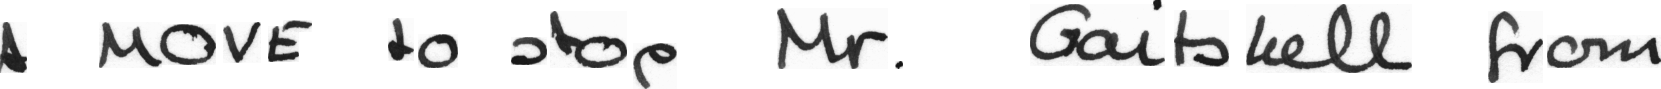

In [ ]:
line_image = Image.open(dataset[0][0])
line_image

In [ ]:
dataset[0][0]

NameError: name 'dataset' is not defined

In [ ]:
type(dataset)

numpy.ndarray

# **Data Preparation for training and testing**

In [ ]:
df = pd.read_csv('datasets/data.csv')

df.head()

Unnamed: 0                                         Path  \
0           0  datasets/lines/a01/a01-000u/a01-000u-00.png   
1           1  datasets/lines/a01/a01-000u/a01-000u-01.png   
2           2  datasets/lines/a01/a01-000u/a01-000u-02.png   
3           3  datasets/lines/a01/a01-000u/a01-000u-04.png   
4           4  datasets/lines/a01/a01-000u/a01-000u-06.png   

                                   Label  
0      A MOVE to stop Mr. Gaitskell from  
1  nominating any more Labour life Peers  
2   is to be made at a meeting of Labour  
3   put down a resolution on the subject  
4            P for Manchester Exchange .

In [ ]:
# Initialize an empty set to store the vocabulary
# dataset,vocab, maxlen = [],set(),0
import numpy as np
max_len = 0
d=[]
v=set()
# Iterate over the "Label" column values
for index, row in df.iterrows():
    path = row['Path']
    label = row['Label']

    d.append([path,label])
    v.update(list(label))
    max_len = np.maximum(max_len,len(label))

print(max_len,v)

93 {'I', ':', 'Z', 'X', '"', '+', 'P', '&', 'R', 'T', ',', 'b', '#', 'h', 'S', 'J', 'D', 'n', ';', '.', 'K', 't', '8', 'O', '4', 'u', 'c', '*', ' ', '7', 'a', 'Q', 's', '9', 'N', 'i', 'k', 'g', 'p', '(', 'v', 'e', 'z', 'f', 'B', 'Y', "'", '1', 'G', 'w', '5', '3', 'A', ')', 'V', 'd', 'l', 'j', '-', '2', '!', 'r', '0', 'L', 'C', 'W', '6', 'F', 'M', 'H', 'x', 'E', '/', 'y', 'q', '?', 'm', 'U', 'o'}


In [ ]:
def apply_dilation_erosion(image):
    kernel = np.ones((5, 5), np.uint8)
    image_dilated = cv2.dilate(image, kernel, iterations=1)
    image_eroded = cv2.erode(image_dilated, kernel, iterations=1)
    return image_eroded

In [ ]:
# Create a data provider for the dataset
def create_data_provider(dataset):
  data_provider = DataProvider(
      dataset=dataset,
      skip_validation=True,
      batch_size=configs.batch_size,
      data_preprocessors=[ImageReader(CVImage)],
      transformers=[
          ImageResizer(configs.width, configs.height, keep_aspect_ratio=True),
          LabelIndexer(configs.vocab),
          LabelPadding(max_word_length=configs.max_text_length, padding_value=len(configs.vocab)),
          ImageShowCV2(apply_dilation_erosion)
          ],
  )
  return data_provider


In [ ]:
data_provider = create_data_provider(dataset)
data_provider.to_csv(os.path.join("datasets", "data.csv"))#specify column

INFO:DataProvider:Skipping Dataset validation...


In [ ]:
df = pd.read_csv('datasets/data.csv')
df = df.rename(columns={'0': 'Path', '1': 'Label'})
df.head()

Path  \
0  datasets/lines/a01/a01-000u/a01-000u-00.png   
1  datasets/lines/a01/a01-000u/a01-000u-01.png   
2  datasets/lines/a01/a01-000u/a01-000u-02.png   
3  datasets/lines/a01/a01-000u/a01-000u-04.png   
4  datasets/lines/a01/a01-000u/a01-000u-06.png   

                                   Label  
0      A MOVE to stop Mr. Gaitskell from  
1  nominating any more Labour life Peers  
2   is to be made at a meeting of Labour  
3   put down a resolution on the subject  
4            P for Manchester Exchange .

In [ ]:
data_provider = create_data_provider(df)

INFO:DataProvider:Skipping Dataset validation...


# **Data Augmentation**

In [ ]:
!pip install imgaug

In [ ]:
from PIL import Image
import pandas as pd
import random
import matplotlib.pyplot as plt

# Function to apply random rotation to an image
def random_rotation(image, max_rotation_angle=10):
    rotation_angle = random.uniform(-max_rotation_angle, max_rotation_angle)
    return image.rotate(rotation_angle, resample=Image.BICUBIC, expand=True)

# Function to apply random scaling to an image
def random_scaling(image, max_scaling_factor=0.3):
    scaling_factor = random.uniform(1 - max_scaling_factor, 1 + max_scaling_factor)
    scaled_width = int(image.width * scaling_factor)
    scaled_height = int(image.height * scaling_factor)
    return image.resize((scaled_width, scaled_height), resample=Image.BICUBIC)

# Function to apply random translation to an image
def random_translation(image, max_translation=0.3):
    translation_x = random.randint(-int(max_translation * image.width), int(max_translation * image.width))
    translation_y = random.randint(-int(max_translation * image.height), int(max_translation * image.height))
    return image.transform(image.size, Image.AFFINE, (1, 0, translation_x, 0, 1, translation_y), resample=Image.BICUBIC)


## **Image Rotation**

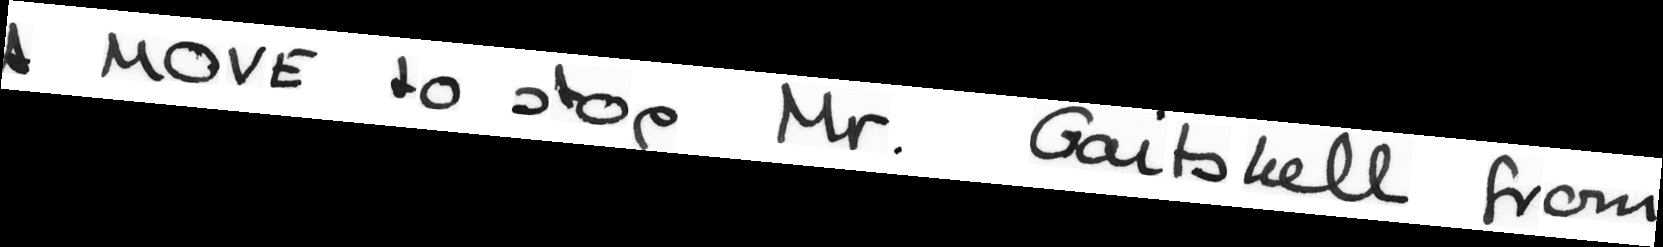

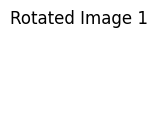

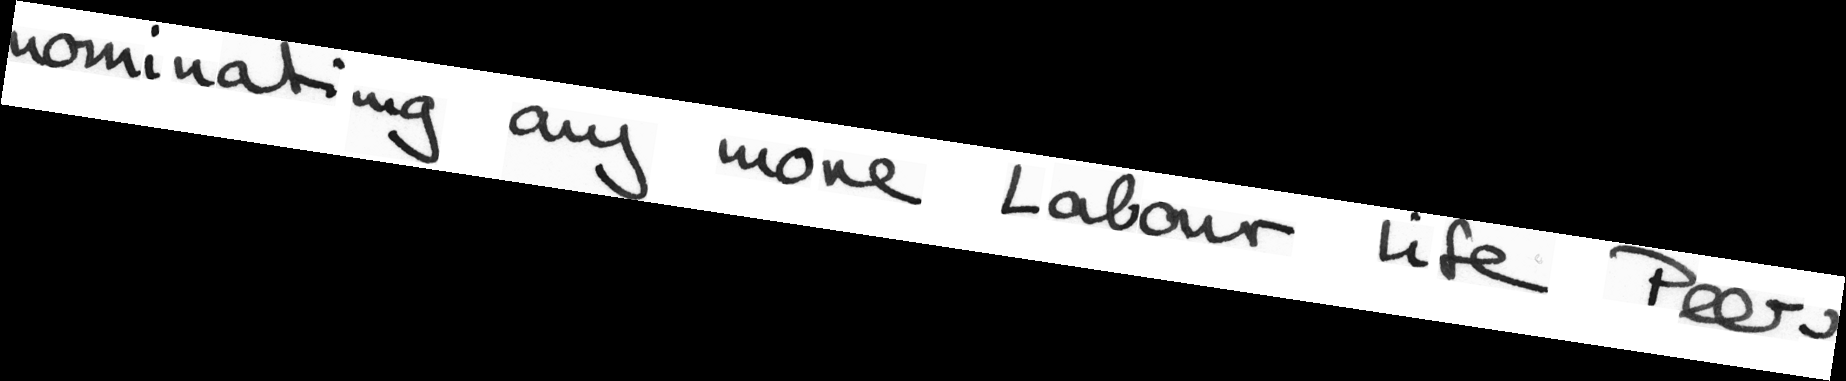

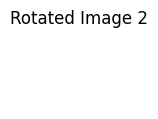

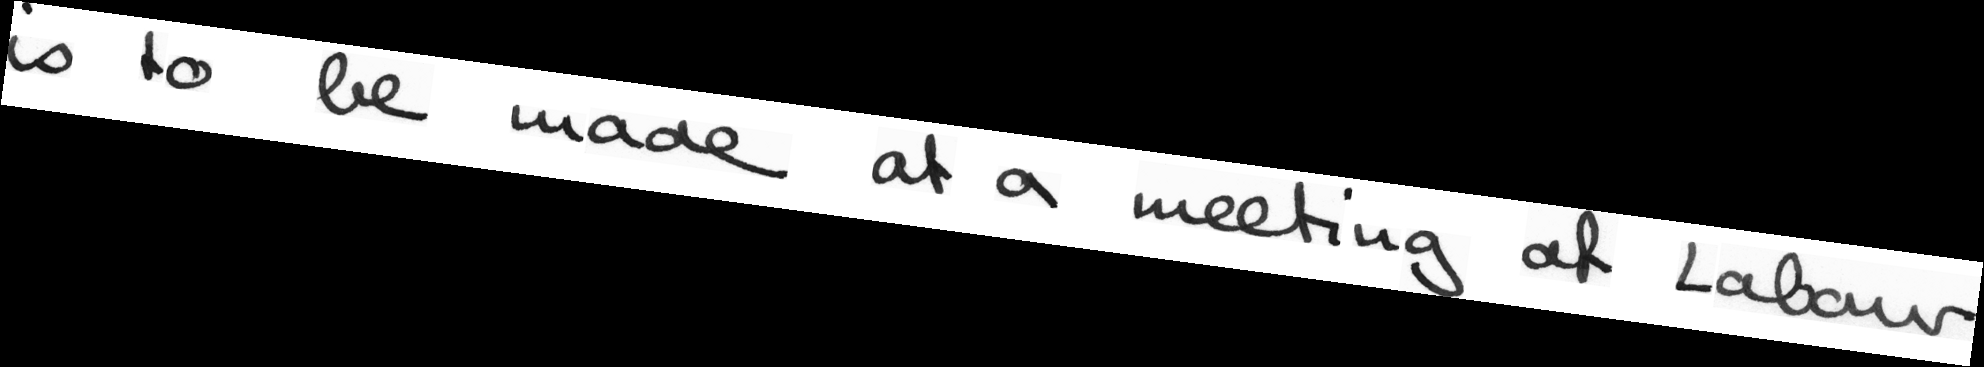

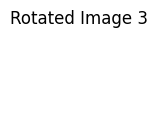

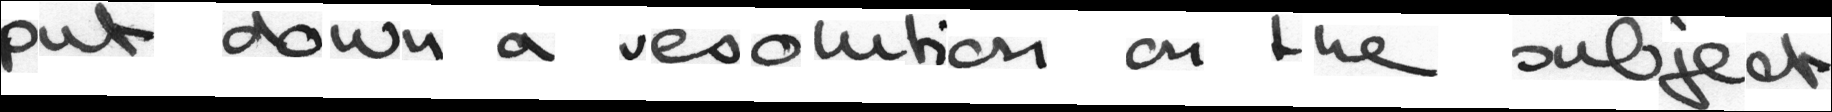

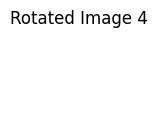

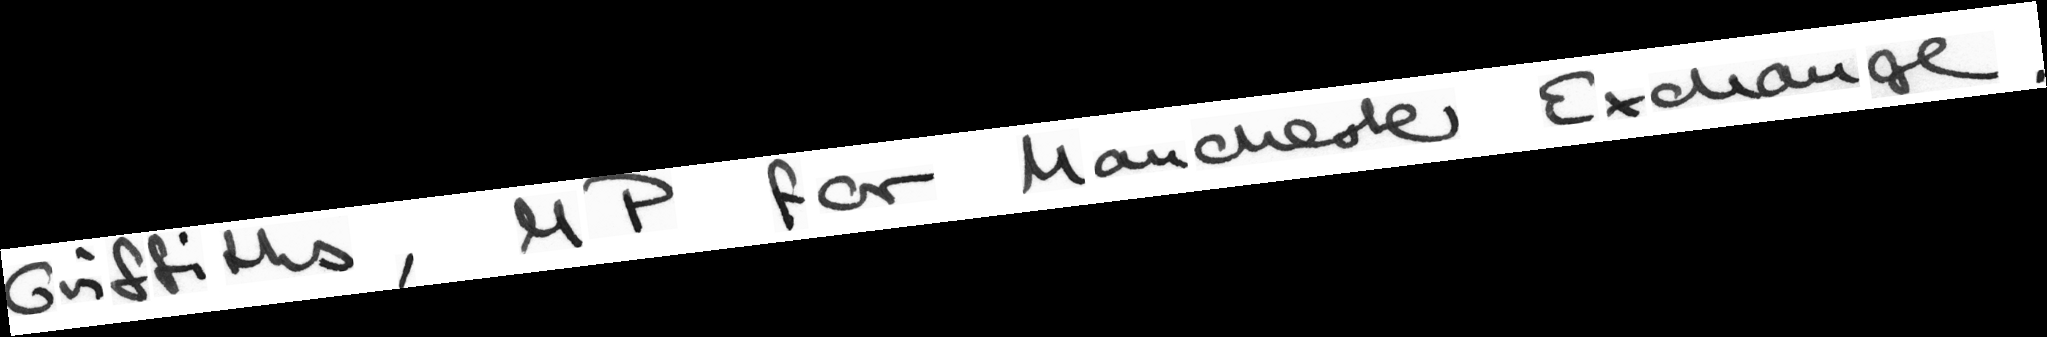

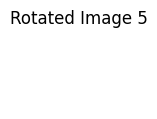

In [ ]:
# Apply random transformations to the first 5 images and visualize them
num_images = min(5, len(df))
for i in range(num_images):
    image_path = df.loc[i, 'Path']
    # Load the original image
    original_image = Image.open(image_path)

    # Apply random rotation
    rotated_image = random_rotation(original_image)
    plt.figure(figsize=(1, 1))
    display(rotated_image)
    plt.title(f'Rotated Image {i+1}')
    plt.axis('off')
    plt.show()

## **Image Scaling**

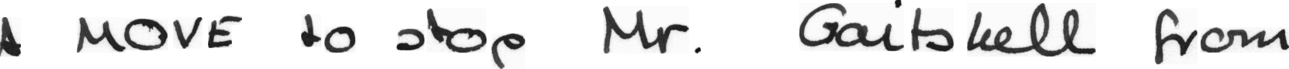

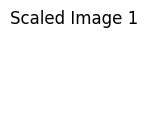

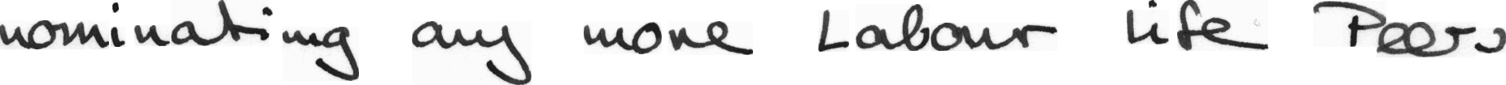

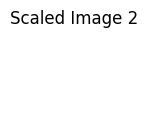

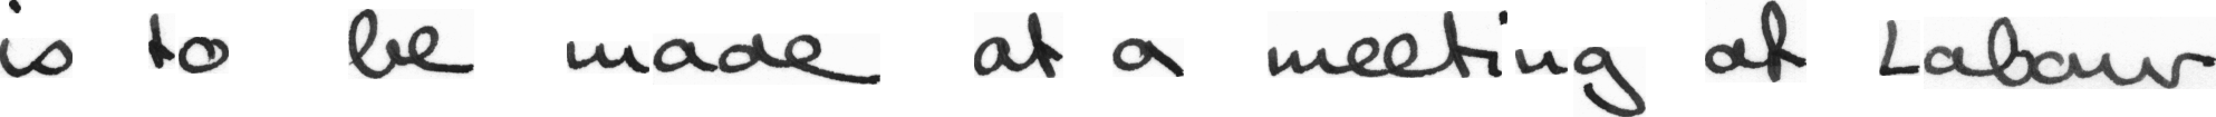

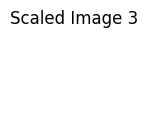

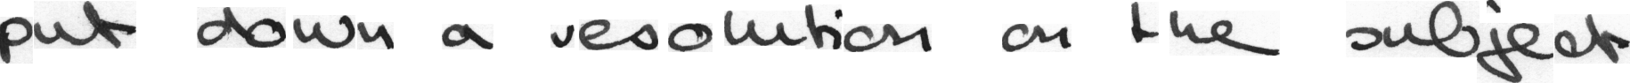

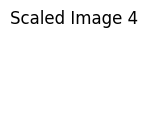

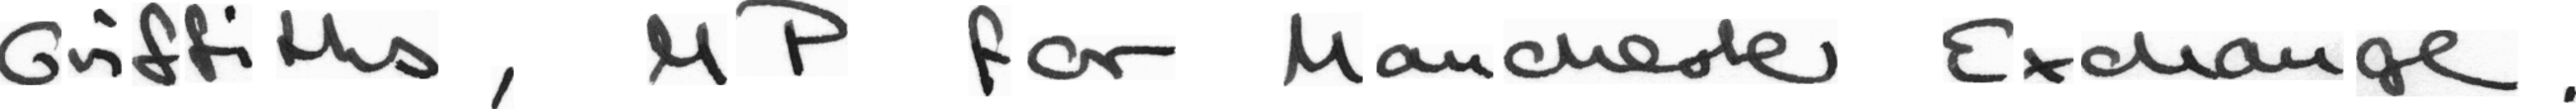

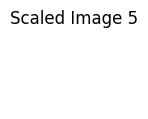

In [ ]:
for i in range(num_images):
    image_path = df.loc[i, 'Path']
    # Load the original image
    original_image = Image.open(image_path)

    # Apply random scaling
    scaled_image = random_scaling(original_image)
    plt.figure(figsize=(1,1))
    display(scaled_image)
    plt.title(f'Scaled Image {i+1}')
    plt.axis('off')
    plt.show()

## **Image Translation**

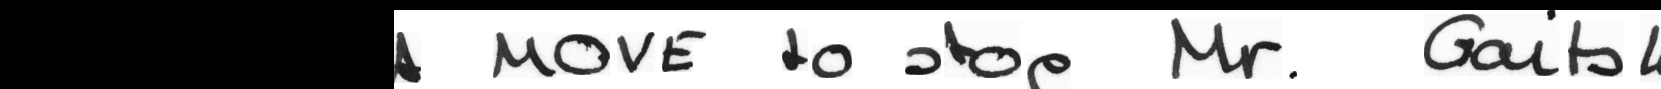

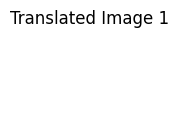

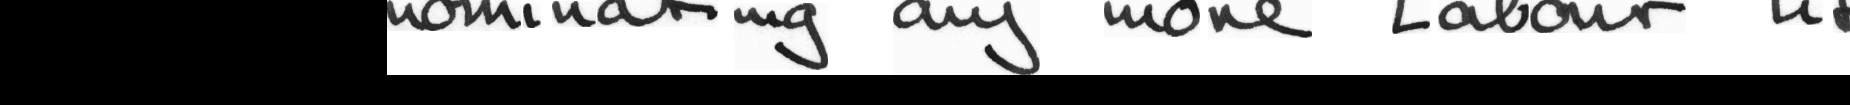

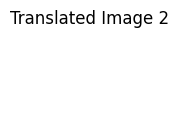

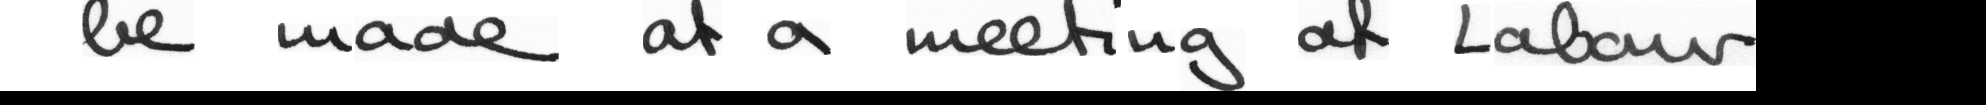

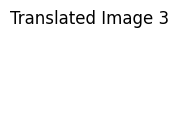

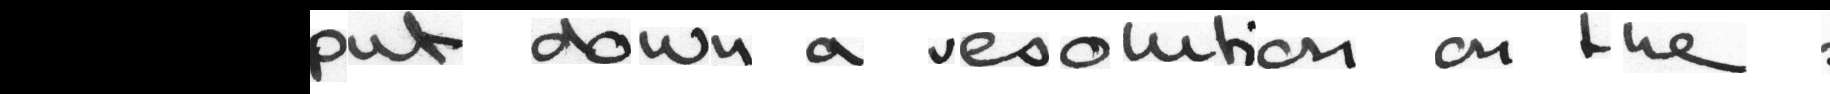

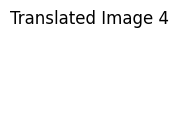

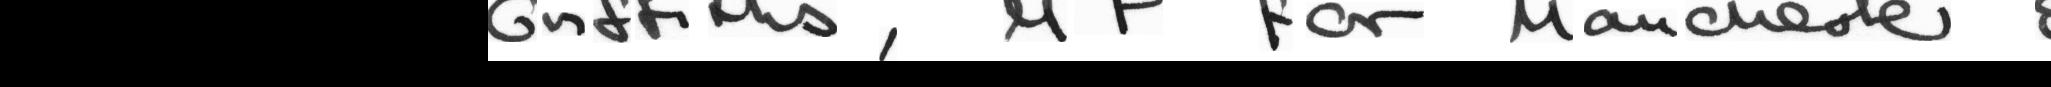

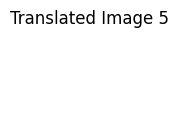

In [ ]:
for i in range(num_images):
    image_path = df.loc[i, 'Path']
    # Load the original image
    original_image = Image.open(image_path)

    # Apply random translation
    translated_image = random_translation(original_image)
    plt.figure(figsize=(1, 1))
    display(translated_image)
    plt.title(f'Translated Image {i+1}')
    plt.axis('off')
    plt.show()

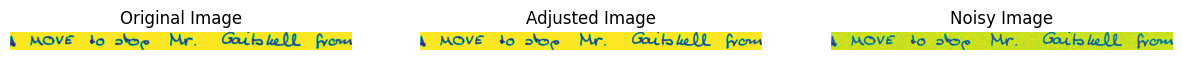

In [ ]:
from PIL import ImageEnhance
import matplotlib.pyplot as plt

# Function to apply random brightness adjustment to an image
def random_brightness(image, max_brightness_factor=0.4):
    brightness_factor = random.uniform(1 - max_brightness_factor, 1 + max_brightness_factor)
    enhancer = ImageEnhance.Brightness(image)
    return enhancer.enhance(brightness_factor)

# Function to add random noise to an image
def add_noise(image, noise_factor=0.2):
    # Generate random noise with the same shape as the image
    noise = np.random.normal(loc=0, scale=noise_factor, size=image.shape)
    # Add the noise to the image
    noisy_image = np.clip(image + noise, 0, 1)
    return noisy_image

# Sample usage:
raw_image_path = df['Path'][0]
raw_image = Image.open(raw_image_path)

# Apply random brightness adjustment to the original image
adjusted_image = random_brightness(raw_image)

# Add noise to the adjusted image
noisy_image = add_noise(np.array(adjusted_image) / 255.0)  # Convert to numpy array and normalize

# Display the original, adjusted, and noisy images side by side for visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(raw_image)
axes[0].set_title('Original Image')
axes[0].axis('off')
axes[1].imshow(adjusted_image)
axes[1].set_title('Adjusted Image')
axes[1].axis('off')
axes[2].imshow(noisy_image)
axes[2].set_title('Noisy Image')
axes[2].axis('off')
plt.show()


# **Image Preprocessing**

**Sharpening**

In [ ]:
cd datasets && ls

[Errno 2] No such file or directory: 'datasets && ls'
/content/drive/MyDrive


In [ ]:
import cv2

In [ ]:
img_bgr = cv2.imread("datasets/j04-046.png", cv2.IMREAD_COLOR)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

# Image(filename="test.jpg")

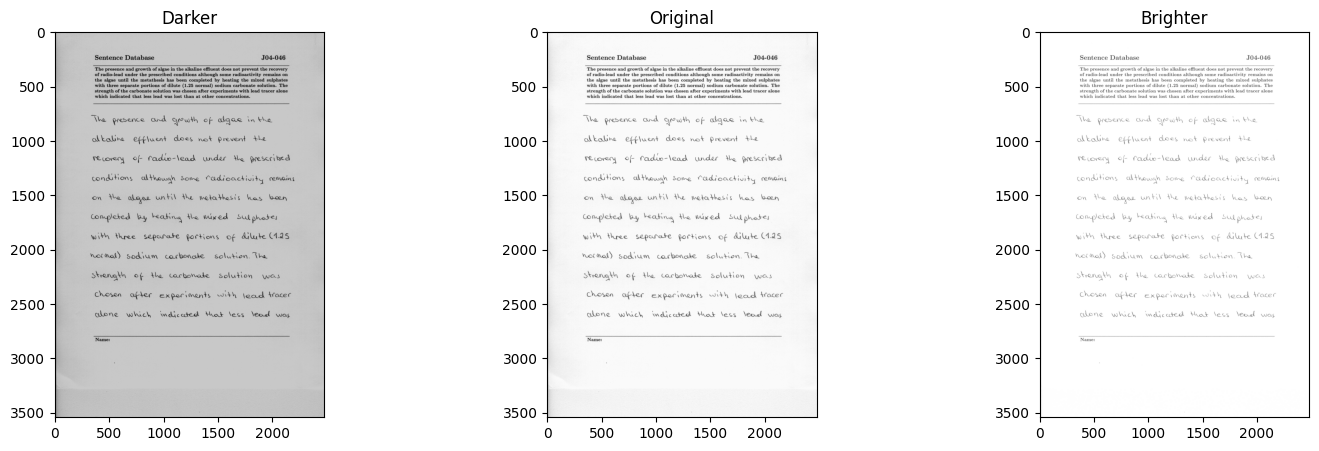

In [ ]:
matrix = np.ones(img_rgb.shape, dtype="uint8") * 50

img_rgb_brighter = cv2.add(img_rgb, matrix)
img_rgb_darker   = cv2.subtract(img_rgb, matrix)


# Show the images
plt.figure(figsize=[18, 5])
plt.subplot(131); plt.imshow(img_rgb_darker);  plt.title("Darker");
plt.subplot(132); plt.imshow(img_rgb);         plt.title("Original");
plt.subplot(133); plt.imshow(img_rgb_brighter);plt.title("Brighter");

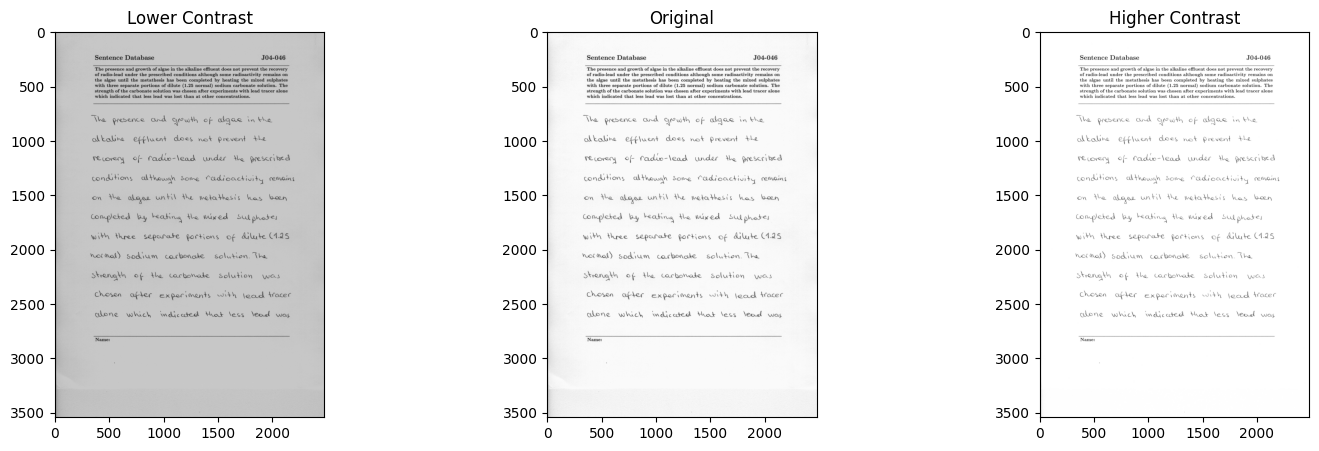

In [ ]:
matrix1 = np.ones(img_rgb.shape) * 0.8
matrix2 = np.ones(img_rgb.shape) * 1.2

img_rgb_lower  = np.uint8(cv2.multiply(np.float64(img_rgb), matrix1))
img_rgb_higher = np.uint8(np.clip(cv2.multiply(np.float64(img_rgb), matrix2), 0, 255))

# Show the images
plt.figure(figsize=[18,5])
plt.subplot(131); plt.imshow(img_rgb_lower); plt.title("Lower Contrast");
plt.subplot(132); plt.imshow(img_rgb);       plt.title("Original");
plt.subplot(133); plt.imshow(img_rgb_higher);plt.title("Higher Contrast");

**GrayScale Conversion**

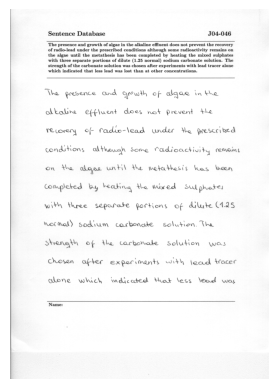

In [ ]:
# prompt: conver img_rgb to grayscale

img_grayscale = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)

plt.imshow(img_grayscale, cmap='gray')
plt.axis('off')
plt.show()


**Binarization or Thresholding**

(3542, 2479)


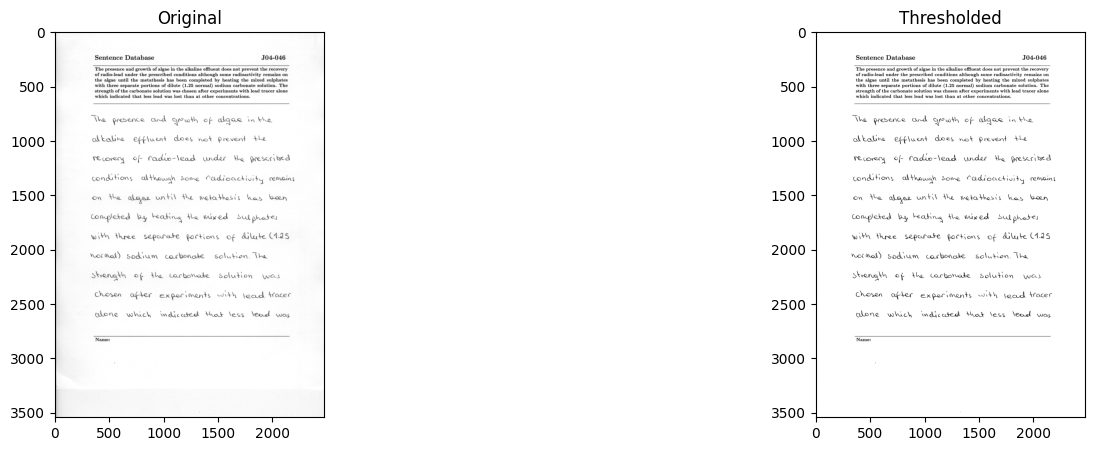

In [ ]:
img_read = cv2.imread("datasets/j04-046.png", cv2.IMREAD_GRAYSCALE)
retval, img_thresh = cv2.threshold(img_read, 150, 255, cv2.THRESH_BINARY)

# Show the images
plt.figure(figsize=[18, 5])

plt.subplot(121);plt.imshow(img_read, cmap="gray");  plt.title("Original")
plt.subplot(122);plt.imshow(img_thresh, cmap="gray");plt.title("Thresholded")

print(img_thresh.shape)

### **Morphological image processing**
- **Dilation**
- **Erosion**

Text(0.5, 1.0, 'Eroded')

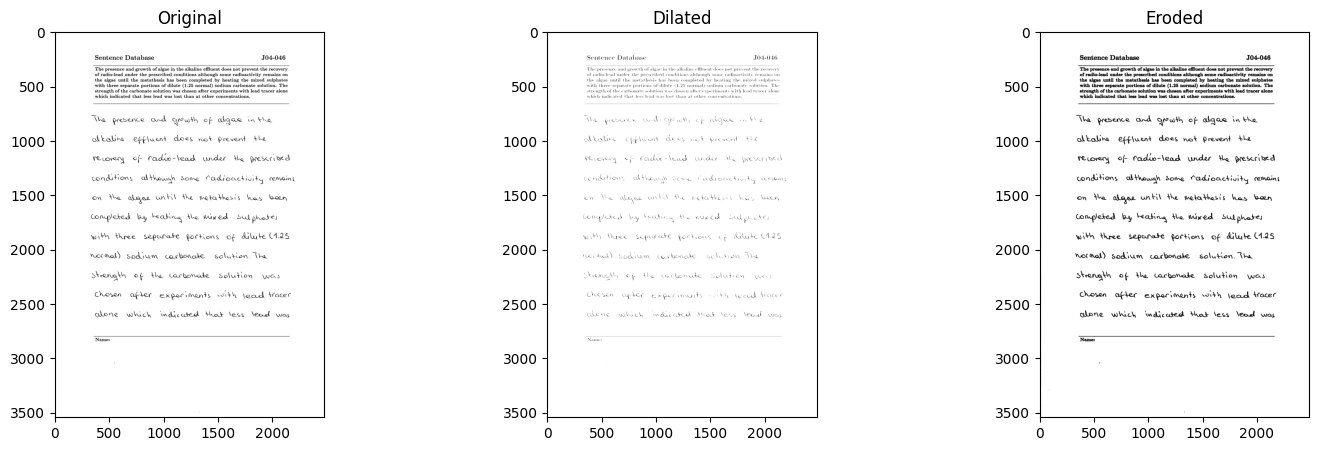

In [ ]:
# prompt: apply morphological image processing to thresholded image

# **Dilation**
kernel = np.ones((3, 3), np.uint8)
img_dilate = cv2.dilate(img_thresh, kernel, iterations=1)

# **Erosion**
kernel = np.ones((3, 3), np.uint8)
img_erode = cv2.erode(img_thresh, kernel, iterations=1)

# Show the images
plt.figure(figsize=[18, 5])

plt.subplot(131);plt.imshow(img_thresh, cmap="gray");  plt.title("Original")
plt.subplot(132);plt.imshow(img_dilate, cmap="gray");plt.title("Dilated")
plt.subplot(133);plt.imshow(img_erode, cmap="gray");plt.title("Eroded")


**Skew Correction or Image Alignment**

![alt text](https://learnopencv.com/wp-content/uploads/2023/03/opencv_bootcamp_08_image-alignment-using-opencv.jpg "Image Alignment")



## **Read Scanned Image**

In [ ]:
#read reference image
refFilename = "datasets/j04-046.png"
print("Reading image : ",refFilename)
image1 = cv2.imread(refFilename, cv2.IMREAD_COLOR)
image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)

#read targeted image; image to be aligned
imFilename = "datasets/skew.jpg"
print("Reading image to align:", imFilename)
image2 = cv2.imread(imFilename, cv2.IMREAD_COLOR)
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)


Reading image :  datasets/j04-046.png
Reading image to align: datasets/skew.jpg


**Finding Keypoints in both image**

Text(0.5, 1.0, 'Scanned Form')

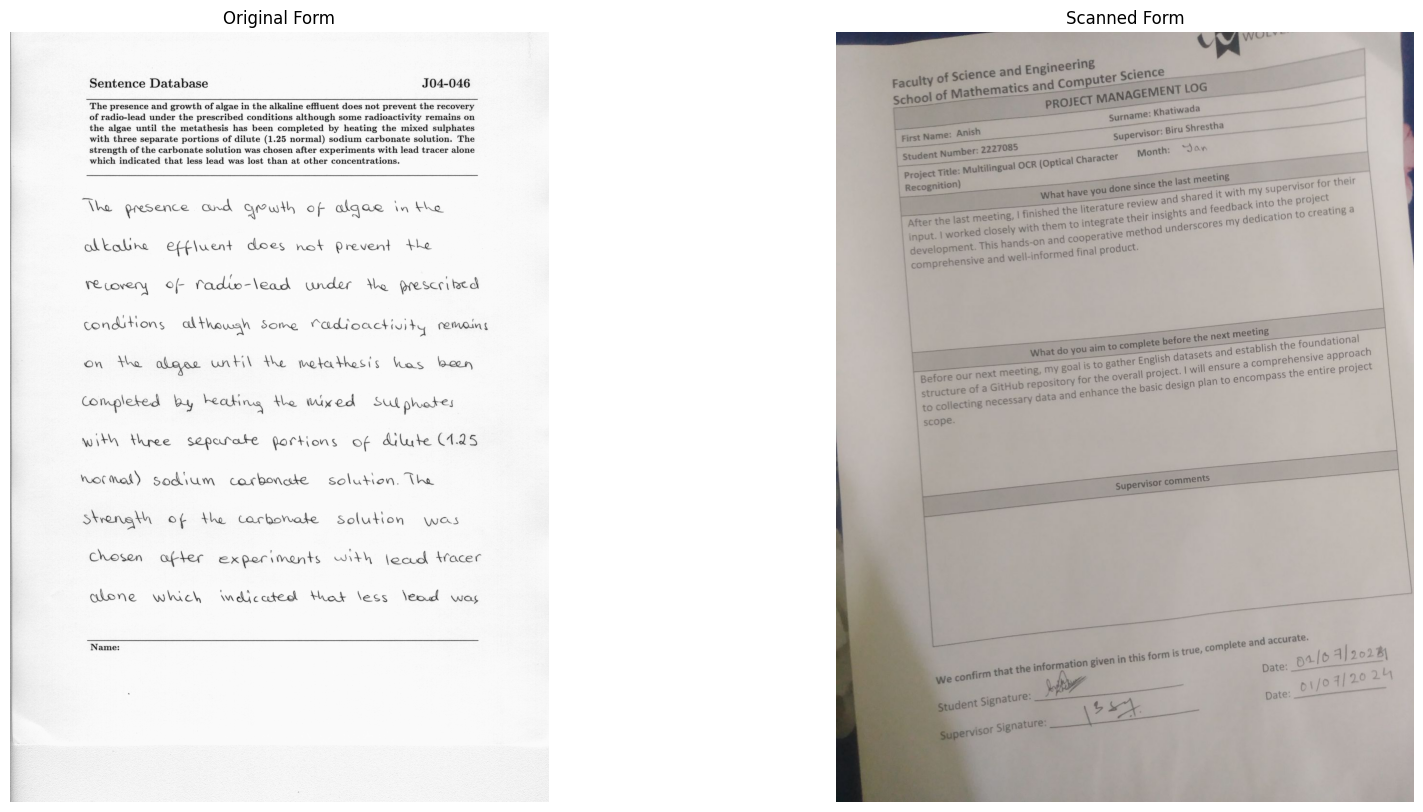

In [ ]:
# Display Images

plt.figure(figsize=[20, 10]);
plt.subplot(121); plt.axis('off'); plt.imshow(image1); plt.title("Original Form")
plt.subplot(122); plt.axis('off'); plt.imshow(image2); plt.title("Scanned Form")

In [ ]:
# Convert images to grayscale
im1_gray = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
im2_gray = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)


# Detect ORB features and compute descriptors.
MAX_NUM_FEATURES = 500
orb = cv2.ORB_create(MAX_NUM_FEATURES)
keypoints1, descriptors1 = orb.detectAndCompute(im1_gray, None)
keypoints2, descriptors2 = orb.detectAndCompute(im2_gray, None)

# Display
im1_display = cv2.drawKeypoints(image1, keypoints1, outImage=np.array([]),
                                color=(255, 0, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

im2_display = cv2.drawKeypoints(image2, keypoints2, outImage=np.array([]),
                                color=(255, 0, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

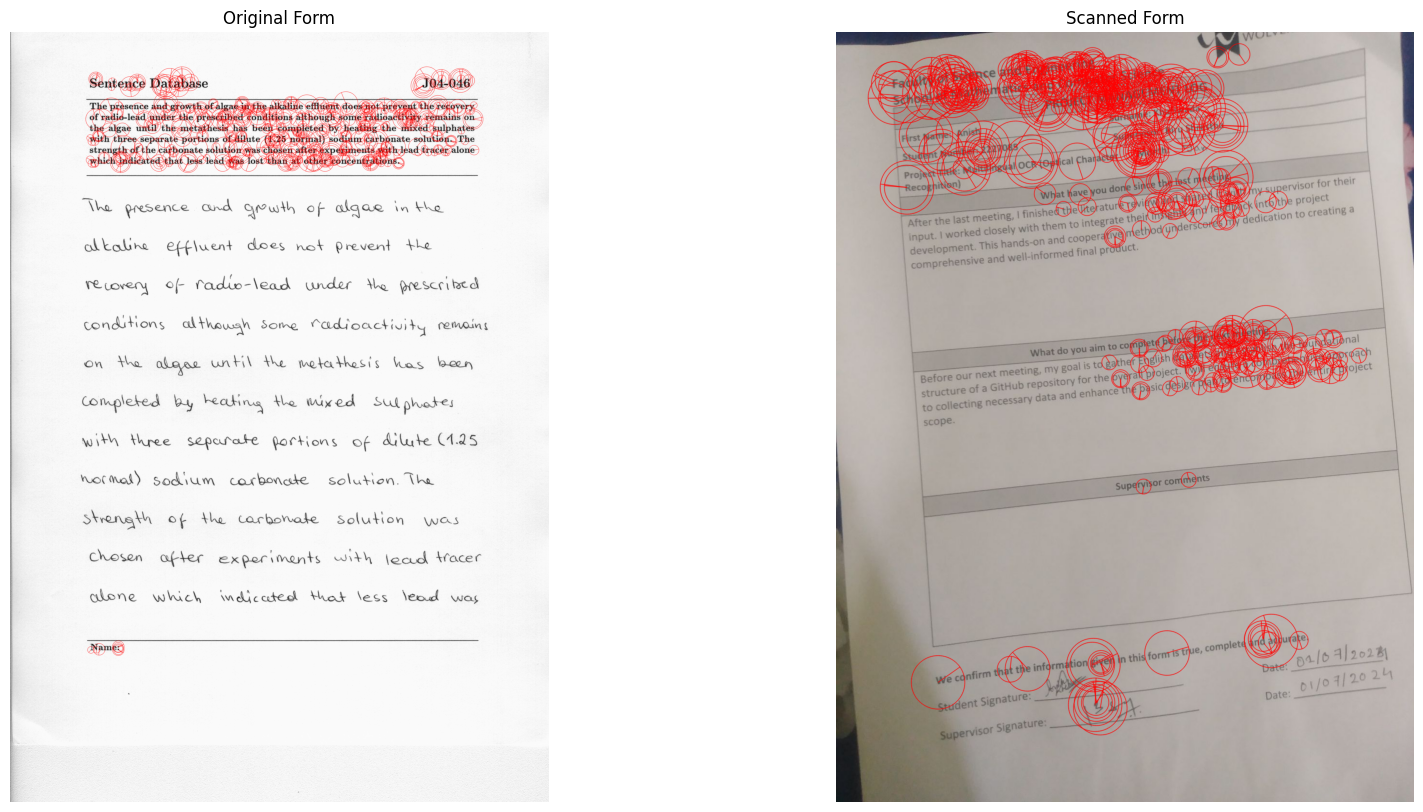

In [ ]:
plt.figure(figsize=[20,10])
plt.subplot(121); plt.axis('off'); plt.imshow(im1_display); plt.title("Original Form");
plt.subplot(122); plt.axis('off'); plt.imshow(im2_display); plt.title("Scanned Form");

**Match Keypoints in the two image**

In [ ]:
# Match features.
matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)

# Converting to list for sorting as tuples are immutable objects.
matches = list(matcher.match(descriptors1, descriptors2, None))

# Sort matches by score
matches.sort(key=lambda x: x.distance, reverse=False)

# Remove not so good matches
numGoodMatches = int(len(matches) * 0.1)
matches = matches[:numGoodMatches]

Text(0.5, 1.0, 'Original Form')

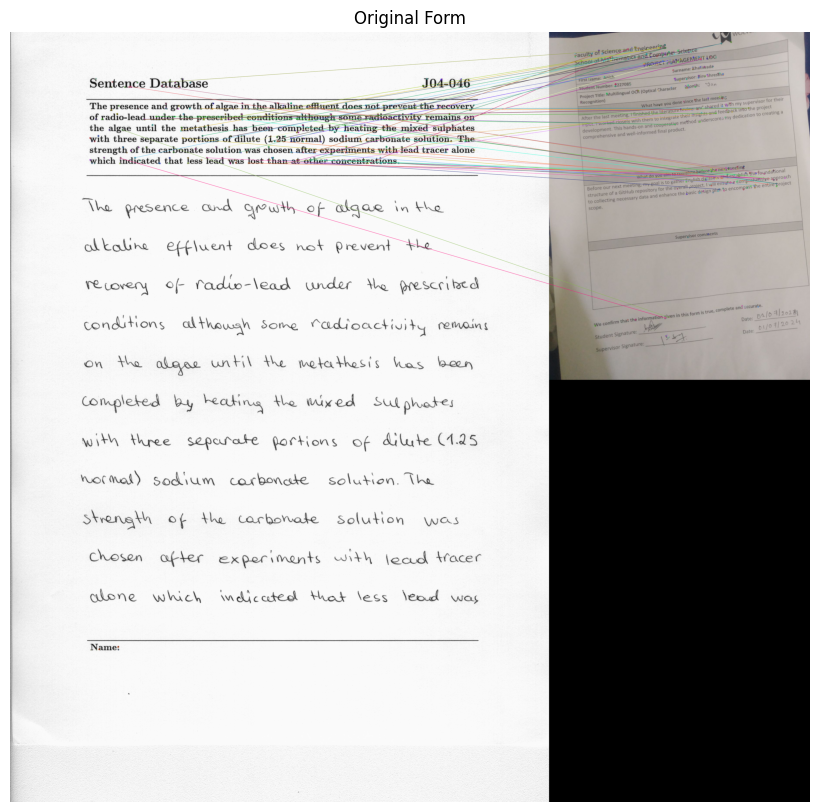

In [ ]:
# Draw top matches
im_matches = cv2.drawMatches(image1, keypoints1, image2, keypoints2, matches, None)

plt.figure(figsize=[40, 10])
plt.imshow(im_matches);plt.axis("off");plt.title("Original Form")

**Find Homography**

In [ ]:
# Extract location of good matches
points1 = np.zeros((len(matches), 2), dtype=np.float32)
points2 = np.zeros((len(matches), 2), dtype=np.float32)

for i, match in enumerate(matches):
    points1[i, :] = keypoints1[match.queryIdx].pt
    points2[i, :] = keypoints2[match.trainIdx].pt

# Find homography
h, mask = cv2.findHomography(points2, points1, cv2.RANSAC)

**Wrap Final Image after alligning**

Text(0.5, 1.0, 'Scanned Form')

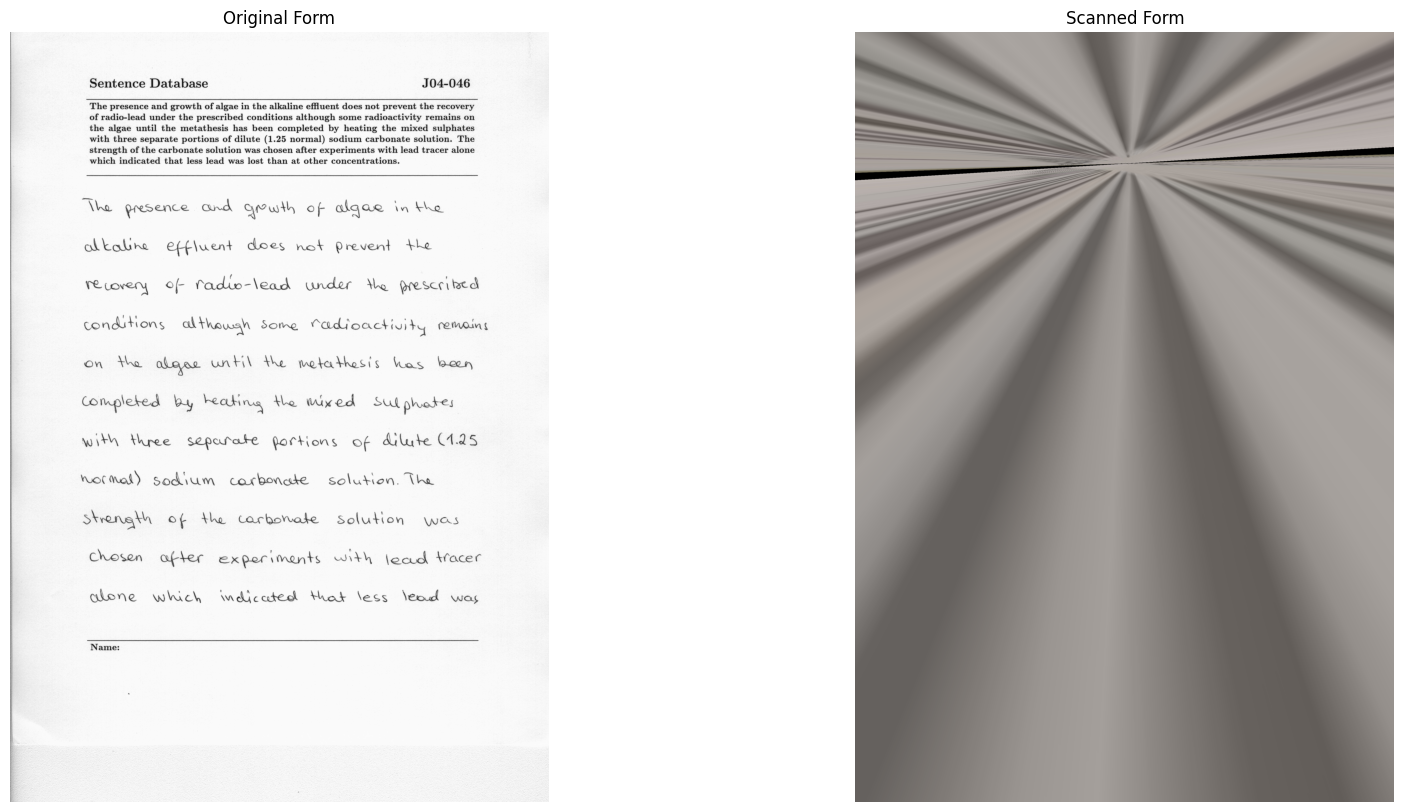

In [ ]:
# Use homography to warp image
height, width, channels = image1.shape
im2_reg = cv2.warpPerspective(image2, h, (width, height))

# Display results
plt.figure(figsize=[20, 10])
plt.subplot(121);plt.imshow(image1);    plt.axis("off");plt.title("Original Form")
plt.subplot(122);plt.imshow(im2_reg);plt.axis("off");plt.title("Scanned Form")

## **Split data into training and validation set**

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

In [ ]:
import cv2
import numpy as np

def dilate_erode_images_with_labels_in_memory(data_list, kernel_size=(3, 3), iterations=1):
    processed_images = []

    # Iterate over each image-path pair in the data list
    for image_path, label_text in data_list:
        # Read the image
        img = cv2.imread(image_path)

        # Convert image to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Apply dilation and erosion
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, kernel_size)
        dilated = cv2.dilate(gray, kernel, iterations=iterations)
        eroded = cv2.erode(dilated, kernel, iterations=iterations)

        # Append processed image and label to the list
        processed_images.append((eroded, label_text))

        # print(f"Processed image with label: {label_text}")

    return processed_images


processed_data = dilate_erode_images_with_labels_in_memory(dataset, kernel_size=(5, 5), iterations=1)


In [ ]:
# prompt: import IMshowCV2

from mltu.annotations.images import CVImage
from mltu.transformers import ImageShowCV2


In [ ]:

# Create a data provider for the dataset
# data_provider = create_data_provider(dataset)

# Apply dilation and erosion to the images in the dataset
data_provider.transformers.append(ImageShowCV2(apply_dilation_erosion))


In [ ]:
def apply_dilation_erosion(image):

    # Convert image to grayscale
    # gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Otsu thresholding.
    thresh, _ = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    kernel = np.ones((5, 5), np.uint8)
    image_dilated = cv2.dilate(thresh, kernel, iterations=1)
    image_eroded = cv2.erode(image_dilated, kernel, iterations=1)
    return image_eroded

In [ ]:
def create_data_provider(dataset):
    data_provider = DataProvider(
        dataset= dataset,
        skip_validation=True,
        batch_size=configs.batch_size,
        data_preprocessors=[ImageReader(CVImage)],
        transformers=[
            ImageResizer(configs.width, configs.height, keep_aspect_ratio=True),
            LabelIndexer(configs.vocab),
            LabelPadding(max_word_length=configs.max_text_length, padding_value=len(configs.vocab))
        ],
    )
    return data_provider

# Create data provider with dilation and erosion
data_provider = create_data_provider(d)

INFO:DataProvider:Skipping Dataset validation...


In [ ]:
d[:5]

[['datasets/lines/g07/g07-003b/g07-003b-04.png',
  "Gamba accompanied the remains of our deceased friend to Zante ... . '"],
 ['datasets/lines/a06/a06-064/a06-064-06.png',
  'of such ferocity . But there was ample'],
 ['datasets/lines/g06/g06-050h/g06-050h-01.png',
  'at Ko"then , near Leipzig , asking for advice . In doing'],
 ['datasets/lines/h07/h07-066a/h07-066a-06.png', 'national average .'],
 ['datasets/lines/a02/a02-027/a02-027-04.png',
  "Ghana Government introduced in July . Ghana's strong"]]

In [ ]:
# Split the dataset into training and validation sets|
train_data_provider, val_data_provider = data_provider.split(split = 0.9)

In [ ]:
# Augment training data with random brightness, rotation and erode/dilate
train_data_provider.augmentors = [
    RandomBrightness(),
    RandomSharpen(),
    RandomRotate(),
    RandomColorMode(),
    ]

# **Modeling**



In [ ]:
def train_model(input_dim, output_dim, activation="leaky_relu", dropout=0.2):

    inputs = layers.Input(shape=input_dim, name="input")

    # normalize images here instead in preprocessing step
    input = layers.Lambda(lambda x: x / 255)(inputs)

    x1 = residual_block(input, 32, activation=activation, skip_conv=True, strides=1, dropout=dropout)

    x2 = residual_block(x1, 32, activation=activation, skip_conv=True, strides=2, dropout=dropout)
    x3 = residual_block(x2, 32, activation=activation, skip_conv=False, strides=1, dropout=dropout)

    x4 = residual_block(x3, 64, activation=activation, skip_conv=True, strides=2, dropout=dropout)
    x5 = residual_block(x4, 64, activation=activation, skip_conv=False, strides=1, dropout=dropout)

    x6 = residual_block(x5, 128, activation=activation, skip_conv=True, strides=2, dropout=dropout)
    x7 = residual_block(x6, 128, activation=activation, skip_conv=True, strides=1, dropout=dropout)

    x8 = residual_block(x7, 128, activation=activation, skip_conv=True, strides=2, dropout=dropout)
    x9 = residual_block(x8, 128, activation=activation, skip_conv=False, strides=1, dropout=dropout)

    squeezed = layers.Reshape((x9.shape[-3] * x9.shape[-2], x9.shape[-1]))(x9)

    blstm = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(squeezed)
    blstm = layers.Dropout(dropout)(blstm)

    blstm = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(blstm)
    blstm = layers.Dropout(dropout)(blstm)

    output = layers.Dense(output_dim + 1, activation="softmax", name="output")(blstm)

    model = Model(inputs=inputs, outputs=output)
    return model

In [ ]:
#create model
model = train_model(
    output_dim = len(configs.vocab),
    input_dim = (configs.height, configs.width, 3),
)

In [ ]:
from mltu.tensorflow.losses import CTCloss
from mltu.tensorflow.callbacks import Model2onnx, TrainLogger
from mltu.tensorflow.metrics import CERMetric, WERMetric

In [ ]:
model.compile(optimizer = 'adam', loss = CTCloss(), metrics = [CERMetric(vocabulary=configs.vocab),WERMetric(vocabulary=configs.vocab)], run_eagerly=False)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 96, 1408, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 96, 1408, 3)  0           ['input[0][0]']                  
                                                                                                  
 conv2d (Conv2D)                (None, 96, 1408, 32  896         ['lambda[0][0]']                 
                                )                                                                 
                                                                                              

In [ ]:
pip install tf2onnx

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from mltu.tensorflow.callbacks import Model2onnx, TrainLogger

In [ ]:
# Define callbacks
earlystopper = EarlyStopping(monitor="val_CER", patience=20, verbose=1, mode="min")
checkpoint = ModelCheckpoint(f"{configs.model_path}/model.h5", monitor="val_CER", verbose=1, save_best_only=True, mode="min")
trainLogger = TrainLogger(configs.model_path)
tb_callback = TensorBoard(f"{configs.model_path}/logs", update_freq=1)
reduceLROnPlat = ReduceLROnPlateau(monitor="val_CER", factor=0.9, min_delta=1e-10, patience=5, verbose=1, mode="auto")
model2onnx = Model2onnx(f"{configs.model_path}/model.h5")


In [ ]:
#training the model now
model.fit(
    train_data_provider,
    validation_data = val_data_provider,
    epochs = configs.train_epochs,
    callbacks = [earlystopper, checkpoint, trainLogger, reduceLROnPlat, tb_callback,model2onnx],
    workers = configs.train_workers
)

Epoch 1/1000


2024-02-14 19:16:05.751093: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


376/376 [==============================] - ETA: 0s - loss: 167.3071 - CER: 1.0244 - WER: 1.0000
Epoch 1: val_CER improved from inf to 1.00000, saving model to Model/202402141915/model.h5
376/376 [==============================] - 434s 1s/step - loss: 167.3071 - CER: 1.0244 - WER: 1.0000 - val_loss: 137.6740 - val_CER: 1.0000 - val_WER: 1.0000 - lr: 0.0010
Epoch 2/1000
376/376 [==============================] - ETA: 0s - loss: 136.1431 - CER: 0.9997 - WER: 1.0000
Epoch 2: val_CER did not improve from 1.00000
376/376 [==============================] - 394s 1s/step - loss: 136.1431 - CER: 0.9997 - WER: 1.0000 - val_loss: 138.1785 - val_CER: 1.0000 - val_WER: 1.0000 - lr: 0.0010
Epoch 3/1000
376/376 [==============================] - ETA: 0s - loss: 135.4151 - CER: 0.9945 - WER: 0.9997
Epoch 3: val_CER improved from 1.00000 to 0.99939, saving model to Model/202402141915/model.h5
376/376 [==============================] - 401s 1s/step - loss: 135.4151 - CER: 0.9945 - WER: 0.9997 - val_loss:

In [ ]:
from mltu.tensorflow.losses import CTCloss

In [ ]:
# from tensorflow_addons import losses

In [ ]:
!ls Model/202402141915/

configs.yaml  logs  logs.log  model.h5


In [ ]:
# Define callbacks
earlystopper = EarlyStopping(monitor="val_CER", patience=30, verbose=1, mode="min")
checkpoint = ModelCheckpoint(f"{configs.model_path}/model.h5", monitor="val_CER", verbose=1, save_best_only=True, mode="min")
trainLogger = TrainLogger(configs.model_path)
tb_callback = TensorBoard(f"{configs.model_path}/logs", update_freq=1)
reduceLROnPlat = ReduceLROnPlateau(monitor="val_CER", factor=0.9, min_delta=1e-10, patience=5, verbose=1, mode="auto")
model2onnx = Model2onnx(f"{configs.model_path}/model.h5")

In [ ]:
import os
from keras.models import load_model
from mltu.tensorflow.losses import CTCloss

# Load the existing model
model_path = "Model/202402170444/model.h5"
model = load_model(model_path, compile = False)

# Compile the model
model.compile(optimizer='adam', loss=CTCloss(),metrics = [CERMetric(vocabulary=configs.vocab),WERMetric(vocabulary=configs.vocab)], run_eagerly=False)


In [ ]:
# Fit the model starting from epoch 15 to epoch 25
model.fit(
    train_data_provider,
    validation_data=val_data_provider,
    initial_epoch=30,  # Start from the 15th epoch
    epochs=50,
    callbacks=[earlystopper, checkpoint, trainLogger, reduceLROnPlat, tb_callback,model2onnx],
    workers=configs.train_workers
)

In [ ]:
# Define callbacks
earlystopper = EarlyStopping(monitor="val_CER", patience=20, verbose=1, mode="min")
checkpoint = ModelCheckpoint(f"{configs.model_path}/model.h5", monitor="val_CER", verbose=1, save_best_only=True, mode="min")
trainLogger = TrainLogger(configs.model_path)
tb_callback = TensorBoard(f"{configs.model_path}/logs", update_freq=1)
reduceLROnPlat = ReduceLROnPlateau(monitor="val_CER", factor=0.9, min_delta=1e-10, patience=5, verbose=1, mode="auto")
model2onnx = Model2onnx(f"{configs.model_path}/model.h5")

In [ ]:
import os
from keras.models import load_model
from mltu.tensorflow.losses import CTCloss

# Load the existing model
model_path = "Model/202405071438/model.h5"
model = load_model(model_path, compile = False)

optimizer = tf.keras.optimizers.Adam(learning_rate=configs.learning_rate)

# Compile the model
model.compile(optimizer=optimizer, loss=CTCloss(),metrics = [CERMetric(vocabulary=configs.vocab),WERMetric(vocabulary=configs.vocab)], run_eagerly=False)


In [ ]:

!nvidia-smi


Thu May 23 09:26:42 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0              30W /  70W |    167MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
#fit the existing loaded model
model.fit(
    train_data_provider,
    validation_data=val_data_provider,
    initial_epoch=224,  # continue from the 190th epoch to 300 epochs
    epochs=260,
    callbacks=[earlystopper, checkpoint, trainLogger, reduceLROnPlat, tb_callback,model2onnx],
    # workers=configs.train_workers
)


Exception in thread Thread-14 (_display_images):
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/mltu/transformers.py", line 367, in _display_images
    cv2.imshow(self.name, image.numpy())
  File "/usr/local/lib/python3.10/dist-packages/google/colab/_import_hooks/_cv2.py", line 48, in wrapped
    raise DisabledFunctionError(message, name or func.__name__)
google.colab._import_hooks._cv2.DisabledFunctionError: cv2.imshow() is disabled in Colab, because it causes Jupyter sessions
to crash; see https://github.com/jupyter/notebook/issues/3935.
As a substitution, consider using
  from google.colab.patches import cv2_imshow



KeyboardInterrupt: 

In [ ]:
# Save training and validation datasets as csv files
train_data_provider.to_csv(os.path.join(configs.model_path, "train.csv"))
val_data_provider.to_csv(os.path.join(configs.model_path, "val.csv"))

In [ ]:
lr: 9.0000e-04

In [ ]:
# Save training and validation datasets as csv files
train_data_provider.to_csv(os.path.join("datasets", "train.csv"))
val_data_provider.to_csv(os.path.join("datasets", "val.csv"))

In [ ]:
!ls

 25Model.tar.gz  'Getting Started.ipynb'    Untitled.ipynb   model.tar.gz
 30Model.tar.gz   Model			    datasets
 50model.tar.gz   Model_development.ipynb   images


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from mltu.utils.text_utils import ctc_decoder, get_cer, get_wer
from mltu.inferenceModel import OnnxInferenceModel
from mltu.utils.text_utils import ctc_decoder
from mltu.transformers import ImageResizer
from mltu.configs import BaseModelConfigs
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

class ImageToWordModel(OnnxInferenceModel):
    def __init__(self, char_list, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.char_list = char_list

    def predict(self, image):
        image = ImageResizer.resize_maintaining_aspect_ratio(image, *self.input_shapes[0][1:3][::-1])
        image_pred = np.expand_dims(image, axis=0).astype(np.float32)
        preds = self.model.run(self.output_names, {self.input_names[0]: image_pred})[0]
        text = ctc_decoder(preds, self.char_list)[0]
        return text
if __name__ == "__main__":
    # Load configs and model
    configs = BaseModelConfigs.load("Model/Devanagari/202405030509/configs.yaml")
    model = ImageToWordModel(model_path=configs.model_path, char_list=configs.vocab)

    # Load dataset
    df = pd.read_csv("datasets/Devanagari datasets/segmented_lines.csv").values.tolist()

    # Split dataset into training and validation sets
    train_data_provider, val_data_provider = data_provider.split(split=0.9)

    # Initialize lists to store loss, accuracy, CER, and WER
    train_loss = []
    train_acc = []
    train_cer = []
    train_wer = []
    val_loss = []
    val_acc = []
    val_cer = []
    val_wer = []

    start_epoch = 5  # Starting training from epoch 5
    num_epochs = 10  # Total number of epochs
    # Train loop
    for epoch in range(start_epoch, num_epochs):
        # Shuffle training data for each epoch
        np.random.shuffle(train_data_provider)
        for image_path, label in tqdm(train_data_provider):
            image = cv2.imread(image_path.replace("\\", "/"))
            # Perform training step here using the image and label

            # For demonstration purposes, let's assume a random loss, accuracy, CER, and WER value
            loss = np.random.random()
            acc = np.random.random()
            cer = np.random.random()
            wer = np.random.random()

            train_loss.append(loss)
            train_acc.append(acc)
            train_cer.append(cer)
            train_wer.append(wer)

        # Evaluate model on validation set
        for image_path, label in tqdm(val_data_provider):
            image = cv2.imread(image_path.replace("\\", "/"))
            # Perform evaluation step here using the image and label

            # For demonstration purposes, let's assume a random loss, accuracy, CER, and WER value
            loss = np.random.random()
            acc = np.random.random()
            cer = np.random.random()
            wer = np.random.random()

            val_loss.append(loss)
            val_acc.append(acc)
            val_cer.append(cer)
            val_wer.append(wer)

        # Log average training and validation loss, accuracy, CER, and WER for the epoch
        avg_train_loss = np.mean(train_loss)
        avg_train_acc = np.mean(train_acc)
        avg_train_cer = np.mean(train_cer)
        avg_train_wer = np.mean(train_wer)
        avg_val_loss = np.mean(val_loss)
        avg_val_acc = np.mean(val_acc)
        avg_val_cer = np.mean(val_cer)
        avg_val_wer = np.mean(val_wer)
        print(f"Epoch {epoch+1}/{num_epochs}:")
        print(f"Train Loss: {avg_train_loss}, Train Acc: {avg_train_acc}, Train CER: {avg_train_cer}, Train WER: {avg_train_wer}")
        print(f"Validation Loss: {avg_val_loss}, Validation Acc: {avg_val_acc}, Validation CER: {avg_val_cer}, Validation WER: {avg_val_wer}")

    # Store the metrics if needed for later analysis or plotting
    # train_loss, train_acc, train_cer, train_wer, val_loss, val_acc, val_cer, and val_wer now contain the metrics for each epoch

<ipython-input-35-b2c28a049bce>:53: UserWarning: you are shuffling a 'DataProvider' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(train_data_provider)


AttributeError: 'DataProvider' object has no attribute '_executor'

In [ ]:
# prompt: give learning rate while loading and training the model above

# Load the existing model
model_path = "Model/202402170444/model.h5"
model = load_model(model_path, compile = False)

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=9e-4)
model.compile(optimizer=optimizer, loss=CTCloss(),metrics = [CERMetric(vocabulary=configs.vocab),WERMetric(vocabulary=configs.vocab)], run_eagerly=False)

# Fit the model starting from epoch 15 to epoch 25
model.fit(
    train_data_provider,
    validation_data=val_data_provider,
    initial_epoch=30,  # Start from the 15th epoch
    epochs=50,
    callbacks=[earlystopper, checkpoint, trainLogger, reduceLROnPlat, tb_callback,model2onnx],
    workers=configs.train_workers
)


In [ ]:
%cd drive/MyDrive

[Errno 2] No such file or directory: 'drive/MyDrive'
/content/drive/MyDrive


In [ ]:
pwd

'/content/drive/MyDrive'

## Checking Performance

In [ ]:
from tensorflow.keras.models import load_model
from mltu.tensorflow.losses import CTCloss

model = load_model("Model/202404021423/model.h5", compile=False)

# Compile the model for both training and validation
model.compile(optimizer='adam', loss=CTCloss(), metrics=[CERMetric(vocabulary=configs.vocab), WERMetric(vocabulary=configs.vocab)], run_eagerly=False)

In [ ]:
# # Evaluate the model on training data
# train_results = model.evaluate(train_data_provider,verbose=1)

# # Extract the training loss and metrics from the evaluation results
# train_loss = train_results[0]  # Training Loss
# train_cer = train_results[1]   # Training CER (Character Error Rate)
# train_wer = train_results[2]   # Training WER (Word Error Rate)


In [ ]:
# # Evaluate the model on validation data
# val_results = model.evaluate(val_data_provider,verbose=1)

# # Extract the validation loss and metrics from the evaluation results
# val_loss = val_results[0]  # Validation Loss
# val_cer = val_results[1]   # Validation CER (Character Error Rate)
# val_wer = val_results[2]   # Validation WER (Word Error Rate)


In [ ]:
import matplotlib.pyplot as plt
import re

# Open the log file for reading
with open('Model/202404021423/logs.log', 'r') as f:
    lines = f.readlines()

# Initialize lists to store training and validation metrics
train_loss = []
val_loss = []
train_cer = []
val_cer = []
train_wer = []
val_wer = []

# Parse the log file and extract metrics
for line in lines:
    if 'Epoch' in line:
        match = re.search(r'Epoch (\d+); loss: (\d+\.\d+); CER: (\d+\.\d+); WER: (\d+\.\d+); val_loss: (\d+\.\d+); val_CER: (\d+\.\d+); val_WER: (\d+\.\d+)', line)
        if match:
            epoch = int(match.group(1))
            loss = float(match.group(2))
            cer = float(match.group(3))
            wer = float(match.group(4))
            val_loss_value = float(match.group(5))
            val_cer_value = float(match.group(6))
            val_wer_value = float(match.group(7))

            train_loss.append(loss)
            val_loss.append(val_loss_value)
            train_cer.append(cer)
            val_cer.append(val_cer_value)
            train_wer.append(wer)
            val_wer.append(val_wer_value)

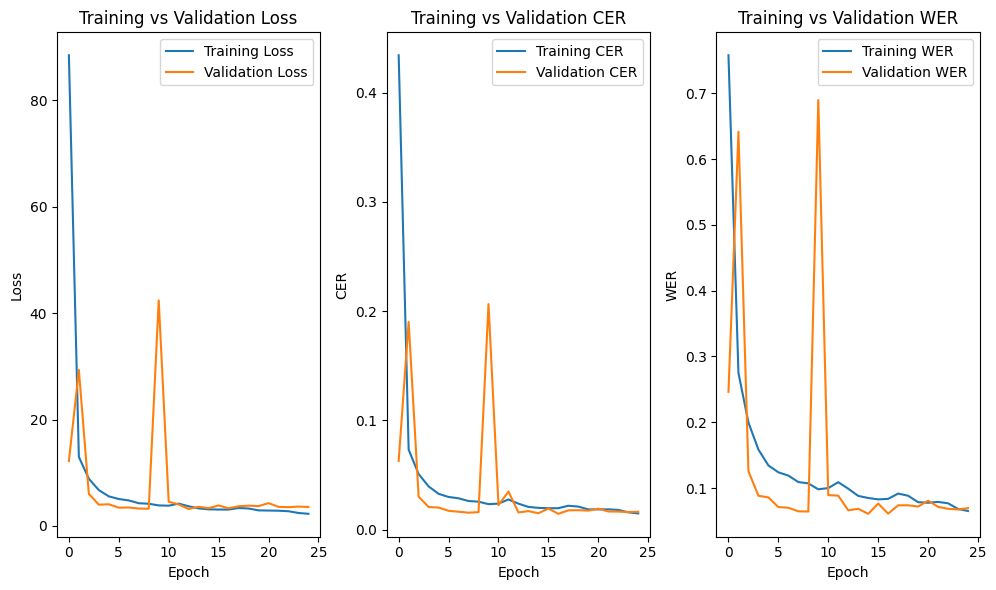

In [ ]:
# Plot training vs validation loss
plt.figure(figsize=(10, 6))

plt.subplot(1, 3, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(train_cer, label='Training CER')
plt.plot(val_cer, label='Validation CER')
plt.xlabel('Epoch')
plt.ylabel('CER')
plt.title('Training vs Validation CER')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(train_wer, label='Training WER')
plt.plot(val_wer, label='Validation WER')
plt.xlabel('Epoch')
plt.ylabel('WER')
plt.title('Training vs Validation WER')
plt.legend()

plt.tight_layout()
plt.show()


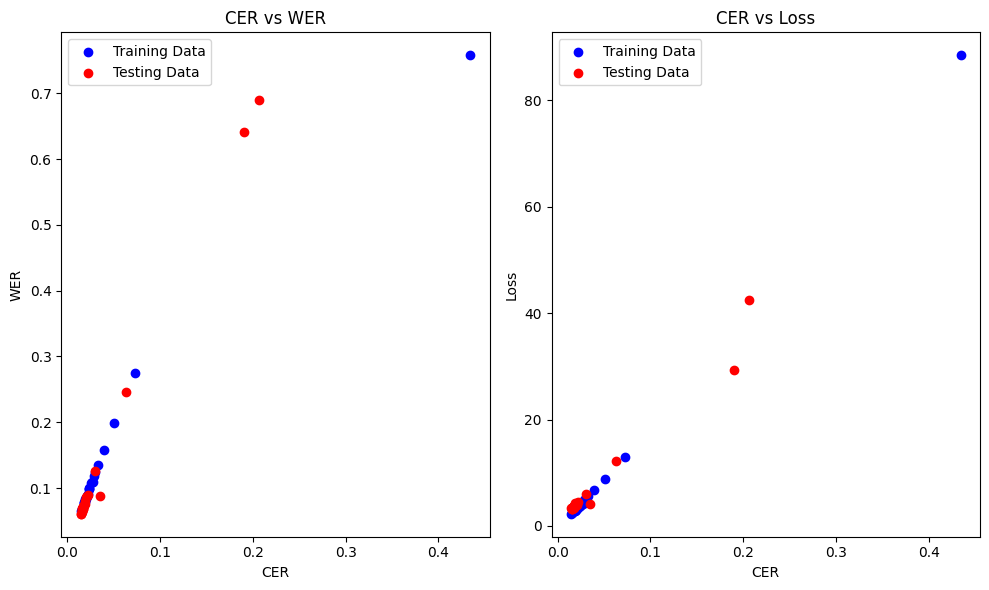

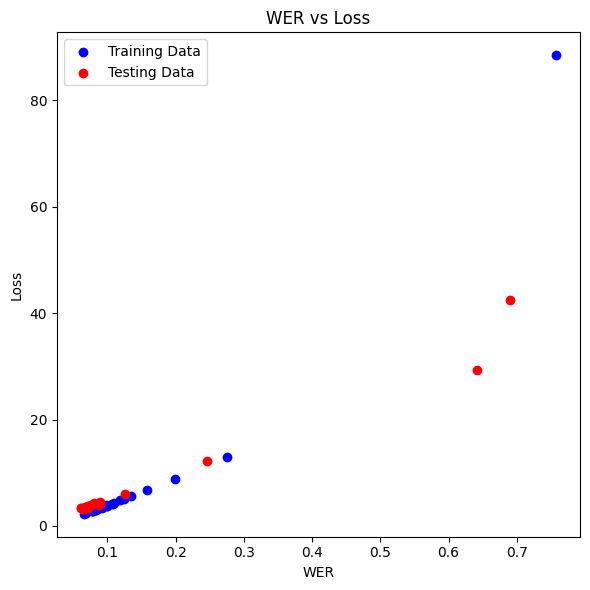

Pearson correlation coefficient between CER and WER (training): 0.9827973479626448
Pearson correlation coefficient between CER and loss (training): 0.9998597758673649
Pearson correlation coefficient between WER and loss (training): 0.9797747122038414
Pearson correlation coefficient between CER and WER (testing): 0.9980736135461372
Pearson correlation coefficient between CER and loss (testing): 0.9850768055303939
Pearson correlation coefficient between WER and loss (testing): 0.985780615189339


In [ ]:
import matplotlib.pyplot as plt

# Calculate Pearson correlation coefficients between CER, WER, and loss for training dataset
cer_wer_corr_train, _ = pearsonr(train_cer, train_wer)
cer_loss_corr_train, _ = pearsonr(train_cer, train_loss)
wer_loss_corr_train, _ = pearsonr(train_wer, train_loss)

# Calculate Pearson correlation coefficients between CER, WER, and loss for testing dataset
cer_wer_corr_test, _ = pearsonr(val_cer, val_wer)
cer_loss_corr_test, _ = pearsonr(val_cer, val_loss)
wer_loss_corr_test, _ = pearsonr(val_wer, val_loss)

# Plot the correlation coefficients
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.scatter(train_cer, train_wer, label='Training Data', color='blue')
plt.scatter(val_cer, val_wer, label='Testing Data', color='red')
plt.xlabel('CER')
plt.ylabel('WER')
plt.title('CER vs WER')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(train_cer, train_loss, label='Training Data', color='blue')
plt.scatter(val_cer, val_loss, label='Testing Data', color='red')
plt.xlabel('CER')
plt.ylabel('Loss')
plt.title('CER vs Loss')
plt.legend()

plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 6))
plt.scatter(train_wer, train_loss, label='Training Data', color='blue')
plt.scatter(val_wer, val_loss, label='Testing Data', color='red')
plt.xlabel('WER')
plt.ylabel('Loss')
plt.title('WER vs Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Print correlation coefficients
print("Pearson correlation coefficient between CER and WER (training):", cer_wer_corr_train)
print("Pearson correlation coefficient between CER and loss (training):", cer_loss_corr_train)
print("Pearson correlation coefficient between WER and loss (training):", wer_loss_corr_train)

print("Pearson correlation coefficient between CER and WER (testing):", cer_wer_corr_test)
print("Pearson correlation coefficient between CER and loss (testing):", cer_loss_corr_test)
print("Pearson correlation coefficient between WER and loss (testing):", wer_loss_corr_test)
